In [1]:
# conda deactivate
# source ros

# OR conda activate ros2

import os
import argparse
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
from std_msgs.msg import String
import rosbag2_py
from mcap.reader import make_reader
from mcap_protobuf.decoder import DecoderFactory
from nuscenes.nuscenes import NuScenes
import numpy as np
import matplotlib.pyplot as plt
import gtsam
from functools import partial
from typing import List, Optional
import pandas as pd

# Traverse all files

In [2]:
mcap_path = '/home/jd/nuscenes2mcap/output'

In [3]:
# Iterate through mcap files and write detections
for root, _,files in os.walk(mcap_path,topdown=True):
    for file in files:

        # Get input filepath
        in_file = os.path.join(root,file)
        print(in_file)

/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1077-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0553-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1100-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-1094-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0061-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0655-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0796-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0103-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0757-megvii.mcap
/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0916-megvii.mcap


# Examine a single file

In [4]:
in_file = '/home/jd/nuscenes2mcap/output/NuScenes-v1.0-mini-scene-0061-megvii.mcap'
topics=['/markers/annotations','/markers/detections']
data_dir = '/home/jd/nuscenes/data'
name="v1.0-mini"

nusc = NuScenes(version=name, dataroot=str(data_dir), verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.452 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
# REORDER INTO DICT INDEXED BY OBJECT, not as mcap indexed by time...

reader = make_reader(open(in_file, 'br'), decoder_factories=[DecoderFactory()])

epoch = 0
t = dict()
objects = dict()

for schema, channel, message, msg in reader.iter_decoded_messages(topics=topics):
        
    if channel.topic =='/markers/annotations':
#         print("Annotation step: " + str(annotation_count))
        
        # Get timestamp for this epoch
        tstamp = msg.entities[0].timestamp
        if tstamp not in t.values():
            t[epoch] = tstamp
            epoch+=1
        
        
        # For each actual annotation in the message


        # Get epoch from timestamp
        current_epoch = list(t.keys())[list(t.values()).index(tstamp)]       
        
        for entity in msg.entities:
            # Get entity data
            obj_id = entity.id
            
            # Get spatial data
            pos = entity.cubes[0].pose.position
            rot = entity.cubes[0].pose.orientation
            size = entity.cubes[0].size
            
            # Get semantic data
            cat = entity.metadata[0].value
            attribute = nusc.get('attribute',entity.metadata[1].value)['name'] if entity.metadata[1].value else ''
            
            # Initialize dict entry for this object if not done already
            if obj_id not in objects.keys():
                objects[obj_id] = dict()
                objects[obj_id]['category'] = cat
                objects[obj_id]['states'] = dict()
          
            objects[obj_id]['states'][current_epoch] = {
                    "stamp": tstamp,
                    "pos": pos,
                    "rot": rot,
                    "size": size,
                    "att": attribute
                }


In [56]:
print(objects.keys())
# objects['6dd2'] # human standing
objects['48d5'] # pedestrian moving
len(objects['48d5']['states'])

dict_keys(['6dd2', '48d5', 'bd26', '6e04', '4a5a', 'f4b2', 'c08b', '085f', 'bbd6', '03e8', '3c7d', '91f0', '3843', 'f138', '85d7', 'be2c', 'bc38', '8171', 'e91a', '56a7', '03d0', '8705', '16dc', '038a', '2ce1', '1004', 'cfd5', '4c8f', 'd16b', '3b54', '221d', '37f1', '10b5', '1610', '59cf', '2f59', '8524', 'c074', '01c0', '00cf', '4264', '0573', '7c80', 'e3c5', '9f6a', '4080', 'b4db', '58ce', 'cf04', '62bf', 'da62', 'e2f6', 'a600', 'd7e8', '7ba3', 'ac26', '95fc', 'd7f9', '0e79', 'e900', '963c', 'b77d', '3d03', '02e0', '28a7', 'c195', '91b6', '808a', '5ae0', 'c404', '5837', 'd29b', 'b061', 'ba2f', 'b17a', '4005', '0f74', '06b2', '61f9', '86ed', '1bc4', '5952', 'ce99', '7160', '37ae', 'ac81', '8479', '4b77', 'a017', '291e', 'fdd3', '47bc', 'eb3d', '26c3', '1056', '7f0a', '61dd', 'e3b2', 'daf0', '7367', 'c6b0', 'fbbe', 'c0c7', 'a3d0', 'a004', '4e5e', '6f6d', '36f5', '0704', 'e374', '918b', '9909', 'dad6', 'e80c', '32db', 'e59d', '2821', 'be00', 'f8fe', 'd7cd', '8630', 'b1aa', '9753', '2290

30

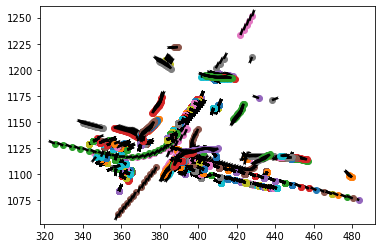

In [65]:
for key in objects:
    obj = objects[key]

    x = np.zeros(len(obj['states']))
    y = np.zeros(len(obj['states']))
    dxx = np.zeros(len(obj['states']))
    dxy = np.zeros(len(obj['states']))
    dyx = np.zeros(len(obj['states']))
    dyy = np.zeros(len(obj['states']))
    theta = np.zeros(len(obj['states']))

    ii=0
    for state in obj['states']:
        
        x[ii] = obj['states'][state]['pos'].x
        y[ii] = obj['states'][state]['pos'].y
        theta[ii] = 2*np.arccos(obj['states'][state]['rot'].w)
        dxx[ii] = np.cos(theta[ii])
        dxy[ii] = np.sin(theta[ii])
        dyx[ii] = -np.sin(theta[ii])
        dyy[ii] = np.cos(theta[ii])
        ii+=1

    plt.scatter(x,y)
    plt.quiver(x,y,dxx,dxy,headwidth=0)
    # plt.quiver(x,y,dyx,dyy)
    
plt.show()


# GTSAM stuff

In [8]:
def vel_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    last_p = gtsam.Point3(last_state['pos'].x,last_state['pos'].y,last_state['pos'].z)
    p = gtsam.Point3(state['pos'].x,state['pos'].y,state['pos'].z)
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    #######
    R = gtsam.Rot3(state['rot'].w,state['rot'].x,state['rot'].y,state['rot'].z)
    last_R = gtsam.Rot3(last_state['rot'].w,last_state['rot'].x,last_state['rot'].y,last_state['rot'].z)    
    
    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
        
    # Compute error
    #error = (p - (last_p + dt*(last_vel + vel)/2)) 
    error = (p - (last_p + dt*(last_R.rotate(last_vel) + R.rotate(vel))/2)) 
    
    if jacobians is not None:
#         jacobians[0] = -np.eye(3)*dt/2 # last vel
#         jacobians[1] = -np.eye(3)*dt/2 # vel
        jacobians[0] = -last_R.matrix()*dt/2 # last vel
        jacobians[1] = -R.matrix()*dt/2 # vel
    return error

def vel_eq_error(this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
        
    # Compute error
    error = last_vel - vel
    
    if jacobians is not None:
        jacobians[0] = np.eye(3) # last vel
        jacobians[1] = -np.eye(3) # vel

    return error

def acc_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    # Get variable values
    last_vel_key = this.keys()[0]
    vel_key = this.keys()[1]
    last_vel, vel = values.atVector(last_vel_key), values.atVector(vel_key)
    
    last_acc_key = this.keys()[2]
    acc_key = this.keys()[3]
    last_acc, acc = values.atVector(last_acc_key), values.atVector(acc_key)
        
    # Compute error
    error = (vel - (last_vel + dt*(last_acc + acc)/2)) 
    
    if jacobians is not None:
        jacobians[0] = -np.eye(3) # last vel
        jacobians[1] = np.eye(3) # vel
        jacobians[2] = -np.eye(3)*dt/2 # last acc
        jacobians[3] = -np.eye(3)*dt/2 # acc

    return error

def acc_eq_error(this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    # Get variable values
    last_acc_key = this.keys()[0]
    acc_key = this.keys()[1]
    last_acc, acc = values.atVector(last_acc_key), values.atVector(acc_key)
        
    # Compute error
    error = last_acc - acc
    
    if jacobians is not None:
        jacobians[0] = np.eye(3) # last acc
        jacobians[1] = -np.eye(3) # acc

    return error

def omega_dyn_const_error(constants, this: gtsam.CustomFactor,
               values: gtsam.Values,
               jacobians: Optional[List[np.ndarray]]) -> np.ndarray:

    last_state = constants[0]
    state = constants[1]

    # Extract constants from state
    last_theta = gtsam.Point3(0,0,2*np.arccos(last_state['rot'].w))
    theta = gtsam.Point3(0,0,2*np.arccos(state['rot'].w))
    dt = (state['stamp'].seconds + state['stamp'].nanos/10**9) - (last_state['stamp'].seconds + last_state['stamp'].nanos/10**9)
    
    # Get variable values
    last_omega_key = this.keys()[0]
    omega_key = this.keys()[1]
    last_omega, omega = values.atVector(last_omega_key), values.atVector(omega_key)
        
    # Compute error
    error = (theta - (last_theta + dt*(last_omega + omega)/2))
    
    if jacobians is not None:
        jacobians[0] = -np.eye(3) # last acc
        jacobians[1] = -np.eye(3) # acc

    return error

In [68]:
# create the graph and solver
graph = gtsam.NonlinearFactorGraph()
unit_noise = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(1,1,1))
init_values = gtsam.Values()

# Initialize graph variable indices
var_idx = 0

# for each object in objects / get object
for key in objects:
    obj = objects[key]
#     obj = objects['48d5']

    # iterate through states in object, add to graph 
    for key in list(obj['states']):

        # TODO check for any length==1 trajectories

        # First trajectory element
        if key == list(obj['states'])[0]:

            # Add variables 
            init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
            init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
            init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
            obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
            obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
            obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

            # Increment keys and indices
            last_key = key
            last_var_idx = var_idx
            var_idx+=1

        # Last trajectory element
        elif key == list(obj['states'])[-1]:

            # Add variables from this state
            init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
            init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
            init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
            obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
            obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
            obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

            # Add Dynamics constraints
            vel_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
            graph.add(vel_dyn_const)
            acc_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx),gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
            graph.add(acc_dyn_const)
            omega_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(omega_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
            graph.add(omega_dyn_const)

            # Add equality constraints
    #         vel_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_eq_error))
    #         graph.add(vel_eq_const)
            acc_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_eq_error))
            graph.add(acc_eq_const)
            omega_eq_const = gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(vel_eq_error))
            graph.add(omega_eq_const)

            # Increment counters
            last_key = key
            last_var_idx = var_idx
            var_idx+=1

        # Subsequent trajectory elements
        else:                 
            # Add variables from this state
            init_values.insert(gtsam.symbol('v',var_idx),gtsam.Point3(0,0,0))
            init_values.insert(gtsam.symbol('w',var_idx),gtsam.Point3(0,0,0))
            init_values.insert(gtsam.symbol('a',var_idx),gtsam.Point3(0,0,0))
            obj['states'][key]['v_sym'] = gtsam.symbol('v',var_idx)
            obj['states'][key]['w_sym'] = gtsam.symbol('w',var_idx)
            obj['states'][key]['a_sym'] = gtsam.symbol('a',var_idx)

            # Add factor between last state and this state
            vel_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx)],partial(vel_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
            graph.add(vel_dyn_const)
            acc_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('v',last_var_idx),gtsam.symbol('v',var_idx),gtsam.symbol('a',last_var_idx),gtsam.symbol('a',var_idx)],partial(acc_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
            graph.add(acc_dyn_const)
            omega_dyn_const= gtsam.CustomFactor(unit_noise,[gtsam.symbol('w',last_var_idx),gtsam.symbol('w',var_idx)],partial(omega_dyn_const_error, [obj['states'][last_key],obj['states'][key]]))
            graph.add(omega_dyn_const)

            # Increment counters
            last_key = key
            last_var_idx = var_idx
            var_idx+=1
        

In [69]:
# solve
params = gtsam.GaussNewtonParams()
optimizer = gtsam.GaussNewtonOptimizer(graph, init_values, params)

result = optimizer.optimize()

RuntimeError: 
Indeterminant linear system detected while working near variable
6989586621679014487 (Symbol: a4695).

Thrown when a linear system is ill-posed.  The most common cause for this
error is having underconstrained variables.  Mathematically, the system is
underdetermined.  See the GTSAM Doxygen documentation at
http://borg.cc.gatech.edu/ on gtsam::IndeterminantLinearSystemException for
more information.

In [72]:
graph.saveGraph()

TypeError: saveGraph(): incompatible function arguments. The following argument types are supported:
    1. (self: gtsam.gtsam.NonlinearFactorGraph, s: str, values: gtsam::Values, keyFormatter: Callable[[int], str] = <built-in method  of PyCapsule object at 0x7f86bdf0d560>, writer: gtsam.gtsam.GraphvizFormatting = <gtsam.gtsam.GraphvizFormatting object at 0x7f86bf4939b0>) -> None

Invoked with: NonlinearFactorGraph: size: 13841

Factor 0: CustomFactor on v0, v1
  noise model: unit (3) 

Factor 1: CustomFactor on v0, v1, a0, a1
  noise model: unit (3) 

Factor 2: CustomFactor on w0, w1
  noise model: unit (3) 

Factor 3: CustomFactor on v1, v2
  noise model: unit (3) 

Factor 4: CustomFactor on v1, v2, a1, a2
  noise model: unit (3) 

Factor 5: CustomFactor on w1, w2
  noise model: unit (3) 

Factor 6: CustomFactor on v2, v3
  noise model: unit (3) 

Factor 7: CustomFactor on v2, v3, a2, a3
  noise model: unit (3) 

Factor 8: CustomFactor on w2, w3
  noise model: unit (3) 

Factor 9: CustomFactor on v3, v4
  noise model: unit (3) 

Factor 10: CustomFactor on v3, v4, a3, a4
  noise model: unit (3) 

Factor 11: CustomFactor on w3, w4
  noise model: unit (3) 

Factor 12: CustomFactor on v4, v5
  noise model: unit (3) 

Factor 13: CustomFactor on v4, v5, a4, a5
  noise model: unit (3) 

Factor 14: CustomFactor on w4, w5
  noise model: unit (3) 

Factor 15: CustomFactor on v5, v6
  noise model: unit (3) 

Factor 16: CustomFactor on v5, v6, a5, a6
  noise model: unit (3) 

Factor 17: CustomFactor on w5, w6
  noise model: unit (3) 

Factor 18: CustomFactor on v6, v7
  noise model: unit (3) 

Factor 19: CustomFactor on v6, v7, a6, a7
  noise model: unit (3) 

Factor 20: CustomFactor on w6, w7
  noise model: unit (3) 

Factor 21: CustomFactor on v7, v8
  noise model: unit (3) 

Factor 22: CustomFactor on v7, v8, a7, a8
  noise model: unit (3) 

Factor 23: CustomFactor on w7, w8
  noise model: unit (3) 

Factor 24: CustomFactor on v8, v9
  noise model: unit (3) 

Factor 25: CustomFactor on v8, v9, a8, a9
  noise model: unit (3) 

Factor 26: CustomFactor on w8, w9
  noise model: unit (3) 

Factor 27: CustomFactor on v9, v10
  noise model: unit (3) 

Factor 28: CustomFactor on v9, v10, a9, a10
  noise model: unit (3) 

Factor 29: CustomFactor on w9, w10
  noise model: unit (3) 

Factor 30: CustomFactor on v10, v11
  noise model: unit (3) 

Factor 31: CustomFactor on v10, v11, a10, a11
  noise model: unit (3) 

Factor 32: CustomFactor on w10, w11
  noise model: unit (3) 

Factor 33: CustomFactor on v11, v12
  noise model: unit (3) 

Factor 34: CustomFactor on v11, v12, a11, a12
  noise model: unit (3) 

Factor 35: CustomFactor on w11, w12
  noise model: unit (3) 

Factor 36: CustomFactor on v12, v13
  noise model: unit (3) 

Factor 37: CustomFactor on v12, v13, a12, a13
  noise model: unit (3) 

Factor 38: CustomFactor on w12, w13
  noise model: unit (3) 

Factor 39: CustomFactor on v13, v14
  noise model: unit (3) 

Factor 40: CustomFactor on v13, v14, a13, a14
  noise model: unit (3) 

Factor 41: CustomFactor on w13, w14
  noise model: unit (3) 

Factor 42: CustomFactor on v14, v15
  noise model: unit (3) 

Factor 43: CustomFactor on v14, v15, a14, a15
  noise model: unit (3) 

Factor 44: CustomFactor on w14, w15
  noise model: unit (3) 

Factor 45: CustomFactor on v15, v16
  noise model: unit (3) 

Factor 46: CustomFactor on v15, v16, a15, a16
  noise model: unit (3) 

Factor 47: CustomFactor on w15, w16
  noise model: unit (3) 

Factor 48: CustomFactor on v16, v17
  noise model: unit (3) 

Factor 49: CustomFactor on v16, v17, a16, a17
  noise model: unit (3) 

Factor 50: CustomFactor on w16, w17
  noise model: unit (3) 

Factor 51: CustomFactor on v17, v18
  noise model: unit (3) 

Factor 52: CustomFactor on v17, v18, a17, a18
  noise model: unit (3) 

Factor 53: CustomFactor on w17, w18
  noise model: unit (3) 

Factor 54: CustomFactor on v18, v19
  noise model: unit (3) 

Factor 55: CustomFactor on v18, v19, a18, a19
  noise model: unit (3) 

Factor 56: CustomFactor on w18, w19
  noise model: unit (3) 

Factor 57: CustomFactor on v19, v20
  noise model: unit (3) 

Factor 58: CustomFactor on v19, v20, a19, a20
  noise model: unit (3) 

Factor 59: CustomFactor on w19, w20
  noise model: unit (3) 

Factor 60: CustomFactor on v20, v21
  noise model: unit (3) 

Factor 61: CustomFactor on v20, v21, a20, a21
  noise model: unit (3) 

Factor 62: CustomFactor on w20, w21
  noise model: unit (3) 

Factor 63: CustomFactor on v21, v22
  noise model: unit (3) 

Factor 64: CustomFactor on v21, v22, a21, a22
  noise model: unit (3) 

Factor 65: CustomFactor on w21, w22
  noise model: unit (3) 

Factor 66: CustomFactor on v22, v23
  noise model: unit (3) 

Factor 67: CustomFactor on v22, v23, a22, a23
  noise model: unit (3) 

Factor 68: CustomFactor on w22, w23
  noise model: unit (3) 

Factor 69: CustomFactor on v23, v24
  noise model: unit (3) 

Factor 70: CustomFactor on v23, v24, a23, a24
  noise model: unit (3) 

Factor 71: CustomFactor on w23, w24
  noise model: unit (3) 

Factor 72: CustomFactor on v24, v25
  noise model: unit (3) 

Factor 73: CustomFactor on v24, v25, a24, a25
  noise model: unit (3) 

Factor 74: CustomFactor on w24, w25
  noise model: unit (3) 

Factor 75: CustomFactor on v25, v26
  noise model: unit (3) 

Factor 76: CustomFactor on v25, v26, a25, a26
  noise model: unit (3) 

Factor 77: CustomFactor on w25, w26
  noise model: unit (3) 

Factor 78: CustomFactor on v26, v27
  noise model: unit (3) 

Factor 79: CustomFactor on v26, v27, a26, a27
  noise model: unit (3) 

Factor 80: CustomFactor on w26, w27
  noise model: unit (3) 

Factor 81: CustomFactor on v27, v28
  noise model: unit (3) 

Factor 82: CustomFactor on v27, v28, a27, a28
  noise model: unit (3) 

Factor 83: CustomFactor on w27, w28
  noise model: unit (3) 

Factor 84: CustomFactor on v28, v29
  noise model: unit (3) 

Factor 85: CustomFactor on v28, v29, a28, a29
  noise model: unit (3) 

Factor 86: CustomFactor on w28, w29
  noise model: unit (3) 

Factor 87: CustomFactor on v29, v30
  noise model: unit (3) 

Factor 88: CustomFactor on v29, v30, a29, a30
  noise model: unit (3) 

Factor 89: CustomFactor on w29, w30
  noise model: unit (3) 

Factor 90: CustomFactor on v30, v31
  noise model: unit (3) 

Factor 91: CustomFactor on v30, v31, a30, a31
  noise model: unit (3) 

Factor 92: CustomFactor on w30, w31
  noise model: unit (3) 

Factor 93: CustomFactor on v31, v32
  noise model: unit (3) 

Factor 94: CustomFactor on v31, v32, a31, a32
  noise model: unit (3) 

Factor 95: CustomFactor on w31, w32
  noise model: unit (3) 

Factor 96: CustomFactor on v32, v33
  noise model: unit (3) 

Factor 97: CustomFactor on v32, v33, a32, a33
  noise model: unit (3) 

Factor 98: CustomFactor on w32, w33
  noise model: unit (3) 

Factor 99: CustomFactor on v33, v34
  noise model: unit (3) 

Factor 100: CustomFactor on v33, v34, a33, a34
  noise model: unit (3) 

Factor 101: CustomFactor on w33, w34
  noise model: unit (3) 

Factor 102: CustomFactor on v34, v35
  noise model: unit (3) 

Factor 103: CustomFactor on v34, v35, a34, a35
  noise model: unit (3) 

Factor 104: CustomFactor on w34, w35
  noise model: unit (3) 

Factor 105: CustomFactor on v35, v36
  noise model: unit (3) 

Factor 106: CustomFactor on v35, v36, a35, a36
  noise model: unit (3) 

Factor 107: CustomFactor on w35, w36
  noise model: unit (3) 

Factor 108: CustomFactor on v36, v37
  noise model: unit (3) 

Factor 109: CustomFactor on v36, v37, a36, a37
  noise model: unit (3) 

Factor 110: CustomFactor on w36, w37
  noise model: unit (3) 

Factor 111: CustomFactor on v37, v38
  noise model: unit (3) 

Factor 112: CustomFactor on v37, v38, a37, a38
  noise model: unit (3) 

Factor 113: CustomFactor on w37, w38
  noise model: unit (3) 

Factor 114: CustomFactor on a37, a38
  noise model: unit (3) 

Factor 115: CustomFactor on w37, w38
  noise model: unit (3) 

Factor 116: CustomFactor on v39, v40
  noise model: unit (3) 

Factor 117: CustomFactor on v39, v40, a39, a40
  noise model: unit (3) 

Factor 118: CustomFactor on w39, w40
  noise model: unit (3) 

Factor 119: CustomFactor on v40, v41
  noise model: unit (3) 

Factor 120: CustomFactor on v40, v41, a40, a41
  noise model: unit (3) 

Factor 121: CustomFactor on w40, w41
  noise model: unit (3) 

Factor 122: CustomFactor on v41, v42
  noise model: unit (3) 

Factor 123: CustomFactor on v41, v42, a41, a42
  noise model: unit (3) 

Factor 124: CustomFactor on w41, w42
  noise model: unit (3) 

Factor 125: CustomFactor on v42, v43
  noise model: unit (3) 

Factor 126: CustomFactor on v42, v43, a42, a43
  noise model: unit (3) 

Factor 127: CustomFactor on w42, w43
  noise model: unit (3) 

Factor 128: CustomFactor on v43, v44
  noise model: unit (3) 

Factor 129: CustomFactor on v43, v44, a43, a44
  noise model: unit (3) 

Factor 130: CustomFactor on w43, w44
  noise model: unit (3) 

Factor 131: CustomFactor on v44, v45
  noise model: unit (3) 

Factor 132: CustomFactor on v44, v45, a44, a45
  noise model: unit (3) 

Factor 133: CustomFactor on w44, w45
  noise model: unit (3) 

Factor 134: CustomFactor on v45, v46
  noise model: unit (3) 

Factor 135: CustomFactor on v45, v46, a45, a46
  noise model: unit (3) 

Factor 136: CustomFactor on w45, w46
  noise model: unit (3) 

Factor 137: CustomFactor on v46, v47
  noise model: unit (3) 

Factor 138: CustomFactor on v46, v47, a46, a47
  noise model: unit (3) 

Factor 139: CustomFactor on w46, w47
  noise model: unit (3) 

Factor 140: CustomFactor on v47, v48
  noise model: unit (3) 

Factor 141: CustomFactor on v47, v48, a47, a48
  noise model: unit (3) 

Factor 142: CustomFactor on w47, w48
  noise model: unit (3) 

Factor 143: CustomFactor on v48, v49
  noise model: unit (3) 

Factor 144: CustomFactor on v48, v49, a48, a49
  noise model: unit (3) 

Factor 145: CustomFactor on w48, w49
  noise model: unit (3) 

Factor 146: CustomFactor on v49, v50
  noise model: unit (3) 

Factor 147: CustomFactor on v49, v50, a49, a50
  noise model: unit (3) 

Factor 148: CustomFactor on w49, w50
  noise model: unit (3) 

Factor 149: CustomFactor on v50, v51
  noise model: unit (3) 

Factor 150: CustomFactor on v50, v51, a50, a51
  noise model: unit (3) 

Factor 151: CustomFactor on w50, w51
  noise model: unit (3) 

Factor 152: CustomFactor on v51, v52
  noise model: unit (3) 

Factor 153: CustomFactor on v51, v52, a51, a52
  noise model: unit (3) 

Factor 154: CustomFactor on w51, w52
  noise model: unit (3) 

Factor 155: CustomFactor on v52, v53
  noise model: unit (3) 

Factor 156: CustomFactor on v52, v53, a52, a53
  noise model: unit (3) 

Factor 157: CustomFactor on w52, w53
  noise model: unit (3) 

Factor 158: CustomFactor on v53, v54
  noise model: unit (3) 

Factor 159: CustomFactor on v53, v54, a53, a54
  noise model: unit (3) 

Factor 160: CustomFactor on w53, w54
  noise model: unit (3) 

Factor 161: CustomFactor on v54, v55
  noise model: unit (3) 

Factor 162: CustomFactor on v54, v55, a54, a55
  noise model: unit (3) 

Factor 163: CustomFactor on w54, w55
  noise model: unit (3) 

Factor 164: CustomFactor on v55, v56
  noise model: unit (3) 

Factor 165: CustomFactor on v55, v56, a55, a56
  noise model: unit (3) 

Factor 166: CustomFactor on w55, w56
  noise model: unit (3) 

Factor 167: CustomFactor on v56, v57
  noise model: unit (3) 

Factor 168: CustomFactor on v56, v57, a56, a57
  noise model: unit (3) 

Factor 169: CustomFactor on w56, w57
  noise model: unit (3) 

Factor 170: CustomFactor on v57, v58
  noise model: unit (3) 

Factor 171: CustomFactor on v57, v58, a57, a58
  noise model: unit (3) 

Factor 172: CustomFactor on w57, w58
  noise model: unit (3) 

Factor 173: CustomFactor on v58, v59
  noise model: unit (3) 

Factor 174: CustomFactor on v58, v59, a58, a59
  noise model: unit (3) 

Factor 175: CustomFactor on w58, w59
  noise model: unit (3) 

Factor 176: CustomFactor on v59, v60
  noise model: unit (3) 

Factor 177: CustomFactor on v59, v60, a59, a60
  noise model: unit (3) 

Factor 178: CustomFactor on w59, w60
  noise model: unit (3) 

Factor 179: CustomFactor on v60, v61
  noise model: unit (3) 

Factor 180: CustomFactor on v60, v61, a60, a61
  noise model: unit (3) 

Factor 181: CustomFactor on w60, w61
  noise model: unit (3) 

Factor 182: CustomFactor on v61, v62
  noise model: unit (3) 

Factor 183: CustomFactor on v61, v62, a61, a62
  noise model: unit (3) 

Factor 184: CustomFactor on w61, w62
  noise model: unit (3) 

Factor 185: CustomFactor on v62, v63
  noise model: unit (3) 

Factor 186: CustomFactor on v62, v63, a62, a63
  noise model: unit (3) 

Factor 187: CustomFactor on w62, w63
  noise model: unit (3) 

Factor 188: CustomFactor on v63, v64
  noise model: unit (3) 

Factor 189: CustomFactor on v63, v64, a63, a64
  noise model: unit (3) 

Factor 190: CustomFactor on w63, w64
  noise model: unit (3) 

Factor 191: CustomFactor on v64, v65
  noise model: unit (3) 

Factor 192: CustomFactor on v64, v65, a64, a65
  noise model: unit (3) 

Factor 193: CustomFactor on w64, w65
  noise model: unit (3) 

Factor 194: CustomFactor on v65, v66
  noise model: unit (3) 

Factor 195: CustomFactor on v65, v66, a65, a66
  noise model: unit (3) 

Factor 196: CustomFactor on w65, w66
  noise model: unit (3) 

Factor 197: CustomFactor on v66, v67
  noise model: unit (3) 

Factor 198: CustomFactor on v66, v67, a66, a67
  noise model: unit (3) 

Factor 199: CustomFactor on w66, w67
  noise model: unit (3) 

Factor 200: CustomFactor on v67, v68
  noise model: unit (3) 

Factor 201: CustomFactor on v67, v68, a67, a68
  noise model: unit (3) 

Factor 202: CustomFactor on w67, w68
  noise model: unit (3) 

Factor 203: CustomFactor on a67, a68
  noise model: unit (3) 

Factor 204: CustomFactor on w67, w68
  noise model: unit (3) 

Factor 205: CustomFactor on v69, v70
  noise model: unit (3) 

Factor 206: CustomFactor on v69, v70, a69, a70
  noise model: unit (3) 

Factor 207: CustomFactor on w69, w70
  noise model: unit (3) 

Factor 208: CustomFactor on v70, v71
  noise model: unit (3) 

Factor 209: CustomFactor on v70, v71, a70, a71
  noise model: unit (3) 

Factor 210: CustomFactor on w70, w71
  noise model: unit (3) 

Factor 211: CustomFactor on v71, v72
  noise model: unit (3) 

Factor 212: CustomFactor on v71, v72, a71, a72
  noise model: unit (3) 

Factor 213: CustomFactor on w71, w72
  noise model: unit (3) 

Factor 214: CustomFactor on v72, v73
  noise model: unit (3) 

Factor 215: CustomFactor on v72, v73, a72, a73
  noise model: unit (3) 

Factor 216: CustomFactor on w72, w73
  noise model: unit (3) 

Factor 217: CustomFactor on v73, v74
  noise model: unit (3) 

Factor 218: CustomFactor on v73, v74, a73, a74
  noise model: unit (3) 

Factor 219: CustomFactor on w73, w74
  noise model: unit (3) 

Factor 220: CustomFactor on v74, v75
  noise model: unit (3) 

Factor 221: CustomFactor on v74, v75, a74, a75
  noise model: unit (3) 

Factor 222: CustomFactor on w74, w75
  noise model: unit (3) 

Factor 223: CustomFactor on v75, v76
  noise model: unit (3) 

Factor 224: CustomFactor on v75, v76, a75, a76
  noise model: unit (3) 

Factor 225: CustomFactor on w75, w76
  noise model: unit (3) 

Factor 226: CustomFactor on v76, v77
  noise model: unit (3) 

Factor 227: CustomFactor on v76, v77, a76, a77
  noise model: unit (3) 

Factor 228: CustomFactor on w76, w77
  noise model: unit (3) 

Factor 229: CustomFactor on v77, v78
  noise model: unit (3) 

Factor 230: CustomFactor on v77, v78, a77, a78
  noise model: unit (3) 

Factor 231: CustomFactor on w77, w78
  noise model: unit (3) 

Factor 232: CustomFactor on v78, v79
  noise model: unit (3) 

Factor 233: CustomFactor on v78, v79, a78, a79
  noise model: unit (3) 

Factor 234: CustomFactor on w78, w79
  noise model: unit (3) 

Factor 235: CustomFactor on v79, v80
  noise model: unit (3) 

Factor 236: CustomFactor on v79, v80, a79, a80
  noise model: unit (3) 

Factor 237: CustomFactor on w79, w80
  noise model: unit (3) 

Factor 238: CustomFactor on v80, v81
  noise model: unit (3) 

Factor 239: CustomFactor on v80, v81, a80, a81
  noise model: unit (3) 

Factor 240: CustomFactor on w80, w81
  noise model: unit (3) 

Factor 241: CustomFactor on v81, v82
  noise model: unit (3) 

Factor 242: CustomFactor on v81, v82, a81, a82
  noise model: unit (3) 

Factor 243: CustomFactor on w81, w82
  noise model: unit (3) 

Factor 244: CustomFactor on v82, v83
  noise model: unit (3) 

Factor 245: CustomFactor on v82, v83, a82, a83
  noise model: unit (3) 

Factor 246: CustomFactor on w82, w83
  noise model: unit (3) 

Factor 247: CustomFactor on v83, v84
  noise model: unit (3) 

Factor 248: CustomFactor on v83, v84, a83, a84
  noise model: unit (3) 

Factor 249: CustomFactor on w83, w84
  noise model: unit (3) 

Factor 250: CustomFactor on v84, v85
  noise model: unit (3) 

Factor 251: CustomFactor on v84, v85, a84, a85
  noise model: unit (3) 

Factor 252: CustomFactor on w84, w85
  noise model: unit (3) 

Factor 253: CustomFactor on v85, v86
  noise model: unit (3) 

Factor 254: CustomFactor on v85, v86, a85, a86
  noise model: unit (3) 

Factor 255: CustomFactor on w85, w86
  noise model: unit (3) 

Factor 256: CustomFactor on v86, v87
  noise model: unit (3) 

Factor 257: CustomFactor on v86, v87, a86, a87
  noise model: unit (3) 

Factor 258: CustomFactor on w86, w87
  noise model: unit (3) 

Factor 259: CustomFactor on v87, v88
  noise model: unit (3) 

Factor 260: CustomFactor on v87, v88, a87, a88
  noise model: unit (3) 

Factor 261: CustomFactor on w87, w88
  noise model: unit (3) 

Factor 262: CustomFactor on v88, v89
  noise model: unit (3) 

Factor 263: CustomFactor on v88, v89, a88, a89
  noise model: unit (3) 

Factor 264: CustomFactor on w88, w89
  noise model: unit (3) 

Factor 265: CustomFactor on v89, v90
  noise model: unit (3) 

Factor 266: CustomFactor on v89, v90, a89, a90
  noise model: unit (3) 

Factor 267: CustomFactor on w89, w90
  noise model: unit (3) 

Factor 268: CustomFactor on v90, v91
  noise model: unit (3) 

Factor 269: CustomFactor on v90, v91, a90, a91
  noise model: unit (3) 

Factor 270: CustomFactor on w90, w91
  noise model: unit (3) 

Factor 271: CustomFactor on v91, v92
  noise model: unit (3) 

Factor 272: CustomFactor on v91, v92, a91, a92
  noise model: unit (3) 

Factor 273: CustomFactor on w91, w92
  noise model: unit (3) 

Factor 274: CustomFactor on v92, v93
  noise model: unit (3) 

Factor 275: CustomFactor on v92, v93, a92, a93
  noise model: unit (3) 

Factor 276: CustomFactor on w92, w93
  noise model: unit (3) 

Factor 277: CustomFactor on v93, v94
  noise model: unit (3) 

Factor 278: CustomFactor on v93, v94, a93, a94
  noise model: unit (3) 

Factor 279: CustomFactor on w93, w94
  noise model: unit (3) 

Factor 280: CustomFactor on v94, v95
  noise model: unit (3) 

Factor 281: CustomFactor on v94, v95, a94, a95
  noise model: unit (3) 

Factor 282: CustomFactor on w94, w95
  noise model: unit (3) 

Factor 283: CustomFactor on v95, v96
  noise model: unit (3) 

Factor 284: CustomFactor on v95, v96, a95, a96
  noise model: unit (3) 

Factor 285: CustomFactor on w95, w96
  noise model: unit (3) 

Factor 286: CustomFactor on v96, v97
  noise model: unit (3) 

Factor 287: CustomFactor on v96, v97, a96, a97
  noise model: unit (3) 

Factor 288: CustomFactor on w96, w97
  noise model: unit (3) 

Factor 289: CustomFactor on v97, v98
  noise model: unit (3) 

Factor 290: CustomFactor on v97, v98, a97, a98
  noise model: unit (3) 

Factor 291: CustomFactor on w97, w98
  noise model: unit (3) 

Factor 292: CustomFactor on v98, v99
  noise model: unit (3) 

Factor 293: CustomFactor on v98, v99, a98, a99
  noise model: unit (3) 

Factor 294: CustomFactor on w98, w99
  noise model: unit (3) 

Factor 295: CustomFactor on v99, v100
  noise model: unit (3) 

Factor 296: CustomFactor on v99, v100, a99, a100
  noise model: unit (3) 

Factor 297: CustomFactor on w99, w100
  noise model: unit (3) 

Factor 298: CustomFactor on v100, v101
  noise model: unit (3) 

Factor 299: CustomFactor on v100, v101, a100, a101
  noise model: unit (3) 

Factor 300: CustomFactor on w100, w101
  noise model: unit (3) 

Factor 301: CustomFactor on v101, v102
  noise model: unit (3) 

Factor 302: CustomFactor on v101, v102, a101, a102
  noise model: unit (3) 

Factor 303: CustomFactor on w101, w102
  noise model: unit (3) 

Factor 304: CustomFactor on v102, v103
  noise model: unit (3) 

Factor 305: CustomFactor on v102, v103, a102, a103
  noise model: unit (3) 

Factor 306: CustomFactor on w102, w103
  noise model: unit (3) 

Factor 307: CustomFactor on v103, v104
  noise model: unit (3) 

Factor 308: CustomFactor on v103, v104, a103, a104
  noise model: unit (3) 

Factor 309: CustomFactor on w103, w104
  noise model: unit (3) 

Factor 310: CustomFactor on v104, v105
  noise model: unit (3) 

Factor 311: CustomFactor on v104, v105, a104, a105
  noise model: unit (3) 

Factor 312: CustomFactor on w104, w105
  noise model: unit (3) 

Factor 313: CustomFactor on a104, a105
  noise model: unit (3) 

Factor 314: CustomFactor on w104, w105
  noise model: unit (3) 

Factor 315: CustomFactor on v106, v107
  noise model: unit (3) 

Factor 316: CustomFactor on v106, v107, a106, a107
  noise model: unit (3) 

Factor 317: CustomFactor on w106, w107
  noise model: unit (3) 

Factor 318: CustomFactor on v107, v108
  noise model: unit (3) 

Factor 319: CustomFactor on v107, v108, a107, a108
  noise model: unit (3) 

Factor 320: CustomFactor on w107, w108
  noise model: unit (3) 

Factor 321: CustomFactor on v108, v109
  noise model: unit (3) 

Factor 322: CustomFactor on v108, v109, a108, a109
  noise model: unit (3) 

Factor 323: CustomFactor on w108, w109
  noise model: unit (3) 

Factor 324: CustomFactor on v109, v110
  noise model: unit (3) 

Factor 325: CustomFactor on v109, v110, a109, a110
  noise model: unit (3) 

Factor 326: CustomFactor on w109, w110
  noise model: unit (3) 

Factor 327: CustomFactor on v110, v111
  noise model: unit (3) 

Factor 328: CustomFactor on v110, v111, a110, a111
  noise model: unit (3) 

Factor 329: CustomFactor on w110, w111
  noise model: unit (3) 

Factor 330: CustomFactor on v111, v112
  noise model: unit (3) 

Factor 331: CustomFactor on v111, v112, a111, a112
  noise model: unit (3) 

Factor 332: CustomFactor on w111, w112
  noise model: unit (3) 

Factor 333: CustomFactor on v112, v113
  noise model: unit (3) 

Factor 334: CustomFactor on v112, v113, a112, a113
  noise model: unit (3) 

Factor 335: CustomFactor on w112, w113
  noise model: unit (3) 

Factor 336: CustomFactor on v113, v114
  noise model: unit (3) 

Factor 337: CustomFactor on v113, v114, a113, a114
  noise model: unit (3) 

Factor 338: CustomFactor on w113, w114
  noise model: unit (3) 

Factor 339: CustomFactor on v114, v115
  noise model: unit (3) 

Factor 340: CustomFactor on v114, v115, a114, a115
  noise model: unit (3) 

Factor 341: CustomFactor on w114, w115
  noise model: unit (3) 

Factor 342: CustomFactor on v115, v116
  noise model: unit (3) 

Factor 343: CustomFactor on v115, v116, a115, a116
  noise model: unit (3) 

Factor 344: CustomFactor on w115, w116
  noise model: unit (3) 

Factor 345: CustomFactor on v116, v117
  noise model: unit (3) 

Factor 346: CustomFactor on v116, v117, a116, a117
  noise model: unit (3) 

Factor 347: CustomFactor on w116, w117
  noise model: unit (3) 

Factor 348: CustomFactor on v117, v118
  noise model: unit (3) 

Factor 349: CustomFactor on v117, v118, a117, a118
  noise model: unit (3) 

Factor 350: CustomFactor on w117, w118
  noise model: unit (3) 

Factor 351: CustomFactor on v118, v119
  noise model: unit (3) 

Factor 352: CustomFactor on v118, v119, a118, a119
  noise model: unit (3) 

Factor 353: CustomFactor on w118, w119
  noise model: unit (3) 

Factor 354: CustomFactor on v119, v120
  noise model: unit (3) 

Factor 355: CustomFactor on v119, v120, a119, a120
  noise model: unit (3) 

Factor 356: CustomFactor on w119, w120
  noise model: unit (3) 

Factor 357: CustomFactor on v120, v121
  noise model: unit (3) 

Factor 358: CustomFactor on v120, v121, a120, a121
  noise model: unit (3) 

Factor 359: CustomFactor on w120, w121
  noise model: unit (3) 

Factor 360: CustomFactor on v121, v122
  noise model: unit (3) 

Factor 361: CustomFactor on v121, v122, a121, a122
  noise model: unit (3) 

Factor 362: CustomFactor on w121, w122
  noise model: unit (3) 

Factor 363: CustomFactor on v122, v123
  noise model: unit (3) 

Factor 364: CustomFactor on v122, v123, a122, a123
  noise model: unit (3) 

Factor 365: CustomFactor on w122, w123
  noise model: unit (3) 

Factor 366: CustomFactor on v123, v124
  noise model: unit (3) 

Factor 367: CustomFactor on v123, v124, a123, a124
  noise model: unit (3) 

Factor 368: CustomFactor on w123, w124
  noise model: unit (3) 

Factor 369: CustomFactor on v124, v125
  noise model: unit (3) 

Factor 370: CustomFactor on v124, v125, a124, a125
  noise model: unit (3) 

Factor 371: CustomFactor on w124, w125
  noise model: unit (3) 

Factor 372: CustomFactor on v125, v126
  noise model: unit (3) 

Factor 373: CustomFactor on v125, v126, a125, a126
  noise model: unit (3) 

Factor 374: CustomFactor on w125, w126
  noise model: unit (3) 

Factor 375: CustomFactor on v126, v127
  noise model: unit (3) 

Factor 376: CustomFactor on v126, v127, a126, a127
  noise model: unit (3) 

Factor 377: CustomFactor on w126, w127
  noise model: unit (3) 

Factor 378: CustomFactor on v127, v128
  noise model: unit (3) 

Factor 379: CustomFactor on v127, v128, a127, a128
  noise model: unit (3) 

Factor 380: CustomFactor on w127, w128
  noise model: unit (3) 

Factor 381: CustomFactor on v128, v129
  noise model: unit (3) 

Factor 382: CustomFactor on v128, v129, a128, a129
  noise model: unit (3) 

Factor 383: CustomFactor on w128, w129
  noise model: unit (3) 

Factor 384: CustomFactor on v129, v130
  noise model: unit (3) 

Factor 385: CustomFactor on v129, v130, a129, a130
  noise model: unit (3) 

Factor 386: CustomFactor on w129, w130
  noise model: unit (3) 

Factor 387: CustomFactor on v130, v131
  noise model: unit (3) 

Factor 388: CustomFactor on v130, v131, a130, a131
  noise model: unit (3) 

Factor 389: CustomFactor on w130, w131
  noise model: unit (3) 

Factor 390: CustomFactor on v131, v132
  noise model: unit (3) 

Factor 391: CustomFactor on v131, v132, a131, a132
  noise model: unit (3) 

Factor 392: CustomFactor on w131, w132
  noise model: unit (3) 

Factor 393: CustomFactor on a131, a132
  noise model: unit (3) 

Factor 394: CustomFactor on w131, w132
  noise model: unit (3) 

Factor 395: CustomFactor on v133, v134
  noise model: unit (3) 

Factor 396: CustomFactor on v133, v134, a133, a134
  noise model: unit (3) 

Factor 397: CustomFactor on w133, w134
  noise model: unit (3) 

Factor 398: CustomFactor on v134, v135
  noise model: unit (3) 

Factor 399: CustomFactor on v134, v135, a134, a135
  noise model: unit (3) 

Factor 400: CustomFactor on w134, w135
  noise model: unit (3) 

Factor 401: CustomFactor on v135, v136
  noise model: unit (3) 

Factor 402: CustomFactor on v135, v136, a135, a136
  noise model: unit (3) 

Factor 403: CustomFactor on w135, w136
  noise model: unit (3) 

Factor 404: CustomFactor on v136, v137
  noise model: unit (3) 

Factor 405: CustomFactor on v136, v137, a136, a137
  noise model: unit (3) 

Factor 406: CustomFactor on w136, w137
  noise model: unit (3) 

Factor 407: CustomFactor on v137, v138
  noise model: unit (3) 

Factor 408: CustomFactor on v137, v138, a137, a138
  noise model: unit (3) 

Factor 409: CustomFactor on w137, w138
  noise model: unit (3) 

Factor 410: CustomFactor on v138, v139
  noise model: unit (3) 

Factor 411: CustomFactor on v138, v139, a138, a139
  noise model: unit (3) 

Factor 412: CustomFactor on w138, w139
  noise model: unit (3) 

Factor 413: CustomFactor on v139, v140
  noise model: unit (3) 

Factor 414: CustomFactor on v139, v140, a139, a140
  noise model: unit (3) 

Factor 415: CustomFactor on w139, w140
  noise model: unit (3) 

Factor 416: CustomFactor on a139, a140
  noise model: unit (3) 

Factor 417: CustomFactor on w139, w140
  noise model: unit (3) 

Factor 418: CustomFactor on v141, v142
  noise model: unit (3) 

Factor 419: CustomFactor on v141, v142, a141, a142
  noise model: unit (3) 

Factor 420: CustomFactor on w141, w142
  noise model: unit (3) 

Factor 421: CustomFactor on v142, v143
  noise model: unit (3) 

Factor 422: CustomFactor on v142, v143, a142, a143
  noise model: unit (3) 

Factor 423: CustomFactor on w142, w143
  noise model: unit (3) 

Factor 424: CustomFactor on v143, v144
  noise model: unit (3) 

Factor 425: CustomFactor on v143, v144, a143, a144
  noise model: unit (3) 

Factor 426: CustomFactor on w143, w144
  noise model: unit (3) 

Factor 427: CustomFactor on v144, v145
  noise model: unit (3) 

Factor 428: CustomFactor on v144, v145, a144, a145
  noise model: unit (3) 

Factor 429: CustomFactor on w144, w145
  noise model: unit (3) 

Factor 430: CustomFactor on v145, v146
  noise model: unit (3) 

Factor 431: CustomFactor on v145, v146, a145, a146
  noise model: unit (3) 

Factor 432: CustomFactor on w145, w146
  noise model: unit (3) 

Factor 433: CustomFactor on v146, v147
  noise model: unit (3) 

Factor 434: CustomFactor on v146, v147, a146, a147
  noise model: unit (3) 

Factor 435: CustomFactor on w146, w147
  noise model: unit (3) 

Factor 436: CustomFactor on v147, v148
  noise model: unit (3) 

Factor 437: CustomFactor on v147, v148, a147, a148
  noise model: unit (3) 

Factor 438: CustomFactor on w147, w148
  noise model: unit (3) 

Factor 439: CustomFactor on v148, v149
  noise model: unit (3) 

Factor 440: CustomFactor on v148, v149, a148, a149
  noise model: unit (3) 

Factor 441: CustomFactor on w148, w149
  noise model: unit (3) 

Factor 442: CustomFactor on v149, v150
  noise model: unit (3) 

Factor 443: CustomFactor on v149, v150, a149, a150
  noise model: unit (3) 

Factor 444: CustomFactor on w149, w150
  noise model: unit (3) 

Factor 445: CustomFactor on v150, v151
  noise model: unit (3) 

Factor 446: CustomFactor on v150, v151, a150, a151
  noise model: unit (3) 

Factor 447: CustomFactor on w150, w151
  noise model: unit (3) 

Factor 448: CustomFactor on v151, v152
  noise model: unit (3) 

Factor 449: CustomFactor on v151, v152, a151, a152
  noise model: unit (3) 

Factor 450: CustomFactor on w151, w152
  noise model: unit (3) 

Factor 451: CustomFactor on v152, v153
  noise model: unit (3) 

Factor 452: CustomFactor on v152, v153, a152, a153
  noise model: unit (3) 

Factor 453: CustomFactor on w152, w153
  noise model: unit (3) 

Factor 454: CustomFactor on v153, v154
  noise model: unit (3) 

Factor 455: CustomFactor on v153, v154, a153, a154
  noise model: unit (3) 

Factor 456: CustomFactor on w153, w154
  noise model: unit (3) 

Factor 457: CustomFactor on v154, v155
  noise model: unit (3) 

Factor 458: CustomFactor on v154, v155, a154, a155
  noise model: unit (3) 

Factor 459: CustomFactor on w154, w155
  noise model: unit (3) 

Factor 460: CustomFactor on v155, v156
  noise model: unit (3) 

Factor 461: CustomFactor on v155, v156, a155, a156
  noise model: unit (3) 

Factor 462: CustomFactor on w155, w156
  noise model: unit (3) 

Factor 463: CustomFactor on v156, v157
  noise model: unit (3) 

Factor 464: CustomFactor on v156, v157, a156, a157
  noise model: unit (3) 

Factor 465: CustomFactor on w156, w157
  noise model: unit (3) 

Factor 466: CustomFactor on v157, v158
  noise model: unit (3) 

Factor 467: CustomFactor on v157, v158, a157, a158
  noise model: unit (3) 

Factor 468: CustomFactor on w157, w158
  noise model: unit (3) 

Factor 469: CustomFactor on v158, v159
  noise model: unit (3) 

Factor 470: CustomFactor on v158, v159, a158, a159
  noise model: unit (3) 

Factor 471: CustomFactor on w158, w159
  noise model: unit (3) 

Factor 472: CustomFactor on v159, v160
  noise model: unit (3) 

Factor 473: CustomFactor on v159, v160, a159, a160
  noise model: unit (3) 

Factor 474: CustomFactor on w159, w160
  noise model: unit (3) 

Factor 475: CustomFactor on v160, v161
  noise model: unit (3) 

Factor 476: CustomFactor on v160, v161, a160, a161
  noise model: unit (3) 

Factor 477: CustomFactor on w160, w161
  noise model: unit (3) 

Factor 478: CustomFactor on v161, v162
  noise model: unit (3) 

Factor 479: CustomFactor on v161, v162, a161, a162
  noise model: unit (3) 

Factor 480: CustomFactor on w161, w162
  noise model: unit (3) 

Factor 481: CustomFactor on v162, v163
  noise model: unit (3) 

Factor 482: CustomFactor on v162, v163, a162, a163
  noise model: unit (3) 

Factor 483: CustomFactor on w162, w163
  noise model: unit (3) 

Factor 484: CustomFactor on v163, v164
  noise model: unit (3) 

Factor 485: CustomFactor on v163, v164, a163, a164
  noise model: unit (3) 

Factor 486: CustomFactor on w163, w164
  noise model: unit (3) 

Factor 487: CustomFactor on v164, v165
  noise model: unit (3) 

Factor 488: CustomFactor on v164, v165, a164, a165
  noise model: unit (3) 

Factor 489: CustomFactor on w164, w165
  noise model: unit (3) 

Factor 490: CustomFactor on v165, v166
  noise model: unit (3) 

Factor 491: CustomFactor on v165, v166, a165, a166
  noise model: unit (3) 

Factor 492: CustomFactor on w165, w166
  noise model: unit (3) 

Factor 493: CustomFactor on v166, v167
  noise model: unit (3) 

Factor 494: CustomFactor on v166, v167, a166, a167
  noise model: unit (3) 

Factor 495: CustomFactor on w166, w167
  noise model: unit (3) 

Factor 496: CustomFactor on v167, v168
  noise model: unit (3) 

Factor 497: CustomFactor on v167, v168, a167, a168
  noise model: unit (3) 

Factor 498: CustomFactor on w167, w168
  noise model: unit (3) 

Factor 499: CustomFactor on v168, v169
  noise model: unit (3) 

Factor 500: CustomFactor on v168, v169, a168, a169
  noise model: unit (3) 

Factor 501: CustomFactor on w168, w169
  noise model: unit (3) 

Factor 502: CustomFactor on v169, v170
  noise model: unit (3) 

Factor 503: CustomFactor on v169, v170, a169, a170
  noise model: unit (3) 

Factor 504: CustomFactor on w169, w170
  noise model: unit (3) 

Factor 505: CustomFactor on v170, v171
  noise model: unit (3) 

Factor 506: CustomFactor on v170, v171, a170, a171
  noise model: unit (3) 

Factor 507: CustomFactor on w170, w171
  noise model: unit (3) 

Factor 508: CustomFactor on v171, v172
  noise model: unit (3) 

Factor 509: CustomFactor on v171, v172, a171, a172
  noise model: unit (3) 

Factor 510: CustomFactor on w171, w172
  noise model: unit (3) 

Factor 511: CustomFactor on v172, v173
  noise model: unit (3) 

Factor 512: CustomFactor on v172, v173, a172, a173
  noise model: unit (3) 

Factor 513: CustomFactor on w172, w173
  noise model: unit (3) 

Factor 514: CustomFactor on v173, v174
  noise model: unit (3) 

Factor 515: CustomFactor on v173, v174, a173, a174
  noise model: unit (3) 

Factor 516: CustomFactor on w173, w174
  noise model: unit (3) 

Factor 517: CustomFactor on v174, v175
  noise model: unit (3) 

Factor 518: CustomFactor on v174, v175, a174, a175
  noise model: unit (3) 

Factor 519: CustomFactor on w174, w175
  noise model: unit (3) 

Factor 520: CustomFactor on a174, a175
  noise model: unit (3) 

Factor 521: CustomFactor on w174, w175
  noise model: unit (3) 

Factor 522: CustomFactor on v176, v177
  noise model: unit (3) 

Factor 523: CustomFactor on v176, v177, a176, a177
  noise model: unit (3) 

Factor 524: CustomFactor on w176, w177
  noise model: unit (3) 

Factor 525: CustomFactor on v177, v178
  noise model: unit (3) 

Factor 526: CustomFactor on v177, v178, a177, a178
  noise model: unit (3) 

Factor 527: CustomFactor on w177, w178
  noise model: unit (3) 

Factor 528: CustomFactor on v178, v179
  noise model: unit (3) 

Factor 529: CustomFactor on v178, v179, a178, a179
  noise model: unit (3) 

Factor 530: CustomFactor on w178, w179
  noise model: unit (3) 

Factor 531: CustomFactor on v179, v180
  noise model: unit (3) 

Factor 532: CustomFactor on v179, v180, a179, a180
  noise model: unit (3) 

Factor 533: CustomFactor on w179, w180
  noise model: unit (3) 

Factor 534: CustomFactor on v180, v181
  noise model: unit (3) 

Factor 535: CustomFactor on v180, v181, a180, a181
  noise model: unit (3) 

Factor 536: CustomFactor on w180, w181
  noise model: unit (3) 

Factor 537: CustomFactor on v181, v182
  noise model: unit (3) 

Factor 538: CustomFactor on v181, v182, a181, a182
  noise model: unit (3) 

Factor 539: CustomFactor on w181, w182
  noise model: unit (3) 

Factor 540: CustomFactor on v182, v183
  noise model: unit (3) 

Factor 541: CustomFactor on v182, v183, a182, a183
  noise model: unit (3) 

Factor 542: CustomFactor on w182, w183
  noise model: unit (3) 

Factor 543: CustomFactor on v183, v184
  noise model: unit (3) 

Factor 544: CustomFactor on v183, v184, a183, a184
  noise model: unit (3) 

Factor 545: CustomFactor on w183, w184
  noise model: unit (3) 

Factor 546: CustomFactor on v184, v185
  noise model: unit (3) 

Factor 547: CustomFactor on v184, v185, a184, a185
  noise model: unit (3) 

Factor 548: CustomFactor on w184, w185
  noise model: unit (3) 

Factor 549: CustomFactor on v185, v186
  noise model: unit (3) 

Factor 550: CustomFactor on v185, v186, a185, a186
  noise model: unit (3) 

Factor 551: CustomFactor on w185, w186
  noise model: unit (3) 

Factor 552: CustomFactor on v186, v187
  noise model: unit (3) 

Factor 553: CustomFactor on v186, v187, a186, a187
  noise model: unit (3) 

Factor 554: CustomFactor on w186, w187
  noise model: unit (3) 

Factor 555: CustomFactor on v187, v188
  noise model: unit (3) 

Factor 556: CustomFactor on v187, v188, a187, a188
  noise model: unit (3) 

Factor 557: CustomFactor on w187, w188
  noise model: unit (3) 

Factor 558: CustomFactor on v188, v189
  noise model: unit (3) 

Factor 559: CustomFactor on v188, v189, a188, a189
  noise model: unit (3) 

Factor 560: CustomFactor on w188, w189
  noise model: unit (3) 

Factor 561: CustomFactor on v189, v190
  noise model: unit (3) 

Factor 562: CustomFactor on v189, v190, a189, a190
  noise model: unit (3) 

Factor 563: CustomFactor on w189, w190
  noise model: unit (3) 

Factor 564: CustomFactor on v190, v191
  noise model: unit (3) 

Factor 565: CustomFactor on v190, v191, a190, a191
  noise model: unit (3) 

Factor 566: CustomFactor on w190, w191
  noise model: unit (3) 

Factor 567: CustomFactor on v191, v192
  noise model: unit (3) 

Factor 568: CustomFactor on v191, v192, a191, a192
  noise model: unit (3) 

Factor 569: CustomFactor on w191, w192
  noise model: unit (3) 

Factor 570: CustomFactor on v192, v193
  noise model: unit (3) 

Factor 571: CustomFactor on v192, v193, a192, a193
  noise model: unit (3) 

Factor 572: CustomFactor on w192, w193
  noise model: unit (3) 

Factor 573: CustomFactor on v193, v194
  noise model: unit (3) 

Factor 574: CustomFactor on v193, v194, a193, a194
  noise model: unit (3) 

Factor 575: CustomFactor on w193, w194
  noise model: unit (3) 

Factor 576: CustomFactor on v194, v195
  noise model: unit (3) 

Factor 577: CustomFactor on v194, v195, a194, a195
  noise model: unit (3) 

Factor 578: CustomFactor on w194, w195
  noise model: unit (3) 

Factor 579: CustomFactor on v195, v196
  noise model: unit (3) 

Factor 580: CustomFactor on v195, v196, a195, a196
  noise model: unit (3) 

Factor 581: CustomFactor on w195, w196
  noise model: unit (3) 

Factor 582: CustomFactor on v196, v197
  noise model: unit (3) 

Factor 583: CustomFactor on v196, v197, a196, a197
  noise model: unit (3) 

Factor 584: CustomFactor on w196, w197
  noise model: unit (3) 

Factor 585: CustomFactor on v197, v198
  noise model: unit (3) 

Factor 586: CustomFactor on v197, v198, a197, a198
  noise model: unit (3) 

Factor 587: CustomFactor on w197, w198
  noise model: unit (3) 

Factor 588: CustomFactor on v198, v199
  noise model: unit (3) 

Factor 589: CustomFactor on v198, v199, a198, a199
  noise model: unit (3) 

Factor 590: CustomFactor on w198, w199
  noise model: unit (3) 

Factor 591: CustomFactor on v199, v200
  noise model: unit (3) 

Factor 592: CustomFactor on v199, v200, a199, a200
  noise model: unit (3) 

Factor 593: CustomFactor on w199, w200
  noise model: unit (3) 

Factor 594: CustomFactor on v200, v201
  noise model: unit (3) 

Factor 595: CustomFactor on v200, v201, a200, a201
  noise model: unit (3) 

Factor 596: CustomFactor on w200, w201
  noise model: unit (3) 

Factor 597: CustomFactor on v201, v202
  noise model: unit (3) 

Factor 598: CustomFactor on v201, v202, a201, a202
  noise model: unit (3) 

Factor 599: CustomFactor on w201, w202
  noise model: unit (3) 

Factor 600: CustomFactor on a201, a202
  noise model: unit (3) 

Factor 601: CustomFactor on w201, w202
  noise model: unit (3) 

Factor 602: CustomFactor on v203, v204
  noise model: unit (3) 

Factor 603: CustomFactor on v203, v204, a203, a204
  noise model: unit (3) 

Factor 604: CustomFactor on w203, w204
  noise model: unit (3) 

Factor 605: CustomFactor on v204, v205
  noise model: unit (3) 

Factor 606: CustomFactor on v204, v205, a204, a205
  noise model: unit (3) 

Factor 607: CustomFactor on w204, w205
  noise model: unit (3) 

Factor 608: CustomFactor on a204, a205
  noise model: unit (3) 

Factor 609: CustomFactor on w204, w205
  noise model: unit (3) 

Factor 610: CustomFactor on v206, v207
  noise model: unit (3) 

Factor 611: CustomFactor on v206, v207, a206, a207
  noise model: unit (3) 

Factor 612: CustomFactor on w206, w207
  noise model: unit (3) 

Factor 613: CustomFactor on v207, v208
  noise model: unit (3) 

Factor 614: CustomFactor on v207, v208, a207, a208
  noise model: unit (3) 

Factor 615: CustomFactor on w207, w208
  noise model: unit (3) 

Factor 616: CustomFactor on v208, v209
  noise model: unit (3) 

Factor 617: CustomFactor on v208, v209, a208, a209
  noise model: unit (3) 

Factor 618: CustomFactor on w208, w209
  noise model: unit (3) 

Factor 619: CustomFactor on v209, v210
  noise model: unit (3) 

Factor 620: CustomFactor on v209, v210, a209, a210
  noise model: unit (3) 

Factor 621: CustomFactor on w209, w210
  noise model: unit (3) 

Factor 622: CustomFactor on v210, v211
  noise model: unit (3) 

Factor 623: CustomFactor on v210, v211, a210, a211
  noise model: unit (3) 

Factor 624: CustomFactor on w210, w211
  noise model: unit (3) 

Factor 625: CustomFactor on v211, v212
  noise model: unit (3) 

Factor 626: CustomFactor on v211, v212, a211, a212
  noise model: unit (3) 

Factor 627: CustomFactor on w211, w212
  noise model: unit (3) 

Factor 628: CustomFactor on v212, v213
  noise model: unit (3) 

Factor 629: CustomFactor on v212, v213, a212, a213
  noise model: unit (3) 

Factor 630: CustomFactor on w212, w213
  noise model: unit (3) 

Factor 631: CustomFactor on v213, v214
  noise model: unit (3) 

Factor 632: CustomFactor on v213, v214, a213, a214
  noise model: unit (3) 

Factor 633: CustomFactor on w213, w214
  noise model: unit (3) 

Factor 634: CustomFactor on v214, v215
  noise model: unit (3) 

Factor 635: CustomFactor on v214, v215, a214, a215
  noise model: unit (3) 

Factor 636: CustomFactor on w214, w215
  noise model: unit (3) 

Factor 637: CustomFactor on v215, v216
  noise model: unit (3) 

Factor 638: CustomFactor on v215, v216, a215, a216
  noise model: unit (3) 

Factor 639: CustomFactor on w215, w216
  noise model: unit (3) 

Factor 640: CustomFactor on v216, v217
  noise model: unit (3) 

Factor 641: CustomFactor on v216, v217, a216, a217
  noise model: unit (3) 

Factor 642: CustomFactor on w216, w217
  noise model: unit (3) 

Factor 643: CustomFactor on v217, v218
  noise model: unit (3) 

Factor 644: CustomFactor on v217, v218, a217, a218
  noise model: unit (3) 

Factor 645: CustomFactor on w217, w218
  noise model: unit (3) 

Factor 646: CustomFactor on v218, v219
  noise model: unit (3) 

Factor 647: CustomFactor on v218, v219, a218, a219
  noise model: unit (3) 

Factor 648: CustomFactor on w218, w219
  noise model: unit (3) 

Factor 649: CustomFactor on v219, v220
  noise model: unit (3) 

Factor 650: CustomFactor on v219, v220, a219, a220
  noise model: unit (3) 

Factor 651: CustomFactor on w219, w220
  noise model: unit (3) 

Factor 652: CustomFactor on v220, v221
  noise model: unit (3) 

Factor 653: CustomFactor on v220, v221, a220, a221
  noise model: unit (3) 

Factor 654: CustomFactor on w220, w221
  noise model: unit (3) 

Factor 655: CustomFactor on v221, v222
  noise model: unit (3) 

Factor 656: CustomFactor on v221, v222, a221, a222
  noise model: unit (3) 

Factor 657: CustomFactor on w221, w222
  noise model: unit (3) 

Factor 658: CustomFactor on v222, v223
  noise model: unit (3) 

Factor 659: CustomFactor on v222, v223, a222, a223
  noise model: unit (3) 

Factor 660: CustomFactor on w222, w223
  noise model: unit (3) 

Factor 661: CustomFactor on v223, v224
  noise model: unit (3) 

Factor 662: CustomFactor on v223, v224, a223, a224
  noise model: unit (3) 

Factor 663: CustomFactor on w223, w224
  noise model: unit (3) 

Factor 664: CustomFactor on v224, v225
  noise model: unit (3) 

Factor 665: CustomFactor on v224, v225, a224, a225
  noise model: unit (3) 

Factor 666: CustomFactor on w224, w225
  noise model: unit (3) 

Factor 667: CustomFactor on v225, v226
  noise model: unit (3) 

Factor 668: CustomFactor on v225, v226, a225, a226
  noise model: unit (3) 

Factor 669: CustomFactor on w225, w226
  noise model: unit (3) 

Factor 670: CustomFactor on v226, v227
  noise model: unit (3) 

Factor 671: CustomFactor on v226, v227, a226, a227
  noise model: unit (3) 

Factor 672: CustomFactor on w226, w227
  noise model: unit (3) 

Factor 673: CustomFactor on v227, v228
  noise model: unit (3) 

Factor 674: CustomFactor on v227, v228, a227, a228
  noise model: unit (3) 

Factor 675: CustomFactor on w227, w228
  noise model: unit (3) 

Factor 676: CustomFactor on v228, v229
  noise model: unit (3) 

Factor 677: CustomFactor on v228, v229, a228, a229
  noise model: unit (3) 

Factor 678: CustomFactor on w228, w229
  noise model: unit (3) 

Factor 679: CustomFactor on v229, v230
  noise model: unit (3) 

Factor 680: CustomFactor on v229, v230, a229, a230
  noise model: unit (3) 

Factor 681: CustomFactor on w229, w230
  noise model: unit (3) 

Factor 682: CustomFactor on v230, v231
  noise model: unit (3) 

Factor 683: CustomFactor on v230, v231, a230, a231
  noise model: unit (3) 

Factor 684: CustomFactor on w230, w231
  noise model: unit (3) 

Factor 685: CustomFactor on v231, v232
  noise model: unit (3) 

Factor 686: CustomFactor on v231, v232, a231, a232
  noise model: unit (3) 

Factor 687: CustomFactor on w231, w232
  noise model: unit (3) 

Factor 688: CustomFactor on v232, v233
  noise model: unit (3) 

Factor 689: CustomFactor on v232, v233, a232, a233
  noise model: unit (3) 

Factor 690: CustomFactor on w232, w233
  noise model: unit (3) 

Factor 691: CustomFactor on v233, v234
  noise model: unit (3) 

Factor 692: CustomFactor on v233, v234, a233, a234
  noise model: unit (3) 

Factor 693: CustomFactor on w233, w234
  noise model: unit (3) 

Factor 694: CustomFactor on v234, v235
  noise model: unit (3) 

Factor 695: CustomFactor on v234, v235, a234, a235
  noise model: unit (3) 

Factor 696: CustomFactor on w234, w235
  noise model: unit (3) 

Factor 697: CustomFactor on v235, v236
  noise model: unit (3) 

Factor 698: CustomFactor on v235, v236, a235, a236
  noise model: unit (3) 

Factor 699: CustomFactor on w235, w236
  noise model: unit (3) 

Factor 700: CustomFactor on v236, v237
  noise model: unit (3) 

Factor 701: CustomFactor on v236, v237, a236, a237
  noise model: unit (3) 

Factor 702: CustomFactor on w236, w237
  noise model: unit (3) 

Factor 703: CustomFactor on v237, v238
  noise model: unit (3) 

Factor 704: CustomFactor on v237, v238, a237, a238
  noise model: unit (3) 

Factor 705: CustomFactor on w237, w238
  noise model: unit (3) 

Factor 706: CustomFactor on v238, v239
  noise model: unit (3) 

Factor 707: CustomFactor on v238, v239, a238, a239
  noise model: unit (3) 

Factor 708: CustomFactor on w238, w239
  noise model: unit (3) 

Factor 709: CustomFactor on v239, v240
  noise model: unit (3) 

Factor 710: CustomFactor on v239, v240, a239, a240
  noise model: unit (3) 

Factor 711: CustomFactor on w239, w240
  noise model: unit (3) 

Factor 712: CustomFactor on v240, v241
  noise model: unit (3) 

Factor 713: CustomFactor on v240, v241, a240, a241
  noise model: unit (3) 

Factor 714: CustomFactor on w240, w241
  noise model: unit (3) 

Factor 715: CustomFactor on v241, v242
  noise model: unit (3) 

Factor 716: CustomFactor on v241, v242, a241, a242
  noise model: unit (3) 

Factor 717: CustomFactor on w241, w242
  noise model: unit (3) 

Factor 718: CustomFactor on v242, v243
  noise model: unit (3) 

Factor 719: CustomFactor on v242, v243, a242, a243
  noise model: unit (3) 

Factor 720: CustomFactor on w242, w243
  noise model: unit (3) 

Factor 721: CustomFactor on v243, v244
  noise model: unit (3) 

Factor 722: CustomFactor on v243, v244, a243, a244
  noise model: unit (3) 

Factor 723: CustomFactor on w243, w244
  noise model: unit (3) 

Factor 724: CustomFactor on a243, a244
  noise model: unit (3) 

Factor 725: CustomFactor on w243, w244
  noise model: unit (3) 

Factor 726: CustomFactor on v245, v246
  noise model: unit (3) 

Factor 727: CustomFactor on v245, v246, a245, a246
  noise model: unit (3) 

Factor 728: CustomFactor on w245, w246
  noise model: unit (3) 

Factor 729: CustomFactor on v246, v247
  noise model: unit (3) 

Factor 730: CustomFactor on v246, v247, a246, a247
  noise model: unit (3) 

Factor 731: CustomFactor on w246, w247
  noise model: unit (3) 

Factor 732: CustomFactor on v247, v248
  noise model: unit (3) 

Factor 733: CustomFactor on v247, v248, a247, a248
  noise model: unit (3) 

Factor 734: CustomFactor on w247, w248
  noise model: unit (3) 

Factor 735: CustomFactor on v248, v249
  noise model: unit (3) 

Factor 736: CustomFactor on v248, v249, a248, a249
  noise model: unit (3) 

Factor 737: CustomFactor on w248, w249
  noise model: unit (3) 

Factor 738: CustomFactor on v249, v250
  noise model: unit (3) 

Factor 739: CustomFactor on v249, v250, a249, a250
  noise model: unit (3) 

Factor 740: CustomFactor on w249, w250
  noise model: unit (3) 

Factor 741: CustomFactor on v250, v251
  noise model: unit (3) 

Factor 742: CustomFactor on v250, v251, a250, a251
  noise model: unit (3) 

Factor 743: CustomFactor on w250, w251
  noise model: unit (3) 

Factor 744: CustomFactor on v251, v252
  noise model: unit (3) 

Factor 745: CustomFactor on v251, v252, a251, a252
  noise model: unit (3) 

Factor 746: CustomFactor on w251, w252
  noise model: unit (3) 

Factor 747: CustomFactor on v252, v253
  noise model: unit (3) 

Factor 748: CustomFactor on v252, v253, a252, a253
  noise model: unit (3) 

Factor 749: CustomFactor on w252, w253
  noise model: unit (3) 

Factor 750: CustomFactor on v253, v254
  noise model: unit (3) 

Factor 751: CustomFactor on v253, v254, a253, a254
  noise model: unit (3) 

Factor 752: CustomFactor on w253, w254
  noise model: unit (3) 

Factor 753: CustomFactor on v254, v255
  noise model: unit (3) 

Factor 754: CustomFactor on v254, v255, a254, a255
  noise model: unit (3) 

Factor 755: CustomFactor on w254, w255
  noise model: unit (3) 

Factor 756: CustomFactor on v255, v256
  noise model: unit (3) 

Factor 757: CustomFactor on v255, v256, a255, a256
  noise model: unit (3) 

Factor 758: CustomFactor on w255, w256
  noise model: unit (3) 

Factor 759: CustomFactor on v256, v257
  noise model: unit (3) 

Factor 760: CustomFactor on v256, v257, a256, a257
  noise model: unit (3) 

Factor 761: CustomFactor on w256, w257
  noise model: unit (3) 

Factor 762: CustomFactor on v257, v258
  noise model: unit (3) 

Factor 763: CustomFactor on v257, v258, a257, a258
  noise model: unit (3) 

Factor 764: CustomFactor on w257, w258
  noise model: unit (3) 

Factor 765: CustomFactor on v258, v259
  noise model: unit (3) 

Factor 766: CustomFactor on v258, v259, a258, a259
  noise model: unit (3) 

Factor 767: CustomFactor on w258, w259
  noise model: unit (3) 

Factor 768: CustomFactor on v259, v260
  noise model: unit (3) 

Factor 769: CustomFactor on v259, v260, a259, a260
  noise model: unit (3) 

Factor 770: CustomFactor on w259, w260
  noise model: unit (3) 

Factor 771: CustomFactor on v260, v261
  noise model: unit (3) 

Factor 772: CustomFactor on v260, v261, a260, a261
  noise model: unit (3) 

Factor 773: CustomFactor on w260, w261
  noise model: unit (3) 

Factor 774: CustomFactor on v261, v262
  noise model: unit (3) 

Factor 775: CustomFactor on v261, v262, a261, a262
  noise model: unit (3) 

Factor 776: CustomFactor on w261, w262
  noise model: unit (3) 

Factor 777: CustomFactor on v262, v263
  noise model: unit (3) 

Factor 778: CustomFactor on v262, v263, a262, a263
  noise model: unit (3) 

Factor 779: CustomFactor on w262, w263
  noise model: unit (3) 

Factor 780: CustomFactor on v263, v264
  noise model: unit (3) 

Factor 781: CustomFactor on v263, v264, a263, a264
  noise model: unit (3) 

Factor 782: CustomFactor on w263, w264
  noise model: unit (3) 

Factor 783: CustomFactor on v264, v265
  noise model: unit (3) 

Factor 784: CustomFactor on v264, v265, a264, a265
  noise model: unit (3) 

Factor 785: CustomFactor on w264, w265
  noise model: unit (3) 

Factor 786: CustomFactor on v265, v266
  noise model: unit (3) 

Factor 787: CustomFactor on v265, v266, a265, a266
  noise model: unit (3) 

Factor 788: CustomFactor on w265, w266
  noise model: unit (3) 

Factor 789: CustomFactor on v266, v267
  noise model: unit (3) 

Factor 790: CustomFactor on v266, v267, a266, a267
  noise model: unit (3) 

Factor 791: CustomFactor on w266, w267
  noise model: unit (3) 

Factor 792: CustomFactor on v267, v268
  noise model: unit (3) 

Factor 793: CustomFactor on v267, v268, a267, a268
  noise model: unit (3) 

Factor 794: CustomFactor on w267, w268
  noise model: unit (3) 

Factor 795: CustomFactor on v268, v269
  noise model: unit (3) 

Factor 796: CustomFactor on v268, v269, a268, a269
  noise model: unit (3) 

Factor 797: CustomFactor on w268, w269
  noise model: unit (3) 

Factor 798: CustomFactor on v269, v270
  noise model: unit (3) 

Factor 799: CustomFactor on v269, v270, a269, a270
  noise model: unit (3) 

Factor 800: CustomFactor on w269, w270
  noise model: unit (3) 

Factor 801: CustomFactor on v270, v271
  noise model: unit (3) 

Factor 802: CustomFactor on v270, v271, a270, a271
  noise model: unit (3) 

Factor 803: CustomFactor on w270, w271
  noise model: unit (3) 

Factor 804: CustomFactor on v271, v272
  noise model: unit (3) 

Factor 805: CustomFactor on v271, v272, a271, a272
  noise model: unit (3) 

Factor 806: CustomFactor on w271, w272
  noise model: unit (3) 

Factor 807: CustomFactor on v272, v273
  noise model: unit (3) 

Factor 808: CustomFactor on v272, v273, a272, a273
  noise model: unit (3) 

Factor 809: CustomFactor on w272, w273
  noise model: unit (3) 

Factor 810: CustomFactor on v273, v274
  noise model: unit (3) 

Factor 811: CustomFactor on v273, v274, a273, a274
  noise model: unit (3) 

Factor 812: CustomFactor on w273, w274
  noise model: unit (3) 

Factor 813: CustomFactor on v274, v275
  noise model: unit (3) 

Factor 814: CustomFactor on v274, v275, a274, a275
  noise model: unit (3) 

Factor 815: CustomFactor on w274, w275
  noise model: unit (3) 

Factor 816: CustomFactor on v275, v276
  noise model: unit (3) 

Factor 817: CustomFactor on v275, v276, a275, a276
  noise model: unit (3) 

Factor 818: CustomFactor on w275, w276
  noise model: unit (3) 

Factor 819: CustomFactor on a275, a276
  noise model: unit (3) 

Factor 820: CustomFactor on w275, w276
  noise model: unit (3) 

Factor 821: CustomFactor on v277, v278
  noise model: unit (3) 

Factor 822: CustomFactor on v277, v278, a277, a278
  noise model: unit (3) 

Factor 823: CustomFactor on w277, w278
  noise model: unit (3) 

Factor 824: CustomFactor on v278, v279
  noise model: unit (3) 

Factor 825: CustomFactor on v278, v279, a278, a279
  noise model: unit (3) 

Factor 826: CustomFactor on w278, w279
  noise model: unit (3) 

Factor 827: CustomFactor on v279, v280
  noise model: unit (3) 

Factor 828: CustomFactor on v279, v280, a279, a280
  noise model: unit (3) 

Factor 829: CustomFactor on w279, w280
  noise model: unit (3) 

Factor 830: CustomFactor on v280, v281
  noise model: unit (3) 

Factor 831: CustomFactor on v280, v281, a280, a281
  noise model: unit (3) 

Factor 832: CustomFactor on w280, w281
  noise model: unit (3) 

Factor 833: CustomFactor on v281, v282
  noise model: unit (3) 

Factor 834: CustomFactor on v281, v282, a281, a282
  noise model: unit (3) 

Factor 835: CustomFactor on w281, w282
  noise model: unit (3) 

Factor 836: CustomFactor on v282, v283
  noise model: unit (3) 

Factor 837: CustomFactor on v282, v283, a282, a283
  noise model: unit (3) 

Factor 838: CustomFactor on w282, w283
  noise model: unit (3) 

Factor 839: CustomFactor on v283, v284
  noise model: unit (3) 

Factor 840: CustomFactor on v283, v284, a283, a284
  noise model: unit (3) 

Factor 841: CustomFactor on w283, w284
  noise model: unit (3) 

Factor 842: CustomFactor on v284, v285
  noise model: unit (3) 

Factor 843: CustomFactor on v284, v285, a284, a285
  noise model: unit (3) 

Factor 844: CustomFactor on w284, w285
  noise model: unit (3) 

Factor 845: CustomFactor on v285, v286
  noise model: unit (3) 

Factor 846: CustomFactor on v285, v286, a285, a286
  noise model: unit (3) 

Factor 847: CustomFactor on w285, w286
  noise model: unit (3) 

Factor 848: CustomFactor on v286, v287
  noise model: unit (3) 

Factor 849: CustomFactor on v286, v287, a286, a287
  noise model: unit (3) 

Factor 850: CustomFactor on w286, w287
  noise model: unit (3) 

Factor 851: CustomFactor on v287, v288
  noise model: unit (3) 

Factor 852: CustomFactor on v287, v288, a287, a288
  noise model: unit (3) 

Factor 853: CustomFactor on w287, w288
  noise model: unit (3) 

Factor 854: CustomFactor on v288, v289
  noise model: unit (3) 

Factor 855: CustomFactor on v288, v289, a288, a289
  noise model: unit (3) 

Factor 856: CustomFactor on w288, w289
  noise model: unit (3) 

Factor 857: CustomFactor on v289, v290
  noise model: unit (3) 

Factor 858: CustomFactor on v289, v290, a289, a290
  noise model: unit (3) 

Factor 859: CustomFactor on w289, w290
  noise model: unit (3) 

Factor 860: CustomFactor on v290, v291
  noise model: unit (3) 

Factor 861: CustomFactor on v290, v291, a290, a291
  noise model: unit (3) 

Factor 862: CustomFactor on w290, w291
  noise model: unit (3) 

Factor 863: CustomFactor on v291, v292
  noise model: unit (3) 

Factor 864: CustomFactor on v291, v292, a291, a292
  noise model: unit (3) 

Factor 865: CustomFactor on w291, w292
  noise model: unit (3) 

Factor 866: CustomFactor on v292, v293
  noise model: unit (3) 

Factor 867: CustomFactor on v292, v293, a292, a293
  noise model: unit (3) 

Factor 868: CustomFactor on w292, w293
  noise model: unit (3) 

Factor 869: CustomFactor on v293, v294
  noise model: unit (3) 

Factor 870: CustomFactor on v293, v294, a293, a294
  noise model: unit (3) 

Factor 871: CustomFactor on w293, w294
  noise model: unit (3) 

Factor 872: CustomFactor on v294, v295
  noise model: unit (3) 

Factor 873: CustomFactor on v294, v295, a294, a295
  noise model: unit (3) 

Factor 874: CustomFactor on w294, w295
  noise model: unit (3) 

Factor 875: CustomFactor on v295, v296
  noise model: unit (3) 

Factor 876: CustomFactor on v295, v296, a295, a296
  noise model: unit (3) 

Factor 877: CustomFactor on w295, w296
  noise model: unit (3) 

Factor 878: CustomFactor on v296, v297
  noise model: unit (3) 

Factor 879: CustomFactor on v296, v297, a296, a297
  noise model: unit (3) 

Factor 880: CustomFactor on w296, w297
  noise model: unit (3) 

Factor 881: CustomFactor on v297, v298
  noise model: unit (3) 

Factor 882: CustomFactor on v297, v298, a297, a298
  noise model: unit (3) 

Factor 883: CustomFactor on w297, w298
  noise model: unit (3) 

Factor 884: CustomFactor on a297, a298
  noise model: unit (3) 

Factor 885: CustomFactor on w297, w298
  noise model: unit (3) 

Factor 886: CustomFactor on v299, v300
  noise model: unit (3) 

Factor 887: CustomFactor on v299, v300, a299, a300
  noise model: unit (3) 

Factor 888: CustomFactor on w299, w300
  noise model: unit (3) 

Factor 889: CustomFactor on v300, v301
  noise model: unit (3) 

Factor 890: CustomFactor on v300, v301, a300, a301
  noise model: unit (3) 

Factor 891: CustomFactor on w300, w301
  noise model: unit (3) 

Factor 892: CustomFactor on v301, v302
  noise model: unit (3) 

Factor 893: CustomFactor on v301, v302, a301, a302
  noise model: unit (3) 

Factor 894: CustomFactor on w301, w302
  noise model: unit (3) 

Factor 895: CustomFactor on v302, v303
  noise model: unit (3) 

Factor 896: CustomFactor on v302, v303, a302, a303
  noise model: unit (3) 

Factor 897: CustomFactor on w302, w303
  noise model: unit (3) 

Factor 898: CustomFactor on v303, v304
  noise model: unit (3) 

Factor 899: CustomFactor on v303, v304, a303, a304
  noise model: unit (3) 

Factor 900: CustomFactor on w303, w304
  noise model: unit (3) 

Factor 901: CustomFactor on v304, v305
  noise model: unit (3) 

Factor 902: CustomFactor on v304, v305, a304, a305
  noise model: unit (3) 

Factor 903: CustomFactor on w304, w305
  noise model: unit (3) 

Factor 904: CustomFactor on v305, v306
  noise model: unit (3) 

Factor 905: CustomFactor on v305, v306, a305, a306
  noise model: unit (3) 

Factor 906: CustomFactor on w305, w306
  noise model: unit (3) 

Factor 907: CustomFactor on v306, v307
  noise model: unit (3) 

Factor 908: CustomFactor on v306, v307, a306, a307
  noise model: unit (3) 

Factor 909: CustomFactor on w306, w307
  noise model: unit (3) 

Factor 910: CustomFactor on v307, v308
  noise model: unit (3) 

Factor 911: CustomFactor on v307, v308, a307, a308
  noise model: unit (3) 

Factor 912: CustomFactor on w307, w308
  noise model: unit (3) 

Factor 913: CustomFactor on v308, v309
  noise model: unit (3) 

Factor 914: CustomFactor on v308, v309, a308, a309
  noise model: unit (3) 

Factor 915: CustomFactor on w308, w309
  noise model: unit (3) 

Factor 916: CustomFactor on v309, v310
  noise model: unit (3) 

Factor 917: CustomFactor on v309, v310, a309, a310
  noise model: unit (3) 

Factor 918: CustomFactor on w309, w310
  noise model: unit (3) 

Factor 919: CustomFactor on v310, v311
  noise model: unit (3) 

Factor 920: CustomFactor on v310, v311, a310, a311
  noise model: unit (3) 

Factor 921: CustomFactor on w310, w311
  noise model: unit (3) 

Factor 922: CustomFactor on v311, v312
  noise model: unit (3) 

Factor 923: CustomFactor on v311, v312, a311, a312
  noise model: unit (3) 

Factor 924: CustomFactor on w311, w312
  noise model: unit (3) 

Factor 925: CustomFactor on v312, v313
  noise model: unit (3) 

Factor 926: CustomFactor on v312, v313, a312, a313
  noise model: unit (3) 

Factor 927: CustomFactor on w312, w313
  noise model: unit (3) 

Factor 928: CustomFactor on v313, v314
  noise model: unit (3) 

Factor 929: CustomFactor on v313, v314, a313, a314
  noise model: unit (3) 

Factor 930: CustomFactor on w313, w314
  noise model: unit (3) 

Factor 931: CustomFactor on v314, v315
  noise model: unit (3) 

Factor 932: CustomFactor on v314, v315, a314, a315
  noise model: unit (3) 

Factor 933: CustomFactor on w314, w315
  noise model: unit (3) 

Factor 934: CustomFactor on v315, v316
  noise model: unit (3) 

Factor 935: CustomFactor on v315, v316, a315, a316
  noise model: unit (3) 

Factor 936: CustomFactor on w315, w316
  noise model: unit (3) 

Factor 937: CustomFactor on v316, v317
  noise model: unit (3) 

Factor 938: CustomFactor on v316, v317, a316, a317
  noise model: unit (3) 

Factor 939: CustomFactor on w316, w317
  noise model: unit (3) 

Factor 940: CustomFactor on a316, a317
  noise model: unit (3) 

Factor 941: CustomFactor on w316, w317
  noise model: unit (3) 

Factor 942: CustomFactor on v318, v319
  noise model: unit (3) 

Factor 943: CustomFactor on v318, v319, a318, a319
  noise model: unit (3) 

Factor 944: CustomFactor on w318, w319
  noise model: unit (3) 

Factor 945: CustomFactor on v319, v320
  noise model: unit (3) 

Factor 946: CustomFactor on v319, v320, a319, a320
  noise model: unit (3) 

Factor 947: CustomFactor on w319, w320
  noise model: unit (3) 

Factor 948: CustomFactor on v320, v321
  noise model: unit (3) 

Factor 949: CustomFactor on v320, v321, a320, a321
  noise model: unit (3) 

Factor 950: CustomFactor on w320, w321
  noise model: unit (3) 

Factor 951: CustomFactor on v321, v322
  noise model: unit (3) 

Factor 952: CustomFactor on v321, v322, a321, a322
  noise model: unit (3) 

Factor 953: CustomFactor on w321, w322
  noise model: unit (3) 

Factor 954: CustomFactor on v322, v323
  noise model: unit (3) 

Factor 955: CustomFactor on v322, v323, a322, a323
  noise model: unit (3) 

Factor 956: CustomFactor on w322, w323
  noise model: unit (3) 

Factor 957: CustomFactor on v323, v324
  noise model: unit (3) 

Factor 958: CustomFactor on v323, v324, a323, a324
  noise model: unit (3) 

Factor 959: CustomFactor on w323, w324
  noise model: unit (3) 

Factor 960: CustomFactor on v324, v325
  noise model: unit (3) 

Factor 961: CustomFactor on v324, v325, a324, a325
  noise model: unit (3) 

Factor 962: CustomFactor on w324, w325
  noise model: unit (3) 

Factor 963: CustomFactor on v325, v326
  noise model: unit (3) 

Factor 964: CustomFactor on v325, v326, a325, a326
  noise model: unit (3) 

Factor 965: CustomFactor on w325, w326
  noise model: unit (3) 

Factor 966: CustomFactor on v326, v327
  noise model: unit (3) 

Factor 967: CustomFactor on v326, v327, a326, a327
  noise model: unit (3) 

Factor 968: CustomFactor on w326, w327
  noise model: unit (3) 

Factor 969: CustomFactor on v327, v328
  noise model: unit (3) 

Factor 970: CustomFactor on v327, v328, a327, a328
  noise model: unit (3) 

Factor 971: CustomFactor on w327, w328
  noise model: unit (3) 

Factor 972: CustomFactor on v328, v329
  noise model: unit (3) 

Factor 973: CustomFactor on v328, v329, a328, a329
  noise model: unit (3) 

Factor 974: CustomFactor on w328, w329
  noise model: unit (3) 

Factor 975: CustomFactor on v329, v330
  noise model: unit (3) 

Factor 976: CustomFactor on v329, v330, a329, a330
  noise model: unit (3) 

Factor 977: CustomFactor on w329, w330
  noise model: unit (3) 

Factor 978: CustomFactor on v330, v331
  noise model: unit (3) 

Factor 979: CustomFactor on v330, v331, a330, a331
  noise model: unit (3) 

Factor 980: CustomFactor on w330, w331
  noise model: unit (3) 

Factor 981: CustomFactor on v331, v332
  noise model: unit (3) 

Factor 982: CustomFactor on v331, v332, a331, a332
  noise model: unit (3) 

Factor 983: CustomFactor on w331, w332
  noise model: unit (3) 

Factor 984: CustomFactor on v332, v333
  noise model: unit (3) 

Factor 985: CustomFactor on v332, v333, a332, a333
  noise model: unit (3) 

Factor 986: CustomFactor on w332, w333
  noise model: unit (3) 

Factor 987: CustomFactor on v333, v334
  noise model: unit (3) 

Factor 988: CustomFactor on v333, v334, a333, a334
  noise model: unit (3) 

Factor 989: CustomFactor on w333, w334
  noise model: unit (3) 

Factor 990: CustomFactor on v334, v335
  noise model: unit (3) 

Factor 991: CustomFactor on v334, v335, a334, a335
  noise model: unit (3) 

Factor 992: CustomFactor on w334, w335
  noise model: unit (3) 

Factor 993: CustomFactor on v335, v336
  noise model: unit (3) 

Factor 994: CustomFactor on v335, v336, a335, a336
  noise model: unit (3) 

Factor 995: CustomFactor on w335, w336
  noise model: unit (3) 

Factor 996: CustomFactor on v336, v337
  noise model: unit (3) 

Factor 997: CustomFactor on v336, v337, a336, a337
  noise model: unit (3) 

Factor 998: CustomFactor on w336, w337
  noise model: unit (3) 

Factor 999: CustomFactor on v337, v338
  noise model: unit (3) 

Factor 1000: CustomFactor on v337, v338, a337, a338
  noise model: unit (3) 

Factor 1001: CustomFactor on w337, w338
  noise model: unit (3) 

Factor 1002: CustomFactor on v338, v339
  noise model: unit (3) 

Factor 1003: CustomFactor on v338, v339, a338, a339
  noise model: unit (3) 

Factor 1004: CustomFactor on w338, w339
  noise model: unit (3) 

Factor 1005: CustomFactor on a338, a339
  noise model: unit (3) 

Factor 1006: CustomFactor on w338, w339
  noise model: unit (3) 

Factor 1007: CustomFactor on v340, v341
  noise model: unit (3) 

Factor 1008: CustomFactor on v340, v341, a340, a341
  noise model: unit (3) 

Factor 1009: CustomFactor on w340, w341
  noise model: unit (3) 

Factor 1010: CustomFactor on v341, v342
  noise model: unit (3) 

Factor 1011: CustomFactor on v341, v342, a341, a342
  noise model: unit (3) 

Factor 1012: CustomFactor on w341, w342
  noise model: unit (3) 

Factor 1013: CustomFactor on v342, v343
  noise model: unit (3) 

Factor 1014: CustomFactor on v342, v343, a342, a343
  noise model: unit (3) 

Factor 1015: CustomFactor on w342, w343
  noise model: unit (3) 

Factor 1016: CustomFactor on v343, v344
  noise model: unit (3) 

Factor 1017: CustomFactor on v343, v344, a343, a344
  noise model: unit (3) 

Factor 1018: CustomFactor on w343, w344
  noise model: unit (3) 

Factor 1019: CustomFactor on v344, v345
  noise model: unit (3) 

Factor 1020: CustomFactor on v344, v345, a344, a345
  noise model: unit (3) 

Factor 1021: CustomFactor on w344, w345
  noise model: unit (3) 

Factor 1022: CustomFactor on v345, v346
  noise model: unit (3) 

Factor 1023: CustomFactor on v345, v346, a345, a346
  noise model: unit (3) 

Factor 1024: CustomFactor on w345, w346
  noise model: unit (3) 

Factor 1025: CustomFactor on v346, v347
  noise model: unit (3) 

Factor 1026: CustomFactor on v346, v347, a346, a347
  noise model: unit (3) 

Factor 1027: CustomFactor on w346, w347
  noise model: unit (3) 

Factor 1028: CustomFactor on v347, v348
  noise model: unit (3) 

Factor 1029: CustomFactor on v347, v348, a347, a348
  noise model: unit (3) 

Factor 1030: CustomFactor on w347, w348
  noise model: unit (3) 

Factor 1031: CustomFactor on v348, v349
  noise model: unit (3) 

Factor 1032: CustomFactor on v348, v349, a348, a349
  noise model: unit (3) 

Factor 1033: CustomFactor on w348, w349
  noise model: unit (3) 

Factor 1034: CustomFactor on v349, v350
  noise model: unit (3) 

Factor 1035: CustomFactor on v349, v350, a349, a350
  noise model: unit (3) 

Factor 1036: CustomFactor on w349, w350
  noise model: unit (3) 

Factor 1037: CustomFactor on v350, v351
  noise model: unit (3) 

Factor 1038: CustomFactor on v350, v351, a350, a351
  noise model: unit (3) 

Factor 1039: CustomFactor on w350, w351
  noise model: unit (3) 

Factor 1040: CustomFactor on v351, v352
  noise model: unit (3) 

Factor 1041: CustomFactor on v351, v352, a351, a352
  noise model: unit (3) 

Factor 1042: CustomFactor on w351, w352
  noise model: unit (3) 

Factor 1043: CustomFactor on v352, v353
  noise model: unit (3) 

Factor 1044: CustomFactor on v352, v353, a352, a353
  noise model: unit (3) 

Factor 1045: CustomFactor on w352, w353
  noise model: unit (3) 

Factor 1046: CustomFactor on v353, v354
  noise model: unit (3) 

Factor 1047: CustomFactor on v353, v354, a353, a354
  noise model: unit (3) 

Factor 1048: CustomFactor on w353, w354
  noise model: unit (3) 

Factor 1049: CustomFactor on v354, v355
  noise model: unit (3) 

Factor 1050: CustomFactor on v354, v355, a354, a355
  noise model: unit (3) 

Factor 1051: CustomFactor on w354, w355
  noise model: unit (3) 

Factor 1052: CustomFactor on v355, v356
  noise model: unit (3) 

Factor 1053: CustomFactor on v355, v356, a355, a356
  noise model: unit (3) 

Factor 1054: CustomFactor on w355, w356
  noise model: unit (3) 

Factor 1055: CustomFactor on v356, v357
  noise model: unit (3) 

Factor 1056: CustomFactor on v356, v357, a356, a357
  noise model: unit (3) 

Factor 1057: CustomFactor on w356, w357
  noise model: unit (3) 

Factor 1058: CustomFactor on v357, v358
  noise model: unit (3) 

Factor 1059: CustomFactor on v357, v358, a357, a358
  noise model: unit (3) 

Factor 1060: CustomFactor on w357, w358
  noise model: unit (3) 

Factor 1061: CustomFactor on v358, v359
  noise model: unit (3) 

Factor 1062: CustomFactor on v358, v359, a358, a359
  noise model: unit (3) 

Factor 1063: CustomFactor on w358, w359
  noise model: unit (3) 

Factor 1064: CustomFactor on v359, v360
  noise model: unit (3) 

Factor 1065: CustomFactor on v359, v360, a359, a360
  noise model: unit (3) 

Factor 1066: CustomFactor on w359, w360
  noise model: unit (3) 

Factor 1067: CustomFactor on v360, v361
  noise model: unit (3) 

Factor 1068: CustomFactor on v360, v361, a360, a361
  noise model: unit (3) 

Factor 1069: CustomFactor on w360, w361
  noise model: unit (3) 

Factor 1070: CustomFactor on v361, v362
  noise model: unit (3) 

Factor 1071: CustomFactor on v361, v362, a361, a362
  noise model: unit (3) 

Factor 1072: CustomFactor on w361, w362
  noise model: unit (3) 

Factor 1073: CustomFactor on v362, v363
  noise model: unit (3) 

Factor 1074: CustomFactor on v362, v363, a362, a363
  noise model: unit (3) 

Factor 1075: CustomFactor on w362, w363
  noise model: unit (3) 

Factor 1076: CustomFactor on v363, v364
  noise model: unit (3) 

Factor 1077: CustomFactor on v363, v364, a363, a364
  noise model: unit (3) 

Factor 1078: CustomFactor on w363, w364
  noise model: unit (3) 

Factor 1079: CustomFactor on a363, a364
  noise model: unit (3) 

Factor 1080: CustomFactor on w363, w364
  noise model: unit (3) 

Factor 1081: CustomFactor on v366, v367
  noise model: unit (3) 

Factor 1082: CustomFactor on v366, v367, a366, a367
  noise model: unit (3) 

Factor 1083: CustomFactor on w366, w367
  noise model: unit (3) 

Factor 1084: CustomFactor on v367, v368
  noise model: unit (3) 

Factor 1085: CustomFactor on v367, v368, a367, a368
  noise model: unit (3) 

Factor 1086: CustomFactor on w367, w368
  noise model: unit (3) 

Factor 1087: CustomFactor on v368, v369
  noise model: unit (3) 

Factor 1088: CustomFactor on v368, v369, a368, a369
  noise model: unit (3) 

Factor 1089: CustomFactor on w368, w369
  noise model: unit (3) 

Factor 1090: CustomFactor on v369, v370
  noise model: unit (3) 

Factor 1091: CustomFactor on v369, v370, a369, a370
  noise model: unit (3) 

Factor 1092: CustomFactor on w369, w370
  noise model: unit (3) 

Factor 1093: CustomFactor on v370, v371
  noise model: unit (3) 

Factor 1094: CustomFactor on v370, v371, a370, a371
  noise model: unit (3) 

Factor 1095: CustomFactor on w370, w371
  noise model: unit (3) 

Factor 1096: CustomFactor on v371, v372
  noise model: unit (3) 

Factor 1097: CustomFactor on v371, v372, a371, a372
  noise model: unit (3) 

Factor 1098: CustomFactor on w371, w372
  noise model: unit (3) 

Factor 1099: CustomFactor on v372, v373
  noise model: unit (3) 

Factor 1100: CustomFactor on v372, v373, a372, a373
  noise model: unit (3) 

Factor 1101: CustomFactor on w372, w373
  noise model: unit (3) 

Factor 1102: CustomFactor on v373, v374
  noise model: unit (3) 

Factor 1103: CustomFactor on v373, v374, a373, a374
  noise model: unit (3) 

Factor 1104: CustomFactor on w373, w374
  noise model: unit (3) 

Factor 1105: CustomFactor on v374, v375
  noise model: unit (3) 

Factor 1106: CustomFactor on v374, v375, a374, a375
  noise model: unit (3) 

Factor 1107: CustomFactor on w374, w375
  noise model: unit (3) 

Factor 1108: CustomFactor on v375, v376
  noise model: unit (3) 

Factor 1109: CustomFactor on v375, v376, a375, a376
  noise model: unit (3) 

Factor 1110: CustomFactor on w375, w376
  noise model: unit (3) 

Factor 1111: CustomFactor on v376, v377
  noise model: unit (3) 

Factor 1112: CustomFactor on v376, v377, a376, a377
  noise model: unit (3) 

Factor 1113: CustomFactor on w376, w377
  noise model: unit (3) 

Factor 1114: CustomFactor on v377, v378
  noise model: unit (3) 

Factor 1115: CustomFactor on v377, v378, a377, a378
  noise model: unit (3) 

Factor 1116: CustomFactor on w377, w378
  noise model: unit (3) 

Factor 1117: CustomFactor on v378, v379
  noise model: unit (3) 

Factor 1118: CustomFactor on v378, v379, a378, a379
  noise model: unit (3) 

Factor 1119: CustomFactor on w378, w379
  noise model: unit (3) 

Factor 1120: CustomFactor on v379, v380
  noise model: unit (3) 

Factor 1121: CustomFactor on v379, v380, a379, a380
  noise model: unit (3) 

Factor 1122: CustomFactor on w379, w380
  noise model: unit (3) 

Factor 1123: CustomFactor on v380, v381
  noise model: unit (3) 

Factor 1124: CustomFactor on v380, v381, a380, a381
  noise model: unit (3) 

Factor 1125: CustomFactor on w380, w381
  noise model: unit (3) 

Factor 1126: CustomFactor on v381, v382
  noise model: unit (3) 

Factor 1127: CustomFactor on v381, v382, a381, a382
  noise model: unit (3) 

Factor 1128: CustomFactor on w381, w382
  noise model: unit (3) 

Factor 1129: CustomFactor on v382, v383
  noise model: unit (3) 

Factor 1130: CustomFactor on v382, v383, a382, a383
  noise model: unit (3) 

Factor 1131: CustomFactor on w382, w383
  noise model: unit (3) 

Factor 1132: CustomFactor on v383, v384
  noise model: unit (3) 

Factor 1133: CustomFactor on v383, v384, a383, a384
  noise model: unit (3) 

Factor 1134: CustomFactor on w383, w384
  noise model: unit (3) 

Factor 1135: CustomFactor on v384, v385
  noise model: unit (3) 

Factor 1136: CustomFactor on v384, v385, a384, a385
  noise model: unit (3) 

Factor 1137: CustomFactor on w384, w385
  noise model: unit (3) 

Factor 1138: CustomFactor on v385, v386
  noise model: unit (3) 

Factor 1139: CustomFactor on v385, v386, a385, a386
  noise model: unit (3) 

Factor 1140: CustomFactor on w385, w386
  noise model: unit (3) 

Factor 1141: CustomFactor on v386, v387
  noise model: unit (3) 

Factor 1142: CustomFactor on v386, v387, a386, a387
  noise model: unit (3) 

Factor 1143: CustomFactor on w386, w387
  noise model: unit (3) 

Factor 1144: CustomFactor on v387, v388
  noise model: unit (3) 

Factor 1145: CustomFactor on v387, v388, a387, a388
  noise model: unit (3) 

Factor 1146: CustomFactor on w387, w388
  noise model: unit (3) 

Factor 1147: CustomFactor on v388, v389
  noise model: unit (3) 

Factor 1148: CustomFactor on v388, v389, a388, a389
  noise model: unit (3) 

Factor 1149: CustomFactor on w388, w389
  noise model: unit (3) 

Factor 1150: CustomFactor on v389, v390
  noise model: unit (3) 

Factor 1151: CustomFactor on v389, v390, a389, a390
  noise model: unit (3) 

Factor 1152: CustomFactor on w389, w390
  noise model: unit (3) 

Factor 1153: CustomFactor on v390, v391
  noise model: unit (3) 

Factor 1154: CustomFactor on v390, v391, a390, a391
  noise model: unit (3) 

Factor 1155: CustomFactor on w390, w391
  noise model: unit (3) 

Factor 1156: CustomFactor on v391, v392
  noise model: unit (3) 

Factor 1157: CustomFactor on v391, v392, a391, a392
  noise model: unit (3) 

Factor 1158: CustomFactor on w391, w392
  noise model: unit (3) 

Factor 1159: CustomFactor on v392, v393
  noise model: unit (3) 

Factor 1160: CustomFactor on v392, v393, a392, a393
  noise model: unit (3) 

Factor 1161: CustomFactor on w392, w393
  noise model: unit (3) 

Factor 1162: CustomFactor on v393, v394
  noise model: unit (3) 

Factor 1163: CustomFactor on v393, v394, a393, a394
  noise model: unit (3) 

Factor 1164: CustomFactor on w393, w394
  noise model: unit (3) 

Factor 1165: CustomFactor on v394, v395
  noise model: unit (3) 

Factor 1166: CustomFactor on v394, v395, a394, a395
  noise model: unit (3) 

Factor 1167: CustomFactor on w394, w395
  noise model: unit (3) 

Factor 1168: CustomFactor on v395, v396
  noise model: unit (3) 

Factor 1169: CustomFactor on v395, v396, a395, a396
  noise model: unit (3) 

Factor 1170: CustomFactor on w395, w396
  noise model: unit (3) 

Factor 1171: CustomFactor on v396, v397
  noise model: unit (3) 

Factor 1172: CustomFactor on v396, v397, a396, a397
  noise model: unit (3) 

Factor 1173: CustomFactor on w396, w397
  noise model: unit (3) 

Factor 1174: CustomFactor on v397, v398
  noise model: unit (3) 

Factor 1175: CustomFactor on v397, v398, a397, a398
  noise model: unit (3) 

Factor 1176: CustomFactor on w397, w398
  noise model: unit (3) 

Factor 1177: CustomFactor on a397, a398
  noise model: unit (3) 

Factor 1178: CustomFactor on w397, w398
  noise model: unit (3) 

Factor 1179: CustomFactor on v399, v400
  noise model: unit (3) 

Factor 1180: CustomFactor on v399, v400, a399, a400
  noise model: unit (3) 

Factor 1181: CustomFactor on w399, w400
  noise model: unit (3) 

Factor 1182: CustomFactor on v400, v401
  noise model: unit (3) 

Factor 1183: CustomFactor on v400, v401, a400, a401
  noise model: unit (3) 

Factor 1184: CustomFactor on w400, w401
  noise model: unit (3) 

Factor 1185: CustomFactor on v401, v402
  noise model: unit (3) 

Factor 1186: CustomFactor on v401, v402, a401, a402
  noise model: unit (3) 

Factor 1187: CustomFactor on w401, w402
  noise model: unit (3) 

Factor 1188: CustomFactor on v402, v403
  noise model: unit (3) 

Factor 1189: CustomFactor on v402, v403, a402, a403
  noise model: unit (3) 

Factor 1190: CustomFactor on w402, w403
  noise model: unit (3) 

Factor 1191: CustomFactor on v403, v404
  noise model: unit (3) 

Factor 1192: CustomFactor on v403, v404, a403, a404
  noise model: unit (3) 

Factor 1193: CustomFactor on w403, w404
  noise model: unit (3) 

Factor 1194: CustomFactor on v404, v405
  noise model: unit (3) 

Factor 1195: CustomFactor on v404, v405, a404, a405
  noise model: unit (3) 

Factor 1196: CustomFactor on w404, w405
  noise model: unit (3) 

Factor 1197: CustomFactor on v405, v406
  noise model: unit (3) 

Factor 1198: CustomFactor on v405, v406, a405, a406
  noise model: unit (3) 

Factor 1199: CustomFactor on w405, w406
  noise model: unit (3) 

Factor 1200: CustomFactor on v406, v407
  noise model: unit (3) 

Factor 1201: CustomFactor on v406, v407, a406, a407
  noise model: unit (3) 

Factor 1202: CustomFactor on w406, w407
  noise model: unit (3) 

Factor 1203: CustomFactor on v407, v408
  noise model: unit (3) 

Factor 1204: CustomFactor on v407, v408, a407, a408
  noise model: unit (3) 

Factor 1205: CustomFactor on w407, w408
  noise model: unit (3) 

Factor 1206: CustomFactor on v408, v409
  noise model: unit (3) 

Factor 1207: CustomFactor on v408, v409, a408, a409
  noise model: unit (3) 

Factor 1208: CustomFactor on w408, w409
  noise model: unit (3) 

Factor 1209: CustomFactor on v409, v410
  noise model: unit (3) 

Factor 1210: CustomFactor on v409, v410, a409, a410
  noise model: unit (3) 

Factor 1211: CustomFactor on w409, w410
  noise model: unit (3) 

Factor 1212: CustomFactor on v410, v411
  noise model: unit (3) 

Factor 1213: CustomFactor on v410, v411, a410, a411
  noise model: unit (3) 

Factor 1214: CustomFactor on w410, w411
  noise model: unit (3) 

Factor 1215: CustomFactor on v411, v412
  noise model: unit (3) 

Factor 1216: CustomFactor on v411, v412, a411, a412
  noise model: unit (3) 

Factor 1217: CustomFactor on w411, w412
  noise model: unit (3) 

Factor 1218: CustomFactor on v412, v413
  noise model: unit (3) 

Factor 1219: CustomFactor on v412, v413, a412, a413
  noise model: unit (3) 

Factor 1220: CustomFactor on w412, w413
  noise model: unit (3) 

Factor 1221: CustomFactor on v413, v414
  noise model: unit (3) 

Factor 1222: CustomFactor on v413, v414, a413, a414
  noise model: unit (3) 

Factor 1223: CustomFactor on w413, w414
  noise model: unit (3) 

Factor 1224: CustomFactor on v414, v415
  noise model: unit (3) 

Factor 1225: CustomFactor on v414, v415, a414, a415
  noise model: unit (3) 

Factor 1226: CustomFactor on w414, w415
  noise model: unit (3) 

Factor 1227: CustomFactor on v415, v416
  noise model: unit (3) 

Factor 1228: CustomFactor on v415, v416, a415, a416
  noise model: unit (3) 

Factor 1229: CustomFactor on w415, w416
  noise model: unit (3) 

Factor 1230: CustomFactor on v416, v417
  noise model: unit (3) 

Factor 1231: CustomFactor on v416, v417, a416, a417
  noise model: unit (3) 

Factor 1232: CustomFactor on w416, w417
  noise model: unit (3) 

Factor 1233: CustomFactor on v417, v418
  noise model: unit (3) 

Factor 1234: CustomFactor on v417, v418, a417, a418
  noise model: unit (3) 

Factor 1235: CustomFactor on w417, w418
  noise model: unit (3) 

Factor 1236: CustomFactor on v418, v419
  noise model: unit (3) 

Factor 1237: CustomFactor on v418, v419, a418, a419
  noise model: unit (3) 

Factor 1238: CustomFactor on w418, w419
  noise model: unit (3) 

Factor 1239: CustomFactor on v419, v420
  noise model: unit (3) 

Factor 1240: CustomFactor on v419, v420, a419, a420
  noise model: unit (3) 

Factor 1241: CustomFactor on w419, w420
  noise model: unit (3) 

Factor 1242: CustomFactor on v420, v421
  noise model: unit (3) 

Factor 1243: CustomFactor on v420, v421, a420, a421
  noise model: unit (3) 

Factor 1244: CustomFactor on w420, w421
  noise model: unit (3) 

Factor 1245: CustomFactor on v421, v422
  noise model: unit (3) 

Factor 1246: CustomFactor on v421, v422, a421, a422
  noise model: unit (3) 

Factor 1247: CustomFactor on w421, w422
  noise model: unit (3) 

Factor 1248: CustomFactor on a421, a422
  noise model: unit (3) 

Factor 1249: CustomFactor on w421, w422
  noise model: unit (3) 

Factor 1250: CustomFactor on v423, v424
  noise model: unit (3) 

Factor 1251: CustomFactor on v423, v424, a423, a424
  noise model: unit (3) 

Factor 1252: CustomFactor on w423, w424
  noise model: unit (3) 

Factor 1253: CustomFactor on v424, v425
  noise model: unit (3) 

Factor 1254: CustomFactor on v424, v425, a424, a425
  noise model: unit (3) 

Factor 1255: CustomFactor on w424, w425
  noise model: unit (3) 

Factor 1256: CustomFactor on v425, v426
  noise model: unit (3) 

Factor 1257: CustomFactor on v425, v426, a425, a426
  noise model: unit (3) 

Factor 1258: CustomFactor on w425, w426
  noise model: unit (3) 

Factor 1259: CustomFactor on v426, v427
  noise model: unit (3) 

Factor 1260: CustomFactor on v426, v427, a426, a427
  noise model: unit (3) 

Factor 1261: CustomFactor on w426, w427
  noise model: unit (3) 

Factor 1262: CustomFactor on v427, v428
  noise model: unit (3) 

Factor 1263: CustomFactor on v427, v428, a427, a428
  noise model: unit (3) 

Factor 1264: CustomFactor on w427, w428
  noise model: unit (3) 

Factor 1265: CustomFactor on v428, v429
  noise model: unit (3) 

Factor 1266: CustomFactor on v428, v429, a428, a429
  noise model: unit (3) 

Factor 1267: CustomFactor on w428, w429
  noise model: unit (3) 

Factor 1268: CustomFactor on v429, v430
  noise model: unit (3) 

Factor 1269: CustomFactor on v429, v430, a429, a430
  noise model: unit (3) 

Factor 1270: CustomFactor on w429, w430
  noise model: unit (3) 

Factor 1271: CustomFactor on v430, v431
  noise model: unit (3) 

Factor 1272: CustomFactor on v430, v431, a430, a431
  noise model: unit (3) 

Factor 1273: CustomFactor on w430, w431
  noise model: unit (3) 

Factor 1274: CustomFactor on v431, v432
  noise model: unit (3) 

Factor 1275: CustomFactor on v431, v432, a431, a432
  noise model: unit (3) 

Factor 1276: CustomFactor on w431, w432
  noise model: unit (3) 

Factor 1277: CustomFactor on v432, v433
  noise model: unit (3) 

Factor 1278: CustomFactor on v432, v433, a432, a433
  noise model: unit (3) 

Factor 1279: CustomFactor on w432, w433
  noise model: unit (3) 

Factor 1280: CustomFactor on v433, v434
  noise model: unit (3) 

Factor 1281: CustomFactor on v433, v434, a433, a434
  noise model: unit (3) 

Factor 1282: CustomFactor on w433, w434
  noise model: unit (3) 

Factor 1283: CustomFactor on v434, v435
  noise model: unit (3) 

Factor 1284: CustomFactor on v434, v435, a434, a435
  noise model: unit (3) 

Factor 1285: CustomFactor on w434, w435
  noise model: unit (3) 

Factor 1286: CustomFactor on v435, v436
  noise model: unit (3) 

Factor 1287: CustomFactor on v435, v436, a435, a436
  noise model: unit (3) 

Factor 1288: CustomFactor on w435, w436
  noise model: unit (3) 

Factor 1289: CustomFactor on v436, v437
  noise model: unit (3) 

Factor 1290: CustomFactor on v436, v437, a436, a437
  noise model: unit (3) 

Factor 1291: CustomFactor on w436, w437
  noise model: unit (3) 

Factor 1292: CustomFactor on v437, v438
  noise model: unit (3) 

Factor 1293: CustomFactor on v437, v438, a437, a438
  noise model: unit (3) 

Factor 1294: CustomFactor on w437, w438
  noise model: unit (3) 

Factor 1295: CustomFactor on v438, v439
  noise model: unit (3) 

Factor 1296: CustomFactor on v438, v439, a438, a439
  noise model: unit (3) 

Factor 1297: CustomFactor on w438, w439
  noise model: unit (3) 

Factor 1298: CustomFactor on v439, v440
  noise model: unit (3) 

Factor 1299: CustomFactor on v439, v440, a439, a440
  noise model: unit (3) 

Factor 1300: CustomFactor on w439, w440
  noise model: unit (3) 

Factor 1301: CustomFactor on v440, v441
  noise model: unit (3) 

Factor 1302: CustomFactor on v440, v441, a440, a441
  noise model: unit (3) 

Factor 1303: CustomFactor on w440, w441
  noise model: unit (3) 

Factor 1304: CustomFactor on v441, v442
  noise model: unit (3) 

Factor 1305: CustomFactor on v441, v442, a441, a442
  noise model: unit (3) 

Factor 1306: CustomFactor on w441, w442
  noise model: unit (3) 

Factor 1307: CustomFactor on v442, v443
  noise model: unit (3) 

Factor 1308: CustomFactor on v442, v443, a442, a443
  noise model: unit (3) 

Factor 1309: CustomFactor on w442, w443
  noise model: unit (3) 

Factor 1310: CustomFactor on v443, v444
  noise model: unit (3) 

Factor 1311: CustomFactor on v443, v444, a443, a444
  noise model: unit (3) 

Factor 1312: CustomFactor on w443, w444
  noise model: unit (3) 

Factor 1313: CustomFactor on v444, v445
  noise model: unit (3) 

Factor 1314: CustomFactor on v444, v445, a444, a445
  noise model: unit (3) 

Factor 1315: CustomFactor on w444, w445
  noise model: unit (3) 

Factor 1316: CustomFactor on v445, v446
  noise model: unit (3) 

Factor 1317: CustomFactor on v445, v446, a445, a446
  noise model: unit (3) 

Factor 1318: CustomFactor on w445, w446
  noise model: unit (3) 

Factor 1319: CustomFactor on v446, v447
  noise model: unit (3) 

Factor 1320: CustomFactor on v446, v447, a446, a447
  noise model: unit (3) 

Factor 1321: CustomFactor on w446, w447
  noise model: unit (3) 

Factor 1322: CustomFactor on v447, v448
  noise model: unit (3) 

Factor 1323: CustomFactor on v447, v448, a447, a448
  noise model: unit (3) 

Factor 1324: CustomFactor on w447, w448
  noise model: unit (3) 

Factor 1325: CustomFactor on v448, v449
  noise model: unit (3) 

Factor 1326: CustomFactor on v448, v449, a448, a449
  noise model: unit (3) 

Factor 1327: CustomFactor on w448, w449
  noise model: unit (3) 

Factor 1328: CustomFactor on v449, v450
  noise model: unit (3) 

Factor 1329: CustomFactor on v449, v450, a449, a450
  noise model: unit (3) 

Factor 1330: CustomFactor on w449, w450
  noise model: unit (3) 

Factor 1331: CustomFactor on v450, v451
  noise model: unit (3) 

Factor 1332: CustomFactor on v450, v451, a450, a451
  noise model: unit (3) 

Factor 1333: CustomFactor on w450, w451
  noise model: unit (3) 

Factor 1334: CustomFactor on v451, v452
  noise model: unit (3) 

Factor 1335: CustomFactor on v451, v452, a451, a452
  noise model: unit (3) 

Factor 1336: CustomFactor on w451, w452
  noise model: unit (3) 

Factor 1337: CustomFactor on v452, v453
  noise model: unit (3) 

Factor 1338: CustomFactor on v452, v453, a452, a453
  noise model: unit (3) 

Factor 1339: CustomFactor on w452, w453
  noise model: unit (3) 

Factor 1340: CustomFactor on v453, v454
  noise model: unit (3) 

Factor 1341: CustomFactor on v453, v454, a453, a454
  noise model: unit (3) 

Factor 1342: CustomFactor on w453, w454
  noise model: unit (3) 

Factor 1343: CustomFactor on v454, v455
  noise model: unit (3) 

Factor 1344: CustomFactor on v454, v455, a454, a455
  noise model: unit (3) 

Factor 1345: CustomFactor on w454, w455
  noise model: unit (3) 

Factor 1346: CustomFactor on v455, v456
  noise model: unit (3) 

Factor 1347: CustomFactor on v455, v456, a455, a456
  noise model: unit (3) 

Factor 1348: CustomFactor on w455, w456
  noise model: unit (3) 

Factor 1349: CustomFactor on v456, v457
  noise model: unit (3) 

Factor 1350: CustomFactor on v456, v457, a456, a457
  noise model: unit (3) 

Factor 1351: CustomFactor on w456, w457
  noise model: unit (3) 

Factor 1352: CustomFactor on v457, v458
  noise model: unit (3) 

Factor 1353: CustomFactor on v457, v458, a457, a458
  noise model: unit (3) 

Factor 1354: CustomFactor on w457, w458
  noise model: unit (3) 

Factor 1355: CustomFactor on v458, v459
  noise model: unit (3) 

Factor 1356: CustomFactor on v458, v459, a458, a459
  noise model: unit (3) 

Factor 1357: CustomFactor on w458, w459
  noise model: unit (3) 

Factor 1358: CustomFactor on v459, v460
  noise model: unit (3) 

Factor 1359: CustomFactor on v459, v460, a459, a460
  noise model: unit (3) 

Factor 1360: CustomFactor on w459, w460
  noise model: unit (3) 

Factor 1361: CustomFactor on a459, a460
  noise model: unit (3) 

Factor 1362: CustomFactor on w459, w460
  noise model: unit (3) 

Factor 1363: CustomFactor on v461, v462
  noise model: unit (3) 

Factor 1364: CustomFactor on v461, v462, a461, a462
  noise model: unit (3) 

Factor 1365: CustomFactor on w461, w462
  noise model: unit (3) 

Factor 1366: CustomFactor on v462, v463
  noise model: unit (3) 

Factor 1367: CustomFactor on v462, v463, a462, a463
  noise model: unit (3) 

Factor 1368: CustomFactor on w462, w463
  noise model: unit (3) 

Factor 1369: CustomFactor on v463, v464
  noise model: unit (3) 

Factor 1370: CustomFactor on v463, v464, a463, a464
  noise model: unit (3) 

Factor 1371: CustomFactor on w463, w464
  noise model: unit (3) 

Factor 1372: CustomFactor on v464, v465
  noise model: unit (3) 

Factor 1373: CustomFactor on v464, v465, a464, a465
  noise model: unit (3) 

Factor 1374: CustomFactor on w464, w465
  noise model: unit (3) 

Factor 1375: CustomFactor on v465, v466
  noise model: unit (3) 

Factor 1376: CustomFactor on v465, v466, a465, a466
  noise model: unit (3) 

Factor 1377: CustomFactor on w465, w466
  noise model: unit (3) 

Factor 1378: CustomFactor on v466, v467
  noise model: unit (3) 

Factor 1379: CustomFactor on v466, v467, a466, a467
  noise model: unit (3) 

Factor 1380: CustomFactor on w466, w467
  noise model: unit (3) 

Factor 1381: CustomFactor on v467, v468
  noise model: unit (3) 

Factor 1382: CustomFactor on v467, v468, a467, a468
  noise model: unit (3) 

Factor 1383: CustomFactor on w467, w468
  noise model: unit (3) 

Factor 1384: CustomFactor on v468, v469
  noise model: unit (3) 

Factor 1385: CustomFactor on v468, v469, a468, a469
  noise model: unit (3) 

Factor 1386: CustomFactor on w468, w469
  noise model: unit (3) 

Factor 1387: CustomFactor on v469, v470
  noise model: unit (3) 

Factor 1388: CustomFactor on v469, v470, a469, a470
  noise model: unit (3) 

Factor 1389: CustomFactor on w469, w470
  noise model: unit (3) 

Factor 1390: CustomFactor on v470, v471
  noise model: unit (3) 

Factor 1391: CustomFactor on v470, v471, a470, a471
  noise model: unit (3) 

Factor 1392: CustomFactor on w470, w471
  noise model: unit (3) 

Factor 1393: CustomFactor on v471, v472
  noise model: unit (3) 

Factor 1394: CustomFactor on v471, v472, a471, a472
  noise model: unit (3) 

Factor 1395: CustomFactor on w471, w472
  noise model: unit (3) 

Factor 1396: CustomFactor on v472, v473
  noise model: unit (3) 

Factor 1397: CustomFactor on v472, v473, a472, a473
  noise model: unit (3) 

Factor 1398: CustomFactor on w472, w473
  noise model: unit (3) 

Factor 1399: CustomFactor on v473, v474
  noise model: unit (3) 

Factor 1400: CustomFactor on v473, v474, a473, a474
  noise model: unit (3) 

Factor 1401: CustomFactor on w473, w474
  noise model: unit (3) 

Factor 1402: CustomFactor on v474, v475
  noise model: unit (3) 

Factor 1403: CustomFactor on v474, v475, a474, a475
  noise model: unit (3) 

Factor 1404: CustomFactor on w474, w475
  noise model: unit (3) 

Factor 1405: CustomFactor on v475, v476
  noise model: unit (3) 

Factor 1406: CustomFactor on v475, v476, a475, a476
  noise model: unit (3) 

Factor 1407: CustomFactor on w475, w476
  noise model: unit (3) 

Factor 1408: CustomFactor on v476, v477
  noise model: unit (3) 

Factor 1409: CustomFactor on v476, v477, a476, a477
  noise model: unit (3) 

Factor 1410: CustomFactor on w476, w477
  noise model: unit (3) 

Factor 1411: CustomFactor on v477, v478
  noise model: unit (3) 

Factor 1412: CustomFactor on v477, v478, a477, a478
  noise model: unit (3) 

Factor 1413: CustomFactor on w477, w478
  noise model: unit (3) 

Factor 1414: CustomFactor on v478, v479
  noise model: unit (3) 

Factor 1415: CustomFactor on v478, v479, a478, a479
  noise model: unit (3) 

Factor 1416: CustomFactor on w478, w479
  noise model: unit (3) 

Factor 1417: CustomFactor on v479, v480
  noise model: unit (3) 

Factor 1418: CustomFactor on v479, v480, a479, a480
  noise model: unit (3) 

Factor 1419: CustomFactor on w479, w480
  noise model: unit (3) 

Factor 1420: CustomFactor on v480, v481
  noise model: unit (3) 

Factor 1421: CustomFactor on v480, v481, a480, a481
  noise model: unit (3) 

Factor 1422: CustomFactor on w480, w481
  noise model: unit (3) 

Factor 1423: CustomFactor on v481, v482
  noise model: unit (3) 

Factor 1424: CustomFactor on v481, v482, a481, a482
  noise model: unit (3) 

Factor 1425: CustomFactor on w481, w482
  noise model: unit (3) 

Factor 1426: CustomFactor on v482, v483
  noise model: unit (3) 

Factor 1427: CustomFactor on v482, v483, a482, a483
  noise model: unit (3) 

Factor 1428: CustomFactor on w482, w483
  noise model: unit (3) 

Factor 1429: CustomFactor on v483, v484
  noise model: unit (3) 

Factor 1430: CustomFactor on v483, v484, a483, a484
  noise model: unit (3) 

Factor 1431: CustomFactor on w483, w484
  noise model: unit (3) 

Factor 1432: CustomFactor on v484, v485
  noise model: unit (3) 

Factor 1433: CustomFactor on v484, v485, a484, a485
  noise model: unit (3) 

Factor 1434: CustomFactor on w484, w485
  noise model: unit (3) 

Factor 1435: CustomFactor on v485, v486
  noise model: unit (3) 

Factor 1436: CustomFactor on v485, v486, a485, a486
  noise model: unit (3) 

Factor 1437: CustomFactor on w485, w486
  noise model: unit (3) 

Factor 1438: CustomFactor on v486, v487
  noise model: unit (3) 

Factor 1439: CustomFactor on v486, v487, a486, a487
  noise model: unit (3) 

Factor 1440: CustomFactor on w486, w487
  noise model: unit (3) 

Factor 1441: CustomFactor on v487, v488
  noise model: unit (3) 

Factor 1442: CustomFactor on v487, v488, a487, a488
  noise model: unit (3) 

Factor 1443: CustomFactor on w487, w488
  noise model: unit (3) 

Factor 1444: CustomFactor on v488, v489
  noise model: unit (3) 

Factor 1445: CustomFactor on v488, v489, a488, a489
  noise model: unit (3) 

Factor 1446: CustomFactor on w488, w489
  noise model: unit (3) 

Factor 1447: CustomFactor on v489, v490
  noise model: unit (3) 

Factor 1448: CustomFactor on v489, v490, a489, a490
  noise model: unit (3) 

Factor 1449: CustomFactor on w489, w490
  noise model: unit (3) 

Factor 1450: CustomFactor on a489, a490
  noise model: unit (3) 

Factor 1451: CustomFactor on w489, w490
  noise model: unit (3) 

Factor 1452: CustomFactor on v491, v492
  noise model: unit (3) 

Factor 1453: CustomFactor on v491, v492, a491, a492
  noise model: unit (3) 

Factor 1454: CustomFactor on w491, w492
  noise model: unit (3) 

Factor 1455: CustomFactor on v492, v493
  noise model: unit (3) 

Factor 1456: CustomFactor on v492, v493, a492, a493
  noise model: unit (3) 

Factor 1457: CustomFactor on w492, w493
  noise model: unit (3) 

Factor 1458: CustomFactor on v493, v494
  noise model: unit (3) 

Factor 1459: CustomFactor on v493, v494, a493, a494
  noise model: unit (3) 

Factor 1460: CustomFactor on w493, w494
  noise model: unit (3) 

Factor 1461: CustomFactor on v494, v495
  noise model: unit (3) 

Factor 1462: CustomFactor on v494, v495, a494, a495
  noise model: unit (3) 

Factor 1463: CustomFactor on w494, w495
  noise model: unit (3) 

Factor 1464: CustomFactor on v495, v496
  noise model: unit (3) 

Factor 1465: CustomFactor on v495, v496, a495, a496
  noise model: unit (3) 

Factor 1466: CustomFactor on w495, w496
  noise model: unit (3) 

Factor 1467: CustomFactor on v496, v497
  noise model: unit (3) 

Factor 1468: CustomFactor on v496, v497, a496, a497
  noise model: unit (3) 

Factor 1469: CustomFactor on w496, w497
  noise model: unit (3) 

Factor 1470: CustomFactor on v497, v498
  noise model: unit (3) 

Factor 1471: CustomFactor on v497, v498, a497, a498
  noise model: unit (3) 

Factor 1472: CustomFactor on w497, w498
  noise model: unit (3) 

Factor 1473: CustomFactor on v498, v499
  noise model: unit (3) 

Factor 1474: CustomFactor on v498, v499, a498, a499
  noise model: unit (3) 

Factor 1475: CustomFactor on w498, w499
  noise model: unit (3) 

Factor 1476: CustomFactor on v499, v500
  noise model: unit (3) 

Factor 1477: CustomFactor on v499, v500, a499, a500
  noise model: unit (3) 

Factor 1478: CustomFactor on w499, w500
  noise model: unit (3) 

Factor 1479: CustomFactor on v500, v501
  noise model: unit (3) 

Factor 1480: CustomFactor on v500, v501, a500, a501
  noise model: unit (3) 

Factor 1481: CustomFactor on w500, w501
  noise model: unit (3) 

Factor 1482: CustomFactor on v501, v502
  noise model: unit (3) 

Factor 1483: CustomFactor on v501, v502, a501, a502
  noise model: unit (3) 

Factor 1484: CustomFactor on w501, w502
  noise model: unit (3) 

Factor 1485: CustomFactor on v502, v503
  noise model: unit (3) 

Factor 1486: CustomFactor on v502, v503, a502, a503
  noise model: unit (3) 

Factor 1487: CustomFactor on w502, w503
  noise model: unit (3) 

Factor 1488: CustomFactor on v503, v504
  noise model: unit (3) 

Factor 1489: CustomFactor on v503, v504, a503, a504
  noise model: unit (3) 

Factor 1490: CustomFactor on w503, w504
  noise model: unit (3) 

Factor 1491: CustomFactor on v504, v505
  noise model: unit (3) 

Factor 1492: CustomFactor on v504, v505, a504, a505
  noise model: unit (3) 

Factor 1493: CustomFactor on w504, w505
  noise model: unit (3) 

Factor 1494: CustomFactor on v505, v506
  noise model: unit (3) 

Factor 1495: CustomFactor on v505, v506, a505, a506
  noise model: unit (3) 

Factor 1496: CustomFactor on w505, w506
  noise model: unit (3) 

Factor 1497: CustomFactor on v506, v507
  noise model: unit (3) 

Factor 1498: CustomFactor on v506, v507, a506, a507
  noise model: unit (3) 

Factor 1499: CustomFactor on w506, w507
  noise model: unit (3) 

Factor 1500: CustomFactor on v507, v508
  noise model: unit (3) 

Factor 1501: CustomFactor on v507, v508, a507, a508
  noise model: unit (3) 

Factor 1502: CustomFactor on w507, w508
  noise model: unit (3) 

Factor 1503: CustomFactor on v508, v509
  noise model: unit (3) 

Factor 1504: CustomFactor on v508, v509, a508, a509
  noise model: unit (3) 

Factor 1505: CustomFactor on w508, w509
  noise model: unit (3) 

Factor 1506: CustomFactor on v509, v510
  noise model: unit (3) 

Factor 1507: CustomFactor on v509, v510, a509, a510
  noise model: unit (3) 

Factor 1508: CustomFactor on w509, w510
  noise model: unit (3) 

Factor 1509: CustomFactor on v510, v511
  noise model: unit (3) 

Factor 1510: CustomFactor on v510, v511, a510, a511
  noise model: unit (3) 

Factor 1511: CustomFactor on w510, w511
  noise model: unit (3) 

Factor 1512: CustomFactor on v511, v512
  noise model: unit (3) 

Factor 1513: CustomFactor on v511, v512, a511, a512
  noise model: unit (3) 

Factor 1514: CustomFactor on w511, w512
  noise model: unit (3) 

Factor 1515: CustomFactor on v512, v513
  noise model: unit (3) 

Factor 1516: CustomFactor on v512, v513, a512, a513
  noise model: unit (3) 

Factor 1517: CustomFactor on w512, w513
  noise model: unit (3) 

Factor 1518: CustomFactor on v513, v514
  noise model: unit (3) 

Factor 1519: CustomFactor on v513, v514, a513, a514
  noise model: unit (3) 

Factor 1520: CustomFactor on w513, w514
  noise model: unit (3) 

Factor 1521: CustomFactor on v514, v515
  noise model: unit (3) 

Factor 1522: CustomFactor on v514, v515, a514, a515
  noise model: unit (3) 

Factor 1523: CustomFactor on w514, w515
  noise model: unit (3) 

Factor 1524: CustomFactor on v515, v516
  noise model: unit (3) 

Factor 1525: CustomFactor on v515, v516, a515, a516
  noise model: unit (3) 

Factor 1526: CustomFactor on w515, w516
  noise model: unit (3) 

Factor 1527: CustomFactor on v516, v517
  noise model: unit (3) 

Factor 1528: CustomFactor on v516, v517, a516, a517
  noise model: unit (3) 

Factor 1529: CustomFactor on w516, w517
  noise model: unit (3) 

Factor 1530: CustomFactor on v517, v518
  noise model: unit (3) 

Factor 1531: CustomFactor on v517, v518, a517, a518
  noise model: unit (3) 

Factor 1532: CustomFactor on w517, w518
  noise model: unit (3) 

Factor 1533: CustomFactor on v518, v519
  noise model: unit (3) 

Factor 1534: CustomFactor on v518, v519, a518, a519
  noise model: unit (3) 

Factor 1535: CustomFactor on w518, w519
  noise model: unit (3) 

Factor 1536: CustomFactor on v519, v520
  noise model: unit (3) 

Factor 1537: CustomFactor on v519, v520, a519, a520
  noise model: unit (3) 

Factor 1538: CustomFactor on w519, w520
  noise model: unit (3) 

Factor 1539: CustomFactor on v520, v521
  noise model: unit (3) 

Factor 1540: CustomFactor on v520, v521, a520, a521
  noise model: unit (3) 

Factor 1541: CustomFactor on w520, w521
  noise model: unit (3) 

Factor 1542: CustomFactor on v521, v522
  noise model: unit (3) 

Factor 1543: CustomFactor on v521, v522, a521, a522
  noise model: unit (3) 

Factor 1544: CustomFactor on w521, w522
  noise model: unit (3) 

Factor 1545: CustomFactor on v522, v523
  noise model: unit (3) 

Factor 1546: CustomFactor on v522, v523, a522, a523
  noise model: unit (3) 

Factor 1547: CustomFactor on w522, w523
  noise model: unit (3) 

Factor 1548: CustomFactor on v523, v524
  noise model: unit (3) 

Factor 1549: CustomFactor on v523, v524, a523, a524
  noise model: unit (3) 

Factor 1550: CustomFactor on w523, w524
  noise model: unit (3) 

Factor 1551: CustomFactor on v524, v525
  noise model: unit (3) 

Factor 1552: CustomFactor on v524, v525, a524, a525
  noise model: unit (3) 

Factor 1553: CustomFactor on w524, w525
  noise model: unit (3) 

Factor 1554: CustomFactor on v525, v526
  noise model: unit (3) 

Factor 1555: CustomFactor on v525, v526, a525, a526
  noise model: unit (3) 

Factor 1556: CustomFactor on w525, w526
  noise model: unit (3) 

Factor 1557: CustomFactor on v526, v527
  noise model: unit (3) 

Factor 1558: CustomFactor on v526, v527, a526, a527
  noise model: unit (3) 

Factor 1559: CustomFactor on w526, w527
  noise model: unit (3) 

Factor 1560: CustomFactor on v527, v528
  noise model: unit (3) 

Factor 1561: CustomFactor on v527, v528, a527, a528
  noise model: unit (3) 

Factor 1562: CustomFactor on w527, w528
  noise model: unit (3) 

Factor 1563: CustomFactor on v528, v529
  noise model: unit (3) 

Factor 1564: CustomFactor on v528, v529, a528, a529
  noise model: unit (3) 

Factor 1565: CustomFactor on w528, w529
  noise model: unit (3) 

Factor 1566: CustomFactor on a528, a529
  noise model: unit (3) 

Factor 1567: CustomFactor on w528, w529
  noise model: unit (3) 

Factor 1568: CustomFactor on v530, v531
  noise model: unit (3) 

Factor 1569: CustomFactor on v530, v531, a530, a531
  noise model: unit (3) 

Factor 1570: CustomFactor on w530, w531
  noise model: unit (3) 

Factor 1571: CustomFactor on v531, v532
  noise model: unit (3) 

Factor 1572: CustomFactor on v531, v532, a531, a532
  noise model: unit (3) 

Factor 1573: CustomFactor on w531, w532
  noise model: unit (3) 

Factor 1574: CustomFactor on v532, v533
  noise model: unit (3) 

Factor 1575: CustomFactor on v532, v533, a532, a533
  noise model: unit (3) 

Factor 1576: CustomFactor on w532, w533
  noise model: unit (3) 

Factor 1577: CustomFactor on v533, v534
  noise model: unit (3) 

Factor 1578: CustomFactor on v533, v534, a533, a534
  noise model: unit (3) 

Factor 1579: CustomFactor on w533, w534
  noise model: unit (3) 

Factor 1580: CustomFactor on v534, v535
  noise model: unit (3) 

Factor 1581: CustomFactor on v534, v535, a534, a535
  noise model: unit (3) 

Factor 1582: CustomFactor on w534, w535
  noise model: unit (3) 

Factor 1583: CustomFactor on v535, v536
  noise model: unit (3) 

Factor 1584: CustomFactor on v535, v536, a535, a536
  noise model: unit (3) 

Factor 1585: CustomFactor on w535, w536
  noise model: unit (3) 

Factor 1586: CustomFactor on v536, v537
  noise model: unit (3) 

Factor 1587: CustomFactor on v536, v537, a536, a537
  noise model: unit (3) 

Factor 1588: CustomFactor on w536, w537
  noise model: unit (3) 

Factor 1589: CustomFactor on v537, v538
  noise model: unit (3) 

Factor 1590: CustomFactor on v537, v538, a537, a538
  noise model: unit (3) 

Factor 1591: CustomFactor on w537, w538
  noise model: unit (3) 

Factor 1592: CustomFactor on v538, v539
  noise model: unit (3) 

Factor 1593: CustomFactor on v538, v539, a538, a539
  noise model: unit (3) 

Factor 1594: CustomFactor on w538, w539
  noise model: unit (3) 

Factor 1595: CustomFactor on v539, v540
  noise model: unit (3) 

Factor 1596: CustomFactor on v539, v540, a539, a540
  noise model: unit (3) 

Factor 1597: CustomFactor on w539, w540
  noise model: unit (3) 

Factor 1598: CustomFactor on v540, v541
  noise model: unit (3) 

Factor 1599: CustomFactor on v540, v541, a540, a541
  noise model: unit (3) 

Factor 1600: CustomFactor on w540, w541
  noise model: unit (3) 

Factor 1601: CustomFactor on v541, v542
  noise model: unit (3) 

Factor 1602: CustomFactor on v541, v542, a541, a542
  noise model: unit (3) 

Factor 1603: CustomFactor on w541, w542
  noise model: unit (3) 

Factor 1604: CustomFactor on v542, v543
  noise model: unit (3) 

Factor 1605: CustomFactor on v542, v543, a542, a543
  noise model: unit (3) 

Factor 1606: CustomFactor on w542, w543
  noise model: unit (3) 

Factor 1607: CustomFactor on v543, v544
  noise model: unit (3) 

Factor 1608: CustomFactor on v543, v544, a543, a544
  noise model: unit (3) 

Factor 1609: CustomFactor on w543, w544
  noise model: unit (3) 

Factor 1610: CustomFactor on v544, v545
  noise model: unit (3) 

Factor 1611: CustomFactor on v544, v545, a544, a545
  noise model: unit (3) 

Factor 1612: CustomFactor on w544, w545
  noise model: unit (3) 

Factor 1613: CustomFactor on v545, v546
  noise model: unit (3) 

Factor 1614: CustomFactor on v545, v546, a545, a546
  noise model: unit (3) 

Factor 1615: CustomFactor on w545, w546
  noise model: unit (3) 

Factor 1616: CustomFactor on v546, v547
  noise model: unit (3) 

Factor 1617: CustomFactor on v546, v547, a546, a547
  noise model: unit (3) 

Factor 1618: CustomFactor on w546, w547
  noise model: unit (3) 

Factor 1619: CustomFactor on v547, v548
  noise model: unit (3) 

Factor 1620: CustomFactor on v547, v548, a547, a548
  noise model: unit (3) 

Factor 1621: CustomFactor on w547, w548
  noise model: unit (3) 

Factor 1622: CustomFactor on v548, v549
  noise model: unit (3) 

Factor 1623: CustomFactor on v548, v549, a548, a549
  noise model: unit (3) 

Factor 1624: CustomFactor on w548, w549
  noise model: unit (3) 

Factor 1625: CustomFactor on v549, v550
  noise model: unit (3) 

Factor 1626: CustomFactor on v549, v550, a549, a550
  noise model: unit (3) 

Factor 1627: CustomFactor on w549, w550
  noise model: unit (3) 

Factor 1628: CustomFactor on v550, v551
  noise model: unit (3) 

Factor 1629: CustomFactor on v550, v551, a550, a551
  noise model: unit (3) 

Factor 1630: CustomFactor on w550, w551
  noise model: unit (3) 

Factor 1631: CustomFactor on v551, v552
  noise model: unit (3) 

Factor 1632: CustomFactor on v551, v552, a551, a552
  noise model: unit (3) 

Factor 1633: CustomFactor on w551, w552
  noise model: unit (3) 

Factor 1634: CustomFactor on v552, v553
  noise model: unit (3) 

Factor 1635: CustomFactor on v552, v553, a552, a553
  noise model: unit (3) 

Factor 1636: CustomFactor on w552, w553
  noise model: unit (3) 

Factor 1637: CustomFactor on v553, v554
  noise model: unit (3) 

Factor 1638: CustomFactor on v553, v554, a553, a554
  noise model: unit (3) 

Factor 1639: CustomFactor on w553, w554
  noise model: unit (3) 

Factor 1640: CustomFactor on v554, v555
  noise model: unit (3) 

Factor 1641: CustomFactor on v554, v555, a554, a555
  noise model: unit (3) 

Factor 1642: CustomFactor on w554, w555
  noise model: unit (3) 

Factor 1643: CustomFactor on v555, v556
  noise model: unit (3) 

Factor 1644: CustomFactor on v555, v556, a555, a556
  noise model: unit (3) 

Factor 1645: CustomFactor on w555, w556
  noise model: unit (3) 

Factor 1646: CustomFactor on v556, v557
  noise model: unit (3) 

Factor 1647: CustomFactor on v556, v557, a556, a557
  noise model: unit (3) 

Factor 1648: CustomFactor on w556, w557
  noise model: unit (3) 

Factor 1649: CustomFactor on v557, v558
  noise model: unit (3) 

Factor 1650: CustomFactor on v557, v558, a557, a558
  noise model: unit (3) 

Factor 1651: CustomFactor on w557, w558
  noise model: unit (3) 

Factor 1652: CustomFactor on v558, v559
  noise model: unit (3) 

Factor 1653: CustomFactor on v558, v559, a558, a559
  noise model: unit (3) 

Factor 1654: CustomFactor on w558, w559
  noise model: unit (3) 

Factor 1655: CustomFactor on v559, v560
  noise model: unit (3) 

Factor 1656: CustomFactor on v559, v560, a559, a560
  noise model: unit (3) 

Factor 1657: CustomFactor on w559, w560
  noise model: unit (3) 

Factor 1658: CustomFactor on v560, v561
  noise model: unit (3) 

Factor 1659: CustomFactor on v560, v561, a560, a561
  noise model: unit (3) 

Factor 1660: CustomFactor on w560, w561
  noise model: unit (3) 

Factor 1661: CustomFactor on v561, v562
  noise model: unit (3) 

Factor 1662: CustomFactor on v561, v562, a561, a562
  noise model: unit (3) 

Factor 1663: CustomFactor on w561, w562
  noise model: unit (3) 

Factor 1664: CustomFactor on v562, v563
  noise model: unit (3) 

Factor 1665: CustomFactor on v562, v563, a562, a563
  noise model: unit (3) 

Factor 1666: CustomFactor on w562, w563
  noise model: unit (3) 

Factor 1667: CustomFactor on v563, v564
  noise model: unit (3) 

Factor 1668: CustomFactor on v563, v564, a563, a564
  noise model: unit (3) 

Factor 1669: CustomFactor on w563, w564
  noise model: unit (3) 

Factor 1670: CustomFactor on v564, v565
  noise model: unit (3) 

Factor 1671: CustomFactor on v564, v565, a564, a565
  noise model: unit (3) 

Factor 1672: CustomFactor on w564, w565
  noise model: unit (3) 

Factor 1673: CustomFactor on v565, v566
  noise model: unit (3) 

Factor 1674: CustomFactor on v565, v566, a565, a566
  noise model: unit (3) 

Factor 1675: CustomFactor on w565, w566
  noise model: unit (3) 

Factor 1676: CustomFactor on v566, v567
  noise model: unit (3) 

Factor 1677: CustomFactor on v566, v567, a566, a567
  noise model: unit (3) 

Factor 1678: CustomFactor on w566, w567
  noise model: unit (3) 

Factor 1679: CustomFactor on a566, a567
  noise model: unit (3) 

Factor 1680: CustomFactor on w566, w567
  noise model: unit (3) 

Factor 1681: CustomFactor on v568, v569
  noise model: unit (3) 

Factor 1682: CustomFactor on v568, v569, a568, a569
  noise model: unit (3) 

Factor 1683: CustomFactor on w568, w569
  noise model: unit (3) 

Factor 1684: CustomFactor on v569, v570
  noise model: unit (3) 

Factor 1685: CustomFactor on v569, v570, a569, a570
  noise model: unit (3) 

Factor 1686: CustomFactor on w569, w570
  noise model: unit (3) 

Factor 1687: CustomFactor on v570, v571
  noise model: unit (3) 

Factor 1688: CustomFactor on v570, v571, a570, a571
  noise model: unit (3) 

Factor 1689: CustomFactor on w570, w571
  noise model: unit (3) 

Factor 1690: CustomFactor on v571, v572
  noise model: unit (3) 

Factor 1691: CustomFactor on v571, v572, a571, a572
  noise model: unit (3) 

Factor 1692: CustomFactor on w571, w572
  noise model: unit (3) 

Factor 1693: CustomFactor on v572, v573
  noise model: unit (3) 

Factor 1694: CustomFactor on v572, v573, a572, a573
  noise model: unit (3) 

Factor 1695: CustomFactor on w572, w573
  noise model: unit (3) 

Factor 1696: CustomFactor on v573, v574
  noise model: unit (3) 

Factor 1697: CustomFactor on v573, v574, a573, a574
  noise model: unit (3) 

Factor 1698: CustomFactor on w573, w574
  noise model: unit (3) 

Factor 1699: CustomFactor on v574, v575
  noise model: unit (3) 

Factor 1700: CustomFactor on v574, v575, a574, a575
  noise model: unit (3) 

Factor 1701: CustomFactor on w574, w575
  noise model: unit (3) 

Factor 1702: CustomFactor on v575, v576
  noise model: unit (3) 

Factor 1703: CustomFactor on v575, v576, a575, a576
  noise model: unit (3) 

Factor 1704: CustomFactor on w575, w576
  noise model: unit (3) 

Factor 1705: CustomFactor on v576, v577
  noise model: unit (3) 

Factor 1706: CustomFactor on v576, v577, a576, a577
  noise model: unit (3) 

Factor 1707: CustomFactor on w576, w577
  noise model: unit (3) 

Factor 1708: CustomFactor on v577, v578
  noise model: unit (3) 

Factor 1709: CustomFactor on v577, v578, a577, a578
  noise model: unit (3) 

Factor 1710: CustomFactor on w577, w578
  noise model: unit (3) 

Factor 1711: CustomFactor on v578, v579
  noise model: unit (3) 

Factor 1712: CustomFactor on v578, v579, a578, a579
  noise model: unit (3) 

Factor 1713: CustomFactor on w578, w579
  noise model: unit (3) 

Factor 1714: CustomFactor on v579, v580
  noise model: unit (3) 

Factor 1715: CustomFactor on v579, v580, a579, a580
  noise model: unit (3) 

Factor 1716: CustomFactor on w579, w580
  noise model: unit (3) 

Factor 1717: CustomFactor on v580, v581
  noise model: unit (3) 

Factor 1718: CustomFactor on v580, v581, a580, a581
  noise model: unit (3) 

Factor 1719: CustomFactor on w580, w581
  noise model: unit (3) 

Factor 1720: CustomFactor on v581, v582
  noise model: unit (3) 

Factor 1721: CustomFactor on v581, v582, a581, a582
  noise model: unit (3) 

Factor 1722: CustomFactor on w581, w582
  noise model: unit (3) 

Factor 1723: CustomFactor on v582, v583
  noise model: unit (3) 

Factor 1724: CustomFactor on v582, v583, a582, a583
  noise model: unit (3) 

Factor 1725: CustomFactor on w582, w583
  noise model: unit (3) 

Factor 1726: CustomFactor on v583, v584
  noise model: unit (3) 

Factor 1727: CustomFactor on v583, v584, a583, a584
  noise model: unit (3) 

Factor 1728: CustomFactor on w583, w584
  noise model: unit (3) 

Factor 1729: CustomFactor on v584, v585
  noise model: unit (3) 

Factor 1730: CustomFactor on v584, v585, a584, a585
  noise model: unit (3) 

Factor 1731: CustomFactor on w584, w585
  noise model: unit (3) 

Factor 1732: CustomFactor on v585, v586
  noise model: unit (3) 

Factor 1733: CustomFactor on v585, v586, a585, a586
  noise model: unit (3) 

Factor 1734: CustomFactor on w585, w586
  noise model: unit (3) 

Factor 1735: CustomFactor on v586, v587
  noise model: unit (3) 

Factor 1736: CustomFactor on v586, v587, a586, a587
  noise model: unit (3) 

Factor 1737: CustomFactor on w586, w587
  noise model: unit (3) 

Factor 1738: CustomFactor on v587, v588
  noise model: unit (3) 

Factor 1739: CustomFactor on v587, v588, a587, a588
  noise model: unit (3) 

Factor 1740: CustomFactor on w587, w588
  noise model: unit (3) 

Factor 1741: CustomFactor on v588, v589
  noise model: unit (3) 

Factor 1742: CustomFactor on v588, v589, a588, a589
  noise model: unit (3) 

Factor 1743: CustomFactor on w588, w589
  noise model: unit (3) 

Factor 1744: CustomFactor on v589, v590
  noise model: unit (3) 

Factor 1745: CustomFactor on v589, v590, a589, a590
  noise model: unit (3) 

Factor 1746: CustomFactor on w589, w590
  noise model: unit (3) 

Factor 1747: CustomFactor on v590, v591
  noise model: unit (3) 

Factor 1748: CustomFactor on v590, v591, a590, a591
  noise model: unit (3) 

Factor 1749: CustomFactor on w590, w591
  noise model: unit (3) 

Factor 1750: CustomFactor on v591, v592
  noise model: unit (3) 

Factor 1751: CustomFactor on v591, v592, a591, a592
  noise model: unit (3) 

Factor 1752: CustomFactor on w591, w592
  noise model: unit (3) 

Factor 1753: CustomFactor on v592, v593
  noise model: unit (3) 

Factor 1754: CustomFactor on v592, v593, a592, a593
  noise model: unit (3) 

Factor 1755: CustomFactor on w592, w593
  noise model: unit (3) 

Factor 1756: CustomFactor on v593, v594
  noise model: unit (3) 

Factor 1757: CustomFactor on v593, v594, a593, a594
  noise model: unit (3) 

Factor 1758: CustomFactor on w593, w594
  noise model: unit (3) 

Factor 1759: CustomFactor on v594, v595
  noise model: unit (3) 

Factor 1760: CustomFactor on v594, v595, a594, a595
  noise model: unit (3) 

Factor 1761: CustomFactor on w594, w595
  noise model: unit (3) 

Factor 1762: CustomFactor on v595, v596
  noise model: unit (3) 

Factor 1763: CustomFactor on v595, v596, a595, a596
  noise model: unit (3) 

Factor 1764: CustomFactor on w595, w596
  noise model: unit (3) 

Factor 1765: CustomFactor on v596, v597
  noise model: unit (3) 

Factor 1766: CustomFactor on v596, v597, a596, a597
  noise model: unit (3) 

Factor 1767: CustomFactor on w596, w597
  noise model: unit (3) 

Factor 1768: CustomFactor on v597, v598
  noise model: unit (3) 

Factor 1769: CustomFactor on v597, v598, a597, a598
  noise model: unit (3) 

Factor 1770: CustomFactor on w597, w598
  noise model: unit (3) 

Factor 1771: CustomFactor on v598, v599
  noise model: unit (3) 

Factor 1772: CustomFactor on v598, v599, a598, a599
  noise model: unit (3) 

Factor 1773: CustomFactor on w598, w599
  noise model: unit (3) 

Factor 1774: CustomFactor on v599, v600
  noise model: unit (3) 

Factor 1775: CustomFactor on v599, v600, a599, a600
  noise model: unit (3) 

Factor 1776: CustomFactor on w599, w600
  noise model: unit (3) 

Factor 1777: CustomFactor on v600, v601
  noise model: unit (3) 

Factor 1778: CustomFactor on v600, v601, a600, a601
  noise model: unit (3) 

Factor 1779: CustomFactor on w600, w601
  noise model: unit (3) 

Factor 1780: CustomFactor on v601, v602
  noise model: unit (3) 

Factor 1781: CustomFactor on v601, v602, a601, a602
  noise model: unit (3) 

Factor 1782: CustomFactor on w601, w602
  noise model: unit (3) 

Factor 1783: CustomFactor on v602, v603
  noise model: unit (3) 

Factor 1784: CustomFactor on v602, v603, a602, a603
  noise model: unit (3) 

Factor 1785: CustomFactor on w602, w603
  noise model: unit (3) 

Factor 1786: CustomFactor on v603, v604
  noise model: unit (3) 

Factor 1787: CustomFactor on v603, v604, a603, a604
  noise model: unit (3) 

Factor 1788: CustomFactor on w603, w604
  noise model: unit (3) 

Factor 1789: CustomFactor on v604, v605
  noise model: unit (3) 

Factor 1790: CustomFactor on v604, v605, a604, a605
  noise model: unit (3) 

Factor 1791: CustomFactor on w604, w605
  noise model: unit (3) 

Factor 1792: CustomFactor on v605, v606
  noise model: unit (3) 

Factor 1793: CustomFactor on v605, v606, a605, a606
  noise model: unit (3) 

Factor 1794: CustomFactor on w605, w606
  noise model: unit (3) 

Factor 1795: CustomFactor on a605, a606
  noise model: unit (3) 

Factor 1796: CustomFactor on w605, w606
  noise model: unit (3) 

Factor 1797: CustomFactor on v607, v608
  noise model: unit (3) 

Factor 1798: CustomFactor on v607, v608, a607, a608
  noise model: unit (3) 

Factor 1799: CustomFactor on w607, w608
  noise model: unit (3) 

Factor 1800: CustomFactor on v608, v609
  noise model: unit (3) 

Factor 1801: CustomFactor on v608, v609, a608, a609
  noise model: unit (3) 

Factor 1802: CustomFactor on w608, w609
  noise model: unit (3) 

Factor 1803: CustomFactor on v609, v610
  noise model: unit (3) 

Factor 1804: CustomFactor on v609, v610, a609, a610
  noise model: unit (3) 

Factor 1805: CustomFactor on w609, w610
  noise model: unit (3) 

Factor 1806: CustomFactor on v610, v611
  noise model: unit (3) 

Factor 1807: CustomFactor on v610, v611, a610, a611
  noise model: unit (3) 

Factor 1808: CustomFactor on w610, w611
  noise model: unit (3) 

Factor 1809: CustomFactor on v611, v612
  noise model: unit (3) 

Factor 1810: CustomFactor on v611, v612, a611, a612
  noise model: unit (3) 

Factor 1811: CustomFactor on w611, w612
  noise model: unit (3) 

Factor 1812: CustomFactor on v612, v613
  noise model: unit (3) 

Factor 1813: CustomFactor on v612, v613, a612, a613
  noise model: unit (3) 

Factor 1814: CustomFactor on w612, w613
  noise model: unit (3) 

Factor 1815: CustomFactor on v613, v614
  noise model: unit (3) 

Factor 1816: CustomFactor on v613, v614, a613, a614
  noise model: unit (3) 

Factor 1817: CustomFactor on w613, w614
  noise model: unit (3) 

Factor 1818: CustomFactor on v614, v615
  noise model: unit (3) 

Factor 1819: CustomFactor on v614, v615, a614, a615
  noise model: unit (3) 

Factor 1820: CustomFactor on w614, w615
  noise model: unit (3) 

Factor 1821: CustomFactor on v615, v616
  noise model: unit (3) 

Factor 1822: CustomFactor on v615, v616, a615, a616
  noise model: unit (3) 

Factor 1823: CustomFactor on w615, w616
  noise model: unit (3) 

Factor 1824: CustomFactor on v616, v617
  noise model: unit (3) 

Factor 1825: CustomFactor on v616, v617, a616, a617
  noise model: unit (3) 

Factor 1826: CustomFactor on w616, w617
  noise model: unit (3) 

Factor 1827: CustomFactor on v617, v618
  noise model: unit (3) 

Factor 1828: CustomFactor on v617, v618, a617, a618
  noise model: unit (3) 

Factor 1829: CustomFactor on w617, w618
  noise model: unit (3) 

Factor 1830: CustomFactor on v618, v619
  noise model: unit (3) 

Factor 1831: CustomFactor on v618, v619, a618, a619
  noise model: unit (3) 

Factor 1832: CustomFactor on w618, w619
  noise model: unit (3) 

Factor 1833: CustomFactor on v619, v620
  noise model: unit (3) 

Factor 1834: CustomFactor on v619, v620, a619, a620
  noise model: unit (3) 

Factor 1835: CustomFactor on w619, w620
  noise model: unit (3) 

Factor 1836: CustomFactor on v620, v621
  noise model: unit (3) 

Factor 1837: CustomFactor on v620, v621, a620, a621
  noise model: unit (3) 

Factor 1838: CustomFactor on w620, w621
  noise model: unit (3) 

Factor 1839: CustomFactor on v621, v622
  noise model: unit (3) 

Factor 1840: CustomFactor on v621, v622, a621, a622
  noise model: unit (3) 

Factor 1841: CustomFactor on w621, w622
  noise model: unit (3) 

Factor 1842: CustomFactor on v622, v623
  noise model: unit (3) 

Factor 1843: CustomFactor on v622, v623, a622, a623
  noise model: unit (3) 

Factor 1844: CustomFactor on w622, w623
  noise model: unit (3) 

Factor 1845: CustomFactor on v623, v624
  noise model: unit (3) 

Factor 1846: CustomFactor on v623, v624, a623, a624
  noise model: unit (3) 

Factor 1847: CustomFactor on w623, w624
  noise model: unit (3) 

Factor 1848: CustomFactor on v624, v625
  noise model: unit (3) 

Factor 1849: CustomFactor on v624, v625, a624, a625
  noise model: unit (3) 

Factor 1850: CustomFactor on w624, w625
  noise model: unit (3) 

Factor 1851: CustomFactor on v625, v626
  noise model: unit (3) 

Factor 1852: CustomFactor on v625, v626, a625, a626
  noise model: unit (3) 

Factor 1853: CustomFactor on w625, w626
  noise model: unit (3) 

Factor 1854: CustomFactor on v626, v627
  noise model: unit (3) 

Factor 1855: CustomFactor on v626, v627, a626, a627
  noise model: unit (3) 

Factor 1856: CustomFactor on w626, w627
  noise model: unit (3) 

Factor 1857: CustomFactor on v627, v628
  noise model: unit (3) 

Factor 1858: CustomFactor on v627, v628, a627, a628
  noise model: unit (3) 

Factor 1859: CustomFactor on w627, w628
  noise model: unit (3) 

Factor 1860: CustomFactor on v628, v629
  noise model: unit (3) 

Factor 1861: CustomFactor on v628, v629, a628, a629
  noise model: unit (3) 

Factor 1862: CustomFactor on w628, w629
  noise model: unit (3) 

Factor 1863: CustomFactor on v629, v630
  noise model: unit (3) 

Factor 1864: CustomFactor on v629, v630, a629, a630
  noise model: unit (3) 

Factor 1865: CustomFactor on w629, w630
  noise model: unit (3) 

Factor 1866: CustomFactor on v630, v631
  noise model: unit (3) 

Factor 1867: CustomFactor on v630, v631, a630, a631
  noise model: unit (3) 

Factor 1868: CustomFactor on w630, w631
  noise model: unit (3) 

Factor 1869: CustomFactor on v631, v632
  noise model: unit (3) 

Factor 1870: CustomFactor on v631, v632, a631, a632
  noise model: unit (3) 

Factor 1871: CustomFactor on w631, w632
  noise model: unit (3) 

Factor 1872: CustomFactor on v632, v633
  noise model: unit (3) 

Factor 1873: CustomFactor on v632, v633, a632, a633
  noise model: unit (3) 

Factor 1874: CustomFactor on w632, w633
  noise model: unit (3) 

Factor 1875: CustomFactor on v633, v634
  noise model: unit (3) 

Factor 1876: CustomFactor on v633, v634, a633, a634
  noise model: unit (3) 

Factor 1877: CustomFactor on w633, w634
  noise model: unit (3) 

Factor 1878: CustomFactor on v634, v635
  noise model: unit (3) 

Factor 1879: CustomFactor on v634, v635, a634, a635
  noise model: unit (3) 

Factor 1880: CustomFactor on w634, w635
  noise model: unit (3) 

Factor 1881: CustomFactor on v635, v636
  noise model: unit (3) 

Factor 1882: CustomFactor on v635, v636, a635, a636
  noise model: unit (3) 

Factor 1883: CustomFactor on w635, w636
  noise model: unit (3) 

Factor 1884: CustomFactor on v636, v637
  noise model: unit (3) 

Factor 1885: CustomFactor on v636, v637, a636, a637
  noise model: unit (3) 

Factor 1886: CustomFactor on w636, w637
  noise model: unit (3) 

Factor 1887: CustomFactor on v637, v638
  noise model: unit (3) 

Factor 1888: CustomFactor on v637, v638, a637, a638
  noise model: unit (3) 

Factor 1889: CustomFactor on w637, w638
  noise model: unit (3) 

Factor 1890: CustomFactor on v638, v639
  noise model: unit (3) 

Factor 1891: CustomFactor on v638, v639, a638, a639
  noise model: unit (3) 

Factor 1892: CustomFactor on w638, w639
  noise model: unit (3) 

Factor 1893: CustomFactor on v639, v640
  noise model: unit (3) 

Factor 1894: CustomFactor on v639, v640, a639, a640
  noise model: unit (3) 

Factor 1895: CustomFactor on w639, w640
  noise model: unit (3) 

Factor 1896: CustomFactor on v640, v641
  noise model: unit (3) 

Factor 1897: CustomFactor on v640, v641, a640, a641
  noise model: unit (3) 

Factor 1898: CustomFactor on w640, w641
  noise model: unit (3) 

Factor 1899: CustomFactor on v641, v642
  noise model: unit (3) 

Factor 1900: CustomFactor on v641, v642, a641, a642
  noise model: unit (3) 

Factor 1901: CustomFactor on w641, w642
  noise model: unit (3) 

Factor 1902: CustomFactor on v642, v643
  noise model: unit (3) 

Factor 1903: CustomFactor on v642, v643, a642, a643
  noise model: unit (3) 

Factor 1904: CustomFactor on w642, w643
  noise model: unit (3) 

Factor 1905: CustomFactor on v643, v644
  noise model: unit (3) 

Factor 1906: CustomFactor on v643, v644, a643, a644
  noise model: unit (3) 

Factor 1907: CustomFactor on w643, w644
  noise model: unit (3) 

Factor 1908: CustomFactor on a643, a644
  noise model: unit (3) 

Factor 1909: CustomFactor on w643, w644
  noise model: unit (3) 

Factor 1910: CustomFactor on v645, v646
  noise model: unit (3) 

Factor 1911: CustomFactor on v645, v646, a645, a646
  noise model: unit (3) 

Factor 1912: CustomFactor on w645, w646
  noise model: unit (3) 

Factor 1913: CustomFactor on v646, v647
  noise model: unit (3) 

Factor 1914: CustomFactor on v646, v647, a646, a647
  noise model: unit (3) 

Factor 1915: CustomFactor on w646, w647
  noise model: unit (3) 

Factor 1916: CustomFactor on v647, v648
  noise model: unit (3) 

Factor 1917: CustomFactor on v647, v648, a647, a648
  noise model: unit (3) 

Factor 1918: CustomFactor on w647, w648
  noise model: unit (3) 

Factor 1919: CustomFactor on v648, v649
  noise model: unit (3) 

Factor 1920: CustomFactor on v648, v649, a648, a649
  noise model: unit (3) 

Factor 1921: CustomFactor on w648, w649
  noise model: unit (3) 

Factor 1922: CustomFactor on v649, v650
  noise model: unit (3) 

Factor 1923: CustomFactor on v649, v650, a649, a650
  noise model: unit (3) 

Factor 1924: CustomFactor on w649, w650
  noise model: unit (3) 

Factor 1925: CustomFactor on v650, v651
  noise model: unit (3) 

Factor 1926: CustomFactor on v650, v651, a650, a651
  noise model: unit (3) 

Factor 1927: CustomFactor on w650, w651
  noise model: unit (3) 

Factor 1928: CustomFactor on v651, v652
  noise model: unit (3) 

Factor 1929: CustomFactor on v651, v652, a651, a652
  noise model: unit (3) 

Factor 1930: CustomFactor on w651, w652
  noise model: unit (3) 

Factor 1931: CustomFactor on v652, v653
  noise model: unit (3) 

Factor 1932: CustomFactor on v652, v653, a652, a653
  noise model: unit (3) 

Factor 1933: CustomFactor on w652, w653
  noise model: unit (3) 

Factor 1934: CustomFactor on v653, v654
  noise model: unit (3) 

Factor 1935: CustomFactor on v653, v654, a653, a654
  noise model: unit (3) 

Factor 1936: CustomFactor on w653, w654
  noise model: unit (3) 

Factor 1937: CustomFactor on v654, v655
  noise model: unit (3) 

Factor 1938: CustomFactor on v654, v655, a654, a655
  noise model: unit (3) 

Factor 1939: CustomFactor on w654, w655
  noise model: unit (3) 

Factor 1940: CustomFactor on v655, v656
  noise model: unit (3) 

Factor 1941: CustomFactor on v655, v656, a655, a656
  noise model: unit (3) 

Factor 1942: CustomFactor on w655, w656
  noise model: unit (3) 

Factor 1943: CustomFactor on v656, v657
  noise model: unit (3) 

Factor 1944: CustomFactor on v656, v657, a656, a657
  noise model: unit (3) 

Factor 1945: CustomFactor on w656, w657
  noise model: unit (3) 

Factor 1946: CustomFactor on v657, v658
  noise model: unit (3) 

Factor 1947: CustomFactor on v657, v658, a657, a658
  noise model: unit (3) 

Factor 1948: CustomFactor on w657, w658
  noise model: unit (3) 

Factor 1949: CustomFactor on a657, a658
  noise model: unit (3) 

Factor 1950: CustomFactor on w657, w658
  noise model: unit (3) 

Factor 1951: CustomFactor on v659, v660
  noise model: unit (3) 

Factor 1952: CustomFactor on v659, v660, a659, a660
  noise model: unit (3) 

Factor 1953: CustomFactor on w659, w660
  noise model: unit (3) 

Factor 1954: CustomFactor on v660, v661
  noise model: unit (3) 

Factor 1955: CustomFactor on v660, v661, a660, a661
  noise model: unit (3) 

Factor 1956: CustomFactor on w660, w661
  noise model: unit (3) 

Factor 1957: CustomFactor on v661, v662
  noise model: unit (3) 

Factor 1958: CustomFactor on v661, v662, a661, a662
  noise model: unit (3) 

Factor 1959: CustomFactor on w661, w662
  noise model: unit (3) 

Factor 1960: CustomFactor on v662, v663
  noise model: unit (3) 

Factor 1961: CustomFactor on v662, v663, a662, a663
  noise model: unit (3) 

Factor 1962: CustomFactor on w662, w663
  noise model: unit (3) 

Factor 1963: CustomFactor on v663, v664
  noise model: unit (3) 

Factor 1964: CustomFactor on v663, v664, a663, a664
  noise model: unit (3) 

Factor 1965: CustomFactor on w663, w664
  noise model: unit (3) 

Factor 1966: CustomFactor on v664, v665
  noise model: unit (3) 

Factor 1967: CustomFactor on v664, v665, a664, a665
  noise model: unit (3) 

Factor 1968: CustomFactor on w664, w665
  noise model: unit (3) 

Factor 1969: CustomFactor on v665, v666
  noise model: unit (3) 

Factor 1970: CustomFactor on v665, v666, a665, a666
  noise model: unit (3) 

Factor 1971: CustomFactor on w665, w666
  noise model: unit (3) 

Factor 1972: CustomFactor on v666, v667
  noise model: unit (3) 

Factor 1973: CustomFactor on v666, v667, a666, a667
  noise model: unit (3) 

Factor 1974: CustomFactor on w666, w667
  noise model: unit (3) 

Factor 1975: CustomFactor on v667, v668
  noise model: unit (3) 

Factor 1976: CustomFactor on v667, v668, a667, a668
  noise model: unit (3) 

Factor 1977: CustomFactor on w667, w668
  noise model: unit (3) 

Factor 1978: CustomFactor on v668, v669
  noise model: unit (3) 

Factor 1979: CustomFactor on v668, v669, a668, a669
  noise model: unit (3) 

Factor 1980: CustomFactor on w668, w669
  noise model: unit (3) 

Factor 1981: CustomFactor on v669, v670
  noise model: unit (3) 

Factor 1982: CustomFactor on v669, v670, a669, a670
  noise model: unit (3) 

Factor 1983: CustomFactor on w669, w670
  noise model: unit (3) 

Factor 1984: CustomFactor on v670, v671
  noise model: unit (3) 

Factor 1985: CustomFactor on v670, v671, a670, a671
  noise model: unit (3) 

Factor 1986: CustomFactor on w670, w671
  noise model: unit (3) 

Factor 1987: CustomFactor on v671, v672
  noise model: unit (3) 

Factor 1988: CustomFactor on v671, v672, a671, a672
  noise model: unit (3) 

Factor 1989: CustomFactor on w671, w672
  noise model: unit (3) 

Factor 1990: CustomFactor on v672, v673
  noise model: unit (3) 

Factor 1991: CustomFactor on v672, v673, a672, a673
  noise model: unit (3) 

Factor 1992: CustomFactor on w672, w673
  noise model: unit (3) 

Factor 1993: CustomFactor on a672, a673
  noise model: unit (3) 

Factor 1994: CustomFactor on w672, w673
  noise model: unit (3) 

Factor 1995: CustomFactor on v674, v675
  noise model: unit (3) 

Factor 1996: CustomFactor on v674, v675, a674, a675
  noise model: unit (3) 

Factor 1997: CustomFactor on w674, w675
  noise model: unit (3) 

Factor 1998: CustomFactor on v675, v676
  noise model: unit (3) 

Factor 1999: CustomFactor on v675, v676, a675, a676
  noise model: unit (3) 

Factor 2000: CustomFactor on w675, w676
  noise model: unit (3) 

Factor 2001: CustomFactor on v676, v677
  noise model: unit (3) 

Factor 2002: CustomFactor on v676, v677, a676, a677
  noise model: unit (3) 

Factor 2003: CustomFactor on w676, w677
  noise model: unit (3) 

Factor 2004: CustomFactor on v677, v678
  noise model: unit (3) 

Factor 2005: CustomFactor on v677, v678, a677, a678
  noise model: unit (3) 

Factor 2006: CustomFactor on w677, w678
  noise model: unit (3) 

Factor 2007: CustomFactor on v678, v679
  noise model: unit (3) 

Factor 2008: CustomFactor on v678, v679, a678, a679
  noise model: unit (3) 

Factor 2009: CustomFactor on w678, w679
  noise model: unit (3) 

Factor 2010: CustomFactor on v679, v680
  noise model: unit (3) 

Factor 2011: CustomFactor on v679, v680, a679, a680
  noise model: unit (3) 

Factor 2012: CustomFactor on w679, w680
  noise model: unit (3) 

Factor 2013: CustomFactor on v680, v681
  noise model: unit (3) 

Factor 2014: CustomFactor on v680, v681, a680, a681
  noise model: unit (3) 

Factor 2015: CustomFactor on w680, w681
  noise model: unit (3) 

Factor 2016: CustomFactor on v681, v682
  noise model: unit (3) 

Factor 2017: CustomFactor on v681, v682, a681, a682
  noise model: unit (3) 

Factor 2018: CustomFactor on w681, w682
  noise model: unit (3) 

Factor 2019: CustomFactor on v682, v683
  noise model: unit (3) 

Factor 2020: CustomFactor on v682, v683, a682, a683
  noise model: unit (3) 

Factor 2021: CustomFactor on w682, w683
  noise model: unit (3) 

Factor 2022: CustomFactor on v683, v684
  noise model: unit (3) 

Factor 2023: CustomFactor on v683, v684, a683, a684
  noise model: unit (3) 

Factor 2024: CustomFactor on w683, w684
  noise model: unit (3) 

Factor 2025: CustomFactor on v684, v685
  noise model: unit (3) 

Factor 2026: CustomFactor on v684, v685, a684, a685
  noise model: unit (3) 

Factor 2027: CustomFactor on w684, w685
  noise model: unit (3) 

Factor 2028: CustomFactor on v685, v686
  noise model: unit (3) 

Factor 2029: CustomFactor on v685, v686, a685, a686
  noise model: unit (3) 

Factor 2030: CustomFactor on w685, w686
  noise model: unit (3) 

Factor 2031: CustomFactor on v686, v687
  noise model: unit (3) 

Factor 2032: CustomFactor on v686, v687, a686, a687
  noise model: unit (3) 

Factor 2033: CustomFactor on w686, w687
  noise model: unit (3) 

Factor 2034: CustomFactor on v687, v688
  noise model: unit (3) 

Factor 2035: CustomFactor on v687, v688, a687, a688
  noise model: unit (3) 

Factor 2036: CustomFactor on w687, w688
  noise model: unit (3) 

Factor 2037: CustomFactor on v688, v689
  noise model: unit (3) 

Factor 2038: CustomFactor on v688, v689, a688, a689
  noise model: unit (3) 

Factor 2039: CustomFactor on w688, w689
  noise model: unit (3) 

Factor 2040: CustomFactor on v689, v690
  noise model: unit (3) 

Factor 2041: CustomFactor on v689, v690, a689, a690
  noise model: unit (3) 

Factor 2042: CustomFactor on w689, w690
  noise model: unit (3) 

Factor 2043: CustomFactor on v690, v691
  noise model: unit (3) 

Factor 2044: CustomFactor on v690, v691, a690, a691
  noise model: unit (3) 

Factor 2045: CustomFactor on w690, w691
  noise model: unit (3) 

Factor 2046: CustomFactor on v691, v692
  noise model: unit (3) 

Factor 2047: CustomFactor on v691, v692, a691, a692
  noise model: unit (3) 

Factor 2048: CustomFactor on w691, w692
  noise model: unit (3) 

Factor 2049: CustomFactor on v692, v693
  noise model: unit (3) 

Factor 2050: CustomFactor on v692, v693, a692, a693
  noise model: unit (3) 

Factor 2051: CustomFactor on w692, w693
  noise model: unit (3) 

Factor 2052: CustomFactor on v693, v694
  noise model: unit (3) 

Factor 2053: CustomFactor on v693, v694, a693, a694
  noise model: unit (3) 

Factor 2054: CustomFactor on w693, w694
  noise model: unit (3) 

Factor 2055: CustomFactor on v694, v695
  noise model: unit (3) 

Factor 2056: CustomFactor on v694, v695, a694, a695
  noise model: unit (3) 

Factor 2057: CustomFactor on w694, w695
  noise model: unit (3) 

Factor 2058: CustomFactor on v695, v696
  noise model: unit (3) 

Factor 2059: CustomFactor on v695, v696, a695, a696
  noise model: unit (3) 

Factor 2060: CustomFactor on w695, w696
  noise model: unit (3) 

Factor 2061: CustomFactor on v696, v697
  noise model: unit (3) 

Factor 2062: CustomFactor on v696, v697, a696, a697
  noise model: unit (3) 

Factor 2063: CustomFactor on w696, w697
  noise model: unit (3) 

Factor 2064: CustomFactor on v697, v698
  noise model: unit (3) 

Factor 2065: CustomFactor on v697, v698, a697, a698
  noise model: unit (3) 

Factor 2066: CustomFactor on w697, w698
  noise model: unit (3) 

Factor 2067: CustomFactor on a697, a698
  noise model: unit (3) 

Factor 2068: CustomFactor on w697, w698
  noise model: unit (3) 

Factor 2069: CustomFactor on v699, v700
  noise model: unit (3) 

Factor 2070: CustomFactor on v699, v700, a699, a700
  noise model: unit (3) 

Factor 2071: CustomFactor on w699, w700
  noise model: unit (3) 

Factor 2072: CustomFactor on v700, v701
  noise model: unit (3) 

Factor 2073: CustomFactor on v700, v701, a700, a701
  noise model: unit (3) 

Factor 2074: CustomFactor on w700, w701
  noise model: unit (3) 

Factor 2075: CustomFactor on v701, v702
  noise model: unit (3) 

Factor 2076: CustomFactor on v701, v702, a701, a702
  noise model: unit (3) 

Factor 2077: CustomFactor on w701, w702
  noise model: unit (3) 

Factor 2078: CustomFactor on v702, v703
  noise model: unit (3) 

Factor 2079: CustomFactor on v702, v703, a702, a703
  noise model: unit (3) 

Factor 2080: CustomFactor on w702, w703
  noise model: unit (3) 

Factor 2081: CustomFactor on a702, a703
  noise model: unit (3) 

Factor 2082: CustomFactor on w702, w703
  noise model: unit (3) 

Factor 2083: CustomFactor on v705, v706
  noise model: unit (3) 

Factor 2084: CustomFactor on v705, v706, a705, a706
  noise model: unit (3) 

Factor 2085: CustomFactor on w705, w706
  noise model: unit (3) 

Factor 2086: CustomFactor on v706, v707
  noise model: unit (3) 

Factor 2087: CustomFactor on v706, v707, a706, a707
  noise model: unit (3) 

Factor 2088: CustomFactor on w706, w707
  noise model: unit (3) 

Factor 2089: CustomFactor on v707, v708
  noise model: unit (3) 

Factor 2090: CustomFactor on v707, v708, a707, a708
  noise model: unit (3) 

Factor 2091: CustomFactor on w707, w708
  noise model: unit (3) 

Factor 2092: CustomFactor on v708, v709
  noise model: unit (3) 

Factor 2093: CustomFactor on v708, v709, a708, a709
  noise model: unit (3) 

Factor 2094: CustomFactor on w708, w709
  noise model: unit (3) 

Factor 2095: CustomFactor on v709, v710
  noise model: unit (3) 

Factor 2096: CustomFactor on v709, v710, a709, a710
  noise model: unit (3) 

Factor 2097: CustomFactor on w709, w710
  noise model: unit (3) 

Factor 2098: CustomFactor on v710, v711
  noise model: unit (3) 

Factor 2099: CustomFactor on v710, v711, a710, a711
  noise model: unit (3) 

Factor 2100: CustomFactor on w710, w711
  noise model: unit (3) 

Factor 2101: CustomFactor on v711, v712
  noise model: unit (3) 

Factor 2102: CustomFactor on v711, v712, a711, a712
  noise model: unit (3) 

Factor 2103: CustomFactor on w711, w712
  noise model: unit (3) 

Factor 2104: CustomFactor on a711, a712
  noise model: unit (3) 

Factor 2105: CustomFactor on w711, w712
  noise model: unit (3) 

Factor 2106: CustomFactor on v713, v714
  noise model: unit (3) 

Factor 2107: CustomFactor on v713, v714, a713, a714
  noise model: unit (3) 

Factor 2108: CustomFactor on w713, w714
  noise model: unit (3) 

Factor 2109: CustomFactor on v714, v715
  noise model: unit (3) 

Factor 2110: CustomFactor on v714, v715, a714, a715
  noise model: unit (3) 

Factor 2111: CustomFactor on w714, w715
  noise model: unit (3) 

Factor 2112: CustomFactor on v715, v716
  noise model: unit (3) 

Factor 2113: CustomFactor on v715, v716, a715, a716
  noise model: unit (3) 

Factor 2114: CustomFactor on w715, w716
  noise model: unit (3) 

Factor 2115: CustomFactor on v716, v717
  noise model: unit (3) 

Factor 2116: CustomFactor on v716, v717, a716, a717
  noise model: unit (3) 

Factor 2117: CustomFactor on w716, w717
  noise model: unit (3) 

Factor 2118: CustomFactor on v717, v718
  noise model: unit (3) 

Factor 2119: CustomFactor on v717, v718, a717, a718
  noise model: unit (3) 

Factor 2120: CustomFactor on w717, w718
  noise model: unit (3) 

Factor 2121: CustomFactor on v718, v719
  noise model: unit (3) 

Factor 2122: CustomFactor on v718, v719, a718, a719
  noise model: unit (3) 

Factor 2123: CustomFactor on w718, w719
  noise model: unit (3) 

Factor 2124: CustomFactor on v719, v720
  noise model: unit (3) 

Factor 2125: CustomFactor on v719, v720, a719, a720
  noise model: unit (3) 

Factor 2126: CustomFactor on w719, w720
  noise model: unit (3) 

Factor 2127: CustomFactor on v720, v721
  noise model: unit (3) 

Factor 2128: CustomFactor on v720, v721, a720, a721
  noise model: unit (3) 

Factor 2129: CustomFactor on w720, w721
  noise model: unit (3) 

Factor 2130: CustomFactor on v721, v722
  noise model: unit (3) 

Factor 2131: CustomFactor on v721, v722, a721, a722
  noise model: unit (3) 

Factor 2132: CustomFactor on w721, w722
  noise model: unit (3) 

Factor 2133: CustomFactor on v722, v723
  noise model: unit (3) 

Factor 2134: CustomFactor on v722, v723, a722, a723
  noise model: unit (3) 

Factor 2135: CustomFactor on w722, w723
  noise model: unit (3) 

Factor 2136: CustomFactor on v723, v724
  noise model: unit (3) 

Factor 2137: CustomFactor on v723, v724, a723, a724
  noise model: unit (3) 

Factor 2138: CustomFactor on w723, w724
  noise model: unit (3) 

Factor 2139: CustomFactor on v724, v725
  noise model: unit (3) 

Factor 2140: CustomFactor on v724, v725, a724, a725
  noise model: unit (3) 

Factor 2141: CustomFactor on w724, w725
  noise model: unit (3) 

Factor 2142: CustomFactor on v725, v726
  noise model: unit (3) 

Factor 2143: CustomFactor on v725, v726, a725, a726
  noise model: unit (3) 

Factor 2144: CustomFactor on w725, w726
  noise model: unit (3) 

Factor 2145: CustomFactor on v726, v727
  noise model: unit (3) 

Factor 2146: CustomFactor on v726, v727, a726, a727
  noise model: unit (3) 

Factor 2147: CustomFactor on w726, w727
  noise model: unit (3) 

Factor 2148: CustomFactor on v727, v728
  noise model: unit (3) 

Factor 2149: CustomFactor on v727, v728, a727, a728
  noise model: unit (3) 

Factor 2150: CustomFactor on w727, w728
  noise model: unit (3) 

Factor 2151: CustomFactor on v728, v729
  noise model: unit (3) 

Factor 2152: CustomFactor on v728, v729, a728, a729
  noise model: unit (3) 

Factor 2153: CustomFactor on w728, w729
  noise model: unit (3) 

Factor 2154: CustomFactor on v729, v730
  noise model: unit (3) 

Factor 2155: CustomFactor on v729, v730, a729, a730
  noise model: unit (3) 

Factor 2156: CustomFactor on w729, w730
  noise model: unit (3) 

Factor 2157: CustomFactor on v730, v731
  noise model: unit (3) 

Factor 2158: CustomFactor on v730, v731, a730, a731
  noise model: unit (3) 

Factor 2159: CustomFactor on w730, w731
  noise model: unit (3) 

Factor 2160: CustomFactor on v731, v732
  noise model: unit (3) 

Factor 2161: CustomFactor on v731, v732, a731, a732
  noise model: unit (3) 

Factor 2162: CustomFactor on w731, w732
  noise model: unit (3) 

Factor 2163: CustomFactor on v732, v733
  noise model: unit (3) 

Factor 2164: CustomFactor on v732, v733, a732, a733
  noise model: unit (3) 

Factor 2165: CustomFactor on w732, w733
  noise model: unit (3) 

Factor 2166: CustomFactor on v733, v734
  noise model: unit (3) 

Factor 2167: CustomFactor on v733, v734, a733, a734
  noise model: unit (3) 

Factor 2168: CustomFactor on w733, w734
  noise model: unit (3) 

Factor 2169: CustomFactor on v734, v735
  noise model: unit (3) 

Factor 2170: CustomFactor on v734, v735, a734, a735
  noise model: unit (3) 

Factor 2171: CustomFactor on w734, w735
  noise model: unit (3) 

Factor 2172: CustomFactor on v735, v736
  noise model: unit (3) 

Factor 2173: CustomFactor on v735, v736, a735, a736
  noise model: unit (3) 

Factor 2174: CustomFactor on w735, w736
  noise model: unit (3) 

Factor 2175: CustomFactor on v736, v737
  noise model: unit (3) 

Factor 2176: CustomFactor on v736, v737, a736, a737
  noise model: unit (3) 

Factor 2177: CustomFactor on w736, w737
  noise model: unit (3) 

Factor 2178: CustomFactor on v737, v738
  noise model: unit (3) 

Factor 2179: CustomFactor on v737, v738, a737, a738
  noise model: unit (3) 

Factor 2180: CustomFactor on w737, w738
  noise model: unit (3) 

Factor 2181: CustomFactor on v738, v739
  noise model: unit (3) 

Factor 2182: CustomFactor on v738, v739, a738, a739
  noise model: unit (3) 

Factor 2183: CustomFactor on w738, w739
  noise model: unit (3) 

Factor 2184: CustomFactor on v739, v740
  noise model: unit (3) 

Factor 2185: CustomFactor on v739, v740, a739, a740
  noise model: unit (3) 

Factor 2186: CustomFactor on w739, w740
  noise model: unit (3) 

Factor 2187: CustomFactor on v740, v741
  noise model: unit (3) 

Factor 2188: CustomFactor on v740, v741, a740, a741
  noise model: unit (3) 

Factor 2189: CustomFactor on w740, w741
  noise model: unit (3) 

Factor 2190: CustomFactor on v741, v742
  noise model: unit (3) 

Factor 2191: CustomFactor on v741, v742, a741, a742
  noise model: unit (3) 

Factor 2192: CustomFactor on w741, w742
  noise model: unit (3) 

Factor 2193: CustomFactor on v742, v743
  noise model: unit (3) 

Factor 2194: CustomFactor on v742, v743, a742, a743
  noise model: unit (3) 

Factor 2195: CustomFactor on w742, w743
  noise model: unit (3) 

Factor 2196: CustomFactor on v743, v744
  noise model: unit (3) 

Factor 2197: CustomFactor on v743, v744, a743, a744
  noise model: unit (3) 

Factor 2198: CustomFactor on w743, w744
  noise model: unit (3) 

Factor 2199: CustomFactor on v744, v745
  noise model: unit (3) 

Factor 2200: CustomFactor on v744, v745, a744, a745
  noise model: unit (3) 

Factor 2201: CustomFactor on w744, w745
  noise model: unit (3) 

Factor 2202: CustomFactor on v745, v746
  noise model: unit (3) 

Factor 2203: CustomFactor on v745, v746, a745, a746
  noise model: unit (3) 

Factor 2204: CustomFactor on w745, w746
  noise model: unit (3) 

Factor 2205: CustomFactor on v746, v747
  noise model: unit (3) 

Factor 2206: CustomFactor on v746, v747, a746, a747
  noise model: unit (3) 

Factor 2207: CustomFactor on w746, w747
  noise model: unit (3) 

Factor 2208: CustomFactor on v747, v748
  noise model: unit (3) 

Factor 2209: CustomFactor on v747, v748, a747, a748
  noise model: unit (3) 

Factor 2210: CustomFactor on w747, w748
  noise model: unit (3) 

Factor 2211: CustomFactor on v748, v749
  noise model: unit (3) 

Factor 2212: CustomFactor on v748, v749, a748, a749
  noise model: unit (3) 

Factor 2213: CustomFactor on w748, w749
  noise model: unit (3) 

Factor 2214: CustomFactor on v749, v750
  noise model: unit (3) 

Factor 2215: CustomFactor on v749, v750, a749, a750
  noise model: unit (3) 

Factor 2216: CustomFactor on w749, w750
  noise model: unit (3) 

Factor 2217: CustomFactor on v750, v751
  noise model: unit (3) 

Factor 2218: CustomFactor on v750, v751, a750, a751
  noise model: unit (3) 

Factor 2219: CustomFactor on w750, w751
  noise model: unit (3) 

Factor 2220: CustomFactor on a750, a751
  noise model: unit (3) 

Factor 2221: CustomFactor on w750, w751
  noise model: unit (3) 

Factor 2222: CustomFactor on v752, v753
  noise model: unit (3) 

Factor 2223: CustomFactor on v752, v753, a752, a753
  noise model: unit (3) 

Factor 2224: CustomFactor on w752, w753
  noise model: unit (3) 

Factor 2225: CustomFactor on v753, v754
  noise model: unit (3) 

Factor 2226: CustomFactor on v753, v754, a753, a754
  noise model: unit (3) 

Factor 2227: CustomFactor on w753, w754
  noise model: unit (3) 

Factor 2228: CustomFactor on v754, v755
  noise model: unit (3) 

Factor 2229: CustomFactor on v754, v755, a754, a755
  noise model: unit (3) 

Factor 2230: CustomFactor on w754, w755
  noise model: unit (3) 

Factor 2231: CustomFactor on v755, v756
  noise model: unit (3) 

Factor 2232: CustomFactor on v755, v756, a755, a756
  noise model: unit (3) 

Factor 2233: CustomFactor on w755, w756
  noise model: unit (3) 

Factor 2234: CustomFactor on v756, v757
  noise model: unit (3) 

Factor 2235: CustomFactor on v756, v757, a756, a757
  noise model: unit (3) 

Factor 2236: CustomFactor on w756, w757
  noise model: unit (3) 

Factor 2237: CustomFactor on v757, v758
  noise model: unit (3) 

Factor 2238: CustomFactor on v757, v758, a757, a758
  noise model: unit (3) 

Factor 2239: CustomFactor on w757, w758
  noise model: unit (3) 

Factor 2240: CustomFactor on v758, v759
  noise model: unit (3) 

Factor 2241: CustomFactor on v758, v759, a758, a759
  noise model: unit (3) 

Factor 2242: CustomFactor on w758, w759
  noise model: unit (3) 

Factor 2243: CustomFactor on v759, v760
  noise model: unit (3) 

Factor 2244: CustomFactor on v759, v760, a759, a760
  noise model: unit (3) 

Factor 2245: CustomFactor on w759, w760
  noise model: unit (3) 

Factor 2246: CustomFactor on v760, v761
  noise model: unit (3) 

Factor 2247: CustomFactor on v760, v761, a760, a761
  noise model: unit (3) 

Factor 2248: CustomFactor on w760, w761
  noise model: unit (3) 

Factor 2249: CustomFactor on a760, a761
  noise model: unit (3) 

Factor 2250: CustomFactor on w760, w761
  noise model: unit (3) 

Factor 2251: CustomFactor on v762, v763
  noise model: unit (3) 

Factor 2252: CustomFactor on v762, v763, a762, a763
  noise model: unit (3) 

Factor 2253: CustomFactor on w762, w763
  noise model: unit (3) 

Factor 2254: CustomFactor on v763, v764
  noise model: unit (3) 

Factor 2255: CustomFactor on v763, v764, a763, a764
  noise model: unit (3) 

Factor 2256: CustomFactor on w763, w764
  noise model: unit (3) 

Factor 2257: CustomFactor on v764, v765
  noise model: unit (3) 

Factor 2258: CustomFactor on v764, v765, a764, a765
  noise model: unit (3) 

Factor 2259: CustomFactor on w764, w765
  noise model: unit (3) 

Factor 2260: CustomFactor on v765, v766
  noise model: unit (3) 

Factor 2261: CustomFactor on v765, v766, a765, a766
  noise model: unit (3) 

Factor 2262: CustomFactor on w765, w766
  noise model: unit (3) 

Factor 2263: CustomFactor on v766, v767
  noise model: unit (3) 

Factor 2264: CustomFactor on v766, v767, a766, a767
  noise model: unit (3) 

Factor 2265: CustomFactor on w766, w767
  noise model: unit (3) 

Factor 2266: CustomFactor on v767, v768
  noise model: unit (3) 

Factor 2267: CustomFactor on v767, v768, a767, a768
  noise model: unit (3) 

Factor 2268: CustomFactor on w767, w768
  noise model: unit (3) 

Factor 2269: CustomFactor on v768, v769
  noise model: unit (3) 

Factor 2270: CustomFactor on v768, v769, a768, a769
  noise model: unit (3) 

Factor 2271: CustomFactor on w768, w769
  noise model: unit (3) 

Factor 2272: CustomFactor on v769, v770
  noise model: unit (3) 

Factor 2273: CustomFactor on v769, v770, a769, a770
  noise model: unit (3) 

Factor 2274: CustomFactor on w769, w770
  noise model: unit (3) 

Factor 2275: CustomFactor on v770, v771
  noise model: unit (3) 

Factor 2276: CustomFactor on v770, v771, a770, a771
  noise model: unit (3) 

Factor 2277: CustomFactor on w770, w771
  noise model: unit (3) 

Factor 2278: CustomFactor on v771, v772
  noise model: unit (3) 

Factor 2279: CustomFactor on v771, v772, a771, a772
  noise model: unit (3) 

Factor 2280: CustomFactor on w771, w772
  noise model: unit (3) 

Factor 2281: CustomFactor on v772, v773
  noise model: unit (3) 

Factor 2282: CustomFactor on v772, v773, a772, a773
  noise model: unit (3) 

Factor 2283: CustomFactor on w772, w773
  noise model: unit (3) 

Factor 2284: CustomFactor on v773, v774
  noise model: unit (3) 

Factor 2285: CustomFactor on v773, v774, a773, a774
  noise model: unit (3) 

Factor 2286: CustomFactor on w773, w774
  noise model: unit (3) 

Factor 2287: CustomFactor on v774, v775
  noise model: unit (3) 

Factor 2288: CustomFactor on v774, v775, a774, a775
  noise model: unit (3) 

Factor 2289: CustomFactor on w774, w775
  noise model: unit (3) 

Factor 2290: CustomFactor on v775, v776
  noise model: unit (3) 

Factor 2291: CustomFactor on v775, v776, a775, a776
  noise model: unit (3) 

Factor 2292: CustomFactor on w775, w776
  noise model: unit (3) 

Factor 2293: CustomFactor on v776, v777
  noise model: unit (3) 

Factor 2294: CustomFactor on v776, v777, a776, a777
  noise model: unit (3) 

Factor 2295: CustomFactor on w776, w777
  noise model: unit (3) 

Factor 2296: CustomFactor on v777, v778
  noise model: unit (3) 

Factor 2297: CustomFactor on v777, v778, a777, a778
  noise model: unit (3) 

Factor 2298: CustomFactor on w777, w778
  noise model: unit (3) 

Factor 2299: CustomFactor on v778, v779
  noise model: unit (3) 

Factor 2300: CustomFactor on v778, v779, a778, a779
  noise model: unit (3) 

Factor 2301: CustomFactor on w778, w779
  noise model: unit (3) 

Factor 2302: CustomFactor on v779, v780
  noise model: unit (3) 

Factor 2303: CustomFactor on v779, v780, a779, a780
  noise model: unit (3) 

Factor 2304: CustomFactor on w779, w780
  noise model: unit (3) 

Factor 2305: CustomFactor on v780, v781
  noise model: unit (3) 

Factor 2306: CustomFactor on v780, v781, a780, a781
  noise model: unit (3) 

Factor 2307: CustomFactor on w780, w781
  noise model: unit (3) 

Factor 2308: CustomFactor on v781, v782
  noise model: unit (3) 

Factor 2309: CustomFactor on v781, v782, a781, a782
  noise model: unit (3) 

Factor 2310: CustomFactor on w781, w782
  noise model: unit (3) 

Factor 2311: CustomFactor on v782, v783
  noise model: unit (3) 

Factor 2312: CustomFactor on v782, v783, a782, a783
  noise model: unit (3) 

Factor 2313: CustomFactor on w782, w783
  noise model: unit (3) 

Factor 2314: CustomFactor on v783, v784
  noise model: unit (3) 

Factor 2315: CustomFactor on v783, v784, a783, a784
  noise model: unit (3) 

Factor 2316: CustomFactor on w783, w784
  noise model: unit (3) 

Factor 2317: CustomFactor on v784, v785
  noise model: unit (3) 

Factor 2318: CustomFactor on v784, v785, a784, a785
  noise model: unit (3) 

Factor 2319: CustomFactor on w784, w785
  noise model: unit (3) 

Factor 2320: CustomFactor on v785, v786
  noise model: unit (3) 

Factor 2321: CustomFactor on v785, v786, a785, a786
  noise model: unit (3) 

Factor 2322: CustomFactor on w785, w786
  noise model: unit (3) 

Factor 2323: CustomFactor on v786, v787
  noise model: unit (3) 

Factor 2324: CustomFactor on v786, v787, a786, a787
  noise model: unit (3) 

Factor 2325: CustomFactor on w786, w787
  noise model: unit (3) 

Factor 2326: CustomFactor on v787, v788
  noise model: unit (3) 

Factor 2327: CustomFactor on v787, v788, a787, a788
  noise model: unit (3) 

Factor 2328: CustomFactor on w787, w788
  noise model: unit (3) 

Factor 2329: CustomFactor on v788, v789
  noise model: unit (3) 

Factor 2330: CustomFactor on v788, v789, a788, a789
  noise model: unit (3) 

Factor 2331: CustomFactor on w788, w789
  noise model: unit (3) 

Factor 2332: CustomFactor on v789, v790
  noise model: unit (3) 

Factor 2333: CustomFactor on v789, v790, a789, a790
  noise model: unit (3) 

Factor 2334: CustomFactor on w789, w790
  noise model: unit (3) 

Factor 2335: CustomFactor on v790, v791
  noise model: unit (3) 

Factor 2336: CustomFactor on v790, v791, a790, a791
  noise model: unit (3) 

Factor 2337: CustomFactor on w790, w791
  noise model: unit (3) 

Factor 2338: CustomFactor on v791, v792
  noise model: unit (3) 

Factor 2339: CustomFactor on v791, v792, a791, a792
  noise model: unit (3) 

Factor 2340: CustomFactor on w791, w792
  noise model: unit (3) 

Factor 2341: CustomFactor on v792, v793
  noise model: unit (3) 

Factor 2342: CustomFactor on v792, v793, a792, a793
  noise model: unit (3) 

Factor 2343: CustomFactor on w792, w793
  noise model: unit (3) 

Factor 2344: CustomFactor on a792, a793
  noise model: unit (3) 

Factor 2345: CustomFactor on w792, w793
  noise model: unit (3) 

Factor 2346: CustomFactor on v794, v795
  noise model: unit (3) 

Factor 2347: CustomFactor on v794, v795, a794, a795
  noise model: unit (3) 

Factor 2348: CustomFactor on w794, w795
  noise model: unit (3) 

Factor 2349: CustomFactor on v795, v796
  noise model: unit (3) 

Factor 2350: CustomFactor on v795, v796, a795, a796
  noise model: unit (3) 

Factor 2351: CustomFactor on w795, w796
  noise model: unit (3) 

Factor 2352: CustomFactor on v796, v797
  noise model: unit (3) 

Factor 2353: CustomFactor on v796, v797, a796, a797
  noise model: unit (3) 

Factor 2354: CustomFactor on w796, w797
  noise model: unit (3) 

Factor 2355: CustomFactor on v797, v798
  noise model: unit (3) 

Factor 2356: CustomFactor on v797, v798, a797, a798
  noise model: unit (3) 

Factor 2357: CustomFactor on w797, w798
  noise model: unit (3) 

Factor 2358: CustomFactor on v798, v799
  noise model: unit (3) 

Factor 2359: CustomFactor on v798, v799, a798, a799
  noise model: unit (3) 

Factor 2360: CustomFactor on w798, w799
  noise model: unit (3) 

Factor 2361: CustomFactor on v799, v800
  noise model: unit (3) 

Factor 2362: CustomFactor on v799, v800, a799, a800
  noise model: unit (3) 

Factor 2363: CustomFactor on w799, w800
  noise model: unit (3) 

Factor 2364: CustomFactor on v800, v801
  noise model: unit (3) 

Factor 2365: CustomFactor on v800, v801, a800, a801
  noise model: unit (3) 

Factor 2366: CustomFactor on w800, w801
  noise model: unit (3) 

Factor 2367: CustomFactor on v801, v802
  noise model: unit (3) 

Factor 2368: CustomFactor on v801, v802, a801, a802
  noise model: unit (3) 

Factor 2369: CustomFactor on w801, w802
  noise model: unit (3) 

Factor 2370: CustomFactor on a801, a802
  noise model: unit (3) 

Factor 2371: CustomFactor on w801, w802
  noise model: unit (3) 

Factor 2372: CustomFactor on v803, v804
  noise model: unit (3) 

Factor 2373: CustomFactor on v803, v804, a803, a804
  noise model: unit (3) 

Factor 2374: CustomFactor on w803, w804
  noise model: unit (3) 

Factor 2375: CustomFactor on v804, v805
  noise model: unit (3) 

Factor 2376: CustomFactor on v804, v805, a804, a805
  noise model: unit (3) 

Factor 2377: CustomFactor on w804, w805
  noise model: unit (3) 

Factor 2378: CustomFactor on v805, v806
  noise model: unit (3) 

Factor 2379: CustomFactor on v805, v806, a805, a806
  noise model: unit (3) 

Factor 2380: CustomFactor on w805, w806
  noise model: unit (3) 

Factor 2381: CustomFactor on v806, v807
  noise model: unit (3) 

Factor 2382: CustomFactor on v806, v807, a806, a807
  noise model: unit (3) 

Factor 2383: CustomFactor on w806, w807
  noise model: unit (3) 

Factor 2384: CustomFactor on v807, v808
  noise model: unit (3) 

Factor 2385: CustomFactor on v807, v808, a807, a808
  noise model: unit (3) 

Factor 2386: CustomFactor on w807, w808
  noise model: unit (3) 

Factor 2387: CustomFactor on v808, v809
  noise model: unit (3) 

Factor 2388: CustomFactor on v808, v809, a808, a809
  noise model: unit (3) 

Factor 2389: CustomFactor on w808, w809
  noise model: unit (3) 

Factor 2390: CustomFactor on v809, v810
  noise model: unit (3) 

Factor 2391: CustomFactor on v809, v810, a809, a810
  noise model: unit (3) 

Factor 2392: CustomFactor on w809, w810
  noise model: unit (3) 

Factor 2393: CustomFactor on v810, v811
  noise model: unit (3) 

Factor 2394: CustomFactor on v810, v811, a810, a811
  noise model: unit (3) 

Factor 2395: CustomFactor on w810, w811
  noise model: unit (3) 

Factor 2396: CustomFactor on v811, v812
  noise model: unit (3) 

Factor 2397: CustomFactor on v811, v812, a811, a812
  noise model: unit (3) 

Factor 2398: CustomFactor on w811, w812
  noise model: unit (3) 

Factor 2399: CustomFactor on v812, v813
  noise model: unit (3) 

Factor 2400: CustomFactor on v812, v813, a812, a813
  noise model: unit (3) 

Factor 2401: CustomFactor on w812, w813
  noise model: unit (3) 

Factor 2402: CustomFactor on v813, v814
  noise model: unit (3) 

Factor 2403: CustomFactor on v813, v814, a813, a814
  noise model: unit (3) 

Factor 2404: CustomFactor on w813, w814
  noise model: unit (3) 

Factor 2405: CustomFactor on v814, v815
  noise model: unit (3) 

Factor 2406: CustomFactor on v814, v815, a814, a815
  noise model: unit (3) 

Factor 2407: CustomFactor on w814, w815
  noise model: unit (3) 

Factor 2408: CustomFactor on v815, v816
  noise model: unit (3) 

Factor 2409: CustomFactor on v815, v816, a815, a816
  noise model: unit (3) 

Factor 2410: CustomFactor on w815, w816
  noise model: unit (3) 

Factor 2411: CustomFactor on v816, v817
  noise model: unit (3) 

Factor 2412: CustomFactor on v816, v817, a816, a817
  noise model: unit (3) 

Factor 2413: CustomFactor on w816, w817
  noise model: unit (3) 

Factor 2414: CustomFactor on v817, v818
  noise model: unit (3) 

Factor 2415: CustomFactor on v817, v818, a817, a818
  noise model: unit (3) 

Factor 2416: CustomFactor on w817, w818
  noise model: unit (3) 

Factor 2417: CustomFactor on v818, v819
  noise model: unit (3) 

Factor 2418: CustomFactor on v818, v819, a818, a819
  noise model: unit (3) 

Factor 2419: CustomFactor on w818, w819
  noise model: unit (3) 

Factor 2420: CustomFactor on v819, v820
  noise model: unit (3) 

Factor 2421: CustomFactor on v819, v820, a819, a820
  noise model: unit (3) 

Factor 2422: CustomFactor on w819, w820
  noise model: unit (3) 

Factor 2423: CustomFactor on v820, v821
  noise model: unit (3) 

Factor 2424: CustomFactor on v820, v821, a820, a821
  noise model: unit (3) 

Factor 2425: CustomFactor on w820, w821
  noise model: unit (3) 

Factor 2426: CustomFactor on v821, v822
  noise model: unit (3) 

Factor 2427: CustomFactor on v821, v822, a821, a822
  noise model: unit (3) 

Factor 2428: CustomFactor on w821, w822
  noise model: unit (3) 

Factor 2429: CustomFactor on v822, v823
  noise model: unit (3) 

Factor 2430: CustomFactor on v822, v823, a822, a823
  noise model: unit (3) 

Factor 2431: CustomFactor on w822, w823
  noise model: unit (3) 

Factor 2432: CustomFactor on v823, v824
  noise model: unit (3) 

Factor 2433: CustomFactor on v823, v824, a823, a824
  noise model: unit (3) 

Factor 2434: CustomFactor on w823, w824
  noise model: unit (3) 

Factor 2435: CustomFactor on v824, v825
  noise model: unit (3) 

Factor 2436: CustomFactor on v824, v825, a824, a825
  noise model: unit (3) 

Factor 2437: CustomFactor on w824, w825
  noise model: unit (3) 

Factor 2438: CustomFactor on v825, v826
  noise model: unit (3) 

Factor 2439: CustomFactor on v825, v826, a825, a826
  noise model: unit (3) 

Factor 2440: CustomFactor on w825, w826
  noise model: unit (3) 

Factor 2441: CustomFactor on v826, v827
  noise model: unit (3) 

Factor 2442: CustomFactor on v826, v827, a826, a827
  noise model: unit (3) 

Factor 2443: CustomFactor on w826, w827
  noise model: unit (3) 

Factor 2444: CustomFactor on v827, v828
  noise model: unit (3) 

Factor 2445: CustomFactor on v827, v828, a827, a828
  noise model: unit (3) 

Factor 2446: CustomFactor on w827, w828
  noise model: unit (3) 

Factor 2447: CustomFactor on v828, v829
  noise model: unit (3) 

Factor 2448: CustomFactor on v828, v829, a828, a829
  noise model: unit (3) 

Factor 2449: CustomFactor on w828, w829
  noise model: unit (3) 

Factor 2450: CustomFactor on v829, v830
  noise model: unit (3) 

Factor 2451: CustomFactor on v829, v830, a829, a830
  noise model: unit (3) 

Factor 2452: CustomFactor on w829, w830
  noise model: unit (3) 

Factor 2453: CustomFactor on v830, v831
  noise model: unit (3) 

Factor 2454: CustomFactor on v830, v831, a830, a831
  noise model: unit (3) 

Factor 2455: CustomFactor on w830, w831
  noise model: unit (3) 

Factor 2456: CustomFactor on v831, v832
  noise model: unit (3) 

Factor 2457: CustomFactor on v831, v832, a831, a832
  noise model: unit (3) 

Factor 2458: CustomFactor on w831, w832
  noise model: unit (3) 

Factor 2459: CustomFactor on v832, v833
  noise model: unit (3) 

Factor 2460: CustomFactor on v832, v833, a832, a833
  noise model: unit (3) 

Factor 2461: CustomFactor on w832, w833
  noise model: unit (3) 

Factor 2462: CustomFactor on a832, a833
  noise model: unit (3) 

Factor 2463: CustomFactor on w832, w833
  noise model: unit (3) 

Factor 2464: CustomFactor on v834, v835
  noise model: unit (3) 

Factor 2465: CustomFactor on v834, v835, a834, a835
  noise model: unit (3) 

Factor 2466: CustomFactor on w834, w835
  noise model: unit (3) 

Factor 2467: CustomFactor on v835, v836
  noise model: unit (3) 

Factor 2468: CustomFactor on v835, v836, a835, a836
  noise model: unit (3) 

Factor 2469: CustomFactor on w835, w836
  noise model: unit (3) 

Factor 2470: CustomFactor on v836, v837
  noise model: unit (3) 

Factor 2471: CustomFactor on v836, v837, a836, a837
  noise model: unit (3) 

Factor 2472: CustomFactor on w836, w837
  noise model: unit (3) 

Factor 2473: CustomFactor on v837, v838
  noise model: unit (3) 

Factor 2474: CustomFactor on v837, v838, a837, a838
  noise model: unit (3) 

Factor 2475: CustomFactor on w837, w838
  noise model: unit (3) 

Factor 2476: CustomFactor on v838, v839
  noise model: unit (3) 

Factor 2477: CustomFactor on v838, v839, a838, a839
  noise model: unit (3) 

Factor 2478: CustomFactor on w838, w839
  noise model: unit (3) 

Factor 2479: CustomFactor on v839, v840
  noise model: unit (3) 

Factor 2480: CustomFactor on v839, v840, a839, a840
  noise model: unit (3) 

Factor 2481: CustomFactor on w839, w840
  noise model: unit (3) 

Factor 2482: CustomFactor on v840, v841
  noise model: unit (3) 

Factor 2483: CustomFactor on v840, v841, a840, a841
  noise model: unit (3) 

Factor 2484: CustomFactor on w840, w841
  noise model: unit (3) 

Factor 2485: CustomFactor on v841, v842
  noise model: unit (3) 

Factor 2486: CustomFactor on v841, v842, a841, a842
  noise model: unit (3) 

Factor 2487: CustomFactor on w841, w842
  noise model: unit (3) 

Factor 2488: CustomFactor on v842, v843
  noise model: unit (3) 

Factor 2489: CustomFactor on v842, v843, a842, a843
  noise model: unit (3) 

Factor 2490: CustomFactor on w842, w843
  noise model: unit (3) 

Factor 2491: CustomFactor on v843, v844
  noise model: unit (3) 

Factor 2492: CustomFactor on v843, v844, a843, a844
  noise model: unit (3) 

Factor 2493: CustomFactor on w843, w844
  noise model: unit (3) 

Factor 2494: CustomFactor on v844, v845
  noise model: unit (3) 

Factor 2495: CustomFactor on v844, v845, a844, a845
  noise model: unit (3) 

Factor 2496: CustomFactor on w844, w845
  noise model: unit (3) 

Factor 2497: CustomFactor on v845, v846
  noise model: unit (3) 

Factor 2498: CustomFactor on v845, v846, a845, a846
  noise model: unit (3) 

Factor 2499: CustomFactor on w845, w846
  noise model: unit (3) 

Factor 2500: CustomFactor on v846, v847
  noise model: unit (3) 

Factor 2501: CustomFactor on v846, v847, a846, a847
  noise model: unit (3) 

Factor 2502: CustomFactor on w846, w847
  noise model: unit (3) 

Factor 2503: CustomFactor on v847, v848
  noise model: unit (3) 

Factor 2504: CustomFactor on v847, v848, a847, a848
  noise model: unit (3) 

Factor 2505: CustomFactor on w847, w848
  noise model: unit (3) 

Factor 2506: CustomFactor on v848, v849
  noise model: unit (3) 

Factor 2507: CustomFactor on v848, v849, a848, a849
  noise model: unit (3) 

Factor 2508: CustomFactor on w848, w849
  noise model: unit (3) 

Factor 2509: CustomFactor on v849, v850
  noise model: unit (3) 

Factor 2510: CustomFactor on v849, v850, a849, a850
  noise model: unit (3) 

Factor 2511: CustomFactor on w849, w850
  noise model: unit (3) 

Factor 2512: CustomFactor on a849, a850
  noise model: unit (3) 

Factor 2513: CustomFactor on w849, w850
  noise model: unit (3) 

Factor 2514: CustomFactor on v851, v852
  noise model: unit (3) 

Factor 2515: CustomFactor on v851, v852, a851, a852
  noise model: unit (3) 

Factor 2516: CustomFactor on w851, w852
  noise model: unit (3) 

Factor 2517: CustomFactor on v852, v853
  noise model: unit (3) 

Factor 2518: CustomFactor on v852, v853, a852, a853
  noise model: unit (3) 

Factor 2519: CustomFactor on w852, w853
  noise model: unit (3) 

Factor 2520: CustomFactor on v853, v854
  noise model: unit (3) 

Factor 2521: CustomFactor on v853, v854, a853, a854
  noise model: unit (3) 

Factor 2522: CustomFactor on w853, w854
  noise model: unit (3) 

Factor 2523: CustomFactor on v854, v855
  noise model: unit (3) 

Factor 2524: CustomFactor on v854, v855, a854, a855
  noise model: unit (3) 

Factor 2525: CustomFactor on w854, w855
  noise model: unit (3) 

Factor 2526: CustomFactor on v855, v856
  noise model: unit (3) 

Factor 2527: CustomFactor on v855, v856, a855, a856
  noise model: unit (3) 

Factor 2528: CustomFactor on w855, w856
  noise model: unit (3) 

Factor 2529: CustomFactor on v856, v857
  noise model: unit (3) 

Factor 2530: CustomFactor on v856, v857, a856, a857
  noise model: unit (3) 

Factor 2531: CustomFactor on w856, w857
  noise model: unit (3) 

Factor 2532: CustomFactor on v857, v858
  noise model: unit (3) 

Factor 2533: CustomFactor on v857, v858, a857, a858
  noise model: unit (3) 

Factor 2534: CustomFactor on w857, w858
  noise model: unit (3) 

Factor 2535: CustomFactor on v858, v859
  noise model: unit (3) 

Factor 2536: CustomFactor on v858, v859, a858, a859
  noise model: unit (3) 

Factor 2537: CustomFactor on w858, w859
  noise model: unit (3) 

Factor 2538: CustomFactor on v859, v860
  noise model: unit (3) 

Factor 2539: CustomFactor on v859, v860, a859, a860
  noise model: unit (3) 

Factor 2540: CustomFactor on w859, w860
  noise model: unit (3) 

Factor 2541: CustomFactor on v860, v861
  noise model: unit (3) 

Factor 2542: CustomFactor on v860, v861, a860, a861
  noise model: unit (3) 

Factor 2543: CustomFactor on w860, w861
  noise model: unit (3) 

Factor 2544: CustomFactor on v861, v862
  noise model: unit (3) 

Factor 2545: CustomFactor on v861, v862, a861, a862
  noise model: unit (3) 

Factor 2546: CustomFactor on w861, w862
  noise model: unit (3) 

Factor 2547: CustomFactor on v862, v863
  noise model: unit (3) 

Factor 2548: CustomFactor on v862, v863, a862, a863
  noise model: unit (3) 

Factor 2549: CustomFactor on w862, w863
  noise model: unit (3) 

Factor 2550: CustomFactor on v863, v864
  noise model: unit (3) 

Factor 2551: CustomFactor on v863, v864, a863, a864
  noise model: unit (3) 

Factor 2552: CustomFactor on w863, w864
  noise model: unit (3) 

Factor 2553: CustomFactor on v864, v865
  noise model: unit (3) 

Factor 2554: CustomFactor on v864, v865, a864, a865
  noise model: unit (3) 

Factor 2555: CustomFactor on w864, w865
  noise model: unit (3) 

Factor 2556: CustomFactor on v865, v866
  noise model: unit (3) 

Factor 2557: CustomFactor on v865, v866, a865, a866
  noise model: unit (3) 

Factor 2558: CustomFactor on w865, w866
  noise model: unit (3) 

Factor 2559: CustomFactor on v866, v867
  noise model: unit (3) 

Factor 2560: CustomFactor on v866, v867, a866, a867
  noise model: unit (3) 

Factor 2561: CustomFactor on w866, w867
  noise model: unit (3) 

Factor 2562: CustomFactor on v867, v868
  noise model: unit (3) 

Factor 2563: CustomFactor on v867, v868, a867, a868
  noise model: unit (3) 

Factor 2564: CustomFactor on w867, w868
  noise model: unit (3) 

Factor 2565: CustomFactor on v868, v869
  noise model: unit (3) 

Factor 2566: CustomFactor on v868, v869, a868, a869
  noise model: unit (3) 

Factor 2567: CustomFactor on w868, w869
  noise model: unit (3) 

Factor 2568: CustomFactor on v869, v870
  noise model: unit (3) 

Factor 2569: CustomFactor on v869, v870, a869, a870
  noise model: unit (3) 

Factor 2570: CustomFactor on w869, w870
  noise model: unit (3) 

Factor 2571: CustomFactor on v870, v871
  noise model: unit (3) 

Factor 2572: CustomFactor on v870, v871, a870, a871
  noise model: unit (3) 

Factor 2573: CustomFactor on w870, w871
  noise model: unit (3) 

Factor 2574: CustomFactor on v871, v872
  noise model: unit (3) 

Factor 2575: CustomFactor on v871, v872, a871, a872
  noise model: unit (3) 

Factor 2576: CustomFactor on w871, w872
  noise model: unit (3) 

Factor 2577: CustomFactor on v872, v873
  noise model: unit (3) 

Factor 2578: CustomFactor on v872, v873, a872, a873
  noise model: unit (3) 

Factor 2579: CustomFactor on w872, w873
  noise model: unit (3) 

Factor 2580: CustomFactor on v873, v874
  noise model: unit (3) 

Factor 2581: CustomFactor on v873, v874, a873, a874
  noise model: unit (3) 

Factor 2582: CustomFactor on w873, w874
  noise model: unit (3) 

Factor 2583: CustomFactor on v874, v875
  noise model: unit (3) 

Factor 2584: CustomFactor on v874, v875, a874, a875
  noise model: unit (3) 

Factor 2585: CustomFactor on w874, w875
  noise model: unit (3) 

Factor 2586: CustomFactor on v875, v876
  noise model: unit (3) 

Factor 2587: CustomFactor on v875, v876, a875, a876
  noise model: unit (3) 

Factor 2588: CustomFactor on w875, w876
  noise model: unit (3) 

Factor 2589: CustomFactor on v876, v877
  noise model: unit (3) 

Factor 2590: CustomFactor on v876, v877, a876, a877
  noise model: unit (3) 

Factor 2591: CustomFactor on w876, w877
  noise model: unit (3) 

Factor 2592: CustomFactor on v877, v878
  noise model: unit (3) 

Factor 2593: CustomFactor on v877, v878, a877, a878
  noise model: unit (3) 

Factor 2594: CustomFactor on w877, w878
  noise model: unit (3) 

Factor 2595: CustomFactor on v878, v879
  noise model: unit (3) 

Factor 2596: CustomFactor on v878, v879, a878, a879
  noise model: unit (3) 

Factor 2597: CustomFactor on w878, w879
  noise model: unit (3) 

Factor 2598: CustomFactor on v879, v880
  noise model: unit (3) 

Factor 2599: CustomFactor on v879, v880, a879, a880
  noise model: unit (3) 

Factor 2600: CustomFactor on w879, w880
  noise model: unit (3) 

Factor 2601: CustomFactor on v880, v881
  noise model: unit (3) 

Factor 2602: CustomFactor on v880, v881, a880, a881
  noise model: unit (3) 

Factor 2603: CustomFactor on w880, w881
  noise model: unit (3) 

Factor 2604: CustomFactor on v881, v882
  noise model: unit (3) 

Factor 2605: CustomFactor on v881, v882, a881, a882
  noise model: unit (3) 

Factor 2606: CustomFactor on w881, w882
  noise model: unit (3) 

Factor 2607: CustomFactor on v882, v883
  noise model: unit (3) 

Factor 2608: CustomFactor on v882, v883, a882, a883
  noise model: unit (3) 

Factor 2609: CustomFactor on w882, w883
  noise model: unit (3) 

Factor 2610: CustomFactor on v883, v884
  noise model: unit (3) 

Factor 2611: CustomFactor on v883, v884, a883, a884
  noise model: unit (3) 

Factor 2612: CustomFactor on w883, w884
  noise model: unit (3) 

Factor 2613: CustomFactor on v884, v885
  noise model: unit (3) 

Factor 2614: CustomFactor on v884, v885, a884, a885
  noise model: unit (3) 

Factor 2615: CustomFactor on w884, w885
  noise model: unit (3) 

Factor 2616: CustomFactor on v885, v886
  noise model: unit (3) 

Factor 2617: CustomFactor on v885, v886, a885, a886
  noise model: unit (3) 

Factor 2618: CustomFactor on w885, w886
  noise model: unit (3) 

Factor 2619: CustomFactor on v886, v887
  noise model: unit (3) 

Factor 2620: CustomFactor on v886, v887, a886, a887
  noise model: unit (3) 

Factor 2621: CustomFactor on w886, w887
  noise model: unit (3) 

Factor 2622: CustomFactor on a886, a887
  noise model: unit (3) 

Factor 2623: CustomFactor on w886, w887
  noise model: unit (3) 

Factor 2624: CustomFactor on v888, v889
  noise model: unit (3) 

Factor 2625: CustomFactor on v888, v889, a888, a889
  noise model: unit (3) 

Factor 2626: CustomFactor on w888, w889
  noise model: unit (3) 

Factor 2627: CustomFactor on v889, v890
  noise model: unit (3) 

Factor 2628: CustomFactor on v889, v890, a889, a890
  noise model: unit (3) 

Factor 2629: CustomFactor on w889, w890
  noise model: unit (3) 

Factor 2630: CustomFactor on v890, v891
  noise model: unit (3) 

Factor 2631: CustomFactor on v890, v891, a890, a891
  noise model: unit (3) 

Factor 2632: CustomFactor on w890, w891
  noise model: unit (3) 

Factor 2633: CustomFactor on v891, v892
  noise model: unit (3) 

Factor 2634: CustomFactor on v891, v892, a891, a892
  noise model: unit (3) 

Factor 2635: CustomFactor on w891, w892
  noise model: unit (3) 

Factor 2636: CustomFactor on a891, a892
  noise model: unit (3) 

Factor 2637: CustomFactor on w891, w892
  noise model: unit (3) 

Factor 2638: CustomFactor on v893, v894
  noise model: unit (3) 

Factor 2639: CustomFactor on v893, v894, a893, a894
  noise model: unit (3) 

Factor 2640: CustomFactor on w893, w894
  noise model: unit (3) 

Factor 2641: CustomFactor on v894, v895
  noise model: unit (3) 

Factor 2642: CustomFactor on v894, v895, a894, a895
  noise model: unit (3) 

Factor 2643: CustomFactor on w894, w895
  noise model: unit (3) 

Factor 2644: CustomFactor on v895, v896
  noise model: unit (3) 

Factor 2645: CustomFactor on v895, v896, a895, a896
  noise model: unit (3) 

Factor 2646: CustomFactor on w895, w896
  noise model: unit (3) 

Factor 2647: CustomFactor on v896, v897
  noise model: unit (3) 

Factor 2648: CustomFactor on v896, v897, a896, a897
  noise model: unit (3) 

Factor 2649: CustomFactor on w896, w897
  noise model: unit (3) 

Factor 2650: CustomFactor on v897, v898
  noise model: unit (3) 

Factor 2651: CustomFactor on v897, v898, a897, a898
  noise model: unit (3) 

Factor 2652: CustomFactor on w897, w898
  noise model: unit (3) 

Factor 2653: CustomFactor on v898, v899
  noise model: unit (3) 

Factor 2654: CustomFactor on v898, v899, a898, a899
  noise model: unit (3) 

Factor 2655: CustomFactor on w898, w899
  noise model: unit (3) 

Factor 2656: CustomFactor on v899, v900
  noise model: unit (3) 

Factor 2657: CustomFactor on v899, v900, a899, a900
  noise model: unit (3) 

Factor 2658: CustomFactor on w899, w900
  noise model: unit (3) 

Factor 2659: CustomFactor on v900, v901
  noise model: unit (3) 

Factor 2660: CustomFactor on v900, v901, a900, a901
  noise model: unit (3) 

Factor 2661: CustomFactor on w900, w901
  noise model: unit (3) 

Factor 2662: CustomFactor on v901, v902
  noise model: unit (3) 

Factor 2663: CustomFactor on v901, v902, a901, a902
  noise model: unit (3) 

Factor 2664: CustomFactor on w901, w902
  noise model: unit (3) 

Factor 2665: CustomFactor on v902, v903
  noise model: unit (3) 

Factor 2666: CustomFactor on v902, v903, a902, a903
  noise model: unit (3) 

Factor 2667: CustomFactor on w902, w903
  noise model: unit (3) 

Factor 2668: CustomFactor on v903, v904
  noise model: unit (3) 

Factor 2669: CustomFactor on v903, v904, a903, a904
  noise model: unit (3) 

Factor 2670: CustomFactor on w903, w904
  noise model: unit (3) 

Factor 2671: CustomFactor on v904, v905
  noise model: unit (3) 

Factor 2672: CustomFactor on v904, v905, a904, a905
  noise model: unit (3) 

Factor 2673: CustomFactor on w904, w905
  noise model: unit (3) 

Factor 2674: CustomFactor on v905, v906
  noise model: unit (3) 

Factor 2675: CustomFactor on v905, v906, a905, a906
  noise model: unit (3) 

Factor 2676: CustomFactor on w905, w906
  noise model: unit (3) 

Factor 2677: CustomFactor on v906, v907
  noise model: unit (3) 

Factor 2678: CustomFactor on v906, v907, a906, a907
  noise model: unit (3) 

Factor 2679: CustomFactor on w906, w907
  noise model: unit (3) 

Factor 2680: CustomFactor on v907, v908
  noise model: unit (3) 

Factor 2681: CustomFactor on v907, v908, a907, a908
  noise model: unit (3) 

Factor 2682: CustomFactor on w907, w908
  noise model: unit (3) 

Factor 2683: CustomFactor on v908, v909
  noise model: unit (3) 

Factor 2684: CustomFactor on v908, v909, a908, a909
  noise model: unit (3) 

Factor 2685: CustomFactor on w908, w909
  noise model: unit (3) 

Factor 2686: CustomFactor on v909, v910
  noise model: unit (3) 

Factor 2687: CustomFactor on v909, v910, a909, a910
  noise model: unit (3) 

Factor 2688: CustomFactor on w909, w910
  noise model: unit (3) 

Factor 2689: CustomFactor on v910, v911
  noise model: unit (3) 

Factor 2690: CustomFactor on v910, v911, a910, a911
  noise model: unit (3) 

Factor 2691: CustomFactor on w910, w911
  noise model: unit (3) 

Factor 2692: CustomFactor on v911, v912
  noise model: unit (3) 

Factor 2693: CustomFactor on v911, v912, a911, a912
  noise model: unit (3) 

Factor 2694: CustomFactor on w911, w912
  noise model: unit (3) 

Factor 2695: CustomFactor on v912, v913
  noise model: unit (3) 

Factor 2696: CustomFactor on v912, v913, a912, a913
  noise model: unit (3) 

Factor 2697: CustomFactor on w912, w913
  noise model: unit (3) 

Factor 2698: CustomFactor on v913, v914
  noise model: unit (3) 

Factor 2699: CustomFactor on v913, v914, a913, a914
  noise model: unit (3) 

Factor 2700: CustomFactor on w913, w914
  noise model: unit (3) 

Factor 2701: CustomFactor on v914, v915
  noise model: unit (3) 

Factor 2702: CustomFactor on v914, v915, a914, a915
  noise model: unit (3) 

Factor 2703: CustomFactor on w914, w915
  noise model: unit (3) 

Factor 2704: CustomFactor on v915, v916
  noise model: unit (3) 

Factor 2705: CustomFactor on v915, v916, a915, a916
  noise model: unit (3) 

Factor 2706: CustomFactor on w915, w916
  noise model: unit (3) 

Factor 2707: CustomFactor on v916, v917
  noise model: unit (3) 

Factor 2708: CustomFactor on v916, v917, a916, a917
  noise model: unit (3) 

Factor 2709: CustomFactor on w916, w917
  noise model: unit (3) 

Factor 2710: CustomFactor on v917, v918
  noise model: unit (3) 

Factor 2711: CustomFactor on v917, v918, a917, a918
  noise model: unit (3) 

Factor 2712: CustomFactor on w917, w918
  noise model: unit (3) 

Factor 2713: CustomFactor on v918, v919
  noise model: unit (3) 

Factor 2714: CustomFactor on v918, v919, a918, a919
  noise model: unit (3) 

Factor 2715: CustomFactor on w918, w919
  noise model: unit (3) 

Factor 2716: CustomFactor on v919, v920
  noise model: unit (3) 

Factor 2717: CustomFactor on v919, v920, a919, a920
  noise model: unit (3) 

Factor 2718: CustomFactor on w919, w920
  noise model: unit (3) 

Factor 2719: CustomFactor on v920, v921
  noise model: unit (3) 

Factor 2720: CustomFactor on v920, v921, a920, a921
  noise model: unit (3) 

Factor 2721: CustomFactor on w920, w921
  noise model: unit (3) 

Factor 2722: CustomFactor on v921, v922
  noise model: unit (3) 

Factor 2723: CustomFactor on v921, v922, a921, a922
  noise model: unit (3) 

Factor 2724: CustomFactor on w921, w922
  noise model: unit (3) 

Factor 2725: CustomFactor on v922, v923
  noise model: unit (3) 

Factor 2726: CustomFactor on v922, v923, a922, a923
  noise model: unit (3) 

Factor 2727: CustomFactor on w922, w923
  noise model: unit (3) 

Factor 2728: CustomFactor on v923, v924
  noise model: unit (3) 

Factor 2729: CustomFactor on v923, v924, a923, a924
  noise model: unit (3) 

Factor 2730: CustomFactor on w923, w924
  noise model: unit (3) 

Factor 2731: CustomFactor on v924, v925
  noise model: unit (3) 

Factor 2732: CustomFactor on v924, v925, a924, a925
  noise model: unit (3) 

Factor 2733: CustomFactor on w924, w925
  noise model: unit (3) 

Factor 2734: CustomFactor on v925, v926
  noise model: unit (3) 

Factor 2735: CustomFactor on v925, v926, a925, a926
  noise model: unit (3) 

Factor 2736: CustomFactor on w925, w926
  noise model: unit (3) 

Factor 2737: CustomFactor on v926, v927
  noise model: unit (3) 

Factor 2738: CustomFactor on v926, v927, a926, a927
  noise model: unit (3) 

Factor 2739: CustomFactor on w926, w927
  noise model: unit (3) 

Factor 2740: CustomFactor on v927, v928
  noise model: unit (3) 

Factor 2741: CustomFactor on v927, v928, a927, a928
  noise model: unit (3) 

Factor 2742: CustomFactor on w927, w928
  noise model: unit (3) 

Factor 2743: CustomFactor on a927, a928
  noise model: unit (3) 

Factor 2744: CustomFactor on w927, w928
  noise model: unit (3) 

Factor 2745: CustomFactor on v929, v930
  noise model: unit (3) 

Factor 2746: CustomFactor on v929, v930, a929, a930
  noise model: unit (3) 

Factor 2747: CustomFactor on w929, w930
  noise model: unit (3) 

Factor 2748: CustomFactor on v930, v931
  noise model: unit (3) 

Factor 2749: CustomFactor on v930, v931, a930, a931
  noise model: unit (3) 

Factor 2750: CustomFactor on w930, w931
  noise model: unit (3) 

Factor 2751: CustomFactor on v931, v932
  noise model: unit (3) 

Factor 2752: CustomFactor on v931, v932, a931, a932
  noise model: unit (3) 

Factor 2753: CustomFactor on w931, w932
  noise model: unit (3) 

Factor 2754: CustomFactor on v932, v933
  noise model: unit (3) 

Factor 2755: CustomFactor on v932, v933, a932, a933
  noise model: unit (3) 

Factor 2756: CustomFactor on w932, w933
  noise model: unit (3) 

Factor 2757: CustomFactor on v933, v934
  noise model: unit (3) 

Factor 2758: CustomFactor on v933, v934, a933, a934
  noise model: unit (3) 

Factor 2759: CustomFactor on w933, w934
  noise model: unit (3) 

Factor 2760: CustomFactor on v934, v935
  noise model: unit (3) 

Factor 2761: CustomFactor on v934, v935, a934, a935
  noise model: unit (3) 

Factor 2762: CustomFactor on w934, w935
  noise model: unit (3) 

Factor 2763: CustomFactor on v935, v936
  noise model: unit (3) 

Factor 2764: CustomFactor on v935, v936, a935, a936
  noise model: unit (3) 

Factor 2765: CustomFactor on w935, w936
  noise model: unit (3) 

Factor 2766: CustomFactor on v936, v937
  noise model: unit (3) 

Factor 2767: CustomFactor on v936, v937, a936, a937
  noise model: unit (3) 

Factor 2768: CustomFactor on w936, w937
  noise model: unit (3) 

Factor 2769: CustomFactor on v937, v938
  noise model: unit (3) 

Factor 2770: CustomFactor on v937, v938, a937, a938
  noise model: unit (3) 

Factor 2771: CustomFactor on w937, w938
  noise model: unit (3) 

Factor 2772: CustomFactor on v938, v939
  noise model: unit (3) 

Factor 2773: CustomFactor on v938, v939, a938, a939
  noise model: unit (3) 

Factor 2774: CustomFactor on w938, w939
  noise model: unit (3) 

Factor 2775: CustomFactor on v939, v940
  noise model: unit (3) 

Factor 2776: CustomFactor on v939, v940, a939, a940
  noise model: unit (3) 

Factor 2777: CustomFactor on w939, w940
  noise model: unit (3) 

Factor 2778: CustomFactor on v940, v941
  noise model: unit (3) 

Factor 2779: CustomFactor on v940, v941, a940, a941
  noise model: unit (3) 

Factor 2780: CustomFactor on w940, w941
  noise model: unit (3) 

Factor 2781: CustomFactor on v941, v942
  noise model: unit (3) 

Factor 2782: CustomFactor on v941, v942, a941, a942
  noise model: unit (3) 

Factor 2783: CustomFactor on w941, w942
  noise model: unit (3) 

Factor 2784: CustomFactor on v942, v943
  noise model: unit (3) 

Factor 2785: CustomFactor on v942, v943, a942, a943
  noise model: unit (3) 

Factor 2786: CustomFactor on w942, w943
  noise model: unit (3) 

Factor 2787: CustomFactor on v943, v944
  noise model: unit (3) 

Factor 2788: CustomFactor on v943, v944, a943, a944
  noise model: unit (3) 

Factor 2789: CustomFactor on w943, w944
  noise model: unit (3) 

Factor 2790: CustomFactor on v944, v945
  noise model: unit (3) 

Factor 2791: CustomFactor on v944, v945, a944, a945
  noise model: unit (3) 

Factor 2792: CustomFactor on w944, w945
  noise model: unit (3) 

Factor 2793: CustomFactor on v945, v946
  noise model: unit (3) 

Factor 2794: CustomFactor on v945, v946, a945, a946
  noise model: unit (3) 

Factor 2795: CustomFactor on w945, w946
  noise model: unit (3) 

Factor 2796: CustomFactor on v946, v947
  noise model: unit (3) 

Factor 2797: CustomFactor on v946, v947, a946, a947
  noise model: unit (3) 

Factor 2798: CustomFactor on w946, w947
  noise model: unit (3) 

Factor 2799: CustomFactor on v947, v948
  noise model: unit (3) 

Factor 2800: CustomFactor on v947, v948, a947, a948
  noise model: unit (3) 

Factor 2801: CustomFactor on w947, w948
  noise model: unit (3) 

Factor 2802: CustomFactor on v948, v949
  noise model: unit (3) 

Factor 2803: CustomFactor on v948, v949, a948, a949
  noise model: unit (3) 

Factor 2804: CustomFactor on w948, w949
  noise model: unit (3) 

Factor 2805: CustomFactor on v949, v950
  noise model: unit (3) 

Factor 2806: CustomFactor on v949, v950, a949, a950
  noise model: unit (3) 

Factor 2807: CustomFactor on w949, w950
  noise model: unit (3) 

Factor 2808: CustomFactor on v950, v951
  noise model: unit (3) 

Factor 2809: CustomFactor on v950, v951, a950, a951
  noise model: unit (3) 

Factor 2810: CustomFactor on w950, w951
  noise model: unit (3) 

Factor 2811: CustomFactor on v951, v952
  noise model: unit (3) 

Factor 2812: CustomFactor on v951, v952, a951, a952
  noise model: unit (3) 

Factor 2813: CustomFactor on w951, w952
  noise model: unit (3) 

Factor 2814: CustomFactor on v952, v953
  noise model: unit (3) 

Factor 2815: CustomFactor on v952, v953, a952, a953
  noise model: unit (3) 

Factor 2816: CustomFactor on w952, w953
  noise model: unit (3) 

Factor 2817: CustomFactor on v953, v954
  noise model: unit (3) 

Factor 2818: CustomFactor on v953, v954, a953, a954
  noise model: unit (3) 

Factor 2819: CustomFactor on w953, w954
  noise model: unit (3) 

Factor 2820: CustomFactor on v954, v955
  noise model: unit (3) 

Factor 2821: CustomFactor on v954, v955, a954, a955
  noise model: unit (3) 

Factor 2822: CustomFactor on w954, w955
  noise model: unit (3) 

Factor 2823: CustomFactor on v955, v956
  noise model: unit (3) 

Factor 2824: CustomFactor on v955, v956, a955, a956
  noise model: unit (3) 

Factor 2825: CustomFactor on w955, w956
  noise model: unit (3) 

Factor 2826: CustomFactor on v956, v957
  noise model: unit (3) 

Factor 2827: CustomFactor on v956, v957, a956, a957
  noise model: unit (3) 

Factor 2828: CustomFactor on w956, w957
  noise model: unit (3) 

Factor 2829: CustomFactor on v957, v958
  noise model: unit (3) 

Factor 2830: CustomFactor on v957, v958, a957, a958
  noise model: unit (3) 

Factor 2831: CustomFactor on w957, w958
  noise model: unit (3) 

Factor 2832: CustomFactor on v958, v959
  noise model: unit (3) 

Factor 2833: CustomFactor on v958, v959, a958, a959
  noise model: unit (3) 

Factor 2834: CustomFactor on w958, w959
  noise model: unit (3) 

Factor 2835: CustomFactor on v959, v960
  noise model: unit (3) 

Factor 2836: CustomFactor on v959, v960, a959, a960
  noise model: unit (3) 

Factor 2837: CustomFactor on w959, w960
  noise model: unit (3) 

Factor 2838: CustomFactor on v960, v961
  noise model: unit (3) 

Factor 2839: CustomFactor on v960, v961, a960, a961
  noise model: unit (3) 

Factor 2840: CustomFactor on w960, w961
  noise model: unit (3) 

Factor 2841: CustomFactor on v961, v962
  noise model: unit (3) 

Factor 2842: CustomFactor on v961, v962, a961, a962
  noise model: unit (3) 

Factor 2843: CustomFactor on w961, w962
  noise model: unit (3) 

Factor 2844: CustomFactor on v962, v963
  noise model: unit (3) 

Factor 2845: CustomFactor on v962, v963, a962, a963
  noise model: unit (3) 

Factor 2846: CustomFactor on w962, w963
  noise model: unit (3) 

Factor 2847: CustomFactor on v963, v964
  noise model: unit (3) 

Factor 2848: CustomFactor on v963, v964, a963, a964
  noise model: unit (3) 

Factor 2849: CustomFactor on w963, w964
  noise model: unit (3) 

Factor 2850: CustomFactor on v964, v965
  noise model: unit (3) 

Factor 2851: CustomFactor on v964, v965, a964, a965
  noise model: unit (3) 

Factor 2852: CustomFactor on w964, w965
  noise model: unit (3) 

Factor 2853: CustomFactor on v965, v966
  noise model: unit (3) 

Factor 2854: CustomFactor on v965, v966, a965, a966
  noise model: unit (3) 

Factor 2855: CustomFactor on w965, w966
  noise model: unit (3) 

Factor 2856: CustomFactor on v966, v967
  noise model: unit (3) 

Factor 2857: CustomFactor on v966, v967, a966, a967
  noise model: unit (3) 

Factor 2858: CustomFactor on w966, w967
  noise model: unit (3) 

Factor 2859: CustomFactor on a966, a967
  noise model: unit (3) 

Factor 2860: CustomFactor on w966, w967
  noise model: unit (3) 

Factor 2861: CustomFactor on v968, v969
  noise model: unit (3) 

Factor 2862: CustomFactor on v968, v969, a968, a969
  noise model: unit (3) 

Factor 2863: CustomFactor on w968, w969
  noise model: unit (3) 

Factor 2864: CustomFactor on v969, v970
  noise model: unit (3) 

Factor 2865: CustomFactor on v969, v970, a969, a970
  noise model: unit (3) 

Factor 2866: CustomFactor on w969, w970
  noise model: unit (3) 

Factor 2867: CustomFactor on v970, v971
  noise model: unit (3) 

Factor 2868: CustomFactor on v970, v971, a970, a971
  noise model: unit (3) 

Factor 2869: CustomFactor on w970, w971
  noise model: unit (3) 

Factor 2870: CustomFactor on v971, v972
  noise model: unit (3) 

Factor 2871: CustomFactor on v971, v972, a971, a972
  noise model: unit (3) 

Factor 2872: CustomFactor on w971, w972
  noise model: unit (3) 

Factor 2873: CustomFactor on v972, v973
  noise model: unit (3) 

Factor 2874: CustomFactor on v972, v973, a972, a973
  noise model: unit (3) 

Factor 2875: CustomFactor on w972, w973
  noise model: unit (3) 

Factor 2876: CustomFactor on v973, v974
  noise model: unit (3) 

Factor 2877: CustomFactor on v973, v974, a973, a974
  noise model: unit (3) 

Factor 2878: CustomFactor on w973, w974
  noise model: unit (3) 

Factor 2879: CustomFactor on v974, v975
  noise model: unit (3) 

Factor 2880: CustomFactor on v974, v975, a974, a975
  noise model: unit (3) 

Factor 2881: CustomFactor on w974, w975
  noise model: unit (3) 

Factor 2882: CustomFactor on v975, v976
  noise model: unit (3) 

Factor 2883: CustomFactor on v975, v976, a975, a976
  noise model: unit (3) 

Factor 2884: CustomFactor on w975, w976
  noise model: unit (3) 

Factor 2885: CustomFactor on v976, v977
  noise model: unit (3) 

Factor 2886: CustomFactor on v976, v977, a976, a977
  noise model: unit (3) 

Factor 2887: CustomFactor on w976, w977
  noise model: unit (3) 

Factor 2888: CustomFactor on v977, v978
  noise model: unit (3) 

Factor 2889: CustomFactor on v977, v978, a977, a978
  noise model: unit (3) 

Factor 2890: CustomFactor on w977, w978
  noise model: unit (3) 

Factor 2891: CustomFactor on v978, v979
  noise model: unit (3) 

Factor 2892: CustomFactor on v978, v979, a978, a979
  noise model: unit (3) 

Factor 2893: CustomFactor on w978, w979
  noise model: unit (3) 

Factor 2894: CustomFactor on v979, v980
  noise model: unit (3) 

Factor 2895: CustomFactor on v979, v980, a979, a980
  noise model: unit (3) 

Factor 2896: CustomFactor on w979, w980
  noise model: unit (3) 

Factor 2897: CustomFactor on v980, v981
  noise model: unit (3) 

Factor 2898: CustomFactor on v980, v981, a980, a981
  noise model: unit (3) 

Factor 2899: CustomFactor on w980, w981
  noise model: unit (3) 

Factor 2900: CustomFactor on v981, v982
  noise model: unit (3) 

Factor 2901: CustomFactor on v981, v982, a981, a982
  noise model: unit (3) 

Factor 2902: CustomFactor on w981, w982
  noise model: unit (3) 

Factor 2903: CustomFactor on a981, a982
  noise model: unit (3) 

Factor 2904: CustomFactor on w981, w982
  noise model: unit (3) 

Factor 2905: CustomFactor on v983, v984
  noise model: unit (3) 

Factor 2906: CustomFactor on v983, v984, a983, a984
  noise model: unit (3) 

Factor 2907: CustomFactor on w983, w984
  noise model: unit (3) 

Factor 2908: CustomFactor on v984, v985
  noise model: unit (3) 

Factor 2909: CustomFactor on v984, v985, a984, a985
  noise model: unit (3) 

Factor 2910: CustomFactor on w984, w985
  noise model: unit (3) 

Factor 2911: CustomFactor on v985, v986
  noise model: unit (3) 

Factor 2912: CustomFactor on v985, v986, a985, a986
  noise model: unit (3) 

Factor 2913: CustomFactor on w985, w986
  noise model: unit (3) 

Factor 2914: CustomFactor on v986, v987
  noise model: unit (3) 

Factor 2915: CustomFactor on v986, v987, a986, a987
  noise model: unit (3) 

Factor 2916: CustomFactor on w986, w987
  noise model: unit (3) 

Factor 2917: CustomFactor on v987, v988
  noise model: unit (3) 

Factor 2918: CustomFactor on v987, v988, a987, a988
  noise model: unit (3) 

Factor 2919: CustomFactor on w987, w988
  noise model: unit (3) 

Factor 2920: CustomFactor on v988, v989
  noise model: unit (3) 

Factor 2921: CustomFactor on v988, v989, a988, a989
  noise model: unit (3) 

Factor 2922: CustomFactor on w988, w989
  noise model: unit (3) 

Factor 2923: CustomFactor on v989, v990
  noise model: unit (3) 

Factor 2924: CustomFactor on v989, v990, a989, a990
  noise model: unit (3) 

Factor 2925: CustomFactor on w989, w990
  noise model: unit (3) 

Factor 2926: CustomFactor on v990, v991
  noise model: unit (3) 

Factor 2927: CustomFactor on v990, v991, a990, a991
  noise model: unit (3) 

Factor 2928: CustomFactor on w990, w991
  noise model: unit (3) 

Factor 2929: CustomFactor on v991, v992
  noise model: unit (3) 

Factor 2930: CustomFactor on v991, v992, a991, a992
  noise model: unit (3) 

Factor 2931: CustomFactor on w991, w992
  noise model: unit (3) 

Factor 2932: CustomFactor on v992, v993
  noise model: unit (3) 

Factor 2933: CustomFactor on v992, v993, a992, a993
  noise model: unit (3) 

Factor 2934: CustomFactor on w992, w993
  noise model: unit (3) 

Factor 2935: CustomFactor on v993, v994
  noise model: unit (3) 

Factor 2936: CustomFactor on v993, v994, a993, a994
  noise model: unit (3) 

Factor 2937: CustomFactor on w993, w994
  noise model: unit (3) 

Factor 2938: CustomFactor on v994, v995
  noise model: unit (3) 

Factor 2939: CustomFactor on v994, v995, a994, a995
  noise model: unit (3) 

Factor 2940: CustomFactor on w994, w995
  noise model: unit (3) 

Factor 2941: CustomFactor on v995, v996
  noise model: unit (3) 

Factor 2942: CustomFactor on v995, v996, a995, a996
  noise model: unit (3) 

Factor 2943: CustomFactor on w995, w996
  noise model: unit (3) 

Factor 2944: CustomFactor on v996, v997
  noise model: unit (3) 

Factor 2945: CustomFactor on v996, v997, a996, a997
  noise model: unit (3) 

Factor 2946: CustomFactor on w996, w997
  noise model: unit (3) 

Factor 2947: CustomFactor on v997, v998
  noise model: unit (3) 

Factor 2948: CustomFactor on v997, v998, a997, a998
  noise model: unit (3) 

Factor 2949: CustomFactor on w997, w998
  noise model: unit (3) 

Factor 2950: CustomFactor on v998, v999
  noise model: unit (3) 

Factor 2951: CustomFactor on v998, v999, a998, a999
  noise model: unit (3) 

Factor 2952: CustomFactor on w998, w999
  noise model: unit (3) 

Factor 2953: CustomFactor on v999, v1000
  noise model: unit (3) 

Factor 2954: CustomFactor on v999, v1000, a999, a1000
  noise model: unit (3) 

Factor 2955: CustomFactor on w999, w1000
  noise model: unit (3) 

Factor 2956: CustomFactor on v1000, v1001
  noise model: unit (3) 

Factor 2957: CustomFactor on v1000, v1001, a1000, a1001
  noise model: unit (3) 

Factor 2958: CustomFactor on w1000, w1001
  noise model: unit (3) 

Factor 2959: CustomFactor on v1001, v1002
  noise model: unit (3) 

Factor 2960: CustomFactor on v1001, v1002, a1001, a1002
  noise model: unit (3) 

Factor 2961: CustomFactor on w1001, w1002
  noise model: unit (3) 

Factor 2962: CustomFactor on v1002, v1003
  noise model: unit (3) 

Factor 2963: CustomFactor on v1002, v1003, a1002, a1003
  noise model: unit (3) 

Factor 2964: CustomFactor on w1002, w1003
  noise model: unit (3) 

Factor 2965: CustomFactor on v1003, v1004
  noise model: unit (3) 

Factor 2966: CustomFactor on v1003, v1004, a1003, a1004
  noise model: unit (3) 

Factor 2967: CustomFactor on w1003, w1004
  noise model: unit (3) 

Factor 2968: CustomFactor on v1004, v1005
  noise model: unit (3) 

Factor 2969: CustomFactor on v1004, v1005, a1004, a1005
  noise model: unit (3) 

Factor 2970: CustomFactor on w1004, w1005
  noise model: unit (3) 

Factor 2971: CustomFactor on v1005, v1006
  noise model: unit (3) 

Factor 2972: CustomFactor on v1005, v1006, a1005, a1006
  noise model: unit (3) 

Factor 2973: CustomFactor on w1005, w1006
  noise model: unit (3) 

Factor 2974: CustomFactor on v1006, v1007
  noise model: unit (3) 

Factor 2975: CustomFactor on v1006, v1007, a1006, a1007
  noise model: unit (3) 

Factor 2976: CustomFactor on w1006, w1007
  noise model: unit (3) 

Factor 2977: CustomFactor on v1007, v1008
  noise model: unit (3) 

Factor 2978: CustomFactor on v1007, v1008, a1007, a1008
  noise model: unit (3) 

Factor 2979: CustomFactor on w1007, w1008
  noise model: unit (3) 

Factor 2980: CustomFactor on v1008, v1009
  noise model: unit (3) 

Factor 2981: CustomFactor on v1008, v1009, a1008, a1009
  noise model: unit (3) 

Factor 2982: CustomFactor on w1008, w1009
  noise model: unit (3) 

Factor 2983: CustomFactor on v1009, v1010
  noise model: unit (3) 

Factor 2984: CustomFactor on v1009, v1010, a1009, a1010
  noise model: unit (3) 

Factor 2985: CustomFactor on w1009, w1010
  noise model: unit (3) 

Factor 2986: CustomFactor on v1010, v1011
  noise model: unit (3) 

Factor 2987: CustomFactor on v1010, v1011, a1010, a1011
  noise model: unit (3) 

Factor 2988: CustomFactor on w1010, w1011
  noise model: unit (3) 

Factor 2989: CustomFactor on v1011, v1012
  noise model: unit (3) 

Factor 2990: CustomFactor on v1011, v1012, a1011, a1012
  noise model: unit (3) 

Factor 2991: CustomFactor on w1011, w1012
  noise model: unit (3) 

Factor 2992: CustomFactor on v1012, v1013
  noise model: unit (3) 

Factor 2993: CustomFactor on v1012, v1013, a1012, a1013
  noise model: unit (3) 

Factor 2994: CustomFactor on w1012, w1013
  noise model: unit (3) 

Factor 2995: CustomFactor on v1013, v1014
  noise model: unit (3) 

Factor 2996: CustomFactor on v1013, v1014, a1013, a1014
  noise model: unit (3) 

Factor 2997: CustomFactor on w1013, w1014
  noise model: unit (3) 

Factor 2998: CustomFactor on v1014, v1015
  noise model: unit (3) 

Factor 2999: CustomFactor on v1014, v1015, a1014, a1015
  noise model: unit (3) 

Factor 3000: CustomFactor on w1014, w1015
  noise model: unit (3) 

Factor 3001: CustomFactor on v1015, v1016
  noise model: unit (3) 

Factor 3002: CustomFactor on v1015, v1016, a1015, a1016
  noise model: unit (3) 

Factor 3003: CustomFactor on w1015, w1016
  noise model: unit (3) 

Factor 3004: CustomFactor on v1016, v1017
  noise model: unit (3) 

Factor 3005: CustomFactor on v1016, v1017, a1016, a1017
  noise model: unit (3) 

Factor 3006: CustomFactor on w1016, w1017
  noise model: unit (3) 

Factor 3007: CustomFactor on v1017, v1018
  noise model: unit (3) 

Factor 3008: CustomFactor on v1017, v1018, a1017, a1018
  noise model: unit (3) 

Factor 3009: CustomFactor on w1017, w1018
  noise model: unit (3) 

Factor 3010: CustomFactor on v1018, v1019
  noise model: unit (3) 

Factor 3011: CustomFactor on v1018, v1019, a1018, a1019
  noise model: unit (3) 

Factor 3012: CustomFactor on w1018, w1019
  noise model: unit (3) 

Factor 3013: CustomFactor on v1019, v1020
  noise model: unit (3) 

Factor 3014: CustomFactor on v1019, v1020, a1019, a1020
  noise model: unit (3) 

Factor 3015: CustomFactor on w1019, w1020
  noise model: unit (3) 

Factor 3016: CustomFactor on v1020, v1021
  noise model: unit (3) 

Factor 3017: CustomFactor on v1020, v1021, a1020, a1021
  noise model: unit (3) 

Factor 3018: CustomFactor on w1020, w1021
  noise model: unit (3) 

Factor 3019: CustomFactor on a1020, a1021
  noise model: unit (3) 

Factor 3020: CustomFactor on w1020, w1021
  noise model: unit (3) 

Factor 3021: CustomFactor on v1022, v1023
  noise model: unit (3) 

Factor 3022: CustomFactor on v1022, v1023, a1022, a1023
  noise model: unit (3) 

Factor 3023: CustomFactor on w1022, w1023
  noise model: unit (3) 

Factor 3024: CustomFactor on v1023, v1024
  noise model: unit (3) 

Factor 3025: CustomFactor on v1023, v1024, a1023, a1024
  noise model: unit (3) 

Factor 3026: CustomFactor on w1023, w1024
  noise model: unit (3) 

Factor 3027: CustomFactor on v1024, v1025
  noise model: unit (3) 

Factor 3028: CustomFactor on v1024, v1025, a1024, a1025
  noise model: unit (3) 

Factor 3029: CustomFactor on w1024, w1025
  noise model: unit (3) 

Factor 3030: CustomFactor on v1025, v1026
  noise model: unit (3) 

Factor 3031: CustomFactor on v1025, v1026, a1025, a1026
  noise model: unit (3) 

Factor 3032: CustomFactor on w1025, w1026
  noise model: unit (3) 

Factor 3033: CustomFactor on v1026, v1027
  noise model: unit (3) 

Factor 3034: CustomFactor on v1026, v1027, a1026, a1027
  noise model: unit (3) 

Factor 3035: CustomFactor on w1026, w1027
  noise model: unit (3) 

Factor 3036: CustomFactor on v1027, v1028
  noise model: unit (3) 

Factor 3037: CustomFactor on v1027, v1028, a1027, a1028
  noise model: unit (3) 

Factor 3038: CustomFactor on w1027, w1028
  noise model: unit (3) 

Factor 3039: CustomFactor on v1028, v1029
  noise model: unit (3) 

Factor 3040: CustomFactor on v1028, v1029, a1028, a1029
  noise model: unit (3) 

Factor 3041: CustomFactor on w1028, w1029
  noise model: unit (3) 

Factor 3042: CustomFactor on v1029, v1030
  noise model: unit (3) 

Factor 3043: CustomFactor on v1029, v1030, a1029, a1030
  noise model: unit (3) 

Factor 3044: CustomFactor on w1029, w1030
  noise model: unit (3) 

Factor 3045: CustomFactor on v1030, v1031
  noise model: unit (3) 

Factor 3046: CustomFactor on v1030, v1031, a1030, a1031
  noise model: unit (3) 

Factor 3047: CustomFactor on w1030, w1031
  noise model: unit (3) 

Factor 3048: CustomFactor on v1031, v1032
  noise model: unit (3) 

Factor 3049: CustomFactor on v1031, v1032, a1031, a1032
  noise model: unit (3) 

Factor 3050: CustomFactor on w1031, w1032
  noise model: unit (3) 

Factor 3051: CustomFactor on v1032, v1033
  noise model: unit (3) 

Factor 3052: CustomFactor on v1032, v1033, a1032, a1033
  noise model: unit (3) 

Factor 3053: CustomFactor on w1032, w1033
  noise model: unit (3) 

Factor 3054: CustomFactor on v1033, v1034
  noise model: unit (3) 

Factor 3055: CustomFactor on v1033, v1034, a1033, a1034
  noise model: unit (3) 

Factor 3056: CustomFactor on w1033, w1034
  noise model: unit (3) 

Factor 3057: CustomFactor on v1034, v1035
  noise model: unit (3) 

Factor 3058: CustomFactor on v1034, v1035, a1034, a1035
  noise model: unit (3) 

Factor 3059: CustomFactor on w1034, w1035
  noise model: unit (3) 

Factor 3060: CustomFactor on v1035, v1036
  noise model: unit (3) 

Factor 3061: CustomFactor on v1035, v1036, a1035, a1036
  noise model: unit (3) 

Factor 3062: CustomFactor on w1035, w1036
  noise model: unit (3) 

Factor 3063: CustomFactor on v1036, v1037
  noise model: unit (3) 

Factor 3064: CustomFactor on v1036, v1037, a1036, a1037
  noise model: unit (3) 

Factor 3065: CustomFactor on w1036, w1037
  noise model: unit (3) 

Factor 3066: CustomFactor on v1037, v1038
  noise model: unit (3) 

Factor 3067: CustomFactor on v1037, v1038, a1037, a1038
  noise model: unit (3) 

Factor 3068: CustomFactor on w1037, w1038
  noise model: unit (3) 

Factor 3069: CustomFactor on v1038, v1039
  noise model: unit (3) 

Factor 3070: CustomFactor on v1038, v1039, a1038, a1039
  noise model: unit (3) 

Factor 3071: CustomFactor on w1038, w1039
  noise model: unit (3) 

Factor 3072: CustomFactor on v1039, v1040
  noise model: unit (3) 

Factor 3073: CustomFactor on v1039, v1040, a1039, a1040
  noise model: unit (3) 

Factor 3074: CustomFactor on w1039, w1040
  noise model: unit (3) 

Factor 3075: CustomFactor on v1040, v1041
  noise model: unit (3) 

Factor 3076: CustomFactor on v1040, v1041, a1040, a1041
  noise model: unit (3) 

Factor 3077: CustomFactor on w1040, w1041
  noise model: unit (3) 

Factor 3078: CustomFactor on v1041, v1042
  noise model: unit (3) 

Factor 3079: CustomFactor on v1041, v1042, a1041, a1042
  noise model: unit (3) 

Factor 3080: CustomFactor on w1041, w1042
  noise model: unit (3) 

Factor 3081: CustomFactor on v1042, v1043
  noise model: unit (3) 

Factor 3082: CustomFactor on v1042, v1043, a1042, a1043
  noise model: unit (3) 

Factor 3083: CustomFactor on w1042, w1043
  noise model: unit (3) 

Factor 3084: CustomFactor on v1043, v1044
  noise model: unit (3) 

Factor 3085: CustomFactor on v1043, v1044, a1043, a1044
  noise model: unit (3) 

Factor 3086: CustomFactor on w1043, w1044
  noise model: unit (3) 

Factor 3087: CustomFactor on v1044, v1045
  noise model: unit (3) 

Factor 3088: CustomFactor on v1044, v1045, a1044, a1045
  noise model: unit (3) 

Factor 3089: CustomFactor on w1044, w1045
  noise model: unit (3) 

Factor 3090: CustomFactor on v1045, v1046
  noise model: unit (3) 

Factor 3091: CustomFactor on v1045, v1046, a1045, a1046
  noise model: unit (3) 

Factor 3092: CustomFactor on w1045, w1046
  noise model: unit (3) 

Factor 3093: CustomFactor on a1045, a1046
  noise model: unit (3) 

Factor 3094: CustomFactor on w1045, w1046
  noise model: unit (3) 

Factor 3095: CustomFactor on v1047, v1048
  noise model: unit (3) 

Factor 3096: CustomFactor on v1047, v1048, a1047, a1048
  noise model: unit (3) 

Factor 3097: CustomFactor on w1047, w1048
  noise model: unit (3) 

Factor 3098: CustomFactor on v1048, v1049
  noise model: unit (3) 

Factor 3099: CustomFactor on v1048, v1049, a1048, a1049
  noise model: unit (3) 

Factor 3100: CustomFactor on w1048, w1049
  noise model: unit (3) 

Factor 3101: CustomFactor on v1049, v1050
  noise model: unit (3) 

Factor 3102: CustomFactor on v1049, v1050, a1049, a1050
  noise model: unit (3) 

Factor 3103: CustomFactor on w1049, w1050
  noise model: unit (3) 

Factor 3104: CustomFactor on v1050, v1051
  noise model: unit (3) 

Factor 3105: CustomFactor on v1050, v1051, a1050, a1051
  noise model: unit (3) 

Factor 3106: CustomFactor on w1050, w1051
  noise model: unit (3) 

Factor 3107: CustomFactor on v1051, v1052
  noise model: unit (3) 

Factor 3108: CustomFactor on v1051, v1052, a1051, a1052
  noise model: unit (3) 

Factor 3109: CustomFactor on w1051, w1052
  noise model: unit (3) 

Factor 3110: CustomFactor on v1052, v1053
  noise model: unit (3) 

Factor 3111: CustomFactor on v1052, v1053, a1052, a1053
  noise model: unit (3) 

Factor 3112: CustomFactor on w1052, w1053
  noise model: unit (3) 

Factor 3113: CustomFactor on v1053, v1054
  noise model: unit (3) 

Factor 3114: CustomFactor on v1053, v1054, a1053, a1054
  noise model: unit (3) 

Factor 3115: CustomFactor on w1053, w1054
  noise model: unit (3) 

Factor 3116: CustomFactor on v1054, v1055
  noise model: unit (3) 

Factor 3117: CustomFactor on v1054, v1055, a1054, a1055
  noise model: unit (3) 

Factor 3118: CustomFactor on w1054, w1055
  noise model: unit (3) 

Factor 3119: CustomFactor on v1055, v1056
  noise model: unit (3) 

Factor 3120: CustomFactor on v1055, v1056, a1055, a1056
  noise model: unit (3) 

Factor 3121: CustomFactor on w1055, w1056
  noise model: unit (3) 

Factor 3122: CustomFactor on v1056, v1057
  noise model: unit (3) 

Factor 3123: CustomFactor on v1056, v1057, a1056, a1057
  noise model: unit (3) 

Factor 3124: CustomFactor on w1056, w1057
  noise model: unit (3) 

Factor 3125: CustomFactor on v1057, v1058
  noise model: unit (3) 

Factor 3126: CustomFactor on v1057, v1058, a1057, a1058
  noise model: unit (3) 

Factor 3127: CustomFactor on w1057, w1058
  noise model: unit (3) 

Factor 3128: CustomFactor on v1058, v1059
  noise model: unit (3) 

Factor 3129: CustomFactor on v1058, v1059, a1058, a1059
  noise model: unit (3) 

Factor 3130: CustomFactor on w1058, w1059
  noise model: unit (3) 

Factor 3131: CustomFactor on v1059, v1060
  noise model: unit (3) 

Factor 3132: CustomFactor on v1059, v1060, a1059, a1060
  noise model: unit (3) 

Factor 3133: CustomFactor on w1059, w1060
  noise model: unit (3) 

Factor 3134: CustomFactor on v1060, v1061
  noise model: unit (3) 

Factor 3135: CustomFactor on v1060, v1061, a1060, a1061
  noise model: unit (3) 

Factor 3136: CustomFactor on w1060, w1061
  noise model: unit (3) 

Factor 3137: CustomFactor on v1061, v1062
  noise model: unit (3) 

Factor 3138: CustomFactor on v1061, v1062, a1061, a1062
  noise model: unit (3) 

Factor 3139: CustomFactor on w1061, w1062
  noise model: unit (3) 

Factor 3140: CustomFactor on v1062, v1063
  noise model: unit (3) 

Factor 3141: CustomFactor on v1062, v1063, a1062, a1063
  noise model: unit (3) 

Factor 3142: CustomFactor on w1062, w1063
  noise model: unit (3) 

Factor 3143: CustomFactor on v1063, v1064
  noise model: unit (3) 

Factor 3144: CustomFactor on v1063, v1064, a1063, a1064
  noise model: unit (3) 

Factor 3145: CustomFactor on w1063, w1064
  noise model: unit (3) 

Factor 3146: CustomFactor on v1064, v1065
  noise model: unit (3) 

Factor 3147: CustomFactor on v1064, v1065, a1064, a1065
  noise model: unit (3) 

Factor 3148: CustomFactor on w1064, w1065
  noise model: unit (3) 

Factor 3149: CustomFactor on v1065, v1066
  noise model: unit (3) 

Factor 3150: CustomFactor on v1065, v1066, a1065, a1066
  noise model: unit (3) 

Factor 3151: CustomFactor on w1065, w1066
  noise model: unit (3) 

Factor 3152: CustomFactor on v1066, v1067
  noise model: unit (3) 

Factor 3153: CustomFactor on v1066, v1067, a1066, a1067
  noise model: unit (3) 

Factor 3154: CustomFactor on w1066, w1067
  noise model: unit (3) 

Factor 3155: CustomFactor on v1067, v1068
  noise model: unit (3) 

Factor 3156: CustomFactor on v1067, v1068, a1067, a1068
  noise model: unit (3) 

Factor 3157: CustomFactor on w1067, w1068
  noise model: unit (3) 

Factor 3158: CustomFactor on v1068, v1069
  noise model: unit (3) 

Factor 3159: CustomFactor on v1068, v1069, a1068, a1069
  noise model: unit (3) 

Factor 3160: CustomFactor on w1068, w1069
  noise model: unit (3) 

Factor 3161: CustomFactor on v1069, v1070
  noise model: unit (3) 

Factor 3162: CustomFactor on v1069, v1070, a1069, a1070
  noise model: unit (3) 

Factor 3163: CustomFactor on w1069, w1070
  noise model: unit (3) 

Factor 3164: CustomFactor on v1070, v1071
  noise model: unit (3) 

Factor 3165: CustomFactor on v1070, v1071, a1070, a1071
  noise model: unit (3) 

Factor 3166: CustomFactor on w1070, w1071
  noise model: unit (3) 

Factor 3167: CustomFactor on v1071, v1072
  noise model: unit (3) 

Factor 3168: CustomFactor on v1071, v1072, a1071, a1072
  noise model: unit (3) 

Factor 3169: CustomFactor on w1071, w1072
  noise model: unit (3) 

Factor 3170: CustomFactor on v1072, v1073
  noise model: unit (3) 

Factor 3171: CustomFactor on v1072, v1073, a1072, a1073
  noise model: unit (3) 

Factor 3172: CustomFactor on w1072, w1073
  noise model: unit (3) 

Factor 3173: CustomFactor on v1073, v1074
  noise model: unit (3) 

Factor 3174: CustomFactor on v1073, v1074, a1073, a1074
  noise model: unit (3) 

Factor 3175: CustomFactor on w1073, w1074
  noise model: unit (3) 

Factor 3176: CustomFactor on v1074, v1075
  noise model: unit (3) 

Factor 3177: CustomFactor on v1074, v1075, a1074, a1075
  noise model: unit (3) 

Factor 3178: CustomFactor on w1074, w1075
  noise model: unit (3) 

Factor 3179: CustomFactor on v1075, v1076
  noise model: unit (3) 

Factor 3180: CustomFactor on v1075, v1076, a1075, a1076
  noise model: unit (3) 

Factor 3181: CustomFactor on w1075, w1076
  noise model: unit (3) 

Factor 3182: CustomFactor on v1076, v1077
  noise model: unit (3) 

Factor 3183: CustomFactor on v1076, v1077, a1076, a1077
  noise model: unit (3) 

Factor 3184: CustomFactor on w1076, w1077
  noise model: unit (3) 

Factor 3185: CustomFactor on v1077, v1078
  noise model: unit (3) 

Factor 3186: CustomFactor on v1077, v1078, a1077, a1078
  noise model: unit (3) 

Factor 3187: CustomFactor on w1077, w1078
  noise model: unit (3) 

Factor 3188: CustomFactor on v1078, v1079
  noise model: unit (3) 

Factor 3189: CustomFactor on v1078, v1079, a1078, a1079
  noise model: unit (3) 

Factor 3190: CustomFactor on w1078, w1079
  noise model: unit (3) 

Factor 3191: CustomFactor on v1079, v1080
  noise model: unit (3) 

Factor 3192: CustomFactor on v1079, v1080, a1079, a1080
  noise model: unit (3) 

Factor 3193: CustomFactor on w1079, w1080
  noise model: unit (3) 

Factor 3194: CustomFactor on a1079, a1080
  noise model: unit (3) 

Factor 3195: CustomFactor on w1079, w1080
  noise model: unit (3) 

Factor 3196: CustomFactor on v1081, v1082
  noise model: unit (3) 

Factor 3197: CustomFactor on v1081, v1082, a1081, a1082
  noise model: unit (3) 

Factor 3198: CustomFactor on w1081, w1082
  noise model: unit (3) 

Factor 3199: CustomFactor on v1082, v1083
  noise model: unit (3) 

Factor 3200: CustomFactor on v1082, v1083, a1082, a1083
  noise model: unit (3) 

Factor 3201: CustomFactor on w1082, w1083
  noise model: unit (3) 

Factor 3202: CustomFactor on v1083, v1084
  noise model: unit (3) 

Factor 3203: CustomFactor on v1083, v1084, a1083, a1084
  noise model: unit (3) 

Factor 3204: CustomFactor on w1083, w1084
  noise model: unit (3) 

Factor 3205: CustomFactor on v1084, v1085
  noise model: unit (3) 

Factor 3206: CustomFactor on v1084, v1085, a1084, a1085
  noise model: unit (3) 

Factor 3207: CustomFactor on w1084, w1085
  noise model: unit (3) 

Factor 3208: CustomFactor on v1085, v1086
  noise model: unit (3) 

Factor 3209: CustomFactor on v1085, v1086, a1085, a1086
  noise model: unit (3) 

Factor 3210: CustomFactor on w1085, w1086
  noise model: unit (3) 

Factor 3211: CustomFactor on v1086, v1087
  noise model: unit (3) 

Factor 3212: CustomFactor on v1086, v1087, a1086, a1087
  noise model: unit (3) 

Factor 3213: CustomFactor on w1086, w1087
  noise model: unit (3) 

Factor 3214: CustomFactor on v1087, v1088
  noise model: unit (3) 

Factor 3215: CustomFactor on v1087, v1088, a1087, a1088
  noise model: unit (3) 

Factor 3216: CustomFactor on w1087, w1088
  noise model: unit (3) 

Factor 3217: CustomFactor on v1088, v1089
  noise model: unit (3) 

Factor 3218: CustomFactor on v1088, v1089, a1088, a1089
  noise model: unit (3) 

Factor 3219: CustomFactor on w1088, w1089
  noise model: unit (3) 

Factor 3220: CustomFactor on v1089, v1090
  noise model: unit (3) 

Factor 3221: CustomFactor on v1089, v1090, a1089, a1090
  noise model: unit (3) 

Factor 3222: CustomFactor on w1089, w1090
  noise model: unit (3) 

Factor 3223: CustomFactor on v1090, v1091
  noise model: unit (3) 

Factor 3224: CustomFactor on v1090, v1091, a1090, a1091
  noise model: unit (3) 

Factor 3225: CustomFactor on w1090, w1091
  noise model: unit (3) 

Factor 3226: CustomFactor on v1091, v1092
  noise model: unit (3) 

Factor 3227: CustomFactor on v1091, v1092, a1091, a1092
  noise model: unit (3) 

Factor 3228: CustomFactor on w1091, w1092
  noise model: unit (3) 

Factor 3229: CustomFactor on v1092, v1093
  noise model: unit (3) 

Factor 3230: CustomFactor on v1092, v1093, a1092, a1093
  noise model: unit (3) 

Factor 3231: CustomFactor on w1092, w1093
  noise model: unit (3) 

Factor 3232: CustomFactor on v1093, v1094
  noise model: unit (3) 

Factor 3233: CustomFactor on v1093, v1094, a1093, a1094
  noise model: unit (3) 

Factor 3234: CustomFactor on w1093, w1094
  noise model: unit (3) 

Factor 3235: CustomFactor on v1094, v1095
  noise model: unit (3) 

Factor 3236: CustomFactor on v1094, v1095, a1094, a1095
  noise model: unit (3) 

Factor 3237: CustomFactor on w1094, w1095
  noise model: unit (3) 

Factor 3238: CustomFactor on v1095, v1096
  noise model: unit (3) 

Factor 3239: CustomFactor on v1095, v1096, a1095, a1096
  noise model: unit (3) 

Factor 3240: CustomFactor on w1095, w1096
  noise model: unit (3) 

Factor 3241: CustomFactor on v1096, v1097
  noise model: unit (3) 

Factor 3242: CustomFactor on v1096, v1097, a1096, a1097
  noise model: unit (3) 

Factor 3243: CustomFactor on w1096, w1097
  noise model: unit (3) 

Factor 3244: CustomFactor on v1097, v1098
  noise model: unit (3) 

Factor 3245: CustomFactor on v1097, v1098, a1097, a1098
  noise model: unit (3) 

Factor 3246: CustomFactor on w1097, w1098
  noise model: unit (3) 

Factor 3247: CustomFactor on v1098, v1099
  noise model: unit (3) 

Factor 3248: CustomFactor on v1098, v1099, a1098, a1099
  noise model: unit (3) 

Factor 3249: CustomFactor on w1098, w1099
  noise model: unit (3) 

Factor 3250: CustomFactor on v1099, v1100
  noise model: unit (3) 

Factor 3251: CustomFactor on v1099, v1100, a1099, a1100
  noise model: unit (3) 

Factor 3252: CustomFactor on w1099, w1100
  noise model: unit (3) 

Factor 3253: CustomFactor on v1100, v1101
  noise model: unit (3) 

Factor 3254: CustomFactor on v1100, v1101, a1100, a1101
  noise model: unit (3) 

Factor 3255: CustomFactor on w1100, w1101
  noise model: unit (3) 

Factor 3256: CustomFactor on v1101, v1102
  noise model: unit (3) 

Factor 3257: CustomFactor on v1101, v1102, a1101, a1102
  noise model: unit (3) 

Factor 3258: CustomFactor on w1101, w1102
  noise model: unit (3) 

Factor 3259: CustomFactor on v1102, v1103
  noise model: unit (3) 

Factor 3260: CustomFactor on v1102, v1103, a1102, a1103
  noise model: unit (3) 

Factor 3261: CustomFactor on w1102, w1103
  noise model: unit (3) 

Factor 3262: CustomFactor on v1103, v1104
  noise model: unit (3) 

Factor 3263: CustomFactor on v1103, v1104, a1103, a1104
  noise model: unit (3) 

Factor 3264: CustomFactor on w1103, w1104
  noise model: unit (3) 

Factor 3265: CustomFactor on v1104, v1105
  noise model: unit (3) 

Factor 3266: CustomFactor on v1104, v1105, a1104, a1105
  noise model: unit (3) 

Factor 3267: CustomFactor on w1104, w1105
  noise model: unit (3) 

Factor 3268: CustomFactor on v1105, v1106
  noise model: unit (3) 

Factor 3269: CustomFactor on v1105, v1106, a1105, a1106
  noise model: unit (3) 

Factor 3270: CustomFactor on w1105, w1106
  noise model: unit (3) 

Factor 3271: CustomFactor on v1106, v1107
  noise model: unit (3) 

Factor 3272: CustomFactor on v1106, v1107, a1106, a1107
  noise model: unit (3) 

Factor 3273: CustomFactor on w1106, w1107
  noise model: unit (3) 

Factor 3274: CustomFactor on v1107, v1108
  noise model: unit (3) 

Factor 3275: CustomFactor on v1107, v1108, a1107, a1108
  noise model: unit (3) 

Factor 3276: CustomFactor on w1107, w1108
  noise model: unit (3) 

Factor 3277: CustomFactor on v1108, v1109
  noise model: unit (3) 

Factor 3278: CustomFactor on v1108, v1109, a1108, a1109
  noise model: unit (3) 

Factor 3279: CustomFactor on w1108, w1109
  noise model: unit (3) 

Factor 3280: CustomFactor on v1109, v1110
  noise model: unit (3) 

Factor 3281: CustomFactor on v1109, v1110, a1109, a1110
  noise model: unit (3) 

Factor 3282: CustomFactor on w1109, w1110
  noise model: unit (3) 

Factor 3283: CustomFactor on v1110, v1111
  noise model: unit (3) 

Factor 3284: CustomFactor on v1110, v1111, a1110, a1111
  noise model: unit (3) 

Factor 3285: CustomFactor on w1110, w1111
  noise model: unit (3) 

Factor 3286: CustomFactor on v1111, v1112
  noise model: unit (3) 

Factor 3287: CustomFactor on v1111, v1112, a1111, a1112
  noise model: unit (3) 

Factor 3288: CustomFactor on w1111, w1112
  noise model: unit (3) 

Factor 3289: CustomFactor on v1112, v1113
  noise model: unit (3) 

Factor 3290: CustomFactor on v1112, v1113, a1112, a1113
  noise model: unit (3) 

Factor 3291: CustomFactor on w1112, w1113
  noise model: unit (3) 

Factor 3292: CustomFactor on v1113, v1114
  noise model: unit (3) 

Factor 3293: CustomFactor on v1113, v1114, a1113, a1114
  noise model: unit (3) 

Factor 3294: CustomFactor on w1113, w1114
  noise model: unit (3) 

Factor 3295: CustomFactor on v1114, v1115
  noise model: unit (3) 

Factor 3296: CustomFactor on v1114, v1115, a1114, a1115
  noise model: unit (3) 

Factor 3297: CustomFactor on w1114, w1115
  noise model: unit (3) 

Factor 3298: CustomFactor on v1115, v1116
  noise model: unit (3) 

Factor 3299: CustomFactor on v1115, v1116, a1115, a1116
  noise model: unit (3) 

Factor 3300: CustomFactor on w1115, w1116
  noise model: unit (3) 

Factor 3301: CustomFactor on v1116, v1117
  noise model: unit (3) 

Factor 3302: CustomFactor on v1116, v1117, a1116, a1117
  noise model: unit (3) 

Factor 3303: CustomFactor on w1116, w1117
  noise model: unit (3) 

Factor 3304: CustomFactor on v1117, v1118
  noise model: unit (3) 

Factor 3305: CustomFactor on v1117, v1118, a1117, a1118
  noise model: unit (3) 

Factor 3306: CustomFactor on w1117, w1118
  noise model: unit (3) 

Factor 3307: CustomFactor on v1118, v1119
  noise model: unit (3) 

Factor 3308: CustomFactor on v1118, v1119, a1118, a1119
  noise model: unit (3) 

Factor 3309: CustomFactor on w1118, w1119
  noise model: unit (3) 

Factor 3310: CustomFactor on a1118, a1119
  noise model: unit (3) 

Factor 3311: CustomFactor on w1118, w1119
  noise model: unit (3) 

Factor 3312: CustomFactor on v1120, v1121
  noise model: unit (3) 

Factor 3313: CustomFactor on v1120, v1121, a1120, a1121
  noise model: unit (3) 

Factor 3314: CustomFactor on w1120, w1121
  noise model: unit (3) 

Factor 3315: CustomFactor on v1121, v1122
  noise model: unit (3) 

Factor 3316: CustomFactor on v1121, v1122, a1121, a1122
  noise model: unit (3) 

Factor 3317: CustomFactor on w1121, w1122
  noise model: unit (3) 

Factor 3318: CustomFactor on v1122, v1123
  noise model: unit (3) 

Factor 3319: CustomFactor on v1122, v1123, a1122, a1123
  noise model: unit (3) 

Factor 3320: CustomFactor on w1122, w1123
  noise model: unit (3) 

Factor 3321: CustomFactor on v1123, v1124
  noise model: unit (3) 

Factor 3322: CustomFactor on v1123, v1124, a1123, a1124
  noise model: unit (3) 

Factor 3323: CustomFactor on w1123, w1124
  noise model: unit (3) 

Factor 3324: CustomFactor on v1124, v1125
  noise model: unit (3) 

Factor 3325: CustomFactor on v1124, v1125, a1124, a1125
  noise model: unit (3) 

Factor 3326: CustomFactor on w1124, w1125
  noise model: unit (3) 

Factor 3327: CustomFactor on v1125, v1126
  noise model: unit (3) 

Factor 3328: CustomFactor on v1125, v1126, a1125, a1126
  noise model: unit (3) 

Factor 3329: CustomFactor on w1125, w1126
  noise model: unit (3) 

Factor 3330: CustomFactor on v1126, v1127
  noise model: unit (3) 

Factor 3331: CustomFactor on v1126, v1127, a1126, a1127
  noise model: unit (3) 

Factor 3332: CustomFactor on w1126, w1127
  noise model: unit (3) 

Factor 3333: CustomFactor on v1127, v1128
  noise model: unit (3) 

Factor 3334: CustomFactor on v1127, v1128, a1127, a1128
  noise model: unit (3) 

Factor 3335: CustomFactor on w1127, w1128
  noise model: unit (3) 

Factor 3336: CustomFactor on v1128, v1129
  noise model: unit (3) 

Factor 3337: CustomFactor on v1128, v1129, a1128, a1129
  noise model: unit (3) 

Factor 3338: CustomFactor on w1128, w1129
  noise model: unit (3) 

Factor 3339: CustomFactor on v1129, v1130
  noise model: unit (3) 

Factor 3340: CustomFactor on v1129, v1130, a1129, a1130
  noise model: unit (3) 

Factor 3341: CustomFactor on w1129, w1130
  noise model: unit (3) 

Factor 3342: CustomFactor on v1130, v1131
  noise model: unit (3) 

Factor 3343: CustomFactor on v1130, v1131, a1130, a1131
  noise model: unit (3) 

Factor 3344: CustomFactor on w1130, w1131
  noise model: unit (3) 

Factor 3345: CustomFactor on v1131, v1132
  noise model: unit (3) 

Factor 3346: CustomFactor on v1131, v1132, a1131, a1132
  noise model: unit (3) 

Factor 3347: CustomFactor on w1131, w1132
  noise model: unit (3) 

Factor 3348: CustomFactor on v1132, v1133
  noise model: unit (3) 

Factor 3349: CustomFactor on v1132, v1133, a1132, a1133
  noise model: unit (3) 

Factor 3350: CustomFactor on w1132, w1133
  noise model: unit (3) 

Factor 3351: CustomFactor on v1133, v1134
  noise model: unit (3) 

Factor 3352: CustomFactor on v1133, v1134, a1133, a1134
  noise model: unit (3) 

Factor 3353: CustomFactor on w1133, w1134
  noise model: unit (3) 

Factor 3354: CustomFactor on v1134, v1135
  noise model: unit (3) 

Factor 3355: CustomFactor on v1134, v1135, a1134, a1135
  noise model: unit (3) 

Factor 3356: CustomFactor on w1134, w1135
  noise model: unit (3) 

Factor 3357: CustomFactor on v1135, v1136
  noise model: unit (3) 

Factor 3358: CustomFactor on v1135, v1136, a1135, a1136
  noise model: unit (3) 

Factor 3359: CustomFactor on w1135, w1136
  noise model: unit (3) 

Factor 3360: CustomFactor on v1136, v1137
  noise model: unit (3) 

Factor 3361: CustomFactor on v1136, v1137, a1136, a1137
  noise model: unit (3) 

Factor 3362: CustomFactor on w1136, w1137
  noise model: unit (3) 

Factor 3363: CustomFactor on v1137, v1138
  noise model: unit (3) 

Factor 3364: CustomFactor on v1137, v1138, a1137, a1138
  noise model: unit (3) 

Factor 3365: CustomFactor on w1137, w1138
  noise model: unit (3) 

Factor 3366: CustomFactor on v1138, v1139
  noise model: unit (3) 

Factor 3367: CustomFactor on v1138, v1139, a1138, a1139
  noise model: unit (3) 

Factor 3368: CustomFactor on w1138, w1139
  noise model: unit (3) 

Factor 3369: CustomFactor on v1139, v1140
  noise model: unit (3) 

Factor 3370: CustomFactor on v1139, v1140, a1139, a1140
  noise model: unit (3) 

Factor 3371: CustomFactor on w1139, w1140
  noise model: unit (3) 

Factor 3372: CustomFactor on v1140, v1141
  noise model: unit (3) 

Factor 3373: CustomFactor on v1140, v1141, a1140, a1141
  noise model: unit (3) 

Factor 3374: CustomFactor on w1140, w1141
  noise model: unit (3) 

Factor 3375: CustomFactor on v1141, v1142
  noise model: unit (3) 

Factor 3376: CustomFactor on v1141, v1142, a1141, a1142
  noise model: unit (3) 

Factor 3377: CustomFactor on w1141, w1142
  noise model: unit (3) 

Factor 3378: CustomFactor on v1142, v1143
  noise model: unit (3) 

Factor 3379: CustomFactor on v1142, v1143, a1142, a1143
  noise model: unit (3) 

Factor 3380: CustomFactor on w1142, w1143
  noise model: unit (3) 

Factor 3381: CustomFactor on v1143, v1144
  noise model: unit (3) 

Factor 3382: CustomFactor on v1143, v1144, a1143, a1144
  noise model: unit (3) 

Factor 3383: CustomFactor on w1143, w1144
  noise model: unit (3) 

Factor 3384: CustomFactor on v1144, v1145
  noise model: unit (3) 

Factor 3385: CustomFactor on v1144, v1145, a1144, a1145
  noise model: unit (3) 

Factor 3386: CustomFactor on w1144, w1145
  noise model: unit (3) 

Factor 3387: CustomFactor on v1145, v1146
  noise model: unit (3) 

Factor 3388: CustomFactor on v1145, v1146, a1145, a1146
  noise model: unit (3) 

Factor 3389: CustomFactor on w1145, w1146
  noise model: unit (3) 

Factor 3390: CustomFactor on v1146, v1147
  noise model: unit (3) 

Factor 3391: CustomFactor on v1146, v1147, a1146, a1147
  noise model: unit (3) 

Factor 3392: CustomFactor on w1146, w1147
  noise model: unit (3) 

Factor 3393: CustomFactor on v1147, v1148
  noise model: unit (3) 

Factor 3394: CustomFactor on v1147, v1148, a1147, a1148
  noise model: unit (3) 

Factor 3395: CustomFactor on w1147, w1148
  noise model: unit (3) 

Factor 3396: CustomFactor on v1148, v1149
  noise model: unit (3) 

Factor 3397: CustomFactor on v1148, v1149, a1148, a1149
  noise model: unit (3) 

Factor 3398: CustomFactor on w1148, w1149
  noise model: unit (3) 

Factor 3399: CustomFactor on v1149, v1150
  noise model: unit (3) 

Factor 3400: CustomFactor on v1149, v1150, a1149, a1150
  noise model: unit (3) 

Factor 3401: CustomFactor on w1149, w1150
  noise model: unit (3) 

Factor 3402: CustomFactor on v1150, v1151
  noise model: unit (3) 

Factor 3403: CustomFactor on v1150, v1151, a1150, a1151
  noise model: unit (3) 

Factor 3404: CustomFactor on w1150, w1151
  noise model: unit (3) 

Factor 3405: CustomFactor on a1150, a1151
  noise model: unit (3) 

Factor 3406: CustomFactor on w1150, w1151
  noise model: unit (3) 

Factor 3407: CustomFactor on v1152, v1153
  noise model: unit (3) 

Factor 3408: CustomFactor on v1152, v1153, a1152, a1153
  noise model: unit (3) 

Factor 3409: CustomFactor on w1152, w1153
  noise model: unit (3) 

Factor 3410: CustomFactor on v1153, v1154
  noise model: unit (3) 

Factor 3411: CustomFactor on v1153, v1154, a1153, a1154
  noise model: unit (3) 

Factor 3412: CustomFactor on w1153, w1154
  noise model: unit (3) 

Factor 3413: CustomFactor on v1154, v1155
  noise model: unit (3) 

Factor 3414: CustomFactor on v1154, v1155, a1154, a1155
  noise model: unit (3) 

Factor 3415: CustomFactor on w1154, w1155
  noise model: unit (3) 

Factor 3416: CustomFactor on v1155, v1156
  noise model: unit (3) 

Factor 3417: CustomFactor on v1155, v1156, a1155, a1156
  noise model: unit (3) 

Factor 3418: CustomFactor on w1155, w1156
  noise model: unit (3) 

Factor 3419: CustomFactor on v1156, v1157
  noise model: unit (3) 

Factor 3420: CustomFactor on v1156, v1157, a1156, a1157
  noise model: unit (3) 

Factor 3421: CustomFactor on w1156, w1157
  noise model: unit (3) 

Factor 3422: CustomFactor on v1157, v1158
  noise model: unit (3) 

Factor 3423: CustomFactor on v1157, v1158, a1157, a1158
  noise model: unit (3) 

Factor 3424: CustomFactor on w1157, w1158
  noise model: unit (3) 

Factor 3425: CustomFactor on v1158, v1159
  noise model: unit (3) 

Factor 3426: CustomFactor on v1158, v1159, a1158, a1159
  noise model: unit (3) 

Factor 3427: CustomFactor on w1158, w1159
  noise model: unit (3) 

Factor 3428: CustomFactor on v1159, v1160
  noise model: unit (3) 

Factor 3429: CustomFactor on v1159, v1160, a1159, a1160
  noise model: unit (3) 

Factor 3430: CustomFactor on w1159, w1160
  noise model: unit (3) 

Factor 3431: CustomFactor on v1160, v1161
  noise model: unit (3) 

Factor 3432: CustomFactor on v1160, v1161, a1160, a1161
  noise model: unit (3) 

Factor 3433: CustomFactor on w1160, w1161
  noise model: unit (3) 

Factor 3434: CustomFactor on v1161, v1162
  noise model: unit (3) 

Factor 3435: CustomFactor on v1161, v1162, a1161, a1162
  noise model: unit (3) 

Factor 3436: CustomFactor on w1161, w1162
  noise model: unit (3) 

Factor 3437: CustomFactor on v1162, v1163
  noise model: unit (3) 

Factor 3438: CustomFactor on v1162, v1163, a1162, a1163
  noise model: unit (3) 

Factor 3439: CustomFactor on w1162, w1163
  noise model: unit (3) 

Factor 3440: CustomFactor on v1163, v1164
  noise model: unit (3) 

Factor 3441: CustomFactor on v1163, v1164, a1163, a1164
  noise model: unit (3) 

Factor 3442: CustomFactor on w1163, w1164
  noise model: unit (3) 

Factor 3443: CustomFactor on v1164, v1165
  noise model: unit (3) 

Factor 3444: CustomFactor on v1164, v1165, a1164, a1165
  noise model: unit (3) 

Factor 3445: CustomFactor on w1164, w1165
  noise model: unit (3) 

Factor 3446: CustomFactor on v1165, v1166
  noise model: unit (3) 

Factor 3447: CustomFactor on v1165, v1166, a1165, a1166
  noise model: unit (3) 

Factor 3448: CustomFactor on w1165, w1166
  noise model: unit (3) 

Factor 3449: CustomFactor on v1166, v1167
  noise model: unit (3) 

Factor 3450: CustomFactor on v1166, v1167, a1166, a1167
  noise model: unit (3) 

Factor 3451: CustomFactor on w1166, w1167
  noise model: unit (3) 

Factor 3452: CustomFactor on v1167, v1168
  noise model: unit (3) 

Factor 3453: CustomFactor on v1167, v1168, a1167, a1168
  noise model: unit (3) 

Factor 3454: CustomFactor on w1167, w1168
  noise model: unit (3) 

Factor 3455: CustomFactor on v1168, v1169
  noise model: unit (3) 

Factor 3456: CustomFactor on v1168, v1169, a1168, a1169
  noise model: unit (3) 

Factor 3457: CustomFactor on w1168, w1169
  noise model: unit (3) 

Factor 3458: CustomFactor on v1169, v1170
  noise model: unit (3) 

Factor 3459: CustomFactor on v1169, v1170, a1169, a1170
  noise model: unit (3) 

Factor 3460: CustomFactor on w1169, w1170
  noise model: unit (3) 

Factor 3461: CustomFactor on v1170, v1171
  noise model: unit (3) 

Factor 3462: CustomFactor on v1170, v1171, a1170, a1171
  noise model: unit (3) 

Factor 3463: CustomFactor on w1170, w1171
  noise model: unit (3) 

Factor 3464: CustomFactor on v1171, v1172
  noise model: unit (3) 

Factor 3465: CustomFactor on v1171, v1172, a1171, a1172
  noise model: unit (3) 

Factor 3466: CustomFactor on w1171, w1172
  noise model: unit (3) 

Factor 3467: CustomFactor on v1172, v1173
  noise model: unit (3) 

Factor 3468: CustomFactor on v1172, v1173, a1172, a1173
  noise model: unit (3) 

Factor 3469: CustomFactor on w1172, w1173
  noise model: unit (3) 

Factor 3470: CustomFactor on v1173, v1174
  noise model: unit (3) 

Factor 3471: CustomFactor on v1173, v1174, a1173, a1174
  noise model: unit (3) 

Factor 3472: CustomFactor on w1173, w1174
  noise model: unit (3) 

Factor 3473: CustomFactor on v1174, v1175
  noise model: unit (3) 

Factor 3474: CustomFactor on v1174, v1175, a1174, a1175
  noise model: unit (3) 

Factor 3475: CustomFactor on w1174, w1175
  noise model: unit (3) 

Factor 3476: CustomFactor on v1175, v1176
  noise model: unit (3) 

Factor 3477: CustomFactor on v1175, v1176, a1175, a1176
  noise model: unit (3) 

Factor 3478: CustomFactor on w1175, w1176
  noise model: unit (3) 

Factor 3479: CustomFactor on v1176, v1177
  noise model: unit (3) 

Factor 3480: CustomFactor on v1176, v1177, a1176, a1177
  noise model: unit (3) 

Factor 3481: CustomFactor on w1176, w1177
  noise model: unit (3) 

Factor 3482: CustomFactor on v1177, v1178
  noise model: unit (3) 

Factor 3483: CustomFactor on v1177, v1178, a1177, a1178
  noise model: unit (3) 

Factor 3484: CustomFactor on w1177, w1178
  noise model: unit (3) 

Factor 3485: CustomFactor on v1178, v1179
  noise model: unit (3) 

Factor 3486: CustomFactor on v1178, v1179, a1178, a1179
  noise model: unit (3) 

Factor 3487: CustomFactor on w1178, w1179
  noise model: unit (3) 

Factor 3488: CustomFactor on v1179, v1180
  noise model: unit (3) 

Factor 3489: CustomFactor on v1179, v1180, a1179, a1180
  noise model: unit (3) 

Factor 3490: CustomFactor on w1179, w1180
  noise model: unit (3) 

Factor 3491: CustomFactor on v1180, v1181
  noise model: unit (3) 

Factor 3492: CustomFactor on v1180, v1181, a1180, a1181
  noise model: unit (3) 

Factor 3493: CustomFactor on w1180, w1181
  noise model: unit (3) 

Factor 3494: CustomFactor on v1181, v1182
  noise model: unit (3) 

Factor 3495: CustomFactor on v1181, v1182, a1181, a1182
  noise model: unit (3) 

Factor 3496: CustomFactor on w1181, w1182
  noise model: unit (3) 

Factor 3497: CustomFactor on v1182, v1183
  noise model: unit (3) 

Factor 3498: CustomFactor on v1182, v1183, a1182, a1183
  noise model: unit (3) 

Factor 3499: CustomFactor on w1182, w1183
  noise model: unit (3) 

Factor 3500: CustomFactor on a1182, a1183
  noise model: unit (3) 

Factor 3501: CustomFactor on w1182, w1183
  noise model: unit (3) 

Factor 3502: CustomFactor on v1184, v1185
  noise model: unit (3) 

Factor 3503: CustomFactor on v1184, v1185, a1184, a1185
  noise model: unit (3) 

Factor 3504: CustomFactor on w1184, w1185
  noise model: unit (3) 

Factor 3505: CustomFactor on v1185, v1186
  noise model: unit (3) 

Factor 3506: CustomFactor on v1185, v1186, a1185, a1186
  noise model: unit (3) 

Factor 3507: CustomFactor on w1185, w1186
  noise model: unit (3) 

Factor 3508: CustomFactor on v1186, v1187
  noise model: unit (3) 

Factor 3509: CustomFactor on v1186, v1187, a1186, a1187
  noise model: unit (3) 

Factor 3510: CustomFactor on w1186, w1187
  noise model: unit (3) 

Factor 3511: CustomFactor on v1187, v1188
  noise model: unit (3) 

Factor 3512: CustomFactor on v1187, v1188, a1187, a1188
  noise model: unit (3) 

Factor 3513: CustomFactor on w1187, w1188
  noise model: unit (3) 

Factor 3514: CustomFactor on v1188, v1189
  noise model: unit (3) 

Factor 3515: CustomFactor on v1188, v1189, a1188, a1189
  noise model: unit (3) 

Factor 3516: CustomFactor on w1188, w1189
  noise model: unit (3) 

Factor 3517: CustomFactor on v1189, v1190
  noise model: unit (3) 

Factor 3518: CustomFactor on v1189, v1190, a1189, a1190
  noise model: unit (3) 

Factor 3519: CustomFactor on w1189, w1190
  noise model: unit (3) 

Factor 3520: CustomFactor on v1190, v1191
  noise model: unit (3) 

Factor 3521: CustomFactor on v1190, v1191, a1190, a1191
  noise model: unit (3) 

Factor 3522: CustomFactor on w1190, w1191
  noise model: unit (3) 

Factor 3523: CustomFactor on v1191, v1192
  noise model: unit (3) 

Factor 3524: CustomFactor on v1191, v1192, a1191, a1192
  noise model: unit (3) 

Factor 3525: CustomFactor on w1191, w1192
  noise model: unit (3) 

Factor 3526: CustomFactor on v1192, v1193
  noise model: unit (3) 

Factor 3527: CustomFactor on v1192, v1193, a1192, a1193
  noise model: unit (3) 

Factor 3528: CustomFactor on w1192, w1193
  noise model: unit (3) 

Factor 3529: CustomFactor on v1193, v1194
  noise model: unit (3) 

Factor 3530: CustomFactor on v1193, v1194, a1193, a1194
  noise model: unit (3) 

Factor 3531: CustomFactor on w1193, w1194
  noise model: unit (3) 

Factor 3532: CustomFactor on v1194, v1195
  noise model: unit (3) 

Factor 3533: CustomFactor on v1194, v1195, a1194, a1195
  noise model: unit (3) 

Factor 3534: CustomFactor on w1194, w1195
  noise model: unit (3) 

Factor 3535: CustomFactor on v1195, v1196
  noise model: unit (3) 

Factor 3536: CustomFactor on v1195, v1196, a1195, a1196
  noise model: unit (3) 

Factor 3537: CustomFactor on w1195, w1196
  noise model: unit (3) 

Factor 3538: CustomFactor on v1196, v1197
  noise model: unit (3) 

Factor 3539: CustomFactor on v1196, v1197, a1196, a1197
  noise model: unit (3) 

Factor 3540: CustomFactor on w1196, w1197
  noise model: unit (3) 

Factor 3541: CustomFactor on v1197, v1198
  noise model: unit (3) 

Factor 3542: CustomFactor on v1197, v1198, a1197, a1198
  noise model: unit (3) 

Factor 3543: CustomFactor on w1197, w1198
  noise model: unit (3) 

Factor 3544: CustomFactor on v1198, v1199
  noise model: unit (3) 

Factor 3545: CustomFactor on v1198, v1199, a1198, a1199
  noise model: unit (3) 

Factor 3546: CustomFactor on w1198, w1199
  noise model: unit (3) 

Factor 3547: CustomFactor on v1199, v1200
  noise model: unit (3) 

Factor 3548: CustomFactor on v1199, v1200, a1199, a1200
  noise model: unit (3) 

Factor 3549: CustomFactor on w1199, w1200
  noise model: unit (3) 

Factor 3550: CustomFactor on v1200, v1201
  noise model: unit (3) 

Factor 3551: CustomFactor on v1200, v1201, a1200, a1201
  noise model: unit (3) 

Factor 3552: CustomFactor on w1200, w1201
  noise model: unit (3) 

Factor 3553: CustomFactor on v1201, v1202
  noise model: unit (3) 

Factor 3554: CustomFactor on v1201, v1202, a1201, a1202
  noise model: unit (3) 

Factor 3555: CustomFactor on w1201, w1202
  noise model: unit (3) 

Factor 3556: CustomFactor on v1202, v1203
  noise model: unit (3) 

Factor 3557: CustomFactor on v1202, v1203, a1202, a1203
  noise model: unit (3) 

Factor 3558: CustomFactor on w1202, w1203
  noise model: unit (3) 

Factor 3559: CustomFactor on v1203, v1204
  noise model: unit (3) 

Factor 3560: CustomFactor on v1203, v1204, a1203, a1204
  noise model: unit (3) 

Factor 3561: CustomFactor on w1203, w1204
  noise model: unit (3) 

Factor 3562: CustomFactor on v1204, v1205
  noise model: unit (3) 

Factor 3563: CustomFactor on v1204, v1205, a1204, a1205
  noise model: unit (3) 

Factor 3564: CustomFactor on w1204, w1205
  noise model: unit (3) 

Factor 3565: CustomFactor on v1205, v1206
  noise model: unit (3) 

Factor 3566: CustomFactor on v1205, v1206, a1205, a1206
  noise model: unit (3) 

Factor 3567: CustomFactor on w1205, w1206
  noise model: unit (3) 

Factor 3568: CustomFactor on v1206, v1207
  noise model: unit (3) 

Factor 3569: CustomFactor on v1206, v1207, a1206, a1207
  noise model: unit (3) 

Factor 3570: CustomFactor on w1206, w1207
  noise model: unit (3) 

Factor 3571: CustomFactor on v1207, v1208
  noise model: unit (3) 

Factor 3572: CustomFactor on v1207, v1208, a1207, a1208
  noise model: unit (3) 

Factor 3573: CustomFactor on w1207, w1208
  noise model: unit (3) 

Factor 3574: CustomFactor on v1208, v1209
  noise model: unit (3) 

Factor 3575: CustomFactor on v1208, v1209, a1208, a1209
  noise model: unit (3) 

Factor 3576: CustomFactor on w1208, w1209
  noise model: unit (3) 

Factor 3577: CustomFactor on v1209, v1210
  noise model: unit (3) 

Factor 3578: CustomFactor on v1209, v1210, a1209, a1210
  noise model: unit (3) 

Factor 3579: CustomFactor on w1209, w1210
  noise model: unit (3) 

Factor 3580: CustomFactor on v1210, v1211
  noise model: unit (3) 

Factor 3581: CustomFactor on v1210, v1211, a1210, a1211
  noise model: unit (3) 

Factor 3582: CustomFactor on w1210, w1211
  noise model: unit (3) 

Factor 3583: CustomFactor on v1211, v1212
  noise model: unit (3) 

Factor 3584: CustomFactor on v1211, v1212, a1211, a1212
  noise model: unit (3) 

Factor 3585: CustomFactor on w1211, w1212
  noise model: unit (3) 

Factor 3586: CustomFactor on v1212, v1213
  noise model: unit (3) 

Factor 3587: CustomFactor on v1212, v1213, a1212, a1213
  noise model: unit (3) 

Factor 3588: CustomFactor on w1212, w1213
  noise model: unit (3) 

Factor 3589: CustomFactor on a1212, a1213
  noise model: unit (3) 

Factor 3590: CustomFactor on w1212, w1213
  noise model: unit (3) 

Factor 3591: CustomFactor on v1214, v1215
  noise model: unit (3) 

Factor 3592: CustomFactor on v1214, v1215, a1214, a1215
  noise model: unit (3) 

Factor 3593: CustomFactor on w1214, w1215
  noise model: unit (3) 

Factor 3594: CustomFactor on v1215, v1216
  noise model: unit (3) 

Factor 3595: CustomFactor on v1215, v1216, a1215, a1216
  noise model: unit (3) 

Factor 3596: CustomFactor on w1215, w1216
  noise model: unit (3) 

Factor 3597: CustomFactor on v1216, v1217
  noise model: unit (3) 

Factor 3598: CustomFactor on v1216, v1217, a1216, a1217
  noise model: unit (3) 

Factor 3599: CustomFactor on w1216, w1217
  noise model: unit (3) 

Factor 3600: CustomFactor on v1217, v1218
  noise model: unit (3) 

Factor 3601: CustomFactor on v1217, v1218, a1217, a1218
  noise model: unit (3) 

Factor 3602: CustomFactor on w1217, w1218
  noise model: unit (3) 

Factor 3603: CustomFactor on v1218, v1219
  noise model: unit (3) 

Factor 3604: CustomFactor on v1218, v1219, a1218, a1219
  noise model: unit (3) 

Factor 3605: CustomFactor on w1218, w1219
  noise model: unit (3) 

Factor 3606: CustomFactor on v1219, v1220
  noise model: unit (3) 

Factor 3607: CustomFactor on v1219, v1220, a1219, a1220
  noise model: unit (3) 

Factor 3608: CustomFactor on w1219, w1220
  noise model: unit (3) 

Factor 3609: CustomFactor on v1220, v1221
  noise model: unit (3) 

Factor 3610: CustomFactor on v1220, v1221, a1220, a1221
  noise model: unit (3) 

Factor 3611: CustomFactor on w1220, w1221
  noise model: unit (3) 

Factor 3612: CustomFactor on v1221, v1222
  noise model: unit (3) 

Factor 3613: CustomFactor on v1221, v1222, a1221, a1222
  noise model: unit (3) 

Factor 3614: CustomFactor on w1221, w1222
  noise model: unit (3) 

Factor 3615: CustomFactor on v1222, v1223
  noise model: unit (3) 

Factor 3616: CustomFactor on v1222, v1223, a1222, a1223
  noise model: unit (3) 

Factor 3617: CustomFactor on w1222, w1223
  noise model: unit (3) 

Factor 3618: CustomFactor on v1223, v1224
  noise model: unit (3) 

Factor 3619: CustomFactor on v1223, v1224, a1223, a1224
  noise model: unit (3) 

Factor 3620: CustomFactor on w1223, w1224
  noise model: unit (3) 

Factor 3621: CustomFactor on v1224, v1225
  noise model: unit (3) 

Factor 3622: CustomFactor on v1224, v1225, a1224, a1225
  noise model: unit (3) 

Factor 3623: CustomFactor on w1224, w1225
  noise model: unit (3) 

Factor 3624: CustomFactor on v1225, v1226
  noise model: unit (3) 

Factor 3625: CustomFactor on v1225, v1226, a1225, a1226
  noise model: unit (3) 

Factor 3626: CustomFactor on w1225, w1226
  noise model: unit (3) 

Factor 3627: CustomFactor on v1226, v1227
  noise model: unit (3) 

Factor 3628: CustomFactor on v1226, v1227, a1226, a1227
  noise model: unit (3) 

Factor 3629: CustomFactor on w1226, w1227
  noise model: unit (3) 

Factor 3630: CustomFactor on v1227, v1228
  noise model: unit (3) 

Factor 3631: CustomFactor on v1227, v1228, a1227, a1228
  noise model: unit (3) 

Factor 3632: CustomFactor on w1227, w1228
  noise model: unit (3) 

Factor 3633: CustomFactor on v1228, v1229
  noise model: unit (3) 

Factor 3634: CustomFactor on v1228, v1229, a1228, a1229
  noise model: unit (3) 

Factor 3635: CustomFactor on w1228, w1229
  noise model: unit (3) 

Factor 3636: CustomFactor on v1229, v1230
  noise model: unit (3) 

Factor 3637: CustomFactor on v1229, v1230, a1229, a1230
  noise model: unit (3) 

Factor 3638: CustomFactor on w1229, w1230
  noise model: unit (3) 

Factor 3639: CustomFactor on v1230, v1231
  noise model: unit (3) 

Factor 3640: CustomFactor on v1230, v1231, a1230, a1231
  noise model: unit (3) 

Factor 3641: CustomFactor on w1230, w1231
  noise model: unit (3) 

Factor 3642: CustomFactor on v1231, v1232
  noise model: unit (3) 

Factor 3643: CustomFactor on v1231, v1232, a1231, a1232
  noise model: unit (3) 

Factor 3644: CustomFactor on w1231, w1232
  noise model: unit (3) 

Factor 3645: CustomFactor on v1232, v1233
  noise model: unit (3) 

Factor 3646: CustomFactor on v1232, v1233, a1232, a1233
  noise model: unit (3) 

Factor 3647: CustomFactor on w1232, w1233
  noise model: unit (3) 

Factor 3648: CustomFactor on v1233, v1234
  noise model: unit (3) 

Factor 3649: CustomFactor on v1233, v1234, a1233, a1234
  noise model: unit (3) 

Factor 3650: CustomFactor on w1233, w1234
  noise model: unit (3) 

Factor 3651: CustomFactor on v1234, v1235
  noise model: unit (3) 

Factor 3652: CustomFactor on v1234, v1235, a1234, a1235
  noise model: unit (3) 

Factor 3653: CustomFactor on w1234, w1235
  noise model: unit (3) 

Factor 3654: CustomFactor on v1235, v1236
  noise model: unit (3) 

Factor 3655: CustomFactor on v1235, v1236, a1235, a1236
  noise model: unit (3) 

Factor 3656: CustomFactor on w1235, w1236
  noise model: unit (3) 

Factor 3657: CustomFactor on v1236, v1237
  noise model: unit (3) 

Factor 3658: CustomFactor on v1236, v1237, a1236, a1237
  noise model: unit (3) 

Factor 3659: CustomFactor on w1236, w1237
  noise model: unit (3) 

Factor 3660: CustomFactor on v1237, v1238
  noise model: unit (3) 

Factor 3661: CustomFactor on v1237, v1238, a1237, a1238
  noise model: unit (3) 

Factor 3662: CustomFactor on w1237, w1238
  noise model: unit (3) 

Factor 3663: CustomFactor on v1238, v1239
  noise model: unit (3) 

Factor 3664: CustomFactor on v1238, v1239, a1238, a1239
  noise model: unit (3) 

Factor 3665: CustomFactor on w1238, w1239
  noise model: unit (3) 

Factor 3666: CustomFactor on v1239, v1240
  noise model: unit (3) 

Factor 3667: CustomFactor on v1239, v1240, a1239, a1240
  noise model: unit (3) 

Factor 3668: CustomFactor on w1239, w1240
  noise model: unit (3) 

Factor 3669: CustomFactor on v1240, v1241
  noise model: unit (3) 

Factor 3670: CustomFactor on v1240, v1241, a1240, a1241
  noise model: unit (3) 

Factor 3671: CustomFactor on w1240, w1241
  noise model: unit (3) 

Factor 3672: CustomFactor on a1240, a1241
  noise model: unit (3) 

Factor 3673: CustomFactor on w1240, w1241
  noise model: unit (3) 

Factor 3674: CustomFactor on v1242, v1243
  noise model: unit (3) 

Factor 3675: CustomFactor on v1242, v1243, a1242, a1243
  noise model: unit (3) 

Factor 3676: CustomFactor on w1242, w1243
  noise model: unit (3) 

Factor 3677: CustomFactor on v1243, v1244
  noise model: unit (3) 

Factor 3678: CustomFactor on v1243, v1244, a1243, a1244
  noise model: unit (3) 

Factor 3679: CustomFactor on w1243, w1244
  noise model: unit (3) 

Factor 3680: CustomFactor on v1244, v1245
  noise model: unit (3) 

Factor 3681: CustomFactor on v1244, v1245, a1244, a1245
  noise model: unit (3) 

Factor 3682: CustomFactor on w1244, w1245
  noise model: unit (3) 

Factor 3683: CustomFactor on v1245, v1246
  noise model: unit (3) 

Factor 3684: CustomFactor on v1245, v1246, a1245, a1246
  noise model: unit (3) 

Factor 3685: CustomFactor on w1245, w1246
  noise model: unit (3) 

Factor 3686: CustomFactor on v1246, v1247
  noise model: unit (3) 

Factor 3687: CustomFactor on v1246, v1247, a1246, a1247
  noise model: unit (3) 

Factor 3688: CustomFactor on w1246, w1247
  noise model: unit (3) 

Factor 3689: CustomFactor on v1247, v1248
  noise model: unit (3) 

Factor 3690: CustomFactor on v1247, v1248, a1247, a1248
  noise model: unit (3) 

Factor 3691: CustomFactor on w1247, w1248
  noise model: unit (3) 

Factor 3692: CustomFactor on v1248, v1249
  noise model: unit (3) 

Factor 3693: CustomFactor on v1248, v1249, a1248, a1249
  noise model: unit (3) 

Factor 3694: CustomFactor on w1248, w1249
  noise model: unit (3) 

Factor 3695: CustomFactor on v1249, v1250
  noise model: unit (3) 

Factor 3696: CustomFactor on v1249, v1250, a1249, a1250
  noise model: unit (3) 

Factor 3697: CustomFactor on w1249, w1250
  noise model: unit (3) 

Factor 3698: CustomFactor on v1250, v1251
  noise model: unit (3) 

Factor 3699: CustomFactor on v1250, v1251, a1250, a1251
  noise model: unit (3) 

Factor 3700: CustomFactor on w1250, w1251
  noise model: unit (3) 

Factor 3701: CustomFactor on v1251, v1252
  noise model: unit (3) 

Factor 3702: CustomFactor on v1251, v1252, a1251, a1252
  noise model: unit (3) 

Factor 3703: CustomFactor on w1251, w1252
  noise model: unit (3) 

Factor 3704: CustomFactor on v1252, v1253
  noise model: unit (3) 

Factor 3705: CustomFactor on v1252, v1253, a1252, a1253
  noise model: unit (3) 

Factor 3706: CustomFactor on w1252, w1253
  noise model: unit (3) 

Factor 3707: CustomFactor on v1253, v1254
  noise model: unit (3) 

Factor 3708: CustomFactor on v1253, v1254, a1253, a1254
  noise model: unit (3) 

Factor 3709: CustomFactor on w1253, w1254
  noise model: unit (3) 

Factor 3710: CustomFactor on v1254, v1255
  noise model: unit (3) 

Factor 3711: CustomFactor on v1254, v1255, a1254, a1255
  noise model: unit (3) 

Factor 3712: CustomFactor on w1254, w1255
  noise model: unit (3) 

Factor 3713: CustomFactor on v1255, v1256
  noise model: unit (3) 

Factor 3714: CustomFactor on v1255, v1256, a1255, a1256
  noise model: unit (3) 

Factor 3715: CustomFactor on w1255, w1256
  noise model: unit (3) 

Factor 3716: CustomFactor on v1256, v1257
  noise model: unit (3) 

Factor 3717: CustomFactor on v1256, v1257, a1256, a1257
  noise model: unit (3) 

Factor 3718: CustomFactor on w1256, w1257
  noise model: unit (3) 

Factor 3719: CustomFactor on v1257, v1258
  noise model: unit (3) 

Factor 3720: CustomFactor on v1257, v1258, a1257, a1258
  noise model: unit (3) 

Factor 3721: CustomFactor on w1257, w1258
  noise model: unit (3) 

Factor 3722: CustomFactor on v1258, v1259
  noise model: unit (3) 

Factor 3723: CustomFactor on v1258, v1259, a1258, a1259
  noise model: unit (3) 

Factor 3724: CustomFactor on w1258, w1259
  noise model: unit (3) 

Factor 3725: CustomFactor on v1259, v1260
  noise model: unit (3) 

Factor 3726: CustomFactor on v1259, v1260, a1259, a1260
  noise model: unit (3) 

Factor 3727: CustomFactor on w1259, w1260
  noise model: unit (3) 

Factor 3728: CustomFactor on v1260, v1261
  noise model: unit (3) 

Factor 3729: CustomFactor on v1260, v1261, a1260, a1261
  noise model: unit (3) 

Factor 3730: CustomFactor on w1260, w1261
  noise model: unit (3) 

Factor 3731: CustomFactor on v1261, v1262
  noise model: unit (3) 

Factor 3732: CustomFactor on v1261, v1262, a1261, a1262
  noise model: unit (3) 

Factor 3733: CustomFactor on w1261, w1262
  noise model: unit (3) 

Factor 3734: CustomFactor on v1262, v1263
  noise model: unit (3) 

Factor 3735: CustomFactor on v1262, v1263, a1262, a1263
  noise model: unit (3) 

Factor 3736: CustomFactor on w1262, w1263
  noise model: unit (3) 

Factor 3737: CustomFactor on v1263, v1264
  noise model: unit (3) 

Factor 3738: CustomFactor on v1263, v1264, a1263, a1264
  noise model: unit (3) 

Factor 3739: CustomFactor on w1263, w1264
  noise model: unit (3) 

Factor 3740: CustomFactor on v1264, v1265
  noise model: unit (3) 

Factor 3741: CustomFactor on v1264, v1265, a1264, a1265
  noise model: unit (3) 

Factor 3742: CustomFactor on w1264, w1265
  noise model: unit (3) 

Factor 3743: CustomFactor on v1265, v1266
  noise model: unit (3) 

Factor 3744: CustomFactor on v1265, v1266, a1265, a1266
  noise model: unit (3) 

Factor 3745: CustomFactor on w1265, w1266
  noise model: unit (3) 

Factor 3746: CustomFactor on v1266, v1267
  noise model: unit (3) 

Factor 3747: CustomFactor on v1266, v1267, a1266, a1267
  noise model: unit (3) 

Factor 3748: CustomFactor on w1266, w1267
  noise model: unit (3) 

Factor 3749: CustomFactor on v1267, v1268
  noise model: unit (3) 

Factor 3750: CustomFactor on v1267, v1268, a1267, a1268
  noise model: unit (3) 

Factor 3751: CustomFactor on w1267, w1268
  noise model: unit (3) 

Factor 3752: CustomFactor on v1268, v1269
  noise model: unit (3) 

Factor 3753: CustomFactor on v1268, v1269, a1268, a1269
  noise model: unit (3) 

Factor 3754: CustomFactor on w1268, w1269
  noise model: unit (3) 

Factor 3755: CustomFactor on v1269, v1270
  noise model: unit (3) 

Factor 3756: CustomFactor on v1269, v1270, a1269, a1270
  noise model: unit (3) 

Factor 3757: CustomFactor on w1269, w1270
  noise model: unit (3) 

Factor 3758: CustomFactor on v1270, v1271
  noise model: unit (3) 

Factor 3759: CustomFactor on v1270, v1271, a1270, a1271
  noise model: unit (3) 

Factor 3760: CustomFactor on w1270, w1271
  noise model: unit (3) 

Factor 3761: CustomFactor on v1271, v1272
  noise model: unit (3) 

Factor 3762: CustomFactor on v1271, v1272, a1271, a1272
  noise model: unit (3) 

Factor 3763: CustomFactor on w1271, w1272
  noise model: unit (3) 

Factor 3764: CustomFactor on v1272, v1273
  noise model: unit (3) 

Factor 3765: CustomFactor on v1272, v1273, a1272, a1273
  noise model: unit (3) 

Factor 3766: CustomFactor on w1272, w1273
  noise model: unit (3) 

Factor 3767: CustomFactor on a1272, a1273
  noise model: unit (3) 

Factor 3768: CustomFactor on w1272, w1273
  noise model: unit (3) 

Factor 3769: CustomFactor on v1274, v1275
  noise model: unit (3) 

Factor 3770: CustomFactor on v1274, v1275, a1274, a1275
  noise model: unit (3) 

Factor 3771: CustomFactor on w1274, w1275
  noise model: unit (3) 

Factor 3772: CustomFactor on v1275, v1276
  noise model: unit (3) 

Factor 3773: CustomFactor on v1275, v1276, a1275, a1276
  noise model: unit (3) 

Factor 3774: CustomFactor on w1275, w1276
  noise model: unit (3) 

Factor 3775: CustomFactor on v1276, v1277
  noise model: unit (3) 

Factor 3776: CustomFactor on v1276, v1277, a1276, a1277
  noise model: unit (3) 

Factor 3777: CustomFactor on w1276, w1277
  noise model: unit (3) 

Factor 3778: CustomFactor on v1277, v1278
  noise model: unit (3) 

Factor 3779: CustomFactor on v1277, v1278, a1277, a1278
  noise model: unit (3) 

Factor 3780: CustomFactor on w1277, w1278
  noise model: unit (3) 

Factor 3781: CustomFactor on v1278, v1279
  noise model: unit (3) 

Factor 3782: CustomFactor on v1278, v1279, a1278, a1279
  noise model: unit (3) 

Factor 3783: CustomFactor on w1278, w1279
  noise model: unit (3) 

Factor 3784: CustomFactor on v1279, v1280
  noise model: unit (3) 

Factor 3785: CustomFactor on v1279, v1280, a1279, a1280
  noise model: unit (3) 

Factor 3786: CustomFactor on w1279, w1280
  noise model: unit (3) 

Factor 3787: CustomFactor on a1279, a1280
  noise model: unit (3) 

Factor 3788: CustomFactor on w1279, w1280
  noise model: unit (3) 

Factor 3789: CustomFactor on v1281, v1282
  noise model: unit (3) 

Factor 3790: CustomFactor on v1281, v1282, a1281, a1282
  noise model: unit (3) 

Factor 3791: CustomFactor on w1281, w1282
  noise model: unit (3) 

Factor 3792: CustomFactor on v1282, v1283
  noise model: unit (3) 

Factor 3793: CustomFactor on v1282, v1283, a1282, a1283
  noise model: unit (3) 

Factor 3794: CustomFactor on w1282, w1283
  noise model: unit (3) 

Factor 3795: CustomFactor on v1283, v1284
  noise model: unit (3) 

Factor 3796: CustomFactor on v1283, v1284, a1283, a1284
  noise model: unit (3) 

Factor 3797: CustomFactor on w1283, w1284
  noise model: unit (3) 

Factor 3798: CustomFactor on v1284, v1285
  noise model: unit (3) 

Factor 3799: CustomFactor on v1284, v1285, a1284, a1285
  noise model: unit (3) 

Factor 3800: CustomFactor on w1284, w1285
  noise model: unit (3) 

Factor 3801: CustomFactor on v1285, v1286
  noise model: unit (3) 

Factor 3802: CustomFactor on v1285, v1286, a1285, a1286
  noise model: unit (3) 

Factor 3803: CustomFactor on w1285, w1286
  noise model: unit (3) 

Factor 3804: CustomFactor on v1286, v1287
  noise model: unit (3) 

Factor 3805: CustomFactor on v1286, v1287, a1286, a1287
  noise model: unit (3) 

Factor 3806: CustomFactor on w1286, w1287
  noise model: unit (3) 

Factor 3807: CustomFactor on v1287, v1288
  noise model: unit (3) 

Factor 3808: CustomFactor on v1287, v1288, a1287, a1288
  noise model: unit (3) 

Factor 3809: CustomFactor on w1287, w1288
  noise model: unit (3) 

Factor 3810: CustomFactor on v1288, v1289
  noise model: unit (3) 

Factor 3811: CustomFactor on v1288, v1289, a1288, a1289
  noise model: unit (3) 

Factor 3812: CustomFactor on w1288, w1289
  noise model: unit (3) 

Factor 3813: CustomFactor on v1289, v1290
  noise model: unit (3) 

Factor 3814: CustomFactor on v1289, v1290, a1289, a1290
  noise model: unit (3) 

Factor 3815: CustomFactor on w1289, w1290
  noise model: unit (3) 

Factor 3816: CustomFactor on v1290, v1291
  noise model: unit (3) 

Factor 3817: CustomFactor on v1290, v1291, a1290, a1291
  noise model: unit (3) 

Factor 3818: CustomFactor on w1290, w1291
  noise model: unit (3) 

Factor 3819: CustomFactor on v1291, v1292
  noise model: unit (3) 

Factor 3820: CustomFactor on v1291, v1292, a1291, a1292
  noise model: unit (3) 

Factor 3821: CustomFactor on w1291, w1292
  noise model: unit (3) 

Factor 3822: CustomFactor on v1292, v1293
  noise model: unit (3) 

Factor 3823: CustomFactor on v1292, v1293, a1292, a1293
  noise model: unit (3) 

Factor 3824: CustomFactor on w1292, w1293
  noise model: unit (3) 

Factor 3825: CustomFactor on v1293, v1294
  noise model: unit (3) 

Factor 3826: CustomFactor on v1293, v1294, a1293, a1294
  noise model: unit (3) 

Factor 3827: CustomFactor on w1293, w1294
  noise model: unit (3) 

Factor 3828: CustomFactor on v1294, v1295
  noise model: unit (3) 

Factor 3829: CustomFactor on v1294, v1295, a1294, a1295
  noise model: unit (3) 

Factor 3830: CustomFactor on w1294, w1295
  noise model: unit (3) 

Factor 3831: CustomFactor on v1295, v1296
  noise model: unit (3) 

Factor 3832: CustomFactor on v1295, v1296, a1295, a1296
  noise model: unit (3) 

Factor 3833: CustomFactor on w1295, w1296
  noise model: unit (3) 

Factor 3834: CustomFactor on v1296, v1297
  noise model: unit (3) 

Factor 3835: CustomFactor on v1296, v1297, a1296, a1297
  noise model: unit (3) 

Factor 3836: CustomFactor on w1296, w1297
  noise model: unit (3) 

Factor 3837: CustomFactor on v1297, v1298
  noise model: unit (3) 

Factor 3838: CustomFactor on v1297, v1298, a1297, a1298
  noise model: unit (3) 

Factor 3839: CustomFactor on w1297, w1298
  noise model: unit (3) 

Factor 3840: CustomFactor on v1298, v1299
  noise model: unit (3) 

Factor 3841: CustomFactor on v1298, v1299, a1298, a1299
  noise model: unit (3) 

Factor 3842: CustomFactor on w1298, w1299
  noise model: unit (3) 

Factor 3843: CustomFactor on v1299, v1300
  noise model: unit (3) 

Factor 3844: CustomFactor on v1299, v1300, a1299, a1300
  noise model: unit (3) 

Factor 3845: CustomFactor on w1299, w1300
  noise model: unit (3) 

Factor 3846: CustomFactor on v1300, v1301
  noise model: unit (3) 

Factor 3847: CustomFactor on v1300, v1301, a1300, a1301
  noise model: unit (3) 

Factor 3848: CustomFactor on w1300, w1301
  noise model: unit (3) 

Factor 3849: CustomFactor on v1301, v1302
  noise model: unit (3) 

Factor 3850: CustomFactor on v1301, v1302, a1301, a1302
  noise model: unit (3) 

Factor 3851: CustomFactor on w1301, w1302
  noise model: unit (3) 

Factor 3852: CustomFactor on v1302, v1303
  noise model: unit (3) 

Factor 3853: CustomFactor on v1302, v1303, a1302, a1303
  noise model: unit (3) 

Factor 3854: CustomFactor on w1302, w1303
  noise model: unit (3) 

Factor 3855: CustomFactor on v1303, v1304
  noise model: unit (3) 

Factor 3856: CustomFactor on v1303, v1304, a1303, a1304
  noise model: unit (3) 

Factor 3857: CustomFactor on w1303, w1304
  noise model: unit (3) 

Factor 3858: CustomFactor on v1304, v1305
  noise model: unit (3) 

Factor 3859: CustomFactor on v1304, v1305, a1304, a1305
  noise model: unit (3) 

Factor 3860: CustomFactor on w1304, w1305
  noise model: unit (3) 

Factor 3861: CustomFactor on v1305, v1306
  noise model: unit (3) 

Factor 3862: CustomFactor on v1305, v1306, a1305, a1306
  noise model: unit (3) 

Factor 3863: CustomFactor on w1305, w1306
  noise model: unit (3) 

Factor 3864: CustomFactor on v1306, v1307
  noise model: unit (3) 

Factor 3865: CustomFactor on v1306, v1307, a1306, a1307
  noise model: unit (3) 

Factor 3866: CustomFactor on w1306, w1307
  noise model: unit (3) 

Factor 3867: CustomFactor on v1307, v1308
  noise model: unit (3) 

Factor 3868: CustomFactor on v1307, v1308, a1307, a1308
  noise model: unit (3) 

Factor 3869: CustomFactor on w1307, w1308
  noise model: unit (3) 

Factor 3870: CustomFactor on v1308, v1309
  noise model: unit (3) 

Factor 3871: CustomFactor on v1308, v1309, a1308, a1309
  noise model: unit (3) 

Factor 3872: CustomFactor on w1308, w1309
  noise model: unit (3) 

Factor 3873: CustomFactor on v1309, v1310
  noise model: unit (3) 

Factor 3874: CustomFactor on v1309, v1310, a1309, a1310
  noise model: unit (3) 

Factor 3875: CustomFactor on w1309, w1310
  noise model: unit (3) 

Factor 3876: CustomFactor on a1309, a1310
  noise model: unit (3) 

Factor 3877: CustomFactor on w1309, w1310
  noise model: unit (3) 

Factor 3878: CustomFactor on v1311, v1312
  noise model: unit (3) 

Factor 3879: CustomFactor on v1311, v1312, a1311, a1312
  noise model: unit (3) 

Factor 3880: CustomFactor on w1311, w1312
  noise model: unit (3) 

Factor 3881: CustomFactor on v1312, v1313
  noise model: unit (3) 

Factor 3882: CustomFactor on v1312, v1313, a1312, a1313
  noise model: unit (3) 

Factor 3883: CustomFactor on w1312, w1313
  noise model: unit (3) 

Factor 3884: CustomFactor on v1313, v1314
  noise model: unit (3) 

Factor 3885: CustomFactor on v1313, v1314, a1313, a1314
  noise model: unit (3) 

Factor 3886: CustomFactor on w1313, w1314
  noise model: unit (3) 

Factor 3887: CustomFactor on v1314, v1315
  noise model: unit (3) 

Factor 3888: CustomFactor on v1314, v1315, a1314, a1315
  noise model: unit (3) 

Factor 3889: CustomFactor on w1314, w1315
  noise model: unit (3) 

Factor 3890: CustomFactor on v1315, v1316
  noise model: unit (3) 

Factor 3891: CustomFactor on v1315, v1316, a1315, a1316
  noise model: unit (3) 

Factor 3892: CustomFactor on w1315, w1316
  noise model: unit (3) 

Factor 3893: CustomFactor on v1316, v1317
  noise model: unit (3) 

Factor 3894: CustomFactor on v1316, v1317, a1316, a1317
  noise model: unit (3) 

Factor 3895: CustomFactor on w1316, w1317
  noise model: unit (3) 

Factor 3896: CustomFactor on v1317, v1318
  noise model: unit (3) 

Factor 3897: CustomFactor on v1317, v1318, a1317, a1318
  noise model: unit (3) 

Factor 3898: CustomFactor on w1317, w1318
  noise model: unit (3) 

Factor 3899: CustomFactor on v1318, v1319
  noise model: unit (3) 

Factor 3900: CustomFactor on v1318, v1319, a1318, a1319
  noise model: unit (3) 

Factor 3901: CustomFactor on w1318, w1319
  noise model: unit (3) 

Factor 3902: CustomFactor on v1319, v1320
  noise model: unit (3) 

Factor 3903: CustomFactor on v1319, v1320, a1319, a1320
  noise model: unit (3) 

Factor 3904: CustomFactor on w1319, w1320
  noise model: unit (3) 

Factor 3905: CustomFactor on v1320, v1321
  noise model: unit (3) 

Factor 3906: CustomFactor on v1320, v1321, a1320, a1321
  noise model: unit (3) 

Factor 3907: CustomFactor on w1320, w1321
  noise model: unit (3) 

Factor 3908: CustomFactor on v1321, v1322
  noise model: unit (3) 

Factor 3909: CustomFactor on v1321, v1322, a1321, a1322
  noise model: unit (3) 

Factor 3910: CustomFactor on w1321, w1322
  noise model: unit (3) 

Factor 3911: CustomFactor on v1322, v1323
  noise model: unit (3) 

Factor 3912: CustomFactor on v1322, v1323, a1322, a1323
  noise model: unit (3) 

Factor 3913: CustomFactor on w1322, w1323
  noise model: unit (3) 

Factor 3914: CustomFactor on v1323, v1324
  noise model: unit (3) 

Factor 3915: CustomFactor on v1323, v1324, a1323, a1324
  noise model: unit (3) 

Factor 3916: CustomFactor on w1323, w1324
  noise model: unit (3) 

Factor 3917: CustomFactor on v1324, v1325
  noise model: unit (3) 

Factor 3918: CustomFactor on v1324, v1325, a1324, a1325
  noise model: unit (3) 

Factor 3919: CustomFactor on w1324, w1325
  noise model: unit (3) 

Factor 3920: CustomFactor on v1325, v1326
  noise model: unit (3) 

Factor 3921: CustomFactor on v1325, v1326, a1325, a1326
  noise model: unit (3) 

Factor 3922: CustomFactor on w1325, w1326
  noise model: unit (3) 

Factor 3923: CustomFactor on v1326, v1327
  noise model: unit (3) 

Factor 3924: CustomFactor on v1326, v1327, a1326, a1327
  noise model: unit (3) 

Factor 3925: CustomFactor on w1326, w1327
  noise model: unit (3) 

Factor 3926: CustomFactor on v1327, v1328
  noise model: unit (3) 

Factor 3927: CustomFactor on v1327, v1328, a1327, a1328
  noise model: unit (3) 

Factor 3928: CustomFactor on w1327, w1328
  noise model: unit (3) 

Factor 3929: CustomFactor on v1328, v1329
  noise model: unit (3) 

Factor 3930: CustomFactor on v1328, v1329, a1328, a1329
  noise model: unit (3) 

Factor 3931: CustomFactor on w1328, w1329
  noise model: unit (3) 

Factor 3932: CustomFactor on v1329, v1330
  noise model: unit (3) 

Factor 3933: CustomFactor on v1329, v1330, a1329, a1330
  noise model: unit (3) 

Factor 3934: CustomFactor on w1329, w1330
  noise model: unit (3) 

Factor 3935: CustomFactor on v1330, v1331
  noise model: unit (3) 

Factor 3936: CustomFactor on v1330, v1331, a1330, a1331
  noise model: unit (3) 

Factor 3937: CustomFactor on w1330, w1331
  noise model: unit (3) 

Factor 3938: CustomFactor on v1331, v1332
  noise model: unit (3) 

Factor 3939: CustomFactor on v1331, v1332, a1331, a1332
  noise model: unit (3) 

Factor 3940: CustomFactor on w1331, w1332
  noise model: unit (3) 

Factor 3941: CustomFactor on v1332, v1333
  noise model: unit (3) 

Factor 3942: CustomFactor on v1332, v1333, a1332, a1333
  noise model: unit (3) 

Factor 3943: CustomFactor on w1332, w1333
  noise model: unit (3) 

Factor 3944: CustomFactor on v1333, v1334
  noise model: unit (3) 

Factor 3945: CustomFactor on v1333, v1334, a1333, a1334
  noise model: unit (3) 

Factor 3946: CustomFactor on w1333, w1334
  noise model: unit (3) 

Factor 3947: CustomFactor on v1334, v1335
  noise model: unit (3) 

Factor 3948: CustomFactor on v1334, v1335, a1334, a1335
  noise model: unit (3) 

Factor 3949: CustomFactor on w1334, w1335
  noise model: unit (3) 

Factor 3950: CustomFactor on v1335, v1336
  noise model: unit (3) 

Factor 3951: CustomFactor on v1335, v1336, a1335, a1336
  noise model: unit (3) 

Factor 3952: CustomFactor on w1335, w1336
  noise model: unit (3) 

Factor 3953: CustomFactor on v1336, v1337
  noise model: unit (3) 

Factor 3954: CustomFactor on v1336, v1337, a1336, a1337
  noise model: unit (3) 

Factor 3955: CustomFactor on w1336, w1337
  noise model: unit (3) 

Factor 3956: CustomFactor on v1337, v1338
  noise model: unit (3) 

Factor 3957: CustomFactor on v1337, v1338, a1337, a1338
  noise model: unit (3) 

Factor 3958: CustomFactor on w1337, w1338
  noise model: unit (3) 

Factor 3959: CustomFactor on v1338, v1339
  noise model: unit (3) 

Factor 3960: CustomFactor on v1338, v1339, a1338, a1339
  noise model: unit (3) 

Factor 3961: CustomFactor on w1338, w1339
  noise model: unit (3) 

Factor 3962: CustomFactor on v1339, v1340
  noise model: unit (3) 

Factor 3963: CustomFactor on v1339, v1340, a1339, a1340
  noise model: unit (3) 

Factor 3964: CustomFactor on w1339, w1340
  noise model: unit (3) 

Factor 3965: CustomFactor on v1340, v1341
  noise model: unit (3) 

Factor 3966: CustomFactor on v1340, v1341, a1340, a1341
  noise model: unit (3) 

Factor 3967: CustomFactor on w1340, w1341
  noise model: unit (3) 

Factor 3968: CustomFactor on v1341, v1342
  noise model: unit (3) 

Factor 3969: CustomFactor on v1341, v1342, a1341, a1342
  noise model: unit (3) 

Factor 3970: CustomFactor on w1341, w1342
  noise model: unit (3) 

Factor 3971: CustomFactor on v1342, v1343
  noise model: unit (3) 

Factor 3972: CustomFactor on v1342, v1343, a1342, a1343
  noise model: unit (3) 

Factor 3973: CustomFactor on w1342, w1343
  noise model: unit (3) 

Factor 3974: CustomFactor on v1343, v1344
  noise model: unit (3) 

Factor 3975: CustomFactor on v1343, v1344, a1343, a1344
  noise model: unit (3) 

Factor 3976: CustomFactor on w1343, w1344
  noise model: unit (3) 

Factor 3977: CustomFactor on v1344, v1345
  noise model: unit (3) 

Factor 3978: CustomFactor on v1344, v1345, a1344, a1345
  noise model: unit (3) 

Factor 3979: CustomFactor on w1344, w1345
  noise model: unit (3) 

Factor 3980: CustomFactor on v1345, v1346
  noise model: unit (3) 

Factor 3981: CustomFactor on v1345, v1346, a1345, a1346
  noise model: unit (3) 

Factor 3982: CustomFactor on w1345, w1346
  noise model: unit (3) 

Factor 3983: CustomFactor on v1346, v1347
  noise model: unit (3) 

Factor 3984: CustomFactor on v1346, v1347, a1346, a1347
  noise model: unit (3) 

Factor 3985: CustomFactor on w1346, w1347
  noise model: unit (3) 

Factor 3986: CustomFactor on a1346, a1347
  noise model: unit (3) 

Factor 3987: CustomFactor on w1346, w1347
  noise model: unit (3) 

Factor 3988: CustomFactor on v1348, v1349
  noise model: unit (3) 

Factor 3989: CustomFactor on v1348, v1349, a1348, a1349
  noise model: unit (3) 

Factor 3990: CustomFactor on w1348, w1349
  noise model: unit (3) 

Factor 3991: CustomFactor on v1349, v1350
  noise model: unit (3) 

Factor 3992: CustomFactor on v1349, v1350, a1349, a1350
  noise model: unit (3) 

Factor 3993: CustomFactor on w1349, w1350
  noise model: unit (3) 

Factor 3994: CustomFactor on v1350, v1351
  noise model: unit (3) 

Factor 3995: CustomFactor on v1350, v1351, a1350, a1351
  noise model: unit (3) 

Factor 3996: CustomFactor on w1350, w1351
  noise model: unit (3) 

Factor 3997: CustomFactor on v1351, v1352
  noise model: unit (3) 

Factor 3998: CustomFactor on v1351, v1352, a1351, a1352
  noise model: unit (3) 

Factor 3999: CustomFactor on w1351, w1352
  noise model: unit (3) 

Factor 4000: CustomFactor on v1352, v1353
  noise model: unit (3) 

Factor 4001: CustomFactor on v1352, v1353, a1352, a1353
  noise model: unit (3) 

Factor 4002: CustomFactor on w1352, w1353
  noise model: unit (3) 

Factor 4003: CustomFactor on v1353, v1354
  noise model: unit (3) 

Factor 4004: CustomFactor on v1353, v1354, a1353, a1354
  noise model: unit (3) 

Factor 4005: CustomFactor on w1353, w1354
  noise model: unit (3) 

Factor 4006: CustomFactor on v1354, v1355
  noise model: unit (3) 

Factor 4007: CustomFactor on v1354, v1355, a1354, a1355
  noise model: unit (3) 

Factor 4008: CustomFactor on w1354, w1355
  noise model: unit (3) 

Factor 4009: CustomFactor on v1355, v1356
  noise model: unit (3) 

Factor 4010: CustomFactor on v1355, v1356, a1355, a1356
  noise model: unit (3) 

Factor 4011: CustomFactor on w1355, w1356
  noise model: unit (3) 

Factor 4012: CustomFactor on v1356, v1357
  noise model: unit (3) 

Factor 4013: CustomFactor on v1356, v1357, a1356, a1357
  noise model: unit (3) 

Factor 4014: CustomFactor on w1356, w1357
  noise model: unit (3) 

Factor 4015: CustomFactor on v1357, v1358
  noise model: unit (3) 

Factor 4016: CustomFactor on v1357, v1358, a1357, a1358
  noise model: unit (3) 

Factor 4017: CustomFactor on w1357, w1358
  noise model: unit (3) 

Factor 4018: CustomFactor on v1358, v1359
  noise model: unit (3) 

Factor 4019: CustomFactor on v1358, v1359, a1358, a1359
  noise model: unit (3) 

Factor 4020: CustomFactor on w1358, w1359
  noise model: unit (3) 

Factor 4021: CustomFactor on v1359, v1360
  noise model: unit (3) 

Factor 4022: CustomFactor on v1359, v1360, a1359, a1360
  noise model: unit (3) 

Factor 4023: CustomFactor on w1359, w1360
  noise model: unit (3) 

Factor 4024: CustomFactor on v1360, v1361
  noise model: unit (3) 

Factor 4025: CustomFactor on v1360, v1361, a1360, a1361
  noise model: unit (3) 

Factor 4026: CustomFactor on w1360, w1361
  noise model: unit (3) 

Factor 4027: CustomFactor on v1361, v1362
  noise model: unit (3) 

Factor 4028: CustomFactor on v1361, v1362, a1361, a1362
  noise model: unit (3) 

Factor 4029: CustomFactor on w1361, w1362
  noise model: unit (3) 

Factor 4030: CustomFactor on v1362, v1363
  noise model: unit (3) 

Factor 4031: CustomFactor on v1362, v1363, a1362, a1363
  noise model: unit (3) 

Factor 4032: CustomFactor on w1362, w1363
  noise model: unit (3) 

Factor 4033: CustomFactor on v1363, v1364
  noise model: unit (3) 

Factor 4034: CustomFactor on v1363, v1364, a1363, a1364
  noise model: unit (3) 

Factor 4035: CustomFactor on w1363, w1364
  noise model: unit (3) 

Factor 4036: CustomFactor on v1364, v1365
  noise model: unit (3) 

Factor 4037: CustomFactor on v1364, v1365, a1364, a1365
  noise model: unit (3) 

Factor 4038: CustomFactor on w1364, w1365
  noise model: unit (3) 

Factor 4039: CustomFactor on v1365, v1366
  noise model: unit (3) 

Factor 4040: CustomFactor on v1365, v1366, a1365, a1366
  noise model: unit (3) 

Factor 4041: CustomFactor on w1365, w1366
  noise model: unit (3) 

Factor 4042: CustomFactor on v1366, v1367
  noise model: unit (3) 

Factor 4043: CustomFactor on v1366, v1367, a1366, a1367
  noise model: unit (3) 

Factor 4044: CustomFactor on w1366, w1367
  noise model: unit (3) 

Factor 4045: CustomFactor on v1367, v1368
  noise model: unit (3) 

Factor 4046: CustomFactor on v1367, v1368, a1367, a1368
  noise model: unit (3) 

Factor 4047: CustomFactor on w1367, w1368
  noise model: unit (3) 

Factor 4048: CustomFactor on v1368, v1369
  noise model: unit (3) 

Factor 4049: CustomFactor on v1368, v1369, a1368, a1369
  noise model: unit (3) 

Factor 4050: CustomFactor on w1368, w1369
  noise model: unit (3) 

Factor 4051: CustomFactor on v1369, v1370
  noise model: unit (3) 

Factor 4052: CustomFactor on v1369, v1370, a1369, a1370
  noise model: unit (3) 

Factor 4053: CustomFactor on w1369, w1370
  noise model: unit (3) 

Factor 4054: CustomFactor on v1370, v1371
  noise model: unit (3) 

Factor 4055: CustomFactor on v1370, v1371, a1370, a1371
  noise model: unit (3) 

Factor 4056: CustomFactor on w1370, w1371
  noise model: unit (3) 

Factor 4057: CustomFactor on a1370, a1371
  noise model: unit (3) 

Factor 4058: CustomFactor on w1370, w1371
  noise model: unit (3) 

Factor 4059: CustomFactor on v1372, v1373
  noise model: unit (3) 

Factor 4060: CustomFactor on v1372, v1373, a1372, a1373
  noise model: unit (3) 

Factor 4061: CustomFactor on w1372, w1373
  noise model: unit (3) 

Factor 4062: CustomFactor on v1373, v1374
  noise model: unit (3) 

Factor 4063: CustomFactor on v1373, v1374, a1373, a1374
  noise model: unit (3) 

Factor 4064: CustomFactor on w1373, w1374
  noise model: unit (3) 

Factor 4065: CustomFactor on v1374, v1375
  noise model: unit (3) 

Factor 4066: CustomFactor on v1374, v1375, a1374, a1375
  noise model: unit (3) 

Factor 4067: CustomFactor on w1374, w1375
  noise model: unit (3) 

Factor 4068: CustomFactor on v1375, v1376
  noise model: unit (3) 

Factor 4069: CustomFactor on v1375, v1376, a1375, a1376
  noise model: unit (3) 

Factor 4070: CustomFactor on w1375, w1376
  noise model: unit (3) 

Factor 4071: CustomFactor on v1376, v1377
  noise model: unit (3) 

Factor 4072: CustomFactor on v1376, v1377, a1376, a1377
  noise model: unit (3) 

Factor 4073: CustomFactor on w1376, w1377
  noise model: unit (3) 

Factor 4074: CustomFactor on v1377, v1378
  noise model: unit (3) 

Factor 4075: CustomFactor on v1377, v1378, a1377, a1378
  noise model: unit (3) 

Factor 4076: CustomFactor on w1377, w1378
  noise model: unit (3) 

Factor 4077: CustomFactor on v1378, v1379
  noise model: unit (3) 

Factor 4078: CustomFactor on v1378, v1379, a1378, a1379
  noise model: unit (3) 

Factor 4079: CustomFactor on w1378, w1379
  noise model: unit (3) 

Factor 4080: CustomFactor on v1379, v1380
  noise model: unit (3) 

Factor 4081: CustomFactor on v1379, v1380, a1379, a1380
  noise model: unit (3) 

Factor 4082: CustomFactor on w1379, w1380
  noise model: unit (3) 

Factor 4083: CustomFactor on v1380, v1381
  noise model: unit (3) 

Factor 4084: CustomFactor on v1380, v1381, a1380, a1381
  noise model: unit (3) 

Factor 4085: CustomFactor on w1380, w1381
  noise model: unit (3) 

Factor 4086: CustomFactor on v1381, v1382
  noise model: unit (3) 

Factor 4087: CustomFactor on v1381, v1382, a1381, a1382
  noise model: unit (3) 

Factor 4088: CustomFactor on w1381, w1382
  noise model: unit (3) 

Factor 4089: CustomFactor on v1382, v1383
  noise model: unit (3) 

Factor 4090: CustomFactor on v1382, v1383, a1382, a1383
  noise model: unit (3) 

Factor 4091: CustomFactor on w1382, w1383
  noise model: unit (3) 

Factor 4092: CustomFactor on v1383, v1384
  noise model: unit (3) 

Factor 4093: CustomFactor on v1383, v1384, a1383, a1384
  noise model: unit (3) 

Factor 4094: CustomFactor on w1383, w1384
  noise model: unit (3) 

Factor 4095: CustomFactor on v1384, v1385
  noise model: unit (3) 

Factor 4096: CustomFactor on v1384, v1385, a1384, a1385
  noise model: unit (3) 

Factor 4097: CustomFactor on w1384, w1385
  noise model: unit (3) 

Factor 4098: CustomFactor on v1385, v1386
  noise model: unit (3) 

Factor 4099: CustomFactor on v1385, v1386, a1385, a1386
  noise model: unit (3) 

Factor 4100: CustomFactor on w1385, w1386
  noise model: unit (3) 

Factor 4101: CustomFactor on v1386, v1387
  noise model: unit (3) 

Factor 4102: CustomFactor on v1386, v1387, a1386, a1387
  noise model: unit (3) 

Factor 4103: CustomFactor on w1386, w1387
  noise model: unit (3) 

Factor 4104: CustomFactor on v1387, v1388
  noise model: unit (3) 

Factor 4105: CustomFactor on v1387, v1388, a1387, a1388
  noise model: unit (3) 

Factor 4106: CustomFactor on w1387, w1388
  noise model: unit (3) 

Factor 4107: CustomFactor on v1388, v1389
  noise model: unit (3) 

Factor 4108: CustomFactor on v1388, v1389, a1388, a1389
  noise model: unit (3) 

Factor 4109: CustomFactor on w1388, w1389
  noise model: unit (3) 

Factor 4110: CustomFactor on v1389, v1390
  noise model: unit (3) 

Factor 4111: CustomFactor on v1389, v1390, a1389, a1390
  noise model: unit (3) 

Factor 4112: CustomFactor on w1389, w1390
  noise model: unit (3) 

Factor 4113: CustomFactor on v1390, v1391
  noise model: unit (3) 

Factor 4114: CustomFactor on v1390, v1391, a1390, a1391
  noise model: unit (3) 

Factor 4115: CustomFactor on w1390, w1391
  noise model: unit (3) 

Factor 4116: CustomFactor on v1391, v1392
  noise model: unit (3) 

Factor 4117: CustomFactor on v1391, v1392, a1391, a1392
  noise model: unit (3) 

Factor 4118: CustomFactor on w1391, w1392
  noise model: unit (3) 

Factor 4119: CustomFactor on v1392, v1393
  noise model: unit (3) 

Factor 4120: CustomFactor on v1392, v1393, a1392, a1393
  noise model: unit (3) 

Factor 4121: CustomFactor on w1392, w1393
  noise model: unit (3) 

Factor 4122: CustomFactor on a1392, a1393
  noise model: unit (3) 

Factor 4123: CustomFactor on w1392, w1393
  noise model: unit (3) 

Factor 4124: CustomFactor on v1394, v1395
  noise model: unit (3) 

Factor 4125: CustomFactor on v1394, v1395, a1394, a1395
  noise model: unit (3) 

Factor 4126: CustomFactor on w1394, w1395
  noise model: unit (3) 

Factor 4127: CustomFactor on v1395, v1396
  noise model: unit (3) 

Factor 4128: CustomFactor on v1395, v1396, a1395, a1396
  noise model: unit (3) 

Factor 4129: CustomFactor on w1395, w1396
  noise model: unit (3) 

Factor 4130: CustomFactor on v1396, v1397
  noise model: unit (3) 

Factor 4131: CustomFactor on v1396, v1397, a1396, a1397
  noise model: unit (3) 

Factor 4132: CustomFactor on w1396, w1397
  noise model: unit (3) 

Factor 4133: CustomFactor on v1397, v1398
  noise model: unit (3) 

Factor 4134: CustomFactor on v1397, v1398, a1397, a1398
  noise model: unit (3) 

Factor 4135: CustomFactor on w1397, w1398
  noise model: unit (3) 

Factor 4136: CustomFactor on v1398, v1399
  noise model: unit (3) 

Factor 4137: CustomFactor on v1398, v1399, a1398, a1399
  noise model: unit (3) 

Factor 4138: CustomFactor on w1398, w1399
  noise model: unit (3) 

Factor 4139: CustomFactor on v1399, v1400
  noise model: unit (3) 

Factor 4140: CustomFactor on v1399, v1400, a1399, a1400
  noise model: unit (3) 

Factor 4141: CustomFactor on w1399, w1400
  noise model: unit (3) 

Factor 4142: CustomFactor on v1400, v1401
  noise model: unit (3) 

Factor 4143: CustomFactor on v1400, v1401, a1400, a1401
  noise model: unit (3) 

Factor 4144: CustomFactor on w1400, w1401
  noise model: unit (3) 

Factor 4145: CustomFactor on v1401, v1402
  noise model: unit (3) 

Factor 4146: CustomFactor on v1401, v1402, a1401, a1402
  noise model: unit (3) 

Factor 4147: CustomFactor on w1401, w1402
  noise model: unit (3) 

Factor 4148: CustomFactor on v1402, v1403
  noise model: unit (3) 

Factor 4149: CustomFactor on v1402, v1403, a1402, a1403
  noise model: unit (3) 

Factor 4150: CustomFactor on w1402, w1403
  noise model: unit (3) 

Factor 4151: CustomFactor on v1403, v1404
  noise model: unit (3) 

Factor 4152: CustomFactor on v1403, v1404, a1403, a1404
  noise model: unit (3) 

Factor 4153: CustomFactor on w1403, w1404
  noise model: unit (3) 

Factor 4154: CustomFactor on v1404, v1405
  noise model: unit (3) 

Factor 4155: CustomFactor on v1404, v1405, a1404, a1405
  noise model: unit (3) 

Factor 4156: CustomFactor on w1404, w1405
  noise model: unit (3) 

Factor 4157: CustomFactor on v1405, v1406
  noise model: unit (3) 

Factor 4158: CustomFactor on v1405, v1406, a1405, a1406
  noise model: unit (3) 

Factor 4159: CustomFactor on w1405, w1406
  noise model: unit (3) 

Factor 4160: CustomFactor on v1406, v1407
  noise model: unit (3) 

Factor 4161: CustomFactor on v1406, v1407, a1406, a1407
  noise model: unit (3) 

Factor 4162: CustomFactor on w1406, w1407
  noise model: unit (3) 

Factor 4163: CustomFactor on v1407, v1408
  noise model: unit (3) 

Factor 4164: CustomFactor on v1407, v1408, a1407, a1408
  noise model: unit (3) 

Factor 4165: CustomFactor on w1407, w1408
  noise model: unit (3) 

Factor 4166: CustomFactor on v1408, v1409
  noise model: unit (3) 

Factor 4167: CustomFactor on v1408, v1409, a1408, a1409
  noise model: unit (3) 

Factor 4168: CustomFactor on w1408, w1409
  noise model: unit (3) 

Factor 4169: CustomFactor on v1409, v1410
  noise model: unit (3) 

Factor 4170: CustomFactor on v1409, v1410, a1409, a1410
  noise model: unit (3) 

Factor 4171: CustomFactor on w1409, w1410
  noise model: unit (3) 

Factor 4172: CustomFactor on v1410, v1411
  noise model: unit (3) 

Factor 4173: CustomFactor on v1410, v1411, a1410, a1411
  noise model: unit (3) 

Factor 4174: CustomFactor on w1410, w1411
  noise model: unit (3) 

Factor 4175: CustomFactor on v1411, v1412
  noise model: unit (3) 

Factor 4176: CustomFactor on v1411, v1412, a1411, a1412
  noise model: unit (3) 

Factor 4177: CustomFactor on w1411, w1412
  noise model: unit (3) 

Factor 4178: CustomFactor on v1412, v1413
  noise model: unit (3) 

Factor 4179: CustomFactor on v1412, v1413, a1412, a1413
  noise model: unit (3) 

Factor 4180: CustomFactor on w1412, w1413
  noise model: unit (3) 

Factor 4181: CustomFactor on v1413, v1414
  noise model: unit (3) 

Factor 4182: CustomFactor on v1413, v1414, a1413, a1414
  noise model: unit (3) 

Factor 4183: CustomFactor on w1413, w1414
  noise model: unit (3) 

Factor 4184: CustomFactor on v1414, v1415
  noise model: unit (3) 

Factor 4185: CustomFactor on v1414, v1415, a1414, a1415
  noise model: unit (3) 

Factor 4186: CustomFactor on w1414, w1415
  noise model: unit (3) 

Factor 4187: CustomFactor on v1415, v1416
  noise model: unit (3) 

Factor 4188: CustomFactor on v1415, v1416, a1415, a1416
  noise model: unit (3) 

Factor 4189: CustomFactor on w1415, w1416
  noise model: unit (3) 

Factor 4190: CustomFactor on v1416, v1417
  noise model: unit (3) 

Factor 4191: CustomFactor on v1416, v1417, a1416, a1417
  noise model: unit (3) 

Factor 4192: CustomFactor on w1416, w1417
  noise model: unit (3) 

Factor 4193: CustomFactor on v1417, v1418
  noise model: unit (3) 

Factor 4194: CustomFactor on v1417, v1418, a1417, a1418
  noise model: unit (3) 

Factor 4195: CustomFactor on w1417, w1418
  noise model: unit (3) 

Factor 4196: CustomFactor on v1418, v1419
  noise model: unit (3) 

Factor 4197: CustomFactor on v1418, v1419, a1418, a1419
  noise model: unit (3) 

Factor 4198: CustomFactor on w1418, w1419
  noise model: unit (3) 

Factor 4199: CustomFactor on v1419, v1420
  noise model: unit (3) 

Factor 4200: CustomFactor on v1419, v1420, a1419, a1420
  noise model: unit (3) 

Factor 4201: CustomFactor on w1419, w1420
  noise model: unit (3) 

Factor 4202: CustomFactor on v1420, v1421
  noise model: unit (3) 

Factor 4203: CustomFactor on v1420, v1421, a1420, a1421
  noise model: unit (3) 

Factor 4204: CustomFactor on w1420, w1421
  noise model: unit (3) 

Factor 4205: CustomFactor on v1421, v1422
  noise model: unit (3) 

Factor 4206: CustomFactor on v1421, v1422, a1421, a1422
  noise model: unit (3) 

Factor 4207: CustomFactor on w1421, w1422
  noise model: unit (3) 

Factor 4208: CustomFactor on v1422, v1423
  noise model: unit (3) 

Factor 4209: CustomFactor on v1422, v1423, a1422, a1423
  noise model: unit (3) 

Factor 4210: CustomFactor on w1422, w1423
  noise model: unit (3) 

Factor 4211: CustomFactor on v1423, v1424
  noise model: unit (3) 

Factor 4212: CustomFactor on v1423, v1424, a1423, a1424
  noise model: unit (3) 

Factor 4213: CustomFactor on w1423, w1424
  noise model: unit (3) 

Factor 4214: CustomFactor on v1424, v1425
  noise model: unit (3) 

Factor 4215: CustomFactor on v1424, v1425, a1424, a1425
  noise model: unit (3) 

Factor 4216: CustomFactor on w1424, w1425
  noise model: unit (3) 

Factor 4217: CustomFactor on v1425, v1426
  noise model: unit (3) 

Factor 4218: CustomFactor on v1425, v1426, a1425, a1426
  noise model: unit (3) 

Factor 4219: CustomFactor on w1425, w1426
  noise model: unit (3) 

Factor 4220: CustomFactor on v1426, v1427
  noise model: unit (3) 

Factor 4221: CustomFactor on v1426, v1427, a1426, a1427
  noise model: unit (3) 

Factor 4222: CustomFactor on w1426, w1427
  noise model: unit (3) 

Factor 4223: CustomFactor on v1427, v1428
  noise model: unit (3) 

Factor 4224: CustomFactor on v1427, v1428, a1427, a1428
  noise model: unit (3) 

Factor 4225: CustomFactor on w1427, w1428
  noise model: unit (3) 

Factor 4226: CustomFactor on v1428, v1429
  noise model: unit (3) 

Factor 4227: CustomFactor on v1428, v1429, a1428, a1429
  noise model: unit (3) 

Factor 4228: CustomFactor on w1428, w1429
  noise model: unit (3) 

Factor 4229: CustomFactor on v1429, v1430
  noise model: unit (3) 

Factor 4230: CustomFactor on v1429, v1430, a1429, a1430
  noise model: unit (3) 

Factor 4231: CustomFactor on w1429, w1430
  noise model: unit (3) 

Factor 4232: CustomFactor on v1430, v1431
  noise model: unit (3) 

Factor 4233: CustomFactor on v1430, v1431, a1430, a1431
  noise model: unit (3) 

Factor 4234: CustomFactor on w1430, w1431
  noise model: unit (3) 

Factor 4235: CustomFactor on v1431, v1432
  noise model: unit (3) 

Factor 4236: CustomFactor on v1431, v1432, a1431, a1432
  noise model: unit (3) 

Factor 4237: CustomFactor on w1431, w1432
  noise model: unit (3) 

Factor 4238: CustomFactor on a1431, a1432
  noise model: unit (3) 

Factor 4239: CustomFactor on w1431, w1432
  noise model: unit (3) 

Factor 4240: CustomFactor on v1433, v1434
  noise model: unit (3) 

Factor 4241: CustomFactor on v1433, v1434, a1433, a1434
  noise model: unit (3) 

Factor 4242: CustomFactor on w1433, w1434
  noise model: unit (3) 

Factor 4243: CustomFactor on v1434, v1435
  noise model: unit (3) 

Factor 4244: CustomFactor on v1434, v1435, a1434, a1435
  noise model: unit (3) 

Factor 4245: CustomFactor on w1434, w1435
  noise model: unit (3) 

Factor 4246: CustomFactor on v1435, v1436
  noise model: unit (3) 

Factor 4247: CustomFactor on v1435, v1436, a1435, a1436
  noise model: unit (3) 

Factor 4248: CustomFactor on w1435, w1436
  noise model: unit (3) 

Factor 4249: CustomFactor on a1435, a1436
  noise model: unit (3) 

Factor 4250: CustomFactor on w1435, w1436
  noise model: unit (3) 

Factor 4251: CustomFactor on v1437, v1438
  noise model: unit (3) 

Factor 4252: CustomFactor on v1437, v1438, a1437, a1438
  noise model: unit (3) 

Factor 4253: CustomFactor on w1437, w1438
  noise model: unit (3) 

Factor 4254: CustomFactor on v1438, v1439
  noise model: unit (3) 

Factor 4255: CustomFactor on v1438, v1439, a1438, a1439
  noise model: unit (3) 

Factor 4256: CustomFactor on w1438, w1439
  noise model: unit (3) 

Factor 4257: CustomFactor on v1439, v1440
  noise model: unit (3) 

Factor 4258: CustomFactor on v1439, v1440, a1439, a1440
  noise model: unit (3) 

Factor 4259: CustomFactor on w1439, w1440
  noise model: unit (3) 

Factor 4260: CustomFactor on v1440, v1441
  noise model: unit (3) 

Factor 4261: CustomFactor on v1440, v1441, a1440, a1441
  noise model: unit (3) 

Factor 4262: CustomFactor on w1440, w1441
  noise model: unit (3) 

Factor 4263: CustomFactor on v1441, v1442
  noise model: unit (3) 

Factor 4264: CustomFactor on v1441, v1442, a1441, a1442
  noise model: unit (3) 

Factor 4265: CustomFactor on w1441, w1442
  noise model: unit (3) 

Factor 4266: CustomFactor on v1442, v1443
  noise model: unit (3) 

Factor 4267: CustomFactor on v1442, v1443, a1442, a1443
  noise model: unit (3) 

Factor 4268: CustomFactor on w1442, w1443
  noise model: unit (3) 

Factor 4269: CustomFactor on v1443, v1444
  noise model: unit (3) 

Factor 4270: CustomFactor on v1443, v1444, a1443, a1444
  noise model: unit (3) 

Factor 4271: CustomFactor on w1443, w1444
  noise model: unit (3) 

Factor 4272: CustomFactor on v1444, v1445
  noise model: unit (3) 

Factor 4273: CustomFactor on v1444, v1445, a1444, a1445
  noise model: unit (3) 

Factor 4274: CustomFactor on w1444, w1445
  noise model: unit (3) 

Factor 4275: CustomFactor on v1445, v1446
  noise model: unit (3) 

Factor 4276: CustomFactor on v1445, v1446, a1445, a1446
  noise model: unit (3) 

Factor 4277: CustomFactor on w1445, w1446
  noise model: unit (3) 

Factor 4278: CustomFactor on v1446, v1447
  noise model: unit (3) 

Factor 4279: CustomFactor on v1446, v1447, a1446, a1447
  noise model: unit (3) 

Factor 4280: CustomFactor on w1446, w1447
  noise model: unit (3) 

Factor 4281: CustomFactor on v1447, v1448
  noise model: unit (3) 

Factor 4282: CustomFactor on v1447, v1448, a1447, a1448
  noise model: unit (3) 

Factor 4283: CustomFactor on w1447, w1448
  noise model: unit (3) 

Factor 4284: CustomFactor on v1448, v1449
  noise model: unit (3) 

Factor 4285: CustomFactor on v1448, v1449, a1448, a1449
  noise model: unit (3) 

Factor 4286: CustomFactor on w1448, w1449
  noise model: unit (3) 

Factor 4287: CustomFactor on v1449, v1450
  noise model: unit (3) 

Factor 4288: CustomFactor on v1449, v1450, a1449, a1450
  noise model: unit (3) 

Factor 4289: CustomFactor on w1449, w1450
  noise model: unit (3) 

Factor 4290: CustomFactor on v1450, v1451
  noise model: unit (3) 

Factor 4291: CustomFactor on v1450, v1451, a1450, a1451
  noise model: unit (3) 

Factor 4292: CustomFactor on w1450, w1451
  noise model: unit (3) 

Factor 4293: CustomFactor on v1451, v1452
  noise model: unit (3) 

Factor 4294: CustomFactor on v1451, v1452, a1451, a1452
  noise model: unit (3) 

Factor 4295: CustomFactor on w1451, w1452
  noise model: unit (3) 

Factor 4296: CustomFactor on v1452, v1453
  noise model: unit (3) 

Factor 4297: CustomFactor on v1452, v1453, a1452, a1453
  noise model: unit (3) 

Factor 4298: CustomFactor on w1452, w1453
  noise model: unit (3) 

Factor 4299: CustomFactor on v1453, v1454
  noise model: unit (3) 

Factor 4300: CustomFactor on v1453, v1454, a1453, a1454
  noise model: unit (3) 

Factor 4301: CustomFactor on w1453, w1454
  noise model: unit (3) 

Factor 4302: CustomFactor on v1454, v1455
  noise model: unit (3) 

Factor 4303: CustomFactor on v1454, v1455, a1454, a1455
  noise model: unit (3) 

Factor 4304: CustomFactor on w1454, w1455
  noise model: unit (3) 

Factor 4305: CustomFactor on v1455, v1456
  noise model: unit (3) 

Factor 4306: CustomFactor on v1455, v1456, a1455, a1456
  noise model: unit (3) 

Factor 4307: CustomFactor on w1455, w1456
  noise model: unit (3) 

Factor 4308: CustomFactor on v1456, v1457
  noise model: unit (3) 

Factor 4309: CustomFactor on v1456, v1457, a1456, a1457
  noise model: unit (3) 

Factor 4310: CustomFactor on w1456, w1457
  noise model: unit (3) 

Factor 4311: CustomFactor on v1457, v1458
  noise model: unit (3) 

Factor 4312: CustomFactor on v1457, v1458, a1457, a1458
  noise model: unit (3) 

Factor 4313: CustomFactor on w1457, w1458
  noise model: unit (3) 

Factor 4314: CustomFactor on v1458, v1459
  noise model: unit (3) 

Factor 4315: CustomFactor on v1458, v1459, a1458, a1459
  noise model: unit (3) 

Factor 4316: CustomFactor on w1458, w1459
  noise model: unit (3) 

Factor 4317: CustomFactor on v1459, v1460
  noise model: unit (3) 

Factor 4318: CustomFactor on v1459, v1460, a1459, a1460
  noise model: unit (3) 

Factor 4319: CustomFactor on w1459, w1460
  noise model: unit (3) 

Factor 4320: CustomFactor on v1460, v1461
  noise model: unit (3) 

Factor 4321: CustomFactor on v1460, v1461, a1460, a1461
  noise model: unit (3) 

Factor 4322: CustomFactor on w1460, w1461
  noise model: unit (3) 

Factor 4323: CustomFactor on v1461, v1462
  noise model: unit (3) 

Factor 4324: CustomFactor on v1461, v1462, a1461, a1462
  noise model: unit (3) 

Factor 4325: CustomFactor on w1461, w1462
  noise model: unit (3) 

Factor 4326: CustomFactor on v1462, v1463
  noise model: unit (3) 

Factor 4327: CustomFactor on v1462, v1463, a1462, a1463
  noise model: unit (3) 

Factor 4328: CustomFactor on w1462, w1463
  noise model: unit (3) 

Factor 4329: CustomFactor on v1463, v1464
  noise model: unit (3) 

Factor 4330: CustomFactor on v1463, v1464, a1463, a1464
  noise model: unit (3) 

Factor 4331: CustomFactor on w1463, w1464
  noise model: unit (3) 

Factor 4332: CustomFactor on v1464, v1465
  noise model: unit (3) 

Factor 4333: CustomFactor on v1464, v1465, a1464, a1465
  noise model: unit (3) 

Factor 4334: CustomFactor on w1464, w1465
  noise model: unit (3) 

Factor 4335: CustomFactor on v1465, v1466
  noise model: unit (3) 

Factor 4336: CustomFactor on v1465, v1466, a1465, a1466
  noise model: unit (3) 

Factor 4337: CustomFactor on w1465, w1466
  noise model: unit (3) 

Factor 4338: CustomFactor on v1466, v1467
  noise model: unit (3) 

Factor 4339: CustomFactor on v1466, v1467, a1466, a1467
  noise model: unit (3) 

Factor 4340: CustomFactor on w1466, w1467
  noise model: unit (3) 

Factor 4341: CustomFactor on v1467, v1468
  noise model: unit (3) 

Factor 4342: CustomFactor on v1467, v1468, a1467, a1468
  noise model: unit (3) 

Factor 4343: CustomFactor on w1467, w1468
  noise model: unit (3) 

Factor 4344: CustomFactor on v1468, v1469
  noise model: unit (3) 

Factor 4345: CustomFactor on v1468, v1469, a1468, a1469
  noise model: unit (3) 

Factor 4346: CustomFactor on w1468, w1469
  noise model: unit (3) 

Factor 4347: CustomFactor on v1469, v1470
  noise model: unit (3) 

Factor 4348: CustomFactor on v1469, v1470, a1469, a1470
  noise model: unit (3) 

Factor 4349: CustomFactor on w1469, w1470
  noise model: unit (3) 

Factor 4350: CustomFactor on v1470, v1471
  noise model: unit (3) 

Factor 4351: CustomFactor on v1470, v1471, a1470, a1471
  noise model: unit (3) 

Factor 4352: CustomFactor on w1470, w1471
  noise model: unit (3) 

Factor 4353: CustomFactor on v1471, v1472
  noise model: unit (3) 

Factor 4354: CustomFactor on v1471, v1472, a1471, a1472
  noise model: unit (3) 

Factor 4355: CustomFactor on w1471, w1472
  noise model: unit (3) 

Factor 4356: CustomFactor on v1472, v1473
  noise model: unit (3) 

Factor 4357: CustomFactor on v1472, v1473, a1472, a1473
  noise model: unit (3) 

Factor 4358: CustomFactor on w1472, w1473
  noise model: unit (3) 

Factor 4359: CustomFactor on v1473, v1474
  noise model: unit (3) 

Factor 4360: CustomFactor on v1473, v1474, a1473, a1474
  noise model: unit (3) 

Factor 4361: CustomFactor on w1473, w1474
  noise model: unit (3) 

Factor 4362: CustomFactor on v1474, v1475
  noise model: unit (3) 

Factor 4363: CustomFactor on v1474, v1475, a1474, a1475
  noise model: unit (3) 

Factor 4364: CustomFactor on w1474, w1475
  noise model: unit (3) 

Factor 4365: CustomFactor on a1474, a1475
  noise model: unit (3) 

Factor 4366: CustomFactor on w1474, w1475
  noise model: unit (3) 

Factor 4367: CustomFactor on v1476, v1477
  noise model: unit (3) 

Factor 4368: CustomFactor on v1476, v1477, a1476, a1477
  noise model: unit (3) 

Factor 4369: CustomFactor on w1476, w1477
  noise model: unit (3) 

Factor 4370: CustomFactor on v1477, v1478
  noise model: unit (3) 

Factor 4371: CustomFactor on v1477, v1478, a1477, a1478
  noise model: unit (3) 

Factor 4372: CustomFactor on w1477, w1478
  noise model: unit (3) 

Factor 4373: CustomFactor on v1478, v1479
  noise model: unit (3) 

Factor 4374: CustomFactor on v1478, v1479, a1478, a1479
  noise model: unit (3) 

Factor 4375: CustomFactor on w1478, w1479
  noise model: unit (3) 

Factor 4376: CustomFactor on v1479, v1480
  noise model: unit (3) 

Factor 4377: CustomFactor on v1479, v1480, a1479, a1480
  noise model: unit (3) 

Factor 4378: CustomFactor on w1479, w1480
  noise model: unit (3) 

Factor 4379: CustomFactor on v1480, v1481
  noise model: unit (3) 

Factor 4380: CustomFactor on v1480, v1481, a1480, a1481
  noise model: unit (3) 

Factor 4381: CustomFactor on w1480, w1481
  noise model: unit (3) 

Factor 4382: CustomFactor on v1481, v1482
  noise model: unit (3) 

Factor 4383: CustomFactor on v1481, v1482, a1481, a1482
  noise model: unit (3) 

Factor 4384: CustomFactor on w1481, w1482
  noise model: unit (3) 

Factor 4385: CustomFactor on v1482, v1483
  noise model: unit (3) 

Factor 4386: CustomFactor on v1482, v1483, a1482, a1483
  noise model: unit (3) 

Factor 4387: CustomFactor on w1482, w1483
  noise model: unit (3) 

Factor 4388: CustomFactor on v1483, v1484
  noise model: unit (3) 

Factor 4389: CustomFactor on v1483, v1484, a1483, a1484
  noise model: unit (3) 

Factor 4390: CustomFactor on w1483, w1484
  noise model: unit (3) 

Factor 4391: CustomFactor on v1484, v1485
  noise model: unit (3) 

Factor 4392: CustomFactor on v1484, v1485, a1484, a1485
  noise model: unit (3) 

Factor 4393: CustomFactor on w1484, w1485
  noise model: unit (3) 

Factor 4394: CustomFactor on v1485, v1486
  noise model: unit (3) 

Factor 4395: CustomFactor on v1485, v1486, a1485, a1486
  noise model: unit (3) 

Factor 4396: CustomFactor on w1485, w1486
  noise model: unit (3) 

Factor 4397: CustomFactor on v1486, v1487
  noise model: unit (3) 

Factor 4398: CustomFactor on v1486, v1487, a1486, a1487
  noise model: unit (3) 

Factor 4399: CustomFactor on w1486, w1487
  noise model: unit (3) 

Factor 4400: CustomFactor on v1487, v1488
  noise model: unit (3) 

Factor 4401: CustomFactor on v1487, v1488, a1487, a1488
  noise model: unit (3) 

Factor 4402: CustomFactor on w1487, w1488
  noise model: unit (3) 

Factor 4403: CustomFactor on v1488, v1489
  noise model: unit (3) 

Factor 4404: CustomFactor on v1488, v1489, a1488, a1489
  noise model: unit (3) 

Factor 4405: CustomFactor on w1488, w1489
  noise model: unit (3) 

Factor 4406: CustomFactor on a1488, a1489
  noise model: unit (3) 

Factor 4407: CustomFactor on w1488, w1489
  noise model: unit (3) 

Factor 4408: CustomFactor on v1490, v1491
  noise model: unit (3) 

Factor 4409: CustomFactor on v1490, v1491, a1490, a1491
  noise model: unit (3) 

Factor 4410: CustomFactor on w1490, w1491
  noise model: unit (3) 

Factor 4411: CustomFactor on v1491, v1492
  noise model: unit (3) 

Factor 4412: CustomFactor on v1491, v1492, a1491, a1492
  noise model: unit (3) 

Factor 4413: CustomFactor on w1491, w1492
  noise model: unit (3) 

Factor 4414: CustomFactor on v1492, v1493
  noise model: unit (3) 

Factor 4415: CustomFactor on v1492, v1493, a1492, a1493
  noise model: unit (3) 

Factor 4416: CustomFactor on w1492, w1493
  noise model: unit (3) 

Factor 4417: CustomFactor on v1493, v1494
  noise model: unit (3) 

Factor 4418: CustomFactor on v1493, v1494, a1493, a1494
  noise model: unit (3) 

Factor 4419: CustomFactor on w1493, w1494
  noise model: unit (3) 

Factor 4420: CustomFactor on v1494, v1495
  noise model: unit (3) 

Factor 4421: CustomFactor on v1494, v1495, a1494, a1495
  noise model: unit (3) 

Factor 4422: CustomFactor on w1494, w1495
  noise model: unit (3) 

Factor 4423: CustomFactor on v1495, v1496
  noise model: unit (3) 

Factor 4424: CustomFactor on v1495, v1496, a1495, a1496
  noise model: unit (3) 

Factor 4425: CustomFactor on w1495, w1496
  noise model: unit (3) 

Factor 4426: CustomFactor on v1496, v1497
  noise model: unit (3) 

Factor 4427: CustomFactor on v1496, v1497, a1496, a1497
  noise model: unit (3) 

Factor 4428: CustomFactor on w1496, w1497
  noise model: unit (3) 

Factor 4429: CustomFactor on v1497, v1498
  noise model: unit (3) 

Factor 4430: CustomFactor on v1497, v1498, a1497, a1498
  noise model: unit (3) 

Factor 4431: CustomFactor on w1497, w1498
  noise model: unit (3) 

Factor 4432: CustomFactor on v1498, v1499
  noise model: unit (3) 

Factor 4433: CustomFactor on v1498, v1499, a1498, a1499
  noise model: unit (3) 

Factor 4434: CustomFactor on w1498, w1499
  noise model: unit (3) 

Factor 4435: CustomFactor on v1499, v1500
  noise model: unit (3) 

Factor 4436: CustomFactor on v1499, v1500, a1499, a1500
  noise model: unit (3) 

Factor 4437: CustomFactor on w1499, w1500
  noise model: unit (3) 

Factor 4438: CustomFactor on v1500, v1501
  noise model: unit (3) 

Factor 4439: CustomFactor on v1500, v1501, a1500, a1501
  noise model: unit (3) 

Factor 4440: CustomFactor on w1500, w1501
  noise model: unit (3) 

Factor 4441: CustomFactor on v1501, v1502
  noise model: unit (3) 

Factor 4442: CustomFactor on v1501, v1502, a1501, a1502
  noise model: unit (3) 

Factor 4443: CustomFactor on w1501, w1502
  noise model: unit (3) 

Factor 4444: CustomFactor on v1502, v1503
  noise model: unit (3) 

Factor 4445: CustomFactor on v1502, v1503, a1502, a1503
  noise model: unit (3) 

Factor 4446: CustomFactor on w1502, w1503
  noise model: unit (3) 

Factor 4447: CustomFactor on v1503, v1504
  noise model: unit (3) 

Factor 4448: CustomFactor on v1503, v1504, a1503, a1504
  noise model: unit (3) 

Factor 4449: CustomFactor on w1503, w1504
  noise model: unit (3) 

Factor 4450: CustomFactor on v1504, v1505
  noise model: unit (3) 

Factor 4451: CustomFactor on v1504, v1505, a1504, a1505
  noise model: unit (3) 

Factor 4452: CustomFactor on w1504, w1505
  noise model: unit (3) 

Factor 4453: CustomFactor on v1505, v1506
  noise model: unit (3) 

Factor 4454: CustomFactor on v1505, v1506, a1505, a1506
  noise model: unit (3) 

Factor 4455: CustomFactor on w1505, w1506
  noise model: unit (3) 

Factor 4456: CustomFactor on v1506, v1507
  noise model: unit (3) 

Factor 4457: CustomFactor on v1506, v1507, a1506, a1507
  noise model: unit (3) 

Factor 4458: CustomFactor on w1506, w1507
  noise model: unit (3) 

Factor 4459: CustomFactor on v1507, v1508
  noise model: unit (3) 

Factor 4460: CustomFactor on v1507, v1508, a1507, a1508
  noise model: unit (3) 

Factor 4461: CustomFactor on w1507, w1508
  noise model: unit (3) 

Factor 4462: CustomFactor on v1508, v1509
  noise model: unit (3) 

Factor 4463: CustomFactor on v1508, v1509, a1508, a1509
  noise model: unit (3) 

Factor 4464: CustomFactor on w1508, w1509
  noise model: unit (3) 

Factor 4465: CustomFactor on v1509, v1510
  noise model: unit (3) 

Factor 4466: CustomFactor on v1509, v1510, a1509, a1510
  noise model: unit (3) 

Factor 4467: CustomFactor on w1509, w1510
  noise model: unit (3) 

Factor 4468: CustomFactor on v1510, v1511
  noise model: unit (3) 

Factor 4469: CustomFactor on v1510, v1511, a1510, a1511
  noise model: unit (3) 

Factor 4470: CustomFactor on w1510, w1511
  noise model: unit (3) 

Factor 4471: CustomFactor on a1510, a1511
  noise model: unit (3) 

Factor 4472: CustomFactor on w1510, w1511
  noise model: unit (3) 

Factor 4473: CustomFactor on v1512, v1513
  noise model: unit (3) 

Factor 4474: CustomFactor on v1512, v1513, a1512, a1513
  noise model: unit (3) 

Factor 4475: CustomFactor on w1512, w1513
  noise model: unit (3) 

Factor 4476: CustomFactor on v1513, v1514
  noise model: unit (3) 

Factor 4477: CustomFactor on v1513, v1514, a1513, a1514
  noise model: unit (3) 

Factor 4478: CustomFactor on w1513, w1514
  noise model: unit (3) 

Factor 4479: CustomFactor on v1514, v1515
  noise model: unit (3) 

Factor 4480: CustomFactor on v1514, v1515, a1514, a1515
  noise model: unit (3) 

Factor 4481: CustomFactor on w1514, w1515
  noise model: unit (3) 

Factor 4482: CustomFactor on v1515, v1516
  noise model: unit (3) 

Factor 4483: CustomFactor on v1515, v1516, a1515, a1516
  noise model: unit (3) 

Factor 4484: CustomFactor on w1515, w1516
  noise model: unit (3) 

Factor 4485: CustomFactor on v1516, v1517
  noise model: unit (3) 

Factor 4486: CustomFactor on v1516, v1517, a1516, a1517
  noise model: unit (3) 

Factor 4487: CustomFactor on w1516, w1517
  noise model: unit (3) 

Factor 4488: CustomFactor on v1517, v1518
  noise model: unit (3) 

Factor 4489: CustomFactor on v1517, v1518, a1517, a1518
  noise model: unit (3) 

Factor 4490: CustomFactor on w1517, w1518
  noise model: unit (3) 

Factor 4491: CustomFactor on v1518, v1519
  noise model: unit (3) 

Factor 4492: CustomFactor on v1518, v1519, a1518, a1519
  noise model: unit (3) 

Factor 4493: CustomFactor on w1518, w1519
  noise model: unit (3) 

Factor 4494: CustomFactor on v1519, v1520
  noise model: unit (3) 

Factor 4495: CustomFactor on v1519, v1520, a1519, a1520
  noise model: unit (3) 

Factor 4496: CustomFactor on w1519, w1520
  noise model: unit (3) 

Factor 4497: CustomFactor on v1520, v1521
  noise model: unit (3) 

Factor 4498: CustomFactor on v1520, v1521, a1520, a1521
  noise model: unit (3) 

Factor 4499: CustomFactor on w1520, w1521
  noise model: unit (3) 

Factor 4500: CustomFactor on v1521, v1522
  noise model: unit (3) 

Factor 4501: CustomFactor on v1521, v1522, a1521, a1522
  noise model: unit (3) 

Factor 4502: CustomFactor on w1521, w1522
  noise model: unit (3) 

Factor 4503: CustomFactor on v1522, v1523
  noise model: unit (3) 

Factor 4504: CustomFactor on v1522, v1523, a1522, a1523
  noise model: unit (3) 

Factor 4505: CustomFactor on w1522, w1523
  noise model: unit (3) 

Factor 4506: CustomFactor on v1523, v1524
  noise model: unit (3) 

Factor 4507: CustomFactor on v1523, v1524, a1523, a1524
  noise model: unit (3) 

Factor 4508: CustomFactor on w1523, w1524
  noise model: unit (3) 

Factor 4509: CustomFactor on v1524, v1525
  noise model: unit (3) 

Factor 4510: CustomFactor on v1524, v1525, a1524, a1525
  noise model: unit (3) 

Factor 4511: CustomFactor on w1524, w1525
  noise model: unit (3) 

Factor 4512: CustomFactor on v1525, v1526
  noise model: unit (3) 

Factor 4513: CustomFactor on v1525, v1526, a1525, a1526
  noise model: unit (3) 

Factor 4514: CustomFactor on w1525, w1526
  noise model: unit (3) 

Factor 4515: CustomFactor on v1526, v1527
  noise model: unit (3) 

Factor 4516: CustomFactor on v1526, v1527, a1526, a1527
  noise model: unit (3) 

Factor 4517: CustomFactor on w1526, w1527
  noise model: unit (3) 

Factor 4518: CustomFactor on v1527, v1528
  noise model: unit (3) 

Factor 4519: CustomFactor on v1527, v1528, a1527, a1528
  noise model: unit (3) 

Factor 4520: CustomFactor on w1527, w1528
  noise model: unit (3) 

Factor 4521: CustomFactor on v1528, v1529
  noise model: unit (3) 

Factor 4522: CustomFactor on v1528, v1529, a1528, a1529
  noise model: unit (3) 

Factor 4523: CustomFactor on w1528, w1529
  noise model: unit (3) 

Factor 4524: CustomFactor on v1529, v1530
  noise model: unit (3) 

Factor 4525: CustomFactor on v1529, v1530, a1529, a1530
  noise model: unit (3) 

Factor 4526: CustomFactor on w1529, w1530
  noise model: unit (3) 

Factor 4527: CustomFactor on v1530, v1531
  noise model: unit (3) 

Factor 4528: CustomFactor on v1530, v1531, a1530, a1531
  noise model: unit (3) 

Factor 4529: CustomFactor on w1530, w1531
  noise model: unit (3) 

Factor 4530: CustomFactor on v1531, v1532
  noise model: unit (3) 

Factor 4531: CustomFactor on v1531, v1532, a1531, a1532
  noise model: unit (3) 

Factor 4532: CustomFactor on w1531, w1532
  noise model: unit (3) 

Factor 4533: CustomFactor on v1532, v1533
  noise model: unit (3) 

Factor 4534: CustomFactor on v1532, v1533, a1532, a1533
  noise model: unit (3) 

Factor 4535: CustomFactor on w1532, w1533
  noise model: unit (3) 

Factor 4536: CustomFactor on a1532, a1533
  noise model: unit (3) 

Factor 4537: CustomFactor on w1532, w1533
  noise model: unit (3) 

Factor 4538: CustomFactor on v1534, v1535
  noise model: unit (3) 

Factor 4539: CustomFactor on v1534, v1535, a1534, a1535
  noise model: unit (3) 

Factor 4540: CustomFactor on w1534, w1535
  noise model: unit (3) 

Factor 4541: CustomFactor on v1535, v1536
  noise model: unit (3) 

Factor 4542: CustomFactor on v1535, v1536, a1535, a1536
  noise model: unit (3) 

Factor 4543: CustomFactor on w1535, w1536
  noise model: unit (3) 

Factor 4544: CustomFactor on v1536, v1537
  noise model: unit (3) 

Factor 4545: CustomFactor on v1536, v1537, a1536, a1537
  noise model: unit (3) 

Factor 4546: CustomFactor on w1536, w1537
  noise model: unit (3) 

Factor 4547: CustomFactor on v1537, v1538
  noise model: unit (3) 

Factor 4548: CustomFactor on v1537, v1538, a1537, a1538
  noise model: unit (3) 

Factor 4549: CustomFactor on w1537, w1538
  noise model: unit (3) 

Factor 4550: CustomFactor on v1538, v1539
  noise model: unit (3) 

Factor 4551: CustomFactor on v1538, v1539, a1538, a1539
  noise model: unit (3) 

Factor 4552: CustomFactor on w1538, w1539
  noise model: unit (3) 

Factor 4553: CustomFactor on v1539, v1540
  noise model: unit (3) 

Factor 4554: CustomFactor on v1539, v1540, a1539, a1540
  noise model: unit (3) 

Factor 4555: CustomFactor on w1539, w1540
  noise model: unit (3) 

Factor 4556: CustomFactor on v1540, v1541
  noise model: unit (3) 

Factor 4557: CustomFactor on v1540, v1541, a1540, a1541
  noise model: unit (3) 

Factor 4558: CustomFactor on w1540, w1541
  noise model: unit (3) 

Factor 4559: CustomFactor on v1541, v1542
  noise model: unit (3) 

Factor 4560: CustomFactor on v1541, v1542, a1541, a1542
  noise model: unit (3) 

Factor 4561: CustomFactor on w1541, w1542
  noise model: unit (3) 

Factor 4562: CustomFactor on v1542, v1543
  noise model: unit (3) 

Factor 4563: CustomFactor on v1542, v1543, a1542, a1543
  noise model: unit (3) 

Factor 4564: CustomFactor on w1542, w1543
  noise model: unit (3) 

Factor 4565: CustomFactor on v1543, v1544
  noise model: unit (3) 

Factor 4566: CustomFactor on v1543, v1544, a1543, a1544
  noise model: unit (3) 

Factor 4567: CustomFactor on w1543, w1544
  noise model: unit (3) 

Factor 4568: CustomFactor on v1544, v1545
  noise model: unit (3) 

Factor 4569: CustomFactor on v1544, v1545, a1544, a1545
  noise model: unit (3) 

Factor 4570: CustomFactor on w1544, w1545
  noise model: unit (3) 

Factor 4571: CustomFactor on v1545, v1546
  noise model: unit (3) 

Factor 4572: CustomFactor on v1545, v1546, a1545, a1546
  noise model: unit (3) 

Factor 4573: CustomFactor on w1545, w1546
  noise model: unit (3) 

Factor 4574: CustomFactor on v1546, v1547
  noise model: unit (3) 

Factor 4575: CustomFactor on v1546, v1547, a1546, a1547
  noise model: unit (3) 

Factor 4576: CustomFactor on w1546, w1547
  noise model: unit (3) 

Factor 4577: CustomFactor on v1547, v1548
  noise model: unit (3) 

Factor 4578: CustomFactor on v1547, v1548, a1547, a1548
  noise model: unit (3) 

Factor 4579: CustomFactor on w1547, w1548
  noise model: unit (3) 

Factor 4580: CustomFactor on v1548, v1549
  noise model: unit (3) 

Factor 4581: CustomFactor on v1548, v1549, a1548, a1549
  noise model: unit (3) 

Factor 4582: CustomFactor on w1548, w1549
  noise model: unit (3) 

Factor 4583: CustomFactor on v1549, v1550
  noise model: unit (3) 

Factor 4584: CustomFactor on v1549, v1550, a1549, a1550
  noise model: unit (3) 

Factor 4585: CustomFactor on w1549, w1550
  noise model: unit (3) 

Factor 4586: CustomFactor on v1550, v1551
  noise model: unit (3) 

Factor 4587: CustomFactor on v1550, v1551, a1550, a1551
  noise model: unit (3) 

Factor 4588: CustomFactor on w1550, w1551
  noise model: unit (3) 

Factor 4589: CustomFactor on v1551, v1552
  noise model: unit (3) 

Factor 4590: CustomFactor on v1551, v1552, a1551, a1552
  noise model: unit (3) 

Factor 4591: CustomFactor on w1551, w1552
  noise model: unit (3) 

Factor 4592: CustomFactor on v1552, v1553
  noise model: unit (3) 

Factor 4593: CustomFactor on v1552, v1553, a1552, a1553
  noise model: unit (3) 

Factor 4594: CustomFactor on w1552, w1553
  noise model: unit (3) 

Factor 4595: CustomFactor on v1553, v1554
  noise model: unit (3) 

Factor 4596: CustomFactor on v1553, v1554, a1553, a1554
  noise model: unit (3) 

Factor 4597: CustomFactor on w1553, w1554
  noise model: unit (3) 

Factor 4598: CustomFactor on v1554, v1555
  noise model: unit (3) 

Factor 4599: CustomFactor on v1554, v1555, a1554, a1555
  noise model: unit (3) 

Factor 4600: CustomFactor on w1554, w1555
  noise model: unit (3) 

Factor 4601: CustomFactor on a1554, a1555
  noise model: unit (3) 

Factor 4602: CustomFactor on w1554, w1555
  noise model: unit (3) 

Factor 4603: CustomFactor on v1556, v1557
  noise model: unit (3) 

Factor 4604: CustomFactor on v1556, v1557, a1556, a1557
  noise model: unit (3) 

Factor 4605: CustomFactor on w1556, w1557
  noise model: unit (3) 

Factor 4606: CustomFactor on v1557, v1558
  noise model: unit (3) 

Factor 4607: CustomFactor on v1557, v1558, a1557, a1558
  noise model: unit (3) 

Factor 4608: CustomFactor on w1557, w1558
  noise model: unit (3) 

Factor 4609: CustomFactor on v1558, v1559
  noise model: unit (3) 

Factor 4610: CustomFactor on v1558, v1559, a1558, a1559
  noise model: unit (3) 

Factor 4611: CustomFactor on w1558, w1559
  noise model: unit (3) 

Factor 4612: CustomFactor on v1559, v1560
  noise model: unit (3) 

Factor 4613: CustomFactor on v1559, v1560, a1559, a1560
  noise model: unit (3) 

Factor 4614: CustomFactor on w1559, w1560
  noise model: unit (3) 

Factor 4615: CustomFactor on v1560, v1561
  noise model: unit (3) 

Factor 4616: CustomFactor on v1560, v1561, a1560, a1561
  noise model: unit (3) 

Factor 4617: CustomFactor on w1560, w1561
  noise model: unit (3) 

Factor 4618: CustomFactor on v1561, v1562
  noise model: unit (3) 

Factor 4619: CustomFactor on v1561, v1562, a1561, a1562
  noise model: unit (3) 

Factor 4620: CustomFactor on w1561, w1562
  noise model: unit (3) 

Factor 4621: CustomFactor on v1562, v1563
  noise model: unit (3) 

Factor 4622: CustomFactor on v1562, v1563, a1562, a1563
  noise model: unit (3) 

Factor 4623: CustomFactor on w1562, w1563
  noise model: unit (3) 

Factor 4624: CustomFactor on v1563, v1564
  noise model: unit (3) 

Factor 4625: CustomFactor on v1563, v1564, a1563, a1564
  noise model: unit (3) 

Factor 4626: CustomFactor on w1563, w1564
  noise model: unit (3) 

Factor 4627: CustomFactor on v1564, v1565
  noise model: unit (3) 

Factor 4628: CustomFactor on v1564, v1565, a1564, a1565
  noise model: unit (3) 

Factor 4629: CustomFactor on w1564, w1565
  noise model: unit (3) 

Factor 4630: CustomFactor on v1565, v1566
  noise model: unit (3) 

Factor 4631: CustomFactor on v1565, v1566, a1565, a1566
  noise model: unit (3) 

Factor 4632: CustomFactor on w1565, w1566
  noise model: unit (3) 

Factor 4633: CustomFactor on v1566, v1567
  noise model: unit (3) 

Factor 4634: CustomFactor on v1566, v1567, a1566, a1567
  noise model: unit (3) 

Factor 4635: CustomFactor on w1566, w1567
  noise model: unit (3) 

Factor 4636: CustomFactor on v1567, v1568
  noise model: unit (3) 

Factor 4637: CustomFactor on v1567, v1568, a1567, a1568
  noise model: unit (3) 

Factor 4638: CustomFactor on w1567, w1568
  noise model: unit (3) 

Factor 4639: CustomFactor on v1568, v1569
  noise model: unit (3) 

Factor 4640: CustomFactor on v1568, v1569, a1568, a1569
  noise model: unit (3) 

Factor 4641: CustomFactor on w1568, w1569
  noise model: unit (3) 

Factor 4642: CustomFactor on v1569, v1570
  noise model: unit (3) 

Factor 4643: CustomFactor on v1569, v1570, a1569, a1570
  noise model: unit (3) 

Factor 4644: CustomFactor on w1569, w1570
  noise model: unit (3) 

Factor 4645: CustomFactor on v1570, v1571
  noise model: unit (3) 

Factor 4646: CustomFactor on v1570, v1571, a1570, a1571
  noise model: unit (3) 

Factor 4647: CustomFactor on w1570, w1571
  noise model: unit (3) 

Factor 4648: CustomFactor on v1571, v1572
  noise model: unit (3) 

Factor 4649: CustomFactor on v1571, v1572, a1571, a1572
  noise model: unit (3) 

Factor 4650: CustomFactor on w1571, w1572
  noise model: unit (3) 

Factor 4651: CustomFactor on v1572, v1573
  noise model: unit (3) 

Factor 4652: CustomFactor on v1572, v1573, a1572, a1573
  noise model: unit (3) 

Factor 4653: CustomFactor on w1572, w1573
  noise model: unit (3) 

Factor 4654: CustomFactor on v1573, v1574
  noise model: unit (3) 

Factor 4655: CustomFactor on v1573, v1574, a1573, a1574
  noise model: unit (3) 

Factor 4656: CustomFactor on w1573, w1574
  noise model: unit (3) 

Factor 4657: CustomFactor on v1574, v1575
  noise model: unit (3) 

Factor 4658: CustomFactor on v1574, v1575, a1574, a1575
  noise model: unit (3) 

Factor 4659: CustomFactor on w1574, w1575
  noise model: unit (3) 

Factor 4660: CustomFactor on v1575, v1576
  noise model: unit (3) 

Factor 4661: CustomFactor on v1575, v1576, a1575, a1576
  noise model: unit (3) 

Factor 4662: CustomFactor on w1575, w1576
  noise model: unit (3) 

Factor 4663: CustomFactor on v1576, v1577
  noise model: unit (3) 

Factor 4664: CustomFactor on v1576, v1577, a1576, a1577
  noise model: unit (3) 

Factor 4665: CustomFactor on w1576, w1577
  noise model: unit (3) 

Factor 4666: CustomFactor on v1577, v1578
  noise model: unit (3) 

Factor 4667: CustomFactor on v1577, v1578, a1577, a1578
  noise model: unit (3) 

Factor 4668: CustomFactor on w1577, w1578
  noise model: unit (3) 

Factor 4669: CustomFactor on v1578, v1579
  noise model: unit (3) 

Factor 4670: CustomFactor on v1578, v1579, a1578, a1579
  noise model: unit (3) 

Factor 4671: CustomFactor on w1578, w1579
  noise model: unit (3) 

Factor 4672: CustomFactor on v1579, v1580
  noise model: unit (3) 

Factor 4673: CustomFactor on v1579, v1580, a1579, a1580
  noise model: unit (3) 

Factor 4674: CustomFactor on w1579, w1580
  noise model: unit (3) 

Factor 4675: CustomFactor on v1580, v1581
  noise model: unit (3) 

Factor 4676: CustomFactor on v1580, v1581, a1580, a1581
  noise model: unit (3) 

Factor 4677: CustomFactor on w1580, w1581
  noise model: unit (3) 

Factor 4678: CustomFactor on v1581, v1582
  noise model: unit (3) 

Factor 4679: CustomFactor on v1581, v1582, a1581, a1582
  noise model: unit (3) 

Factor 4680: CustomFactor on w1581, w1582
  noise model: unit (3) 

Factor 4681: CustomFactor on v1582, v1583
  noise model: unit (3) 

Factor 4682: CustomFactor on v1582, v1583, a1582, a1583
  noise model: unit (3) 

Factor 4683: CustomFactor on w1582, w1583
  noise model: unit (3) 

Factor 4684: CustomFactor on v1583, v1584
  noise model: unit (3) 

Factor 4685: CustomFactor on v1583, v1584, a1583, a1584
  noise model: unit (3) 

Factor 4686: CustomFactor on w1583, w1584
  noise model: unit (3) 

Factor 4687: CustomFactor on v1584, v1585
  noise model: unit (3) 

Factor 4688: CustomFactor on v1584, v1585, a1584, a1585
  noise model: unit (3) 

Factor 4689: CustomFactor on w1584, w1585
  noise model: unit (3) 

Factor 4690: CustomFactor on v1585, v1586
  noise model: unit (3) 

Factor 4691: CustomFactor on v1585, v1586, a1585, a1586
  noise model: unit (3) 

Factor 4692: CustomFactor on w1585, w1586
  noise model: unit (3) 

Factor 4693: CustomFactor on v1586, v1587
  noise model: unit (3) 

Factor 4694: CustomFactor on v1586, v1587, a1586, a1587
  noise model: unit (3) 

Factor 4695: CustomFactor on w1586, w1587
  noise model: unit (3) 

Factor 4696: CustomFactor on v1587, v1588
  noise model: unit (3) 

Factor 4697: CustomFactor on v1587, v1588, a1587, a1588
  noise model: unit (3) 

Factor 4698: CustomFactor on w1587, w1588
  noise model: unit (3) 

Factor 4699: CustomFactor on v1588, v1589
  noise model: unit (3) 

Factor 4700: CustomFactor on v1588, v1589, a1588, a1589
  noise model: unit (3) 

Factor 4701: CustomFactor on w1588, w1589
  noise model: unit (3) 

Factor 4702: CustomFactor on v1589, v1590
  noise model: unit (3) 

Factor 4703: CustomFactor on v1589, v1590, a1589, a1590
  noise model: unit (3) 

Factor 4704: CustomFactor on w1589, w1590
  noise model: unit (3) 

Factor 4705: CustomFactor on v1590, v1591
  noise model: unit (3) 

Factor 4706: CustomFactor on v1590, v1591, a1590, a1591
  noise model: unit (3) 

Factor 4707: CustomFactor on w1590, w1591
  noise model: unit (3) 

Factor 4708: CustomFactor on v1591, v1592
  noise model: unit (3) 

Factor 4709: CustomFactor on v1591, v1592, a1591, a1592
  noise model: unit (3) 

Factor 4710: CustomFactor on w1591, w1592
  noise model: unit (3) 

Factor 4711: CustomFactor on a1591, a1592
  noise model: unit (3) 

Factor 4712: CustomFactor on w1591, w1592
  noise model: unit (3) 

Factor 4713: CustomFactor on v1593, v1594
  noise model: unit (3) 

Factor 4714: CustomFactor on v1593, v1594, a1593, a1594
  noise model: unit (3) 

Factor 4715: CustomFactor on w1593, w1594
  noise model: unit (3) 

Factor 4716: CustomFactor on v1594, v1595
  noise model: unit (3) 

Factor 4717: CustomFactor on v1594, v1595, a1594, a1595
  noise model: unit (3) 

Factor 4718: CustomFactor on w1594, w1595
  noise model: unit (3) 

Factor 4719: CustomFactor on v1595, v1596
  noise model: unit (3) 

Factor 4720: CustomFactor on v1595, v1596, a1595, a1596
  noise model: unit (3) 

Factor 4721: CustomFactor on w1595, w1596
  noise model: unit (3) 

Factor 4722: CustomFactor on v1596, v1597
  noise model: unit (3) 

Factor 4723: CustomFactor on v1596, v1597, a1596, a1597
  noise model: unit (3) 

Factor 4724: CustomFactor on w1596, w1597
  noise model: unit (3) 

Factor 4725: CustomFactor on v1597, v1598
  noise model: unit (3) 

Factor 4726: CustomFactor on v1597, v1598, a1597, a1598
  noise model: unit (3) 

Factor 4727: CustomFactor on w1597, w1598
  noise model: unit (3) 

Factor 4728: CustomFactor on v1598, v1599
  noise model: unit (3) 

Factor 4729: CustomFactor on v1598, v1599, a1598, a1599
  noise model: unit (3) 

Factor 4730: CustomFactor on w1598, w1599
  noise model: unit (3) 

Factor 4731: CustomFactor on v1599, v1600
  noise model: unit (3) 

Factor 4732: CustomFactor on v1599, v1600, a1599, a1600
  noise model: unit (3) 

Factor 4733: CustomFactor on w1599, w1600
  noise model: unit (3) 

Factor 4734: CustomFactor on v1600, v1601
  noise model: unit (3) 

Factor 4735: CustomFactor on v1600, v1601, a1600, a1601
  noise model: unit (3) 

Factor 4736: CustomFactor on w1600, w1601
  noise model: unit (3) 

Factor 4737: CustomFactor on v1601, v1602
  noise model: unit (3) 

Factor 4738: CustomFactor on v1601, v1602, a1601, a1602
  noise model: unit (3) 

Factor 4739: CustomFactor on w1601, w1602
  noise model: unit (3) 

Factor 4740: CustomFactor on v1602, v1603
  noise model: unit (3) 

Factor 4741: CustomFactor on v1602, v1603, a1602, a1603
  noise model: unit (3) 

Factor 4742: CustomFactor on w1602, w1603
  noise model: unit (3) 

Factor 4743: CustomFactor on v1603, v1604
  noise model: unit (3) 

Factor 4744: CustomFactor on v1603, v1604, a1603, a1604
  noise model: unit (3) 

Factor 4745: CustomFactor on w1603, w1604
  noise model: unit (3) 

Factor 4746: CustomFactor on v1604, v1605
  noise model: unit (3) 

Factor 4747: CustomFactor on v1604, v1605, a1604, a1605
  noise model: unit (3) 

Factor 4748: CustomFactor on w1604, w1605
  noise model: unit (3) 

Factor 4749: CustomFactor on v1605, v1606
  noise model: unit (3) 

Factor 4750: CustomFactor on v1605, v1606, a1605, a1606
  noise model: unit (3) 

Factor 4751: CustomFactor on w1605, w1606
  noise model: unit (3) 

Factor 4752: CustomFactor on v1606, v1607
  noise model: unit (3) 

Factor 4753: CustomFactor on v1606, v1607, a1606, a1607
  noise model: unit (3) 

Factor 4754: CustomFactor on w1606, w1607
  noise model: unit (3) 

Factor 4755: CustomFactor on v1607, v1608
  noise model: unit (3) 

Factor 4756: CustomFactor on v1607, v1608, a1607, a1608
  noise model: unit (3) 

Factor 4757: CustomFactor on w1607, w1608
  noise model: unit (3) 

Factor 4758: CustomFactor on v1608, v1609
  noise model: unit (3) 

Factor 4759: CustomFactor on v1608, v1609, a1608, a1609
  noise model: unit (3) 

Factor 4760: CustomFactor on w1608, w1609
  noise model: unit (3) 

Factor 4761: CustomFactor on v1609, v1610
  noise model: unit (3) 

Factor 4762: CustomFactor on v1609, v1610, a1609, a1610
  noise model: unit (3) 

Factor 4763: CustomFactor on w1609, w1610
  noise model: unit (3) 

Factor 4764: CustomFactor on v1610, v1611
  noise model: unit (3) 

Factor 4765: CustomFactor on v1610, v1611, a1610, a1611
  noise model: unit (3) 

Factor 4766: CustomFactor on w1610, w1611
  noise model: unit (3) 

Factor 4767: CustomFactor on v1611, v1612
  noise model: unit (3) 

Factor 4768: CustomFactor on v1611, v1612, a1611, a1612
  noise model: unit (3) 

Factor 4769: CustomFactor on w1611, w1612
  noise model: unit (3) 

Factor 4770: CustomFactor on v1612, v1613
  noise model: unit (3) 

Factor 4771: CustomFactor on v1612, v1613, a1612, a1613
  noise model: unit (3) 

Factor 4772: CustomFactor on w1612, w1613
  noise model: unit (3) 

Factor 4773: CustomFactor on v1613, v1614
  noise model: unit (3) 

Factor 4774: CustomFactor on v1613, v1614, a1613, a1614
  noise model: unit (3) 

Factor 4775: CustomFactor on w1613, w1614
  noise model: unit (3) 

Factor 4776: CustomFactor on v1614, v1615
  noise model: unit (3) 

Factor 4777: CustomFactor on v1614, v1615, a1614, a1615
  noise model: unit (3) 

Factor 4778: CustomFactor on w1614, w1615
  noise model: unit (3) 

Factor 4779: CustomFactor on v1615, v1616
  noise model: unit (3) 

Factor 4780: CustomFactor on v1615, v1616, a1615, a1616
  noise model: unit (3) 

Factor 4781: CustomFactor on w1615, w1616
  noise model: unit (3) 

Factor 4782: CustomFactor on v1616, v1617
  noise model: unit (3) 

Factor 4783: CustomFactor on v1616, v1617, a1616, a1617
  noise model: unit (3) 

Factor 4784: CustomFactor on w1616, w1617
  noise model: unit (3) 

Factor 4785: CustomFactor on v1617, v1618
  noise model: unit (3) 

Factor 4786: CustomFactor on v1617, v1618, a1617, a1618
  noise model: unit (3) 

Factor 4787: CustomFactor on w1617, w1618
  noise model: unit (3) 

Factor 4788: CustomFactor on a1617, a1618
  noise model: unit (3) 

Factor 4789: CustomFactor on w1617, w1618
  noise model: unit (3) 

Factor 4790: CustomFactor on v1619, v1620
  noise model: unit (3) 

Factor 4791: CustomFactor on v1619, v1620, a1619, a1620
  noise model: unit (3) 

Factor 4792: CustomFactor on w1619, w1620
  noise model: unit (3) 

Factor 4793: CustomFactor on v1620, v1621
  noise model: unit (3) 

Factor 4794: CustomFactor on v1620, v1621, a1620, a1621
  noise model: unit (3) 

Factor 4795: CustomFactor on w1620, w1621
  noise model: unit (3) 

Factor 4796: CustomFactor on v1621, v1622
  noise model: unit (3) 

Factor 4797: CustomFactor on v1621, v1622, a1621, a1622
  noise model: unit (3) 

Factor 4798: CustomFactor on w1621, w1622
  noise model: unit (3) 

Factor 4799: CustomFactor on v1622, v1623
  noise model: unit (3) 

Factor 4800: CustomFactor on v1622, v1623, a1622, a1623
  noise model: unit (3) 

Factor 4801: CustomFactor on w1622, w1623
  noise model: unit (3) 

Factor 4802: CustomFactor on v1623, v1624
  noise model: unit (3) 

Factor 4803: CustomFactor on v1623, v1624, a1623, a1624
  noise model: unit (3) 

Factor 4804: CustomFactor on w1623, w1624
  noise model: unit (3) 

Factor 4805: CustomFactor on a1623, a1624
  noise model: unit (3) 

Factor 4806: CustomFactor on w1623, w1624
  noise model: unit (3) 

Factor 4807: CustomFactor on v1625, v1626
  noise model: unit (3) 

Factor 4808: CustomFactor on v1625, v1626, a1625, a1626
  noise model: unit (3) 

Factor 4809: CustomFactor on w1625, w1626
  noise model: unit (3) 

Factor 4810: CustomFactor on v1626, v1627
  noise model: unit (3) 

Factor 4811: CustomFactor on v1626, v1627, a1626, a1627
  noise model: unit (3) 

Factor 4812: CustomFactor on w1626, w1627
  noise model: unit (3) 

Factor 4813: CustomFactor on v1627, v1628
  noise model: unit (3) 

Factor 4814: CustomFactor on v1627, v1628, a1627, a1628
  noise model: unit (3) 

Factor 4815: CustomFactor on w1627, w1628
  noise model: unit (3) 

Factor 4816: CustomFactor on v1628, v1629
  noise model: unit (3) 

Factor 4817: CustomFactor on v1628, v1629, a1628, a1629
  noise model: unit (3) 

Factor 4818: CustomFactor on w1628, w1629
  noise model: unit (3) 

Factor 4819: CustomFactor on v1629, v1630
  noise model: unit (3) 

Factor 4820: CustomFactor on v1629, v1630, a1629, a1630
  noise model: unit (3) 

Factor 4821: CustomFactor on w1629, w1630
  noise model: unit (3) 

Factor 4822: CustomFactor on v1630, v1631
  noise model: unit (3) 

Factor 4823: CustomFactor on v1630, v1631, a1630, a1631
  noise model: unit (3) 

Factor 4824: CustomFactor on w1630, w1631
  noise model: unit (3) 

Factor 4825: CustomFactor on v1631, v1632
  noise model: unit (3) 

Factor 4826: CustomFactor on v1631, v1632, a1631, a1632
  noise model: unit (3) 

Factor 4827: CustomFactor on w1631, w1632
  noise model: unit (3) 

Factor 4828: CustomFactor on v1632, v1633
  noise model: unit (3) 

Factor 4829: CustomFactor on v1632, v1633, a1632, a1633
  noise model: unit (3) 

Factor 4830: CustomFactor on w1632, w1633
  noise model: unit (3) 

Factor 4831: CustomFactor on v1633, v1634
  noise model: unit (3) 

Factor 4832: CustomFactor on v1633, v1634, a1633, a1634
  noise model: unit (3) 

Factor 4833: CustomFactor on w1633, w1634
  noise model: unit (3) 

Factor 4834: CustomFactor on v1634, v1635
  noise model: unit (3) 

Factor 4835: CustomFactor on v1634, v1635, a1634, a1635
  noise model: unit (3) 

Factor 4836: CustomFactor on w1634, w1635
  noise model: unit (3) 

Factor 4837: CustomFactor on v1635, v1636
  noise model: unit (3) 

Factor 4838: CustomFactor on v1635, v1636, a1635, a1636
  noise model: unit (3) 

Factor 4839: CustomFactor on w1635, w1636
  noise model: unit (3) 

Factor 4840: CustomFactor on v1636, v1637
  noise model: unit (3) 

Factor 4841: CustomFactor on v1636, v1637, a1636, a1637
  noise model: unit (3) 

Factor 4842: CustomFactor on w1636, w1637
  noise model: unit (3) 

Factor 4843: CustomFactor on v1637, v1638
  noise model: unit (3) 

Factor 4844: CustomFactor on v1637, v1638, a1637, a1638
  noise model: unit (3) 

Factor 4845: CustomFactor on w1637, w1638
  noise model: unit (3) 

Factor 4846: CustomFactor on v1638, v1639
  noise model: unit (3) 

Factor 4847: CustomFactor on v1638, v1639, a1638, a1639
  noise model: unit (3) 

Factor 4848: CustomFactor on w1638, w1639
  noise model: unit (3) 

Factor 4849: CustomFactor on v1639, v1640
  noise model: unit (3) 

Factor 4850: CustomFactor on v1639, v1640, a1639, a1640
  noise model: unit (3) 

Factor 4851: CustomFactor on w1639, w1640
  noise model: unit (3) 

Factor 4852: CustomFactor on v1640, v1641
  noise model: unit (3) 

Factor 4853: CustomFactor on v1640, v1641, a1640, a1641
  noise model: unit (3) 

Factor 4854: CustomFactor on w1640, w1641
  noise model: unit (3) 

Factor 4855: CustomFactor on v1641, v1642
  noise model: unit (3) 

Factor 4856: CustomFactor on v1641, v1642, a1641, a1642
  noise model: unit (3) 

Factor 4857: CustomFactor on w1641, w1642
  noise model: unit (3) 

Factor 4858: CustomFactor on v1642, v1643
  noise model: unit (3) 

Factor 4859: CustomFactor on v1642, v1643, a1642, a1643
  noise model: unit (3) 

Factor 4860: CustomFactor on w1642, w1643
  noise model: unit (3) 

Factor 4861: CustomFactor on v1643, v1644
  noise model: unit (3) 

Factor 4862: CustomFactor on v1643, v1644, a1643, a1644
  noise model: unit (3) 

Factor 4863: CustomFactor on w1643, w1644
  noise model: unit (3) 

Factor 4864: CustomFactor on v1644, v1645
  noise model: unit (3) 

Factor 4865: CustomFactor on v1644, v1645, a1644, a1645
  noise model: unit (3) 

Factor 4866: CustomFactor on w1644, w1645
  noise model: unit (3) 

Factor 4867: CustomFactor on v1645, v1646
  noise model: unit (3) 

Factor 4868: CustomFactor on v1645, v1646, a1645, a1646
  noise model: unit (3) 

Factor 4869: CustomFactor on w1645, w1646
  noise model: unit (3) 

Factor 4870: CustomFactor on v1646, v1647
  noise model: unit (3) 

Factor 4871: CustomFactor on v1646, v1647, a1646, a1647
  noise model: unit (3) 

Factor 4872: CustomFactor on w1646, w1647
  noise model: unit (3) 

Factor 4873: CustomFactor on v1647, v1648
  noise model: unit (3) 

Factor 4874: CustomFactor on v1647, v1648, a1647, a1648
  noise model: unit (3) 

Factor 4875: CustomFactor on w1647, w1648
  noise model: unit (3) 

Factor 4876: CustomFactor on v1648, v1649
  noise model: unit (3) 

Factor 4877: CustomFactor on v1648, v1649, a1648, a1649
  noise model: unit (3) 

Factor 4878: CustomFactor on w1648, w1649
  noise model: unit (3) 

Factor 4879: CustomFactor on v1649, v1650
  noise model: unit (3) 

Factor 4880: CustomFactor on v1649, v1650, a1649, a1650
  noise model: unit (3) 

Factor 4881: CustomFactor on w1649, w1650
  noise model: unit (3) 

Factor 4882: CustomFactor on v1650, v1651
  noise model: unit (3) 

Factor 4883: CustomFactor on v1650, v1651, a1650, a1651
  noise model: unit (3) 

Factor 4884: CustomFactor on w1650, w1651
  noise model: unit (3) 

Factor 4885: CustomFactor on v1651, v1652
  noise model: unit (3) 

Factor 4886: CustomFactor on v1651, v1652, a1651, a1652
  noise model: unit (3) 

Factor 4887: CustomFactor on w1651, w1652
  noise model: unit (3) 

Factor 4888: CustomFactor on v1652, v1653
  noise model: unit (3) 

Factor 4889: CustomFactor on v1652, v1653, a1652, a1653
  noise model: unit (3) 

Factor 4890: CustomFactor on w1652, w1653
  noise model: unit (3) 

Factor 4891: CustomFactor on v1653, v1654
  noise model: unit (3) 

Factor 4892: CustomFactor on v1653, v1654, a1653, a1654
  noise model: unit (3) 

Factor 4893: CustomFactor on w1653, w1654
  noise model: unit (3) 

Factor 4894: CustomFactor on v1654, v1655
  noise model: unit (3) 

Factor 4895: CustomFactor on v1654, v1655, a1654, a1655
  noise model: unit (3) 

Factor 4896: CustomFactor on w1654, w1655
  noise model: unit (3) 

Factor 4897: CustomFactor on v1655, v1656
  noise model: unit (3) 

Factor 4898: CustomFactor on v1655, v1656, a1655, a1656
  noise model: unit (3) 

Factor 4899: CustomFactor on w1655, w1656
  noise model: unit (3) 

Factor 4900: CustomFactor on v1656, v1657
  noise model: unit (3) 

Factor 4901: CustomFactor on v1656, v1657, a1656, a1657
  noise model: unit (3) 

Factor 4902: CustomFactor on w1656, w1657
  noise model: unit (3) 

Factor 4903: CustomFactor on v1657, v1658
  noise model: unit (3) 

Factor 4904: CustomFactor on v1657, v1658, a1657, a1658
  noise model: unit (3) 

Factor 4905: CustomFactor on w1657, w1658
  noise model: unit (3) 

Factor 4906: CustomFactor on a1657, a1658
  noise model: unit (3) 

Factor 4907: CustomFactor on w1657, w1658
  noise model: unit (3) 

Factor 4908: CustomFactor on v1659, v1660
  noise model: unit (3) 

Factor 4909: CustomFactor on v1659, v1660, a1659, a1660
  noise model: unit (3) 

Factor 4910: CustomFactor on w1659, w1660
  noise model: unit (3) 

Factor 4911: CustomFactor on v1660, v1661
  noise model: unit (3) 

Factor 4912: CustomFactor on v1660, v1661, a1660, a1661
  noise model: unit (3) 

Factor 4913: CustomFactor on w1660, w1661
  noise model: unit (3) 

Factor 4914: CustomFactor on v1661, v1662
  noise model: unit (3) 

Factor 4915: CustomFactor on v1661, v1662, a1661, a1662
  noise model: unit (3) 

Factor 4916: CustomFactor on w1661, w1662
  noise model: unit (3) 

Factor 4917: CustomFactor on v1662, v1663
  noise model: unit (3) 

Factor 4918: CustomFactor on v1662, v1663, a1662, a1663
  noise model: unit (3) 

Factor 4919: CustomFactor on w1662, w1663
  noise model: unit (3) 

Factor 4920: CustomFactor on v1663, v1664
  noise model: unit (3) 

Factor 4921: CustomFactor on v1663, v1664, a1663, a1664
  noise model: unit (3) 

Factor 4922: CustomFactor on w1663, w1664
  noise model: unit (3) 

Factor 4923: CustomFactor on v1664, v1665
  noise model: unit (3) 

Factor 4924: CustomFactor on v1664, v1665, a1664, a1665
  noise model: unit (3) 

Factor 4925: CustomFactor on w1664, w1665
  noise model: unit (3) 

Factor 4926: CustomFactor on v1665, v1666
  noise model: unit (3) 

Factor 4927: CustomFactor on v1665, v1666, a1665, a1666
  noise model: unit (3) 

Factor 4928: CustomFactor on w1665, w1666
  noise model: unit (3) 

Factor 4929: CustomFactor on v1666, v1667
  noise model: unit (3) 

Factor 4930: CustomFactor on v1666, v1667, a1666, a1667
  noise model: unit (3) 

Factor 4931: CustomFactor on w1666, w1667
  noise model: unit (3) 

Factor 4932: CustomFactor on v1667, v1668
  noise model: unit (3) 

Factor 4933: CustomFactor on v1667, v1668, a1667, a1668
  noise model: unit (3) 

Factor 4934: CustomFactor on w1667, w1668
  noise model: unit (3) 

Factor 4935: CustomFactor on v1668, v1669
  noise model: unit (3) 

Factor 4936: CustomFactor on v1668, v1669, a1668, a1669
  noise model: unit (3) 

Factor 4937: CustomFactor on w1668, w1669
  noise model: unit (3) 

Factor 4938: CustomFactor on v1669, v1670
  noise model: unit (3) 

Factor 4939: CustomFactor on v1669, v1670, a1669, a1670
  noise model: unit (3) 

Factor 4940: CustomFactor on w1669, w1670
  noise model: unit (3) 

Factor 4941: CustomFactor on v1670, v1671
  noise model: unit (3) 

Factor 4942: CustomFactor on v1670, v1671, a1670, a1671
  noise model: unit (3) 

Factor 4943: CustomFactor on w1670, w1671
  noise model: unit (3) 

Factor 4944: CustomFactor on v1671, v1672
  noise model: unit (3) 

Factor 4945: CustomFactor on v1671, v1672, a1671, a1672
  noise model: unit (3) 

Factor 4946: CustomFactor on w1671, w1672
  noise model: unit (3) 

Factor 4947: CustomFactor on v1672, v1673
  noise model: unit (3) 

Factor 4948: CustomFactor on v1672, v1673, a1672, a1673
  noise model: unit (3) 

Factor 4949: CustomFactor on w1672, w1673
  noise model: unit (3) 

Factor 4950: CustomFactor on v1673, v1674
  noise model: unit (3) 

Factor 4951: CustomFactor on v1673, v1674, a1673, a1674
  noise model: unit (3) 

Factor 4952: CustomFactor on w1673, w1674
  noise model: unit (3) 

Factor 4953: CustomFactor on v1674, v1675
  noise model: unit (3) 

Factor 4954: CustomFactor on v1674, v1675, a1674, a1675
  noise model: unit (3) 

Factor 4955: CustomFactor on w1674, w1675
  noise model: unit (3) 

Factor 4956: CustomFactor on v1675, v1676
  noise model: unit (3) 

Factor 4957: CustomFactor on v1675, v1676, a1675, a1676
  noise model: unit (3) 

Factor 4958: CustomFactor on w1675, w1676
  noise model: unit (3) 

Factor 4959: CustomFactor on v1676, v1677
  noise model: unit (3) 

Factor 4960: CustomFactor on v1676, v1677, a1676, a1677
  noise model: unit (3) 

Factor 4961: CustomFactor on w1676, w1677
  noise model: unit (3) 

Factor 4962: CustomFactor on v1677, v1678
  noise model: unit (3) 

Factor 4963: CustomFactor on v1677, v1678, a1677, a1678
  noise model: unit (3) 

Factor 4964: CustomFactor on w1677, w1678
  noise model: unit (3) 

Factor 4965: CustomFactor on v1678, v1679
  noise model: unit (3) 

Factor 4966: CustomFactor on v1678, v1679, a1678, a1679
  noise model: unit (3) 

Factor 4967: CustomFactor on w1678, w1679
  noise model: unit (3) 

Factor 4968: CustomFactor on v1679, v1680
  noise model: unit (3) 

Factor 4969: CustomFactor on v1679, v1680, a1679, a1680
  noise model: unit (3) 

Factor 4970: CustomFactor on w1679, w1680
  noise model: unit (3) 

Factor 4971: CustomFactor on v1680, v1681
  noise model: unit (3) 

Factor 4972: CustomFactor on v1680, v1681, a1680, a1681
  noise model: unit (3) 

Factor 4973: CustomFactor on w1680, w1681
  noise model: unit (3) 

Factor 4974: CustomFactor on v1681, v1682
  noise model: unit (3) 

Factor 4975: CustomFactor on v1681, v1682, a1681, a1682
  noise model: unit (3) 

Factor 4976: CustomFactor on w1681, w1682
  noise model: unit (3) 

Factor 4977: CustomFactor on v1682, v1683
  noise model: unit (3) 

Factor 4978: CustomFactor on v1682, v1683, a1682, a1683
  noise model: unit (3) 

Factor 4979: CustomFactor on w1682, w1683
  noise model: unit (3) 

Factor 4980: CustomFactor on v1683, v1684
  noise model: unit (3) 

Factor 4981: CustomFactor on v1683, v1684, a1683, a1684
  noise model: unit (3) 

Factor 4982: CustomFactor on w1683, w1684
  noise model: unit (3) 

Factor 4983: CustomFactor on v1684, v1685
  noise model: unit (3) 

Factor 4984: CustomFactor on v1684, v1685, a1684, a1685
  noise model: unit (3) 

Factor 4985: CustomFactor on w1684, w1685
  noise model: unit (3) 

Factor 4986: CustomFactor on v1685, v1686
  noise model: unit (3) 

Factor 4987: CustomFactor on v1685, v1686, a1685, a1686
  noise model: unit (3) 

Factor 4988: CustomFactor on w1685, w1686
  noise model: unit (3) 

Factor 4989: CustomFactor on v1686, v1687
  noise model: unit (3) 

Factor 4990: CustomFactor on v1686, v1687, a1686, a1687
  noise model: unit (3) 

Factor 4991: CustomFactor on w1686, w1687
  noise model: unit (3) 

Factor 4992: CustomFactor on v1687, v1688
  noise model: unit (3) 

Factor 4993: CustomFactor on v1687, v1688, a1687, a1688
  noise model: unit (3) 

Factor 4994: CustomFactor on w1687, w1688
  noise model: unit (3) 

Factor 4995: CustomFactor on v1688, v1689
  noise model: unit (3) 

Factor 4996: CustomFactor on v1688, v1689, a1688, a1689
  noise model: unit (3) 

Factor 4997: CustomFactor on w1688, w1689
  noise model: unit (3) 

Factor 4998: CustomFactor on v1689, v1690
  noise model: unit (3) 

Factor 4999: CustomFactor on v1689, v1690, a1689, a1690
  noise model: unit (3) 

Factor 5000: CustomFactor on w1689, w1690
  noise model: unit (3) 

Factor 5001: CustomFactor on v1690, v1691
  noise model: unit (3) 

Factor 5002: CustomFactor on v1690, v1691, a1690, a1691
  noise model: unit (3) 

Factor 5003: CustomFactor on w1690, w1691
  noise model: unit (3) 

Factor 5004: CustomFactor on v1691, v1692
  noise model: unit (3) 

Factor 5005: CustomFactor on v1691, v1692, a1691, a1692
  noise model: unit (3) 

Factor 5006: CustomFactor on w1691, w1692
  noise model: unit (3) 

Factor 5007: CustomFactor on v1692, v1693
  noise model: unit (3) 

Factor 5008: CustomFactor on v1692, v1693, a1692, a1693
  noise model: unit (3) 

Factor 5009: CustomFactor on w1692, w1693
  noise model: unit (3) 

Factor 5010: CustomFactor on v1693, v1694
  noise model: unit (3) 

Factor 5011: CustomFactor on v1693, v1694, a1693, a1694
  noise model: unit (3) 

Factor 5012: CustomFactor on w1693, w1694
  noise model: unit (3) 

Factor 5013: CustomFactor on v1694, v1695
  noise model: unit (3) 

Factor 5014: CustomFactor on v1694, v1695, a1694, a1695
  noise model: unit (3) 

Factor 5015: CustomFactor on w1694, w1695
  noise model: unit (3) 

Factor 5016: CustomFactor on v1695, v1696
  noise model: unit (3) 

Factor 5017: CustomFactor on v1695, v1696, a1695, a1696
  noise model: unit (3) 

Factor 5018: CustomFactor on w1695, w1696
  noise model: unit (3) 

Factor 5019: CustomFactor on v1696, v1697
  noise model: unit (3) 

Factor 5020: CustomFactor on v1696, v1697, a1696, a1697
  noise model: unit (3) 

Factor 5021: CustomFactor on w1696, w1697
  noise model: unit (3) 

Factor 5022: CustomFactor on a1696, a1697
  noise model: unit (3) 

Factor 5023: CustomFactor on w1696, w1697
  noise model: unit (3) 

Factor 5024: CustomFactor on v1698, v1699
  noise model: unit (3) 

Factor 5025: CustomFactor on v1698, v1699, a1698, a1699
  noise model: unit (3) 

Factor 5026: CustomFactor on w1698, w1699
  noise model: unit (3) 

Factor 5027: CustomFactor on v1699, v1700
  noise model: unit (3) 

Factor 5028: CustomFactor on v1699, v1700, a1699, a1700
  noise model: unit (3) 

Factor 5029: CustomFactor on w1699, w1700
  noise model: unit (3) 

Factor 5030: CustomFactor on v1700, v1701
  noise model: unit (3) 

Factor 5031: CustomFactor on v1700, v1701, a1700, a1701
  noise model: unit (3) 

Factor 5032: CustomFactor on w1700, w1701
  noise model: unit (3) 

Factor 5033: CustomFactor on v1701, v1702
  noise model: unit (3) 

Factor 5034: CustomFactor on v1701, v1702, a1701, a1702
  noise model: unit (3) 

Factor 5035: CustomFactor on w1701, w1702
  noise model: unit (3) 

Factor 5036: CustomFactor on v1702, v1703
  noise model: unit (3) 

Factor 5037: CustomFactor on v1702, v1703, a1702, a1703
  noise model: unit (3) 

Factor 5038: CustomFactor on w1702, w1703
  noise model: unit (3) 

Factor 5039: CustomFactor on v1703, v1704
  noise model: unit (3) 

Factor 5040: CustomFactor on v1703, v1704, a1703, a1704
  noise model: unit (3) 

Factor 5041: CustomFactor on w1703, w1704
  noise model: unit (3) 

Factor 5042: CustomFactor on v1704, v1705
  noise model: unit (3) 

Factor 5043: CustomFactor on v1704, v1705, a1704, a1705
  noise model: unit (3) 

Factor 5044: CustomFactor on w1704, w1705
  noise model: unit (3) 

Factor 5045: CustomFactor on v1705, v1706
  noise model: unit (3) 

Factor 5046: CustomFactor on v1705, v1706, a1705, a1706
  noise model: unit (3) 

Factor 5047: CustomFactor on w1705, w1706
  noise model: unit (3) 

Factor 5048: CustomFactor on v1706, v1707
  noise model: unit (3) 

Factor 5049: CustomFactor on v1706, v1707, a1706, a1707
  noise model: unit (3) 

Factor 5050: CustomFactor on w1706, w1707
  noise model: unit (3) 

Factor 5051: CustomFactor on v1707, v1708
  noise model: unit (3) 

Factor 5052: CustomFactor on v1707, v1708, a1707, a1708
  noise model: unit (3) 

Factor 5053: CustomFactor on w1707, w1708
  noise model: unit (3) 

Factor 5054: CustomFactor on v1708, v1709
  noise model: unit (3) 

Factor 5055: CustomFactor on v1708, v1709, a1708, a1709
  noise model: unit (3) 

Factor 5056: CustomFactor on w1708, w1709
  noise model: unit (3) 

Factor 5057: CustomFactor on v1709, v1710
  noise model: unit (3) 

Factor 5058: CustomFactor on v1709, v1710, a1709, a1710
  noise model: unit (3) 

Factor 5059: CustomFactor on w1709, w1710
  noise model: unit (3) 

Factor 5060: CustomFactor on v1710, v1711
  noise model: unit (3) 

Factor 5061: CustomFactor on v1710, v1711, a1710, a1711
  noise model: unit (3) 

Factor 5062: CustomFactor on w1710, w1711
  noise model: unit (3) 

Factor 5063: CustomFactor on v1711, v1712
  noise model: unit (3) 

Factor 5064: CustomFactor on v1711, v1712, a1711, a1712
  noise model: unit (3) 

Factor 5065: CustomFactor on w1711, w1712
  noise model: unit (3) 

Factor 5066: CustomFactor on v1712, v1713
  noise model: unit (3) 

Factor 5067: CustomFactor on v1712, v1713, a1712, a1713
  noise model: unit (3) 

Factor 5068: CustomFactor on w1712, w1713
  noise model: unit (3) 

Factor 5069: CustomFactor on v1713, v1714
  noise model: unit (3) 

Factor 5070: CustomFactor on v1713, v1714, a1713, a1714
  noise model: unit (3) 

Factor 5071: CustomFactor on w1713, w1714
  noise model: unit (3) 

Factor 5072: CustomFactor on v1714, v1715
  noise model: unit (3) 

Factor 5073: CustomFactor on v1714, v1715, a1714, a1715
  noise model: unit (3) 

Factor 5074: CustomFactor on w1714, w1715
  noise model: unit (3) 

Factor 5075: CustomFactor on v1715, v1716
  noise model: unit (3) 

Factor 5076: CustomFactor on v1715, v1716, a1715, a1716
  noise model: unit (3) 

Factor 5077: CustomFactor on w1715, w1716
  noise model: unit (3) 

Factor 5078: CustomFactor on v1716, v1717
  noise model: unit (3) 

Factor 5079: CustomFactor on v1716, v1717, a1716, a1717
  noise model: unit (3) 

Factor 5080: CustomFactor on w1716, w1717
  noise model: unit (3) 

Factor 5081: CustomFactor on v1717, v1718
  noise model: unit (3) 

Factor 5082: CustomFactor on v1717, v1718, a1717, a1718
  noise model: unit (3) 

Factor 5083: CustomFactor on w1717, w1718
  noise model: unit (3) 

Factor 5084: CustomFactor on v1718, v1719
  noise model: unit (3) 

Factor 5085: CustomFactor on v1718, v1719, a1718, a1719
  noise model: unit (3) 

Factor 5086: CustomFactor on w1718, w1719
  noise model: unit (3) 

Factor 5087: CustomFactor on v1719, v1720
  noise model: unit (3) 

Factor 5088: CustomFactor on v1719, v1720, a1719, a1720
  noise model: unit (3) 

Factor 5089: CustomFactor on w1719, w1720
  noise model: unit (3) 

Factor 5090: CustomFactor on v1720, v1721
  noise model: unit (3) 

Factor 5091: CustomFactor on v1720, v1721, a1720, a1721
  noise model: unit (3) 

Factor 5092: CustomFactor on w1720, w1721
  noise model: unit (3) 

Factor 5093: CustomFactor on v1721, v1722
  noise model: unit (3) 

Factor 5094: CustomFactor on v1721, v1722, a1721, a1722
  noise model: unit (3) 

Factor 5095: CustomFactor on w1721, w1722
  noise model: unit (3) 

Factor 5096: CustomFactor on v1722, v1723
  noise model: unit (3) 

Factor 5097: CustomFactor on v1722, v1723, a1722, a1723
  noise model: unit (3) 

Factor 5098: CustomFactor on w1722, w1723
  noise model: unit (3) 

Factor 5099: CustomFactor on v1723, v1724
  noise model: unit (3) 

Factor 5100: CustomFactor on v1723, v1724, a1723, a1724
  noise model: unit (3) 

Factor 5101: CustomFactor on w1723, w1724
  noise model: unit (3) 

Factor 5102: CustomFactor on v1724, v1725
  noise model: unit (3) 

Factor 5103: CustomFactor on v1724, v1725, a1724, a1725
  noise model: unit (3) 

Factor 5104: CustomFactor on w1724, w1725
  noise model: unit (3) 

Factor 5105: CustomFactor on v1725, v1726
  noise model: unit (3) 

Factor 5106: CustomFactor on v1725, v1726, a1725, a1726
  noise model: unit (3) 

Factor 5107: CustomFactor on w1725, w1726
  noise model: unit (3) 

Factor 5108: CustomFactor on v1726, v1727
  noise model: unit (3) 

Factor 5109: CustomFactor on v1726, v1727, a1726, a1727
  noise model: unit (3) 

Factor 5110: CustomFactor on w1726, w1727
  noise model: unit (3) 

Factor 5111: CustomFactor on v1727, v1728
  noise model: unit (3) 

Factor 5112: CustomFactor on v1727, v1728, a1727, a1728
  noise model: unit (3) 

Factor 5113: CustomFactor on w1727, w1728
  noise model: unit (3) 

Factor 5114: CustomFactor on v1728, v1729
  noise model: unit (3) 

Factor 5115: CustomFactor on v1728, v1729, a1728, a1729
  noise model: unit (3) 

Factor 5116: CustomFactor on w1728, w1729
  noise model: unit (3) 

Factor 5117: CustomFactor on v1729, v1730
  noise model: unit (3) 

Factor 5118: CustomFactor on v1729, v1730, a1729, a1730
  noise model: unit (3) 

Factor 5119: CustomFactor on w1729, w1730
  noise model: unit (3) 

Factor 5120: CustomFactor on v1730, v1731
  noise model: unit (3) 

Factor 5121: CustomFactor on v1730, v1731, a1730, a1731
  noise model: unit (3) 

Factor 5122: CustomFactor on w1730, w1731
  noise model: unit (3) 

Factor 5123: CustomFactor on v1731, v1732
  noise model: unit (3) 

Factor 5124: CustomFactor on v1731, v1732, a1731, a1732
  noise model: unit (3) 

Factor 5125: CustomFactor on w1731, w1732
  noise model: unit (3) 

Factor 5126: CustomFactor on a1731, a1732
  noise model: unit (3) 

Factor 5127: CustomFactor on w1731, w1732
  noise model: unit (3) 

Factor 5128: CustomFactor on v1733, v1734
  noise model: unit (3) 

Factor 5129: CustomFactor on v1733, v1734, a1733, a1734
  noise model: unit (3) 

Factor 5130: CustomFactor on w1733, w1734
  noise model: unit (3) 

Factor 5131: CustomFactor on v1734, v1735
  noise model: unit (3) 

Factor 5132: CustomFactor on v1734, v1735, a1734, a1735
  noise model: unit (3) 

Factor 5133: CustomFactor on w1734, w1735
  noise model: unit (3) 

Factor 5134: CustomFactor on v1735, v1736
  noise model: unit (3) 

Factor 5135: CustomFactor on v1735, v1736, a1735, a1736
  noise model: unit (3) 

Factor 5136: CustomFactor on w1735, w1736
  noise model: unit (3) 

Factor 5137: CustomFactor on v1736, v1737
  noise model: unit (3) 

Factor 5138: CustomFactor on v1736, v1737, a1736, a1737
  noise model: unit (3) 

Factor 5139: CustomFactor on w1736, w1737
  noise model: unit (3) 

Factor 5140: CustomFactor on v1737, v1738
  noise model: unit (3) 

Factor 5141: CustomFactor on v1737, v1738, a1737, a1738
  noise model: unit (3) 

Factor 5142: CustomFactor on w1737, w1738
  noise model: unit (3) 

Factor 5143: CustomFactor on v1738, v1739
  noise model: unit (3) 

Factor 5144: CustomFactor on v1738, v1739, a1738, a1739
  noise model: unit (3) 

Factor 5145: CustomFactor on w1738, w1739
  noise model: unit (3) 

Factor 5146: CustomFactor on v1739, v1740
  noise model: unit (3) 

Factor 5147: CustomFactor on v1739, v1740, a1739, a1740
  noise model: unit (3) 

Factor 5148: CustomFactor on w1739, w1740
  noise model: unit (3) 

Factor 5149: CustomFactor on v1740, v1741
  noise model: unit (3) 

Factor 5150: CustomFactor on v1740, v1741, a1740, a1741
  noise model: unit (3) 

Factor 5151: CustomFactor on w1740, w1741
  noise model: unit (3) 

Factor 5152: CustomFactor on v1741, v1742
  noise model: unit (3) 

Factor 5153: CustomFactor on v1741, v1742, a1741, a1742
  noise model: unit (3) 

Factor 5154: CustomFactor on w1741, w1742
  noise model: unit (3) 

Factor 5155: CustomFactor on v1742, v1743
  noise model: unit (3) 

Factor 5156: CustomFactor on v1742, v1743, a1742, a1743
  noise model: unit (3) 

Factor 5157: CustomFactor on w1742, w1743
  noise model: unit (3) 

Factor 5158: CustomFactor on v1743, v1744
  noise model: unit (3) 

Factor 5159: CustomFactor on v1743, v1744, a1743, a1744
  noise model: unit (3) 

Factor 5160: CustomFactor on w1743, w1744
  noise model: unit (3) 

Factor 5161: CustomFactor on v1744, v1745
  noise model: unit (3) 

Factor 5162: CustomFactor on v1744, v1745, a1744, a1745
  noise model: unit (3) 

Factor 5163: CustomFactor on w1744, w1745
  noise model: unit (3) 

Factor 5164: CustomFactor on v1745, v1746
  noise model: unit (3) 

Factor 5165: CustomFactor on v1745, v1746, a1745, a1746
  noise model: unit (3) 

Factor 5166: CustomFactor on w1745, w1746
  noise model: unit (3) 

Factor 5167: CustomFactor on v1746, v1747
  noise model: unit (3) 

Factor 5168: CustomFactor on v1746, v1747, a1746, a1747
  noise model: unit (3) 

Factor 5169: CustomFactor on w1746, w1747
  noise model: unit (3) 

Factor 5170: CustomFactor on v1747, v1748
  noise model: unit (3) 

Factor 5171: CustomFactor on v1747, v1748, a1747, a1748
  noise model: unit (3) 

Factor 5172: CustomFactor on w1747, w1748
  noise model: unit (3) 

Factor 5173: CustomFactor on v1748, v1749
  noise model: unit (3) 

Factor 5174: CustomFactor on v1748, v1749, a1748, a1749
  noise model: unit (3) 

Factor 5175: CustomFactor on w1748, w1749
  noise model: unit (3) 

Factor 5176: CustomFactor on v1749, v1750
  noise model: unit (3) 

Factor 5177: CustomFactor on v1749, v1750, a1749, a1750
  noise model: unit (3) 

Factor 5178: CustomFactor on w1749, w1750
  noise model: unit (3) 

Factor 5179: CustomFactor on v1750, v1751
  noise model: unit (3) 

Factor 5180: CustomFactor on v1750, v1751, a1750, a1751
  noise model: unit (3) 

Factor 5181: CustomFactor on w1750, w1751
  noise model: unit (3) 

Factor 5182: CustomFactor on v1751, v1752
  noise model: unit (3) 

Factor 5183: CustomFactor on v1751, v1752, a1751, a1752
  noise model: unit (3) 

Factor 5184: CustomFactor on w1751, w1752
  noise model: unit (3) 

Factor 5185: CustomFactor on v1752, v1753
  noise model: unit (3) 

Factor 5186: CustomFactor on v1752, v1753, a1752, a1753
  noise model: unit (3) 

Factor 5187: CustomFactor on w1752, w1753
  noise model: unit (3) 

Factor 5188: CustomFactor on v1753, v1754
  noise model: unit (3) 

Factor 5189: CustomFactor on v1753, v1754, a1753, a1754
  noise model: unit (3) 

Factor 5190: CustomFactor on w1753, w1754
  noise model: unit (3) 

Factor 5191: CustomFactor on v1754, v1755
  noise model: unit (3) 

Factor 5192: CustomFactor on v1754, v1755, a1754, a1755
  noise model: unit (3) 

Factor 5193: CustomFactor on w1754, w1755
  noise model: unit (3) 

Factor 5194: CustomFactor on v1755, v1756
  noise model: unit (3) 

Factor 5195: CustomFactor on v1755, v1756, a1755, a1756
  noise model: unit (3) 

Factor 5196: CustomFactor on w1755, w1756
  noise model: unit (3) 

Factor 5197: CustomFactor on v1756, v1757
  noise model: unit (3) 

Factor 5198: CustomFactor on v1756, v1757, a1756, a1757
  noise model: unit (3) 

Factor 5199: CustomFactor on w1756, w1757
  noise model: unit (3) 

Factor 5200: CustomFactor on v1757, v1758
  noise model: unit (3) 

Factor 5201: CustomFactor on v1757, v1758, a1757, a1758
  noise model: unit (3) 

Factor 5202: CustomFactor on w1757, w1758
  noise model: unit (3) 

Factor 5203: CustomFactor on v1758, v1759
  noise model: unit (3) 

Factor 5204: CustomFactor on v1758, v1759, a1758, a1759
  noise model: unit (3) 

Factor 5205: CustomFactor on w1758, w1759
  noise model: unit (3) 

Factor 5206: CustomFactor on v1759, v1760
  noise model: unit (3) 

Factor 5207: CustomFactor on v1759, v1760, a1759, a1760
  noise model: unit (3) 

Factor 5208: CustomFactor on w1759, w1760
  noise model: unit (3) 

Factor 5209: CustomFactor on v1760, v1761
  noise model: unit (3) 

Factor 5210: CustomFactor on v1760, v1761, a1760, a1761
  noise model: unit (3) 

Factor 5211: CustomFactor on w1760, w1761
  noise model: unit (3) 

Factor 5212: CustomFactor on v1761, v1762
  noise model: unit (3) 

Factor 5213: CustomFactor on v1761, v1762, a1761, a1762
  noise model: unit (3) 

Factor 5214: CustomFactor on w1761, w1762
  noise model: unit (3) 

Factor 5215: CustomFactor on v1762, v1763
  noise model: unit (3) 

Factor 5216: CustomFactor on v1762, v1763, a1762, a1763
  noise model: unit (3) 

Factor 5217: CustomFactor on w1762, w1763
  noise model: unit (3) 

Factor 5218: CustomFactor on v1763, v1764
  noise model: unit (3) 

Factor 5219: CustomFactor on v1763, v1764, a1763, a1764
  noise model: unit (3) 

Factor 5220: CustomFactor on w1763, w1764
  noise model: unit (3) 

Factor 5221: CustomFactor on v1764, v1765
  noise model: unit (3) 

Factor 5222: CustomFactor on v1764, v1765, a1764, a1765
  noise model: unit (3) 

Factor 5223: CustomFactor on w1764, w1765
  noise model: unit (3) 

Factor 5224: CustomFactor on v1765, v1766
  noise model: unit (3) 

Factor 5225: CustomFactor on v1765, v1766, a1765, a1766
  noise model: unit (3) 

Factor 5226: CustomFactor on w1765, w1766
  noise model: unit (3) 

Factor 5227: CustomFactor on v1766, v1767
  noise model: unit (3) 

Factor 5228: CustomFactor on v1766, v1767, a1766, a1767
  noise model: unit (3) 

Factor 5229: CustomFactor on w1766, w1767
  noise model: unit (3) 

Factor 5230: CustomFactor on v1767, v1768
  noise model: unit (3) 

Factor 5231: CustomFactor on v1767, v1768, a1767, a1768
  noise model: unit (3) 

Factor 5232: CustomFactor on w1767, w1768
  noise model: unit (3) 

Factor 5233: CustomFactor on a1767, a1768
  noise model: unit (3) 

Factor 5234: CustomFactor on w1767, w1768
  noise model: unit (3) 

Factor 5235: CustomFactor on v1769, v1770
  noise model: unit (3) 

Factor 5236: CustomFactor on v1769, v1770, a1769, a1770
  noise model: unit (3) 

Factor 5237: CustomFactor on w1769, w1770
  noise model: unit (3) 

Factor 5238: CustomFactor on v1770, v1771
  noise model: unit (3) 

Factor 5239: CustomFactor on v1770, v1771, a1770, a1771
  noise model: unit (3) 

Factor 5240: CustomFactor on w1770, w1771
  noise model: unit (3) 

Factor 5241: CustomFactor on v1771, v1772
  noise model: unit (3) 

Factor 5242: CustomFactor on v1771, v1772, a1771, a1772
  noise model: unit (3) 

Factor 5243: CustomFactor on w1771, w1772
  noise model: unit (3) 

Factor 5244: CustomFactor on v1772, v1773
  noise model: unit (3) 

Factor 5245: CustomFactor on v1772, v1773, a1772, a1773
  noise model: unit (3) 

Factor 5246: CustomFactor on w1772, w1773
  noise model: unit (3) 

Factor 5247: CustomFactor on v1773, v1774
  noise model: unit (3) 

Factor 5248: CustomFactor on v1773, v1774, a1773, a1774
  noise model: unit (3) 

Factor 5249: CustomFactor on w1773, w1774
  noise model: unit (3) 

Factor 5250: CustomFactor on v1774, v1775
  noise model: unit (3) 

Factor 5251: CustomFactor on v1774, v1775, a1774, a1775
  noise model: unit (3) 

Factor 5252: CustomFactor on w1774, w1775
  noise model: unit (3) 

Factor 5253: CustomFactor on v1775, v1776
  noise model: unit (3) 

Factor 5254: CustomFactor on v1775, v1776, a1775, a1776
  noise model: unit (3) 

Factor 5255: CustomFactor on w1775, w1776
  noise model: unit (3) 

Factor 5256: CustomFactor on v1776, v1777
  noise model: unit (3) 

Factor 5257: CustomFactor on v1776, v1777, a1776, a1777
  noise model: unit (3) 

Factor 5258: CustomFactor on w1776, w1777
  noise model: unit (3) 

Factor 5259: CustomFactor on v1777, v1778
  noise model: unit (3) 

Factor 5260: CustomFactor on v1777, v1778, a1777, a1778
  noise model: unit (3) 

Factor 5261: CustomFactor on w1777, w1778
  noise model: unit (3) 

Factor 5262: CustomFactor on v1778, v1779
  noise model: unit (3) 

Factor 5263: CustomFactor on v1778, v1779, a1778, a1779
  noise model: unit (3) 

Factor 5264: CustomFactor on w1778, w1779
  noise model: unit (3) 

Factor 5265: CustomFactor on v1779, v1780
  noise model: unit (3) 

Factor 5266: CustomFactor on v1779, v1780, a1779, a1780
  noise model: unit (3) 

Factor 5267: CustomFactor on w1779, w1780
  noise model: unit (3) 

Factor 5268: CustomFactor on v1780, v1781
  noise model: unit (3) 

Factor 5269: CustomFactor on v1780, v1781, a1780, a1781
  noise model: unit (3) 

Factor 5270: CustomFactor on w1780, w1781
  noise model: unit (3) 

Factor 5271: CustomFactor on v1781, v1782
  noise model: unit (3) 

Factor 5272: CustomFactor on v1781, v1782, a1781, a1782
  noise model: unit (3) 

Factor 5273: CustomFactor on w1781, w1782
  noise model: unit (3) 

Factor 5274: CustomFactor on v1782, v1783
  noise model: unit (3) 

Factor 5275: CustomFactor on v1782, v1783, a1782, a1783
  noise model: unit (3) 

Factor 5276: CustomFactor on w1782, w1783
  noise model: unit (3) 

Factor 5277: CustomFactor on v1783, v1784
  noise model: unit (3) 

Factor 5278: CustomFactor on v1783, v1784, a1783, a1784
  noise model: unit (3) 

Factor 5279: CustomFactor on w1783, w1784
  noise model: unit (3) 

Factor 5280: CustomFactor on v1784, v1785
  noise model: unit (3) 

Factor 5281: CustomFactor on v1784, v1785, a1784, a1785
  noise model: unit (3) 

Factor 5282: CustomFactor on w1784, w1785
  noise model: unit (3) 

Factor 5283: CustomFactor on v1785, v1786
  noise model: unit (3) 

Factor 5284: CustomFactor on v1785, v1786, a1785, a1786
  noise model: unit (3) 

Factor 5285: CustomFactor on w1785, w1786
  noise model: unit (3) 

Factor 5286: CustomFactor on v1786, v1787
  noise model: unit (3) 

Factor 5287: CustomFactor on v1786, v1787, a1786, a1787
  noise model: unit (3) 

Factor 5288: CustomFactor on w1786, w1787
  noise model: unit (3) 

Factor 5289: CustomFactor on v1787, v1788
  noise model: unit (3) 

Factor 5290: CustomFactor on v1787, v1788, a1787, a1788
  noise model: unit (3) 

Factor 5291: CustomFactor on w1787, w1788
  noise model: unit (3) 

Factor 5292: CustomFactor on v1788, v1789
  noise model: unit (3) 

Factor 5293: CustomFactor on v1788, v1789, a1788, a1789
  noise model: unit (3) 

Factor 5294: CustomFactor on w1788, w1789
  noise model: unit (3) 

Factor 5295: CustomFactor on v1789, v1790
  noise model: unit (3) 

Factor 5296: CustomFactor on v1789, v1790, a1789, a1790
  noise model: unit (3) 

Factor 5297: CustomFactor on w1789, w1790
  noise model: unit (3) 

Factor 5298: CustomFactor on v1790, v1791
  noise model: unit (3) 

Factor 5299: CustomFactor on v1790, v1791, a1790, a1791
  noise model: unit (3) 

Factor 5300: CustomFactor on w1790, w1791
  noise model: unit (3) 

Factor 5301: CustomFactor on v1791, v1792
  noise model: unit (3) 

Factor 5302: CustomFactor on v1791, v1792, a1791, a1792
  noise model: unit (3) 

Factor 5303: CustomFactor on w1791, w1792
  noise model: unit (3) 

Factor 5304: CustomFactor on v1792, v1793
  noise model: unit (3) 

Factor 5305: CustomFactor on v1792, v1793, a1792, a1793
  noise model: unit (3) 

Factor 5306: CustomFactor on w1792, w1793
  noise model: unit (3) 

Factor 5307: CustomFactor on a1792, a1793
  noise model: unit (3) 

Factor 5308: CustomFactor on w1792, w1793
  noise model: unit (3) 

Factor 5309: CustomFactor on v1794, v1795
  noise model: unit (3) 

Factor 5310: CustomFactor on v1794, v1795, a1794, a1795
  noise model: unit (3) 

Factor 5311: CustomFactor on w1794, w1795
  noise model: unit (3) 

Factor 5312: CustomFactor on v1795, v1796
  noise model: unit (3) 

Factor 5313: CustomFactor on v1795, v1796, a1795, a1796
  noise model: unit (3) 

Factor 5314: CustomFactor on w1795, w1796
  noise model: unit (3) 

Factor 5315: CustomFactor on v1796, v1797
  noise model: unit (3) 

Factor 5316: CustomFactor on v1796, v1797, a1796, a1797
  noise model: unit (3) 

Factor 5317: CustomFactor on w1796, w1797
  noise model: unit (3) 

Factor 5318: CustomFactor on v1797, v1798
  noise model: unit (3) 

Factor 5319: CustomFactor on v1797, v1798, a1797, a1798
  noise model: unit (3) 

Factor 5320: CustomFactor on w1797, w1798
  noise model: unit (3) 

Factor 5321: CustomFactor on v1798, v1799
  noise model: unit (3) 

Factor 5322: CustomFactor on v1798, v1799, a1798, a1799
  noise model: unit (3) 

Factor 5323: CustomFactor on w1798, w1799
  noise model: unit (3) 

Factor 5324: CustomFactor on v1799, v1800
  noise model: unit (3) 

Factor 5325: CustomFactor on v1799, v1800, a1799, a1800
  noise model: unit (3) 

Factor 5326: CustomFactor on w1799, w1800
  noise model: unit (3) 

Factor 5327: CustomFactor on v1800, v1801
  noise model: unit (3) 

Factor 5328: CustomFactor on v1800, v1801, a1800, a1801
  noise model: unit (3) 

Factor 5329: CustomFactor on w1800, w1801
  noise model: unit (3) 

Factor 5330: CustomFactor on v1801, v1802
  noise model: unit (3) 

Factor 5331: CustomFactor on v1801, v1802, a1801, a1802
  noise model: unit (3) 

Factor 5332: CustomFactor on w1801, w1802
  noise model: unit (3) 

Factor 5333: CustomFactor on v1802, v1803
  noise model: unit (3) 

Factor 5334: CustomFactor on v1802, v1803, a1802, a1803
  noise model: unit (3) 

Factor 5335: CustomFactor on w1802, w1803
  noise model: unit (3) 

Factor 5336: CustomFactor on v1803, v1804
  noise model: unit (3) 

Factor 5337: CustomFactor on v1803, v1804, a1803, a1804
  noise model: unit (3) 

Factor 5338: CustomFactor on w1803, w1804
  noise model: unit (3) 

Factor 5339: CustomFactor on v1804, v1805
  noise model: unit (3) 

Factor 5340: CustomFactor on v1804, v1805, a1804, a1805
  noise model: unit (3) 

Factor 5341: CustomFactor on w1804, w1805
  noise model: unit (3) 

Factor 5342: CustomFactor on v1805, v1806
  noise model: unit (3) 

Factor 5343: CustomFactor on v1805, v1806, a1805, a1806
  noise model: unit (3) 

Factor 5344: CustomFactor on w1805, w1806
  noise model: unit (3) 

Factor 5345: CustomFactor on v1806, v1807
  noise model: unit (3) 

Factor 5346: CustomFactor on v1806, v1807, a1806, a1807
  noise model: unit (3) 

Factor 5347: CustomFactor on w1806, w1807
  noise model: unit (3) 

Factor 5348: CustomFactor on v1807, v1808
  noise model: unit (3) 

Factor 5349: CustomFactor on v1807, v1808, a1807, a1808
  noise model: unit (3) 

Factor 5350: CustomFactor on w1807, w1808
  noise model: unit (3) 

Factor 5351: CustomFactor on v1808, v1809
  noise model: unit (3) 

Factor 5352: CustomFactor on v1808, v1809, a1808, a1809
  noise model: unit (3) 

Factor 5353: CustomFactor on w1808, w1809
  noise model: unit (3) 

Factor 5354: CustomFactor on v1809, v1810
  noise model: unit (3) 

Factor 5355: CustomFactor on v1809, v1810, a1809, a1810
  noise model: unit (3) 

Factor 5356: CustomFactor on w1809, w1810
  noise model: unit (3) 

Factor 5357: CustomFactor on v1810, v1811
  noise model: unit (3) 

Factor 5358: CustomFactor on v1810, v1811, a1810, a1811
  noise model: unit (3) 

Factor 5359: CustomFactor on w1810, w1811
  noise model: unit (3) 

Factor 5360: CustomFactor on v1811, v1812
  noise model: unit (3) 

Factor 5361: CustomFactor on v1811, v1812, a1811, a1812
  noise model: unit (3) 

Factor 5362: CustomFactor on w1811, w1812
  noise model: unit (3) 

Factor 5363: CustomFactor on v1812, v1813
  noise model: unit (3) 

Factor 5364: CustomFactor on v1812, v1813, a1812, a1813
  noise model: unit (3) 

Factor 5365: CustomFactor on w1812, w1813
  noise model: unit (3) 

Factor 5366: CustomFactor on v1813, v1814
  noise model: unit (3) 

Factor 5367: CustomFactor on v1813, v1814, a1813, a1814
  noise model: unit (3) 

Factor 5368: CustomFactor on w1813, w1814
  noise model: unit (3) 

Factor 5369: CustomFactor on v1814, v1815
  noise model: unit (3) 

Factor 5370: CustomFactor on v1814, v1815, a1814, a1815
  noise model: unit (3) 

Factor 5371: CustomFactor on w1814, w1815
  noise model: unit (3) 

Factor 5372: CustomFactor on v1815, v1816
  noise model: unit (3) 

Factor 5373: CustomFactor on v1815, v1816, a1815, a1816
  noise model: unit (3) 

Factor 5374: CustomFactor on w1815, w1816
  noise model: unit (3) 

Factor 5375: CustomFactor on v1816, v1817
  noise model: unit (3) 

Factor 5376: CustomFactor on v1816, v1817, a1816, a1817
  noise model: unit (3) 

Factor 5377: CustomFactor on w1816, w1817
  noise model: unit (3) 

Factor 5378: CustomFactor on v1817, v1818
  noise model: unit (3) 

Factor 5379: CustomFactor on v1817, v1818, a1817, a1818
  noise model: unit (3) 

Factor 5380: CustomFactor on w1817, w1818
  noise model: unit (3) 

Factor 5381: CustomFactor on v1818, v1819
  noise model: unit (3) 

Factor 5382: CustomFactor on v1818, v1819, a1818, a1819
  noise model: unit (3) 

Factor 5383: CustomFactor on w1818, w1819
  noise model: unit (3) 

Factor 5384: CustomFactor on v1819, v1820
  noise model: unit (3) 

Factor 5385: CustomFactor on v1819, v1820, a1819, a1820
  noise model: unit (3) 

Factor 5386: CustomFactor on w1819, w1820
  noise model: unit (3) 

Factor 5387: CustomFactor on v1820, v1821
  noise model: unit (3) 

Factor 5388: CustomFactor on v1820, v1821, a1820, a1821
  noise model: unit (3) 

Factor 5389: CustomFactor on w1820, w1821
  noise model: unit (3) 

Factor 5390: CustomFactor on v1821, v1822
  noise model: unit (3) 

Factor 5391: CustomFactor on v1821, v1822, a1821, a1822
  noise model: unit (3) 

Factor 5392: CustomFactor on w1821, w1822
  noise model: unit (3) 

Factor 5393: CustomFactor on a1821, a1822
  noise model: unit (3) 

Factor 5394: CustomFactor on w1821, w1822
  noise model: unit (3) 

Factor 5395: CustomFactor on v1823, v1824
  noise model: unit (3) 

Factor 5396: CustomFactor on v1823, v1824, a1823, a1824
  noise model: unit (3) 

Factor 5397: CustomFactor on w1823, w1824
  noise model: unit (3) 

Factor 5398: CustomFactor on v1824, v1825
  noise model: unit (3) 

Factor 5399: CustomFactor on v1824, v1825, a1824, a1825
  noise model: unit (3) 

Factor 5400: CustomFactor on w1824, w1825
  noise model: unit (3) 

Factor 5401: CustomFactor on v1825, v1826
  noise model: unit (3) 

Factor 5402: CustomFactor on v1825, v1826, a1825, a1826
  noise model: unit (3) 

Factor 5403: CustomFactor on w1825, w1826
  noise model: unit (3) 

Factor 5404: CustomFactor on v1826, v1827
  noise model: unit (3) 

Factor 5405: CustomFactor on v1826, v1827, a1826, a1827
  noise model: unit (3) 

Factor 5406: CustomFactor on w1826, w1827
  noise model: unit (3) 

Factor 5407: CustomFactor on a1826, a1827
  noise model: unit (3) 

Factor 5408: CustomFactor on w1826, w1827
  noise model: unit (3) 

Factor 5409: CustomFactor on v1828, v1829
  noise model: unit (3) 

Factor 5410: CustomFactor on v1828, v1829, a1828, a1829
  noise model: unit (3) 

Factor 5411: CustomFactor on w1828, w1829
  noise model: unit (3) 

Factor 5412: CustomFactor on v1829, v1830
  noise model: unit (3) 

Factor 5413: CustomFactor on v1829, v1830, a1829, a1830
  noise model: unit (3) 

Factor 5414: CustomFactor on w1829, w1830
  noise model: unit (3) 

Factor 5415: CustomFactor on v1830, v1831
  noise model: unit (3) 

Factor 5416: CustomFactor on v1830, v1831, a1830, a1831
  noise model: unit (3) 

Factor 5417: CustomFactor on w1830, w1831
  noise model: unit (3) 

Factor 5418: CustomFactor on v1831, v1832
  noise model: unit (3) 

Factor 5419: CustomFactor on v1831, v1832, a1831, a1832
  noise model: unit (3) 

Factor 5420: CustomFactor on w1831, w1832
  noise model: unit (3) 

Factor 5421: CustomFactor on v1832, v1833
  noise model: unit (3) 

Factor 5422: CustomFactor on v1832, v1833, a1832, a1833
  noise model: unit (3) 

Factor 5423: CustomFactor on w1832, w1833
  noise model: unit (3) 

Factor 5424: CustomFactor on v1833, v1834
  noise model: unit (3) 

Factor 5425: CustomFactor on v1833, v1834, a1833, a1834
  noise model: unit (3) 

Factor 5426: CustomFactor on w1833, w1834
  noise model: unit (3) 

Factor 5427: CustomFactor on v1834, v1835
  noise model: unit (3) 

Factor 5428: CustomFactor on v1834, v1835, a1834, a1835
  noise model: unit (3) 

Factor 5429: CustomFactor on w1834, w1835
  noise model: unit (3) 

Factor 5430: CustomFactor on v1835, v1836
  noise model: unit (3) 

Factor 5431: CustomFactor on v1835, v1836, a1835, a1836
  noise model: unit (3) 

Factor 5432: CustomFactor on w1835, w1836
  noise model: unit (3) 

Factor 5433: CustomFactor on v1836, v1837
  noise model: unit (3) 

Factor 5434: CustomFactor on v1836, v1837, a1836, a1837
  noise model: unit (3) 

Factor 5435: CustomFactor on w1836, w1837
  noise model: unit (3) 

Factor 5436: CustomFactor on v1837, v1838
  noise model: unit (3) 

Factor 5437: CustomFactor on v1837, v1838, a1837, a1838
  noise model: unit (3) 

Factor 5438: CustomFactor on w1837, w1838
  noise model: unit (3) 

Factor 5439: CustomFactor on v1838, v1839
  noise model: unit (3) 

Factor 5440: CustomFactor on v1838, v1839, a1838, a1839
  noise model: unit (3) 

Factor 5441: CustomFactor on w1838, w1839
  noise model: unit (3) 

Factor 5442: CustomFactor on v1839, v1840
  noise model: unit (3) 

Factor 5443: CustomFactor on v1839, v1840, a1839, a1840
  noise model: unit (3) 

Factor 5444: CustomFactor on w1839, w1840
  noise model: unit (3) 

Factor 5445: CustomFactor on v1840, v1841
  noise model: unit (3) 

Factor 5446: CustomFactor on v1840, v1841, a1840, a1841
  noise model: unit (3) 

Factor 5447: CustomFactor on w1840, w1841
  noise model: unit (3) 

Factor 5448: CustomFactor on v1841, v1842
  noise model: unit (3) 

Factor 5449: CustomFactor on v1841, v1842, a1841, a1842
  noise model: unit (3) 

Factor 5450: CustomFactor on w1841, w1842
  noise model: unit (3) 

Factor 5451: CustomFactor on v1842, v1843
  noise model: unit (3) 

Factor 5452: CustomFactor on v1842, v1843, a1842, a1843
  noise model: unit (3) 

Factor 5453: CustomFactor on w1842, w1843
  noise model: unit (3) 

Factor 5454: CustomFactor on v1843, v1844
  noise model: unit (3) 

Factor 5455: CustomFactor on v1843, v1844, a1843, a1844
  noise model: unit (3) 

Factor 5456: CustomFactor on w1843, w1844
  noise model: unit (3) 

Factor 5457: CustomFactor on a1843, a1844
  noise model: unit (3) 

Factor 5458: CustomFactor on w1843, w1844
  noise model: unit (3) 

Factor 5459: CustomFactor on v1845, v1846
  noise model: unit (3) 

Factor 5460: CustomFactor on v1845, v1846, a1845, a1846
  noise model: unit (3) 

Factor 5461: CustomFactor on w1845, w1846
  noise model: unit (3) 

Factor 5462: CustomFactor on v1846, v1847
  noise model: unit (3) 

Factor 5463: CustomFactor on v1846, v1847, a1846, a1847
  noise model: unit (3) 

Factor 5464: CustomFactor on w1846, w1847
  noise model: unit (3) 

Factor 5465: CustomFactor on v1847, v1848
  noise model: unit (3) 

Factor 5466: CustomFactor on v1847, v1848, a1847, a1848
  noise model: unit (3) 

Factor 5467: CustomFactor on w1847, w1848
  noise model: unit (3) 

Factor 5468: CustomFactor on v1848, v1849
  noise model: unit (3) 

Factor 5469: CustomFactor on v1848, v1849, a1848, a1849
  noise model: unit (3) 

Factor 5470: CustomFactor on w1848, w1849
  noise model: unit (3) 

Factor 5471: CustomFactor on v1849, v1850
  noise model: unit (3) 

Factor 5472: CustomFactor on v1849, v1850, a1849, a1850
  noise model: unit (3) 

Factor 5473: CustomFactor on w1849, w1850
  noise model: unit (3) 

Factor 5474: CustomFactor on v1850, v1851
  noise model: unit (3) 

Factor 5475: CustomFactor on v1850, v1851, a1850, a1851
  noise model: unit (3) 

Factor 5476: CustomFactor on w1850, w1851
  noise model: unit (3) 

Factor 5477: CustomFactor on v1851, v1852
  noise model: unit (3) 

Factor 5478: CustomFactor on v1851, v1852, a1851, a1852
  noise model: unit (3) 

Factor 5479: CustomFactor on w1851, w1852
  noise model: unit (3) 

Factor 5480: CustomFactor on v1852, v1853
  noise model: unit (3) 

Factor 5481: CustomFactor on v1852, v1853, a1852, a1853
  noise model: unit (3) 

Factor 5482: CustomFactor on w1852, w1853
  noise model: unit (3) 

Factor 5483: CustomFactor on v1853, v1854
  noise model: unit (3) 

Factor 5484: CustomFactor on v1853, v1854, a1853, a1854
  noise model: unit (3) 

Factor 5485: CustomFactor on w1853, w1854
  noise model: unit (3) 

Factor 5486: CustomFactor on v1854, v1855
  noise model: unit (3) 

Factor 5487: CustomFactor on v1854, v1855, a1854, a1855
  noise model: unit (3) 

Factor 5488: CustomFactor on w1854, w1855
  noise model: unit (3) 

Factor 5489: CustomFactor on v1855, v1856
  noise model: unit (3) 

Factor 5490: CustomFactor on v1855, v1856, a1855, a1856
  noise model: unit (3) 

Factor 5491: CustomFactor on w1855, w1856
  noise model: unit (3) 

Factor 5492: CustomFactor on v1856, v1857
  noise model: unit (3) 

Factor 5493: CustomFactor on v1856, v1857, a1856, a1857
  noise model: unit (3) 

Factor 5494: CustomFactor on w1856, w1857
  noise model: unit (3) 

Factor 5495: CustomFactor on v1857, v1858
  noise model: unit (3) 

Factor 5496: CustomFactor on v1857, v1858, a1857, a1858
  noise model: unit (3) 

Factor 5497: CustomFactor on w1857, w1858
  noise model: unit (3) 

Factor 5498: CustomFactor on v1858, v1859
  noise model: unit (3) 

Factor 5499: CustomFactor on v1858, v1859, a1858, a1859
  noise model: unit (3) 

Factor 5500: CustomFactor on w1858, w1859
  noise model: unit (3) 

Factor 5501: CustomFactor on v1859, v1860
  noise model: unit (3) 

Factor 5502: CustomFactor on v1859, v1860, a1859, a1860
  noise model: unit (3) 

Factor 5503: CustomFactor on w1859, w1860
  noise model: unit (3) 

Factor 5504: CustomFactor on v1860, v1861
  noise model: unit (3) 

Factor 5505: CustomFactor on v1860, v1861, a1860, a1861
  noise model: unit (3) 

Factor 5506: CustomFactor on w1860, w1861
  noise model: unit (3) 

Factor 5507: CustomFactor on v1861, v1862
  noise model: unit (3) 

Factor 5508: CustomFactor on v1861, v1862, a1861, a1862
  noise model: unit (3) 

Factor 5509: CustomFactor on w1861, w1862
  noise model: unit (3) 

Factor 5510: CustomFactor on v1862, v1863
  noise model: unit (3) 

Factor 5511: CustomFactor on v1862, v1863, a1862, a1863
  noise model: unit (3) 

Factor 5512: CustomFactor on w1862, w1863
  noise model: unit (3) 

Factor 5513: CustomFactor on v1863, v1864
  noise model: unit (3) 

Factor 5514: CustomFactor on v1863, v1864, a1863, a1864
  noise model: unit (3) 

Factor 5515: CustomFactor on w1863, w1864
  noise model: unit (3) 

Factor 5516: CustomFactor on v1864, v1865
  noise model: unit (3) 

Factor 5517: CustomFactor on v1864, v1865, a1864, a1865
  noise model: unit (3) 

Factor 5518: CustomFactor on w1864, w1865
  noise model: unit (3) 

Factor 5519: CustomFactor on v1865, v1866
  noise model: unit (3) 

Factor 5520: CustomFactor on v1865, v1866, a1865, a1866
  noise model: unit (3) 

Factor 5521: CustomFactor on w1865, w1866
  noise model: unit (3) 

Factor 5522: CustomFactor on v1866, v1867
  noise model: unit (3) 

Factor 5523: CustomFactor on v1866, v1867, a1866, a1867
  noise model: unit (3) 

Factor 5524: CustomFactor on w1866, w1867
  noise model: unit (3) 

Factor 5525: CustomFactor on v1867, v1868
  noise model: unit (3) 

Factor 5526: CustomFactor on v1867, v1868, a1867, a1868
  noise model: unit (3) 

Factor 5527: CustomFactor on w1867, w1868
  noise model: unit (3) 

Factor 5528: CustomFactor on v1868, v1869
  noise model: unit (3) 

Factor 5529: CustomFactor on v1868, v1869, a1868, a1869
  noise model: unit (3) 

Factor 5530: CustomFactor on w1868, w1869
  noise model: unit (3) 

Factor 5531: CustomFactor on v1869, v1870
  noise model: unit (3) 

Factor 5532: CustomFactor on v1869, v1870, a1869, a1870
  noise model: unit (3) 

Factor 5533: CustomFactor on w1869, w1870
  noise model: unit (3) 

Factor 5534: CustomFactor on v1870, v1871
  noise model: unit (3) 

Factor 5535: CustomFactor on v1870, v1871, a1870, a1871
  noise model: unit (3) 

Factor 5536: CustomFactor on w1870, w1871
  noise model: unit (3) 

Factor 5537: CustomFactor on v1871, v1872
  noise model: unit (3) 

Factor 5538: CustomFactor on v1871, v1872, a1871, a1872
  noise model: unit (3) 

Factor 5539: CustomFactor on w1871, w1872
  noise model: unit (3) 

Factor 5540: CustomFactor on v1872, v1873
  noise model: unit (3) 

Factor 5541: CustomFactor on v1872, v1873, a1872, a1873
  noise model: unit (3) 

Factor 5542: CustomFactor on w1872, w1873
  noise model: unit (3) 

Factor 5543: CustomFactor on v1873, v1874
  noise model: unit (3) 

Factor 5544: CustomFactor on v1873, v1874, a1873, a1874
  noise model: unit (3) 

Factor 5545: CustomFactor on w1873, w1874
  noise model: unit (3) 

Factor 5546: CustomFactor on v1874, v1875
  noise model: unit (3) 

Factor 5547: CustomFactor on v1874, v1875, a1874, a1875
  noise model: unit (3) 

Factor 5548: CustomFactor on w1874, w1875
  noise model: unit (3) 

Factor 5549: CustomFactor on v1875, v1876
  noise model: unit (3) 

Factor 5550: CustomFactor on v1875, v1876, a1875, a1876
  noise model: unit (3) 

Factor 5551: CustomFactor on w1875, w1876
  noise model: unit (3) 

Factor 5552: CustomFactor on v1876, v1877
  noise model: unit (3) 

Factor 5553: CustomFactor on v1876, v1877, a1876, a1877
  noise model: unit (3) 

Factor 5554: CustomFactor on w1876, w1877
  noise model: unit (3) 

Factor 5555: CustomFactor on v1877, v1878
  noise model: unit (3) 

Factor 5556: CustomFactor on v1877, v1878, a1877, a1878
  noise model: unit (3) 

Factor 5557: CustomFactor on w1877, w1878
  noise model: unit (3) 

Factor 5558: CustomFactor on v1878, v1879
  noise model: unit (3) 

Factor 5559: CustomFactor on v1878, v1879, a1878, a1879
  noise model: unit (3) 

Factor 5560: CustomFactor on w1878, w1879
  noise model: unit (3) 

Factor 5561: CustomFactor on v1879, v1880
  noise model: unit (3) 

Factor 5562: CustomFactor on v1879, v1880, a1879, a1880
  noise model: unit (3) 

Factor 5563: CustomFactor on w1879, w1880
  noise model: unit (3) 

Factor 5564: CustomFactor on v1880, v1881
  noise model: unit (3) 

Factor 5565: CustomFactor on v1880, v1881, a1880, a1881
  noise model: unit (3) 

Factor 5566: CustomFactor on w1880, w1881
  noise model: unit (3) 

Factor 5567: CustomFactor on v1881, v1882
  noise model: unit (3) 

Factor 5568: CustomFactor on v1881, v1882, a1881, a1882
  noise model: unit (3) 

Factor 5569: CustomFactor on w1881, w1882
  noise model: unit (3) 

Factor 5570: CustomFactor on a1881, a1882
  noise model: unit (3) 

Factor 5571: CustomFactor on w1881, w1882
  noise model: unit (3) 

Factor 5572: CustomFactor on v1883, v1884
  noise model: unit (3) 

Factor 5573: CustomFactor on v1883, v1884, a1883, a1884
  noise model: unit (3) 

Factor 5574: CustomFactor on w1883, w1884
  noise model: unit (3) 

Factor 5575: CustomFactor on v1884, v1885
  noise model: unit (3) 

Factor 5576: CustomFactor on v1884, v1885, a1884, a1885
  noise model: unit (3) 

Factor 5577: CustomFactor on w1884, w1885
  noise model: unit (3) 

Factor 5578: CustomFactor on v1885, v1886
  noise model: unit (3) 

Factor 5579: CustomFactor on v1885, v1886, a1885, a1886
  noise model: unit (3) 

Factor 5580: CustomFactor on w1885, w1886
  noise model: unit (3) 

Factor 5581: CustomFactor on v1886, v1887
  noise model: unit (3) 

Factor 5582: CustomFactor on v1886, v1887, a1886, a1887
  noise model: unit (3) 

Factor 5583: CustomFactor on w1886, w1887
  noise model: unit (3) 

Factor 5584: CustomFactor on v1887, v1888
  noise model: unit (3) 

Factor 5585: CustomFactor on v1887, v1888, a1887, a1888
  noise model: unit (3) 

Factor 5586: CustomFactor on w1887, w1888
  noise model: unit (3) 

Factor 5587: CustomFactor on v1888, v1889
  noise model: unit (3) 

Factor 5588: CustomFactor on v1888, v1889, a1888, a1889
  noise model: unit (3) 

Factor 5589: CustomFactor on w1888, w1889
  noise model: unit (3) 

Factor 5590: CustomFactor on v1889, v1890
  noise model: unit (3) 

Factor 5591: CustomFactor on v1889, v1890, a1889, a1890
  noise model: unit (3) 

Factor 5592: CustomFactor on w1889, w1890
  noise model: unit (3) 

Factor 5593: CustomFactor on v1890, v1891
  noise model: unit (3) 

Factor 5594: CustomFactor on v1890, v1891, a1890, a1891
  noise model: unit (3) 

Factor 5595: CustomFactor on w1890, w1891
  noise model: unit (3) 

Factor 5596: CustomFactor on v1891, v1892
  noise model: unit (3) 

Factor 5597: CustomFactor on v1891, v1892, a1891, a1892
  noise model: unit (3) 

Factor 5598: CustomFactor on w1891, w1892
  noise model: unit (3) 

Factor 5599: CustomFactor on v1892, v1893
  noise model: unit (3) 

Factor 5600: CustomFactor on v1892, v1893, a1892, a1893
  noise model: unit (3) 

Factor 5601: CustomFactor on w1892, w1893
  noise model: unit (3) 

Factor 5602: CustomFactor on v1893, v1894
  noise model: unit (3) 

Factor 5603: CustomFactor on v1893, v1894, a1893, a1894
  noise model: unit (3) 

Factor 5604: CustomFactor on w1893, w1894
  noise model: unit (3) 

Factor 5605: CustomFactor on v1894, v1895
  noise model: unit (3) 

Factor 5606: CustomFactor on v1894, v1895, a1894, a1895
  noise model: unit (3) 

Factor 5607: CustomFactor on w1894, w1895
  noise model: unit (3) 

Factor 5608: CustomFactor on v1895, v1896
  noise model: unit (3) 

Factor 5609: CustomFactor on v1895, v1896, a1895, a1896
  noise model: unit (3) 

Factor 5610: CustomFactor on w1895, w1896
  noise model: unit (3) 

Factor 5611: CustomFactor on v1896, v1897
  noise model: unit (3) 

Factor 5612: CustomFactor on v1896, v1897, a1896, a1897
  noise model: unit (3) 

Factor 5613: CustomFactor on w1896, w1897
  noise model: unit (3) 

Factor 5614: CustomFactor on v1897, v1898
  noise model: unit (3) 

Factor 5615: CustomFactor on v1897, v1898, a1897, a1898
  noise model: unit (3) 

Factor 5616: CustomFactor on w1897, w1898
  noise model: unit (3) 

Factor 5617: CustomFactor on v1898, v1899
  noise model: unit (3) 

Factor 5618: CustomFactor on v1898, v1899, a1898, a1899
  noise model: unit (3) 

Factor 5619: CustomFactor on w1898, w1899
  noise model: unit (3) 

Factor 5620: CustomFactor on v1899, v1900
  noise model: unit (3) 

Factor 5621: CustomFactor on v1899, v1900, a1899, a1900
  noise model: unit (3) 

Factor 5622: CustomFactor on w1899, w1900
  noise model: unit (3) 

Factor 5623: CustomFactor on v1900, v1901
  noise model: unit (3) 

Factor 5624: CustomFactor on v1900, v1901, a1900, a1901
  noise model: unit (3) 

Factor 5625: CustomFactor on w1900, w1901
  noise model: unit (3) 

Factor 5626: CustomFactor on v1901, v1902
  noise model: unit (3) 

Factor 5627: CustomFactor on v1901, v1902, a1901, a1902
  noise model: unit (3) 

Factor 5628: CustomFactor on w1901, w1902
  noise model: unit (3) 

Factor 5629: CustomFactor on v1902, v1903
  noise model: unit (3) 

Factor 5630: CustomFactor on v1902, v1903, a1902, a1903
  noise model: unit (3) 

Factor 5631: CustomFactor on w1902, w1903
  noise model: unit (3) 

Factor 5632: CustomFactor on v1903, v1904
  noise model: unit (3) 

Factor 5633: CustomFactor on v1903, v1904, a1903, a1904
  noise model: unit (3) 

Factor 5634: CustomFactor on w1903, w1904
  noise model: unit (3) 

Factor 5635: CustomFactor on a1903, a1904
  noise model: unit (3) 

Factor 5636: CustomFactor on w1903, w1904
  noise model: unit (3) 

Factor 5637: CustomFactor on v1905, v1906
  noise model: unit (3) 

Factor 5638: CustomFactor on v1905, v1906, a1905, a1906
  noise model: unit (3) 

Factor 5639: CustomFactor on w1905, w1906
  noise model: unit (3) 

Factor 5640: CustomFactor on v1906, v1907
  noise model: unit (3) 

Factor 5641: CustomFactor on v1906, v1907, a1906, a1907
  noise model: unit (3) 

Factor 5642: CustomFactor on w1906, w1907
  noise model: unit (3) 

Factor 5643: CustomFactor on v1907, v1908
  noise model: unit (3) 

Factor 5644: CustomFactor on v1907, v1908, a1907, a1908
  noise model: unit (3) 

Factor 5645: CustomFactor on w1907, w1908
  noise model: unit (3) 

Factor 5646: CustomFactor on v1908, v1909
  noise model: unit (3) 

Factor 5647: CustomFactor on v1908, v1909, a1908, a1909
  noise model: unit (3) 

Factor 5648: CustomFactor on w1908, w1909
  noise model: unit (3) 

Factor 5649: CustomFactor on v1909, v1910
  noise model: unit (3) 

Factor 5650: CustomFactor on v1909, v1910, a1909, a1910
  noise model: unit (3) 

Factor 5651: CustomFactor on w1909, w1910
  noise model: unit (3) 

Factor 5652: CustomFactor on v1910, v1911
  noise model: unit (3) 

Factor 5653: CustomFactor on v1910, v1911, a1910, a1911
  noise model: unit (3) 

Factor 5654: CustomFactor on w1910, w1911
  noise model: unit (3) 

Factor 5655: CustomFactor on v1911, v1912
  noise model: unit (3) 

Factor 5656: CustomFactor on v1911, v1912, a1911, a1912
  noise model: unit (3) 

Factor 5657: CustomFactor on w1911, w1912
  noise model: unit (3) 

Factor 5658: CustomFactor on v1912, v1913
  noise model: unit (3) 

Factor 5659: CustomFactor on v1912, v1913, a1912, a1913
  noise model: unit (3) 

Factor 5660: CustomFactor on w1912, w1913
  noise model: unit (3) 

Factor 5661: CustomFactor on v1913, v1914
  noise model: unit (3) 

Factor 5662: CustomFactor on v1913, v1914, a1913, a1914
  noise model: unit (3) 

Factor 5663: CustomFactor on w1913, w1914
  noise model: unit (3) 

Factor 5664: CustomFactor on v1914, v1915
  noise model: unit (3) 

Factor 5665: CustomFactor on v1914, v1915, a1914, a1915
  noise model: unit (3) 

Factor 5666: CustomFactor on w1914, w1915
  noise model: unit (3) 

Factor 5667: CustomFactor on v1915, v1916
  noise model: unit (3) 

Factor 5668: CustomFactor on v1915, v1916, a1915, a1916
  noise model: unit (3) 

Factor 5669: CustomFactor on w1915, w1916
  noise model: unit (3) 

Factor 5670: CustomFactor on v1916, v1917
  noise model: unit (3) 

Factor 5671: CustomFactor on v1916, v1917, a1916, a1917
  noise model: unit (3) 

Factor 5672: CustomFactor on w1916, w1917
  noise model: unit (3) 

Factor 5673: CustomFactor on v1917, v1918
  noise model: unit (3) 

Factor 5674: CustomFactor on v1917, v1918, a1917, a1918
  noise model: unit (3) 

Factor 5675: CustomFactor on w1917, w1918
  noise model: unit (3) 

Factor 5676: CustomFactor on v1918, v1919
  noise model: unit (3) 

Factor 5677: CustomFactor on v1918, v1919, a1918, a1919
  noise model: unit (3) 

Factor 5678: CustomFactor on w1918, w1919
  noise model: unit (3) 

Factor 5679: CustomFactor on v1919, v1920
  noise model: unit (3) 

Factor 5680: CustomFactor on v1919, v1920, a1919, a1920
  noise model: unit (3) 

Factor 5681: CustomFactor on w1919, w1920
  noise model: unit (3) 

Factor 5682: CustomFactor on v1920, v1921
  noise model: unit (3) 

Factor 5683: CustomFactor on v1920, v1921, a1920, a1921
  noise model: unit (3) 

Factor 5684: CustomFactor on w1920, w1921
  noise model: unit (3) 

Factor 5685: CustomFactor on v1921, v1922
  noise model: unit (3) 

Factor 5686: CustomFactor on v1921, v1922, a1921, a1922
  noise model: unit (3) 

Factor 5687: CustomFactor on w1921, w1922
  noise model: unit (3) 

Factor 5688: CustomFactor on v1922, v1923
  noise model: unit (3) 

Factor 5689: CustomFactor on v1922, v1923, a1922, a1923
  noise model: unit (3) 

Factor 5690: CustomFactor on w1922, w1923
  noise model: unit (3) 

Factor 5691: CustomFactor on a1922, a1923
  noise model: unit (3) 

Factor 5692: CustomFactor on w1922, w1923
  noise model: unit (3) 

Factor 5693: CustomFactor on v1924, v1925
  noise model: unit (3) 

Factor 5694: CustomFactor on v1924, v1925, a1924, a1925
  noise model: unit (3) 

Factor 5695: CustomFactor on w1924, w1925
  noise model: unit (3) 

Factor 5696: CustomFactor on v1925, v1926
  noise model: unit (3) 

Factor 5697: CustomFactor on v1925, v1926, a1925, a1926
  noise model: unit (3) 

Factor 5698: CustomFactor on w1925, w1926
  noise model: unit (3) 

Factor 5699: CustomFactor on v1926, v1927
  noise model: unit (3) 

Factor 5700: CustomFactor on v1926, v1927, a1926, a1927
  noise model: unit (3) 

Factor 5701: CustomFactor on w1926, w1927
  noise model: unit (3) 

Factor 5702: CustomFactor on v1927, v1928
  noise model: unit (3) 

Factor 5703: CustomFactor on v1927, v1928, a1927, a1928
  noise model: unit (3) 

Factor 5704: CustomFactor on w1927, w1928
  noise model: unit (3) 

Factor 5705: CustomFactor on v1928, v1929
  noise model: unit (3) 

Factor 5706: CustomFactor on v1928, v1929, a1928, a1929
  noise model: unit (3) 

Factor 5707: CustomFactor on w1928, w1929
  noise model: unit (3) 

Factor 5708: CustomFactor on v1929, v1930
  noise model: unit (3) 

Factor 5709: CustomFactor on v1929, v1930, a1929, a1930
  noise model: unit (3) 

Factor 5710: CustomFactor on w1929, w1930
  noise model: unit (3) 

Factor 5711: CustomFactor on v1930, v1931
  noise model: unit (3) 

Factor 5712: CustomFactor on v1930, v1931, a1930, a1931
  noise model: unit (3) 

Factor 5713: CustomFactor on w1930, w1931
  noise model: unit (3) 

Factor 5714: CustomFactor on v1931, v1932
  noise model: unit (3) 

Factor 5715: CustomFactor on v1931, v1932, a1931, a1932
  noise model: unit (3) 

Factor 5716: CustomFactor on w1931, w1932
  noise model: unit (3) 

Factor 5717: CustomFactor on v1932, v1933
  noise model: unit (3) 

Factor 5718: CustomFactor on v1932, v1933, a1932, a1933
  noise model: unit (3) 

Factor 5719: CustomFactor on w1932, w1933
  noise model: unit (3) 

Factor 5720: CustomFactor on v1933, v1934
  noise model: unit (3) 

Factor 5721: CustomFactor on v1933, v1934, a1933, a1934
  noise model: unit (3) 

Factor 5722: CustomFactor on w1933, w1934
  noise model: unit (3) 

Factor 5723: CustomFactor on v1934, v1935
  noise model: unit (3) 

Factor 5724: CustomFactor on v1934, v1935, a1934, a1935
  noise model: unit (3) 

Factor 5725: CustomFactor on w1934, w1935
  noise model: unit (3) 

Factor 5726: CustomFactor on v1935, v1936
  noise model: unit (3) 

Factor 5727: CustomFactor on v1935, v1936, a1935, a1936
  noise model: unit (3) 

Factor 5728: CustomFactor on w1935, w1936
  noise model: unit (3) 

Factor 5729: CustomFactor on a1935, a1936
  noise model: unit (3) 

Factor 5730: CustomFactor on w1935, w1936
  noise model: unit (3) 

Factor 5731: CustomFactor on v1937, v1938
  noise model: unit (3) 

Factor 5732: CustomFactor on v1937, v1938, a1937, a1938
  noise model: unit (3) 

Factor 5733: CustomFactor on w1937, w1938
  noise model: unit (3) 

Factor 5734: CustomFactor on v1938, v1939
  noise model: unit (3) 

Factor 5735: CustomFactor on v1938, v1939, a1938, a1939
  noise model: unit (3) 

Factor 5736: CustomFactor on w1938, w1939
  noise model: unit (3) 

Factor 5737: CustomFactor on v1939, v1940
  noise model: unit (3) 

Factor 5738: CustomFactor on v1939, v1940, a1939, a1940
  noise model: unit (3) 

Factor 5739: CustomFactor on w1939, w1940
  noise model: unit (3) 

Factor 5740: CustomFactor on v1940, v1941
  noise model: unit (3) 

Factor 5741: CustomFactor on v1940, v1941, a1940, a1941
  noise model: unit (3) 

Factor 5742: CustomFactor on w1940, w1941
  noise model: unit (3) 

Factor 5743: CustomFactor on v1941, v1942
  noise model: unit (3) 

Factor 5744: CustomFactor on v1941, v1942, a1941, a1942
  noise model: unit (3) 

Factor 5745: CustomFactor on w1941, w1942
  noise model: unit (3) 

Factor 5746: CustomFactor on v1942, v1943
  noise model: unit (3) 

Factor 5747: CustomFactor on v1942, v1943, a1942, a1943
  noise model: unit (3) 

Factor 5748: CustomFactor on w1942, w1943
  noise model: unit (3) 

Factor 5749: CustomFactor on v1943, v1944
  noise model: unit (3) 

Factor 5750: CustomFactor on v1943, v1944, a1943, a1944
  noise model: unit (3) 

Factor 5751: CustomFactor on w1943, w1944
  noise model: unit (3) 

Factor 5752: CustomFactor on a1943, a1944
  noise model: unit (3) 

Factor 5753: CustomFactor on w1943, w1944
  noise model: unit (3) 

Factor 5754: CustomFactor on v1946, v1947
  noise model: unit (3) 

Factor 5755: CustomFactor on v1946, v1947, a1946, a1947
  noise model: unit (3) 

Factor 5756: CustomFactor on w1946, w1947
  noise model: unit (3) 

Factor 5757: CustomFactor on v1947, v1948
  noise model: unit (3) 

Factor 5758: CustomFactor on v1947, v1948, a1947, a1948
  noise model: unit (3) 

Factor 5759: CustomFactor on w1947, w1948
  noise model: unit (3) 

Factor 5760: CustomFactor on v1948, v1949
  noise model: unit (3) 

Factor 5761: CustomFactor on v1948, v1949, a1948, a1949
  noise model: unit (3) 

Factor 5762: CustomFactor on w1948, w1949
  noise model: unit (3) 

Factor 5763: CustomFactor on v1949, v1950
  noise model: unit (3) 

Factor 5764: CustomFactor on v1949, v1950, a1949, a1950
  noise model: unit (3) 

Factor 5765: CustomFactor on w1949, w1950
  noise model: unit (3) 

Factor 5766: CustomFactor on v1950, v1951
  noise model: unit (3) 

Factor 5767: CustomFactor on v1950, v1951, a1950, a1951
  noise model: unit (3) 

Factor 5768: CustomFactor on w1950, w1951
  noise model: unit (3) 

Factor 5769: CustomFactor on v1951, v1952
  noise model: unit (3) 

Factor 5770: CustomFactor on v1951, v1952, a1951, a1952
  noise model: unit (3) 

Factor 5771: CustomFactor on w1951, w1952
  noise model: unit (3) 

Factor 5772: CustomFactor on v1952, v1953
  noise model: unit (3) 

Factor 5773: CustomFactor on v1952, v1953, a1952, a1953
  noise model: unit (3) 

Factor 5774: CustomFactor on w1952, w1953
  noise model: unit (3) 

Factor 5775: CustomFactor on v1953, v1954
  noise model: unit (3) 

Factor 5776: CustomFactor on v1953, v1954, a1953, a1954
  noise model: unit (3) 

Factor 5777: CustomFactor on w1953, w1954
  noise model: unit (3) 

Factor 5778: CustomFactor on v1954, v1955
  noise model: unit (3) 

Factor 5779: CustomFactor on v1954, v1955, a1954, a1955
  noise model: unit (3) 

Factor 5780: CustomFactor on w1954, w1955
  noise model: unit (3) 

Factor 5781: CustomFactor on v1955, v1956
  noise model: unit (3) 

Factor 5782: CustomFactor on v1955, v1956, a1955, a1956
  noise model: unit (3) 

Factor 5783: CustomFactor on w1955, w1956
  noise model: unit (3) 

Factor 5784: CustomFactor on v1956, v1957
  noise model: unit (3) 

Factor 5785: CustomFactor on v1956, v1957, a1956, a1957
  noise model: unit (3) 

Factor 5786: CustomFactor on w1956, w1957
  noise model: unit (3) 

Factor 5787: CustomFactor on v1957, v1958
  noise model: unit (3) 

Factor 5788: CustomFactor on v1957, v1958, a1957, a1958
  noise model: unit (3) 

Factor 5789: CustomFactor on w1957, w1958
  noise model: unit (3) 

Factor 5790: CustomFactor on v1958, v1959
  noise model: unit (3) 

Factor 5791: CustomFactor on v1958, v1959, a1958, a1959
  noise model: unit (3) 

Factor 5792: CustomFactor on w1958, w1959
  noise model: unit (3) 

Factor 5793: CustomFactor on v1959, v1960
  noise model: unit (3) 

Factor 5794: CustomFactor on v1959, v1960, a1959, a1960
  noise model: unit (3) 

Factor 5795: CustomFactor on w1959, w1960
  noise model: unit (3) 

Factor 5796: CustomFactor on a1959, a1960
  noise model: unit (3) 

Factor 5797: CustomFactor on w1959, w1960
  noise model: unit (3) 

Factor 5798: CustomFactor on v1961, v1962
  noise model: unit (3) 

Factor 5799: CustomFactor on v1961, v1962, a1961, a1962
  noise model: unit (3) 

Factor 5800: CustomFactor on w1961, w1962
  noise model: unit (3) 

Factor 5801: CustomFactor on v1962, v1963
  noise model: unit (3) 

Factor 5802: CustomFactor on v1962, v1963, a1962, a1963
  noise model: unit (3) 

Factor 5803: CustomFactor on w1962, w1963
  noise model: unit (3) 

Factor 5804: CustomFactor on v1963, v1964
  noise model: unit (3) 

Factor 5805: CustomFactor on v1963, v1964, a1963, a1964
  noise model: unit (3) 

Factor 5806: CustomFactor on w1963, w1964
  noise model: unit (3) 

Factor 5807: CustomFactor on v1964, v1965
  noise model: unit (3) 

Factor 5808: CustomFactor on v1964, v1965, a1964, a1965
  noise model: unit (3) 

Factor 5809: CustomFactor on w1964, w1965
  noise model: unit (3) 

Factor 5810: CustomFactor on v1965, v1966
  noise model: unit (3) 

Factor 5811: CustomFactor on v1965, v1966, a1965, a1966
  noise model: unit (3) 

Factor 5812: CustomFactor on w1965, w1966
  noise model: unit (3) 

Factor 5813: CustomFactor on v1966, v1967
  noise model: unit (3) 

Factor 5814: CustomFactor on v1966, v1967, a1966, a1967
  noise model: unit (3) 

Factor 5815: CustomFactor on w1966, w1967
  noise model: unit (3) 

Factor 5816: CustomFactor on v1967, v1968
  noise model: unit (3) 

Factor 5817: CustomFactor on v1967, v1968, a1967, a1968
  noise model: unit (3) 

Factor 5818: CustomFactor on w1967, w1968
  noise model: unit (3) 

Factor 5819: CustomFactor on v1968, v1969
  noise model: unit (3) 

Factor 5820: CustomFactor on v1968, v1969, a1968, a1969
  noise model: unit (3) 

Factor 5821: CustomFactor on w1968, w1969
  noise model: unit (3) 

Factor 5822: CustomFactor on v1969, v1970
  noise model: unit (3) 

Factor 5823: CustomFactor on v1969, v1970, a1969, a1970
  noise model: unit (3) 

Factor 5824: CustomFactor on w1969, w1970
  noise model: unit (3) 

Factor 5825: CustomFactor on v1970, v1971
  noise model: unit (3) 

Factor 5826: CustomFactor on v1970, v1971, a1970, a1971
  noise model: unit (3) 

Factor 5827: CustomFactor on w1970, w1971
  noise model: unit (3) 

Factor 5828: CustomFactor on v1971, v1972
  noise model: unit (3) 

Factor 5829: CustomFactor on v1971, v1972, a1971, a1972
  noise model: unit (3) 

Factor 5830: CustomFactor on w1971, w1972
  noise model: unit (3) 

Factor 5831: CustomFactor on v1972, v1973
  noise model: unit (3) 

Factor 5832: CustomFactor on v1972, v1973, a1972, a1973
  noise model: unit (3) 

Factor 5833: CustomFactor on w1972, w1973
  noise model: unit (3) 

Factor 5834: CustomFactor on v1973, v1974
  noise model: unit (3) 

Factor 5835: CustomFactor on v1973, v1974, a1973, a1974
  noise model: unit (3) 

Factor 5836: CustomFactor on w1973, w1974
  noise model: unit (3) 

Factor 5837: CustomFactor on v1974, v1975
  noise model: unit (3) 

Factor 5838: CustomFactor on v1974, v1975, a1974, a1975
  noise model: unit (3) 

Factor 5839: CustomFactor on w1974, w1975
  noise model: unit (3) 

Factor 5840: CustomFactor on v1975, v1976
  noise model: unit (3) 

Factor 5841: CustomFactor on v1975, v1976, a1975, a1976
  noise model: unit (3) 

Factor 5842: CustomFactor on w1975, w1976
  noise model: unit (3) 

Factor 5843: CustomFactor on v1976, v1977
  noise model: unit (3) 

Factor 5844: CustomFactor on v1976, v1977, a1976, a1977
  noise model: unit (3) 

Factor 5845: CustomFactor on w1976, w1977
  noise model: unit (3) 

Factor 5846: CustomFactor on v1977, v1978
  noise model: unit (3) 

Factor 5847: CustomFactor on v1977, v1978, a1977, a1978
  noise model: unit (3) 

Factor 5848: CustomFactor on w1977, w1978
  noise model: unit (3) 

Factor 5849: CustomFactor on v1978, v1979
  noise model: unit (3) 

Factor 5850: CustomFactor on v1978, v1979, a1978, a1979
  noise model: unit (3) 

Factor 5851: CustomFactor on w1978, w1979
  noise model: unit (3) 

Factor 5852: CustomFactor on v1979, v1980
  noise model: unit (3) 

Factor 5853: CustomFactor on v1979, v1980, a1979, a1980
  noise model: unit (3) 

Factor 5854: CustomFactor on w1979, w1980
  noise model: unit (3) 

Factor 5855: CustomFactor on v1980, v1981
  noise model: unit (3) 

Factor 5856: CustomFactor on v1980, v1981, a1980, a1981
  noise model: unit (3) 

Factor 5857: CustomFactor on w1980, w1981
  noise model: unit (3) 

Factor 5858: CustomFactor on v1981, v1982
  noise model: unit (3) 

Factor 5859: CustomFactor on v1981, v1982, a1981, a1982
  noise model: unit (3) 

Factor 5860: CustomFactor on w1981, w1982
  noise model: unit (3) 

Factor 5861: CustomFactor on v1982, v1983
  noise model: unit (3) 

Factor 5862: CustomFactor on v1982, v1983, a1982, a1983
  noise model: unit (3) 

Factor 5863: CustomFactor on w1982, w1983
  noise model: unit (3) 

Factor 5864: CustomFactor on v1983, v1984
  noise model: unit (3) 

Factor 5865: CustomFactor on v1983, v1984, a1983, a1984
  noise model: unit (3) 

Factor 5866: CustomFactor on w1983, w1984
  noise model: unit (3) 

Factor 5867: CustomFactor on v1984, v1985
  noise model: unit (3) 

Factor 5868: CustomFactor on v1984, v1985, a1984, a1985
  noise model: unit (3) 

Factor 5869: CustomFactor on w1984, w1985
  noise model: unit (3) 

Factor 5870: CustomFactor on v1985, v1986
  noise model: unit (3) 

Factor 5871: CustomFactor on v1985, v1986, a1985, a1986
  noise model: unit (3) 

Factor 5872: CustomFactor on w1985, w1986
  noise model: unit (3) 

Factor 5873: CustomFactor on a1985, a1986
  noise model: unit (3) 

Factor 5874: CustomFactor on w1985, w1986
  noise model: unit (3) 

Factor 5875: CustomFactor on v1987, v1988
  noise model: unit (3) 

Factor 5876: CustomFactor on v1987, v1988, a1987, a1988
  noise model: unit (3) 

Factor 5877: CustomFactor on w1987, w1988
  noise model: unit (3) 

Factor 5878: CustomFactor on v1988, v1989
  noise model: unit (3) 

Factor 5879: CustomFactor on v1988, v1989, a1988, a1989
  noise model: unit (3) 

Factor 5880: CustomFactor on w1988, w1989
  noise model: unit (3) 

Factor 5881: CustomFactor on v1989, v1990
  noise model: unit (3) 

Factor 5882: CustomFactor on v1989, v1990, a1989, a1990
  noise model: unit (3) 

Factor 5883: CustomFactor on w1989, w1990
  noise model: unit (3) 

Factor 5884: CustomFactor on v1990, v1991
  noise model: unit (3) 

Factor 5885: CustomFactor on v1990, v1991, a1990, a1991
  noise model: unit (3) 

Factor 5886: CustomFactor on w1990, w1991
  noise model: unit (3) 

Factor 5887: CustomFactor on v1991, v1992
  noise model: unit (3) 

Factor 5888: CustomFactor on v1991, v1992, a1991, a1992
  noise model: unit (3) 

Factor 5889: CustomFactor on w1991, w1992
  noise model: unit (3) 

Factor 5890: CustomFactor on v1992, v1993
  noise model: unit (3) 

Factor 5891: CustomFactor on v1992, v1993, a1992, a1993
  noise model: unit (3) 

Factor 5892: CustomFactor on w1992, w1993
  noise model: unit (3) 

Factor 5893: CustomFactor on v1993, v1994
  noise model: unit (3) 

Factor 5894: CustomFactor on v1993, v1994, a1993, a1994
  noise model: unit (3) 

Factor 5895: CustomFactor on w1993, w1994
  noise model: unit (3) 

Factor 5896: CustomFactor on v1994, v1995
  noise model: unit (3) 

Factor 5897: CustomFactor on v1994, v1995, a1994, a1995
  noise model: unit (3) 

Factor 5898: CustomFactor on w1994, w1995
  noise model: unit (3) 

Factor 5899: CustomFactor on v1995, v1996
  noise model: unit (3) 

Factor 5900: CustomFactor on v1995, v1996, a1995, a1996
  noise model: unit (3) 

Factor 5901: CustomFactor on w1995, w1996
  noise model: unit (3) 

Factor 5902: CustomFactor on v1996, v1997
  noise model: unit (3) 

Factor 5903: CustomFactor on v1996, v1997, a1996, a1997
  noise model: unit (3) 

Factor 5904: CustomFactor on w1996, w1997
  noise model: unit (3) 

Factor 5905: CustomFactor on v1997, v1998
  noise model: unit (3) 

Factor 5906: CustomFactor on v1997, v1998, a1997, a1998
  noise model: unit (3) 

Factor 5907: CustomFactor on w1997, w1998
  noise model: unit (3) 

Factor 5908: CustomFactor on v1998, v1999
  noise model: unit (3) 

Factor 5909: CustomFactor on v1998, v1999, a1998, a1999
  noise model: unit (3) 

Factor 5910: CustomFactor on w1998, w1999
  noise model: unit (3) 

Factor 5911: CustomFactor on v1999, v2000
  noise model: unit (3) 

Factor 5912: CustomFactor on v1999, v2000, a1999, a2000
  noise model: unit (3) 

Factor 5913: CustomFactor on w1999, w2000
  noise model: unit (3) 

Factor 5914: CustomFactor on v2000, v2001
  noise model: unit (3) 

Factor 5915: CustomFactor on v2000, v2001, a2000, a2001
  noise model: unit (3) 

Factor 5916: CustomFactor on w2000, w2001
  noise model: unit (3) 

Factor 5917: CustomFactor on v2001, v2002
  noise model: unit (3) 

Factor 5918: CustomFactor on v2001, v2002, a2001, a2002
  noise model: unit (3) 

Factor 5919: CustomFactor on w2001, w2002
  noise model: unit (3) 

Factor 5920: CustomFactor on v2002, v2003
  noise model: unit (3) 

Factor 5921: CustomFactor on v2002, v2003, a2002, a2003
  noise model: unit (3) 

Factor 5922: CustomFactor on w2002, w2003
  noise model: unit (3) 

Factor 5923: CustomFactor on v2003, v2004
  noise model: unit (3) 

Factor 5924: CustomFactor on v2003, v2004, a2003, a2004
  noise model: unit (3) 

Factor 5925: CustomFactor on w2003, w2004
  noise model: unit (3) 

Factor 5926: CustomFactor on v2004, v2005
  noise model: unit (3) 

Factor 5927: CustomFactor on v2004, v2005, a2004, a2005
  noise model: unit (3) 

Factor 5928: CustomFactor on w2004, w2005
  noise model: unit (3) 

Factor 5929: CustomFactor on v2005, v2006
  noise model: unit (3) 

Factor 5930: CustomFactor on v2005, v2006, a2005, a2006
  noise model: unit (3) 

Factor 5931: CustomFactor on w2005, w2006
  noise model: unit (3) 

Factor 5932: CustomFactor on v2006, v2007
  noise model: unit (3) 

Factor 5933: CustomFactor on v2006, v2007, a2006, a2007
  noise model: unit (3) 

Factor 5934: CustomFactor on w2006, w2007
  noise model: unit (3) 

Factor 5935: CustomFactor on v2007, v2008
  noise model: unit (3) 

Factor 5936: CustomFactor on v2007, v2008, a2007, a2008
  noise model: unit (3) 

Factor 5937: CustomFactor on w2007, w2008
  noise model: unit (3) 

Factor 5938: CustomFactor on v2008, v2009
  noise model: unit (3) 

Factor 5939: CustomFactor on v2008, v2009, a2008, a2009
  noise model: unit (3) 

Factor 5940: CustomFactor on w2008, w2009
  noise model: unit (3) 

Factor 5941: CustomFactor on v2009, v2010
  noise model: unit (3) 

Factor 5942: CustomFactor on v2009, v2010, a2009, a2010
  noise model: unit (3) 

Factor 5943: CustomFactor on w2009, w2010
  noise model: unit (3) 

Factor 5944: CustomFactor on v2010, v2011
  noise model: unit (3) 

Factor 5945: CustomFactor on v2010, v2011, a2010, a2011
  noise model: unit (3) 

Factor 5946: CustomFactor on w2010, w2011
  noise model: unit (3) 

Factor 5947: CustomFactor on v2011, v2012
  noise model: unit (3) 

Factor 5948: CustomFactor on v2011, v2012, a2011, a2012
  noise model: unit (3) 

Factor 5949: CustomFactor on w2011, w2012
  noise model: unit (3) 

Factor 5950: CustomFactor on v2012, v2013
  noise model: unit (3) 

Factor 5951: CustomFactor on v2012, v2013, a2012, a2013
  noise model: unit (3) 

Factor 5952: CustomFactor on w2012, w2013
  noise model: unit (3) 

Factor 5953: CustomFactor on v2013, v2014
  noise model: unit (3) 

Factor 5954: CustomFactor on v2013, v2014, a2013, a2014
  noise model: unit (3) 

Factor 5955: CustomFactor on w2013, w2014
  noise model: unit (3) 

Factor 5956: CustomFactor on v2014, v2015
  noise model: unit (3) 

Factor 5957: CustomFactor on v2014, v2015, a2014, a2015
  noise model: unit (3) 

Factor 5958: CustomFactor on w2014, w2015
  noise model: unit (3) 

Factor 5959: CustomFactor on v2015, v2016
  noise model: unit (3) 

Factor 5960: CustomFactor on v2015, v2016, a2015, a2016
  noise model: unit (3) 

Factor 5961: CustomFactor on w2015, w2016
  noise model: unit (3) 

Factor 5962: CustomFactor on v2016, v2017
  noise model: unit (3) 

Factor 5963: CustomFactor on v2016, v2017, a2016, a2017
  noise model: unit (3) 

Factor 5964: CustomFactor on w2016, w2017
  noise model: unit (3) 

Factor 5965: CustomFactor on v2017, v2018
  noise model: unit (3) 

Factor 5966: CustomFactor on v2017, v2018, a2017, a2018
  noise model: unit (3) 

Factor 5967: CustomFactor on w2017, w2018
  noise model: unit (3) 

Factor 5968: CustomFactor on v2018, v2019
  noise model: unit (3) 

Factor 5969: CustomFactor on v2018, v2019, a2018, a2019
  noise model: unit (3) 

Factor 5970: CustomFactor on w2018, w2019
  noise model: unit (3) 

Factor 5971: CustomFactor on v2019, v2020
  noise model: unit (3) 

Factor 5972: CustomFactor on v2019, v2020, a2019, a2020
  noise model: unit (3) 

Factor 5973: CustomFactor on w2019, w2020
  noise model: unit (3) 

Factor 5974: CustomFactor on v2020, v2021
  noise model: unit (3) 

Factor 5975: CustomFactor on v2020, v2021, a2020, a2021
  noise model: unit (3) 

Factor 5976: CustomFactor on w2020, w2021
  noise model: unit (3) 

Factor 5977: CustomFactor on v2021, v2022
  noise model: unit (3) 

Factor 5978: CustomFactor on v2021, v2022, a2021, a2022
  noise model: unit (3) 

Factor 5979: CustomFactor on w2021, w2022
  noise model: unit (3) 

Factor 5980: CustomFactor on v2022, v2023
  noise model: unit (3) 

Factor 5981: CustomFactor on v2022, v2023, a2022, a2023
  noise model: unit (3) 

Factor 5982: CustomFactor on w2022, w2023
  noise model: unit (3) 

Factor 5983: CustomFactor on a2022, a2023
  noise model: unit (3) 

Factor 5984: CustomFactor on w2022, w2023
  noise model: unit (3) 

Factor 5985: CustomFactor on v2024, v2025
  noise model: unit (3) 

Factor 5986: CustomFactor on v2024, v2025, a2024, a2025
  noise model: unit (3) 

Factor 5987: CustomFactor on w2024, w2025
  noise model: unit (3) 

Factor 5988: CustomFactor on v2025, v2026
  noise model: unit (3) 

Factor 5989: CustomFactor on v2025, v2026, a2025, a2026
  noise model: unit (3) 

Factor 5990: CustomFactor on w2025, w2026
  noise model: unit (3) 

Factor 5991: CustomFactor on v2026, v2027
  noise model: unit (3) 

Factor 5992: CustomFactor on v2026, v2027, a2026, a2027
  noise model: unit (3) 

Factor 5993: CustomFactor on w2026, w2027
  noise model: unit (3) 

Factor 5994: CustomFactor on v2027, v2028
  noise model: unit (3) 

Factor 5995: CustomFactor on v2027, v2028, a2027, a2028
  noise model: unit (3) 

Factor 5996: CustomFactor on w2027, w2028
  noise model: unit (3) 

Factor 5997: CustomFactor on v2028, v2029
  noise model: unit (3) 

Factor 5998: CustomFactor on v2028, v2029, a2028, a2029
  noise model: unit (3) 

Factor 5999: CustomFactor on w2028, w2029
  noise model: unit (3) 

Factor 6000: CustomFactor on v2029, v2030
  noise model: unit (3) 

Factor 6001: CustomFactor on v2029, v2030, a2029, a2030
  noise model: unit (3) 

Factor 6002: CustomFactor on w2029, w2030
  noise model: unit (3) 

Factor 6003: CustomFactor on v2030, v2031
  noise model: unit (3) 

Factor 6004: CustomFactor on v2030, v2031, a2030, a2031
  noise model: unit (3) 

Factor 6005: CustomFactor on w2030, w2031
  noise model: unit (3) 

Factor 6006: CustomFactor on v2031, v2032
  noise model: unit (3) 

Factor 6007: CustomFactor on v2031, v2032, a2031, a2032
  noise model: unit (3) 

Factor 6008: CustomFactor on w2031, w2032
  noise model: unit (3) 

Factor 6009: CustomFactor on v2032, v2033
  noise model: unit (3) 

Factor 6010: CustomFactor on v2032, v2033, a2032, a2033
  noise model: unit (3) 

Factor 6011: CustomFactor on w2032, w2033
  noise model: unit (3) 

Factor 6012: CustomFactor on v2033, v2034
  noise model: unit (3) 

Factor 6013: CustomFactor on v2033, v2034, a2033, a2034
  noise model: unit (3) 

Factor 6014: CustomFactor on w2033, w2034
  noise model: unit (3) 

Factor 6015: CustomFactor on a2033, a2034
  noise model: unit (3) 

Factor 6016: CustomFactor on w2033, w2034
  noise model: unit (3) 

Factor 6017: CustomFactor on v2035, v2036
  noise model: unit (3) 

Factor 6018: CustomFactor on v2035, v2036, a2035, a2036
  noise model: unit (3) 

Factor 6019: CustomFactor on w2035, w2036
  noise model: unit (3) 

Factor 6020: CustomFactor on v2036, v2037
  noise model: unit (3) 

Factor 6021: CustomFactor on v2036, v2037, a2036, a2037
  noise model: unit (3) 

Factor 6022: CustomFactor on w2036, w2037
  noise model: unit (3) 

Factor 6023: CustomFactor on v2037, v2038
  noise model: unit (3) 

Factor 6024: CustomFactor on v2037, v2038, a2037, a2038
  noise model: unit (3) 

Factor 6025: CustomFactor on w2037, w2038
  noise model: unit (3) 

Factor 6026: CustomFactor on v2038, v2039
  noise model: unit (3) 

Factor 6027: CustomFactor on v2038, v2039, a2038, a2039
  noise model: unit (3) 

Factor 6028: CustomFactor on w2038, w2039
  noise model: unit (3) 

Factor 6029: CustomFactor on v2039, v2040
  noise model: unit (3) 

Factor 6030: CustomFactor on v2039, v2040, a2039, a2040
  noise model: unit (3) 

Factor 6031: CustomFactor on w2039, w2040
  noise model: unit (3) 

Factor 6032: CustomFactor on v2040, v2041
  noise model: unit (3) 

Factor 6033: CustomFactor on v2040, v2041, a2040, a2041
  noise model: unit (3) 

Factor 6034: CustomFactor on w2040, w2041
  noise model: unit (3) 

Factor 6035: CustomFactor on v2041, v2042
  noise model: unit (3) 

Factor 6036: CustomFactor on v2041, v2042, a2041, a2042
  noise model: unit (3) 

Factor 6037: CustomFactor on w2041, w2042
  noise model: unit (3) 

Factor 6038: CustomFactor on v2042, v2043
  noise model: unit (3) 

Factor 6039: CustomFactor on v2042, v2043, a2042, a2043
  noise model: unit (3) 

Factor 6040: CustomFactor on w2042, w2043
  noise model: unit (3) 

Factor 6041: CustomFactor on v2043, v2044
  noise model: unit (3) 

Factor 6042: CustomFactor on v2043, v2044, a2043, a2044
  noise model: unit (3) 

Factor 6043: CustomFactor on w2043, w2044
  noise model: unit (3) 

Factor 6044: CustomFactor on v2044, v2045
  noise model: unit (3) 

Factor 6045: CustomFactor on v2044, v2045, a2044, a2045
  noise model: unit (3) 

Factor 6046: CustomFactor on w2044, w2045
  noise model: unit (3) 

Factor 6047: CustomFactor on v2045, v2046
  noise model: unit (3) 

Factor 6048: CustomFactor on v2045, v2046, a2045, a2046
  noise model: unit (3) 

Factor 6049: CustomFactor on w2045, w2046
  noise model: unit (3) 

Factor 6050: CustomFactor on v2046, v2047
  noise model: unit (3) 

Factor 6051: CustomFactor on v2046, v2047, a2046, a2047
  noise model: unit (3) 

Factor 6052: CustomFactor on w2046, w2047
  noise model: unit (3) 

Factor 6053: CustomFactor on v2047, v2048
  noise model: unit (3) 

Factor 6054: CustomFactor on v2047, v2048, a2047, a2048
  noise model: unit (3) 

Factor 6055: CustomFactor on w2047, w2048
  noise model: unit (3) 

Factor 6056: CustomFactor on v2048, v2049
  noise model: unit (3) 

Factor 6057: CustomFactor on v2048, v2049, a2048, a2049
  noise model: unit (3) 

Factor 6058: CustomFactor on w2048, w2049
  noise model: unit (3) 

Factor 6059: CustomFactor on v2049, v2050
  noise model: unit (3) 

Factor 6060: CustomFactor on v2049, v2050, a2049, a2050
  noise model: unit (3) 

Factor 6061: CustomFactor on w2049, w2050
  noise model: unit (3) 

Factor 6062: CustomFactor on v2050, v2051
  noise model: unit (3) 

Factor 6063: CustomFactor on v2050, v2051, a2050, a2051
  noise model: unit (3) 

Factor 6064: CustomFactor on w2050, w2051
  noise model: unit (3) 

Factor 6065: CustomFactor on v2051, v2052
  noise model: unit (3) 

Factor 6066: CustomFactor on v2051, v2052, a2051, a2052
  noise model: unit (3) 

Factor 6067: CustomFactor on w2051, w2052
  noise model: unit (3) 

Factor 6068: CustomFactor on v2052, v2053
  noise model: unit (3) 

Factor 6069: CustomFactor on v2052, v2053, a2052, a2053
  noise model: unit (3) 

Factor 6070: CustomFactor on w2052, w2053
  noise model: unit (3) 

Factor 6071: CustomFactor on v2053, v2054
  noise model: unit (3) 

Factor 6072: CustomFactor on v2053, v2054, a2053, a2054
  noise model: unit (3) 

Factor 6073: CustomFactor on w2053, w2054
  noise model: unit (3) 

Factor 6074: CustomFactor on v2054, v2055
  noise model: unit (3) 

Factor 6075: CustomFactor on v2054, v2055, a2054, a2055
  noise model: unit (3) 

Factor 6076: CustomFactor on w2054, w2055
  noise model: unit (3) 

Factor 6077: CustomFactor on a2054, a2055
  noise model: unit (3) 

Factor 6078: CustomFactor on w2054, w2055
  noise model: unit (3) 

Factor 6079: CustomFactor on v2056, v2057
  noise model: unit (3) 

Factor 6080: CustomFactor on v2056, v2057, a2056, a2057
  noise model: unit (3) 

Factor 6081: CustomFactor on w2056, w2057
  noise model: unit (3) 

Factor 6082: CustomFactor on v2057, v2058
  noise model: unit (3) 

Factor 6083: CustomFactor on v2057, v2058, a2057, a2058
  noise model: unit (3) 

Factor 6084: CustomFactor on w2057, w2058
  noise model: unit (3) 

Factor 6085: CustomFactor on v2058, v2059
  noise model: unit (3) 

Factor 6086: CustomFactor on v2058, v2059, a2058, a2059
  noise model: unit (3) 

Factor 6087: CustomFactor on w2058, w2059
  noise model: unit (3) 

Factor 6088: CustomFactor on v2059, v2060
  noise model: unit (3) 

Factor 6089: CustomFactor on v2059, v2060, a2059, a2060
  noise model: unit (3) 

Factor 6090: CustomFactor on w2059, w2060
  noise model: unit (3) 

Factor 6091: CustomFactor on v2060, v2061
  noise model: unit (3) 

Factor 6092: CustomFactor on v2060, v2061, a2060, a2061
  noise model: unit (3) 

Factor 6093: CustomFactor on w2060, w2061
  noise model: unit (3) 

Factor 6094: CustomFactor on v2061, v2062
  noise model: unit (3) 

Factor 6095: CustomFactor on v2061, v2062, a2061, a2062
  noise model: unit (3) 

Factor 6096: CustomFactor on w2061, w2062
  noise model: unit (3) 

Factor 6097: CustomFactor on v2062, v2063
  noise model: unit (3) 

Factor 6098: CustomFactor on v2062, v2063, a2062, a2063
  noise model: unit (3) 

Factor 6099: CustomFactor on w2062, w2063
  noise model: unit (3) 

Factor 6100: CustomFactor on v2063, v2064
  noise model: unit (3) 

Factor 6101: CustomFactor on v2063, v2064, a2063, a2064
  noise model: unit (3) 

Factor 6102: CustomFactor on w2063, w2064
  noise model: unit (3) 

Factor 6103: CustomFactor on v2064, v2065
  noise model: unit (3) 

Factor 6104: CustomFactor on v2064, v2065, a2064, a2065
  noise model: unit (3) 

Factor 6105: CustomFactor on w2064, w2065
  noise model: unit (3) 

Factor 6106: CustomFactor on v2065, v2066
  noise model: unit (3) 

Factor 6107: CustomFactor on v2065, v2066, a2065, a2066
  noise model: unit (3) 

Factor 6108: CustomFactor on w2065, w2066
  noise model: unit (3) 

Factor 6109: CustomFactor on v2066, v2067
  noise model: unit (3) 

Factor 6110: CustomFactor on v2066, v2067, a2066, a2067
  noise model: unit (3) 

Factor 6111: CustomFactor on w2066, w2067
  noise model: unit (3) 

Factor 6112: CustomFactor on v2067, v2068
  noise model: unit (3) 

Factor 6113: CustomFactor on v2067, v2068, a2067, a2068
  noise model: unit (3) 

Factor 6114: CustomFactor on w2067, w2068
  noise model: unit (3) 

Factor 6115: CustomFactor on v2068, v2069
  noise model: unit (3) 

Factor 6116: CustomFactor on v2068, v2069, a2068, a2069
  noise model: unit (3) 

Factor 6117: CustomFactor on w2068, w2069
  noise model: unit (3) 

Factor 6118: CustomFactor on v2069, v2070
  noise model: unit (3) 

Factor 6119: CustomFactor on v2069, v2070, a2069, a2070
  noise model: unit (3) 

Factor 6120: CustomFactor on w2069, w2070
  noise model: unit (3) 

Factor 6121: CustomFactor on v2070, v2071
  noise model: unit (3) 

Factor 6122: CustomFactor on v2070, v2071, a2070, a2071
  noise model: unit (3) 

Factor 6123: CustomFactor on w2070, w2071
  noise model: unit (3) 

Factor 6124: CustomFactor on v2071, v2072
  noise model: unit (3) 

Factor 6125: CustomFactor on v2071, v2072, a2071, a2072
  noise model: unit (3) 

Factor 6126: CustomFactor on w2071, w2072
  noise model: unit (3) 

Factor 6127: CustomFactor on v2072, v2073
  noise model: unit (3) 

Factor 6128: CustomFactor on v2072, v2073, a2072, a2073
  noise model: unit (3) 

Factor 6129: CustomFactor on w2072, w2073
  noise model: unit (3) 

Factor 6130: CustomFactor on v2073, v2074
  noise model: unit (3) 

Factor 6131: CustomFactor on v2073, v2074, a2073, a2074
  noise model: unit (3) 

Factor 6132: CustomFactor on w2073, w2074
  noise model: unit (3) 

Factor 6133: CustomFactor on v2074, v2075
  noise model: unit (3) 

Factor 6134: CustomFactor on v2074, v2075, a2074, a2075
  noise model: unit (3) 

Factor 6135: CustomFactor on w2074, w2075
  noise model: unit (3) 

Factor 6136: CustomFactor on v2075, v2076
  noise model: unit (3) 

Factor 6137: CustomFactor on v2075, v2076, a2075, a2076
  noise model: unit (3) 

Factor 6138: CustomFactor on w2075, w2076
  noise model: unit (3) 

Factor 6139: CustomFactor on v2076, v2077
  noise model: unit (3) 

Factor 6140: CustomFactor on v2076, v2077, a2076, a2077
  noise model: unit (3) 

Factor 6141: CustomFactor on w2076, w2077
  noise model: unit (3) 

Factor 6142: CustomFactor on v2077, v2078
  noise model: unit (3) 

Factor 6143: CustomFactor on v2077, v2078, a2077, a2078
  noise model: unit (3) 

Factor 6144: CustomFactor on w2077, w2078
  noise model: unit (3) 

Factor 6145: CustomFactor on v2078, v2079
  noise model: unit (3) 

Factor 6146: CustomFactor on v2078, v2079, a2078, a2079
  noise model: unit (3) 

Factor 6147: CustomFactor on w2078, w2079
  noise model: unit (3) 

Factor 6148: CustomFactor on v2079, v2080
  noise model: unit (3) 

Factor 6149: CustomFactor on v2079, v2080, a2079, a2080
  noise model: unit (3) 

Factor 6150: CustomFactor on w2079, w2080
  noise model: unit (3) 

Factor 6151: CustomFactor on v2080, v2081
  noise model: unit (3) 

Factor 6152: CustomFactor on v2080, v2081, a2080, a2081
  noise model: unit (3) 

Factor 6153: CustomFactor on w2080, w2081
  noise model: unit (3) 

Factor 6154: CustomFactor on v2081, v2082
  noise model: unit (3) 

Factor 6155: CustomFactor on v2081, v2082, a2081, a2082
  noise model: unit (3) 

Factor 6156: CustomFactor on w2081, w2082
  noise model: unit (3) 

Factor 6157: CustomFactor on v2082, v2083
  noise model: unit (3) 

Factor 6158: CustomFactor on v2082, v2083, a2082, a2083
  noise model: unit (3) 

Factor 6159: CustomFactor on w2082, w2083
  noise model: unit (3) 

Factor 6160: CustomFactor on v2083, v2084
  noise model: unit (3) 

Factor 6161: CustomFactor on v2083, v2084, a2083, a2084
  noise model: unit (3) 

Factor 6162: CustomFactor on w2083, w2084
  noise model: unit (3) 

Factor 6163: CustomFactor on v2084, v2085
  noise model: unit (3) 

Factor 6164: CustomFactor on v2084, v2085, a2084, a2085
  noise model: unit (3) 

Factor 6165: CustomFactor on w2084, w2085
  noise model: unit (3) 

Factor 6166: CustomFactor on v2085, v2086
  noise model: unit (3) 

Factor 6167: CustomFactor on v2085, v2086, a2085, a2086
  noise model: unit (3) 

Factor 6168: CustomFactor on w2085, w2086
  noise model: unit (3) 

Factor 6169: CustomFactor on v2086, v2087
  noise model: unit (3) 

Factor 6170: CustomFactor on v2086, v2087, a2086, a2087
  noise model: unit (3) 

Factor 6171: CustomFactor on w2086, w2087
  noise model: unit (3) 

Factor 6172: CustomFactor on v2087, v2088
  noise model: unit (3) 

Factor 6173: CustomFactor on v2087, v2088, a2087, a2088
  noise model: unit (3) 

Factor 6174: CustomFactor on w2087, w2088
  noise model: unit (3) 

Factor 6175: CustomFactor on v2088, v2089
  noise model: unit (3) 

Factor 6176: CustomFactor on v2088, v2089, a2088, a2089
  noise model: unit (3) 

Factor 6177: CustomFactor on w2088, w2089
  noise model: unit (3) 

Factor 6178: CustomFactor on v2089, v2090
  noise model: unit (3) 

Factor 6179: CustomFactor on v2089, v2090, a2089, a2090
  noise model: unit (3) 

Factor 6180: CustomFactor on w2089, w2090
  noise model: unit (3) 

Factor 6181: CustomFactor on v2090, v2091
  noise model: unit (3) 

Factor 6182: CustomFactor on v2090, v2091, a2090, a2091
  noise model: unit (3) 

Factor 6183: CustomFactor on w2090, w2091
  noise model: unit (3) 

Factor 6184: CustomFactor on v2091, v2092
  noise model: unit (3) 

Factor 6185: CustomFactor on v2091, v2092, a2091, a2092
  noise model: unit (3) 

Factor 6186: CustomFactor on w2091, w2092
  noise model: unit (3) 

Factor 6187: CustomFactor on a2091, a2092
  noise model: unit (3) 

Factor 6188: CustomFactor on w2091, w2092
  noise model: unit (3) 

Factor 6189: CustomFactor on v2093, v2094
  noise model: unit (3) 

Factor 6190: CustomFactor on v2093, v2094, a2093, a2094
  noise model: unit (3) 

Factor 6191: CustomFactor on w2093, w2094
  noise model: unit (3) 

Factor 6192: CustomFactor on v2094, v2095
  noise model: unit (3) 

Factor 6193: CustomFactor on v2094, v2095, a2094, a2095
  noise model: unit (3) 

Factor 6194: CustomFactor on w2094, w2095
  noise model: unit (3) 

Factor 6195: CustomFactor on v2095, v2096
  noise model: unit (3) 

Factor 6196: CustomFactor on v2095, v2096, a2095, a2096
  noise model: unit (3) 

Factor 6197: CustomFactor on w2095, w2096
  noise model: unit (3) 

Factor 6198: CustomFactor on v2096, v2097
  noise model: unit (3) 

Factor 6199: CustomFactor on v2096, v2097, a2096, a2097
  noise model: unit (3) 

Factor 6200: CustomFactor on w2096, w2097
  noise model: unit (3) 

Factor 6201: CustomFactor on v2097, v2098
  noise model: unit (3) 

Factor 6202: CustomFactor on v2097, v2098, a2097, a2098
  noise model: unit (3) 

Factor 6203: CustomFactor on w2097, w2098
  noise model: unit (3) 

Factor 6204: CustomFactor on v2098, v2099
  noise model: unit (3) 

Factor 6205: CustomFactor on v2098, v2099, a2098, a2099
  noise model: unit (3) 

Factor 6206: CustomFactor on w2098, w2099
  noise model: unit (3) 

Factor 6207: CustomFactor on v2099, v2100
  noise model: unit (3) 

Factor 6208: CustomFactor on v2099, v2100, a2099, a2100
  noise model: unit (3) 

Factor 6209: CustomFactor on w2099, w2100
  noise model: unit (3) 

Factor 6210: CustomFactor on v2100, v2101
  noise model: unit (3) 

Factor 6211: CustomFactor on v2100, v2101, a2100, a2101
  noise model: unit (3) 

Factor 6212: CustomFactor on w2100, w2101
  noise model: unit (3) 

Factor 6213: CustomFactor on v2101, v2102
  noise model: unit (3) 

Factor 6214: CustomFactor on v2101, v2102, a2101, a2102
  noise model: unit (3) 

Factor 6215: CustomFactor on w2101, w2102
  noise model: unit (3) 

Factor 6216: CustomFactor on v2102, v2103
  noise model: unit (3) 

Factor 6217: CustomFactor on v2102, v2103, a2102, a2103
  noise model: unit (3) 

Factor 6218: CustomFactor on w2102, w2103
  noise model: unit (3) 

Factor 6219: CustomFactor on v2103, v2104
  noise model: unit (3) 

Factor 6220: CustomFactor on v2103, v2104, a2103, a2104
  noise model: unit (3) 

Factor 6221: CustomFactor on w2103, w2104
  noise model: unit (3) 

Factor 6222: CustomFactor on v2104, v2105
  noise model: unit (3) 

Factor 6223: CustomFactor on v2104, v2105, a2104, a2105
  noise model: unit (3) 

Factor 6224: CustomFactor on w2104, w2105
  noise model: unit (3) 

Factor 6225: CustomFactor on v2105, v2106
  noise model: unit (3) 

Factor 6226: CustomFactor on v2105, v2106, a2105, a2106
  noise model: unit (3) 

Factor 6227: CustomFactor on w2105, w2106
  noise model: unit (3) 

Factor 6228: CustomFactor on v2106, v2107
  noise model: unit (3) 

Factor 6229: CustomFactor on v2106, v2107, a2106, a2107
  noise model: unit (3) 

Factor 6230: CustomFactor on w2106, w2107
  noise model: unit (3) 

Factor 6231: CustomFactor on v2107, v2108
  noise model: unit (3) 

Factor 6232: CustomFactor on v2107, v2108, a2107, a2108
  noise model: unit (3) 

Factor 6233: CustomFactor on w2107, w2108
  noise model: unit (3) 

Factor 6234: CustomFactor on v2108, v2109
  noise model: unit (3) 

Factor 6235: CustomFactor on v2108, v2109, a2108, a2109
  noise model: unit (3) 

Factor 6236: CustomFactor on w2108, w2109
  noise model: unit (3) 

Factor 6237: CustomFactor on v2109, v2110
  noise model: unit (3) 

Factor 6238: CustomFactor on v2109, v2110, a2109, a2110
  noise model: unit (3) 

Factor 6239: CustomFactor on w2109, w2110
  noise model: unit (3) 

Factor 6240: CustomFactor on v2110, v2111
  noise model: unit (3) 

Factor 6241: CustomFactor on v2110, v2111, a2110, a2111
  noise model: unit (3) 

Factor 6242: CustomFactor on w2110, w2111
  noise model: unit (3) 

Factor 6243: CustomFactor on v2111, v2112
  noise model: unit (3) 

Factor 6244: CustomFactor on v2111, v2112, a2111, a2112
  noise model: unit (3) 

Factor 6245: CustomFactor on w2111, w2112
  noise model: unit (3) 

Factor 6246: CustomFactor on v2112, v2113
  noise model: unit (3) 

Factor 6247: CustomFactor on v2112, v2113, a2112, a2113
  noise model: unit (3) 

Factor 6248: CustomFactor on w2112, w2113
  noise model: unit (3) 

Factor 6249: CustomFactor on v2113, v2114
  noise model: unit (3) 

Factor 6250: CustomFactor on v2113, v2114, a2113, a2114
  noise model: unit (3) 

Factor 6251: CustomFactor on w2113, w2114
  noise model: unit (3) 

Factor 6252: CustomFactor on a2113, a2114
  noise model: unit (3) 

Factor 6253: CustomFactor on w2113, w2114
  noise model: unit (3) 

Factor 6254: CustomFactor on v2115, v2116
  noise model: unit (3) 

Factor 6255: CustomFactor on v2115, v2116, a2115, a2116
  noise model: unit (3) 

Factor 6256: CustomFactor on w2115, w2116
  noise model: unit (3) 

Factor 6257: CustomFactor on v2116, v2117
  noise model: unit (3) 

Factor 6258: CustomFactor on v2116, v2117, a2116, a2117
  noise model: unit (3) 

Factor 6259: CustomFactor on w2116, w2117
  noise model: unit (3) 

Factor 6260: CustomFactor on v2117, v2118
  noise model: unit (3) 

Factor 6261: CustomFactor on v2117, v2118, a2117, a2118
  noise model: unit (3) 

Factor 6262: CustomFactor on w2117, w2118
  noise model: unit (3) 

Factor 6263: CustomFactor on v2118, v2119
  noise model: unit (3) 

Factor 6264: CustomFactor on v2118, v2119, a2118, a2119
  noise model: unit (3) 

Factor 6265: CustomFactor on w2118, w2119
  noise model: unit (3) 

Factor 6266: CustomFactor on v2119, v2120
  noise model: unit (3) 

Factor 6267: CustomFactor on v2119, v2120, a2119, a2120
  noise model: unit (3) 

Factor 6268: CustomFactor on w2119, w2120
  noise model: unit (3) 

Factor 6269: CustomFactor on v2120, v2121
  noise model: unit (3) 

Factor 6270: CustomFactor on v2120, v2121, a2120, a2121
  noise model: unit (3) 

Factor 6271: CustomFactor on w2120, w2121
  noise model: unit (3) 

Factor 6272: CustomFactor on v2121, v2122
  noise model: unit (3) 

Factor 6273: CustomFactor on v2121, v2122, a2121, a2122
  noise model: unit (3) 

Factor 6274: CustomFactor on w2121, w2122
  noise model: unit (3) 

Factor 6275: CustomFactor on v2122, v2123
  noise model: unit (3) 

Factor 6276: CustomFactor on v2122, v2123, a2122, a2123
  noise model: unit (3) 

Factor 6277: CustomFactor on w2122, w2123
  noise model: unit (3) 

Factor 6278: CustomFactor on v2123, v2124
  noise model: unit (3) 

Factor 6279: CustomFactor on v2123, v2124, a2123, a2124
  noise model: unit (3) 

Factor 6280: CustomFactor on w2123, w2124
  noise model: unit (3) 

Factor 6281: CustomFactor on v2124, v2125
  noise model: unit (3) 

Factor 6282: CustomFactor on v2124, v2125, a2124, a2125
  noise model: unit (3) 

Factor 6283: CustomFactor on w2124, w2125
  noise model: unit (3) 

Factor 6284: CustomFactor on v2125, v2126
  noise model: unit (3) 

Factor 6285: CustomFactor on v2125, v2126, a2125, a2126
  noise model: unit (3) 

Factor 6286: CustomFactor on w2125, w2126
  noise model: unit (3) 

Factor 6287: CustomFactor on v2126, v2127
  noise model: unit (3) 

Factor 6288: CustomFactor on v2126, v2127, a2126, a2127
  noise model: unit (3) 

Factor 6289: CustomFactor on w2126, w2127
  noise model: unit (3) 

Factor 6290: CustomFactor on v2127, v2128
  noise model: unit (3) 

Factor 6291: CustomFactor on v2127, v2128, a2127, a2128
  noise model: unit (3) 

Factor 6292: CustomFactor on w2127, w2128
  noise model: unit (3) 

Factor 6293: CustomFactor on v2128, v2129
  noise model: unit (3) 

Factor 6294: CustomFactor on v2128, v2129, a2128, a2129
  noise model: unit (3) 

Factor 6295: CustomFactor on w2128, w2129
  noise model: unit (3) 

Factor 6296: CustomFactor on v2129, v2130
  noise model: unit (3) 

Factor 6297: CustomFactor on v2129, v2130, a2129, a2130
  noise model: unit (3) 

Factor 6298: CustomFactor on w2129, w2130
  noise model: unit (3) 

Factor 6299: CustomFactor on v2130, v2131
  noise model: unit (3) 

Factor 6300: CustomFactor on v2130, v2131, a2130, a2131
  noise model: unit (3) 

Factor 6301: CustomFactor on w2130, w2131
  noise model: unit (3) 

Factor 6302: CustomFactor on v2131, v2132
  noise model: unit (3) 

Factor 6303: CustomFactor on v2131, v2132, a2131, a2132
  noise model: unit (3) 

Factor 6304: CustomFactor on w2131, w2132
  noise model: unit (3) 

Factor 6305: CustomFactor on v2132, v2133
  noise model: unit (3) 

Factor 6306: CustomFactor on v2132, v2133, a2132, a2133
  noise model: unit (3) 

Factor 6307: CustomFactor on w2132, w2133
  noise model: unit (3) 

Factor 6308: CustomFactor on v2133, v2134
  noise model: unit (3) 

Factor 6309: CustomFactor on v2133, v2134, a2133, a2134
  noise model: unit (3) 

Factor 6310: CustomFactor on w2133, w2134
  noise model: unit (3) 

Factor 6311: CustomFactor on v2134, v2135
  noise model: unit (3) 

Factor 6312: CustomFactor on v2134, v2135, a2134, a2135
  noise model: unit (3) 

Factor 6313: CustomFactor on w2134, w2135
  noise model: unit (3) 

Factor 6314: CustomFactor on v2135, v2136
  noise model: unit (3) 

Factor 6315: CustomFactor on v2135, v2136, a2135, a2136
  noise model: unit (3) 

Factor 6316: CustomFactor on w2135, w2136
  noise model: unit (3) 

Factor 6317: CustomFactor on a2135, a2136
  noise model: unit (3) 

Factor 6318: CustomFactor on w2135, w2136
  noise model: unit (3) 

Factor 6319: CustomFactor on v2137, v2138
  noise model: unit (3) 

Factor 6320: CustomFactor on v2137, v2138, a2137, a2138
  noise model: unit (3) 

Factor 6321: CustomFactor on w2137, w2138
  noise model: unit (3) 

Factor 6322: CustomFactor on v2138, v2139
  noise model: unit (3) 

Factor 6323: CustomFactor on v2138, v2139, a2138, a2139
  noise model: unit (3) 

Factor 6324: CustomFactor on w2138, w2139
  noise model: unit (3) 

Factor 6325: CustomFactor on v2139, v2140
  noise model: unit (3) 

Factor 6326: CustomFactor on v2139, v2140, a2139, a2140
  noise model: unit (3) 

Factor 6327: CustomFactor on w2139, w2140
  noise model: unit (3) 

Factor 6328: CustomFactor on v2140, v2141
  noise model: unit (3) 

Factor 6329: CustomFactor on v2140, v2141, a2140, a2141
  noise model: unit (3) 

Factor 6330: CustomFactor on w2140, w2141
  noise model: unit (3) 

Factor 6331: CustomFactor on v2141, v2142
  noise model: unit (3) 

Factor 6332: CustomFactor on v2141, v2142, a2141, a2142
  noise model: unit (3) 

Factor 6333: CustomFactor on w2141, w2142
  noise model: unit (3) 

Factor 6334: CustomFactor on v2142, v2143
  noise model: unit (3) 

Factor 6335: CustomFactor on v2142, v2143, a2142, a2143
  noise model: unit (3) 

Factor 6336: CustomFactor on w2142, w2143
  noise model: unit (3) 

Factor 6337: CustomFactor on v2143, v2144
  noise model: unit (3) 

Factor 6338: CustomFactor on v2143, v2144, a2143, a2144
  noise model: unit (3) 

Factor 6339: CustomFactor on w2143, w2144
  noise model: unit (3) 

Factor 6340: CustomFactor on v2144, v2145
  noise model: unit (3) 

Factor 6341: CustomFactor on v2144, v2145, a2144, a2145
  noise model: unit (3) 

Factor 6342: CustomFactor on w2144, w2145
  noise model: unit (3) 

Factor 6343: CustomFactor on v2145, v2146
  noise model: unit (3) 

Factor 6344: CustomFactor on v2145, v2146, a2145, a2146
  noise model: unit (3) 

Factor 6345: CustomFactor on w2145, w2146
  noise model: unit (3) 

Factor 6346: CustomFactor on v2146, v2147
  noise model: unit (3) 

Factor 6347: CustomFactor on v2146, v2147, a2146, a2147
  noise model: unit (3) 

Factor 6348: CustomFactor on w2146, w2147
  noise model: unit (3) 

Factor 6349: CustomFactor on v2147, v2148
  noise model: unit (3) 

Factor 6350: CustomFactor on v2147, v2148, a2147, a2148
  noise model: unit (3) 

Factor 6351: CustomFactor on w2147, w2148
  noise model: unit (3) 

Factor 6352: CustomFactor on v2148, v2149
  noise model: unit (3) 

Factor 6353: CustomFactor on v2148, v2149, a2148, a2149
  noise model: unit (3) 

Factor 6354: CustomFactor on w2148, w2149
  noise model: unit (3) 

Factor 6355: CustomFactor on v2149, v2150
  noise model: unit (3) 

Factor 6356: CustomFactor on v2149, v2150, a2149, a2150
  noise model: unit (3) 

Factor 6357: CustomFactor on w2149, w2150
  noise model: unit (3) 

Factor 6358: CustomFactor on v2150, v2151
  noise model: unit (3) 

Factor 6359: CustomFactor on v2150, v2151, a2150, a2151
  noise model: unit (3) 

Factor 6360: CustomFactor on w2150, w2151
  noise model: unit (3) 

Factor 6361: CustomFactor on a2150, a2151
  noise model: unit (3) 

Factor 6362: CustomFactor on w2150, w2151
  noise model: unit (3) 

Factor 6363: CustomFactor on v2152, v2153
  noise model: unit (3) 

Factor 6364: CustomFactor on v2152, v2153, a2152, a2153
  noise model: unit (3) 

Factor 6365: CustomFactor on w2152, w2153
  noise model: unit (3) 

Factor 6366: CustomFactor on v2153, v2154
  noise model: unit (3) 

Factor 6367: CustomFactor on v2153, v2154, a2153, a2154
  noise model: unit (3) 

Factor 6368: CustomFactor on w2153, w2154
  noise model: unit (3) 

Factor 6369: CustomFactor on v2154, v2155
  noise model: unit (3) 

Factor 6370: CustomFactor on v2154, v2155, a2154, a2155
  noise model: unit (3) 

Factor 6371: CustomFactor on w2154, w2155
  noise model: unit (3) 

Factor 6372: CustomFactor on v2155, v2156
  noise model: unit (3) 

Factor 6373: CustomFactor on v2155, v2156, a2155, a2156
  noise model: unit (3) 

Factor 6374: CustomFactor on w2155, w2156
  noise model: unit (3) 

Factor 6375: CustomFactor on v2156, v2157
  noise model: unit (3) 

Factor 6376: CustomFactor on v2156, v2157, a2156, a2157
  noise model: unit (3) 

Factor 6377: CustomFactor on w2156, w2157
  noise model: unit (3) 

Factor 6378: CustomFactor on v2157, v2158
  noise model: unit (3) 

Factor 6379: CustomFactor on v2157, v2158, a2157, a2158
  noise model: unit (3) 

Factor 6380: CustomFactor on w2157, w2158
  noise model: unit (3) 

Factor 6381: CustomFactor on v2158, v2159
  noise model: unit (3) 

Factor 6382: CustomFactor on v2158, v2159, a2158, a2159
  noise model: unit (3) 

Factor 6383: CustomFactor on w2158, w2159
  noise model: unit (3) 

Factor 6384: CustomFactor on v2159, v2160
  noise model: unit (3) 

Factor 6385: CustomFactor on v2159, v2160, a2159, a2160
  noise model: unit (3) 

Factor 6386: CustomFactor on w2159, w2160
  noise model: unit (3) 

Factor 6387: CustomFactor on v2160, v2161
  noise model: unit (3) 

Factor 6388: CustomFactor on v2160, v2161, a2160, a2161
  noise model: unit (3) 

Factor 6389: CustomFactor on w2160, w2161
  noise model: unit (3) 

Factor 6390: CustomFactor on v2161, v2162
  noise model: unit (3) 

Factor 6391: CustomFactor on v2161, v2162, a2161, a2162
  noise model: unit (3) 

Factor 6392: CustomFactor on w2161, w2162
  noise model: unit (3) 

Factor 6393: CustomFactor on v2162, v2163
  noise model: unit (3) 

Factor 6394: CustomFactor on v2162, v2163, a2162, a2163
  noise model: unit (3) 

Factor 6395: CustomFactor on w2162, w2163
  noise model: unit (3) 

Factor 6396: CustomFactor on v2163, v2164
  noise model: unit (3) 

Factor 6397: CustomFactor on v2163, v2164, a2163, a2164
  noise model: unit (3) 

Factor 6398: CustomFactor on w2163, w2164
  noise model: unit (3) 

Factor 6399: CustomFactor on v2164, v2165
  noise model: unit (3) 

Factor 6400: CustomFactor on v2164, v2165, a2164, a2165
  noise model: unit (3) 

Factor 6401: CustomFactor on w2164, w2165
  noise model: unit (3) 

Factor 6402: CustomFactor on v2165, v2166
  noise model: unit (3) 

Factor 6403: CustomFactor on v2165, v2166, a2165, a2166
  noise model: unit (3) 

Factor 6404: CustomFactor on w2165, w2166
  noise model: unit (3) 

Factor 6405: CustomFactor on v2166, v2167
  noise model: unit (3) 

Factor 6406: CustomFactor on v2166, v2167, a2166, a2167
  noise model: unit (3) 

Factor 6407: CustomFactor on w2166, w2167
  noise model: unit (3) 

Factor 6408: CustomFactor on v2167, v2168
  noise model: unit (3) 

Factor 6409: CustomFactor on v2167, v2168, a2167, a2168
  noise model: unit (3) 

Factor 6410: CustomFactor on w2167, w2168
  noise model: unit (3) 

Factor 6411: CustomFactor on v2168, v2169
  noise model: unit (3) 

Factor 6412: CustomFactor on v2168, v2169, a2168, a2169
  noise model: unit (3) 

Factor 6413: CustomFactor on w2168, w2169
  noise model: unit (3) 

Factor 6414: CustomFactor on v2169, v2170
  noise model: unit (3) 

Factor 6415: CustomFactor on v2169, v2170, a2169, a2170
  noise model: unit (3) 

Factor 6416: CustomFactor on w2169, w2170
  noise model: unit (3) 

Factor 6417: CustomFactor on v2170, v2171
  noise model: unit (3) 

Factor 6418: CustomFactor on v2170, v2171, a2170, a2171
  noise model: unit (3) 

Factor 6419: CustomFactor on w2170, w2171
  noise model: unit (3) 

Factor 6420: CustomFactor on v2171, v2172
  noise model: unit (3) 

Factor 6421: CustomFactor on v2171, v2172, a2171, a2172
  noise model: unit (3) 

Factor 6422: CustomFactor on w2171, w2172
  noise model: unit (3) 

Factor 6423: CustomFactor on v2172, v2173
  noise model: unit (3) 

Factor 6424: CustomFactor on v2172, v2173, a2172, a2173
  noise model: unit (3) 

Factor 6425: CustomFactor on w2172, w2173
  noise model: unit (3) 

Factor 6426: CustomFactor on v2173, v2174
  noise model: unit (3) 

Factor 6427: CustomFactor on v2173, v2174, a2173, a2174
  noise model: unit (3) 

Factor 6428: CustomFactor on w2173, w2174
  noise model: unit (3) 

Factor 6429: CustomFactor on v2174, v2175
  noise model: unit (3) 

Factor 6430: CustomFactor on v2174, v2175, a2174, a2175
  noise model: unit (3) 

Factor 6431: CustomFactor on w2174, w2175
  noise model: unit (3) 

Factor 6432: CustomFactor on v2175, v2176
  noise model: unit (3) 

Factor 6433: CustomFactor on v2175, v2176, a2175, a2176
  noise model: unit (3) 

Factor 6434: CustomFactor on w2175, w2176
  noise model: unit (3) 

Factor 6435: CustomFactor on v2176, v2177
  noise model: unit (3) 

Factor 6436: CustomFactor on v2176, v2177, a2176, a2177
  noise model: unit (3) 

Factor 6437: CustomFactor on w2176, w2177
  noise model: unit (3) 

Factor 6438: CustomFactor on v2177, v2178
  noise model: unit (3) 

Factor 6439: CustomFactor on v2177, v2178, a2177, a2178
  noise model: unit (3) 

Factor 6440: CustomFactor on w2177, w2178
  noise model: unit (3) 

Factor 6441: CustomFactor on v2178, v2179
  noise model: unit (3) 

Factor 6442: CustomFactor on v2178, v2179, a2178, a2179
  noise model: unit (3) 

Factor 6443: CustomFactor on w2178, w2179
  noise model: unit (3) 

Factor 6444: CustomFactor on v2179, v2180
  noise model: unit (3) 

Factor 6445: CustomFactor on v2179, v2180, a2179, a2180
  noise model: unit (3) 

Factor 6446: CustomFactor on w2179, w2180
  noise model: unit (3) 

Factor 6447: CustomFactor on v2180, v2181
  noise model: unit (3) 

Factor 6448: CustomFactor on v2180, v2181, a2180, a2181
  noise model: unit (3) 

Factor 6449: CustomFactor on w2180, w2181
  noise model: unit (3) 

Factor 6450: CustomFactor on v2181, v2182
  noise model: unit (3) 

Factor 6451: CustomFactor on v2181, v2182, a2181, a2182
  noise model: unit (3) 

Factor 6452: CustomFactor on w2181, w2182
  noise model: unit (3) 

Factor 6453: CustomFactor on v2182, v2183
  noise model: unit (3) 

Factor 6454: CustomFactor on v2182, v2183, a2182, a2183
  noise model: unit (3) 

Factor 6455: CustomFactor on w2182, w2183
  noise model: unit (3) 

Factor 6456: CustomFactor on v2183, v2184
  noise model: unit (3) 

Factor 6457: CustomFactor on v2183, v2184, a2183, a2184
  noise model: unit (3) 

Factor 6458: CustomFactor on w2183, w2184
  noise model: unit (3) 

Factor 6459: CustomFactor on v2184, v2185
  noise model: unit (3) 

Factor 6460: CustomFactor on v2184, v2185, a2184, a2185
  noise model: unit (3) 

Factor 6461: CustomFactor on w2184, w2185
  noise model: unit (3) 

Factor 6462: CustomFactor on v2185, v2186
  noise model: unit (3) 

Factor 6463: CustomFactor on v2185, v2186, a2185, a2186
  noise model: unit (3) 

Factor 6464: CustomFactor on w2185, w2186
  noise model: unit (3) 

Factor 6465: CustomFactor on v2186, v2187
  noise model: unit (3) 

Factor 6466: CustomFactor on v2186, v2187, a2186, a2187
  noise model: unit (3) 

Factor 6467: CustomFactor on w2186, w2187
  noise model: unit (3) 

Factor 6468: CustomFactor on v2187, v2188
  noise model: unit (3) 

Factor 6469: CustomFactor on v2187, v2188, a2187, a2188
  noise model: unit (3) 

Factor 6470: CustomFactor on w2187, w2188
  noise model: unit (3) 

Factor 6471: CustomFactor on a2187, a2188
  noise model: unit (3) 

Factor 6472: CustomFactor on w2187, w2188
  noise model: unit (3) 

Factor 6473: CustomFactor on v2189, v2190
  noise model: unit (3) 

Factor 6474: CustomFactor on v2189, v2190, a2189, a2190
  noise model: unit (3) 

Factor 6475: CustomFactor on w2189, w2190
  noise model: unit (3) 

Factor 6476: CustomFactor on v2190, v2191
  noise model: unit (3) 

Factor 6477: CustomFactor on v2190, v2191, a2190, a2191
  noise model: unit (3) 

Factor 6478: CustomFactor on w2190, w2191
  noise model: unit (3) 

Factor 6479: CustomFactor on v2191, v2192
  noise model: unit (3) 

Factor 6480: CustomFactor on v2191, v2192, a2191, a2192
  noise model: unit (3) 

Factor 6481: CustomFactor on w2191, w2192
  noise model: unit (3) 

Factor 6482: CustomFactor on v2192, v2193
  noise model: unit (3) 

Factor 6483: CustomFactor on v2192, v2193, a2192, a2193
  noise model: unit (3) 

Factor 6484: CustomFactor on w2192, w2193
  noise model: unit (3) 

Factor 6485: CustomFactor on v2193, v2194
  noise model: unit (3) 

Factor 6486: CustomFactor on v2193, v2194, a2193, a2194
  noise model: unit (3) 

Factor 6487: CustomFactor on w2193, w2194
  noise model: unit (3) 

Factor 6488: CustomFactor on v2194, v2195
  noise model: unit (3) 

Factor 6489: CustomFactor on v2194, v2195, a2194, a2195
  noise model: unit (3) 

Factor 6490: CustomFactor on w2194, w2195
  noise model: unit (3) 

Factor 6491: CustomFactor on v2195, v2196
  noise model: unit (3) 

Factor 6492: CustomFactor on v2195, v2196, a2195, a2196
  noise model: unit (3) 

Factor 6493: CustomFactor on w2195, w2196
  noise model: unit (3) 

Factor 6494: CustomFactor on v2196, v2197
  noise model: unit (3) 

Factor 6495: CustomFactor on v2196, v2197, a2196, a2197
  noise model: unit (3) 

Factor 6496: CustomFactor on w2196, w2197
  noise model: unit (3) 

Factor 6497: CustomFactor on v2197, v2198
  noise model: unit (3) 

Factor 6498: CustomFactor on v2197, v2198, a2197, a2198
  noise model: unit (3) 

Factor 6499: CustomFactor on w2197, w2198
  noise model: unit (3) 

Factor 6500: CustomFactor on v2198, v2199
  noise model: unit (3) 

Factor 6501: CustomFactor on v2198, v2199, a2198, a2199
  noise model: unit (3) 

Factor 6502: CustomFactor on w2198, w2199
  noise model: unit (3) 

Factor 6503: CustomFactor on v2199, v2200
  noise model: unit (3) 

Factor 6504: CustomFactor on v2199, v2200, a2199, a2200
  noise model: unit (3) 

Factor 6505: CustomFactor on w2199, w2200
  noise model: unit (3) 

Factor 6506: CustomFactor on v2200, v2201
  noise model: unit (3) 

Factor 6507: CustomFactor on v2200, v2201, a2200, a2201
  noise model: unit (3) 

Factor 6508: CustomFactor on w2200, w2201
  noise model: unit (3) 

Factor 6509: CustomFactor on v2201, v2202
  noise model: unit (3) 

Factor 6510: CustomFactor on v2201, v2202, a2201, a2202
  noise model: unit (3) 

Factor 6511: CustomFactor on w2201, w2202
  noise model: unit (3) 

Factor 6512: CustomFactor on v2202, v2203
  noise model: unit (3) 

Factor 6513: CustomFactor on v2202, v2203, a2202, a2203
  noise model: unit (3) 

Factor 6514: CustomFactor on w2202, w2203
  noise model: unit (3) 

Factor 6515: CustomFactor on v2203, v2204
  noise model: unit (3) 

Factor 6516: CustomFactor on v2203, v2204, a2203, a2204
  noise model: unit (3) 

Factor 6517: CustomFactor on w2203, w2204
  noise model: unit (3) 

Factor 6518: CustomFactor on v2204, v2205
  noise model: unit (3) 

Factor 6519: CustomFactor on v2204, v2205, a2204, a2205
  noise model: unit (3) 

Factor 6520: CustomFactor on w2204, w2205
  noise model: unit (3) 

Factor 6521: CustomFactor on v2205, v2206
  noise model: unit (3) 

Factor 6522: CustomFactor on v2205, v2206, a2205, a2206
  noise model: unit (3) 

Factor 6523: CustomFactor on w2205, w2206
  noise model: unit (3) 

Factor 6524: CustomFactor on v2206, v2207
  noise model: unit (3) 

Factor 6525: CustomFactor on v2206, v2207, a2206, a2207
  noise model: unit (3) 

Factor 6526: CustomFactor on w2206, w2207
  noise model: unit (3) 

Factor 6527: CustomFactor on a2206, a2207
  noise model: unit (3) 

Factor 6528: CustomFactor on w2206, w2207
  noise model: unit (3) 

Factor 6529: CustomFactor on v2208, v2209
  noise model: unit (3) 

Factor 6530: CustomFactor on v2208, v2209, a2208, a2209
  noise model: unit (3) 

Factor 6531: CustomFactor on w2208, w2209
  noise model: unit (3) 

Factor 6532: CustomFactor on v2209, v2210
  noise model: unit (3) 

Factor 6533: CustomFactor on v2209, v2210, a2209, a2210
  noise model: unit (3) 

Factor 6534: CustomFactor on w2209, w2210
  noise model: unit (3) 

Factor 6535: CustomFactor on v2210, v2211
  noise model: unit (3) 

Factor 6536: CustomFactor on v2210, v2211, a2210, a2211
  noise model: unit (3) 

Factor 6537: CustomFactor on w2210, w2211
  noise model: unit (3) 

Factor 6538: CustomFactor on v2211, v2212
  noise model: unit (3) 

Factor 6539: CustomFactor on v2211, v2212, a2211, a2212
  noise model: unit (3) 

Factor 6540: CustomFactor on w2211, w2212
  noise model: unit (3) 

Factor 6541: CustomFactor on v2212, v2213
  noise model: unit (3) 

Factor 6542: CustomFactor on v2212, v2213, a2212, a2213
  noise model: unit (3) 

Factor 6543: CustomFactor on w2212, w2213
  noise model: unit (3) 

Factor 6544: CustomFactor on v2213, v2214
  noise model: unit (3) 

Factor 6545: CustomFactor on v2213, v2214, a2213, a2214
  noise model: unit (3) 

Factor 6546: CustomFactor on w2213, w2214
  noise model: unit (3) 

Factor 6547: CustomFactor on v2214, v2215
  noise model: unit (3) 

Factor 6548: CustomFactor on v2214, v2215, a2214, a2215
  noise model: unit (3) 

Factor 6549: CustomFactor on w2214, w2215
  noise model: unit (3) 

Factor 6550: CustomFactor on v2215, v2216
  noise model: unit (3) 

Factor 6551: CustomFactor on v2215, v2216, a2215, a2216
  noise model: unit (3) 

Factor 6552: CustomFactor on w2215, w2216
  noise model: unit (3) 

Factor 6553: CustomFactor on v2216, v2217
  noise model: unit (3) 

Factor 6554: CustomFactor on v2216, v2217, a2216, a2217
  noise model: unit (3) 

Factor 6555: CustomFactor on w2216, w2217
  noise model: unit (3) 

Factor 6556: CustomFactor on v2217, v2218
  noise model: unit (3) 

Factor 6557: CustomFactor on v2217, v2218, a2217, a2218
  noise model: unit (3) 

Factor 6558: CustomFactor on w2217, w2218
  noise model: unit (3) 

Factor 6559: CustomFactor on v2218, v2219
  noise model: unit (3) 

Factor 6560: CustomFactor on v2218, v2219, a2218, a2219
  noise model: unit (3) 

Factor 6561: CustomFactor on w2218, w2219
  noise model: unit (3) 

Factor 6562: CustomFactor on v2219, v2220
  noise model: unit (3) 

Factor 6563: CustomFactor on v2219, v2220, a2219, a2220
  noise model: unit (3) 

Factor 6564: CustomFactor on w2219, w2220
  noise model: unit (3) 

Factor 6565: CustomFactor on v2220, v2221
  noise model: unit (3) 

Factor 6566: CustomFactor on v2220, v2221, a2220, a2221
  noise model: unit (3) 

Factor 6567: CustomFactor on w2220, w2221
  noise model: unit (3) 

Factor 6568: CustomFactor on v2221, v2222
  noise model: unit (3) 

Factor 6569: CustomFactor on v2221, v2222, a2221, a2222
  noise model: unit (3) 

Factor 6570: CustomFactor on w2221, w2222
  noise model: unit (3) 

Factor 6571: CustomFactor on v2222, v2223
  noise model: unit (3) 

Factor 6572: CustomFactor on v2222, v2223, a2222, a2223
  noise model: unit (3) 

Factor 6573: CustomFactor on w2222, w2223
  noise model: unit (3) 

Factor 6574: CustomFactor on v2223, v2224
  noise model: unit (3) 

Factor 6575: CustomFactor on v2223, v2224, a2223, a2224
  noise model: unit (3) 

Factor 6576: CustomFactor on w2223, w2224
  noise model: unit (3) 

Factor 6577: CustomFactor on v2224, v2225
  noise model: unit (3) 

Factor 6578: CustomFactor on v2224, v2225, a2224, a2225
  noise model: unit (3) 

Factor 6579: CustomFactor on w2224, w2225
  noise model: unit (3) 

Factor 6580: CustomFactor on v2225, v2226
  noise model: unit (3) 

Factor 6581: CustomFactor on v2225, v2226, a2225, a2226
  noise model: unit (3) 

Factor 6582: CustomFactor on w2225, w2226
  noise model: unit (3) 

Factor 6583: CustomFactor on v2226, v2227
  noise model: unit (3) 

Factor 6584: CustomFactor on v2226, v2227, a2226, a2227
  noise model: unit (3) 

Factor 6585: CustomFactor on w2226, w2227
  noise model: unit (3) 

Factor 6586: CustomFactor on v2227, v2228
  noise model: unit (3) 

Factor 6587: CustomFactor on v2227, v2228, a2227, a2228
  noise model: unit (3) 

Factor 6588: CustomFactor on w2227, w2228
  noise model: unit (3) 

Factor 6589: CustomFactor on v2228, v2229
  noise model: unit (3) 

Factor 6590: CustomFactor on v2228, v2229, a2228, a2229
  noise model: unit (3) 

Factor 6591: CustomFactor on w2228, w2229
  noise model: unit (3) 

Factor 6592: CustomFactor on v2229, v2230
  noise model: unit (3) 

Factor 6593: CustomFactor on v2229, v2230, a2229, a2230
  noise model: unit (3) 

Factor 6594: CustomFactor on w2229, w2230
  noise model: unit (3) 

Factor 6595: CustomFactor on v2230, v2231
  noise model: unit (3) 

Factor 6596: CustomFactor on v2230, v2231, a2230, a2231
  noise model: unit (3) 

Factor 6597: CustomFactor on w2230, w2231
  noise model: unit (3) 

Factor 6598: CustomFactor on v2231, v2232
  noise model: unit (3) 

Factor 6599: CustomFactor on v2231, v2232, a2231, a2232
  noise model: unit (3) 

Factor 6600: CustomFactor on w2231, w2232
  noise model: unit (3) 

Factor 6601: CustomFactor on v2232, v2233
  noise model: unit (3) 

Factor 6602: CustomFactor on v2232, v2233, a2232, a2233
  noise model: unit (3) 

Factor 6603: CustomFactor on w2232, w2233
  noise model: unit (3) 

Factor 6604: CustomFactor on v2233, v2234
  noise model: unit (3) 

Factor 6605: CustomFactor on v2233, v2234, a2233, a2234
  noise model: unit (3) 

Factor 6606: CustomFactor on w2233, w2234
  noise model: unit (3) 

Factor 6607: CustomFactor on v2234, v2235
  noise model: unit (3) 

Factor 6608: CustomFactor on v2234, v2235, a2234, a2235
  noise model: unit (3) 

Factor 6609: CustomFactor on w2234, w2235
  noise model: unit (3) 

Factor 6610: CustomFactor on v2235, v2236
  noise model: unit (3) 

Factor 6611: CustomFactor on v2235, v2236, a2235, a2236
  noise model: unit (3) 

Factor 6612: CustomFactor on w2235, w2236
  noise model: unit (3) 

Factor 6613: CustomFactor on v2236, v2237
  noise model: unit (3) 

Factor 6614: CustomFactor on v2236, v2237, a2236, a2237
  noise model: unit (3) 

Factor 6615: CustomFactor on w2236, w2237
  noise model: unit (3) 

Factor 6616: CustomFactor on v2237, v2238
  noise model: unit (3) 

Factor 6617: CustomFactor on v2237, v2238, a2237, a2238
  noise model: unit (3) 

Factor 6618: CustomFactor on w2237, w2238
  noise model: unit (3) 

Factor 6619: CustomFactor on v2238, v2239
  noise model: unit (3) 

Factor 6620: CustomFactor on v2238, v2239, a2238, a2239
  noise model: unit (3) 

Factor 6621: CustomFactor on w2238, w2239
  noise model: unit (3) 

Factor 6622: CustomFactor on v2239, v2240
  noise model: unit (3) 

Factor 6623: CustomFactor on v2239, v2240, a2239, a2240
  noise model: unit (3) 

Factor 6624: CustomFactor on w2239, w2240
  noise model: unit (3) 

Factor 6625: CustomFactor on v2240, v2241
  noise model: unit (3) 

Factor 6626: CustomFactor on v2240, v2241, a2240, a2241
  noise model: unit (3) 

Factor 6627: CustomFactor on w2240, w2241
  noise model: unit (3) 

Factor 6628: CustomFactor on v2241, v2242
  noise model: unit (3) 

Factor 6629: CustomFactor on v2241, v2242, a2241, a2242
  noise model: unit (3) 

Factor 6630: CustomFactor on w2241, w2242
  noise model: unit (3) 

Factor 6631: CustomFactor on v2242, v2243
  noise model: unit (3) 

Factor 6632: CustomFactor on v2242, v2243, a2242, a2243
  noise model: unit (3) 

Factor 6633: CustomFactor on w2242, w2243
  noise model: unit (3) 

Factor 6634: CustomFactor on a2242, a2243
  noise model: unit (3) 

Factor 6635: CustomFactor on w2242, w2243
  noise model: unit (3) 

Factor 6636: CustomFactor on v2244, v2245
  noise model: unit (3) 

Factor 6637: CustomFactor on v2244, v2245, a2244, a2245
  noise model: unit (3) 

Factor 6638: CustomFactor on w2244, w2245
  noise model: unit (3) 

Factor 6639: CustomFactor on v2245, v2246
  noise model: unit (3) 

Factor 6640: CustomFactor on v2245, v2246, a2245, a2246
  noise model: unit (3) 

Factor 6641: CustomFactor on w2245, w2246
  noise model: unit (3) 

Factor 6642: CustomFactor on v2246, v2247
  noise model: unit (3) 

Factor 6643: CustomFactor on v2246, v2247, a2246, a2247
  noise model: unit (3) 

Factor 6644: CustomFactor on w2246, w2247
  noise model: unit (3) 

Factor 6645: CustomFactor on v2247, v2248
  noise model: unit (3) 

Factor 6646: CustomFactor on v2247, v2248, a2247, a2248
  noise model: unit (3) 

Factor 6647: CustomFactor on w2247, w2248
  noise model: unit (3) 

Factor 6648: CustomFactor on v2248, v2249
  noise model: unit (3) 

Factor 6649: CustomFactor on v2248, v2249, a2248, a2249
  noise model: unit (3) 

Factor 6650: CustomFactor on w2248, w2249
  noise model: unit (3) 

Factor 6651: CustomFactor on v2249, v2250
  noise model: unit (3) 

Factor 6652: CustomFactor on v2249, v2250, a2249, a2250
  noise model: unit (3) 

Factor 6653: CustomFactor on w2249, w2250
  noise model: unit (3) 

Factor 6654: CustomFactor on v2250, v2251
  noise model: unit (3) 

Factor 6655: CustomFactor on v2250, v2251, a2250, a2251
  noise model: unit (3) 

Factor 6656: CustomFactor on w2250, w2251
  noise model: unit (3) 

Factor 6657: CustomFactor on v2251, v2252
  noise model: unit (3) 

Factor 6658: CustomFactor on v2251, v2252, a2251, a2252
  noise model: unit (3) 

Factor 6659: CustomFactor on w2251, w2252
  noise model: unit (3) 

Factor 6660: CustomFactor on v2252, v2253
  noise model: unit (3) 

Factor 6661: CustomFactor on v2252, v2253, a2252, a2253
  noise model: unit (3) 

Factor 6662: CustomFactor on w2252, w2253
  noise model: unit (3) 

Factor 6663: CustomFactor on v2253, v2254
  noise model: unit (3) 

Factor 6664: CustomFactor on v2253, v2254, a2253, a2254
  noise model: unit (3) 

Factor 6665: CustomFactor on w2253, w2254
  noise model: unit (3) 

Factor 6666: CustomFactor on v2254, v2255
  noise model: unit (3) 

Factor 6667: CustomFactor on v2254, v2255, a2254, a2255
  noise model: unit (3) 

Factor 6668: CustomFactor on w2254, w2255
  noise model: unit (3) 

Factor 6669: CustomFactor on v2255, v2256
  noise model: unit (3) 

Factor 6670: CustomFactor on v2255, v2256, a2255, a2256
  noise model: unit (3) 

Factor 6671: CustomFactor on w2255, w2256
  noise model: unit (3) 

Factor 6672: CustomFactor on v2256, v2257
  noise model: unit (3) 

Factor 6673: CustomFactor on v2256, v2257, a2256, a2257
  noise model: unit (3) 

Factor 6674: CustomFactor on w2256, w2257
  noise model: unit (3) 

Factor 6675: CustomFactor on v2257, v2258
  noise model: unit (3) 

Factor 6676: CustomFactor on v2257, v2258, a2257, a2258
  noise model: unit (3) 

Factor 6677: CustomFactor on w2257, w2258
  noise model: unit (3) 

Factor 6678: CustomFactor on v2258, v2259
  noise model: unit (3) 

Factor 6679: CustomFactor on v2258, v2259, a2258, a2259
  noise model: unit (3) 

Factor 6680: CustomFactor on w2258, w2259
  noise model: unit (3) 

Factor 6681: CustomFactor on v2259, v2260
  noise model: unit (3) 

Factor 6682: CustomFactor on v2259, v2260, a2259, a2260
  noise model: unit (3) 

Factor 6683: CustomFactor on w2259, w2260
  noise model: unit (3) 

Factor 6684: CustomFactor on v2260, v2261
  noise model: unit (3) 

Factor 6685: CustomFactor on v2260, v2261, a2260, a2261
  noise model: unit (3) 

Factor 6686: CustomFactor on w2260, w2261
  noise model: unit (3) 

Factor 6687: CustomFactor on v2261, v2262
  noise model: unit (3) 

Factor 6688: CustomFactor on v2261, v2262, a2261, a2262
  noise model: unit (3) 

Factor 6689: CustomFactor on w2261, w2262
  noise model: unit (3) 

Factor 6690: CustomFactor on v2262, v2263
  noise model: unit (3) 

Factor 6691: CustomFactor on v2262, v2263, a2262, a2263
  noise model: unit (3) 

Factor 6692: CustomFactor on w2262, w2263
  noise model: unit (3) 

Factor 6693: CustomFactor on v2263, v2264
  noise model: unit (3) 

Factor 6694: CustomFactor on v2263, v2264, a2263, a2264
  noise model: unit (3) 

Factor 6695: CustomFactor on w2263, w2264
  noise model: unit (3) 

Factor 6696: CustomFactor on v2264, v2265
  noise model: unit (3) 

Factor 6697: CustomFactor on v2264, v2265, a2264, a2265
  noise model: unit (3) 

Factor 6698: CustomFactor on w2264, w2265
  noise model: unit (3) 

Factor 6699: CustomFactor on v2265, v2266
  noise model: unit (3) 

Factor 6700: CustomFactor on v2265, v2266, a2265, a2266
  noise model: unit (3) 

Factor 6701: CustomFactor on w2265, w2266
  noise model: unit (3) 

Factor 6702: CustomFactor on v2266, v2267
  noise model: unit (3) 

Factor 6703: CustomFactor on v2266, v2267, a2266, a2267
  noise model: unit (3) 

Factor 6704: CustomFactor on w2266, w2267
  noise model: unit (3) 

Factor 6705: CustomFactor on v2267, v2268
  noise model: unit (3) 

Factor 6706: CustomFactor on v2267, v2268, a2267, a2268
  noise model: unit (3) 

Factor 6707: CustomFactor on w2267, w2268
  noise model: unit (3) 

Factor 6708: CustomFactor on v2268, v2269
  noise model: unit (3) 

Factor 6709: CustomFactor on v2268, v2269, a2268, a2269
  noise model: unit (3) 

Factor 6710: CustomFactor on w2268, w2269
  noise model: unit (3) 

Factor 6711: CustomFactor on v2269, v2270
  noise model: unit (3) 

Factor 6712: CustomFactor on v2269, v2270, a2269, a2270
  noise model: unit (3) 

Factor 6713: CustomFactor on w2269, w2270
  noise model: unit (3) 

Factor 6714: CustomFactor on v2270, v2271
  noise model: unit (3) 

Factor 6715: CustomFactor on v2270, v2271, a2270, a2271
  noise model: unit (3) 

Factor 6716: CustomFactor on w2270, w2271
  noise model: unit (3) 

Factor 6717: CustomFactor on v2271, v2272
  noise model: unit (3) 

Factor 6718: CustomFactor on v2271, v2272, a2271, a2272
  noise model: unit (3) 

Factor 6719: CustomFactor on w2271, w2272
  noise model: unit (3) 

Factor 6720: CustomFactor on v2272, v2273
  noise model: unit (3) 

Factor 6721: CustomFactor on v2272, v2273, a2272, a2273
  noise model: unit (3) 

Factor 6722: CustomFactor on w2272, w2273
  noise model: unit (3) 

Factor 6723: CustomFactor on v2273, v2274
  noise model: unit (3) 

Factor 6724: CustomFactor on v2273, v2274, a2273, a2274
  noise model: unit (3) 

Factor 6725: CustomFactor on w2273, w2274
  noise model: unit (3) 

Factor 6726: CustomFactor on v2274, v2275
  noise model: unit (3) 

Factor 6727: CustomFactor on v2274, v2275, a2274, a2275
  noise model: unit (3) 

Factor 6728: CustomFactor on w2274, w2275
  noise model: unit (3) 

Factor 6729: CustomFactor on v2275, v2276
  noise model: unit (3) 

Factor 6730: CustomFactor on v2275, v2276, a2275, a2276
  noise model: unit (3) 

Factor 6731: CustomFactor on w2275, w2276
  noise model: unit (3) 

Factor 6732: CustomFactor on v2276, v2277
  noise model: unit (3) 

Factor 6733: CustomFactor on v2276, v2277, a2276, a2277
  noise model: unit (3) 

Factor 6734: CustomFactor on w2276, w2277
  noise model: unit (3) 

Factor 6735: CustomFactor on v2277, v2278
  noise model: unit (3) 

Factor 6736: CustomFactor on v2277, v2278, a2277, a2278
  noise model: unit (3) 

Factor 6737: CustomFactor on w2277, w2278
  noise model: unit (3) 

Factor 6738: CustomFactor on a2277, a2278
  noise model: unit (3) 

Factor 6739: CustomFactor on w2277, w2278
  noise model: unit (3) 

Factor 6740: CustomFactor on v2279, v2280
  noise model: unit (3) 

Factor 6741: CustomFactor on v2279, v2280, a2279, a2280
  noise model: unit (3) 

Factor 6742: CustomFactor on w2279, w2280
  noise model: unit (3) 

Factor 6743: CustomFactor on v2280, v2281
  noise model: unit (3) 

Factor 6744: CustomFactor on v2280, v2281, a2280, a2281
  noise model: unit (3) 

Factor 6745: CustomFactor on w2280, w2281
  noise model: unit (3) 

Factor 6746: CustomFactor on v2281, v2282
  noise model: unit (3) 

Factor 6747: CustomFactor on v2281, v2282, a2281, a2282
  noise model: unit (3) 

Factor 6748: CustomFactor on w2281, w2282
  noise model: unit (3) 

Factor 6749: CustomFactor on v2282, v2283
  noise model: unit (3) 

Factor 6750: CustomFactor on v2282, v2283, a2282, a2283
  noise model: unit (3) 

Factor 6751: CustomFactor on w2282, w2283
  noise model: unit (3) 

Factor 6752: CustomFactor on v2283, v2284
  noise model: unit (3) 

Factor 6753: CustomFactor on v2283, v2284, a2283, a2284
  noise model: unit (3) 

Factor 6754: CustomFactor on w2283, w2284
  noise model: unit (3) 

Factor 6755: CustomFactor on v2284, v2285
  noise model: unit (3) 

Factor 6756: CustomFactor on v2284, v2285, a2284, a2285
  noise model: unit (3) 

Factor 6757: CustomFactor on w2284, w2285
  noise model: unit (3) 

Factor 6758: CustomFactor on v2285, v2286
  noise model: unit (3) 

Factor 6759: CustomFactor on v2285, v2286, a2285, a2286
  noise model: unit (3) 

Factor 6760: CustomFactor on w2285, w2286
  noise model: unit (3) 

Factor 6761: CustomFactor on v2286, v2287
  noise model: unit (3) 

Factor 6762: CustomFactor on v2286, v2287, a2286, a2287
  noise model: unit (3) 

Factor 6763: CustomFactor on w2286, w2287
  noise model: unit (3) 

Factor 6764: CustomFactor on v2287, v2288
  noise model: unit (3) 

Factor 6765: CustomFactor on v2287, v2288, a2287, a2288
  noise model: unit (3) 

Factor 6766: CustomFactor on w2287, w2288
  noise model: unit (3) 

Factor 6767: CustomFactor on v2288, v2289
  noise model: unit (3) 

Factor 6768: CustomFactor on v2288, v2289, a2288, a2289
  noise model: unit (3) 

Factor 6769: CustomFactor on w2288, w2289
  noise model: unit (3) 

Factor 6770: CustomFactor on v2289, v2290
  noise model: unit (3) 

Factor 6771: CustomFactor on v2289, v2290, a2289, a2290
  noise model: unit (3) 

Factor 6772: CustomFactor on w2289, w2290
  noise model: unit (3) 

Factor 6773: CustomFactor on v2290, v2291
  noise model: unit (3) 

Factor 6774: CustomFactor on v2290, v2291, a2290, a2291
  noise model: unit (3) 

Factor 6775: CustomFactor on w2290, w2291
  noise model: unit (3) 

Factor 6776: CustomFactor on v2291, v2292
  noise model: unit (3) 

Factor 6777: CustomFactor on v2291, v2292, a2291, a2292
  noise model: unit (3) 

Factor 6778: CustomFactor on w2291, w2292
  noise model: unit (3) 

Factor 6779: CustomFactor on v2292, v2293
  noise model: unit (3) 

Factor 6780: CustomFactor on v2292, v2293, a2292, a2293
  noise model: unit (3) 

Factor 6781: CustomFactor on w2292, w2293
  noise model: unit (3) 

Factor 6782: CustomFactor on v2293, v2294
  noise model: unit (3) 

Factor 6783: CustomFactor on v2293, v2294, a2293, a2294
  noise model: unit (3) 

Factor 6784: CustomFactor on w2293, w2294
  noise model: unit (3) 

Factor 6785: CustomFactor on v2294, v2295
  noise model: unit (3) 

Factor 6786: CustomFactor on v2294, v2295, a2294, a2295
  noise model: unit (3) 

Factor 6787: CustomFactor on w2294, w2295
  noise model: unit (3) 

Factor 6788: CustomFactor on v2295, v2296
  noise model: unit (3) 

Factor 6789: CustomFactor on v2295, v2296, a2295, a2296
  noise model: unit (3) 

Factor 6790: CustomFactor on w2295, w2296
  noise model: unit (3) 

Factor 6791: CustomFactor on v2296, v2297
  noise model: unit (3) 

Factor 6792: CustomFactor on v2296, v2297, a2296, a2297
  noise model: unit (3) 

Factor 6793: CustomFactor on w2296, w2297
  noise model: unit (3) 

Factor 6794: CustomFactor on v2297, v2298
  noise model: unit (3) 

Factor 6795: CustomFactor on v2297, v2298, a2297, a2298
  noise model: unit (3) 

Factor 6796: CustomFactor on w2297, w2298
  noise model: unit (3) 

Factor 6797: CustomFactor on v2298, v2299
  noise model: unit (3) 

Factor 6798: CustomFactor on v2298, v2299, a2298, a2299
  noise model: unit (3) 

Factor 6799: CustomFactor on w2298, w2299
  noise model: unit (3) 

Factor 6800: CustomFactor on v2299, v2300
  noise model: unit (3) 

Factor 6801: CustomFactor on v2299, v2300, a2299, a2300
  noise model: unit (3) 

Factor 6802: CustomFactor on w2299, w2300
  noise model: unit (3) 

Factor 6803: CustomFactor on v2300, v2301
  noise model: unit (3) 

Factor 6804: CustomFactor on v2300, v2301, a2300, a2301
  noise model: unit (3) 

Factor 6805: CustomFactor on w2300, w2301
  noise model: unit (3) 

Factor 6806: CustomFactor on v2301, v2302
  noise model: unit (3) 

Factor 6807: CustomFactor on v2301, v2302, a2301, a2302
  noise model: unit (3) 

Factor 6808: CustomFactor on w2301, w2302
  noise model: unit (3) 

Factor 6809: CustomFactor on v2302, v2303
  noise model: unit (3) 

Factor 6810: CustomFactor on v2302, v2303, a2302, a2303
  noise model: unit (3) 

Factor 6811: CustomFactor on w2302, w2303
  noise model: unit (3) 

Factor 6812: CustomFactor on v2303, v2304
  noise model: unit (3) 

Factor 6813: CustomFactor on v2303, v2304, a2303, a2304
  noise model: unit (3) 

Factor 6814: CustomFactor on w2303, w2304
  noise model: unit (3) 

Factor 6815: CustomFactor on v2304, v2305
  noise model: unit (3) 

Factor 6816: CustomFactor on v2304, v2305, a2304, a2305
  noise model: unit (3) 

Factor 6817: CustomFactor on w2304, w2305
  noise model: unit (3) 

Factor 6818: CustomFactor on v2305, v2306
  noise model: unit (3) 

Factor 6819: CustomFactor on v2305, v2306, a2305, a2306
  noise model: unit (3) 

Factor 6820: CustomFactor on w2305, w2306
  noise model: unit (3) 

Factor 6821: CustomFactor on v2306, v2307
  noise model: unit (3) 

Factor 6822: CustomFactor on v2306, v2307, a2306, a2307
  noise model: unit (3) 

Factor 6823: CustomFactor on w2306, w2307
  noise model: unit (3) 

Factor 6824: CustomFactor on v2307, v2308
  noise model: unit (3) 

Factor 6825: CustomFactor on v2307, v2308, a2307, a2308
  noise model: unit (3) 

Factor 6826: CustomFactor on w2307, w2308
  noise model: unit (3) 

Factor 6827: CustomFactor on v2308, v2309
  noise model: unit (3) 

Factor 6828: CustomFactor on v2308, v2309, a2308, a2309
  noise model: unit (3) 

Factor 6829: CustomFactor on w2308, w2309
  noise model: unit (3) 

Factor 6830: CustomFactor on v2309, v2310
  noise model: unit (3) 

Factor 6831: CustomFactor on v2309, v2310, a2309, a2310
  noise model: unit (3) 

Factor 6832: CustomFactor on w2309, w2310
  noise model: unit (3) 

Factor 6833: CustomFactor on v2310, v2311
  noise model: unit (3) 

Factor 6834: CustomFactor on v2310, v2311, a2310, a2311
  noise model: unit (3) 

Factor 6835: CustomFactor on w2310, w2311
  noise model: unit (3) 

Factor 6836: CustomFactor on v2311, v2312
  noise model: unit (3) 

Factor 6837: CustomFactor on v2311, v2312, a2311, a2312
  noise model: unit (3) 

Factor 6838: CustomFactor on w2311, w2312
  noise model: unit (3) 

Factor 6839: CustomFactor on v2312, v2313
  noise model: unit (3) 

Factor 6840: CustomFactor on v2312, v2313, a2312, a2313
  noise model: unit (3) 

Factor 6841: CustomFactor on w2312, w2313
  noise model: unit (3) 

Factor 6842: CustomFactor on v2313, v2314
  noise model: unit (3) 

Factor 6843: CustomFactor on v2313, v2314, a2313, a2314
  noise model: unit (3) 

Factor 6844: CustomFactor on w2313, w2314
  noise model: unit (3) 

Factor 6845: CustomFactor on a2313, a2314
  noise model: unit (3) 

Factor 6846: CustomFactor on w2313, w2314
  noise model: unit (3) 

Factor 6847: CustomFactor on v2315, v2316
  noise model: unit (3) 

Factor 6848: CustomFactor on v2315, v2316, a2315, a2316
  noise model: unit (3) 

Factor 6849: CustomFactor on w2315, w2316
  noise model: unit (3) 

Factor 6850: CustomFactor on v2316, v2317
  noise model: unit (3) 

Factor 6851: CustomFactor on v2316, v2317, a2316, a2317
  noise model: unit (3) 

Factor 6852: CustomFactor on w2316, w2317
  noise model: unit (3) 

Factor 6853: CustomFactor on v2317, v2318
  noise model: unit (3) 

Factor 6854: CustomFactor on v2317, v2318, a2317, a2318
  noise model: unit (3) 

Factor 6855: CustomFactor on w2317, w2318
  noise model: unit (3) 

Factor 6856: CustomFactor on v2318, v2319
  noise model: unit (3) 

Factor 6857: CustomFactor on v2318, v2319, a2318, a2319
  noise model: unit (3) 

Factor 6858: CustomFactor on w2318, w2319
  noise model: unit (3) 

Factor 6859: CustomFactor on v2319, v2320
  noise model: unit (3) 

Factor 6860: CustomFactor on v2319, v2320, a2319, a2320
  noise model: unit (3) 

Factor 6861: CustomFactor on w2319, w2320
  noise model: unit (3) 

Factor 6862: CustomFactor on v2320, v2321
  noise model: unit (3) 

Factor 6863: CustomFactor on v2320, v2321, a2320, a2321
  noise model: unit (3) 

Factor 6864: CustomFactor on w2320, w2321
  noise model: unit (3) 

Factor 6865: CustomFactor on v2321, v2322
  noise model: unit (3) 

Factor 6866: CustomFactor on v2321, v2322, a2321, a2322
  noise model: unit (3) 

Factor 6867: CustomFactor on w2321, w2322
  noise model: unit (3) 

Factor 6868: CustomFactor on v2322, v2323
  noise model: unit (3) 

Factor 6869: CustomFactor on v2322, v2323, a2322, a2323
  noise model: unit (3) 

Factor 6870: CustomFactor on w2322, w2323
  noise model: unit (3) 

Factor 6871: CustomFactor on v2323, v2324
  noise model: unit (3) 

Factor 6872: CustomFactor on v2323, v2324, a2323, a2324
  noise model: unit (3) 

Factor 6873: CustomFactor on w2323, w2324
  noise model: unit (3) 

Factor 6874: CustomFactor on v2324, v2325
  noise model: unit (3) 

Factor 6875: CustomFactor on v2324, v2325, a2324, a2325
  noise model: unit (3) 

Factor 6876: CustomFactor on w2324, w2325
  noise model: unit (3) 

Factor 6877: CustomFactor on v2325, v2326
  noise model: unit (3) 

Factor 6878: CustomFactor on v2325, v2326, a2325, a2326
  noise model: unit (3) 

Factor 6879: CustomFactor on w2325, w2326
  noise model: unit (3) 

Factor 6880: CustomFactor on v2326, v2327
  noise model: unit (3) 

Factor 6881: CustomFactor on v2326, v2327, a2326, a2327
  noise model: unit (3) 

Factor 6882: CustomFactor on w2326, w2327
  noise model: unit (3) 

Factor 6883: CustomFactor on v2327, v2328
  noise model: unit (3) 

Factor 6884: CustomFactor on v2327, v2328, a2327, a2328
  noise model: unit (3) 

Factor 6885: CustomFactor on w2327, w2328
  noise model: unit (3) 

Factor 6886: CustomFactor on v2328, v2329
  noise model: unit (3) 

Factor 6887: CustomFactor on v2328, v2329, a2328, a2329
  noise model: unit (3) 

Factor 6888: CustomFactor on w2328, w2329
  noise model: unit (3) 

Factor 6889: CustomFactor on v2329, v2330
  noise model: unit (3) 

Factor 6890: CustomFactor on v2329, v2330, a2329, a2330
  noise model: unit (3) 

Factor 6891: CustomFactor on w2329, w2330
  noise model: unit (3) 

Factor 6892: CustomFactor on v2330, v2331
  noise model: unit (3) 

Factor 6893: CustomFactor on v2330, v2331, a2330, a2331
  noise model: unit (3) 

Factor 6894: CustomFactor on w2330, w2331
  noise model: unit (3) 

Factor 6895: CustomFactor on v2331, v2332
  noise model: unit (3) 

Factor 6896: CustomFactor on v2331, v2332, a2331, a2332
  noise model: unit (3) 

Factor 6897: CustomFactor on w2331, w2332
  noise model: unit (3) 

Factor 6898: CustomFactor on v2332, v2333
  noise model: unit (3) 

Factor 6899: CustomFactor on v2332, v2333, a2332, a2333
  noise model: unit (3) 

Factor 6900: CustomFactor on w2332, w2333
  noise model: unit (3) 

Factor 6901: CustomFactor on v2333, v2334
  noise model: unit (3) 

Factor 6902: CustomFactor on v2333, v2334, a2333, a2334
  noise model: unit (3) 

Factor 6903: CustomFactor on w2333, w2334
  noise model: unit (3) 

Factor 6904: CustomFactor on v2334, v2335
  noise model: unit (3) 

Factor 6905: CustomFactor on v2334, v2335, a2334, a2335
  noise model: unit (3) 

Factor 6906: CustomFactor on w2334, w2335
  noise model: unit (3) 

Factor 6907: CustomFactor on v2335, v2336
  noise model: unit (3) 

Factor 6908: CustomFactor on v2335, v2336, a2335, a2336
  noise model: unit (3) 

Factor 6909: CustomFactor on w2335, w2336
  noise model: unit (3) 

Factor 6910: CustomFactor on v2336, v2337
  noise model: unit (3) 

Factor 6911: CustomFactor on v2336, v2337, a2336, a2337
  noise model: unit (3) 

Factor 6912: CustomFactor on w2336, w2337
  noise model: unit (3) 

Factor 6913: CustomFactor on v2337, v2338
  noise model: unit (3) 

Factor 6914: CustomFactor on v2337, v2338, a2337, a2338
  noise model: unit (3) 

Factor 6915: CustomFactor on w2337, w2338
  noise model: unit (3) 

Factor 6916: CustomFactor on v2338, v2339
  noise model: unit (3) 

Factor 6917: CustomFactor on v2338, v2339, a2338, a2339
  noise model: unit (3) 

Factor 6918: CustomFactor on w2338, w2339
  noise model: unit (3) 

Factor 6919: CustomFactor on v2339, v2340
  noise model: unit (3) 

Factor 6920: CustomFactor on v2339, v2340, a2339, a2340
  noise model: unit (3) 

Factor 6921: CustomFactor on w2339, w2340
  noise model: unit (3) 

Factor 6922: CustomFactor on v2340, v2341
  noise model: unit (3) 

Factor 6923: CustomFactor on v2340, v2341, a2340, a2341
  noise model: unit (3) 

Factor 6924: CustomFactor on w2340, w2341
  noise model: unit (3) 

Factor 6925: CustomFactor on v2341, v2342
  noise model: unit (3) 

Factor 6926: CustomFactor on v2341, v2342, a2341, a2342
  noise model: unit (3) 

Factor 6927: CustomFactor on w2341, w2342
  noise model: unit (3) 

Factor 6928: CustomFactor on v2342, v2343
  noise model: unit (3) 

Factor 6929: CustomFactor on v2342, v2343, a2342, a2343
  noise model: unit (3) 

Factor 6930: CustomFactor on w2342, w2343
  noise model: unit (3) 

Factor 6931: CustomFactor on v2343, v2344
  noise model: unit (3) 

Factor 6932: CustomFactor on v2343, v2344, a2343, a2344
  noise model: unit (3) 

Factor 6933: CustomFactor on w2343, w2344
  noise model: unit (3) 

Factor 6934: CustomFactor on v2344, v2345
  noise model: unit (3) 

Factor 6935: CustomFactor on v2344, v2345, a2344, a2345
  noise model: unit (3) 

Factor 6936: CustomFactor on w2344, w2345
  noise model: unit (3) 

Factor 6937: CustomFactor on v2345, v2346
  noise model: unit (3) 

Factor 6938: CustomFactor on v2345, v2346, a2345, a2346
  noise model: unit (3) 

Factor 6939: CustomFactor on w2345, w2346
  noise model: unit (3) 

Factor 6940: CustomFactor on v2346, v2347
  noise model: unit (3) 

Factor 6941: CustomFactor on v2346, v2347, a2346, a2347
  noise model: unit (3) 

Factor 6942: CustomFactor on w2346, w2347
  noise model: unit (3) 

Factor 6943: CustomFactor on v2347, v2348
  noise model: unit (3) 

Factor 6944: CustomFactor on v2347, v2348, a2347, a2348
  noise model: unit (3) 

Factor 6945: CustomFactor on w2347, w2348
  noise model: unit (3) 

Factor 6946: CustomFactor on v2348, v2349
  noise model: unit (3) 

Factor 6947: CustomFactor on v2348, v2349, a2348, a2349
  noise model: unit (3) 

Factor 6948: CustomFactor on w2348, w2349
  noise model: unit (3) 

Factor 6949: CustomFactor on v2349, v2350
  noise model: unit (3) 

Factor 6950: CustomFactor on v2349, v2350, a2349, a2350
  noise model: unit (3) 

Factor 6951: CustomFactor on w2349, w2350
  noise model: unit (3) 

Factor 6952: CustomFactor on a2349, a2350
  noise model: unit (3) 

Factor 6953: CustomFactor on w2349, w2350
  noise model: unit (3) 

Factor 6954: CustomFactor on v2351, v2352
  noise model: unit (3) 

Factor 6955: CustomFactor on v2351, v2352, a2351, a2352
  noise model: unit (3) 

Factor 6956: CustomFactor on w2351, w2352
  noise model: unit (3) 

Factor 6957: CustomFactor on v2352, v2353
  noise model: unit (3) 

Factor 6958: CustomFactor on v2352, v2353, a2352, a2353
  noise model: unit (3) 

Factor 6959: CustomFactor on w2352, w2353
  noise model: unit (3) 

Factor 6960: CustomFactor on v2353, v2354
  noise model: unit (3) 

Factor 6961: CustomFactor on v2353, v2354, a2353, a2354
  noise model: unit (3) 

Factor 6962: CustomFactor on w2353, w2354
  noise model: unit (3) 

Factor 6963: CustomFactor on v2354, v2355
  noise model: unit (3) 

Factor 6964: CustomFactor on v2354, v2355, a2354, a2355
  noise model: unit (3) 

Factor 6965: CustomFactor on w2354, w2355
  noise model: unit (3) 

Factor 6966: CustomFactor on v2355, v2356
  noise model: unit (3) 

Factor 6967: CustomFactor on v2355, v2356, a2355, a2356
  noise model: unit (3) 

Factor 6968: CustomFactor on w2355, w2356
  noise model: unit (3) 

Factor 6969: CustomFactor on v2356, v2357
  noise model: unit (3) 

Factor 6970: CustomFactor on v2356, v2357, a2356, a2357
  noise model: unit (3) 

Factor 6971: CustomFactor on w2356, w2357
  noise model: unit (3) 

Factor 6972: CustomFactor on a2356, a2357
  noise model: unit (3) 

Factor 6973: CustomFactor on w2356, w2357
  noise model: unit (3) 

Factor 6974: CustomFactor on v2358, v2359
  noise model: unit (3) 

Factor 6975: CustomFactor on v2358, v2359, a2358, a2359
  noise model: unit (3) 

Factor 6976: CustomFactor on w2358, w2359
  noise model: unit (3) 

Factor 6977: CustomFactor on v2359, v2360
  noise model: unit (3) 

Factor 6978: CustomFactor on v2359, v2360, a2359, a2360
  noise model: unit (3) 

Factor 6979: CustomFactor on w2359, w2360
  noise model: unit (3) 

Factor 6980: CustomFactor on v2360, v2361
  noise model: unit (3) 

Factor 6981: CustomFactor on v2360, v2361, a2360, a2361
  noise model: unit (3) 

Factor 6982: CustomFactor on w2360, w2361
  noise model: unit (3) 

Factor 6983: CustomFactor on v2361, v2362
  noise model: unit (3) 

Factor 6984: CustomFactor on v2361, v2362, a2361, a2362
  noise model: unit (3) 

Factor 6985: CustomFactor on w2361, w2362
  noise model: unit (3) 

Factor 6986: CustomFactor on v2362, v2363
  noise model: unit (3) 

Factor 6987: CustomFactor on v2362, v2363, a2362, a2363
  noise model: unit (3) 

Factor 6988: CustomFactor on w2362, w2363
  noise model: unit (3) 

Factor 6989: CustomFactor on v2363, v2364
  noise model: unit (3) 

Factor 6990: CustomFactor on v2363, v2364, a2363, a2364
  noise model: unit (3) 

Factor 6991: CustomFactor on w2363, w2364
  noise model: unit (3) 

Factor 6992: CustomFactor on v2364, v2365
  noise model: unit (3) 

Factor 6993: CustomFactor on v2364, v2365, a2364, a2365
  noise model: unit (3) 

Factor 6994: CustomFactor on w2364, w2365
  noise model: unit (3) 

Factor 6995: CustomFactor on v2365, v2366
  noise model: unit (3) 

Factor 6996: CustomFactor on v2365, v2366, a2365, a2366
  noise model: unit (3) 

Factor 6997: CustomFactor on w2365, w2366
  noise model: unit (3) 

Factor 6998: CustomFactor on v2366, v2367
  noise model: unit (3) 

Factor 6999: CustomFactor on v2366, v2367, a2366, a2367
  noise model: unit (3) 

Factor 7000: CustomFactor on w2366, w2367
  noise model: unit (3) 

Factor 7001: CustomFactor on v2367, v2368
  noise model: unit (3) 

Factor 7002: CustomFactor on v2367, v2368, a2367, a2368
  noise model: unit (3) 

Factor 7003: CustomFactor on w2367, w2368
  noise model: unit (3) 

Factor 7004: CustomFactor on v2368, v2369
  noise model: unit (3) 

Factor 7005: CustomFactor on v2368, v2369, a2368, a2369
  noise model: unit (3) 

Factor 7006: CustomFactor on w2368, w2369
  noise model: unit (3) 

Factor 7007: CustomFactor on v2369, v2370
  noise model: unit (3) 

Factor 7008: CustomFactor on v2369, v2370, a2369, a2370
  noise model: unit (3) 

Factor 7009: CustomFactor on w2369, w2370
  noise model: unit (3) 

Factor 7010: CustomFactor on v2370, v2371
  noise model: unit (3) 

Factor 7011: CustomFactor on v2370, v2371, a2370, a2371
  noise model: unit (3) 

Factor 7012: CustomFactor on w2370, w2371
  noise model: unit (3) 

Factor 7013: CustomFactor on v2371, v2372
  noise model: unit (3) 

Factor 7014: CustomFactor on v2371, v2372, a2371, a2372
  noise model: unit (3) 

Factor 7015: CustomFactor on w2371, w2372
  noise model: unit (3) 

Factor 7016: CustomFactor on v2372, v2373
  noise model: unit (3) 

Factor 7017: CustomFactor on v2372, v2373, a2372, a2373
  noise model: unit (3) 

Factor 7018: CustomFactor on w2372, w2373
  noise model: unit (3) 

Factor 7019: CustomFactor on v2373, v2374
  noise model: unit (3) 

Factor 7020: CustomFactor on v2373, v2374, a2373, a2374
  noise model: unit (3) 

Factor 7021: CustomFactor on w2373, w2374
  noise model: unit (3) 

Factor 7022: CustomFactor on v2374, v2375
  noise model: unit (3) 

Factor 7023: CustomFactor on v2374, v2375, a2374, a2375
  noise model: unit (3) 

Factor 7024: CustomFactor on w2374, w2375
  noise model: unit (3) 

Factor 7025: CustomFactor on v2375, v2376
  noise model: unit (3) 

Factor 7026: CustomFactor on v2375, v2376, a2375, a2376
  noise model: unit (3) 

Factor 7027: CustomFactor on w2375, w2376
  noise model: unit (3) 

Factor 7028: CustomFactor on v2376, v2377
  noise model: unit (3) 

Factor 7029: CustomFactor on v2376, v2377, a2376, a2377
  noise model: unit (3) 

Factor 7030: CustomFactor on w2376, w2377
  noise model: unit (3) 

Factor 7031: CustomFactor on v2377, v2378
  noise model: unit (3) 

Factor 7032: CustomFactor on v2377, v2378, a2377, a2378
  noise model: unit (3) 

Factor 7033: CustomFactor on w2377, w2378
  noise model: unit (3) 

Factor 7034: CustomFactor on v2378, v2379
  noise model: unit (3) 

Factor 7035: CustomFactor on v2378, v2379, a2378, a2379
  noise model: unit (3) 

Factor 7036: CustomFactor on w2378, w2379
  noise model: unit (3) 

Factor 7037: CustomFactor on v2379, v2380
  noise model: unit (3) 

Factor 7038: CustomFactor on v2379, v2380, a2379, a2380
  noise model: unit (3) 

Factor 7039: CustomFactor on w2379, w2380
  noise model: unit (3) 

Factor 7040: CustomFactor on v2380, v2381
  noise model: unit (3) 

Factor 7041: CustomFactor on v2380, v2381, a2380, a2381
  noise model: unit (3) 

Factor 7042: CustomFactor on w2380, w2381
  noise model: unit (3) 

Factor 7043: CustomFactor on v2381, v2382
  noise model: unit (3) 

Factor 7044: CustomFactor on v2381, v2382, a2381, a2382
  noise model: unit (3) 

Factor 7045: CustomFactor on w2381, w2382
  noise model: unit (3) 

Factor 7046: CustomFactor on v2382, v2383
  noise model: unit (3) 

Factor 7047: CustomFactor on v2382, v2383, a2382, a2383
  noise model: unit (3) 

Factor 7048: CustomFactor on w2382, w2383
  noise model: unit (3) 

Factor 7049: CustomFactor on v2383, v2384
  noise model: unit (3) 

Factor 7050: CustomFactor on v2383, v2384, a2383, a2384
  noise model: unit (3) 

Factor 7051: CustomFactor on w2383, w2384
  noise model: unit (3) 

Factor 7052: CustomFactor on v2384, v2385
  noise model: unit (3) 

Factor 7053: CustomFactor on v2384, v2385, a2384, a2385
  noise model: unit (3) 

Factor 7054: CustomFactor on w2384, w2385
  noise model: unit (3) 

Factor 7055: CustomFactor on v2385, v2386
  noise model: unit (3) 

Factor 7056: CustomFactor on v2385, v2386, a2385, a2386
  noise model: unit (3) 

Factor 7057: CustomFactor on w2385, w2386
  noise model: unit (3) 

Factor 7058: CustomFactor on v2386, v2387
  noise model: unit (3) 

Factor 7059: CustomFactor on v2386, v2387, a2386, a2387
  noise model: unit (3) 

Factor 7060: CustomFactor on w2386, w2387
  noise model: unit (3) 

Factor 7061: CustomFactor on a2386, a2387
  noise model: unit (3) 

Factor 7062: CustomFactor on w2386, w2387
  noise model: unit (3) 

Factor 7063: CustomFactor on v2388, v2389
  noise model: unit (3) 

Factor 7064: CustomFactor on v2388, v2389, a2388, a2389
  noise model: unit (3) 

Factor 7065: CustomFactor on w2388, w2389
  noise model: unit (3) 

Factor 7066: CustomFactor on v2389, v2390
  noise model: unit (3) 

Factor 7067: CustomFactor on v2389, v2390, a2389, a2390
  noise model: unit (3) 

Factor 7068: CustomFactor on w2389, w2390
  noise model: unit (3) 

Factor 7069: CustomFactor on v2390, v2391
  noise model: unit (3) 

Factor 7070: CustomFactor on v2390, v2391, a2390, a2391
  noise model: unit (3) 

Factor 7071: CustomFactor on w2390, w2391
  noise model: unit (3) 

Factor 7072: CustomFactor on v2391, v2392
  noise model: unit (3) 

Factor 7073: CustomFactor on v2391, v2392, a2391, a2392
  noise model: unit (3) 

Factor 7074: CustomFactor on w2391, w2392
  noise model: unit (3) 

Factor 7075: CustomFactor on v2392, v2393
  noise model: unit (3) 

Factor 7076: CustomFactor on v2392, v2393, a2392, a2393
  noise model: unit (3) 

Factor 7077: CustomFactor on w2392, w2393
  noise model: unit (3) 

Factor 7078: CustomFactor on v2393, v2394
  noise model: unit (3) 

Factor 7079: CustomFactor on v2393, v2394, a2393, a2394
  noise model: unit (3) 

Factor 7080: CustomFactor on w2393, w2394
  noise model: unit (3) 

Factor 7081: CustomFactor on v2394, v2395
  noise model: unit (3) 

Factor 7082: CustomFactor on v2394, v2395, a2394, a2395
  noise model: unit (3) 

Factor 7083: CustomFactor on w2394, w2395
  noise model: unit (3) 

Factor 7084: CustomFactor on v2395, v2396
  noise model: unit (3) 

Factor 7085: CustomFactor on v2395, v2396, a2395, a2396
  noise model: unit (3) 

Factor 7086: CustomFactor on w2395, w2396
  noise model: unit (3) 

Factor 7087: CustomFactor on v2396, v2397
  noise model: unit (3) 

Factor 7088: CustomFactor on v2396, v2397, a2396, a2397
  noise model: unit (3) 

Factor 7089: CustomFactor on w2396, w2397
  noise model: unit (3) 

Factor 7090: CustomFactor on v2397, v2398
  noise model: unit (3) 

Factor 7091: CustomFactor on v2397, v2398, a2397, a2398
  noise model: unit (3) 

Factor 7092: CustomFactor on w2397, w2398
  noise model: unit (3) 

Factor 7093: CustomFactor on v2398, v2399
  noise model: unit (3) 

Factor 7094: CustomFactor on v2398, v2399, a2398, a2399
  noise model: unit (3) 

Factor 7095: CustomFactor on w2398, w2399
  noise model: unit (3) 

Factor 7096: CustomFactor on v2399, v2400
  noise model: unit (3) 

Factor 7097: CustomFactor on v2399, v2400, a2399, a2400
  noise model: unit (3) 

Factor 7098: CustomFactor on w2399, w2400
  noise model: unit (3) 

Factor 7099: CustomFactor on v2400, v2401
  noise model: unit (3) 

Factor 7100: CustomFactor on v2400, v2401, a2400, a2401
  noise model: unit (3) 

Factor 7101: CustomFactor on w2400, w2401
  noise model: unit (3) 

Factor 7102: CustomFactor on v2401, v2402
  noise model: unit (3) 

Factor 7103: CustomFactor on v2401, v2402, a2401, a2402
  noise model: unit (3) 

Factor 7104: CustomFactor on w2401, w2402
  noise model: unit (3) 

Factor 7105: CustomFactor on v2402, v2403
  noise model: unit (3) 

Factor 7106: CustomFactor on v2402, v2403, a2402, a2403
  noise model: unit (3) 

Factor 7107: CustomFactor on w2402, w2403
  noise model: unit (3) 

Factor 7108: CustomFactor on v2403, v2404
  noise model: unit (3) 

Factor 7109: CustomFactor on v2403, v2404, a2403, a2404
  noise model: unit (3) 

Factor 7110: CustomFactor on w2403, w2404
  noise model: unit (3) 

Factor 7111: CustomFactor on v2404, v2405
  noise model: unit (3) 

Factor 7112: CustomFactor on v2404, v2405, a2404, a2405
  noise model: unit (3) 

Factor 7113: CustomFactor on w2404, w2405
  noise model: unit (3) 

Factor 7114: CustomFactor on v2405, v2406
  noise model: unit (3) 

Factor 7115: CustomFactor on v2405, v2406, a2405, a2406
  noise model: unit (3) 

Factor 7116: CustomFactor on w2405, w2406
  noise model: unit (3) 

Factor 7117: CustomFactor on v2406, v2407
  noise model: unit (3) 

Factor 7118: CustomFactor on v2406, v2407, a2406, a2407
  noise model: unit (3) 

Factor 7119: CustomFactor on w2406, w2407
  noise model: unit (3) 

Factor 7120: CustomFactor on v2407, v2408
  noise model: unit (3) 

Factor 7121: CustomFactor on v2407, v2408, a2407, a2408
  noise model: unit (3) 

Factor 7122: CustomFactor on w2407, w2408
  noise model: unit (3) 

Factor 7123: CustomFactor on a2407, a2408
  noise model: unit (3) 

Factor 7124: CustomFactor on w2407, w2408
  noise model: unit (3) 

Factor 7125: CustomFactor on v2409, v2410
  noise model: unit (3) 

Factor 7126: CustomFactor on v2409, v2410, a2409, a2410
  noise model: unit (3) 

Factor 7127: CustomFactor on w2409, w2410
  noise model: unit (3) 

Factor 7128: CustomFactor on v2410, v2411
  noise model: unit (3) 

Factor 7129: CustomFactor on v2410, v2411, a2410, a2411
  noise model: unit (3) 

Factor 7130: CustomFactor on w2410, w2411
  noise model: unit (3) 

Factor 7131: CustomFactor on v2411, v2412
  noise model: unit (3) 

Factor 7132: CustomFactor on v2411, v2412, a2411, a2412
  noise model: unit (3) 

Factor 7133: CustomFactor on w2411, w2412
  noise model: unit (3) 

Factor 7134: CustomFactor on v2412, v2413
  noise model: unit (3) 

Factor 7135: CustomFactor on v2412, v2413, a2412, a2413
  noise model: unit (3) 

Factor 7136: CustomFactor on w2412, w2413
  noise model: unit (3) 

Factor 7137: CustomFactor on v2413, v2414
  noise model: unit (3) 

Factor 7138: CustomFactor on v2413, v2414, a2413, a2414
  noise model: unit (3) 

Factor 7139: CustomFactor on w2413, w2414
  noise model: unit (3) 

Factor 7140: CustomFactor on v2414, v2415
  noise model: unit (3) 

Factor 7141: CustomFactor on v2414, v2415, a2414, a2415
  noise model: unit (3) 

Factor 7142: CustomFactor on w2414, w2415
  noise model: unit (3) 

Factor 7143: CustomFactor on v2415, v2416
  noise model: unit (3) 

Factor 7144: CustomFactor on v2415, v2416, a2415, a2416
  noise model: unit (3) 

Factor 7145: CustomFactor on w2415, w2416
  noise model: unit (3) 

Factor 7146: CustomFactor on v2416, v2417
  noise model: unit (3) 

Factor 7147: CustomFactor on v2416, v2417, a2416, a2417
  noise model: unit (3) 

Factor 7148: CustomFactor on w2416, w2417
  noise model: unit (3) 

Factor 7149: CustomFactor on v2417, v2418
  noise model: unit (3) 

Factor 7150: CustomFactor on v2417, v2418, a2417, a2418
  noise model: unit (3) 

Factor 7151: CustomFactor on w2417, w2418
  noise model: unit (3) 

Factor 7152: CustomFactor on v2418, v2419
  noise model: unit (3) 

Factor 7153: CustomFactor on v2418, v2419, a2418, a2419
  noise model: unit (3) 

Factor 7154: CustomFactor on w2418, w2419
  noise model: unit (3) 

Factor 7155: CustomFactor on v2419, v2420
  noise model: unit (3) 

Factor 7156: CustomFactor on v2419, v2420, a2419, a2420
  noise model: unit (3) 

Factor 7157: CustomFactor on w2419, w2420
  noise model: unit (3) 

Factor 7158: CustomFactor on v2420, v2421
  noise model: unit (3) 

Factor 7159: CustomFactor on v2420, v2421, a2420, a2421
  noise model: unit (3) 

Factor 7160: CustomFactor on w2420, w2421
  noise model: unit (3) 

Factor 7161: CustomFactor on v2421, v2422
  noise model: unit (3) 

Factor 7162: CustomFactor on v2421, v2422, a2421, a2422
  noise model: unit (3) 

Factor 7163: CustomFactor on w2421, w2422
  noise model: unit (3) 

Factor 7164: CustomFactor on v2422, v2423
  noise model: unit (3) 

Factor 7165: CustomFactor on v2422, v2423, a2422, a2423
  noise model: unit (3) 

Factor 7166: CustomFactor on w2422, w2423
  noise model: unit (3) 

Factor 7167: CustomFactor on v2423, v2424
  noise model: unit (3) 

Factor 7168: CustomFactor on v2423, v2424, a2423, a2424
  noise model: unit (3) 

Factor 7169: CustomFactor on w2423, w2424
  noise model: unit (3) 

Factor 7170: CustomFactor on v2424, v2425
  noise model: unit (3) 

Factor 7171: CustomFactor on v2424, v2425, a2424, a2425
  noise model: unit (3) 

Factor 7172: CustomFactor on w2424, w2425
  noise model: unit (3) 

Factor 7173: CustomFactor on v2425, v2426
  noise model: unit (3) 

Factor 7174: CustomFactor on v2425, v2426, a2425, a2426
  noise model: unit (3) 

Factor 7175: CustomFactor on w2425, w2426
  noise model: unit (3) 

Factor 7176: CustomFactor on v2426, v2427
  noise model: unit (3) 

Factor 7177: CustomFactor on v2426, v2427, a2426, a2427
  noise model: unit (3) 

Factor 7178: CustomFactor on w2426, w2427
  noise model: unit (3) 

Factor 7179: CustomFactor on v2427, v2428
  noise model: unit (3) 

Factor 7180: CustomFactor on v2427, v2428, a2427, a2428
  noise model: unit (3) 

Factor 7181: CustomFactor on w2427, w2428
  noise model: unit (3) 

Factor 7182: CustomFactor on v2428, v2429
  noise model: unit (3) 

Factor 7183: CustomFactor on v2428, v2429, a2428, a2429
  noise model: unit (3) 

Factor 7184: CustomFactor on w2428, w2429
  noise model: unit (3) 

Factor 7185: CustomFactor on v2429, v2430
  noise model: unit (3) 

Factor 7186: CustomFactor on v2429, v2430, a2429, a2430
  noise model: unit (3) 

Factor 7187: CustomFactor on w2429, w2430
  noise model: unit (3) 

Factor 7188: CustomFactor on v2430, v2431
  noise model: unit (3) 

Factor 7189: CustomFactor on v2430, v2431, a2430, a2431
  noise model: unit (3) 

Factor 7190: CustomFactor on w2430, w2431
  noise model: unit (3) 

Factor 7191: CustomFactor on v2431, v2432
  noise model: unit (3) 

Factor 7192: CustomFactor on v2431, v2432, a2431, a2432
  noise model: unit (3) 

Factor 7193: CustomFactor on w2431, w2432
  noise model: unit (3) 

Factor 7194: CustomFactor on v2432, v2433
  noise model: unit (3) 

Factor 7195: CustomFactor on v2432, v2433, a2432, a2433
  noise model: unit (3) 

Factor 7196: CustomFactor on w2432, w2433
  noise model: unit (3) 

Factor 7197: CustomFactor on v2433, v2434
  noise model: unit (3) 

Factor 7198: CustomFactor on v2433, v2434, a2433, a2434
  noise model: unit (3) 

Factor 7199: CustomFactor on w2433, w2434
  noise model: unit (3) 

Factor 7200: CustomFactor on v2434, v2435
  noise model: unit (3) 

Factor 7201: CustomFactor on v2434, v2435, a2434, a2435
  noise model: unit (3) 

Factor 7202: CustomFactor on w2434, w2435
  noise model: unit (3) 

Factor 7203: CustomFactor on v2435, v2436
  noise model: unit (3) 

Factor 7204: CustomFactor on v2435, v2436, a2435, a2436
  noise model: unit (3) 

Factor 7205: CustomFactor on w2435, w2436
  noise model: unit (3) 

Factor 7206: CustomFactor on v2436, v2437
  noise model: unit (3) 

Factor 7207: CustomFactor on v2436, v2437, a2436, a2437
  noise model: unit (3) 

Factor 7208: CustomFactor on w2436, w2437
  noise model: unit (3) 

Factor 7209: CustomFactor on v2437, v2438
  noise model: unit (3) 

Factor 7210: CustomFactor on v2437, v2438, a2437, a2438
  noise model: unit (3) 

Factor 7211: CustomFactor on w2437, w2438
  noise model: unit (3) 

Factor 7212: CustomFactor on v2438, v2439
  noise model: unit (3) 

Factor 7213: CustomFactor on v2438, v2439, a2438, a2439
  noise model: unit (3) 

Factor 7214: CustomFactor on w2438, w2439
  noise model: unit (3) 

Factor 7215: CustomFactor on v2439, v2440
  noise model: unit (3) 

Factor 7216: CustomFactor on v2439, v2440, a2439, a2440
  noise model: unit (3) 

Factor 7217: CustomFactor on w2439, w2440
  noise model: unit (3) 

Factor 7218: CustomFactor on v2440, v2441
  noise model: unit (3) 

Factor 7219: CustomFactor on v2440, v2441, a2440, a2441
  noise model: unit (3) 

Factor 7220: CustomFactor on w2440, w2441
  noise model: unit (3) 

Factor 7221: CustomFactor on v2441, v2442
  noise model: unit (3) 

Factor 7222: CustomFactor on v2441, v2442, a2441, a2442
  noise model: unit (3) 

Factor 7223: CustomFactor on w2441, w2442
  noise model: unit (3) 

Factor 7224: CustomFactor on v2442, v2443
  noise model: unit (3) 

Factor 7225: CustomFactor on v2442, v2443, a2442, a2443
  noise model: unit (3) 

Factor 7226: CustomFactor on w2442, w2443
  noise model: unit (3) 

Factor 7227: CustomFactor on v2443, v2444
  noise model: unit (3) 

Factor 7228: CustomFactor on v2443, v2444, a2443, a2444
  noise model: unit (3) 

Factor 7229: CustomFactor on w2443, w2444
  noise model: unit (3) 

Factor 7230: CustomFactor on a2443, a2444
  noise model: unit (3) 

Factor 7231: CustomFactor on w2443, w2444
  noise model: unit (3) 

Factor 7232: CustomFactor on v2445, v2446
  noise model: unit (3) 

Factor 7233: CustomFactor on v2445, v2446, a2445, a2446
  noise model: unit (3) 

Factor 7234: CustomFactor on w2445, w2446
  noise model: unit (3) 

Factor 7235: CustomFactor on v2446, v2447
  noise model: unit (3) 

Factor 7236: CustomFactor on v2446, v2447, a2446, a2447
  noise model: unit (3) 

Factor 7237: CustomFactor on w2446, w2447
  noise model: unit (3) 

Factor 7238: CustomFactor on v2447, v2448
  noise model: unit (3) 

Factor 7239: CustomFactor on v2447, v2448, a2447, a2448
  noise model: unit (3) 

Factor 7240: CustomFactor on w2447, w2448
  noise model: unit (3) 

Factor 7241: CustomFactor on v2448, v2449
  noise model: unit (3) 

Factor 7242: CustomFactor on v2448, v2449, a2448, a2449
  noise model: unit (3) 

Factor 7243: CustomFactor on w2448, w2449
  noise model: unit (3) 

Factor 7244: CustomFactor on v2449, v2450
  noise model: unit (3) 

Factor 7245: CustomFactor on v2449, v2450, a2449, a2450
  noise model: unit (3) 

Factor 7246: CustomFactor on w2449, w2450
  noise model: unit (3) 

Factor 7247: CustomFactor on v2450, v2451
  noise model: unit (3) 

Factor 7248: CustomFactor on v2450, v2451, a2450, a2451
  noise model: unit (3) 

Factor 7249: CustomFactor on w2450, w2451
  noise model: unit (3) 

Factor 7250: CustomFactor on v2451, v2452
  noise model: unit (3) 

Factor 7251: CustomFactor on v2451, v2452, a2451, a2452
  noise model: unit (3) 

Factor 7252: CustomFactor on w2451, w2452
  noise model: unit (3) 

Factor 7253: CustomFactor on v2452, v2453
  noise model: unit (3) 

Factor 7254: CustomFactor on v2452, v2453, a2452, a2453
  noise model: unit (3) 

Factor 7255: CustomFactor on w2452, w2453
  noise model: unit (3) 

Factor 7256: CustomFactor on v2453, v2454
  noise model: unit (3) 

Factor 7257: CustomFactor on v2453, v2454, a2453, a2454
  noise model: unit (3) 

Factor 7258: CustomFactor on w2453, w2454
  noise model: unit (3) 

Factor 7259: CustomFactor on v2454, v2455
  noise model: unit (3) 

Factor 7260: CustomFactor on v2454, v2455, a2454, a2455
  noise model: unit (3) 

Factor 7261: CustomFactor on w2454, w2455
  noise model: unit (3) 

Factor 7262: CustomFactor on v2455, v2456
  noise model: unit (3) 

Factor 7263: CustomFactor on v2455, v2456, a2455, a2456
  noise model: unit (3) 

Factor 7264: CustomFactor on w2455, w2456
  noise model: unit (3) 

Factor 7265: CustomFactor on v2456, v2457
  noise model: unit (3) 

Factor 7266: CustomFactor on v2456, v2457, a2456, a2457
  noise model: unit (3) 

Factor 7267: CustomFactor on w2456, w2457
  noise model: unit (3) 

Factor 7268: CustomFactor on v2457, v2458
  noise model: unit (3) 

Factor 7269: CustomFactor on v2457, v2458, a2457, a2458
  noise model: unit (3) 

Factor 7270: CustomFactor on w2457, w2458
  noise model: unit (3) 

Factor 7271: CustomFactor on v2458, v2459
  noise model: unit (3) 

Factor 7272: CustomFactor on v2458, v2459, a2458, a2459
  noise model: unit (3) 

Factor 7273: CustomFactor on w2458, w2459
  noise model: unit (3) 

Factor 7274: CustomFactor on v2459, v2460
  noise model: unit (3) 

Factor 7275: CustomFactor on v2459, v2460, a2459, a2460
  noise model: unit (3) 

Factor 7276: CustomFactor on w2459, w2460
  noise model: unit (3) 

Factor 7277: CustomFactor on v2460, v2461
  noise model: unit (3) 

Factor 7278: CustomFactor on v2460, v2461, a2460, a2461
  noise model: unit (3) 

Factor 7279: CustomFactor on w2460, w2461
  noise model: unit (3) 

Factor 7280: CustomFactor on v2461, v2462
  noise model: unit (3) 

Factor 7281: CustomFactor on v2461, v2462, a2461, a2462
  noise model: unit (3) 

Factor 7282: CustomFactor on w2461, w2462
  noise model: unit (3) 

Factor 7283: CustomFactor on v2462, v2463
  noise model: unit (3) 

Factor 7284: CustomFactor on v2462, v2463, a2462, a2463
  noise model: unit (3) 

Factor 7285: CustomFactor on w2462, w2463
  noise model: unit (3) 

Factor 7286: CustomFactor on a2462, a2463
  noise model: unit (3) 

Factor 7287: CustomFactor on w2462, w2463
  noise model: unit (3) 

Factor 7288: CustomFactor on v2464, v2465
  noise model: unit (3) 

Factor 7289: CustomFactor on v2464, v2465, a2464, a2465
  noise model: unit (3) 

Factor 7290: CustomFactor on w2464, w2465
  noise model: unit (3) 

Factor 7291: CustomFactor on v2465, v2466
  noise model: unit (3) 

Factor 7292: CustomFactor on v2465, v2466, a2465, a2466
  noise model: unit (3) 

Factor 7293: CustomFactor on w2465, w2466
  noise model: unit (3) 

Factor 7294: CustomFactor on v2466, v2467
  noise model: unit (3) 

Factor 7295: CustomFactor on v2466, v2467, a2466, a2467
  noise model: unit (3) 

Factor 7296: CustomFactor on w2466, w2467
  noise model: unit (3) 

Factor 7297: CustomFactor on v2467, v2468
  noise model: unit (3) 

Factor 7298: CustomFactor on v2467, v2468, a2467, a2468
  noise model: unit (3) 

Factor 7299: CustomFactor on w2467, w2468
  noise model: unit (3) 

Factor 7300: CustomFactor on v2468, v2469
  noise model: unit (3) 

Factor 7301: CustomFactor on v2468, v2469, a2468, a2469
  noise model: unit (3) 

Factor 7302: CustomFactor on w2468, w2469
  noise model: unit (3) 

Factor 7303: CustomFactor on v2469, v2470
  noise model: unit (3) 

Factor 7304: CustomFactor on v2469, v2470, a2469, a2470
  noise model: unit (3) 

Factor 7305: CustomFactor on w2469, w2470
  noise model: unit (3) 

Factor 7306: CustomFactor on v2470, v2471
  noise model: unit (3) 

Factor 7307: CustomFactor on v2470, v2471, a2470, a2471
  noise model: unit (3) 

Factor 7308: CustomFactor on w2470, w2471
  noise model: unit (3) 

Factor 7309: CustomFactor on v2471, v2472
  noise model: unit (3) 

Factor 7310: CustomFactor on v2471, v2472, a2471, a2472
  noise model: unit (3) 

Factor 7311: CustomFactor on w2471, w2472
  noise model: unit (3) 

Factor 7312: CustomFactor on v2472, v2473
  noise model: unit (3) 

Factor 7313: CustomFactor on v2472, v2473, a2472, a2473
  noise model: unit (3) 

Factor 7314: CustomFactor on w2472, w2473
  noise model: unit (3) 

Factor 7315: CustomFactor on v2473, v2474
  noise model: unit (3) 

Factor 7316: CustomFactor on v2473, v2474, a2473, a2474
  noise model: unit (3) 

Factor 7317: CustomFactor on w2473, w2474
  noise model: unit (3) 

Factor 7318: CustomFactor on v2474, v2475
  noise model: unit (3) 

Factor 7319: CustomFactor on v2474, v2475, a2474, a2475
  noise model: unit (3) 

Factor 7320: CustomFactor on w2474, w2475
  noise model: unit (3) 

Factor 7321: CustomFactor on v2475, v2476
  noise model: unit (3) 

Factor 7322: CustomFactor on v2475, v2476, a2475, a2476
  noise model: unit (3) 

Factor 7323: CustomFactor on w2475, w2476
  noise model: unit (3) 

Factor 7324: CustomFactor on v2476, v2477
  noise model: unit (3) 

Factor 7325: CustomFactor on v2476, v2477, a2476, a2477
  noise model: unit (3) 

Factor 7326: CustomFactor on w2476, w2477
  noise model: unit (3) 

Factor 7327: CustomFactor on v2477, v2478
  noise model: unit (3) 

Factor 7328: CustomFactor on v2477, v2478, a2477, a2478
  noise model: unit (3) 

Factor 7329: CustomFactor on w2477, w2478
  noise model: unit (3) 

Factor 7330: CustomFactor on v2478, v2479
  noise model: unit (3) 

Factor 7331: CustomFactor on v2478, v2479, a2478, a2479
  noise model: unit (3) 

Factor 7332: CustomFactor on w2478, w2479
  noise model: unit (3) 

Factor 7333: CustomFactor on v2479, v2480
  noise model: unit (3) 

Factor 7334: CustomFactor on v2479, v2480, a2479, a2480
  noise model: unit (3) 

Factor 7335: CustomFactor on w2479, w2480
  noise model: unit (3) 

Factor 7336: CustomFactor on v2480, v2481
  noise model: unit (3) 

Factor 7337: CustomFactor on v2480, v2481, a2480, a2481
  noise model: unit (3) 

Factor 7338: CustomFactor on w2480, w2481
  noise model: unit (3) 

Factor 7339: CustomFactor on v2481, v2482
  noise model: unit (3) 

Factor 7340: CustomFactor on v2481, v2482, a2481, a2482
  noise model: unit (3) 

Factor 7341: CustomFactor on w2481, w2482
  noise model: unit (3) 

Factor 7342: CustomFactor on v2482, v2483
  noise model: unit (3) 

Factor 7343: CustomFactor on v2482, v2483, a2482, a2483
  noise model: unit (3) 

Factor 7344: CustomFactor on w2482, w2483
  noise model: unit (3) 

Factor 7345: CustomFactor on v2483, v2484
  noise model: unit (3) 

Factor 7346: CustomFactor on v2483, v2484, a2483, a2484
  noise model: unit (3) 

Factor 7347: CustomFactor on w2483, w2484
  noise model: unit (3) 

Factor 7348: CustomFactor on a2483, a2484
  noise model: unit (3) 

Factor 7349: CustomFactor on w2483, w2484
  noise model: unit (3) 

Factor 7350: CustomFactor on v2485, v2486
  noise model: unit (3) 

Factor 7351: CustomFactor on v2485, v2486, a2485, a2486
  noise model: unit (3) 

Factor 7352: CustomFactor on w2485, w2486
  noise model: unit (3) 

Factor 7353: CustomFactor on v2486, v2487
  noise model: unit (3) 

Factor 7354: CustomFactor on v2486, v2487, a2486, a2487
  noise model: unit (3) 

Factor 7355: CustomFactor on w2486, w2487
  noise model: unit (3) 

Factor 7356: CustomFactor on v2487, v2488
  noise model: unit (3) 

Factor 7357: CustomFactor on v2487, v2488, a2487, a2488
  noise model: unit (3) 

Factor 7358: CustomFactor on w2487, w2488
  noise model: unit (3) 

Factor 7359: CustomFactor on v2488, v2489
  noise model: unit (3) 

Factor 7360: CustomFactor on v2488, v2489, a2488, a2489
  noise model: unit (3) 

Factor 7361: CustomFactor on w2488, w2489
  noise model: unit (3) 

Factor 7362: CustomFactor on v2489, v2490
  noise model: unit (3) 

Factor 7363: CustomFactor on v2489, v2490, a2489, a2490
  noise model: unit (3) 

Factor 7364: CustomFactor on w2489, w2490
  noise model: unit (3) 

Factor 7365: CustomFactor on v2490, v2491
  noise model: unit (3) 

Factor 7366: CustomFactor on v2490, v2491, a2490, a2491
  noise model: unit (3) 

Factor 7367: CustomFactor on w2490, w2491
  noise model: unit (3) 

Factor 7368: CustomFactor on a2490, a2491
  noise model: unit (3) 

Factor 7369: CustomFactor on w2490, w2491
  noise model: unit (3) 

Factor 7370: CustomFactor on v2492, v2493
  noise model: unit (3) 

Factor 7371: CustomFactor on v2492, v2493, a2492, a2493
  noise model: unit (3) 

Factor 7372: CustomFactor on w2492, w2493
  noise model: unit (3) 

Factor 7373: CustomFactor on v2493, v2494
  noise model: unit (3) 

Factor 7374: CustomFactor on v2493, v2494, a2493, a2494
  noise model: unit (3) 

Factor 7375: CustomFactor on w2493, w2494
  noise model: unit (3) 

Factor 7376: CustomFactor on v2494, v2495
  noise model: unit (3) 

Factor 7377: CustomFactor on v2494, v2495, a2494, a2495
  noise model: unit (3) 

Factor 7378: CustomFactor on w2494, w2495
  noise model: unit (3) 

Factor 7379: CustomFactor on v2495, v2496
  noise model: unit (3) 

Factor 7380: CustomFactor on v2495, v2496, a2495, a2496
  noise model: unit (3) 

Factor 7381: CustomFactor on w2495, w2496
  noise model: unit (3) 

Factor 7382: CustomFactor on v2496, v2497
  noise model: unit (3) 

Factor 7383: CustomFactor on v2496, v2497, a2496, a2497
  noise model: unit (3) 

Factor 7384: CustomFactor on w2496, w2497
  noise model: unit (3) 

Factor 7385: CustomFactor on v2497, v2498
  noise model: unit (3) 

Factor 7386: CustomFactor on v2497, v2498, a2497, a2498
  noise model: unit (3) 

Factor 7387: CustomFactor on w2497, w2498
  noise model: unit (3) 

Factor 7388: CustomFactor on v2498, v2499
  noise model: unit (3) 

Factor 7389: CustomFactor on v2498, v2499, a2498, a2499
  noise model: unit (3) 

Factor 7390: CustomFactor on w2498, w2499
  noise model: unit (3) 

Factor 7391: CustomFactor on v2499, v2500
  noise model: unit (3) 

Factor 7392: CustomFactor on v2499, v2500, a2499, a2500
  noise model: unit (3) 

Factor 7393: CustomFactor on w2499, w2500
  noise model: unit (3) 

Factor 7394: CustomFactor on v2500, v2501
  noise model: unit (3) 

Factor 7395: CustomFactor on v2500, v2501, a2500, a2501
  noise model: unit (3) 

Factor 7396: CustomFactor on w2500, w2501
  noise model: unit (3) 

Factor 7397: CustomFactor on v2501, v2502
  noise model: unit (3) 

Factor 7398: CustomFactor on v2501, v2502, a2501, a2502
  noise model: unit (3) 

Factor 7399: CustomFactor on w2501, w2502
  noise model: unit (3) 

Factor 7400: CustomFactor on v2502, v2503
  noise model: unit (3) 

Factor 7401: CustomFactor on v2502, v2503, a2502, a2503
  noise model: unit (3) 

Factor 7402: CustomFactor on w2502, w2503
  noise model: unit (3) 

Factor 7403: CustomFactor on v2503, v2504
  noise model: unit (3) 

Factor 7404: CustomFactor on v2503, v2504, a2503, a2504
  noise model: unit (3) 

Factor 7405: CustomFactor on w2503, w2504
  noise model: unit (3) 

Factor 7406: CustomFactor on v2504, v2505
  noise model: unit (3) 

Factor 7407: CustomFactor on v2504, v2505, a2504, a2505
  noise model: unit (3) 

Factor 7408: CustomFactor on w2504, w2505
  noise model: unit (3) 

Factor 7409: CustomFactor on v2505, v2506
  noise model: unit (3) 

Factor 7410: CustomFactor on v2505, v2506, a2505, a2506
  noise model: unit (3) 

Factor 7411: CustomFactor on w2505, w2506
  noise model: unit (3) 

Factor 7412: CustomFactor on v2506, v2507
  noise model: unit (3) 

Factor 7413: CustomFactor on v2506, v2507, a2506, a2507
  noise model: unit (3) 

Factor 7414: CustomFactor on w2506, w2507
  noise model: unit (3) 

Factor 7415: CustomFactor on v2507, v2508
  noise model: unit (3) 

Factor 7416: CustomFactor on v2507, v2508, a2507, a2508
  noise model: unit (3) 

Factor 7417: CustomFactor on w2507, w2508
  noise model: unit (3) 

Factor 7418: CustomFactor on v2508, v2509
  noise model: unit (3) 

Factor 7419: CustomFactor on v2508, v2509, a2508, a2509
  noise model: unit (3) 

Factor 7420: CustomFactor on w2508, w2509
  noise model: unit (3) 

Factor 7421: CustomFactor on v2509, v2510
  noise model: unit (3) 

Factor 7422: CustomFactor on v2509, v2510, a2509, a2510
  noise model: unit (3) 

Factor 7423: CustomFactor on w2509, w2510
  noise model: unit (3) 

Factor 7424: CustomFactor on v2510, v2511
  noise model: unit (3) 

Factor 7425: CustomFactor on v2510, v2511, a2510, a2511
  noise model: unit (3) 

Factor 7426: CustomFactor on w2510, w2511
  noise model: unit (3) 

Factor 7427: CustomFactor on v2511, v2512
  noise model: unit (3) 

Factor 7428: CustomFactor on v2511, v2512, a2511, a2512
  noise model: unit (3) 

Factor 7429: CustomFactor on w2511, w2512
  noise model: unit (3) 

Factor 7430: CustomFactor on v2512, v2513
  noise model: unit (3) 

Factor 7431: CustomFactor on v2512, v2513, a2512, a2513
  noise model: unit (3) 

Factor 7432: CustomFactor on w2512, w2513
  noise model: unit (3) 

Factor 7433: CustomFactor on v2513, v2514
  noise model: unit (3) 

Factor 7434: CustomFactor on v2513, v2514, a2513, a2514
  noise model: unit (3) 

Factor 7435: CustomFactor on w2513, w2514
  noise model: unit (3) 

Factor 7436: CustomFactor on v2514, v2515
  noise model: unit (3) 

Factor 7437: CustomFactor on v2514, v2515, a2514, a2515
  noise model: unit (3) 

Factor 7438: CustomFactor on w2514, w2515
  noise model: unit (3) 

Factor 7439: CustomFactor on v2515, v2516
  noise model: unit (3) 

Factor 7440: CustomFactor on v2515, v2516, a2515, a2516
  noise model: unit (3) 

Factor 7441: CustomFactor on w2515, w2516
  noise model: unit (3) 

Factor 7442: CustomFactor on v2516, v2517
  noise model: unit (3) 

Factor 7443: CustomFactor on v2516, v2517, a2516, a2517
  noise model: unit (3) 

Factor 7444: CustomFactor on w2516, w2517
  noise model: unit (3) 

Factor 7445: CustomFactor on v2517, v2518
  noise model: unit (3) 

Factor 7446: CustomFactor on v2517, v2518, a2517, a2518
  noise model: unit (3) 

Factor 7447: CustomFactor on w2517, w2518
  noise model: unit (3) 

Factor 7448: CustomFactor on v2518, v2519
  noise model: unit (3) 

Factor 7449: CustomFactor on v2518, v2519, a2518, a2519
  noise model: unit (3) 

Factor 7450: CustomFactor on w2518, w2519
  noise model: unit (3) 

Factor 7451: CustomFactor on v2519, v2520
  noise model: unit (3) 

Factor 7452: CustomFactor on v2519, v2520, a2519, a2520
  noise model: unit (3) 

Factor 7453: CustomFactor on w2519, w2520
  noise model: unit (3) 

Factor 7454: CustomFactor on v2520, v2521
  noise model: unit (3) 

Factor 7455: CustomFactor on v2520, v2521, a2520, a2521
  noise model: unit (3) 

Factor 7456: CustomFactor on w2520, w2521
  noise model: unit (3) 

Factor 7457: CustomFactor on v2521, v2522
  noise model: unit (3) 

Factor 7458: CustomFactor on v2521, v2522, a2521, a2522
  noise model: unit (3) 

Factor 7459: CustomFactor on w2521, w2522
  noise model: unit (3) 

Factor 7460: CustomFactor on v2522, v2523
  noise model: unit (3) 

Factor 7461: CustomFactor on v2522, v2523, a2522, a2523
  noise model: unit (3) 

Factor 7462: CustomFactor on w2522, w2523
  noise model: unit (3) 

Factor 7463: CustomFactor on a2522, a2523
  noise model: unit (3) 

Factor 7464: CustomFactor on w2522, w2523
  noise model: unit (3) 

Factor 7465: CustomFactor on v2524, v2525
  noise model: unit (3) 

Factor 7466: CustomFactor on v2524, v2525, a2524, a2525
  noise model: unit (3) 

Factor 7467: CustomFactor on w2524, w2525
  noise model: unit (3) 

Factor 7468: CustomFactor on v2525, v2526
  noise model: unit (3) 

Factor 7469: CustomFactor on v2525, v2526, a2525, a2526
  noise model: unit (3) 

Factor 7470: CustomFactor on w2525, w2526
  noise model: unit (3) 

Factor 7471: CustomFactor on v2526, v2527
  noise model: unit (3) 

Factor 7472: CustomFactor on v2526, v2527, a2526, a2527
  noise model: unit (3) 

Factor 7473: CustomFactor on w2526, w2527
  noise model: unit (3) 

Factor 7474: CustomFactor on v2527, v2528
  noise model: unit (3) 

Factor 7475: CustomFactor on v2527, v2528, a2527, a2528
  noise model: unit (3) 

Factor 7476: CustomFactor on w2527, w2528
  noise model: unit (3) 

Factor 7477: CustomFactor on v2528, v2529
  noise model: unit (3) 

Factor 7478: CustomFactor on v2528, v2529, a2528, a2529
  noise model: unit (3) 

Factor 7479: CustomFactor on w2528, w2529
  noise model: unit (3) 

Factor 7480: CustomFactor on v2529, v2530
  noise model: unit (3) 

Factor 7481: CustomFactor on v2529, v2530, a2529, a2530
  noise model: unit (3) 

Factor 7482: CustomFactor on w2529, w2530
  noise model: unit (3) 

Factor 7483: CustomFactor on v2530, v2531
  noise model: unit (3) 

Factor 7484: CustomFactor on v2530, v2531, a2530, a2531
  noise model: unit (3) 

Factor 7485: CustomFactor on w2530, w2531
  noise model: unit (3) 

Factor 7486: CustomFactor on v2531, v2532
  noise model: unit (3) 

Factor 7487: CustomFactor on v2531, v2532, a2531, a2532
  noise model: unit (3) 

Factor 7488: CustomFactor on w2531, w2532
  noise model: unit (3) 

Factor 7489: CustomFactor on v2532, v2533
  noise model: unit (3) 

Factor 7490: CustomFactor on v2532, v2533, a2532, a2533
  noise model: unit (3) 

Factor 7491: CustomFactor on w2532, w2533
  noise model: unit (3) 

Factor 7492: CustomFactor on v2533, v2534
  noise model: unit (3) 

Factor 7493: CustomFactor on v2533, v2534, a2533, a2534
  noise model: unit (3) 

Factor 7494: CustomFactor on w2533, w2534
  noise model: unit (3) 

Factor 7495: CustomFactor on v2534, v2535
  noise model: unit (3) 

Factor 7496: CustomFactor on v2534, v2535, a2534, a2535
  noise model: unit (3) 

Factor 7497: CustomFactor on w2534, w2535
  noise model: unit (3) 

Factor 7498: CustomFactor on v2535, v2536
  noise model: unit (3) 

Factor 7499: CustomFactor on v2535, v2536, a2535, a2536
  noise model: unit (3) 

Factor 7500: CustomFactor on w2535, w2536
  noise model: unit (3) 

Factor 7501: CustomFactor on v2536, v2537
  noise model: unit (3) 

Factor 7502: CustomFactor on v2536, v2537, a2536, a2537
  noise model: unit (3) 

Factor 7503: CustomFactor on w2536, w2537
  noise model: unit (3) 

Factor 7504: CustomFactor on v2537, v2538
  noise model: unit (3) 

Factor 7505: CustomFactor on v2537, v2538, a2537, a2538
  noise model: unit (3) 

Factor 7506: CustomFactor on w2537, w2538
  noise model: unit (3) 

Factor 7507: CustomFactor on v2538, v2539
  noise model: unit (3) 

Factor 7508: CustomFactor on v2538, v2539, a2538, a2539
  noise model: unit (3) 

Factor 7509: CustomFactor on w2538, w2539
  noise model: unit (3) 

Factor 7510: CustomFactor on v2539, v2540
  noise model: unit (3) 

Factor 7511: CustomFactor on v2539, v2540, a2539, a2540
  noise model: unit (3) 

Factor 7512: CustomFactor on w2539, w2540
  noise model: unit (3) 

Factor 7513: CustomFactor on v2540, v2541
  noise model: unit (3) 

Factor 7514: CustomFactor on v2540, v2541, a2540, a2541
  noise model: unit (3) 

Factor 7515: CustomFactor on w2540, w2541
  noise model: unit (3) 

Factor 7516: CustomFactor on v2541, v2542
  noise model: unit (3) 

Factor 7517: CustomFactor on v2541, v2542, a2541, a2542
  noise model: unit (3) 

Factor 7518: CustomFactor on w2541, w2542
  noise model: unit (3) 

Factor 7519: CustomFactor on v2542, v2543
  noise model: unit (3) 

Factor 7520: CustomFactor on v2542, v2543, a2542, a2543
  noise model: unit (3) 

Factor 7521: CustomFactor on w2542, w2543
  noise model: unit (3) 

Factor 7522: CustomFactor on v2543, v2544
  noise model: unit (3) 

Factor 7523: CustomFactor on v2543, v2544, a2543, a2544
  noise model: unit (3) 

Factor 7524: CustomFactor on w2543, w2544
  noise model: unit (3) 

Factor 7525: CustomFactor on v2544, v2545
  noise model: unit (3) 

Factor 7526: CustomFactor on v2544, v2545, a2544, a2545
  noise model: unit (3) 

Factor 7527: CustomFactor on w2544, w2545
  noise model: unit (3) 

Factor 7528: CustomFactor on v2545, v2546
  noise model: unit (3) 

Factor 7529: CustomFactor on v2545, v2546, a2545, a2546
  noise model: unit (3) 

Factor 7530: CustomFactor on w2545, w2546
  noise model: unit (3) 

Factor 7531: CustomFactor on v2546, v2547
  noise model: unit (3) 

Factor 7532: CustomFactor on v2546, v2547, a2546, a2547
  noise model: unit (3) 

Factor 7533: CustomFactor on w2546, w2547
  noise model: unit (3) 

Factor 7534: CustomFactor on v2547, v2548
  noise model: unit (3) 

Factor 7535: CustomFactor on v2547, v2548, a2547, a2548
  noise model: unit (3) 

Factor 7536: CustomFactor on w2547, w2548
  noise model: unit (3) 

Factor 7537: CustomFactor on v2548, v2549
  noise model: unit (3) 

Factor 7538: CustomFactor on v2548, v2549, a2548, a2549
  noise model: unit (3) 

Factor 7539: CustomFactor on w2548, w2549
  noise model: unit (3) 

Factor 7540: CustomFactor on v2549, v2550
  noise model: unit (3) 

Factor 7541: CustomFactor on v2549, v2550, a2549, a2550
  noise model: unit (3) 

Factor 7542: CustomFactor on w2549, w2550
  noise model: unit (3) 

Factor 7543: CustomFactor on v2550, v2551
  noise model: unit (3) 

Factor 7544: CustomFactor on v2550, v2551, a2550, a2551
  noise model: unit (3) 

Factor 7545: CustomFactor on w2550, w2551
  noise model: unit (3) 

Factor 7546: CustomFactor on v2551, v2552
  noise model: unit (3) 

Factor 7547: CustomFactor on v2551, v2552, a2551, a2552
  noise model: unit (3) 

Factor 7548: CustomFactor on w2551, w2552
  noise model: unit (3) 

Factor 7549: CustomFactor on v2552, v2553
  noise model: unit (3) 

Factor 7550: CustomFactor on v2552, v2553, a2552, a2553
  noise model: unit (3) 

Factor 7551: CustomFactor on w2552, w2553
  noise model: unit (3) 

Factor 7552: CustomFactor on v2553, v2554
  noise model: unit (3) 

Factor 7553: CustomFactor on v2553, v2554, a2553, a2554
  noise model: unit (3) 

Factor 7554: CustomFactor on w2553, w2554
  noise model: unit (3) 

Factor 7555: CustomFactor on a2553, a2554
  noise model: unit (3) 

Factor 7556: CustomFactor on w2553, w2554
  noise model: unit (3) 

Factor 7557: CustomFactor on v2555, v2556
  noise model: unit (3) 

Factor 7558: CustomFactor on v2555, v2556, a2555, a2556
  noise model: unit (3) 

Factor 7559: CustomFactor on w2555, w2556
  noise model: unit (3) 

Factor 7560: CustomFactor on v2556, v2557
  noise model: unit (3) 

Factor 7561: CustomFactor on v2556, v2557, a2556, a2557
  noise model: unit (3) 

Factor 7562: CustomFactor on w2556, w2557
  noise model: unit (3) 

Factor 7563: CustomFactor on v2557, v2558
  noise model: unit (3) 

Factor 7564: CustomFactor on v2557, v2558, a2557, a2558
  noise model: unit (3) 

Factor 7565: CustomFactor on w2557, w2558
  noise model: unit (3) 

Factor 7566: CustomFactor on v2558, v2559
  noise model: unit (3) 

Factor 7567: CustomFactor on v2558, v2559, a2558, a2559
  noise model: unit (3) 

Factor 7568: CustomFactor on w2558, w2559
  noise model: unit (3) 

Factor 7569: CustomFactor on v2559, v2560
  noise model: unit (3) 

Factor 7570: CustomFactor on v2559, v2560, a2559, a2560
  noise model: unit (3) 

Factor 7571: CustomFactor on w2559, w2560
  noise model: unit (3) 

Factor 7572: CustomFactor on v2560, v2561
  noise model: unit (3) 

Factor 7573: CustomFactor on v2560, v2561, a2560, a2561
  noise model: unit (3) 

Factor 7574: CustomFactor on w2560, w2561
  noise model: unit (3) 

Factor 7575: CustomFactor on v2561, v2562
  noise model: unit (3) 

Factor 7576: CustomFactor on v2561, v2562, a2561, a2562
  noise model: unit (3) 

Factor 7577: CustomFactor on w2561, w2562
  noise model: unit (3) 

Factor 7578: CustomFactor on v2562, v2563
  noise model: unit (3) 

Factor 7579: CustomFactor on v2562, v2563, a2562, a2563
  noise model: unit (3) 

Factor 7580: CustomFactor on w2562, w2563
  noise model: unit (3) 

Factor 7581: CustomFactor on v2563, v2564
  noise model: unit (3) 

Factor 7582: CustomFactor on v2563, v2564, a2563, a2564
  noise model: unit (3) 

Factor 7583: CustomFactor on w2563, w2564
  noise model: unit (3) 

Factor 7584: CustomFactor on v2564, v2565
  noise model: unit (3) 

Factor 7585: CustomFactor on v2564, v2565, a2564, a2565
  noise model: unit (3) 

Factor 7586: CustomFactor on w2564, w2565
  noise model: unit (3) 

Factor 7587: CustomFactor on v2565, v2566
  noise model: unit (3) 

Factor 7588: CustomFactor on v2565, v2566, a2565, a2566
  noise model: unit (3) 

Factor 7589: CustomFactor on w2565, w2566
  noise model: unit (3) 

Factor 7590: CustomFactor on v2566, v2567
  noise model: unit (3) 

Factor 7591: CustomFactor on v2566, v2567, a2566, a2567
  noise model: unit (3) 

Factor 7592: CustomFactor on w2566, w2567
  noise model: unit (3) 

Factor 7593: CustomFactor on v2567, v2568
  noise model: unit (3) 

Factor 7594: CustomFactor on v2567, v2568, a2567, a2568
  noise model: unit (3) 

Factor 7595: CustomFactor on w2567, w2568
  noise model: unit (3) 

Factor 7596: CustomFactor on v2568, v2569
  noise model: unit (3) 

Factor 7597: CustomFactor on v2568, v2569, a2568, a2569
  noise model: unit (3) 

Factor 7598: CustomFactor on w2568, w2569
  noise model: unit (3) 

Factor 7599: CustomFactor on v2569, v2570
  noise model: unit (3) 

Factor 7600: CustomFactor on v2569, v2570, a2569, a2570
  noise model: unit (3) 

Factor 7601: CustomFactor on w2569, w2570
  noise model: unit (3) 

Factor 7602: CustomFactor on v2570, v2571
  noise model: unit (3) 

Factor 7603: CustomFactor on v2570, v2571, a2570, a2571
  noise model: unit (3) 

Factor 7604: CustomFactor on w2570, w2571
  noise model: unit (3) 

Factor 7605: CustomFactor on v2571, v2572
  noise model: unit (3) 

Factor 7606: CustomFactor on v2571, v2572, a2571, a2572
  noise model: unit (3) 

Factor 7607: CustomFactor on w2571, w2572
  noise model: unit (3) 

Factor 7608: CustomFactor on v2572, v2573
  noise model: unit (3) 

Factor 7609: CustomFactor on v2572, v2573, a2572, a2573
  noise model: unit (3) 

Factor 7610: CustomFactor on w2572, w2573
  noise model: unit (3) 

Factor 7611: CustomFactor on v2573, v2574
  noise model: unit (3) 

Factor 7612: CustomFactor on v2573, v2574, a2573, a2574
  noise model: unit (3) 

Factor 7613: CustomFactor on w2573, w2574
  noise model: unit (3) 

Factor 7614: CustomFactor on v2574, v2575
  noise model: unit (3) 

Factor 7615: CustomFactor on v2574, v2575, a2574, a2575
  noise model: unit (3) 

Factor 7616: CustomFactor on w2574, w2575
  noise model: unit (3) 

Factor 7617: CustomFactor on v2575, v2576
  noise model: unit (3) 

Factor 7618: CustomFactor on v2575, v2576, a2575, a2576
  noise model: unit (3) 

Factor 7619: CustomFactor on w2575, w2576
  noise model: unit (3) 

Factor 7620: CustomFactor on v2576, v2577
  noise model: unit (3) 

Factor 7621: CustomFactor on v2576, v2577, a2576, a2577
  noise model: unit (3) 

Factor 7622: CustomFactor on w2576, w2577
  noise model: unit (3) 

Factor 7623: CustomFactor on v2577, v2578
  noise model: unit (3) 

Factor 7624: CustomFactor on v2577, v2578, a2577, a2578
  noise model: unit (3) 

Factor 7625: CustomFactor on w2577, w2578
  noise model: unit (3) 

Factor 7626: CustomFactor on v2578, v2579
  noise model: unit (3) 

Factor 7627: CustomFactor on v2578, v2579, a2578, a2579
  noise model: unit (3) 

Factor 7628: CustomFactor on w2578, w2579
  noise model: unit (3) 

Factor 7629: CustomFactor on v2579, v2580
  noise model: unit (3) 

Factor 7630: CustomFactor on v2579, v2580, a2579, a2580
  noise model: unit (3) 

Factor 7631: CustomFactor on w2579, w2580
  noise model: unit (3) 

Factor 7632: CustomFactor on v2580, v2581
  noise model: unit (3) 

Factor 7633: CustomFactor on v2580, v2581, a2580, a2581
  noise model: unit (3) 

Factor 7634: CustomFactor on w2580, w2581
  noise model: unit (3) 

Factor 7635: CustomFactor on a2580, a2581
  noise model: unit (3) 

Factor 7636: CustomFactor on w2580, w2581
  noise model: unit (3) 

Factor 7637: CustomFactor on v2582, v2583
  noise model: unit (3) 

Factor 7638: CustomFactor on v2582, v2583, a2582, a2583
  noise model: unit (3) 

Factor 7639: CustomFactor on w2582, w2583
  noise model: unit (3) 

Factor 7640: CustomFactor on v2583, v2584
  noise model: unit (3) 

Factor 7641: CustomFactor on v2583, v2584, a2583, a2584
  noise model: unit (3) 

Factor 7642: CustomFactor on w2583, w2584
  noise model: unit (3) 

Factor 7643: CustomFactor on v2584, v2585
  noise model: unit (3) 

Factor 7644: CustomFactor on v2584, v2585, a2584, a2585
  noise model: unit (3) 

Factor 7645: CustomFactor on w2584, w2585
  noise model: unit (3) 

Factor 7646: CustomFactor on v2585, v2586
  noise model: unit (3) 

Factor 7647: CustomFactor on v2585, v2586, a2585, a2586
  noise model: unit (3) 

Factor 7648: CustomFactor on w2585, w2586
  noise model: unit (3) 

Factor 7649: CustomFactor on v2586, v2587
  noise model: unit (3) 

Factor 7650: CustomFactor on v2586, v2587, a2586, a2587
  noise model: unit (3) 

Factor 7651: CustomFactor on w2586, w2587
  noise model: unit (3) 

Factor 7652: CustomFactor on v2587, v2588
  noise model: unit (3) 

Factor 7653: CustomFactor on v2587, v2588, a2587, a2588
  noise model: unit (3) 

Factor 7654: CustomFactor on w2587, w2588
  noise model: unit (3) 

Factor 7655: CustomFactor on v2588, v2589
  noise model: unit (3) 

Factor 7656: CustomFactor on v2588, v2589, a2588, a2589
  noise model: unit (3) 

Factor 7657: CustomFactor on w2588, w2589
  noise model: unit (3) 

Factor 7658: CustomFactor on v2589, v2590
  noise model: unit (3) 

Factor 7659: CustomFactor on v2589, v2590, a2589, a2590
  noise model: unit (3) 

Factor 7660: CustomFactor on w2589, w2590
  noise model: unit (3) 

Factor 7661: CustomFactor on v2590, v2591
  noise model: unit (3) 

Factor 7662: CustomFactor on v2590, v2591, a2590, a2591
  noise model: unit (3) 

Factor 7663: CustomFactor on w2590, w2591
  noise model: unit (3) 

Factor 7664: CustomFactor on v2591, v2592
  noise model: unit (3) 

Factor 7665: CustomFactor on v2591, v2592, a2591, a2592
  noise model: unit (3) 

Factor 7666: CustomFactor on w2591, w2592
  noise model: unit (3) 

Factor 7667: CustomFactor on v2592, v2593
  noise model: unit (3) 

Factor 7668: CustomFactor on v2592, v2593, a2592, a2593
  noise model: unit (3) 

Factor 7669: CustomFactor on w2592, w2593
  noise model: unit (3) 

Factor 7670: CustomFactor on v2593, v2594
  noise model: unit (3) 

Factor 7671: CustomFactor on v2593, v2594, a2593, a2594
  noise model: unit (3) 

Factor 7672: CustomFactor on w2593, w2594
  noise model: unit (3) 

Factor 7673: CustomFactor on v2594, v2595
  noise model: unit (3) 

Factor 7674: CustomFactor on v2594, v2595, a2594, a2595
  noise model: unit (3) 

Factor 7675: CustomFactor on w2594, w2595
  noise model: unit (3) 

Factor 7676: CustomFactor on v2595, v2596
  noise model: unit (3) 

Factor 7677: CustomFactor on v2595, v2596, a2595, a2596
  noise model: unit (3) 

Factor 7678: CustomFactor on w2595, w2596
  noise model: unit (3) 

Factor 7679: CustomFactor on v2596, v2597
  noise model: unit (3) 

Factor 7680: CustomFactor on v2596, v2597, a2596, a2597
  noise model: unit (3) 

Factor 7681: CustomFactor on w2596, w2597
  noise model: unit (3) 

Factor 7682: CustomFactor on v2597, v2598
  noise model: unit (3) 

Factor 7683: CustomFactor on v2597, v2598, a2597, a2598
  noise model: unit (3) 

Factor 7684: CustomFactor on w2597, w2598
  noise model: unit (3) 

Factor 7685: CustomFactor on v2598, v2599
  noise model: unit (3) 

Factor 7686: CustomFactor on v2598, v2599, a2598, a2599
  noise model: unit (3) 

Factor 7687: CustomFactor on w2598, w2599
  noise model: unit (3) 

Factor 7688: CustomFactor on v2599, v2600
  noise model: unit (3) 

Factor 7689: CustomFactor on v2599, v2600, a2599, a2600
  noise model: unit (3) 

Factor 7690: CustomFactor on w2599, w2600
  noise model: unit (3) 

Factor 7691: CustomFactor on v2600, v2601
  noise model: unit (3) 

Factor 7692: CustomFactor on v2600, v2601, a2600, a2601
  noise model: unit (3) 

Factor 7693: CustomFactor on w2600, w2601
  noise model: unit (3) 

Factor 7694: CustomFactor on v2601, v2602
  noise model: unit (3) 

Factor 7695: CustomFactor on v2601, v2602, a2601, a2602
  noise model: unit (3) 

Factor 7696: CustomFactor on w2601, w2602
  noise model: unit (3) 

Factor 7697: CustomFactor on v2602, v2603
  noise model: unit (3) 

Factor 7698: CustomFactor on v2602, v2603, a2602, a2603
  noise model: unit (3) 

Factor 7699: CustomFactor on w2602, w2603
  noise model: unit (3) 

Factor 7700: CustomFactor on v2603, v2604
  noise model: unit (3) 

Factor 7701: CustomFactor on v2603, v2604, a2603, a2604
  noise model: unit (3) 

Factor 7702: CustomFactor on w2603, w2604
  noise model: unit (3) 

Factor 7703: CustomFactor on v2604, v2605
  noise model: unit (3) 

Factor 7704: CustomFactor on v2604, v2605, a2604, a2605
  noise model: unit (3) 

Factor 7705: CustomFactor on w2604, w2605
  noise model: unit (3) 

Factor 7706: CustomFactor on v2605, v2606
  noise model: unit (3) 

Factor 7707: CustomFactor on v2605, v2606, a2605, a2606
  noise model: unit (3) 

Factor 7708: CustomFactor on w2605, w2606
  noise model: unit (3) 

Factor 7709: CustomFactor on v2606, v2607
  noise model: unit (3) 

Factor 7710: CustomFactor on v2606, v2607, a2606, a2607
  noise model: unit (3) 

Factor 7711: CustomFactor on w2606, w2607
  noise model: unit (3) 

Factor 7712: CustomFactor on v2607, v2608
  noise model: unit (3) 

Factor 7713: CustomFactor on v2607, v2608, a2607, a2608
  noise model: unit (3) 

Factor 7714: CustomFactor on w2607, w2608
  noise model: unit (3) 

Factor 7715: CustomFactor on v2608, v2609
  noise model: unit (3) 

Factor 7716: CustomFactor on v2608, v2609, a2608, a2609
  noise model: unit (3) 

Factor 7717: CustomFactor on w2608, w2609
  noise model: unit (3) 

Factor 7718: CustomFactor on v2609, v2610
  noise model: unit (3) 

Factor 7719: CustomFactor on v2609, v2610, a2609, a2610
  noise model: unit (3) 

Factor 7720: CustomFactor on w2609, w2610
  noise model: unit (3) 

Factor 7721: CustomFactor on v2610, v2611
  noise model: unit (3) 

Factor 7722: CustomFactor on v2610, v2611, a2610, a2611
  noise model: unit (3) 

Factor 7723: CustomFactor on w2610, w2611
  noise model: unit (3) 

Factor 7724: CustomFactor on v2611, v2612
  noise model: unit (3) 

Factor 7725: CustomFactor on v2611, v2612, a2611, a2612
  noise model: unit (3) 

Factor 7726: CustomFactor on w2611, w2612
  noise model: unit (3) 

Factor 7727: CustomFactor on v2612, v2613
  noise model: unit (3) 

Factor 7728: CustomFactor on v2612, v2613, a2612, a2613
  noise model: unit (3) 

Factor 7729: CustomFactor on w2612, w2613
  noise model: unit (3) 

Factor 7730: CustomFactor on v2613, v2614
  noise model: unit (3) 

Factor 7731: CustomFactor on v2613, v2614, a2613, a2614
  noise model: unit (3) 

Factor 7732: CustomFactor on w2613, w2614
  noise model: unit (3) 

Factor 7733: CustomFactor on v2614, v2615
  noise model: unit (3) 

Factor 7734: CustomFactor on v2614, v2615, a2614, a2615
  noise model: unit (3) 

Factor 7735: CustomFactor on w2614, w2615
  noise model: unit (3) 

Factor 7736: CustomFactor on v2615, v2616
  noise model: unit (3) 

Factor 7737: CustomFactor on v2615, v2616, a2615, a2616
  noise model: unit (3) 

Factor 7738: CustomFactor on w2615, w2616
  noise model: unit (3) 

Factor 7739: CustomFactor on a2615, a2616
  noise model: unit (3) 

Factor 7740: CustomFactor on w2615, w2616
  noise model: unit (3) 

Factor 7741: CustomFactor on v2617, v2618
  noise model: unit (3) 

Factor 7742: CustomFactor on v2617, v2618, a2617, a2618
  noise model: unit (3) 

Factor 7743: CustomFactor on w2617, w2618
  noise model: unit (3) 

Factor 7744: CustomFactor on v2618, v2619
  noise model: unit (3) 

Factor 7745: CustomFactor on v2618, v2619, a2618, a2619
  noise model: unit (3) 

Factor 7746: CustomFactor on w2618, w2619
  noise model: unit (3) 

Factor 7747: CustomFactor on v2619, v2620
  noise model: unit (3) 

Factor 7748: CustomFactor on v2619, v2620, a2619, a2620
  noise model: unit (3) 

Factor 7749: CustomFactor on w2619, w2620
  noise model: unit (3) 

Factor 7750: CustomFactor on v2620, v2621
  noise model: unit (3) 

Factor 7751: CustomFactor on v2620, v2621, a2620, a2621
  noise model: unit (3) 

Factor 7752: CustomFactor on w2620, w2621
  noise model: unit (3) 

Factor 7753: CustomFactor on v2621, v2622
  noise model: unit (3) 

Factor 7754: CustomFactor on v2621, v2622, a2621, a2622
  noise model: unit (3) 

Factor 7755: CustomFactor on w2621, w2622
  noise model: unit (3) 

Factor 7756: CustomFactor on v2622, v2623
  noise model: unit (3) 

Factor 7757: CustomFactor on v2622, v2623, a2622, a2623
  noise model: unit (3) 

Factor 7758: CustomFactor on w2622, w2623
  noise model: unit (3) 

Factor 7759: CustomFactor on v2623, v2624
  noise model: unit (3) 

Factor 7760: CustomFactor on v2623, v2624, a2623, a2624
  noise model: unit (3) 

Factor 7761: CustomFactor on w2623, w2624
  noise model: unit (3) 

Factor 7762: CustomFactor on v2624, v2625
  noise model: unit (3) 

Factor 7763: CustomFactor on v2624, v2625, a2624, a2625
  noise model: unit (3) 

Factor 7764: CustomFactor on w2624, w2625
  noise model: unit (3) 

Factor 7765: CustomFactor on v2625, v2626
  noise model: unit (3) 

Factor 7766: CustomFactor on v2625, v2626, a2625, a2626
  noise model: unit (3) 

Factor 7767: CustomFactor on w2625, w2626
  noise model: unit (3) 

Factor 7768: CustomFactor on v2626, v2627
  noise model: unit (3) 

Factor 7769: CustomFactor on v2626, v2627, a2626, a2627
  noise model: unit (3) 

Factor 7770: CustomFactor on w2626, w2627
  noise model: unit (3) 

Factor 7771: CustomFactor on v2627, v2628
  noise model: unit (3) 

Factor 7772: CustomFactor on v2627, v2628, a2627, a2628
  noise model: unit (3) 

Factor 7773: CustomFactor on w2627, w2628
  noise model: unit (3) 

Factor 7774: CustomFactor on v2628, v2629
  noise model: unit (3) 

Factor 7775: CustomFactor on v2628, v2629, a2628, a2629
  noise model: unit (3) 

Factor 7776: CustomFactor on w2628, w2629
  noise model: unit (3) 

Factor 7777: CustomFactor on v2629, v2630
  noise model: unit (3) 

Factor 7778: CustomFactor on v2629, v2630, a2629, a2630
  noise model: unit (3) 

Factor 7779: CustomFactor on w2629, w2630
  noise model: unit (3) 

Factor 7780: CustomFactor on v2630, v2631
  noise model: unit (3) 

Factor 7781: CustomFactor on v2630, v2631, a2630, a2631
  noise model: unit (3) 

Factor 7782: CustomFactor on w2630, w2631
  noise model: unit (3) 

Factor 7783: CustomFactor on v2631, v2632
  noise model: unit (3) 

Factor 7784: CustomFactor on v2631, v2632, a2631, a2632
  noise model: unit (3) 

Factor 7785: CustomFactor on w2631, w2632
  noise model: unit (3) 

Factor 7786: CustomFactor on v2632, v2633
  noise model: unit (3) 

Factor 7787: CustomFactor on v2632, v2633, a2632, a2633
  noise model: unit (3) 

Factor 7788: CustomFactor on w2632, w2633
  noise model: unit (3) 

Factor 7789: CustomFactor on v2633, v2634
  noise model: unit (3) 

Factor 7790: CustomFactor on v2633, v2634, a2633, a2634
  noise model: unit (3) 

Factor 7791: CustomFactor on w2633, w2634
  noise model: unit (3) 

Factor 7792: CustomFactor on v2634, v2635
  noise model: unit (3) 

Factor 7793: CustomFactor on v2634, v2635, a2634, a2635
  noise model: unit (3) 

Factor 7794: CustomFactor on w2634, w2635
  noise model: unit (3) 

Factor 7795: CustomFactor on v2635, v2636
  noise model: unit (3) 

Factor 7796: CustomFactor on v2635, v2636, a2635, a2636
  noise model: unit (3) 

Factor 7797: CustomFactor on w2635, w2636
  noise model: unit (3) 

Factor 7798: CustomFactor on v2636, v2637
  noise model: unit (3) 

Factor 7799: CustomFactor on v2636, v2637, a2636, a2637
  noise model: unit (3) 

Factor 7800: CustomFactor on w2636, w2637
  noise model: unit (3) 

Factor 7801: CustomFactor on v2637, v2638
  noise model: unit (3) 

Factor 7802: CustomFactor on v2637, v2638, a2637, a2638
  noise model: unit (3) 

Factor 7803: CustomFactor on w2637, w2638
  noise model: unit (3) 

Factor 7804: CustomFactor on v2638, v2639
  noise model: unit (3) 

Factor 7805: CustomFactor on v2638, v2639, a2638, a2639
  noise model: unit (3) 

Factor 7806: CustomFactor on w2638, w2639
  noise model: unit (3) 

Factor 7807: CustomFactor on v2639, v2640
  noise model: unit (3) 

Factor 7808: CustomFactor on v2639, v2640, a2639, a2640
  noise model: unit (3) 

Factor 7809: CustomFactor on w2639, w2640
  noise model: unit (3) 

Factor 7810: CustomFactor on v2640, v2641
  noise model: unit (3) 

Factor 7811: CustomFactor on v2640, v2641, a2640, a2641
  noise model: unit (3) 

Factor 7812: CustomFactor on w2640, w2641
  noise model: unit (3) 

Factor 7813: CustomFactor on v2641, v2642
  noise model: unit (3) 

Factor 7814: CustomFactor on v2641, v2642, a2641, a2642
  noise model: unit (3) 

Factor 7815: CustomFactor on w2641, w2642
  noise model: unit (3) 

Factor 7816: CustomFactor on v2642, v2643
  noise model: unit (3) 

Factor 7817: CustomFactor on v2642, v2643, a2642, a2643
  noise model: unit (3) 

Factor 7818: CustomFactor on w2642, w2643
  noise model: unit (3) 

Factor 7819: CustomFactor on v2643, v2644
  noise model: unit (3) 

Factor 7820: CustomFactor on v2643, v2644, a2643, a2644
  noise model: unit (3) 

Factor 7821: CustomFactor on w2643, w2644
  noise model: unit (3) 

Factor 7822: CustomFactor on v2644, v2645
  noise model: unit (3) 

Factor 7823: CustomFactor on v2644, v2645, a2644, a2645
  noise model: unit (3) 

Factor 7824: CustomFactor on w2644, w2645
  noise model: unit (3) 

Factor 7825: CustomFactor on v2645, v2646
  noise model: unit (3) 

Factor 7826: CustomFactor on v2645, v2646, a2645, a2646
  noise model: unit (3) 

Factor 7827: CustomFactor on w2645, w2646
  noise model: unit (3) 

Factor 7828: CustomFactor on v2646, v2647
  noise model: unit (3) 

Factor 7829: CustomFactor on v2646, v2647, a2646, a2647
  noise model: unit (3) 

Factor 7830: CustomFactor on w2646, w2647
  noise model: unit (3) 

Factor 7831: CustomFactor on v2647, v2648
  noise model: unit (3) 

Factor 7832: CustomFactor on v2647, v2648, a2647, a2648
  noise model: unit (3) 

Factor 7833: CustomFactor on w2647, w2648
  noise model: unit (3) 

Factor 7834: CustomFactor on v2648, v2649
  noise model: unit (3) 

Factor 7835: CustomFactor on v2648, v2649, a2648, a2649
  noise model: unit (3) 

Factor 7836: CustomFactor on w2648, w2649
  noise model: unit (3) 

Factor 7837: CustomFactor on v2649, v2650
  noise model: unit (3) 

Factor 7838: CustomFactor on v2649, v2650, a2649, a2650
  noise model: unit (3) 

Factor 7839: CustomFactor on w2649, w2650
  noise model: unit (3) 

Factor 7840: CustomFactor on v2650, v2651
  noise model: unit (3) 

Factor 7841: CustomFactor on v2650, v2651, a2650, a2651
  noise model: unit (3) 

Factor 7842: CustomFactor on w2650, w2651
  noise model: unit (3) 

Factor 7843: CustomFactor on a2650, a2651
  noise model: unit (3) 

Factor 7844: CustomFactor on w2650, w2651
  noise model: unit (3) 

Factor 7845: CustomFactor on v2652, v2653
  noise model: unit (3) 

Factor 7846: CustomFactor on v2652, v2653, a2652, a2653
  noise model: unit (3) 

Factor 7847: CustomFactor on w2652, w2653
  noise model: unit (3) 

Factor 7848: CustomFactor on v2653, v2654
  noise model: unit (3) 

Factor 7849: CustomFactor on v2653, v2654, a2653, a2654
  noise model: unit (3) 

Factor 7850: CustomFactor on w2653, w2654
  noise model: unit (3) 

Factor 7851: CustomFactor on v2654, v2655
  noise model: unit (3) 

Factor 7852: CustomFactor on v2654, v2655, a2654, a2655
  noise model: unit (3) 

Factor 7853: CustomFactor on w2654, w2655
  noise model: unit (3) 

Factor 7854: CustomFactor on v2655, v2656
  noise model: unit (3) 

Factor 7855: CustomFactor on v2655, v2656, a2655, a2656
  noise model: unit (3) 

Factor 7856: CustomFactor on w2655, w2656
  noise model: unit (3) 

Factor 7857: CustomFactor on v2656, v2657
  noise model: unit (3) 

Factor 7858: CustomFactor on v2656, v2657, a2656, a2657
  noise model: unit (3) 

Factor 7859: CustomFactor on w2656, w2657
  noise model: unit (3) 

Factor 7860: CustomFactor on v2657, v2658
  noise model: unit (3) 

Factor 7861: CustomFactor on v2657, v2658, a2657, a2658
  noise model: unit (3) 

Factor 7862: CustomFactor on w2657, w2658
  noise model: unit (3) 

Factor 7863: CustomFactor on v2658, v2659
  noise model: unit (3) 

Factor 7864: CustomFactor on v2658, v2659, a2658, a2659
  noise model: unit (3) 

Factor 7865: CustomFactor on w2658, w2659
  noise model: unit (3) 

Factor 7866: CustomFactor on v2659, v2660
  noise model: unit (3) 

Factor 7867: CustomFactor on v2659, v2660, a2659, a2660
  noise model: unit (3) 

Factor 7868: CustomFactor on w2659, w2660
  noise model: unit (3) 

Factor 7869: CustomFactor on v2660, v2661
  noise model: unit (3) 

Factor 7870: CustomFactor on v2660, v2661, a2660, a2661
  noise model: unit (3) 

Factor 7871: CustomFactor on w2660, w2661
  noise model: unit (3) 

Factor 7872: CustomFactor on v2661, v2662
  noise model: unit (3) 

Factor 7873: CustomFactor on v2661, v2662, a2661, a2662
  noise model: unit (3) 

Factor 7874: CustomFactor on w2661, w2662
  noise model: unit (3) 

Factor 7875: CustomFactor on v2662, v2663
  noise model: unit (3) 

Factor 7876: CustomFactor on v2662, v2663, a2662, a2663
  noise model: unit (3) 

Factor 7877: CustomFactor on w2662, w2663
  noise model: unit (3) 

Factor 7878: CustomFactor on v2663, v2664
  noise model: unit (3) 

Factor 7879: CustomFactor on v2663, v2664, a2663, a2664
  noise model: unit (3) 

Factor 7880: CustomFactor on w2663, w2664
  noise model: unit (3) 

Factor 7881: CustomFactor on v2664, v2665
  noise model: unit (3) 

Factor 7882: CustomFactor on v2664, v2665, a2664, a2665
  noise model: unit (3) 

Factor 7883: CustomFactor on w2664, w2665
  noise model: unit (3) 

Factor 7884: CustomFactor on v2665, v2666
  noise model: unit (3) 

Factor 7885: CustomFactor on v2665, v2666, a2665, a2666
  noise model: unit (3) 

Factor 7886: CustomFactor on w2665, w2666
  noise model: unit (3) 

Factor 7887: CustomFactor on v2666, v2667
  noise model: unit (3) 

Factor 7888: CustomFactor on v2666, v2667, a2666, a2667
  noise model: unit (3) 

Factor 7889: CustomFactor on w2666, w2667
  noise model: unit (3) 

Factor 7890: CustomFactor on v2667, v2668
  noise model: unit (3) 

Factor 7891: CustomFactor on v2667, v2668, a2667, a2668
  noise model: unit (3) 

Factor 7892: CustomFactor on w2667, w2668
  noise model: unit (3) 

Factor 7893: CustomFactor on v2668, v2669
  noise model: unit (3) 

Factor 7894: CustomFactor on v2668, v2669, a2668, a2669
  noise model: unit (3) 

Factor 7895: CustomFactor on w2668, w2669
  noise model: unit (3) 

Factor 7896: CustomFactor on v2669, v2670
  noise model: unit (3) 

Factor 7897: CustomFactor on v2669, v2670, a2669, a2670
  noise model: unit (3) 

Factor 7898: CustomFactor on w2669, w2670
  noise model: unit (3) 

Factor 7899: CustomFactor on v2670, v2671
  noise model: unit (3) 

Factor 7900: CustomFactor on v2670, v2671, a2670, a2671
  noise model: unit (3) 

Factor 7901: CustomFactor on w2670, w2671
  noise model: unit (3) 

Factor 7902: CustomFactor on v2671, v2672
  noise model: unit (3) 

Factor 7903: CustomFactor on v2671, v2672, a2671, a2672
  noise model: unit (3) 

Factor 7904: CustomFactor on w2671, w2672
  noise model: unit (3) 

Factor 7905: CustomFactor on v2672, v2673
  noise model: unit (3) 

Factor 7906: CustomFactor on v2672, v2673, a2672, a2673
  noise model: unit (3) 

Factor 7907: CustomFactor on w2672, w2673
  noise model: unit (3) 

Factor 7908: CustomFactor on v2673, v2674
  noise model: unit (3) 

Factor 7909: CustomFactor on v2673, v2674, a2673, a2674
  noise model: unit (3) 

Factor 7910: CustomFactor on w2673, w2674
  noise model: unit (3) 

Factor 7911: CustomFactor on v2674, v2675
  noise model: unit (3) 

Factor 7912: CustomFactor on v2674, v2675, a2674, a2675
  noise model: unit (3) 

Factor 7913: CustomFactor on w2674, w2675
  noise model: unit (3) 

Factor 7914: CustomFactor on v2675, v2676
  noise model: unit (3) 

Factor 7915: CustomFactor on v2675, v2676, a2675, a2676
  noise model: unit (3) 

Factor 7916: CustomFactor on w2675, w2676
  noise model: unit (3) 

Factor 7917: CustomFactor on v2676, v2677
  noise model: unit (3) 

Factor 7918: CustomFactor on v2676, v2677, a2676, a2677
  noise model: unit (3) 

Factor 7919: CustomFactor on w2676, w2677
  noise model: unit (3) 

Factor 7920: CustomFactor on v2677, v2678
  noise model: unit (3) 

Factor 7921: CustomFactor on v2677, v2678, a2677, a2678
  noise model: unit (3) 

Factor 7922: CustomFactor on w2677, w2678
  noise model: unit (3) 

Factor 7923: CustomFactor on v2678, v2679
  noise model: unit (3) 

Factor 7924: CustomFactor on v2678, v2679, a2678, a2679
  noise model: unit (3) 

Factor 7925: CustomFactor on w2678, w2679
  noise model: unit (3) 

Factor 7926: CustomFactor on v2679, v2680
  noise model: unit (3) 

Factor 7927: CustomFactor on v2679, v2680, a2679, a2680
  noise model: unit (3) 

Factor 7928: CustomFactor on w2679, w2680
  noise model: unit (3) 

Factor 7929: CustomFactor on v2680, v2681
  noise model: unit (3) 

Factor 7930: CustomFactor on v2680, v2681, a2680, a2681
  noise model: unit (3) 

Factor 7931: CustomFactor on w2680, w2681
  noise model: unit (3) 

Factor 7932: CustomFactor on v2681, v2682
  noise model: unit (3) 

Factor 7933: CustomFactor on v2681, v2682, a2681, a2682
  noise model: unit (3) 

Factor 7934: CustomFactor on w2681, w2682
  noise model: unit (3) 

Factor 7935: CustomFactor on v2682, v2683
  noise model: unit (3) 

Factor 7936: CustomFactor on v2682, v2683, a2682, a2683
  noise model: unit (3) 

Factor 7937: CustomFactor on w2682, w2683
  noise model: unit (3) 

Factor 7938: CustomFactor on v2683, v2684
  noise model: unit (3) 

Factor 7939: CustomFactor on v2683, v2684, a2683, a2684
  noise model: unit (3) 

Factor 7940: CustomFactor on w2683, w2684
  noise model: unit (3) 

Factor 7941: CustomFactor on v2684, v2685
  noise model: unit (3) 

Factor 7942: CustomFactor on v2684, v2685, a2684, a2685
  noise model: unit (3) 

Factor 7943: CustomFactor on w2684, w2685
  noise model: unit (3) 

Factor 7944: CustomFactor on v2685, v2686
  noise model: unit (3) 

Factor 7945: CustomFactor on v2685, v2686, a2685, a2686
  noise model: unit (3) 

Factor 7946: CustomFactor on w2685, w2686
  noise model: unit (3) 

Factor 7947: CustomFactor on a2685, a2686
  noise model: unit (3) 

Factor 7948: CustomFactor on w2685, w2686
  noise model: unit (3) 

Factor 7949: CustomFactor on v2687, v2688
  noise model: unit (3) 

Factor 7950: CustomFactor on v2687, v2688, a2687, a2688
  noise model: unit (3) 

Factor 7951: CustomFactor on w2687, w2688
  noise model: unit (3) 

Factor 7952: CustomFactor on v2688, v2689
  noise model: unit (3) 

Factor 7953: CustomFactor on v2688, v2689, a2688, a2689
  noise model: unit (3) 

Factor 7954: CustomFactor on w2688, w2689
  noise model: unit (3) 

Factor 7955: CustomFactor on v2689, v2690
  noise model: unit (3) 

Factor 7956: CustomFactor on v2689, v2690, a2689, a2690
  noise model: unit (3) 

Factor 7957: CustomFactor on w2689, w2690
  noise model: unit (3) 

Factor 7958: CustomFactor on v2690, v2691
  noise model: unit (3) 

Factor 7959: CustomFactor on v2690, v2691, a2690, a2691
  noise model: unit (3) 

Factor 7960: CustomFactor on w2690, w2691
  noise model: unit (3) 

Factor 7961: CustomFactor on v2691, v2692
  noise model: unit (3) 

Factor 7962: CustomFactor on v2691, v2692, a2691, a2692
  noise model: unit (3) 

Factor 7963: CustomFactor on w2691, w2692
  noise model: unit (3) 

Factor 7964: CustomFactor on v2692, v2693
  noise model: unit (3) 

Factor 7965: CustomFactor on v2692, v2693, a2692, a2693
  noise model: unit (3) 

Factor 7966: CustomFactor on w2692, w2693
  noise model: unit (3) 

Factor 7967: CustomFactor on v2693, v2694
  noise model: unit (3) 

Factor 7968: CustomFactor on v2693, v2694, a2693, a2694
  noise model: unit (3) 

Factor 7969: CustomFactor on w2693, w2694
  noise model: unit (3) 

Factor 7970: CustomFactor on v2694, v2695
  noise model: unit (3) 

Factor 7971: CustomFactor on v2694, v2695, a2694, a2695
  noise model: unit (3) 

Factor 7972: CustomFactor on w2694, w2695
  noise model: unit (3) 

Factor 7973: CustomFactor on v2695, v2696
  noise model: unit (3) 

Factor 7974: CustomFactor on v2695, v2696, a2695, a2696
  noise model: unit (3) 

Factor 7975: CustomFactor on w2695, w2696
  noise model: unit (3) 

Factor 7976: CustomFactor on v2696, v2697
  noise model: unit (3) 

Factor 7977: CustomFactor on v2696, v2697, a2696, a2697
  noise model: unit (3) 

Factor 7978: CustomFactor on w2696, w2697
  noise model: unit (3) 

Factor 7979: CustomFactor on v2697, v2698
  noise model: unit (3) 

Factor 7980: CustomFactor on v2697, v2698, a2697, a2698
  noise model: unit (3) 

Factor 7981: CustomFactor on w2697, w2698
  noise model: unit (3) 

Factor 7982: CustomFactor on v2698, v2699
  noise model: unit (3) 

Factor 7983: CustomFactor on v2698, v2699, a2698, a2699
  noise model: unit (3) 

Factor 7984: CustomFactor on w2698, w2699
  noise model: unit (3) 

Factor 7985: CustomFactor on v2699, v2700
  noise model: unit (3) 

Factor 7986: CustomFactor on v2699, v2700, a2699, a2700
  noise model: unit (3) 

Factor 7987: CustomFactor on w2699, w2700
  noise model: unit (3) 

Factor 7988: CustomFactor on v2700, v2701
  noise model: unit (3) 

Factor 7989: CustomFactor on v2700, v2701, a2700, a2701
  noise model: unit (3) 

Factor 7990: CustomFactor on w2700, w2701
  noise model: unit (3) 

Factor 7991: CustomFactor on v2701, v2702
  noise model: unit (3) 

Factor 7992: CustomFactor on v2701, v2702, a2701, a2702
  noise model: unit (3) 

Factor 7993: CustomFactor on w2701, w2702
  noise model: unit (3) 

Factor 7994: CustomFactor on v2702, v2703
  noise model: unit (3) 

Factor 7995: CustomFactor on v2702, v2703, a2702, a2703
  noise model: unit (3) 

Factor 7996: CustomFactor on w2702, w2703
  noise model: unit (3) 

Factor 7997: CustomFactor on v2703, v2704
  noise model: unit (3) 

Factor 7998: CustomFactor on v2703, v2704, a2703, a2704
  noise model: unit (3) 

Factor 7999: CustomFactor on w2703, w2704
  noise model: unit (3) 

Factor 8000: CustomFactor on v2704, v2705
  noise model: unit (3) 

Factor 8001: CustomFactor on v2704, v2705, a2704, a2705
  noise model: unit (3) 

Factor 8002: CustomFactor on w2704, w2705
  noise model: unit (3) 

Factor 8003: CustomFactor on v2705, v2706
  noise model: unit (3) 

Factor 8004: CustomFactor on v2705, v2706, a2705, a2706
  noise model: unit (3) 

Factor 8005: CustomFactor on w2705, w2706
  noise model: unit (3) 

Factor 8006: CustomFactor on v2706, v2707
  noise model: unit (3) 

Factor 8007: CustomFactor on v2706, v2707, a2706, a2707
  noise model: unit (3) 

Factor 8008: CustomFactor on w2706, w2707
  noise model: unit (3) 

Factor 8009: CustomFactor on v2707, v2708
  noise model: unit (3) 

Factor 8010: CustomFactor on v2707, v2708, a2707, a2708
  noise model: unit (3) 

Factor 8011: CustomFactor on w2707, w2708
  noise model: unit (3) 

Factor 8012: CustomFactor on v2708, v2709
  noise model: unit (3) 

Factor 8013: CustomFactor on v2708, v2709, a2708, a2709
  noise model: unit (3) 

Factor 8014: CustomFactor on w2708, w2709
  noise model: unit (3) 

Factor 8015: CustomFactor on v2709, v2710
  noise model: unit (3) 

Factor 8016: CustomFactor on v2709, v2710, a2709, a2710
  noise model: unit (3) 

Factor 8017: CustomFactor on w2709, w2710
  noise model: unit (3) 

Factor 8018: CustomFactor on v2710, v2711
  noise model: unit (3) 

Factor 8019: CustomFactor on v2710, v2711, a2710, a2711
  noise model: unit (3) 

Factor 8020: CustomFactor on w2710, w2711
  noise model: unit (3) 

Factor 8021: CustomFactor on v2711, v2712
  noise model: unit (3) 

Factor 8022: CustomFactor on v2711, v2712, a2711, a2712
  noise model: unit (3) 

Factor 8023: CustomFactor on w2711, w2712
  noise model: unit (3) 

Factor 8024: CustomFactor on v2712, v2713
  noise model: unit (3) 

Factor 8025: CustomFactor on v2712, v2713, a2712, a2713
  noise model: unit (3) 

Factor 8026: CustomFactor on w2712, w2713
  noise model: unit (3) 

Factor 8027: CustomFactor on v2713, v2714
  noise model: unit (3) 

Factor 8028: CustomFactor on v2713, v2714, a2713, a2714
  noise model: unit (3) 

Factor 8029: CustomFactor on w2713, w2714
  noise model: unit (3) 

Factor 8030: CustomFactor on v2714, v2715
  noise model: unit (3) 

Factor 8031: CustomFactor on v2714, v2715, a2714, a2715
  noise model: unit (3) 

Factor 8032: CustomFactor on w2714, w2715
  noise model: unit (3) 

Factor 8033: CustomFactor on v2715, v2716
  noise model: unit (3) 

Factor 8034: CustomFactor on v2715, v2716, a2715, a2716
  noise model: unit (3) 

Factor 8035: CustomFactor on w2715, w2716
  noise model: unit (3) 

Factor 8036: CustomFactor on v2716, v2717
  noise model: unit (3) 

Factor 8037: CustomFactor on v2716, v2717, a2716, a2717
  noise model: unit (3) 

Factor 8038: CustomFactor on w2716, w2717
  noise model: unit (3) 

Factor 8039: CustomFactor on v2717, v2718
  noise model: unit (3) 

Factor 8040: CustomFactor on v2717, v2718, a2717, a2718
  noise model: unit (3) 

Factor 8041: CustomFactor on w2717, w2718
  noise model: unit (3) 

Factor 8042: CustomFactor on v2718, v2719
  noise model: unit (3) 

Factor 8043: CustomFactor on v2718, v2719, a2718, a2719
  noise model: unit (3) 

Factor 8044: CustomFactor on w2718, w2719
  noise model: unit (3) 

Factor 8045: CustomFactor on v2719, v2720
  noise model: unit (3) 

Factor 8046: CustomFactor on v2719, v2720, a2719, a2720
  noise model: unit (3) 

Factor 8047: CustomFactor on w2719, w2720
  noise model: unit (3) 

Factor 8048: CustomFactor on a2719, a2720
  noise model: unit (3) 

Factor 8049: CustomFactor on w2719, w2720
  noise model: unit (3) 

Factor 8050: CustomFactor on v2721, v2722
  noise model: unit (3) 

Factor 8051: CustomFactor on v2721, v2722, a2721, a2722
  noise model: unit (3) 

Factor 8052: CustomFactor on w2721, w2722
  noise model: unit (3) 

Factor 8053: CustomFactor on v2722, v2723
  noise model: unit (3) 

Factor 8054: CustomFactor on v2722, v2723, a2722, a2723
  noise model: unit (3) 

Factor 8055: CustomFactor on w2722, w2723
  noise model: unit (3) 

Factor 8056: CustomFactor on v2723, v2724
  noise model: unit (3) 

Factor 8057: CustomFactor on v2723, v2724, a2723, a2724
  noise model: unit (3) 

Factor 8058: CustomFactor on w2723, w2724
  noise model: unit (3) 

Factor 8059: CustomFactor on v2724, v2725
  noise model: unit (3) 

Factor 8060: CustomFactor on v2724, v2725, a2724, a2725
  noise model: unit (3) 

Factor 8061: CustomFactor on w2724, w2725
  noise model: unit (3) 

Factor 8062: CustomFactor on v2725, v2726
  noise model: unit (3) 

Factor 8063: CustomFactor on v2725, v2726, a2725, a2726
  noise model: unit (3) 

Factor 8064: CustomFactor on w2725, w2726
  noise model: unit (3) 

Factor 8065: CustomFactor on v2726, v2727
  noise model: unit (3) 

Factor 8066: CustomFactor on v2726, v2727, a2726, a2727
  noise model: unit (3) 

Factor 8067: CustomFactor on w2726, w2727
  noise model: unit (3) 

Factor 8068: CustomFactor on v2727, v2728
  noise model: unit (3) 

Factor 8069: CustomFactor on v2727, v2728, a2727, a2728
  noise model: unit (3) 

Factor 8070: CustomFactor on w2727, w2728
  noise model: unit (3) 

Factor 8071: CustomFactor on v2728, v2729
  noise model: unit (3) 

Factor 8072: CustomFactor on v2728, v2729, a2728, a2729
  noise model: unit (3) 

Factor 8073: CustomFactor on w2728, w2729
  noise model: unit (3) 

Factor 8074: CustomFactor on v2729, v2730
  noise model: unit (3) 

Factor 8075: CustomFactor on v2729, v2730, a2729, a2730
  noise model: unit (3) 

Factor 8076: CustomFactor on w2729, w2730
  noise model: unit (3) 

Factor 8077: CustomFactor on v2730, v2731
  noise model: unit (3) 

Factor 8078: CustomFactor on v2730, v2731, a2730, a2731
  noise model: unit (3) 

Factor 8079: CustomFactor on w2730, w2731
  noise model: unit (3) 

Factor 8080: CustomFactor on v2731, v2732
  noise model: unit (3) 

Factor 8081: CustomFactor on v2731, v2732, a2731, a2732
  noise model: unit (3) 

Factor 8082: CustomFactor on w2731, w2732
  noise model: unit (3) 

Factor 8083: CustomFactor on v2732, v2733
  noise model: unit (3) 

Factor 8084: CustomFactor on v2732, v2733, a2732, a2733
  noise model: unit (3) 

Factor 8085: CustomFactor on w2732, w2733
  noise model: unit (3) 

Factor 8086: CustomFactor on v2733, v2734
  noise model: unit (3) 

Factor 8087: CustomFactor on v2733, v2734, a2733, a2734
  noise model: unit (3) 

Factor 8088: CustomFactor on w2733, w2734
  noise model: unit (3) 

Factor 8089: CustomFactor on v2734, v2735
  noise model: unit (3) 

Factor 8090: CustomFactor on v2734, v2735, a2734, a2735
  noise model: unit (3) 

Factor 8091: CustomFactor on w2734, w2735
  noise model: unit (3) 

Factor 8092: CustomFactor on v2735, v2736
  noise model: unit (3) 

Factor 8093: CustomFactor on v2735, v2736, a2735, a2736
  noise model: unit (3) 

Factor 8094: CustomFactor on w2735, w2736
  noise model: unit (3) 

Factor 8095: CustomFactor on v2736, v2737
  noise model: unit (3) 

Factor 8096: CustomFactor on v2736, v2737, a2736, a2737
  noise model: unit (3) 

Factor 8097: CustomFactor on w2736, w2737
  noise model: unit (3) 

Factor 8098: CustomFactor on v2737, v2738
  noise model: unit (3) 

Factor 8099: CustomFactor on v2737, v2738, a2737, a2738
  noise model: unit (3) 

Factor 8100: CustomFactor on w2737, w2738
  noise model: unit (3) 

Factor 8101: CustomFactor on v2738, v2739
  noise model: unit (3) 

Factor 8102: CustomFactor on v2738, v2739, a2738, a2739
  noise model: unit (3) 

Factor 8103: CustomFactor on w2738, w2739
  noise model: unit (3) 

Factor 8104: CustomFactor on v2739, v2740
  noise model: unit (3) 

Factor 8105: CustomFactor on v2739, v2740, a2739, a2740
  noise model: unit (3) 

Factor 8106: CustomFactor on w2739, w2740
  noise model: unit (3) 

Factor 8107: CustomFactor on v2740, v2741
  noise model: unit (3) 

Factor 8108: CustomFactor on v2740, v2741, a2740, a2741
  noise model: unit (3) 

Factor 8109: CustomFactor on w2740, w2741
  noise model: unit (3) 

Factor 8110: CustomFactor on v2741, v2742
  noise model: unit (3) 

Factor 8111: CustomFactor on v2741, v2742, a2741, a2742
  noise model: unit (3) 

Factor 8112: CustomFactor on w2741, w2742
  noise model: unit (3) 

Factor 8113: CustomFactor on v2742, v2743
  noise model: unit (3) 

Factor 8114: CustomFactor on v2742, v2743, a2742, a2743
  noise model: unit (3) 

Factor 8115: CustomFactor on w2742, w2743
  noise model: unit (3) 

Factor 8116: CustomFactor on v2743, v2744
  noise model: unit (3) 

Factor 8117: CustomFactor on v2743, v2744, a2743, a2744
  noise model: unit (3) 

Factor 8118: CustomFactor on w2743, w2744
  noise model: unit (3) 

Factor 8119: CustomFactor on v2744, v2745
  noise model: unit (3) 

Factor 8120: CustomFactor on v2744, v2745, a2744, a2745
  noise model: unit (3) 

Factor 8121: CustomFactor on w2744, w2745
  noise model: unit (3) 

Factor 8122: CustomFactor on v2745, v2746
  noise model: unit (3) 

Factor 8123: CustomFactor on v2745, v2746, a2745, a2746
  noise model: unit (3) 

Factor 8124: CustomFactor on w2745, w2746
  noise model: unit (3) 

Factor 8125: CustomFactor on v2746, v2747
  noise model: unit (3) 

Factor 8126: CustomFactor on v2746, v2747, a2746, a2747
  noise model: unit (3) 

Factor 8127: CustomFactor on w2746, w2747
  noise model: unit (3) 

Factor 8128: CustomFactor on v2747, v2748
  noise model: unit (3) 

Factor 8129: CustomFactor on v2747, v2748, a2747, a2748
  noise model: unit (3) 

Factor 8130: CustomFactor on w2747, w2748
  noise model: unit (3) 

Factor 8131: CustomFactor on v2748, v2749
  noise model: unit (3) 

Factor 8132: CustomFactor on v2748, v2749, a2748, a2749
  noise model: unit (3) 

Factor 8133: CustomFactor on w2748, w2749
  noise model: unit (3) 

Factor 8134: CustomFactor on v2749, v2750
  noise model: unit (3) 

Factor 8135: CustomFactor on v2749, v2750, a2749, a2750
  noise model: unit (3) 

Factor 8136: CustomFactor on w2749, w2750
  noise model: unit (3) 

Factor 8137: CustomFactor on v2750, v2751
  noise model: unit (3) 

Factor 8138: CustomFactor on v2750, v2751, a2750, a2751
  noise model: unit (3) 

Factor 8139: CustomFactor on w2750, w2751
  noise model: unit (3) 

Factor 8140: CustomFactor on v2751, v2752
  noise model: unit (3) 

Factor 8141: CustomFactor on v2751, v2752, a2751, a2752
  noise model: unit (3) 

Factor 8142: CustomFactor on w2751, w2752
  noise model: unit (3) 

Factor 8143: CustomFactor on v2752, v2753
  noise model: unit (3) 

Factor 8144: CustomFactor on v2752, v2753, a2752, a2753
  noise model: unit (3) 

Factor 8145: CustomFactor on w2752, w2753
  noise model: unit (3) 

Factor 8146: CustomFactor on v2753, v2754
  noise model: unit (3) 

Factor 8147: CustomFactor on v2753, v2754, a2753, a2754
  noise model: unit (3) 

Factor 8148: CustomFactor on w2753, w2754
  noise model: unit (3) 

Factor 8149: CustomFactor on v2754, v2755
  noise model: unit (3) 

Factor 8150: CustomFactor on v2754, v2755, a2754, a2755
  noise model: unit (3) 

Factor 8151: CustomFactor on w2754, w2755
  noise model: unit (3) 

Factor 8152: CustomFactor on a2754, a2755
  noise model: unit (3) 

Factor 8153: CustomFactor on w2754, w2755
  noise model: unit (3) 

Factor 8154: CustomFactor on v2756, v2757
  noise model: unit (3) 

Factor 8155: CustomFactor on v2756, v2757, a2756, a2757
  noise model: unit (3) 

Factor 8156: CustomFactor on w2756, w2757
  noise model: unit (3) 

Factor 8157: CustomFactor on v2757, v2758
  noise model: unit (3) 

Factor 8158: CustomFactor on v2757, v2758, a2757, a2758
  noise model: unit (3) 

Factor 8159: CustomFactor on w2757, w2758
  noise model: unit (3) 

Factor 8160: CustomFactor on v2758, v2759
  noise model: unit (3) 

Factor 8161: CustomFactor on v2758, v2759, a2758, a2759
  noise model: unit (3) 

Factor 8162: CustomFactor on w2758, w2759
  noise model: unit (3) 

Factor 8163: CustomFactor on v2759, v2760
  noise model: unit (3) 

Factor 8164: CustomFactor on v2759, v2760, a2759, a2760
  noise model: unit (3) 

Factor 8165: CustomFactor on w2759, w2760
  noise model: unit (3) 

Factor 8166: CustomFactor on v2760, v2761
  noise model: unit (3) 

Factor 8167: CustomFactor on v2760, v2761, a2760, a2761
  noise model: unit (3) 

Factor 8168: CustomFactor on w2760, w2761
  noise model: unit (3) 

Factor 8169: CustomFactor on v2761, v2762
  noise model: unit (3) 

Factor 8170: CustomFactor on v2761, v2762, a2761, a2762
  noise model: unit (3) 

Factor 8171: CustomFactor on w2761, w2762
  noise model: unit (3) 

Factor 8172: CustomFactor on v2762, v2763
  noise model: unit (3) 

Factor 8173: CustomFactor on v2762, v2763, a2762, a2763
  noise model: unit (3) 

Factor 8174: CustomFactor on w2762, w2763
  noise model: unit (3) 

Factor 8175: CustomFactor on v2763, v2764
  noise model: unit (3) 

Factor 8176: CustomFactor on v2763, v2764, a2763, a2764
  noise model: unit (3) 

Factor 8177: CustomFactor on w2763, w2764
  noise model: unit (3) 

Factor 8178: CustomFactor on v2764, v2765
  noise model: unit (3) 

Factor 8179: CustomFactor on v2764, v2765, a2764, a2765
  noise model: unit (3) 

Factor 8180: CustomFactor on w2764, w2765
  noise model: unit (3) 

Factor 8181: CustomFactor on v2765, v2766
  noise model: unit (3) 

Factor 8182: CustomFactor on v2765, v2766, a2765, a2766
  noise model: unit (3) 

Factor 8183: CustomFactor on w2765, w2766
  noise model: unit (3) 

Factor 8184: CustomFactor on v2766, v2767
  noise model: unit (3) 

Factor 8185: CustomFactor on v2766, v2767, a2766, a2767
  noise model: unit (3) 

Factor 8186: CustomFactor on w2766, w2767
  noise model: unit (3) 

Factor 8187: CustomFactor on v2767, v2768
  noise model: unit (3) 

Factor 8188: CustomFactor on v2767, v2768, a2767, a2768
  noise model: unit (3) 

Factor 8189: CustomFactor on w2767, w2768
  noise model: unit (3) 

Factor 8190: CustomFactor on v2768, v2769
  noise model: unit (3) 

Factor 8191: CustomFactor on v2768, v2769, a2768, a2769
  noise model: unit (3) 

Factor 8192: CustomFactor on w2768, w2769
  noise model: unit (3) 

Factor 8193: CustomFactor on v2769, v2770
  noise model: unit (3) 

Factor 8194: CustomFactor on v2769, v2770, a2769, a2770
  noise model: unit (3) 

Factor 8195: CustomFactor on w2769, w2770
  noise model: unit (3) 

Factor 8196: CustomFactor on v2770, v2771
  noise model: unit (3) 

Factor 8197: CustomFactor on v2770, v2771, a2770, a2771
  noise model: unit (3) 

Factor 8198: CustomFactor on w2770, w2771
  noise model: unit (3) 

Factor 8199: CustomFactor on v2771, v2772
  noise model: unit (3) 

Factor 8200: CustomFactor on v2771, v2772, a2771, a2772
  noise model: unit (3) 

Factor 8201: CustomFactor on w2771, w2772
  noise model: unit (3) 

Factor 8202: CustomFactor on v2772, v2773
  noise model: unit (3) 

Factor 8203: CustomFactor on v2772, v2773, a2772, a2773
  noise model: unit (3) 

Factor 8204: CustomFactor on w2772, w2773
  noise model: unit (3) 

Factor 8205: CustomFactor on v2773, v2774
  noise model: unit (3) 

Factor 8206: CustomFactor on v2773, v2774, a2773, a2774
  noise model: unit (3) 

Factor 8207: CustomFactor on w2773, w2774
  noise model: unit (3) 

Factor 8208: CustomFactor on v2774, v2775
  noise model: unit (3) 

Factor 8209: CustomFactor on v2774, v2775, a2774, a2775
  noise model: unit (3) 

Factor 8210: CustomFactor on w2774, w2775
  noise model: unit (3) 

Factor 8211: CustomFactor on v2775, v2776
  noise model: unit (3) 

Factor 8212: CustomFactor on v2775, v2776, a2775, a2776
  noise model: unit (3) 

Factor 8213: CustomFactor on w2775, w2776
  noise model: unit (3) 

Factor 8214: CustomFactor on v2776, v2777
  noise model: unit (3) 

Factor 8215: CustomFactor on v2776, v2777, a2776, a2777
  noise model: unit (3) 

Factor 8216: CustomFactor on w2776, w2777
  noise model: unit (3) 

Factor 8217: CustomFactor on v2777, v2778
  noise model: unit (3) 

Factor 8218: CustomFactor on v2777, v2778, a2777, a2778
  noise model: unit (3) 

Factor 8219: CustomFactor on w2777, w2778
  noise model: unit (3) 

Factor 8220: CustomFactor on v2778, v2779
  noise model: unit (3) 

Factor 8221: CustomFactor on v2778, v2779, a2778, a2779
  noise model: unit (3) 

Factor 8222: CustomFactor on w2778, w2779
  noise model: unit (3) 

Factor 8223: CustomFactor on v2779, v2780
  noise model: unit (3) 

Factor 8224: CustomFactor on v2779, v2780, a2779, a2780
  noise model: unit (3) 

Factor 8225: CustomFactor on w2779, w2780
  noise model: unit (3) 

Factor 8226: CustomFactor on v2780, v2781
  noise model: unit (3) 

Factor 8227: CustomFactor on v2780, v2781, a2780, a2781
  noise model: unit (3) 

Factor 8228: CustomFactor on w2780, w2781
  noise model: unit (3) 

Factor 8229: CustomFactor on v2781, v2782
  noise model: unit (3) 

Factor 8230: CustomFactor on v2781, v2782, a2781, a2782
  noise model: unit (3) 

Factor 8231: CustomFactor on w2781, w2782
  noise model: unit (3) 

Factor 8232: CustomFactor on v2782, v2783
  noise model: unit (3) 

Factor 8233: CustomFactor on v2782, v2783, a2782, a2783
  noise model: unit (3) 

Factor 8234: CustomFactor on w2782, w2783
  noise model: unit (3) 

Factor 8235: CustomFactor on v2783, v2784
  noise model: unit (3) 

Factor 8236: CustomFactor on v2783, v2784, a2783, a2784
  noise model: unit (3) 

Factor 8237: CustomFactor on w2783, w2784
  noise model: unit (3) 

Factor 8238: CustomFactor on v2784, v2785
  noise model: unit (3) 

Factor 8239: CustomFactor on v2784, v2785, a2784, a2785
  noise model: unit (3) 

Factor 8240: CustomFactor on w2784, w2785
  noise model: unit (3) 

Factor 8241: CustomFactor on v2785, v2786
  noise model: unit (3) 

Factor 8242: CustomFactor on v2785, v2786, a2785, a2786
  noise model: unit (3) 

Factor 8243: CustomFactor on w2785, w2786
  noise model: unit (3) 

Factor 8244: CustomFactor on v2786, v2787
  noise model: unit (3) 

Factor 8245: CustomFactor on v2786, v2787, a2786, a2787
  noise model: unit (3) 

Factor 8246: CustomFactor on w2786, w2787
  noise model: unit (3) 

Factor 8247: CustomFactor on v2787, v2788
  noise model: unit (3) 

Factor 8248: CustomFactor on v2787, v2788, a2787, a2788
  noise model: unit (3) 

Factor 8249: CustomFactor on w2787, w2788
  noise model: unit (3) 

Factor 8250: CustomFactor on v2788, v2789
  noise model: unit (3) 

Factor 8251: CustomFactor on v2788, v2789, a2788, a2789
  noise model: unit (3) 

Factor 8252: CustomFactor on w2788, w2789
  noise model: unit (3) 

Factor 8253: CustomFactor on a2788, a2789
  noise model: unit (3) 

Factor 8254: CustomFactor on w2788, w2789
  noise model: unit (3) 

Factor 8255: CustomFactor on v2790, v2791
  noise model: unit (3) 

Factor 8256: CustomFactor on v2790, v2791, a2790, a2791
  noise model: unit (3) 

Factor 8257: CustomFactor on w2790, w2791
  noise model: unit (3) 

Factor 8258: CustomFactor on v2791, v2792
  noise model: unit (3) 

Factor 8259: CustomFactor on v2791, v2792, a2791, a2792
  noise model: unit (3) 

Factor 8260: CustomFactor on w2791, w2792
  noise model: unit (3) 

Factor 8261: CustomFactor on v2792, v2793
  noise model: unit (3) 

Factor 8262: CustomFactor on v2792, v2793, a2792, a2793
  noise model: unit (3) 

Factor 8263: CustomFactor on w2792, w2793
  noise model: unit (3) 

Factor 8264: CustomFactor on v2793, v2794
  noise model: unit (3) 

Factor 8265: CustomFactor on v2793, v2794, a2793, a2794
  noise model: unit (3) 

Factor 8266: CustomFactor on w2793, w2794
  noise model: unit (3) 

Factor 8267: CustomFactor on v2794, v2795
  noise model: unit (3) 

Factor 8268: CustomFactor on v2794, v2795, a2794, a2795
  noise model: unit (3) 

Factor 8269: CustomFactor on w2794, w2795
  noise model: unit (3) 

Factor 8270: CustomFactor on v2795, v2796
  noise model: unit (3) 

Factor 8271: CustomFactor on v2795, v2796, a2795, a2796
  noise model: unit (3) 

Factor 8272: CustomFactor on w2795, w2796
  noise model: unit (3) 

Factor 8273: CustomFactor on v2796, v2797
  noise model: unit (3) 

Factor 8274: CustomFactor on v2796, v2797, a2796, a2797
  noise model: unit (3) 

Factor 8275: CustomFactor on w2796, w2797
  noise model: unit (3) 

Factor 8276: CustomFactor on v2797, v2798
  noise model: unit (3) 

Factor 8277: CustomFactor on v2797, v2798, a2797, a2798
  noise model: unit (3) 

Factor 8278: CustomFactor on w2797, w2798
  noise model: unit (3) 

Factor 8279: CustomFactor on v2798, v2799
  noise model: unit (3) 

Factor 8280: CustomFactor on v2798, v2799, a2798, a2799
  noise model: unit (3) 

Factor 8281: CustomFactor on w2798, w2799
  noise model: unit (3) 

Factor 8282: CustomFactor on v2799, v2800
  noise model: unit (3) 

Factor 8283: CustomFactor on v2799, v2800, a2799, a2800
  noise model: unit (3) 

Factor 8284: CustomFactor on w2799, w2800
  noise model: unit (3) 

Factor 8285: CustomFactor on v2800, v2801
  noise model: unit (3) 

Factor 8286: CustomFactor on v2800, v2801, a2800, a2801
  noise model: unit (3) 

Factor 8287: CustomFactor on w2800, w2801
  noise model: unit (3) 

Factor 8288: CustomFactor on v2801, v2802
  noise model: unit (3) 

Factor 8289: CustomFactor on v2801, v2802, a2801, a2802
  noise model: unit (3) 

Factor 8290: CustomFactor on w2801, w2802
  noise model: unit (3) 

Factor 8291: CustomFactor on v2802, v2803
  noise model: unit (3) 

Factor 8292: CustomFactor on v2802, v2803, a2802, a2803
  noise model: unit (3) 

Factor 8293: CustomFactor on w2802, w2803
  noise model: unit (3) 

Factor 8294: CustomFactor on v2803, v2804
  noise model: unit (3) 

Factor 8295: CustomFactor on v2803, v2804, a2803, a2804
  noise model: unit (3) 

Factor 8296: CustomFactor on w2803, w2804
  noise model: unit (3) 

Factor 8297: CustomFactor on v2804, v2805
  noise model: unit (3) 

Factor 8298: CustomFactor on v2804, v2805, a2804, a2805
  noise model: unit (3) 

Factor 8299: CustomFactor on w2804, w2805
  noise model: unit (3) 

Factor 8300: CustomFactor on v2805, v2806
  noise model: unit (3) 

Factor 8301: CustomFactor on v2805, v2806, a2805, a2806
  noise model: unit (3) 

Factor 8302: CustomFactor on w2805, w2806
  noise model: unit (3) 

Factor 8303: CustomFactor on v2806, v2807
  noise model: unit (3) 

Factor 8304: CustomFactor on v2806, v2807, a2806, a2807
  noise model: unit (3) 

Factor 8305: CustomFactor on w2806, w2807
  noise model: unit (3) 

Factor 8306: CustomFactor on v2807, v2808
  noise model: unit (3) 

Factor 8307: CustomFactor on v2807, v2808, a2807, a2808
  noise model: unit (3) 

Factor 8308: CustomFactor on w2807, w2808
  noise model: unit (3) 

Factor 8309: CustomFactor on v2808, v2809
  noise model: unit (3) 

Factor 8310: CustomFactor on v2808, v2809, a2808, a2809
  noise model: unit (3) 

Factor 8311: CustomFactor on w2808, w2809
  noise model: unit (3) 

Factor 8312: CustomFactor on v2809, v2810
  noise model: unit (3) 

Factor 8313: CustomFactor on v2809, v2810, a2809, a2810
  noise model: unit (3) 

Factor 8314: CustomFactor on w2809, w2810
  noise model: unit (3) 

Factor 8315: CustomFactor on v2810, v2811
  noise model: unit (3) 

Factor 8316: CustomFactor on v2810, v2811, a2810, a2811
  noise model: unit (3) 

Factor 8317: CustomFactor on w2810, w2811
  noise model: unit (3) 

Factor 8318: CustomFactor on v2811, v2812
  noise model: unit (3) 

Factor 8319: CustomFactor on v2811, v2812, a2811, a2812
  noise model: unit (3) 

Factor 8320: CustomFactor on w2811, w2812
  noise model: unit (3) 

Factor 8321: CustomFactor on v2812, v2813
  noise model: unit (3) 

Factor 8322: CustomFactor on v2812, v2813, a2812, a2813
  noise model: unit (3) 

Factor 8323: CustomFactor on w2812, w2813
  noise model: unit (3) 

Factor 8324: CustomFactor on v2813, v2814
  noise model: unit (3) 

Factor 8325: CustomFactor on v2813, v2814, a2813, a2814
  noise model: unit (3) 

Factor 8326: CustomFactor on w2813, w2814
  noise model: unit (3) 

Factor 8327: CustomFactor on v2814, v2815
  noise model: unit (3) 

Factor 8328: CustomFactor on v2814, v2815, a2814, a2815
  noise model: unit (3) 

Factor 8329: CustomFactor on w2814, w2815
  noise model: unit (3) 

Factor 8330: CustomFactor on v2815, v2816
  noise model: unit (3) 

Factor 8331: CustomFactor on v2815, v2816, a2815, a2816
  noise model: unit (3) 

Factor 8332: CustomFactor on w2815, w2816
  noise model: unit (3) 

Factor 8333: CustomFactor on v2816, v2817
  noise model: unit (3) 

Factor 8334: CustomFactor on v2816, v2817, a2816, a2817
  noise model: unit (3) 

Factor 8335: CustomFactor on w2816, w2817
  noise model: unit (3) 

Factor 8336: CustomFactor on v2817, v2818
  noise model: unit (3) 

Factor 8337: CustomFactor on v2817, v2818, a2817, a2818
  noise model: unit (3) 

Factor 8338: CustomFactor on w2817, w2818
  noise model: unit (3) 

Factor 8339: CustomFactor on v2818, v2819
  noise model: unit (3) 

Factor 8340: CustomFactor on v2818, v2819, a2818, a2819
  noise model: unit (3) 

Factor 8341: CustomFactor on w2818, w2819
  noise model: unit (3) 

Factor 8342: CustomFactor on v2819, v2820
  noise model: unit (3) 

Factor 8343: CustomFactor on v2819, v2820, a2819, a2820
  noise model: unit (3) 

Factor 8344: CustomFactor on w2819, w2820
  noise model: unit (3) 

Factor 8345: CustomFactor on v2820, v2821
  noise model: unit (3) 

Factor 8346: CustomFactor on v2820, v2821, a2820, a2821
  noise model: unit (3) 

Factor 8347: CustomFactor on w2820, w2821
  noise model: unit (3) 

Factor 8348: CustomFactor on v2821, v2822
  noise model: unit (3) 

Factor 8349: CustomFactor on v2821, v2822, a2821, a2822
  noise model: unit (3) 

Factor 8350: CustomFactor on w2821, w2822
  noise model: unit (3) 

Factor 8351: CustomFactor on a2821, a2822
  noise model: unit (3) 

Factor 8352: CustomFactor on w2821, w2822
  noise model: unit (3) 

Factor 8353: CustomFactor on v2823, v2824
  noise model: unit (3) 

Factor 8354: CustomFactor on v2823, v2824, a2823, a2824
  noise model: unit (3) 

Factor 8355: CustomFactor on w2823, w2824
  noise model: unit (3) 

Factor 8356: CustomFactor on v2824, v2825
  noise model: unit (3) 

Factor 8357: CustomFactor on v2824, v2825, a2824, a2825
  noise model: unit (3) 

Factor 8358: CustomFactor on w2824, w2825
  noise model: unit (3) 

Factor 8359: CustomFactor on v2825, v2826
  noise model: unit (3) 

Factor 8360: CustomFactor on v2825, v2826, a2825, a2826
  noise model: unit (3) 

Factor 8361: CustomFactor on w2825, w2826
  noise model: unit (3) 

Factor 8362: CustomFactor on v2826, v2827
  noise model: unit (3) 

Factor 8363: CustomFactor on v2826, v2827, a2826, a2827
  noise model: unit (3) 

Factor 8364: CustomFactor on w2826, w2827
  noise model: unit (3) 

Factor 8365: CustomFactor on v2827, v2828
  noise model: unit (3) 

Factor 8366: CustomFactor on v2827, v2828, a2827, a2828
  noise model: unit (3) 

Factor 8367: CustomFactor on w2827, w2828
  noise model: unit (3) 

Factor 8368: CustomFactor on v2828, v2829
  noise model: unit (3) 

Factor 8369: CustomFactor on v2828, v2829, a2828, a2829
  noise model: unit (3) 

Factor 8370: CustomFactor on w2828, w2829
  noise model: unit (3) 

Factor 8371: CustomFactor on v2829, v2830
  noise model: unit (3) 

Factor 8372: CustomFactor on v2829, v2830, a2829, a2830
  noise model: unit (3) 

Factor 8373: CustomFactor on w2829, w2830
  noise model: unit (3) 

Factor 8374: CustomFactor on v2830, v2831
  noise model: unit (3) 

Factor 8375: CustomFactor on v2830, v2831, a2830, a2831
  noise model: unit (3) 

Factor 8376: CustomFactor on w2830, w2831
  noise model: unit (3) 

Factor 8377: CustomFactor on v2831, v2832
  noise model: unit (3) 

Factor 8378: CustomFactor on v2831, v2832, a2831, a2832
  noise model: unit (3) 

Factor 8379: CustomFactor on w2831, w2832
  noise model: unit (3) 

Factor 8380: CustomFactor on v2832, v2833
  noise model: unit (3) 

Factor 8381: CustomFactor on v2832, v2833, a2832, a2833
  noise model: unit (3) 

Factor 8382: CustomFactor on w2832, w2833
  noise model: unit (3) 

Factor 8383: CustomFactor on v2833, v2834
  noise model: unit (3) 

Factor 8384: CustomFactor on v2833, v2834, a2833, a2834
  noise model: unit (3) 

Factor 8385: CustomFactor on w2833, w2834
  noise model: unit (3) 

Factor 8386: CustomFactor on v2834, v2835
  noise model: unit (3) 

Factor 8387: CustomFactor on v2834, v2835, a2834, a2835
  noise model: unit (3) 

Factor 8388: CustomFactor on w2834, w2835
  noise model: unit (3) 

Factor 8389: CustomFactor on v2835, v2836
  noise model: unit (3) 

Factor 8390: CustomFactor on v2835, v2836, a2835, a2836
  noise model: unit (3) 

Factor 8391: CustomFactor on w2835, w2836
  noise model: unit (3) 

Factor 8392: CustomFactor on v2836, v2837
  noise model: unit (3) 

Factor 8393: CustomFactor on v2836, v2837, a2836, a2837
  noise model: unit (3) 

Factor 8394: CustomFactor on w2836, w2837
  noise model: unit (3) 

Factor 8395: CustomFactor on v2837, v2838
  noise model: unit (3) 

Factor 8396: CustomFactor on v2837, v2838, a2837, a2838
  noise model: unit (3) 

Factor 8397: CustomFactor on w2837, w2838
  noise model: unit (3) 

Factor 8398: CustomFactor on v2838, v2839
  noise model: unit (3) 

Factor 8399: CustomFactor on v2838, v2839, a2838, a2839
  noise model: unit (3) 

Factor 8400: CustomFactor on w2838, w2839
  noise model: unit (3) 

Factor 8401: CustomFactor on v2839, v2840
  noise model: unit (3) 

Factor 8402: CustomFactor on v2839, v2840, a2839, a2840
  noise model: unit (3) 

Factor 8403: CustomFactor on w2839, w2840
  noise model: unit (3) 

Factor 8404: CustomFactor on a2839, a2840
  noise model: unit (3) 

Factor 8405: CustomFactor on w2839, w2840
  noise model: unit (3) 

Factor 8406: CustomFactor on v2841, v2842
  noise model: unit (3) 

Factor 8407: CustomFactor on v2841, v2842, a2841, a2842
  noise model: unit (3) 

Factor 8408: CustomFactor on w2841, w2842
  noise model: unit (3) 

Factor 8409: CustomFactor on v2842, v2843
  noise model: unit (3) 

Factor 8410: CustomFactor on v2842, v2843, a2842, a2843
  noise model: unit (3) 

Factor 8411: CustomFactor on w2842, w2843
  noise model: unit (3) 

Factor 8412: CustomFactor on v2843, v2844
  noise model: unit (3) 

Factor 8413: CustomFactor on v2843, v2844, a2843, a2844
  noise model: unit (3) 

Factor 8414: CustomFactor on w2843, w2844
  noise model: unit (3) 

Factor 8415: CustomFactor on v2844, v2845
  noise model: unit (3) 

Factor 8416: CustomFactor on v2844, v2845, a2844, a2845
  noise model: unit (3) 

Factor 8417: CustomFactor on w2844, w2845
  noise model: unit (3) 

Factor 8418: CustomFactor on v2845, v2846
  noise model: unit (3) 

Factor 8419: CustomFactor on v2845, v2846, a2845, a2846
  noise model: unit (3) 

Factor 8420: CustomFactor on w2845, w2846
  noise model: unit (3) 

Factor 8421: CustomFactor on v2846, v2847
  noise model: unit (3) 

Factor 8422: CustomFactor on v2846, v2847, a2846, a2847
  noise model: unit (3) 

Factor 8423: CustomFactor on w2846, w2847
  noise model: unit (3) 

Factor 8424: CustomFactor on v2847, v2848
  noise model: unit (3) 

Factor 8425: CustomFactor on v2847, v2848, a2847, a2848
  noise model: unit (3) 

Factor 8426: CustomFactor on w2847, w2848
  noise model: unit (3) 

Factor 8427: CustomFactor on v2848, v2849
  noise model: unit (3) 

Factor 8428: CustomFactor on v2848, v2849, a2848, a2849
  noise model: unit (3) 

Factor 8429: CustomFactor on w2848, w2849
  noise model: unit (3) 

Factor 8430: CustomFactor on v2849, v2850
  noise model: unit (3) 

Factor 8431: CustomFactor on v2849, v2850, a2849, a2850
  noise model: unit (3) 

Factor 8432: CustomFactor on w2849, w2850
  noise model: unit (3) 

Factor 8433: CustomFactor on v2850, v2851
  noise model: unit (3) 

Factor 8434: CustomFactor on v2850, v2851, a2850, a2851
  noise model: unit (3) 

Factor 8435: CustomFactor on w2850, w2851
  noise model: unit (3) 

Factor 8436: CustomFactor on v2851, v2852
  noise model: unit (3) 

Factor 8437: CustomFactor on v2851, v2852, a2851, a2852
  noise model: unit (3) 

Factor 8438: CustomFactor on w2851, w2852
  noise model: unit (3) 

Factor 8439: CustomFactor on v2852, v2853
  noise model: unit (3) 

Factor 8440: CustomFactor on v2852, v2853, a2852, a2853
  noise model: unit (3) 

Factor 8441: CustomFactor on w2852, w2853
  noise model: unit (3) 

Factor 8442: CustomFactor on v2853, v2854
  noise model: unit (3) 

Factor 8443: CustomFactor on v2853, v2854, a2853, a2854
  noise model: unit (3) 

Factor 8444: CustomFactor on w2853, w2854
  noise model: unit (3) 

Factor 8445: CustomFactor on v2854, v2855
  noise model: unit (3) 

Factor 8446: CustomFactor on v2854, v2855, a2854, a2855
  noise model: unit (3) 

Factor 8447: CustomFactor on w2854, w2855
  noise model: unit (3) 

Factor 8448: CustomFactor on v2855, v2856
  noise model: unit (3) 

Factor 8449: CustomFactor on v2855, v2856, a2855, a2856
  noise model: unit (3) 

Factor 8450: CustomFactor on w2855, w2856
  noise model: unit (3) 

Factor 8451: CustomFactor on v2856, v2857
  noise model: unit (3) 

Factor 8452: CustomFactor on v2856, v2857, a2856, a2857
  noise model: unit (3) 

Factor 8453: CustomFactor on w2856, w2857
  noise model: unit (3) 

Factor 8454: CustomFactor on v2857, v2858
  noise model: unit (3) 

Factor 8455: CustomFactor on v2857, v2858, a2857, a2858
  noise model: unit (3) 

Factor 8456: CustomFactor on w2857, w2858
  noise model: unit (3) 

Factor 8457: CustomFactor on v2858, v2859
  noise model: unit (3) 

Factor 8458: CustomFactor on v2858, v2859, a2858, a2859
  noise model: unit (3) 

Factor 8459: CustomFactor on w2858, w2859
  noise model: unit (3) 

Factor 8460: CustomFactor on a2858, a2859
  noise model: unit (3) 

Factor 8461: CustomFactor on w2858, w2859
  noise model: unit (3) 

Factor 8462: CustomFactor on v2860, v2861
  noise model: unit (3) 

Factor 8463: CustomFactor on v2860, v2861, a2860, a2861
  noise model: unit (3) 

Factor 8464: CustomFactor on w2860, w2861
  noise model: unit (3) 

Factor 8465: CustomFactor on v2861, v2862
  noise model: unit (3) 

Factor 8466: CustomFactor on v2861, v2862, a2861, a2862
  noise model: unit (3) 

Factor 8467: CustomFactor on w2861, w2862
  noise model: unit (3) 

Factor 8468: CustomFactor on v2862, v2863
  noise model: unit (3) 

Factor 8469: CustomFactor on v2862, v2863, a2862, a2863
  noise model: unit (3) 

Factor 8470: CustomFactor on w2862, w2863
  noise model: unit (3) 

Factor 8471: CustomFactor on v2863, v2864
  noise model: unit (3) 

Factor 8472: CustomFactor on v2863, v2864, a2863, a2864
  noise model: unit (3) 

Factor 8473: CustomFactor on w2863, w2864
  noise model: unit (3) 

Factor 8474: CustomFactor on v2864, v2865
  noise model: unit (3) 

Factor 8475: CustomFactor on v2864, v2865, a2864, a2865
  noise model: unit (3) 

Factor 8476: CustomFactor on w2864, w2865
  noise model: unit (3) 

Factor 8477: CustomFactor on v2865, v2866
  noise model: unit (3) 

Factor 8478: CustomFactor on v2865, v2866, a2865, a2866
  noise model: unit (3) 

Factor 8479: CustomFactor on w2865, w2866
  noise model: unit (3) 

Factor 8480: CustomFactor on v2866, v2867
  noise model: unit (3) 

Factor 8481: CustomFactor on v2866, v2867, a2866, a2867
  noise model: unit (3) 

Factor 8482: CustomFactor on w2866, w2867
  noise model: unit (3) 

Factor 8483: CustomFactor on v2867, v2868
  noise model: unit (3) 

Factor 8484: CustomFactor on v2867, v2868, a2867, a2868
  noise model: unit (3) 

Factor 8485: CustomFactor on w2867, w2868
  noise model: unit (3) 

Factor 8486: CustomFactor on v2868, v2869
  noise model: unit (3) 

Factor 8487: CustomFactor on v2868, v2869, a2868, a2869
  noise model: unit (3) 

Factor 8488: CustomFactor on w2868, w2869
  noise model: unit (3) 

Factor 8489: CustomFactor on v2869, v2870
  noise model: unit (3) 

Factor 8490: CustomFactor on v2869, v2870, a2869, a2870
  noise model: unit (3) 

Factor 8491: CustomFactor on w2869, w2870
  noise model: unit (3) 

Factor 8492: CustomFactor on v2870, v2871
  noise model: unit (3) 

Factor 8493: CustomFactor on v2870, v2871, a2870, a2871
  noise model: unit (3) 

Factor 8494: CustomFactor on w2870, w2871
  noise model: unit (3) 

Factor 8495: CustomFactor on v2871, v2872
  noise model: unit (3) 

Factor 8496: CustomFactor on v2871, v2872, a2871, a2872
  noise model: unit (3) 

Factor 8497: CustomFactor on w2871, w2872
  noise model: unit (3) 

Factor 8498: CustomFactor on v2872, v2873
  noise model: unit (3) 

Factor 8499: CustomFactor on v2872, v2873, a2872, a2873
  noise model: unit (3) 

Factor 8500: CustomFactor on w2872, w2873
  noise model: unit (3) 

Factor 8501: CustomFactor on v2873, v2874
  noise model: unit (3) 

Factor 8502: CustomFactor on v2873, v2874, a2873, a2874
  noise model: unit (3) 

Factor 8503: CustomFactor on w2873, w2874
  noise model: unit (3) 

Factor 8504: CustomFactor on v2874, v2875
  noise model: unit (3) 

Factor 8505: CustomFactor on v2874, v2875, a2874, a2875
  noise model: unit (3) 

Factor 8506: CustomFactor on w2874, w2875
  noise model: unit (3) 

Factor 8507: CustomFactor on v2875, v2876
  noise model: unit (3) 

Factor 8508: CustomFactor on v2875, v2876, a2875, a2876
  noise model: unit (3) 

Factor 8509: CustomFactor on w2875, w2876
  noise model: unit (3) 

Factor 8510: CustomFactor on v2876, v2877
  noise model: unit (3) 

Factor 8511: CustomFactor on v2876, v2877, a2876, a2877
  noise model: unit (3) 

Factor 8512: CustomFactor on w2876, w2877
  noise model: unit (3) 

Factor 8513: CustomFactor on v2877, v2878
  noise model: unit (3) 

Factor 8514: CustomFactor on v2877, v2878, a2877, a2878
  noise model: unit (3) 

Factor 8515: CustomFactor on w2877, w2878
  noise model: unit (3) 

Factor 8516: CustomFactor on v2878, v2879
  noise model: unit (3) 

Factor 8517: CustomFactor on v2878, v2879, a2878, a2879
  noise model: unit (3) 

Factor 8518: CustomFactor on w2878, w2879
  noise model: unit (3) 

Factor 8519: CustomFactor on v2879, v2880
  noise model: unit (3) 

Factor 8520: CustomFactor on v2879, v2880, a2879, a2880
  noise model: unit (3) 

Factor 8521: CustomFactor on w2879, w2880
  noise model: unit (3) 

Factor 8522: CustomFactor on v2880, v2881
  noise model: unit (3) 

Factor 8523: CustomFactor on v2880, v2881, a2880, a2881
  noise model: unit (3) 

Factor 8524: CustomFactor on w2880, w2881
  noise model: unit (3) 

Factor 8525: CustomFactor on v2881, v2882
  noise model: unit (3) 

Factor 8526: CustomFactor on v2881, v2882, a2881, a2882
  noise model: unit (3) 

Factor 8527: CustomFactor on w2881, w2882
  noise model: unit (3) 

Factor 8528: CustomFactor on v2882, v2883
  noise model: unit (3) 

Factor 8529: CustomFactor on v2882, v2883, a2882, a2883
  noise model: unit (3) 

Factor 8530: CustomFactor on w2882, w2883
  noise model: unit (3) 

Factor 8531: CustomFactor on v2883, v2884
  noise model: unit (3) 

Factor 8532: CustomFactor on v2883, v2884, a2883, a2884
  noise model: unit (3) 

Factor 8533: CustomFactor on w2883, w2884
  noise model: unit (3) 

Factor 8534: CustomFactor on v2884, v2885
  noise model: unit (3) 

Factor 8535: CustomFactor on v2884, v2885, a2884, a2885
  noise model: unit (3) 

Factor 8536: CustomFactor on w2884, w2885
  noise model: unit (3) 

Factor 8537: CustomFactor on v2885, v2886
  noise model: unit (3) 

Factor 8538: CustomFactor on v2885, v2886, a2885, a2886
  noise model: unit (3) 

Factor 8539: CustomFactor on w2885, w2886
  noise model: unit (3) 

Factor 8540: CustomFactor on v2886, v2887
  noise model: unit (3) 

Factor 8541: CustomFactor on v2886, v2887, a2886, a2887
  noise model: unit (3) 

Factor 8542: CustomFactor on w2886, w2887
  noise model: unit (3) 

Factor 8543: CustomFactor on v2887, v2888
  noise model: unit (3) 

Factor 8544: CustomFactor on v2887, v2888, a2887, a2888
  noise model: unit (3) 

Factor 8545: CustomFactor on w2887, w2888
  noise model: unit (3) 

Factor 8546: CustomFactor on v2888, v2889
  noise model: unit (3) 

Factor 8547: CustomFactor on v2888, v2889, a2888, a2889
  noise model: unit (3) 

Factor 8548: CustomFactor on w2888, w2889
  noise model: unit (3) 

Factor 8549: CustomFactor on v2889, v2890
  noise model: unit (3) 

Factor 8550: CustomFactor on v2889, v2890, a2889, a2890
  noise model: unit (3) 

Factor 8551: CustomFactor on w2889, w2890
  noise model: unit (3) 

Factor 8552: CustomFactor on v2890, v2891
  noise model: unit (3) 

Factor 8553: CustomFactor on v2890, v2891, a2890, a2891
  noise model: unit (3) 

Factor 8554: CustomFactor on w2890, w2891
  noise model: unit (3) 

Factor 8555: CustomFactor on v2891, v2892
  noise model: unit (3) 

Factor 8556: CustomFactor on v2891, v2892, a2891, a2892
  noise model: unit (3) 

Factor 8557: CustomFactor on w2891, w2892
  noise model: unit (3) 

Factor 8558: CustomFactor on a2891, a2892
  noise model: unit (3) 

Factor 8559: CustomFactor on w2891, w2892
  noise model: unit (3) 

Factor 8560: CustomFactor on v2893, v2894
  noise model: unit (3) 

Factor 8561: CustomFactor on v2893, v2894, a2893, a2894
  noise model: unit (3) 

Factor 8562: CustomFactor on w2893, w2894
  noise model: unit (3) 

Factor 8563: CustomFactor on v2894, v2895
  noise model: unit (3) 

Factor 8564: CustomFactor on v2894, v2895, a2894, a2895
  noise model: unit (3) 

Factor 8565: CustomFactor on w2894, w2895
  noise model: unit (3) 

Factor 8566: CustomFactor on v2895, v2896
  noise model: unit (3) 

Factor 8567: CustomFactor on v2895, v2896, a2895, a2896
  noise model: unit (3) 

Factor 8568: CustomFactor on w2895, w2896
  noise model: unit (3) 

Factor 8569: CustomFactor on v2896, v2897
  noise model: unit (3) 

Factor 8570: CustomFactor on v2896, v2897, a2896, a2897
  noise model: unit (3) 

Factor 8571: CustomFactor on w2896, w2897
  noise model: unit (3) 

Factor 8572: CustomFactor on v2897, v2898
  noise model: unit (3) 

Factor 8573: CustomFactor on v2897, v2898, a2897, a2898
  noise model: unit (3) 

Factor 8574: CustomFactor on w2897, w2898
  noise model: unit (3) 

Factor 8575: CustomFactor on a2897, a2898
  noise model: unit (3) 

Factor 8576: CustomFactor on w2897, w2898
  noise model: unit (3) 

Factor 8577: CustomFactor on v2899, v2900
  noise model: unit (3) 

Factor 8578: CustomFactor on v2899, v2900, a2899, a2900
  noise model: unit (3) 

Factor 8579: CustomFactor on w2899, w2900
  noise model: unit (3) 

Factor 8580: CustomFactor on v2900, v2901
  noise model: unit (3) 

Factor 8581: CustomFactor on v2900, v2901, a2900, a2901
  noise model: unit (3) 

Factor 8582: CustomFactor on w2900, w2901
  noise model: unit (3) 

Factor 8583: CustomFactor on v2901, v2902
  noise model: unit (3) 

Factor 8584: CustomFactor on v2901, v2902, a2901, a2902
  noise model: unit (3) 

Factor 8585: CustomFactor on w2901, w2902
  noise model: unit (3) 

Factor 8586: CustomFactor on v2902, v2903
  noise model: unit (3) 

Factor 8587: CustomFactor on v2902, v2903, a2902, a2903
  noise model: unit (3) 

Factor 8588: CustomFactor on w2902, w2903
  noise model: unit (3) 

Factor 8589: CustomFactor on v2903, v2904
  noise model: unit (3) 

Factor 8590: CustomFactor on v2903, v2904, a2903, a2904
  noise model: unit (3) 

Factor 8591: CustomFactor on w2903, w2904
  noise model: unit (3) 

Factor 8592: CustomFactor on v2904, v2905
  noise model: unit (3) 

Factor 8593: CustomFactor on v2904, v2905, a2904, a2905
  noise model: unit (3) 

Factor 8594: CustomFactor on w2904, w2905
  noise model: unit (3) 

Factor 8595: CustomFactor on v2905, v2906
  noise model: unit (3) 

Factor 8596: CustomFactor on v2905, v2906, a2905, a2906
  noise model: unit (3) 

Factor 8597: CustomFactor on w2905, w2906
  noise model: unit (3) 

Factor 8598: CustomFactor on v2906, v2907
  noise model: unit (3) 

Factor 8599: CustomFactor on v2906, v2907, a2906, a2907
  noise model: unit (3) 

Factor 8600: CustomFactor on w2906, w2907
  noise model: unit (3) 

Factor 8601: CustomFactor on v2907, v2908
  noise model: unit (3) 

Factor 8602: CustomFactor on v2907, v2908, a2907, a2908
  noise model: unit (3) 

Factor 8603: CustomFactor on w2907, w2908
  noise model: unit (3) 

Factor 8604: CustomFactor on v2908, v2909
  noise model: unit (3) 

Factor 8605: CustomFactor on v2908, v2909, a2908, a2909
  noise model: unit (3) 

Factor 8606: CustomFactor on w2908, w2909
  noise model: unit (3) 

Factor 8607: CustomFactor on v2909, v2910
  noise model: unit (3) 

Factor 8608: CustomFactor on v2909, v2910, a2909, a2910
  noise model: unit (3) 

Factor 8609: CustomFactor on w2909, w2910
  noise model: unit (3) 

Factor 8610: CustomFactor on v2910, v2911
  noise model: unit (3) 

Factor 8611: CustomFactor on v2910, v2911, a2910, a2911
  noise model: unit (3) 

Factor 8612: CustomFactor on w2910, w2911
  noise model: unit (3) 

Factor 8613: CustomFactor on v2911, v2912
  noise model: unit (3) 

Factor 8614: CustomFactor on v2911, v2912, a2911, a2912
  noise model: unit (3) 

Factor 8615: CustomFactor on w2911, w2912
  noise model: unit (3) 

Factor 8616: CustomFactor on v2912, v2913
  noise model: unit (3) 

Factor 8617: CustomFactor on v2912, v2913, a2912, a2913
  noise model: unit (3) 

Factor 8618: CustomFactor on w2912, w2913
  noise model: unit (3) 

Factor 8619: CustomFactor on v2913, v2914
  noise model: unit (3) 

Factor 8620: CustomFactor on v2913, v2914, a2913, a2914
  noise model: unit (3) 

Factor 8621: CustomFactor on w2913, w2914
  noise model: unit (3) 

Factor 8622: CustomFactor on v2914, v2915
  noise model: unit (3) 

Factor 8623: CustomFactor on v2914, v2915, a2914, a2915
  noise model: unit (3) 

Factor 8624: CustomFactor on w2914, w2915
  noise model: unit (3) 

Factor 8625: CustomFactor on v2915, v2916
  noise model: unit (3) 

Factor 8626: CustomFactor on v2915, v2916, a2915, a2916
  noise model: unit (3) 

Factor 8627: CustomFactor on w2915, w2916
  noise model: unit (3) 

Factor 8628: CustomFactor on v2916, v2917
  noise model: unit (3) 

Factor 8629: CustomFactor on v2916, v2917, a2916, a2917
  noise model: unit (3) 

Factor 8630: CustomFactor on w2916, w2917
  noise model: unit (3) 

Factor 8631: CustomFactor on v2917, v2918
  noise model: unit (3) 

Factor 8632: CustomFactor on v2917, v2918, a2917, a2918
  noise model: unit (3) 

Factor 8633: CustomFactor on w2917, w2918
  noise model: unit (3) 

Factor 8634: CustomFactor on v2918, v2919
  noise model: unit (3) 

Factor 8635: CustomFactor on v2918, v2919, a2918, a2919
  noise model: unit (3) 

Factor 8636: CustomFactor on w2918, w2919
  noise model: unit (3) 

Factor 8637: CustomFactor on v2919, v2920
  noise model: unit (3) 

Factor 8638: CustomFactor on v2919, v2920, a2919, a2920
  noise model: unit (3) 

Factor 8639: CustomFactor on w2919, w2920
  noise model: unit (3) 

Factor 8640: CustomFactor on v2920, v2921
  noise model: unit (3) 

Factor 8641: CustomFactor on v2920, v2921, a2920, a2921
  noise model: unit (3) 

Factor 8642: CustomFactor on w2920, w2921
  noise model: unit (3) 

Factor 8643: CustomFactor on v2921, v2922
  noise model: unit (3) 

Factor 8644: CustomFactor on v2921, v2922, a2921, a2922
  noise model: unit (3) 

Factor 8645: CustomFactor on w2921, w2922
  noise model: unit (3) 

Factor 8646: CustomFactor on v2922, v2923
  noise model: unit (3) 

Factor 8647: CustomFactor on v2922, v2923, a2922, a2923
  noise model: unit (3) 

Factor 8648: CustomFactor on w2922, w2923
  noise model: unit (3) 

Factor 8649: CustomFactor on v2923, v2924
  noise model: unit (3) 

Factor 8650: CustomFactor on v2923, v2924, a2923, a2924
  noise model: unit (3) 

Factor 8651: CustomFactor on w2923, w2924
  noise model: unit (3) 

Factor 8652: CustomFactor on v2924, v2925
  noise model: unit (3) 

Factor 8653: CustomFactor on v2924, v2925, a2924, a2925
  noise model: unit (3) 

Factor 8654: CustomFactor on w2924, w2925
  noise model: unit (3) 

Factor 8655: CustomFactor on v2925, v2926
  noise model: unit (3) 

Factor 8656: CustomFactor on v2925, v2926, a2925, a2926
  noise model: unit (3) 

Factor 8657: CustomFactor on w2925, w2926
  noise model: unit (3) 

Factor 8658: CustomFactor on v2926, v2927
  noise model: unit (3) 

Factor 8659: CustomFactor on v2926, v2927, a2926, a2927
  noise model: unit (3) 

Factor 8660: CustomFactor on w2926, w2927
  noise model: unit (3) 

Factor 8661: CustomFactor on v2927, v2928
  noise model: unit (3) 

Factor 8662: CustomFactor on v2927, v2928, a2927, a2928
  noise model: unit (3) 

Factor 8663: CustomFactor on w2927, w2928
  noise model: unit (3) 

Factor 8664: CustomFactor on v2928, v2929
  noise model: unit (3) 

Factor 8665: CustomFactor on v2928, v2929, a2928, a2929
  noise model: unit (3) 

Factor 8666: CustomFactor on w2928, w2929
  noise model: unit (3) 

Factor 8667: CustomFactor on v2929, v2930
  noise model: unit (3) 

Factor 8668: CustomFactor on v2929, v2930, a2929, a2930
  noise model: unit (3) 

Factor 8669: CustomFactor on w2929, w2930
  noise model: unit (3) 

Factor 8670: CustomFactor on v2930, v2931
  noise model: unit (3) 

Factor 8671: CustomFactor on v2930, v2931, a2930, a2931
  noise model: unit (3) 

Factor 8672: CustomFactor on w2930, w2931
  noise model: unit (3) 

Factor 8673: CustomFactor on a2930, a2931
  noise model: unit (3) 

Factor 8674: CustomFactor on w2930, w2931
  noise model: unit (3) 

Factor 8675: CustomFactor on v2932, v2933
  noise model: unit (3) 

Factor 8676: CustomFactor on v2932, v2933, a2932, a2933
  noise model: unit (3) 

Factor 8677: CustomFactor on w2932, w2933
  noise model: unit (3) 

Factor 8678: CustomFactor on v2933, v2934
  noise model: unit (3) 

Factor 8679: CustomFactor on v2933, v2934, a2933, a2934
  noise model: unit (3) 

Factor 8680: CustomFactor on w2933, w2934
  noise model: unit (3) 

Factor 8681: CustomFactor on v2934, v2935
  noise model: unit (3) 

Factor 8682: CustomFactor on v2934, v2935, a2934, a2935
  noise model: unit (3) 

Factor 8683: CustomFactor on w2934, w2935
  noise model: unit (3) 

Factor 8684: CustomFactor on v2935, v2936
  noise model: unit (3) 

Factor 8685: CustomFactor on v2935, v2936, a2935, a2936
  noise model: unit (3) 

Factor 8686: CustomFactor on w2935, w2936
  noise model: unit (3) 

Factor 8687: CustomFactor on v2936, v2937
  noise model: unit (3) 

Factor 8688: CustomFactor on v2936, v2937, a2936, a2937
  noise model: unit (3) 

Factor 8689: CustomFactor on w2936, w2937
  noise model: unit (3) 

Factor 8690: CustomFactor on v2937, v2938
  noise model: unit (3) 

Factor 8691: CustomFactor on v2937, v2938, a2937, a2938
  noise model: unit (3) 

Factor 8692: CustomFactor on w2937, w2938
  noise model: unit (3) 

Factor 8693: CustomFactor on v2938, v2939
  noise model: unit (3) 

Factor 8694: CustomFactor on v2938, v2939, a2938, a2939
  noise model: unit (3) 

Factor 8695: CustomFactor on w2938, w2939
  noise model: unit (3) 

Factor 8696: CustomFactor on v2939, v2940
  noise model: unit (3) 

Factor 8697: CustomFactor on v2939, v2940, a2939, a2940
  noise model: unit (3) 

Factor 8698: CustomFactor on w2939, w2940
  noise model: unit (3) 

Factor 8699: CustomFactor on v2940, v2941
  noise model: unit (3) 

Factor 8700: CustomFactor on v2940, v2941, a2940, a2941
  noise model: unit (3) 

Factor 8701: CustomFactor on w2940, w2941
  noise model: unit (3) 

Factor 8702: CustomFactor on v2941, v2942
  noise model: unit (3) 

Factor 8703: CustomFactor on v2941, v2942, a2941, a2942
  noise model: unit (3) 

Factor 8704: CustomFactor on w2941, w2942
  noise model: unit (3) 

Factor 8705: CustomFactor on v2942, v2943
  noise model: unit (3) 

Factor 8706: CustomFactor on v2942, v2943, a2942, a2943
  noise model: unit (3) 

Factor 8707: CustomFactor on w2942, w2943
  noise model: unit (3) 

Factor 8708: CustomFactor on v2943, v2944
  noise model: unit (3) 

Factor 8709: CustomFactor on v2943, v2944, a2943, a2944
  noise model: unit (3) 

Factor 8710: CustomFactor on w2943, w2944
  noise model: unit (3) 

Factor 8711: CustomFactor on v2944, v2945
  noise model: unit (3) 

Factor 8712: CustomFactor on v2944, v2945, a2944, a2945
  noise model: unit (3) 

Factor 8713: CustomFactor on w2944, w2945
  noise model: unit (3) 

Factor 8714: CustomFactor on v2945, v2946
  noise model: unit (3) 

Factor 8715: CustomFactor on v2945, v2946, a2945, a2946
  noise model: unit (3) 

Factor 8716: CustomFactor on w2945, w2946
  noise model: unit (3) 

Factor 8717: CustomFactor on v2946, v2947
  noise model: unit (3) 

Factor 8718: CustomFactor on v2946, v2947, a2946, a2947
  noise model: unit (3) 

Factor 8719: CustomFactor on w2946, w2947
  noise model: unit (3) 

Factor 8720: CustomFactor on v2947, v2948
  noise model: unit (3) 

Factor 8721: CustomFactor on v2947, v2948, a2947, a2948
  noise model: unit (3) 

Factor 8722: CustomFactor on w2947, w2948
  noise model: unit (3) 

Factor 8723: CustomFactor on v2948, v2949
  noise model: unit (3) 

Factor 8724: CustomFactor on v2948, v2949, a2948, a2949
  noise model: unit (3) 

Factor 8725: CustomFactor on w2948, w2949
  noise model: unit (3) 

Factor 8726: CustomFactor on v2949, v2950
  noise model: unit (3) 

Factor 8727: CustomFactor on v2949, v2950, a2949, a2950
  noise model: unit (3) 

Factor 8728: CustomFactor on w2949, w2950
  noise model: unit (3) 

Factor 8729: CustomFactor on v2950, v2951
  noise model: unit (3) 

Factor 8730: CustomFactor on v2950, v2951, a2950, a2951
  noise model: unit (3) 

Factor 8731: CustomFactor on w2950, w2951
  noise model: unit (3) 

Factor 8732: CustomFactor on v2951, v2952
  noise model: unit (3) 

Factor 8733: CustomFactor on v2951, v2952, a2951, a2952
  noise model: unit (3) 

Factor 8734: CustomFactor on w2951, w2952
  noise model: unit (3) 

Factor 8735: CustomFactor on v2952, v2953
  noise model: unit (3) 

Factor 8736: CustomFactor on v2952, v2953, a2952, a2953
  noise model: unit (3) 

Factor 8737: CustomFactor on w2952, w2953
  noise model: unit (3) 

Factor 8738: CustomFactor on v2953, v2954
  noise model: unit (3) 

Factor 8739: CustomFactor on v2953, v2954, a2953, a2954
  noise model: unit (3) 

Factor 8740: CustomFactor on w2953, w2954
  noise model: unit (3) 

Factor 8741: CustomFactor on v2954, v2955
  noise model: unit (3) 

Factor 8742: CustomFactor on v2954, v2955, a2954, a2955
  noise model: unit (3) 

Factor 8743: CustomFactor on w2954, w2955
  noise model: unit (3) 

Factor 8744: CustomFactor on v2955, v2956
  noise model: unit (3) 

Factor 8745: CustomFactor on v2955, v2956, a2955, a2956
  noise model: unit (3) 

Factor 8746: CustomFactor on w2955, w2956
  noise model: unit (3) 

Factor 8747: CustomFactor on v2956, v2957
  noise model: unit (3) 

Factor 8748: CustomFactor on v2956, v2957, a2956, a2957
  noise model: unit (3) 

Factor 8749: CustomFactor on w2956, w2957
  noise model: unit (3) 

Factor 8750: CustomFactor on v2957, v2958
  noise model: unit (3) 

Factor 8751: CustomFactor on v2957, v2958, a2957, a2958
  noise model: unit (3) 

Factor 8752: CustomFactor on w2957, w2958
  noise model: unit (3) 

Factor 8753: CustomFactor on v2958, v2959
  noise model: unit (3) 

Factor 8754: CustomFactor on v2958, v2959, a2958, a2959
  noise model: unit (3) 

Factor 8755: CustomFactor on w2958, w2959
  noise model: unit (3) 

Factor 8756: CustomFactor on v2959, v2960
  noise model: unit (3) 

Factor 8757: CustomFactor on v2959, v2960, a2959, a2960
  noise model: unit (3) 

Factor 8758: CustomFactor on w2959, w2960
  noise model: unit (3) 

Factor 8759: CustomFactor on v2960, v2961
  noise model: unit (3) 

Factor 8760: CustomFactor on v2960, v2961, a2960, a2961
  noise model: unit (3) 

Factor 8761: CustomFactor on w2960, w2961
  noise model: unit (3) 

Factor 8762: CustomFactor on v2961, v2962
  noise model: unit (3) 

Factor 8763: CustomFactor on v2961, v2962, a2961, a2962
  noise model: unit (3) 

Factor 8764: CustomFactor on w2961, w2962
  noise model: unit (3) 

Factor 8765: CustomFactor on v2962, v2963
  noise model: unit (3) 

Factor 8766: CustomFactor on v2962, v2963, a2962, a2963
  noise model: unit (3) 

Factor 8767: CustomFactor on w2962, w2963
  noise model: unit (3) 

Factor 8768: CustomFactor on v2963, v2964
  noise model: unit (3) 

Factor 8769: CustomFactor on v2963, v2964, a2963, a2964
  noise model: unit (3) 

Factor 8770: CustomFactor on w2963, w2964
  noise model: unit (3) 

Factor 8771: CustomFactor on a2963, a2964
  noise model: unit (3) 

Factor 8772: CustomFactor on w2963, w2964
  noise model: unit (3) 

Factor 8773: CustomFactor on v2965, v2966
  noise model: unit (3) 

Factor 8774: CustomFactor on v2965, v2966, a2965, a2966
  noise model: unit (3) 

Factor 8775: CustomFactor on w2965, w2966
  noise model: unit (3) 

Factor 8776: CustomFactor on v2966, v2967
  noise model: unit (3) 

Factor 8777: CustomFactor on v2966, v2967, a2966, a2967
  noise model: unit (3) 

Factor 8778: CustomFactor on w2966, w2967
  noise model: unit (3) 

Factor 8779: CustomFactor on v2967, v2968
  noise model: unit (3) 

Factor 8780: CustomFactor on v2967, v2968, a2967, a2968
  noise model: unit (3) 

Factor 8781: CustomFactor on w2967, w2968
  noise model: unit (3) 

Factor 8782: CustomFactor on v2968, v2969
  noise model: unit (3) 

Factor 8783: CustomFactor on v2968, v2969, a2968, a2969
  noise model: unit (3) 

Factor 8784: CustomFactor on w2968, w2969
  noise model: unit (3) 

Factor 8785: CustomFactor on v2969, v2970
  noise model: unit (3) 

Factor 8786: CustomFactor on v2969, v2970, a2969, a2970
  noise model: unit (3) 

Factor 8787: CustomFactor on w2969, w2970
  noise model: unit (3) 

Factor 8788: CustomFactor on v2970, v2971
  noise model: unit (3) 

Factor 8789: CustomFactor on v2970, v2971, a2970, a2971
  noise model: unit (3) 

Factor 8790: CustomFactor on w2970, w2971
  noise model: unit (3) 

Factor 8791: CustomFactor on v2971, v2972
  noise model: unit (3) 

Factor 8792: CustomFactor on v2971, v2972, a2971, a2972
  noise model: unit (3) 

Factor 8793: CustomFactor on w2971, w2972
  noise model: unit (3) 

Factor 8794: CustomFactor on v2972, v2973
  noise model: unit (3) 

Factor 8795: CustomFactor on v2972, v2973, a2972, a2973
  noise model: unit (3) 

Factor 8796: CustomFactor on w2972, w2973
  noise model: unit (3) 

Factor 8797: CustomFactor on v2973, v2974
  noise model: unit (3) 

Factor 8798: CustomFactor on v2973, v2974, a2973, a2974
  noise model: unit (3) 

Factor 8799: CustomFactor on w2973, w2974
  noise model: unit (3) 

Factor 8800: CustomFactor on v2974, v2975
  noise model: unit (3) 

Factor 8801: CustomFactor on v2974, v2975, a2974, a2975
  noise model: unit (3) 

Factor 8802: CustomFactor on w2974, w2975
  noise model: unit (3) 

Factor 8803: CustomFactor on v2975, v2976
  noise model: unit (3) 

Factor 8804: CustomFactor on v2975, v2976, a2975, a2976
  noise model: unit (3) 

Factor 8805: CustomFactor on w2975, w2976
  noise model: unit (3) 

Factor 8806: CustomFactor on v2976, v2977
  noise model: unit (3) 

Factor 8807: CustomFactor on v2976, v2977, a2976, a2977
  noise model: unit (3) 

Factor 8808: CustomFactor on w2976, w2977
  noise model: unit (3) 

Factor 8809: CustomFactor on v2977, v2978
  noise model: unit (3) 

Factor 8810: CustomFactor on v2977, v2978, a2977, a2978
  noise model: unit (3) 

Factor 8811: CustomFactor on w2977, w2978
  noise model: unit (3) 

Factor 8812: CustomFactor on a2977, a2978
  noise model: unit (3) 

Factor 8813: CustomFactor on w2977, w2978
  noise model: unit (3) 

Factor 8814: CustomFactor on v2979, v2980
  noise model: unit (3) 

Factor 8815: CustomFactor on v2979, v2980, a2979, a2980
  noise model: unit (3) 

Factor 8816: CustomFactor on w2979, w2980
  noise model: unit (3) 

Factor 8817: CustomFactor on v2980, v2981
  noise model: unit (3) 

Factor 8818: CustomFactor on v2980, v2981, a2980, a2981
  noise model: unit (3) 

Factor 8819: CustomFactor on w2980, w2981
  noise model: unit (3) 

Factor 8820: CustomFactor on v2981, v2982
  noise model: unit (3) 

Factor 8821: CustomFactor on v2981, v2982, a2981, a2982
  noise model: unit (3) 

Factor 8822: CustomFactor on w2981, w2982
  noise model: unit (3) 

Factor 8823: CustomFactor on v2982, v2983
  noise model: unit (3) 

Factor 8824: CustomFactor on v2982, v2983, a2982, a2983
  noise model: unit (3) 

Factor 8825: CustomFactor on w2982, w2983
  noise model: unit (3) 

Factor 8826: CustomFactor on v2983, v2984
  noise model: unit (3) 

Factor 8827: CustomFactor on v2983, v2984, a2983, a2984
  noise model: unit (3) 

Factor 8828: CustomFactor on w2983, w2984
  noise model: unit (3) 

Factor 8829: CustomFactor on v2984, v2985
  noise model: unit (3) 

Factor 8830: CustomFactor on v2984, v2985, a2984, a2985
  noise model: unit (3) 

Factor 8831: CustomFactor on w2984, w2985
  noise model: unit (3) 

Factor 8832: CustomFactor on v2985, v2986
  noise model: unit (3) 

Factor 8833: CustomFactor on v2985, v2986, a2985, a2986
  noise model: unit (3) 

Factor 8834: CustomFactor on w2985, w2986
  noise model: unit (3) 

Factor 8835: CustomFactor on v2986, v2987
  noise model: unit (3) 

Factor 8836: CustomFactor on v2986, v2987, a2986, a2987
  noise model: unit (3) 

Factor 8837: CustomFactor on w2986, w2987
  noise model: unit (3) 

Factor 8838: CustomFactor on v2987, v2988
  noise model: unit (3) 

Factor 8839: CustomFactor on v2987, v2988, a2987, a2988
  noise model: unit (3) 

Factor 8840: CustomFactor on w2987, w2988
  noise model: unit (3) 

Factor 8841: CustomFactor on v2988, v2989
  noise model: unit (3) 

Factor 8842: CustomFactor on v2988, v2989, a2988, a2989
  noise model: unit (3) 

Factor 8843: CustomFactor on w2988, w2989
  noise model: unit (3) 

Factor 8844: CustomFactor on v2989, v2990
  noise model: unit (3) 

Factor 8845: CustomFactor on v2989, v2990, a2989, a2990
  noise model: unit (3) 

Factor 8846: CustomFactor on w2989, w2990
  noise model: unit (3) 

Factor 8847: CustomFactor on v2990, v2991
  noise model: unit (3) 

Factor 8848: CustomFactor on v2990, v2991, a2990, a2991
  noise model: unit (3) 

Factor 8849: CustomFactor on w2990, w2991
  noise model: unit (3) 

Factor 8850: CustomFactor on v2991, v2992
  noise model: unit (3) 

Factor 8851: CustomFactor on v2991, v2992, a2991, a2992
  noise model: unit (3) 

Factor 8852: CustomFactor on w2991, w2992
  noise model: unit (3) 

Factor 8853: CustomFactor on v2992, v2993
  noise model: unit (3) 

Factor 8854: CustomFactor on v2992, v2993, a2992, a2993
  noise model: unit (3) 

Factor 8855: CustomFactor on w2992, w2993
  noise model: unit (3) 

Factor 8856: CustomFactor on v2993, v2994
  noise model: unit (3) 

Factor 8857: CustomFactor on v2993, v2994, a2993, a2994
  noise model: unit (3) 

Factor 8858: CustomFactor on w2993, w2994
  noise model: unit (3) 

Factor 8859: CustomFactor on v2994, v2995
  noise model: unit (3) 

Factor 8860: CustomFactor on v2994, v2995, a2994, a2995
  noise model: unit (3) 

Factor 8861: CustomFactor on w2994, w2995
  noise model: unit (3) 

Factor 8862: CustomFactor on v2995, v2996
  noise model: unit (3) 

Factor 8863: CustomFactor on v2995, v2996, a2995, a2996
  noise model: unit (3) 

Factor 8864: CustomFactor on w2995, w2996
  noise model: unit (3) 

Factor 8865: CustomFactor on v2996, v2997
  noise model: unit (3) 

Factor 8866: CustomFactor on v2996, v2997, a2996, a2997
  noise model: unit (3) 

Factor 8867: CustomFactor on w2996, w2997
  noise model: unit (3) 

Factor 8868: CustomFactor on v2997, v2998
  noise model: unit (3) 

Factor 8869: CustomFactor on v2997, v2998, a2997, a2998
  noise model: unit (3) 

Factor 8870: CustomFactor on w2997, w2998
  noise model: unit (3) 

Factor 8871: CustomFactor on v2998, v2999
  noise model: unit (3) 

Factor 8872: CustomFactor on v2998, v2999, a2998, a2999
  noise model: unit (3) 

Factor 8873: CustomFactor on w2998, w2999
  noise model: unit (3) 

Factor 8874: CustomFactor on v2999, v3000
  noise model: unit (3) 

Factor 8875: CustomFactor on v2999, v3000, a2999, a3000
  noise model: unit (3) 

Factor 8876: CustomFactor on w2999, w3000
  noise model: unit (3) 

Factor 8877: CustomFactor on v3000, v3001
  noise model: unit (3) 

Factor 8878: CustomFactor on v3000, v3001, a3000, a3001
  noise model: unit (3) 

Factor 8879: CustomFactor on w3000, w3001
  noise model: unit (3) 

Factor 8880: CustomFactor on v3001, v3002
  noise model: unit (3) 

Factor 8881: CustomFactor on v3001, v3002, a3001, a3002
  noise model: unit (3) 

Factor 8882: CustomFactor on w3001, w3002
  noise model: unit (3) 

Factor 8883: CustomFactor on v3002, v3003
  noise model: unit (3) 

Factor 8884: CustomFactor on v3002, v3003, a3002, a3003
  noise model: unit (3) 

Factor 8885: CustomFactor on w3002, w3003
  noise model: unit (3) 

Factor 8886: CustomFactor on v3003, v3004
  noise model: unit (3) 

Factor 8887: CustomFactor on v3003, v3004, a3003, a3004
  noise model: unit (3) 

Factor 8888: CustomFactor on w3003, w3004
  noise model: unit (3) 

Factor 8889: CustomFactor on a3003, a3004
  noise model: unit (3) 

Factor 8890: CustomFactor on w3003, w3004
  noise model: unit (3) 

Factor 8891: CustomFactor on v3005, v3006
  noise model: unit (3) 

Factor 8892: CustomFactor on v3005, v3006, a3005, a3006
  noise model: unit (3) 

Factor 8893: CustomFactor on w3005, w3006
  noise model: unit (3) 

Factor 8894: CustomFactor on v3006, v3007
  noise model: unit (3) 

Factor 8895: CustomFactor on v3006, v3007, a3006, a3007
  noise model: unit (3) 

Factor 8896: CustomFactor on w3006, w3007
  noise model: unit (3) 

Factor 8897: CustomFactor on v3007, v3008
  noise model: unit (3) 

Factor 8898: CustomFactor on v3007, v3008, a3007, a3008
  noise model: unit (3) 

Factor 8899: CustomFactor on w3007, w3008
  noise model: unit (3) 

Factor 8900: CustomFactor on v3008, v3009
  noise model: unit (3) 

Factor 8901: CustomFactor on v3008, v3009, a3008, a3009
  noise model: unit (3) 

Factor 8902: CustomFactor on w3008, w3009
  noise model: unit (3) 

Factor 8903: CustomFactor on v3009, v3010
  noise model: unit (3) 

Factor 8904: CustomFactor on v3009, v3010, a3009, a3010
  noise model: unit (3) 

Factor 8905: CustomFactor on w3009, w3010
  noise model: unit (3) 

Factor 8906: CustomFactor on v3010, v3011
  noise model: unit (3) 

Factor 8907: CustomFactor on v3010, v3011, a3010, a3011
  noise model: unit (3) 

Factor 8908: CustomFactor on w3010, w3011
  noise model: unit (3) 

Factor 8909: CustomFactor on v3011, v3012
  noise model: unit (3) 

Factor 8910: CustomFactor on v3011, v3012, a3011, a3012
  noise model: unit (3) 

Factor 8911: CustomFactor on w3011, w3012
  noise model: unit (3) 

Factor 8912: CustomFactor on v3012, v3013
  noise model: unit (3) 

Factor 8913: CustomFactor on v3012, v3013, a3012, a3013
  noise model: unit (3) 

Factor 8914: CustomFactor on w3012, w3013
  noise model: unit (3) 

Factor 8915: CustomFactor on v3013, v3014
  noise model: unit (3) 

Factor 8916: CustomFactor on v3013, v3014, a3013, a3014
  noise model: unit (3) 

Factor 8917: CustomFactor on w3013, w3014
  noise model: unit (3) 

Factor 8918: CustomFactor on v3014, v3015
  noise model: unit (3) 

Factor 8919: CustomFactor on v3014, v3015, a3014, a3015
  noise model: unit (3) 

Factor 8920: CustomFactor on w3014, w3015
  noise model: unit (3) 

Factor 8921: CustomFactor on v3015, v3016
  noise model: unit (3) 

Factor 8922: CustomFactor on v3015, v3016, a3015, a3016
  noise model: unit (3) 

Factor 8923: CustomFactor on w3015, w3016
  noise model: unit (3) 

Factor 8924: CustomFactor on v3016, v3017
  noise model: unit (3) 

Factor 8925: CustomFactor on v3016, v3017, a3016, a3017
  noise model: unit (3) 

Factor 8926: CustomFactor on w3016, w3017
  noise model: unit (3) 

Factor 8927: CustomFactor on v3017, v3018
  noise model: unit (3) 

Factor 8928: CustomFactor on v3017, v3018, a3017, a3018
  noise model: unit (3) 

Factor 8929: CustomFactor on w3017, w3018
  noise model: unit (3) 

Factor 8930: CustomFactor on v3018, v3019
  noise model: unit (3) 

Factor 8931: CustomFactor on v3018, v3019, a3018, a3019
  noise model: unit (3) 

Factor 8932: CustomFactor on w3018, w3019
  noise model: unit (3) 

Factor 8933: CustomFactor on v3019, v3020
  noise model: unit (3) 

Factor 8934: CustomFactor on v3019, v3020, a3019, a3020
  noise model: unit (3) 

Factor 8935: CustomFactor on w3019, w3020
  noise model: unit (3) 

Factor 8936: CustomFactor on v3020, v3021
  noise model: unit (3) 

Factor 8937: CustomFactor on v3020, v3021, a3020, a3021
  noise model: unit (3) 

Factor 8938: CustomFactor on w3020, w3021
  noise model: unit (3) 

Factor 8939: CustomFactor on v3021, v3022
  noise model: unit (3) 

Factor 8940: CustomFactor on v3021, v3022, a3021, a3022
  noise model: unit (3) 

Factor 8941: CustomFactor on w3021, w3022
  noise model: unit (3) 

Factor 8942: CustomFactor on v3022, v3023
  noise model: unit (3) 

Factor 8943: CustomFactor on v3022, v3023, a3022, a3023
  noise model: unit (3) 

Factor 8944: CustomFactor on w3022, w3023
  noise model: unit (3) 

Factor 8945: CustomFactor on v3023, v3024
  noise model: unit (3) 

Factor 8946: CustomFactor on v3023, v3024, a3023, a3024
  noise model: unit (3) 

Factor 8947: CustomFactor on w3023, w3024
  noise model: unit (3) 

Factor 8948: CustomFactor on v3024, v3025
  noise model: unit (3) 

Factor 8949: CustomFactor on v3024, v3025, a3024, a3025
  noise model: unit (3) 

Factor 8950: CustomFactor on w3024, w3025
  noise model: unit (3) 

Factor 8951: CustomFactor on v3025, v3026
  noise model: unit (3) 

Factor 8952: CustomFactor on v3025, v3026, a3025, a3026
  noise model: unit (3) 

Factor 8953: CustomFactor on w3025, w3026
  noise model: unit (3) 

Factor 8954: CustomFactor on v3026, v3027
  noise model: unit (3) 

Factor 8955: CustomFactor on v3026, v3027, a3026, a3027
  noise model: unit (3) 

Factor 8956: CustomFactor on w3026, w3027
  noise model: unit (3) 

Factor 8957: CustomFactor on v3027, v3028
  noise model: unit (3) 

Factor 8958: CustomFactor on v3027, v3028, a3027, a3028
  noise model: unit (3) 

Factor 8959: CustomFactor on w3027, w3028
  noise model: unit (3) 

Factor 8960: CustomFactor on v3028, v3029
  noise model: unit (3) 

Factor 8961: CustomFactor on v3028, v3029, a3028, a3029
  noise model: unit (3) 

Factor 8962: CustomFactor on w3028, w3029
  noise model: unit (3) 

Factor 8963: CustomFactor on v3029, v3030
  noise model: unit (3) 

Factor 8964: CustomFactor on v3029, v3030, a3029, a3030
  noise model: unit (3) 

Factor 8965: CustomFactor on w3029, w3030
  noise model: unit (3) 

Factor 8966: CustomFactor on v3030, v3031
  noise model: unit (3) 

Factor 8967: CustomFactor on v3030, v3031, a3030, a3031
  noise model: unit (3) 

Factor 8968: CustomFactor on w3030, w3031
  noise model: unit (3) 

Factor 8969: CustomFactor on v3031, v3032
  noise model: unit (3) 

Factor 8970: CustomFactor on v3031, v3032, a3031, a3032
  noise model: unit (3) 

Factor 8971: CustomFactor on w3031, w3032
  noise model: unit (3) 

Factor 8972: CustomFactor on v3032, v3033
  noise model: unit (3) 

Factor 8973: CustomFactor on v3032, v3033, a3032, a3033
  noise model: unit (3) 

Factor 8974: CustomFactor on w3032, w3033
  noise model: unit (3) 

Factor 8975: CustomFactor on v3033, v3034
  noise model: unit (3) 

Factor 8976: CustomFactor on v3033, v3034, a3033, a3034
  noise model: unit (3) 

Factor 8977: CustomFactor on w3033, w3034
  noise model: unit (3) 

Factor 8978: CustomFactor on v3034, v3035
  noise model: unit (3) 

Factor 8979: CustomFactor on v3034, v3035, a3034, a3035
  noise model: unit (3) 

Factor 8980: CustomFactor on w3034, w3035
  noise model: unit (3) 

Factor 8981: CustomFactor on v3035, v3036
  noise model: unit (3) 

Factor 8982: CustomFactor on v3035, v3036, a3035, a3036
  noise model: unit (3) 

Factor 8983: CustomFactor on w3035, w3036
  noise model: unit (3) 

Factor 8984: CustomFactor on v3036, v3037
  noise model: unit (3) 

Factor 8985: CustomFactor on v3036, v3037, a3036, a3037
  noise model: unit (3) 

Factor 8986: CustomFactor on w3036, w3037
  noise model: unit (3) 

Factor 8987: CustomFactor on a3036, a3037
  noise model: unit (3) 

Factor 8988: CustomFactor on w3036, w3037
  noise model: unit (3) 

Factor 8989: CustomFactor on v3038, v3039
  noise model: unit (3) 

Factor 8990: CustomFactor on v3038, v3039, a3038, a3039
  noise model: unit (3) 

Factor 8991: CustomFactor on w3038, w3039
  noise model: unit (3) 

Factor 8992: CustomFactor on v3039, v3040
  noise model: unit (3) 

Factor 8993: CustomFactor on v3039, v3040, a3039, a3040
  noise model: unit (3) 

Factor 8994: CustomFactor on w3039, w3040
  noise model: unit (3) 

Factor 8995: CustomFactor on v3040, v3041
  noise model: unit (3) 

Factor 8996: CustomFactor on v3040, v3041, a3040, a3041
  noise model: unit (3) 

Factor 8997: CustomFactor on w3040, w3041
  noise model: unit (3) 

Factor 8998: CustomFactor on v3041, v3042
  noise model: unit (3) 

Factor 8999: CustomFactor on v3041, v3042, a3041, a3042
  noise model: unit (3) 

Factor 9000: CustomFactor on w3041, w3042
  noise model: unit (3) 

Factor 9001: CustomFactor on v3042, v3043
  noise model: unit (3) 

Factor 9002: CustomFactor on v3042, v3043, a3042, a3043
  noise model: unit (3) 

Factor 9003: CustomFactor on w3042, w3043
  noise model: unit (3) 

Factor 9004: CustomFactor on v3043, v3044
  noise model: unit (3) 

Factor 9005: CustomFactor on v3043, v3044, a3043, a3044
  noise model: unit (3) 

Factor 9006: CustomFactor on w3043, w3044
  noise model: unit (3) 

Factor 9007: CustomFactor on v3044, v3045
  noise model: unit (3) 

Factor 9008: CustomFactor on v3044, v3045, a3044, a3045
  noise model: unit (3) 

Factor 9009: CustomFactor on w3044, w3045
  noise model: unit (3) 

Factor 9010: CustomFactor on v3045, v3046
  noise model: unit (3) 

Factor 9011: CustomFactor on v3045, v3046, a3045, a3046
  noise model: unit (3) 

Factor 9012: CustomFactor on w3045, w3046
  noise model: unit (3) 

Factor 9013: CustomFactor on v3046, v3047
  noise model: unit (3) 

Factor 9014: CustomFactor on v3046, v3047, a3046, a3047
  noise model: unit (3) 

Factor 9015: CustomFactor on w3046, w3047
  noise model: unit (3) 

Factor 9016: CustomFactor on v3047, v3048
  noise model: unit (3) 

Factor 9017: CustomFactor on v3047, v3048, a3047, a3048
  noise model: unit (3) 

Factor 9018: CustomFactor on w3047, w3048
  noise model: unit (3) 

Factor 9019: CustomFactor on v3048, v3049
  noise model: unit (3) 

Factor 9020: CustomFactor on v3048, v3049, a3048, a3049
  noise model: unit (3) 

Factor 9021: CustomFactor on w3048, w3049
  noise model: unit (3) 

Factor 9022: CustomFactor on v3049, v3050
  noise model: unit (3) 

Factor 9023: CustomFactor on v3049, v3050, a3049, a3050
  noise model: unit (3) 

Factor 9024: CustomFactor on w3049, w3050
  noise model: unit (3) 

Factor 9025: CustomFactor on v3050, v3051
  noise model: unit (3) 

Factor 9026: CustomFactor on v3050, v3051, a3050, a3051
  noise model: unit (3) 

Factor 9027: CustomFactor on w3050, w3051
  noise model: unit (3) 

Factor 9028: CustomFactor on v3051, v3052
  noise model: unit (3) 

Factor 9029: CustomFactor on v3051, v3052, a3051, a3052
  noise model: unit (3) 

Factor 9030: CustomFactor on w3051, w3052
  noise model: unit (3) 

Factor 9031: CustomFactor on v3052, v3053
  noise model: unit (3) 

Factor 9032: CustomFactor on v3052, v3053, a3052, a3053
  noise model: unit (3) 

Factor 9033: CustomFactor on w3052, w3053
  noise model: unit (3) 

Factor 9034: CustomFactor on v3053, v3054
  noise model: unit (3) 

Factor 9035: CustomFactor on v3053, v3054, a3053, a3054
  noise model: unit (3) 

Factor 9036: CustomFactor on w3053, w3054
  noise model: unit (3) 

Factor 9037: CustomFactor on v3054, v3055
  noise model: unit (3) 

Factor 9038: CustomFactor on v3054, v3055, a3054, a3055
  noise model: unit (3) 

Factor 9039: CustomFactor on w3054, w3055
  noise model: unit (3) 

Factor 9040: CustomFactor on v3055, v3056
  noise model: unit (3) 

Factor 9041: CustomFactor on v3055, v3056, a3055, a3056
  noise model: unit (3) 

Factor 9042: CustomFactor on w3055, w3056
  noise model: unit (3) 

Factor 9043: CustomFactor on v3056, v3057
  noise model: unit (3) 

Factor 9044: CustomFactor on v3056, v3057, a3056, a3057
  noise model: unit (3) 

Factor 9045: CustomFactor on w3056, w3057
  noise model: unit (3) 

Factor 9046: CustomFactor on v3057, v3058
  noise model: unit (3) 

Factor 9047: CustomFactor on v3057, v3058, a3057, a3058
  noise model: unit (3) 

Factor 9048: CustomFactor on w3057, w3058
  noise model: unit (3) 

Factor 9049: CustomFactor on v3058, v3059
  noise model: unit (3) 

Factor 9050: CustomFactor on v3058, v3059, a3058, a3059
  noise model: unit (3) 

Factor 9051: CustomFactor on w3058, w3059
  noise model: unit (3) 

Factor 9052: CustomFactor on v3059, v3060
  noise model: unit (3) 

Factor 9053: CustomFactor on v3059, v3060, a3059, a3060
  noise model: unit (3) 

Factor 9054: CustomFactor on w3059, w3060
  noise model: unit (3) 

Factor 9055: CustomFactor on a3059, a3060
  noise model: unit (3) 

Factor 9056: CustomFactor on w3059, w3060
  noise model: unit (3) 

Factor 9057: CustomFactor on v3061, v3062
  noise model: unit (3) 

Factor 9058: CustomFactor on v3061, v3062, a3061, a3062
  noise model: unit (3) 

Factor 9059: CustomFactor on w3061, w3062
  noise model: unit (3) 

Factor 9060: CustomFactor on v3062, v3063
  noise model: unit (3) 

Factor 9061: CustomFactor on v3062, v3063, a3062, a3063
  noise model: unit (3) 

Factor 9062: CustomFactor on w3062, w3063
  noise model: unit (3) 

Factor 9063: CustomFactor on v3063, v3064
  noise model: unit (3) 

Factor 9064: CustomFactor on v3063, v3064, a3063, a3064
  noise model: unit (3) 

Factor 9065: CustomFactor on w3063, w3064
  noise model: unit (3) 

Factor 9066: CustomFactor on v3064, v3065
  noise model: unit (3) 

Factor 9067: CustomFactor on v3064, v3065, a3064, a3065
  noise model: unit (3) 

Factor 9068: CustomFactor on w3064, w3065
  noise model: unit (3) 

Factor 9069: CustomFactor on v3065, v3066
  noise model: unit (3) 

Factor 9070: CustomFactor on v3065, v3066, a3065, a3066
  noise model: unit (3) 

Factor 9071: CustomFactor on w3065, w3066
  noise model: unit (3) 

Factor 9072: CustomFactor on v3066, v3067
  noise model: unit (3) 

Factor 9073: CustomFactor on v3066, v3067, a3066, a3067
  noise model: unit (3) 

Factor 9074: CustomFactor on w3066, w3067
  noise model: unit (3) 

Factor 9075: CustomFactor on v3067, v3068
  noise model: unit (3) 

Factor 9076: CustomFactor on v3067, v3068, a3067, a3068
  noise model: unit (3) 

Factor 9077: CustomFactor on w3067, w3068
  noise model: unit (3) 

Factor 9078: CustomFactor on v3068, v3069
  noise model: unit (3) 

Factor 9079: CustomFactor on v3068, v3069, a3068, a3069
  noise model: unit (3) 

Factor 9080: CustomFactor on w3068, w3069
  noise model: unit (3) 

Factor 9081: CustomFactor on v3069, v3070
  noise model: unit (3) 

Factor 9082: CustomFactor on v3069, v3070, a3069, a3070
  noise model: unit (3) 

Factor 9083: CustomFactor on w3069, w3070
  noise model: unit (3) 

Factor 9084: CustomFactor on v3070, v3071
  noise model: unit (3) 

Factor 9085: CustomFactor on v3070, v3071, a3070, a3071
  noise model: unit (3) 

Factor 9086: CustomFactor on w3070, w3071
  noise model: unit (3) 

Factor 9087: CustomFactor on v3071, v3072
  noise model: unit (3) 

Factor 9088: CustomFactor on v3071, v3072, a3071, a3072
  noise model: unit (3) 

Factor 9089: CustomFactor on w3071, w3072
  noise model: unit (3) 

Factor 9090: CustomFactor on v3072, v3073
  noise model: unit (3) 

Factor 9091: CustomFactor on v3072, v3073, a3072, a3073
  noise model: unit (3) 

Factor 9092: CustomFactor on w3072, w3073
  noise model: unit (3) 

Factor 9093: CustomFactor on v3073, v3074
  noise model: unit (3) 

Factor 9094: CustomFactor on v3073, v3074, a3073, a3074
  noise model: unit (3) 

Factor 9095: CustomFactor on w3073, w3074
  noise model: unit (3) 

Factor 9096: CustomFactor on v3074, v3075
  noise model: unit (3) 

Factor 9097: CustomFactor on v3074, v3075, a3074, a3075
  noise model: unit (3) 

Factor 9098: CustomFactor on w3074, w3075
  noise model: unit (3) 

Factor 9099: CustomFactor on v3075, v3076
  noise model: unit (3) 

Factor 9100: CustomFactor on v3075, v3076, a3075, a3076
  noise model: unit (3) 

Factor 9101: CustomFactor on w3075, w3076
  noise model: unit (3) 

Factor 9102: CustomFactor on v3076, v3077
  noise model: unit (3) 

Factor 9103: CustomFactor on v3076, v3077, a3076, a3077
  noise model: unit (3) 

Factor 9104: CustomFactor on w3076, w3077
  noise model: unit (3) 

Factor 9105: CustomFactor on v3077, v3078
  noise model: unit (3) 

Factor 9106: CustomFactor on v3077, v3078, a3077, a3078
  noise model: unit (3) 

Factor 9107: CustomFactor on w3077, w3078
  noise model: unit (3) 

Factor 9108: CustomFactor on v3078, v3079
  noise model: unit (3) 

Factor 9109: CustomFactor on v3078, v3079, a3078, a3079
  noise model: unit (3) 

Factor 9110: CustomFactor on w3078, w3079
  noise model: unit (3) 

Factor 9111: CustomFactor on v3079, v3080
  noise model: unit (3) 

Factor 9112: CustomFactor on v3079, v3080, a3079, a3080
  noise model: unit (3) 

Factor 9113: CustomFactor on w3079, w3080
  noise model: unit (3) 

Factor 9114: CustomFactor on v3080, v3081
  noise model: unit (3) 

Factor 9115: CustomFactor on v3080, v3081, a3080, a3081
  noise model: unit (3) 

Factor 9116: CustomFactor on w3080, w3081
  noise model: unit (3) 

Factor 9117: CustomFactor on v3081, v3082
  noise model: unit (3) 

Factor 9118: CustomFactor on v3081, v3082, a3081, a3082
  noise model: unit (3) 

Factor 9119: CustomFactor on w3081, w3082
  noise model: unit (3) 

Factor 9120: CustomFactor on v3082, v3083
  noise model: unit (3) 

Factor 9121: CustomFactor on v3082, v3083, a3082, a3083
  noise model: unit (3) 

Factor 9122: CustomFactor on w3082, w3083
  noise model: unit (3) 

Factor 9123: CustomFactor on v3083, v3084
  noise model: unit (3) 

Factor 9124: CustomFactor on v3083, v3084, a3083, a3084
  noise model: unit (3) 

Factor 9125: CustomFactor on w3083, w3084
  noise model: unit (3) 

Factor 9126: CustomFactor on v3084, v3085
  noise model: unit (3) 

Factor 9127: CustomFactor on v3084, v3085, a3084, a3085
  noise model: unit (3) 

Factor 9128: CustomFactor on w3084, w3085
  noise model: unit (3) 

Factor 9129: CustomFactor on v3085, v3086
  noise model: unit (3) 

Factor 9130: CustomFactor on v3085, v3086, a3085, a3086
  noise model: unit (3) 

Factor 9131: CustomFactor on w3085, w3086
  noise model: unit (3) 

Factor 9132: CustomFactor on v3086, v3087
  noise model: unit (3) 

Factor 9133: CustomFactor on v3086, v3087, a3086, a3087
  noise model: unit (3) 

Factor 9134: CustomFactor on w3086, w3087
  noise model: unit (3) 

Factor 9135: CustomFactor on v3087, v3088
  noise model: unit (3) 

Factor 9136: CustomFactor on v3087, v3088, a3087, a3088
  noise model: unit (3) 

Factor 9137: CustomFactor on w3087, w3088
  noise model: unit (3) 

Factor 9138: CustomFactor on v3088, v3089
  noise model: unit (3) 

Factor 9139: CustomFactor on v3088, v3089, a3088, a3089
  noise model: unit (3) 

Factor 9140: CustomFactor on w3088, w3089
  noise model: unit (3) 

Factor 9141: CustomFactor on v3089, v3090
  noise model: unit (3) 

Factor 9142: CustomFactor on v3089, v3090, a3089, a3090
  noise model: unit (3) 

Factor 9143: CustomFactor on w3089, w3090
  noise model: unit (3) 

Factor 9144: CustomFactor on v3090, v3091
  noise model: unit (3) 

Factor 9145: CustomFactor on v3090, v3091, a3090, a3091
  noise model: unit (3) 

Factor 9146: CustomFactor on w3090, w3091
  noise model: unit (3) 

Factor 9147: CustomFactor on v3091, v3092
  noise model: unit (3) 

Factor 9148: CustomFactor on v3091, v3092, a3091, a3092
  noise model: unit (3) 

Factor 9149: CustomFactor on w3091, w3092
  noise model: unit (3) 

Factor 9150: CustomFactor on a3091, a3092
  noise model: unit (3) 

Factor 9151: CustomFactor on w3091, w3092
  noise model: unit (3) 

Factor 9152: CustomFactor on v3093, v3094
  noise model: unit (3) 

Factor 9153: CustomFactor on v3093, v3094, a3093, a3094
  noise model: unit (3) 

Factor 9154: CustomFactor on w3093, w3094
  noise model: unit (3) 

Factor 9155: CustomFactor on v3094, v3095
  noise model: unit (3) 

Factor 9156: CustomFactor on v3094, v3095, a3094, a3095
  noise model: unit (3) 

Factor 9157: CustomFactor on w3094, w3095
  noise model: unit (3) 

Factor 9158: CustomFactor on v3095, v3096
  noise model: unit (3) 

Factor 9159: CustomFactor on v3095, v3096, a3095, a3096
  noise model: unit (3) 

Factor 9160: CustomFactor on w3095, w3096
  noise model: unit (3) 

Factor 9161: CustomFactor on v3096, v3097
  noise model: unit (3) 

Factor 9162: CustomFactor on v3096, v3097, a3096, a3097
  noise model: unit (3) 

Factor 9163: CustomFactor on w3096, w3097
  noise model: unit (3) 

Factor 9164: CustomFactor on v3097, v3098
  noise model: unit (3) 

Factor 9165: CustomFactor on v3097, v3098, a3097, a3098
  noise model: unit (3) 

Factor 9166: CustomFactor on w3097, w3098
  noise model: unit (3) 

Factor 9167: CustomFactor on v3098, v3099
  noise model: unit (3) 

Factor 9168: CustomFactor on v3098, v3099, a3098, a3099
  noise model: unit (3) 

Factor 9169: CustomFactor on w3098, w3099
  noise model: unit (3) 

Factor 9170: CustomFactor on v3099, v3100
  noise model: unit (3) 

Factor 9171: CustomFactor on v3099, v3100, a3099, a3100
  noise model: unit (3) 

Factor 9172: CustomFactor on w3099, w3100
  noise model: unit (3) 

Factor 9173: CustomFactor on v3100, v3101
  noise model: unit (3) 

Factor 9174: CustomFactor on v3100, v3101, a3100, a3101
  noise model: unit (3) 

Factor 9175: CustomFactor on w3100, w3101
  noise model: unit (3) 

Factor 9176: CustomFactor on v3101, v3102
  noise model: unit (3) 

Factor 9177: CustomFactor on v3101, v3102, a3101, a3102
  noise model: unit (3) 

Factor 9178: CustomFactor on w3101, w3102
  noise model: unit (3) 

Factor 9179: CustomFactor on v3102, v3103
  noise model: unit (3) 

Factor 9180: CustomFactor on v3102, v3103, a3102, a3103
  noise model: unit (3) 

Factor 9181: CustomFactor on w3102, w3103
  noise model: unit (3) 

Factor 9182: CustomFactor on v3103, v3104
  noise model: unit (3) 

Factor 9183: CustomFactor on v3103, v3104, a3103, a3104
  noise model: unit (3) 

Factor 9184: CustomFactor on w3103, w3104
  noise model: unit (3) 

Factor 9185: CustomFactor on v3104, v3105
  noise model: unit (3) 

Factor 9186: CustomFactor on v3104, v3105, a3104, a3105
  noise model: unit (3) 

Factor 9187: CustomFactor on w3104, w3105
  noise model: unit (3) 

Factor 9188: CustomFactor on v3105, v3106
  noise model: unit (3) 

Factor 9189: CustomFactor on v3105, v3106, a3105, a3106
  noise model: unit (3) 

Factor 9190: CustomFactor on w3105, w3106
  noise model: unit (3) 

Factor 9191: CustomFactor on v3106, v3107
  noise model: unit (3) 

Factor 9192: CustomFactor on v3106, v3107, a3106, a3107
  noise model: unit (3) 

Factor 9193: CustomFactor on w3106, w3107
  noise model: unit (3) 

Factor 9194: CustomFactor on v3107, v3108
  noise model: unit (3) 

Factor 9195: CustomFactor on v3107, v3108, a3107, a3108
  noise model: unit (3) 

Factor 9196: CustomFactor on w3107, w3108
  noise model: unit (3) 

Factor 9197: CustomFactor on v3108, v3109
  noise model: unit (3) 

Factor 9198: CustomFactor on v3108, v3109, a3108, a3109
  noise model: unit (3) 

Factor 9199: CustomFactor on w3108, w3109
  noise model: unit (3) 

Factor 9200: CustomFactor on v3109, v3110
  noise model: unit (3) 

Factor 9201: CustomFactor on v3109, v3110, a3109, a3110
  noise model: unit (3) 

Factor 9202: CustomFactor on w3109, w3110
  noise model: unit (3) 

Factor 9203: CustomFactor on v3110, v3111
  noise model: unit (3) 

Factor 9204: CustomFactor on v3110, v3111, a3110, a3111
  noise model: unit (3) 

Factor 9205: CustomFactor on w3110, w3111
  noise model: unit (3) 

Factor 9206: CustomFactor on v3111, v3112
  noise model: unit (3) 

Factor 9207: CustomFactor on v3111, v3112, a3111, a3112
  noise model: unit (3) 

Factor 9208: CustomFactor on w3111, w3112
  noise model: unit (3) 

Factor 9209: CustomFactor on v3112, v3113
  noise model: unit (3) 

Factor 9210: CustomFactor on v3112, v3113, a3112, a3113
  noise model: unit (3) 

Factor 9211: CustomFactor on w3112, w3113
  noise model: unit (3) 

Factor 9212: CustomFactor on v3113, v3114
  noise model: unit (3) 

Factor 9213: CustomFactor on v3113, v3114, a3113, a3114
  noise model: unit (3) 

Factor 9214: CustomFactor on w3113, w3114
  noise model: unit (3) 

Factor 9215: CustomFactor on v3114, v3115
  noise model: unit (3) 

Factor 9216: CustomFactor on v3114, v3115, a3114, a3115
  noise model: unit (3) 

Factor 9217: CustomFactor on w3114, w3115
  noise model: unit (3) 

Factor 9218: CustomFactor on v3115, v3116
  noise model: unit (3) 

Factor 9219: CustomFactor on v3115, v3116, a3115, a3116
  noise model: unit (3) 

Factor 9220: CustomFactor on w3115, w3116
  noise model: unit (3) 

Factor 9221: CustomFactor on v3116, v3117
  noise model: unit (3) 

Factor 9222: CustomFactor on v3116, v3117, a3116, a3117
  noise model: unit (3) 

Factor 9223: CustomFactor on w3116, w3117
  noise model: unit (3) 

Factor 9224: CustomFactor on v3117, v3118
  noise model: unit (3) 

Factor 9225: CustomFactor on v3117, v3118, a3117, a3118
  noise model: unit (3) 

Factor 9226: CustomFactor on w3117, w3118
  noise model: unit (3) 

Factor 9227: CustomFactor on v3118, v3119
  noise model: unit (3) 

Factor 9228: CustomFactor on v3118, v3119, a3118, a3119
  noise model: unit (3) 

Factor 9229: CustomFactor on w3118, w3119
  noise model: unit (3) 

Factor 9230: CustomFactor on v3119, v3120
  noise model: unit (3) 

Factor 9231: CustomFactor on v3119, v3120, a3119, a3120
  noise model: unit (3) 

Factor 9232: CustomFactor on w3119, w3120
  noise model: unit (3) 

Factor 9233: CustomFactor on v3120, v3121
  noise model: unit (3) 

Factor 9234: CustomFactor on v3120, v3121, a3120, a3121
  noise model: unit (3) 

Factor 9235: CustomFactor on w3120, w3121
  noise model: unit (3) 

Factor 9236: CustomFactor on v3121, v3122
  noise model: unit (3) 

Factor 9237: CustomFactor on v3121, v3122, a3121, a3122
  noise model: unit (3) 

Factor 9238: CustomFactor on w3121, w3122
  noise model: unit (3) 

Factor 9239: CustomFactor on a3121, a3122
  noise model: unit (3) 

Factor 9240: CustomFactor on w3121, w3122
  noise model: unit (3) 

Factor 9241: CustomFactor on v3123, v3124
  noise model: unit (3) 

Factor 9242: CustomFactor on v3123, v3124, a3123, a3124
  noise model: unit (3) 

Factor 9243: CustomFactor on w3123, w3124
  noise model: unit (3) 

Factor 9244: CustomFactor on v3124, v3125
  noise model: unit (3) 

Factor 9245: CustomFactor on v3124, v3125, a3124, a3125
  noise model: unit (3) 

Factor 9246: CustomFactor on w3124, w3125
  noise model: unit (3) 

Factor 9247: CustomFactor on v3125, v3126
  noise model: unit (3) 

Factor 9248: CustomFactor on v3125, v3126, a3125, a3126
  noise model: unit (3) 

Factor 9249: CustomFactor on w3125, w3126
  noise model: unit (3) 

Factor 9250: CustomFactor on v3126, v3127
  noise model: unit (3) 

Factor 9251: CustomFactor on v3126, v3127, a3126, a3127
  noise model: unit (3) 

Factor 9252: CustomFactor on w3126, w3127
  noise model: unit (3) 

Factor 9253: CustomFactor on v3127, v3128
  noise model: unit (3) 

Factor 9254: CustomFactor on v3127, v3128, a3127, a3128
  noise model: unit (3) 

Factor 9255: CustomFactor on w3127, w3128
  noise model: unit (3) 

Factor 9256: CustomFactor on v3128, v3129
  noise model: unit (3) 

Factor 9257: CustomFactor on v3128, v3129, a3128, a3129
  noise model: unit (3) 

Factor 9258: CustomFactor on w3128, w3129
  noise model: unit (3) 

Factor 9259: CustomFactor on v3129, v3130
  noise model: unit (3) 

Factor 9260: CustomFactor on v3129, v3130, a3129, a3130
  noise model: unit (3) 

Factor 9261: CustomFactor on w3129, w3130
  noise model: unit (3) 

Factor 9262: CustomFactor on v3130, v3131
  noise model: unit (3) 

Factor 9263: CustomFactor on v3130, v3131, a3130, a3131
  noise model: unit (3) 

Factor 9264: CustomFactor on w3130, w3131
  noise model: unit (3) 

Factor 9265: CustomFactor on v3131, v3132
  noise model: unit (3) 

Factor 9266: CustomFactor on v3131, v3132, a3131, a3132
  noise model: unit (3) 

Factor 9267: CustomFactor on w3131, w3132
  noise model: unit (3) 

Factor 9268: CustomFactor on v3132, v3133
  noise model: unit (3) 

Factor 9269: CustomFactor on v3132, v3133, a3132, a3133
  noise model: unit (3) 

Factor 9270: CustomFactor on w3132, w3133
  noise model: unit (3) 

Factor 9271: CustomFactor on v3133, v3134
  noise model: unit (3) 

Factor 9272: CustomFactor on v3133, v3134, a3133, a3134
  noise model: unit (3) 

Factor 9273: CustomFactor on w3133, w3134
  noise model: unit (3) 

Factor 9274: CustomFactor on v3134, v3135
  noise model: unit (3) 

Factor 9275: CustomFactor on v3134, v3135, a3134, a3135
  noise model: unit (3) 

Factor 9276: CustomFactor on w3134, w3135
  noise model: unit (3) 

Factor 9277: CustomFactor on v3135, v3136
  noise model: unit (3) 

Factor 9278: CustomFactor on v3135, v3136, a3135, a3136
  noise model: unit (3) 

Factor 9279: CustomFactor on w3135, w3136
  noise model: unit (3) 

Factor 9280: CustomFactor on v3136, v3137
  noise model: unit (3) 

Factor 9281: CustomFactor on v3136, v3137, a3136, a3137
  noise model: unit (3) 

Factor 9282: CustomFactor on w3136, w3137
  noise model: unit (3) 

Factor 9283: CustomFactor on v3137, v3138
  noise model: unit (3) 

Factor 9284: CustomFactor on v3137, v3138, a3137, a3138
  noise model: unit (3) 

Factor 9285: CustomFactor on w3137, w3138
  noise model: unit (3) 

Factor 9286: CustomFactor on v3138, v3139
  noise model: unit (3) 

Factor 9287: CustomFactor on v3138, v3139, a3138, a3139
  noise model: unit (3) 

Factor 9288: CustomFactor on w3138, w3139
  noise model: unit (3) 

Factor 9289: CustomFactor on v3139, v3140
  noise model: unit (3) 

Factor 9290: CustomFactor on v3139, v3140, a3139, a3140
  noise model: unit (3) 

Factor 9291: CustomFactor on w3139, w3140
  noise model: unit (3) 

Factor 9292: CustomFactor on v3140, v3141
  noise model: unit (3) 

Factor 9293: CustomFactor on v3140, v3141, a3140, a3141
  noise model: unit (3) 

Factor 9294: CustomFactor on w3140, w3141
  noise model: unit (3) 

Factor 9295: CustomFactor on v3141, v3142
  noise model: unit (3) 

Factor 9296: CustomFactor on v3141, v3142, a3141, a3142
  noise model: unit (3) 

Factor 9297: CustomFactor on w3141, w3142
  noise model: unit (3) 

Factor 9298: CustomFactor on v3142, v3143
  noise model: unit (3) 

Factor 9299: CustomFactor on v3142, v3143, a3142, a3143
  noise model: unit (3) 

Factor 9300: CustomFactor on w3142, w3143
  noise model: unit (3) 

Factor 9301: CustomFactor on v3143, v3144
  noise model: unit (3) 

Factor 9302: CustomFactor on v3143, v3144, a3143, a3144
  noise model: unit (3) 

Factor 9303: CustomFactor on w3143, w3144
  noise model: unit (3) 

Factor 9304: CustomFactor on v3144, v3145
  noise model: unit (3) 

Factor 9305: CustomFactor on v3144, v3145, a3144, a3145
  noise model: unit (3) 

Factor 9306: CustomFactor on w3144, w3145
  noise model: unit (3) 

Factor 9307: CustomFactor on v3145, v3146
  noise model: unit (3) 

Factor 9308: CustomFactor on v3145, v3146, a3145, a3146
  noise model: unit (3) 

Factor 9309: CustomFactor on w3145, w3146
  noise model: unit (3) 

Factor 9310: CustomFactor on v3146, v3147
  noise model: unit (3) 

Factor 9311: CustomFactor on v3146, v3147, a3146, a3147
  noise model: unit (3) 

Factor 9312: CustomFactor on w3146, w3147
  noise model: unit (3) 

Factor 9313: CustomFactor on v3147, v3148
  noise model: unit (3) 

Factor 9314: CustomFactor on v3147, v3148, a3147, a3148
  noise model: unit (3) 

Factor 9315: CustomFactor on w3147, w3148
  noise model: unit (3) 

Factor 9316: CustomFactor on v3148, v3149
  noise model: unit (3) 

Factor 9317: CustomFactor on v3148, v3149, a3148, a3149
  noise model: unit (3) 

Factor 9318: CustomFactor on w3148, w3149
  noise model: unit (3) 

Factor 9319: CustomFactor on v3149, v3150
  noise model: unit (3) 

Factor 9320: CustomFactor on v3149, v3150, a3149, a3150
  noise model: unit (3) 

Factor 9321: CustomFactor on w3149, w3150
  noise model: unit (3) 

Factor 9322: CustomFactor on v3150, v3151
  noise model: unit (3) 

Factor 9323: CustomFactor on v3150, v3151, a3150, a3151
  noise model: unit (3) 

Factor 9324: CustomFactor on w3150, w3151
  noise model: unit (3) 

Factor 9325: CustomFactor on v3151, v3152
  noise model: unit (3) 

Factor 9326: CustomFactor on v3151, v3152, a3151, a3152
  noise model: unit (3) 

Factor 9327: CustomFactor on w3151, w3152
  noise model: unit (3) 

Factor 9328: CustomFactor on v3152, v3153
  noise model: unit (3) 

Factor 9329: CustomFactor on v3152, v3153, a3152, a3153
  noise model: unit (3) 

Factor 9330: CustomFactor on w3152, w3153
  noise model: unit (3) 

Factor 9331: CustomFactor on v3153, v3154
  noise model: unit (3) 

Factor 9332: CustomFactor on v3153, v3154, a3153, a3154
  noise model: unit (3) 

Factor 9333: CustomFactor on w3153, w3154
  noise model: unit (3) 

Factor 9334: CustomFactor on a3153, a3154
  noise model: unit (3) 

Factor 9335: CustomFactor on w3153, w3154
  noise model: unit (3) 

Factor 9336: CustomFactor on v3155, v3156
  noise model: unit (3) 

Factor 9337: CustomFactor on v3155, v3156, a3155, a3156
  noise model: unit (3) 

Factor 9338: CustomFactor on w3155, w3156
  noise model: unit (3) 

Factor 9339: CustomFactor on v3156, v3157
  noise model: unit (3) 

Factor 9340: CustomFactor on v3156, v3157, a3156, a3157
  noise model: unit (3) 

Factor 9341: CustomFactor on w3156, w3157
  noise model: unit (3) 

Factor 9342: CustomFactor on v3157, v3158
  noise model: unit (3) 

Factor 9343: CustomFactor on v3157, v3158, a3157, a3158
  noise model: unit (3) 

Factor 9344: CustomFactor on w3157, w3158
  noise model: unit (3) 

Factor 9345: CustomFactor on v3158, v3159
  noise model: unit (3) 

Factor 9346: CustomFactor on v3158, v3159, a3158, a3159
  noise model: unit (3) 

Factor 9347: CustomFactor on w3158, w3159
  noise model: unit (3) 

Factor 9348: CustomFactor on v3159, v3160
  noise model: unit (3) 

Factor 9349: CustomFactor on v3159, v3160, a3159, a3160
  noise model: unit (3) 

Factor 9350: CustomFactor on w3159, w3160
  noise model: unit (3) 

Factor 9351: CustomFactor on v3160, v3161
  noise model: unit (3) 

Factor 9352: CustomFactor on v3160, v3161, a3160, a3161
  noise model: unit (3) 

Factor 9353: CustomFactor on w3160, w3161
  noise model: unit (3) 

Factor 9354: CustomFactor on v3161, v3162
  noise model: unit (3) 

Factor 9355: CustomFactor on v3161, v3162, a3161, a3162
  noise model: unit (3) 

Factor 9356: CustomFactor on w3161, w3162
  noise model: unit (3) 

Factor 9357: CustomFactor on v3162, v3163
  noise model: unit (3) 

Factor 9358: CustomFactor on v3162, v3163, a3162, a3163
  noise model: unit (3) 

Factor 9359: CustomFactor on w3162, w3163
  noise model: unit (3) 

Factor 9360: CustomFactor on v3163, v3164
  noise model: unit (3) 

Factor 9361: CustomFactor on v3163, v3164, a3163, a3164
  noise model: unit (3) 

Factor 9362: CustomFactor on w3163, w3164
  noise model: unit (3) 

Factor 9363: CustomFactor on v3164, v3165
  noise model: unit (3) 

Factor 9364: CustomFactor on v3164, v3165, a3164, a3165
  noise model: unit (3) 

Factor 9365: CustomFactor on w3164, w3165
  noise model: unit (3) 

Factor 9366: CustomFactor on v3165, v3166
  noise model: unit (3) 

Factor 9367: CustomFactor on v3165, v3166, a3165, a3166
  noise model: unit (3) 

Factor 9368: CustomFactor on w3165, w3166
  noise model: unit (3) 

Factor 9369: CustomFactor on v3166, v3167
  noise model: unit (3) 

Factor 9370: CustomFactor on v3166, v3167, a3166, a3167
  noise model: unit (3) 

Factor 9371: CustomFactor on w3166, w3167
  noise model: unit (3) 

Factor 9372: CustomFactor on v3167, v3168
  noise model: unit (3) 

Factor 9373: CustomFactor on v3167, v3168, a3167, a3168
  noise model: unit (3) 

Factor 9374: CustomFactor on w3167, w3168
  noise model: unit (3) 

Factor 9375: CustomFactor on v3168, v3169
  noise model: unit (3) 

Factor 9376: CustomFactor on v3168, v3169, a3168, a3169
  noise model: unit (3) 

Factor 9377: CustomFactor on w3168, w3169
  noise model: unit (3) 

Factor 9378: CustomFactor on v3169, v3170
  noise model: unit (3) 

Factor 9379: CustomFactor on v3169, v3170, a3169, a3170
  noise model: unit (3) 

Factor 9380: CustomFactor on w3169, w3170
  noise model: unit (3) 

Factor 9381: CustomFactor on v3170, v3171
  noise model: unit (3) 

Factor 9382: CustomFactor on v3170, v3171, a3170, a3171
  noise model: unit (3) 

Factor 9383: CustomFactor on w3170, w3171
  noise model: unit (3) 

Factor 9384: CustomFactor on v3171, v3172
  noise model: unit (3) 

Factor 9385: CustomFactor on v3171, v3172, a3171, a3172
  noise model: unit (3) 

Factor 9386: CustomFactor on w3171, w3172
  noise model: unit (3) 

Factor 9387: CustomFactor on v3172, v3173
  noise model: unit (3) 

Factor 9388: CustomFactor on v3172, v3173, a3172, a3173
  noise model: unit (3) 

Factor 9389: CustomFactor on w3172, w3173
  noise model: unit (3) 

Factor 9390: CustomFactor on v3173, v3174
  noise model: unit (3) 

Factor 9391: CustomFactor on v3173, v3174, a3173, a3174
  noise model: unit (3) 

Factor 9392: CustomFactor on w3173, w3174
  noise model: unit (3) 

Factor 9393: CustomFactor on v3174, v3175
  noise model: unit (3) 

Factor 9394: CustomFactor on v3174, v3175, a3174, a3175
  noise model: unit (3) 

Factor 9395: CustomFactor on w3174, w3175
  noise model: unit (3) 

Factor 9396: CustomFactor on v3175, v3176
  noise model: unit (3) 

Factor 9397: CustomFactor on v3175, v3176, a3175, a3176
  noise model: unit (3) 

Factor 9398: CustomFactor on w3175, w3176
  noise model: unit (3) 

Factor 9399: CustomFactor on v3176, v3177
  noise model: unit (3) 

Factor 9400: CustomFactor on v3176, v3177, a3176, a3177
  noise model: unit (3) 

Factor 9401: CustomFactor on w3176, w3177
  noise model: unit (3) 

Factor 9402: CustomFactor on v3177, v3178
  noise model: unit (3) 

Factor 9403: CustomFactor on v3177, v3178, a3177, a3178
  noise model: unit (3) 

Factor 9404: CustomFactor on w3177, w3178
  noise model: unit (3) 

Factor 9405: CustomFactor on v3178, v3179
  noise model: unit (3) 

Factor 9406: CustomFactor on v3178, v3179, a3178, a3179
  noise model: unit (3) 

Factor 9407: CustomFactor on w3178, w3179
  noise model: unit (3) 

Factor 9408: CustomFactor on v3179, v3180
  noise model: unit (3) 

Factor 9409: CustomFactor on v3179, v3180, a3179, a3180
  noise model: unit (3) 

Factor 9410: CustomFactor on w3179, w3180
  noise model: unit (3) 

Factor 9411: CustomFactor on v3180, v3181
  noise model: unit (3) 

Factor 9412: CustomFactor on v3180, v3181, a3180, a3181
  noise model: unit (3) 

Factor 9413: CustomFactor on w3180, w3181
  noise model: unit (3) 

Factor 9414: CustomFactor on v3181, v3182
  noise model: unit (3) 

Factor 9415: CustomFactor on v3181, v3182, a3181, a3182
  noise model: unit (3) 

Factor 9416: CustomFactor on w3181, w3182
  noise model: unit (3) 

Factor 9417: CustomFactor on v3182, v3183
  noise model: unit (3) 

Factor 9418: CustomFactor on v3182, v3183, a3182, a3183
  noise model: unit (3) 

Factor 9419: CustomFactor on w3182, w3183
  noise model: unit (3) 

Factor 9420: CustomFactor on v3183, v3184
  noise model: unit (3) 

Factor 9421: CustomFactor on v3183, v3184, a3183, a3184
  noise model: unit (3) 

Factor 9422: CustomFactor on w3183, w3184
  noise model: unit (3) 

Factor 9423: CustomFactor on a3183, a3184
  noise model: unit (3) 

Factor 9424: CustomFactor on w3183, w3184
  noise model: unit (3) 

Factor 9425: CustomFactor on v3185, v3186
  noise model: unit (3) 

Factor 9426: CustomFactor on v3185, v3186, a3185, a3186
  noise model: unit (3) 

Factor 9427: CustomFactor on w3185, w3186
  noise model: unit (3) 

Factor 9428: CustomFactor on v3186, v3187
  noise model: unit (3) 

Factor 9429: CustomFactor on v3186, v3187, a3186, a3187
  noise model: unit (3) 

Factor 9430: CustomFactor on w3186, w3187
  noise model: unit (3) 

Factor 9431: CustomFactor on v3187, v3188
  noise model: unit (3) 

Factor 9432: CustomFactor on v3187, v3188, a3187, a3188
  noise model: unit (3) 

Factor 9433: CustomFactor on w3187, w3188
  noise model: unit (3) 

Factor 9434: CustomFactor on v3188, v3189
  noise model: unit (3) 

Factor 9435: CustomFactor on v3188, v3189, a3188, a3189
  noise model: unit (3) 

Factor 9436: CustomFactor on w3188, w3189
  noise model: unit (3) 

Factor 9437: CustomFactor on v3189, v3190
  noise model: unit (3) 

Factor 9438: CustomFactor on v3189, v3190, a3189, a3190
  noise model: unit (3) 

Factor 9439: CustomFactor on w3189, w3190
  noise model: unit (3) 

Factor 9440: CustomFactor on v3190, v3191
  noise model: unit (3) 

Factor 9441: CustomFactor on v3190, v3191, a3190, a3191
  noise model: unit (3) 

Factor 9442: CustomFactor on w3190, w3191
  noise model: unit (3) 

Factor 9443: CustomFactor on v3191, v3192
  noise model: unit (3) 

Factor 9444: CustomFactor on v3191, v3192, a3191, a3192
  noise model: unit (3) 

Factor 9445: CustomFactor on w3191, w3192
  noise model: unit (3) 

Factor 9446: CustomFactor on v3192, v3193
  noise model: unit (3) 

Factor 9447: CustomFactor on v3192, v3193, a3192, a3193
  noise model: unit (3) 

Factor 9448: CustomFactor on w3192, w3193
  noise model: unit (3) 

Factor 9449: CustomFactor on v3193, v3194
  noise model: unit (3) 

Factor 9450: CustomFactor on v3193, v3194, a3193, a3194
  noise model: unit (3) 

Factor 9451: CustomFactor on w3193, w3194
  noise model: unit (3) 

Factor 9452: CustomFactor on v3194, v3195
  noise model: unit (3) 

Factor 9453: CustomFactor on v3194, v3195, a3194, a3195
  noise model: unit (3) 

Factor 9454: CustomFactor on w3194, w3195
  noise model: unit (3) 

Factor 9455: CustomFactor on v3195, v3196
  noise model: unit (3) 

Factor 9456: CustomFactor on v3195, v3196, a3195, a3196
  noise model: unit (3) 

Factor 9457: CustomFactor on w3195, w3196
  noise model: unit (3) 

Factor 9458: CustomFactor on v3196, v3197
  noise model: unit (3) 

Factor 9459: CustomFactor on v3196, v3197, a3196, a3197
  noise model: unit (3) 

Factor 9460: CustomFactor on w3196, w3197
  noise model: unit (3) 

Factor 9461: CustomFactor on v3197, v3198
  noise model: unit (3) 

Factor 9462: CustomFactor on v3197, v3198, a3197, a3198
  noise model: unit (3) 

Factor 9463: CustomFactor on w3197, w3198
  noise model: unit (3) 

Factor 9464: CustomFactor on v3198, v3199
  noise model: unit (3) 

Factor 9465: CustomFactor on v3198, v3199, a3198, a3199
  noise model: unit (3) 

Factor 9466: CustomFactor on w3198, w3199
  noise model: unit (3) 

Factor 9467: CustomFactor on v3199, v3200
  noise model: unit (3) 

Factor 9468: CustomFactor on v3199, v3200, a3199, a3200
  noise model: unit (3) 

Factor 9469: CustomFactor on w3199, w3200
  noise model: unit (3) 

Factor 9470: CustomFactor on v3200, v3201
  noise model: unit (3) 

Factor 9471: CustomFactor on v3200, v3201, a3200, a3201
  noise model: unit (3) 

Factor 9472: CustomFactor on w3200, w3201
  noise model: unit (3) 

Factor 9473: CustomFactor on v3201, v3202
  noise model: unit (3) 

Factor 9474: CustomFactor on v3201, v3202, a3201, a3202
  noise model: unit (3) 

Factor 9475: CustomFactor on w3201, w3202
  noise model: unit (3) 

Factor 9476: CustomFactor on v3202, v3203
  noise model: unit (3) 

Factor 9477: CustomFactor on v3202, v3203, a3202, a3203
  noise model: unit (3) 

Factor 9478: CustomFactor on w3202, w3203
  noise model: unit (3) 

Factor 9479: CustomFactor on v3203, v3204
  noise model: unit (3) 

Factor 9480: CustomFactor on v3203, v3204, a3203, a3204
  noise model: unit (3) 

Factor 9481: CustomFactor on w3203, w3204
  noise model: unit (3) 

Factor 9482: CustomFactor on v3204, v3205
  noise model: unit (3) 

Factor 9483: CustomFactor on v3204, v3205, a3204, a3205
  noise model: unit (3) 

Factor 9484: CustomFactor on w3204, w3205
  noise model: unit (3) 

Factor 9485: CustomFactor on v3205, v3206
  noise model: unit (3) 

Factor 9486: CustomFactor on v3205, v3206, a3205, a3206
  noise model: unit (3) 

Factor 9487: CustomFactor on w3205, w3206
  noise model: unit (3) 

Factor 9488: CustomFactor on v3206, v3207
  noise model: unit (3) 

Factor 9489: CustomFactor on v3206, v3207, a3206, a3207
  noise model: unit (3) 

Factor 9490: CustomFactor on w3206, w3207
  noise model: unit (3) 

Factor 9491: CustomFactor on v3207, v3208
  noise model: unit (3) 

Factor 9492: CustomFactor on v3207, v3208, a3207, a3208
  noise model: unit (3) 

Factor 9493: CustomFactor on w3207, w3208
  noise model: unit (3) 

Factor 9494: CustomFactor on v3208, v3209
  noise model: unit (3) 

Factor 9495: CustomFactor on v3208, v3209, a3208, a3209
  noise model: unit (3) 

Factor 9496: CustomFactor on w3208, w3209
  noise model: unit (3) 

Factor 9497: CustomFactor on v3209, v3210
  noise model: unit (3) 

Factor 9498: CustomFactor on v3209, v3210, a3209, a3210
  noise model: unit (3) 

Factor 9499: CustomFactor on w3209, w3210
  noise model: unit (3) 

Factor 9500: CustomFactor on v3210, v3211
  noise model: unit (3) 

Factor 9501: CustomFactor on v3210, v3211, a3210, a3211
  noise model: unit (3) 

Factor 9502: CustomFactor on w3210, w3211
  noise model: unit (3) 

Factor 9503: CustomFactor on a3210, a3211
  noise model: unit (3) 

Factor 9504: CustomFactor on w3210, w3211
  noise model: unit (3) 

Factor 9505: CustomFactor on v3212, v3213
  noise model: unit (3) 

Factor 9506: CustomFactor on v3212, v3213, a3212, a3213
  noise model: unit (3) 

Factor 9507: CustomFactor on w3212, w3213
  noise model: unit (3) 

Factor 9508: CustomFactor on v3213, v3214
  noise model: unit (3) 

Factor 9509: CustomFactor on v3213, v3214, a3213, a3214
  noise model: unit (3) 

Factor 9510: CustomFactor on w3213, w3214
  noise model: unit (3) 

Factor 9511: CustomFactor on v3214, v3215
  noise model: unit (3) 

Factor 9512: CustomFactor on v3214, v3215, a3214, a3215
  noise model: unit (3) 

Factor 9513: CustomFactor on w3214, w3215
  noise model: unit (3) 

Factor 9514: CustomFactor on v3215, v3216
  noise model: unit (3) 

Factor 9515: CustomFactor on v3215, v3216, a3215, a3216
  noise model: unit (3) 

Factor 9516: CustomFactor on w3215, w3216
  noise model: unit (3) 

Factor 9517: CustomFactor on v3216, v3217
  noise model: unit (3) 

Factor 9518: CustomFactor on v3216, v3217, a3216, a3217
  noise model: unit (3) 

Factor 9519: CustomFactor on w3216, w3217
  noise model: unit (3) 

Factor 9520: CustomFactor on v3217, v3218
  noise model: unit (3) 

Factor 9521: CustomFactor on v3217, v3218, a3217, a3218
  noise model: unit (3) 

Factor 9522: CustomFactor on w3217, w3218
  noise model: unit (3) 

Factor 9523: CustomFactor on v3218, v3219
  noise model: unit (3) 

Factor 9524: CustomFactor on v3218, v3219, a3218, a3219
  noise model: unit (3) 

Factor 9525: CustomFactor on w3218, w3219
  noise model: unit (3) 

Factor 9526: CustomFactor on v3219, v3220
  noise model: unit (3) 

Factor 9527: CustomFactor on v3219, v3220, a3219, a3220
  noise model: unit (3) 

Factor 9528: CustomFactor on w3219, w3220
  noise model: unit (3) 

Factor 9529: CustomFactor on v3220, v3221
  noise model: unit (3) 

Factor 9530: CustomFactor on v3220, v3221, a3220, a3221
  noise model: unit (3) 

Factor 9531: CustomFactor on w3220, w3221
  noise model: unit (3) 

Factor 9532: CustomFactor on v3221, v3222
  noise model: unit (3) 

Factor 9533: CustomFactor on v3221, v3222, a3221, a3222
  noise model: unit (3) 

Factor 9534: CustomFactor on w3221, w3222
  noise model: unit (3) 

Factor 9535: CustomFactor on v3222, v3223
  noise model: unit (3) 

Factor 9536: CustomFactor on v3222, v3223, a3222, a3223
  noise model: unit (3) 

Factor 9537: CustomFactor on w3222, w3223
  noise model: unit (3) 

Factor 9538: CustomFactor on a3222, a3223
  noise model: unit (3) 

Factor 9539: CustomFactor on w3222, w3223
  noise model: unit (3) 

Factor 9540: CustomFactor on v3224, v3225
  noise model: unit (3) 

Factor 9541: CustomFactor on v3224, v3225, a3224, a3225
  noise model: unit (3) 

Factor 9542: CustomFactor on w3224, w3225
  noise model: unit (3) 

Factor 9543: CustomFactor on v3225, v3226
  noise model: unit (3) 

Factor 9544: CustomFactor on v3225, v3226, a3225, a3226
  noise model: unit (3) 

Factor 9545: CustomFactor on w3225, w3226
  noise model: unit (3) 

Factor 9546: CustomFactor on v3226, v3227
  noise model: unit (3) 

Factor 9547: CustomFactor on v3226, v3227, a3226, a3227
  noise model: unit (3) 

Factor 9548: CustomFactor on w3226, w3227
  noise model: unit (3) 

Factor 9549: CustomFactor on v3227, v3228
  noise model: unit (3) 

Factor 9550: CustomFactor on v3227, v3228, a3227, a3228
  noise model: unit (3) 

Factor 9551: CustomFactor on w3227, w3228
  noise model: unit (3) 

Factor 9552: CustomFactor on v3228, v3229
  noise model: unit (3) 

Factor 9553: CustomFactor on v3228, v3229, a3228, a3229
  noise model: unit (3) 

Factor 9554: CustomFactor on w3228, w3229
  noise model: unit (3) 

Factor 9555: CustomFactor on v3229, v3230
  noise model: unit (3) 

Factor 9556: CustomFactor on v3229, v3230, a3229, a3230
  noise model: unit (3) 

Factor 9557: CustomFactor on w3229, w3230
  noise model: unit (3) 

Factor 9558: CustomFactor on v3230, v3231
  noise model: unit (3) 

Factor 9559: CustomFactor on v3230, v3231, a3230, a3231
  noise model: unit (3) 

Factor 9560: CustomFactor on w3230, w3231
  noise model: unit (3) 

Factor 9561: CustomFactor on v3231, v3232
  noise model: unit (3) 

Factor 9562: CustomFactor on v3231, v3232, a3231, a3232
  noise model: unit (3) 

Factor 9563: CustomFactor on w3231, w3232
  noise model: unit (3) 

Factor 9564: CustomFactor on v3232, v3233
  noise model: unit (3) 

Factor 9565: CustomFactor on v3232, v3233, a3232, a3233
  noise model: unit (3) 

Factor 9566: CustomFactor on w3232, w3233
  noise model: unit (3) 

Factor 9567: CustomFactor on v3233, v3234
  noise model: unit (3) 

Factor 9568: CustomFactor on v3233, v3234, a3233, a3234
  noise model: unit (3) 

Factor 9569: CustomFactor on w3233, w3234
  noise model: unit (3) 

Factor 9570: CustomFactor on v3234, v3235
  noise model: unit (3) 

Factor 9571: CustomFactor on v3234, v3235, a3234, a3235
  noise model: unit (3) 

Factor 9572: CustomFactor on w3234, w3235
  noise model: unit (3) 

Factor 9573: CustomFactor on v3235, v3236
  noise model: unit (3) 

Factor 9574: CustomFactor on v3235, v3236, a3235, a3236
  noise model: unit (3) 

Factor 9575: CustomFactor on w3235, w3236
  noise model: unit (3) 

Factor 9576: CustomFactor on v3236, v3237
  noise model: unit (3) 

Factor 9577: CustomFactor on v3236, v3237, a3236, a3237
  noise model: unit (3) 

Factor 9578: CustomFactor on w3236, w3237
  noise model: unit (3) 

Factor 9579: CustomFactor on v3237, v3238
  noise model: unit (3) 

Factor 9580: CustomFactor on v3237, v3238, a3237, a3238
  noise model: unit (3) 

Factor 9581: CustomFactor on w3237, w3238
  noise model: unit (3) 

Factor 9582: CustomFactor on v3238, v3239
  noise model: unit (3) 

Factor 9583: CustomFactor on v3238, v3239, a3238, a3239
  noise model: unit (3) 

Factor 9584: CustomFactor on w3238, w3239
  noise model: unit (3) 

Factor 9585: CustomFactor on a3238, a3239
  noise model: unit (3) 

Factor 9586: CustomFactor on w3238, w3239
  noise model: unit (3) 

Factor 9587: CustomFactor on v3240, v3241
  noise model: unit (3) 

Factor 9588: CustomFactor on v3240, v3241, a3240, a3241
  noise model: unit (3) 

Factor 9589: CustomFactor on w3240, w3241
  noise model: unit (3) 

Factor 9590: CustomFactor on v3241, v3242
  noise model: unit (3) 

Factor 9591: CustomFactor on v3241, v3242, a3241, a3242
  noise model: unit (3) 

Factor 9592: CustomFactor on w3241, w3242
  noise model: unit (3) 

Factor 9593: CustomFactor on v3242, v3243
  noise model: unit (3) 

Factor 9594: CustomFactor on v3242, v3243, a3242, a3243
  noise model: unit (3) 

Factor 9595: CustomFactor on w3242, w3243
  noise model: unit (3) 

Factor 9596: CustomFactor on v3243, v3244
  noise model: unit (3) 

Factor 9597: CustomFactor on v3243, v3244, a3243, a3244
  noise model: unit (3) 

Factor 9598: CustomFactor on w3243, w3244
  noise model: unit (3) 

Factor 9599: CustomFactor on v3244, v3245
  noise model: unit (3) 

Factor 9600: CustomFactor on v3244, v3245, a3244, a3245
  noise model: unit (3) 

Factor 9601: CustomFactor on w3244, w3245
  noise model: unit (3) 

Factor 9602: CustomFactor on v3245, v3246
  noise model: unit (3) 

Factor 9603: CustomFactor on v3245, v3246, a3245, a3246
  noise model: unit (3) 

Factor 9604: CustomFactor on w3245, w3246
  noise model: unit (3) 

Factor 9605: CustomFactor on v3246, v3247
  noise model: unit (3) 

Factor 9606: CustomFactor on v3246, v3247, a3246, a3247
  noise model: unit (3) 

Factor 9607: CustomFactor on w3246, w3247
  noise model: unit (3) 

Factor 9608: CustomFactor on v3247, v3248
  noise model: unit (3) 

Factor 9609: CustomFactor on v3247, v3248, a3247, a3248
  noise model: unit (3) 

Factor 9610: CustomFactor on w3247, w3248
  noise model: unit (3) 

Factor 9611: CustomFactor on v3248, v3249
  noise model: unit (3) 

Factor 9612: CustomFactor on v3248, v3249, a3248, a3249
  noise model: unit (3) 

Factor 9613: CustomFactor on w3248, w3249
  noise model: unit (3) 

Factor 9614: CustomFactor on v3249, v3250
  noise model: unit (3) 

Factor 9615: CustomFactor on v3249, v3250, a3249, a3250
  noise model: unit (3) 

Factor 9616: CustomFactor on w3249, w3250
  noise model: unit (3) 

Factor 9617: CustomFactor on v3250, v3251
  noise model: unit (3) 

Factor 9618: CustomFactor on v3250, v3251, a3250, a3251
  noise model: unit (3) 

Factor 9619: CustomFactor on w3250, w3251
  noise model: unit (3) 

Factor 9620: CustomFactor on v3251, v3252
  noise model: unit (3) 

Factor 9621: CustomFactor on v3251, v3252, a3251, a3252
  noise model: unit (3) 

Factor 9622: CustomFactor on w3251, w3252
  noise model: unit (3) 

Factor 9623: CustomFactor on v3252, v3253
  noise model: unit (3) 

Factor 9624: CustomFactor on v3252, v3253, a3252, a3253
  noise model: unit (3) 

Factor 9625: CustomFactor on w3252, w3253
  noise model: unit (3) 

Factor 9626: CustomFactor on v3253, v3254
  noise model: unit (3) 

Factor 9627: CustomFactor on v3253, v3254, a3253, a3254
  noise model: unit (3) 

Factor 9628: CustomFactor on w3253, w3254
  noise model: unit (3) 

Factor 9629: CustomFactor on v3254, v3255
  noise model: unit (3) 

Factor 9630: CustomFactor on v3254, v3255, a3254, a3255
  noise model: unit (3) 

Factor 9631: CustomFactor on w3254, w3255
  noise model: unit (3) 

Factor 9632: CustomFactor on v3255, v3256
  noise model: unit (3) 

Factor 9633: CustomFactor on v3255, v3256, a3255, a3256
  noise model: unit (3) 

Factor 9634: CustomFactor on w3255, w3256
  noise model: unit (3) 

Factor 9635: CustomFactor on v3256, v3257
  noise model: unit (3) 

Factor 9636: CustomFactor on v3256, v3257, a3256, a3257
  noise model: unit (3) 

Factor 9637: CustomFactor on w3256, w3257
  noise model: unit (3) 

Factor 9638: CustomFactor on a3256, a3257
  noise model: unit (3) 

Factor 9639: CustomFactor on w3256, w3257
  noise model: unit (3) 

Factor 9640: CustomFactor on v3258, v3259
  noise model: unit (3) 

Factor 9641: CustomFactor on v3258, v3259, a3258, a3259
  noise model: unit (3) 

Factor 9642: CustomFactor on w3258, w3259
  noise model: unit (3) 

Factor 9643: CustomFactor on v3259, v3260
  noise model: unit (3) 

Factor 9644: CustomFactor on v3259, v3260, a3259, a3260
  noise model: unit (3) 

Factor 9645: CustomFactor on w3259, w3260
  noise model: unit (3) 

Factor 9646: CustomFactor on v3260, v3261
  noise model: unit (3) 

Factor 9647: CustomFactor on v3260, v3261, a3260, a3261
  noise model: unit (3) 

Factor 9648: CustomFactor on w3260, w3261
  noise model: unit (3) 

Factor 9649: CustomFactor on v3261, v3262
  noise model: unit (3) 

Factor 9650: CustomFactor on v3261, v3262, a3261, a3262
  noise model: unit (3) 

Factor 9651: CustomFactor on w3261, w3262
  noise model: unit (3) 

Factor 9652: CustomFactor on v3262, v3263
  noise model: unit (3) 

Factor 9653: CustomFactor on v3262, v3263, a3262, a3263
  noise model: unit (3) 

Factor 9654: CustomFactor on w3262, w3263
  noise model: unit (3) 

Factor 9655: CustomFactor on v3263, v3264
  noise model: unit (3) 

Factor 9656: CustomFactor on v3263, v3264, a3263, a3264
  noise model: unit (3) 

Factor 9657: CustomFactor on w3263, w3264
  noise model: unit (3) 

Factor 9658: CustomFactor on v3264, v3265
  noise model: unit (3) 

Factor 9659: CustomFactor on v3264, v3265, a3264, a3265
  noise model: unit (3) 

Factor 9660: CustomFactor on w3264, w3265
  noise model: unit (3) 

Factor 9661: CustomFactor on v3265, v3266
  noise model: unit (3) 

Factor 9662: CustomFactor on v3265, v3266, a3265, a3266
  noise model: unit (3) 

Factor 9663: CustomFactor on w3265, w3266
  noise model: unit (3) 

Factor 9664: CustomFactor on v3266, v3267
  noise model: unit (3) 

Factor 9665: CustomFactor on v3266, v3267, a3266, a3267
  noise model: unit (3) 

Factor 9666: CustomFactor on w3266, w3267
  noise model: unit (3) 

Factor 9667: CustomFactor on v3267, v3268
  noise model: unit (3) 

Factor 9668: CustomFactor on v3267, v3268, a3267, a3268
  noise model: unit (3) 

Factor 9669: CustomFactor on w3267, w3268
  noise model: unit (3) 

Factor 9670: CustomFactor on v3268, v3269
  noise model: unit (3) 

Factor 9671: CustomFactor on v3268, v3269, a3268, a3269
  noise model: unit (3) 

Factor 9672: CustomFactor on w3268, w3269
  noise model: unit (3) 

Factor 9673: CustomFactor on v3269, v3270
  noise model: unit (3) 

Factor 9674: CustomFactor on v3269, v3270, a3269, a3270
  noise model: unit (3) 

Factor 9675: CustomFactor on w3269, w3270
  noise model: unit (3) 

Factor 9676: CustomFactor on v3270, v3271
  noise model: unit (3) 

Factor 9677: CustomFactor on v3270, v3271, a3270, a3271
  noise model: unit (3) 

Factor 9678: CustomFactor on w3270, w3271
  noise model: unit (3) 

Factor 9679: CustomFactor on v3271, v3272
  noise model: unit (3) 

Factor 9680: CustomFactor on v3271, v3272, a3271, a3272
  noise model: unit (3) 

Factor 9681: CustomFactor on w3271, w3272
  noise model: unit (3) 

Factor 9682: CustomFactor on v3272, v3273
  noise model: unit (3) 

Factor 9683: CustomFactor on v3272, v3273, a3272, a3273
  noise model: unit (3) 

Factor 9684: CustomFactor on w3272, w3273
  noise model: unit (3) 

Factor 9685: CustomFactor on v3273, v3274
  noise model: unit (3) 

Factor 9686: CustomFactor on v3273, v3274, a3273, a3274
  noise model: unit (3) 

Factor 9687: CustomFactor on w3273, w3274
  noise model: unit (3) 

Factor 9688: CustomFactor on v3274, v3275
  noise model: unit (3) 

Factor 9689: CustomFactor on v3274, v3275, a3274, a3275
  noise model: unit (3) 

Factor 9690: CustomFactor on w3274, w3275
  noise model: unit (3) 

Factor 9691: CustomFactor on v3275, v3276
  noise model: unit (3) 

Factor 9692: CustomFactor on v3275, v3276, a3275, a3276
  noise model: unit (3) 

Factor 9693: CustomFactor on w3275, w3276
  noise model: unit (3) 

Factor 9694: CustomFactor on v3276, v3277
  noise model: unit (3) 

Factor 9695: CustomFactor on v3276, v3277, a3276, a3277
  noise model: unit (3) 

Factor 9696: CustomFactor on w3276, w3277
  noise model: unit (3) 

Factor 9697: CustomFactor on v3277, v3278
  noise model: unit (3) 

Factor 9698: CustomFactor on v3277, v3278, a3277, a3278
  noise model: unit (3) 

Factor 9699: CustomFactor on w3277, w3278
  noise model: unit (3) 

Factor 9700: CustomFactor on v3278, v3279
  noise model: unit (3) 

Factor 9701: CustomFactor on v3278, v3279, a3278, a3279
  noise model: unit (3) 

Factor 9702: CustomFactor on w3278, w3279
  noise model: unit (3) 

Factor 9703: CustomFactor on v3279, v3280
  noise model: unit (3) 

Factor 9704: CustomFactor on v3279, v3280, a3279, a3280
  noise model: unit (3) 

Factor 9705: CustomFactor on w3279, w3280
  noise model: unit (3) 

Factor 9706: CustomFactor on v3280, v3281
  noise model: unit (3) 

Factor 9707: CustomFactor on v3280, v3281, a3280, a3281
  noise model: unit (3) 

Factor 9708: CustomFactor on w3280, w3281
  noise model: unit (3) 

Factor 9709: CustomFactor on v3281, v3282
  noise model: unit (3) 

Factor 9710: CustomFactor on v3281, v3282, a3281, a3282
  noise model: unit (3) 

Factor 9711: CustomFactor on w3281, w3282
  noise model: unit (3) 

Factor 9712: CustomFactor on v3282, v3283
  noise model: unit (3) 

Factor 9713: CustomFactor on v3282, v3283, a3282, a3283
  noise model: unit (3) 

Factor 9714: CustomFactor on w3282, w3283
  noise model: unit (3) 

Factor 9715: CustomFactor on v3283, v3284
  noise model: unit (3) 

Factor 9716: CustomFactor on v3283, v3284, a3283, a3284
  noise model: unit (3) 

Factor 9717: CustomFactor on w3283, w3284
  noise model: unit (3) 

Factor 9718: CustomFactor on v3284, v3285
  noise model: unit (3) 

Factor 9719: CustomFactor on v3284, v3285, a3284, a3285
  noise model: unit (3) 

Factor 9720: CustomFactor on w3284, w3285
  noise model: unit (3) 

Factor 9721: CustomFactor on v3285, v3286
  noise model: unit (3) 

Factor 9722: CustomFactor on v3285, v3286, a3285, a3286
  noise model: unit (3) 

Factor 9723: CustomFactor on w3285, w3286
  noise model: unit (3) 

Factor 9724: CustomFactor on v3286, v3287
  noise model: unit (3) 

Factor 9725: CustomFactor on v3286, v3287, a3286, a3287
  noise model: unit (3) 

Factor 9726: CustomFactor on w3286, w3287
  noise model: unit (3) 

Factor 9727: CustomFactor on v3287, v3288
  noise model: unit (3) 

Factor 9728: CustomFactor on v3287, v3288, a3287, a3288
  noise model: unit (3) 

Factor 9729: CustomFactor on w3287, w3288
  noise model: unit (3) 

Factor 9730: CustomFactor on a3287, a3288
  noise model: unit (3) 

Factor 9731: CustomFactor on w3287, w3288
  noise model: unit (3) 

Factor 9732: CustomFactor on v3289, v3290
  noise model: unit (3) 

Factor 9733: CustomFactor on v3289, v3290, a3289, a3290
  noise model: unit (3) 

Factor 9734: CustomFactor on w3289, w3290
  noise model: unit (3) 

Factor 9735: CustomFactor on v3290, v3291
  noise model: unit (3) 

Factor 9736: CustomFactor on v3290, v3291, a3290, a3291
  noise model: unit (3) 

Factor 9737: CustomFactor on w3290, w3291
  noise model: unit (3) 

Factor 9738: CustomFactor on v3291, v3292
  noise model: unit (3) 

Factor 9739: CustomFactor on v3291, v3292, a3291, a3292
  noise model: unit (3) 

Factor 9740: CustomFactor on w3291, w3292
  noise model: unit (3) 

Factor 9741: CustomFactor on v3292, v3293
  noise model: unit (3) 

Factor 9742: CustomFactor on v3292, v3293, a3292, a3293
  noise model: unit (3) 

Factor 9743: CustomFactor on w3292, w3293
  noise model: unit (3) 

Factor 9744: CustomFactor on v3293, v3294
  noise model: unit (3) 

Factor 9745: CustomFactor on v3293, v3294, a3293, a3294
  noise model: unit (3) 

Factor 9746: CustomFactor on w3293, w3294
  noise model: unit (3) 

Factor 9747: CustomFactor on v3294, v3295
  noise model: unit (3) 

Factor 9748: CustomFactor on v3294, v3295, a3294, a3295
  noise model: unit (3) 

Factor 9749: CustomFactor on w3294, w3295
  noise model: unit (3) 

Factor 9750: CustomFactor on v3295, v3296
  noise model: unit (3) 

Factor 9751: CustomFactor on v3295, v3296, a3295, a3296
  noise model: unit (3) 

Factor 9752: CustomFactor on w3295, w3296
  noise model: unit (3) 

Factor 9753: CustomFactor on v3296, v3297
  noise model: unit (3) 

Factor 9754: CustomFactor on v3296, v3297, a3296, a3297
  noise model: unit (3) 

Factor 9755: CustomFactor on w3296, w3297
  noise model: unit (3) 

Factor 9756: CustomFactor on a3296, a3297
  noise model: unit (3) 

Factor 9757: CustomFactor on w3296, w3297
  noise model: unit (3) 

Factor 9758: CustomFactor on v3298, v3299
  noise model: unit (3) 

Factor 9759: CustomFactor on v3298, v3299, a3298, a3299
  noise model: unit (3) 

Factor 9760: CustomFactor on w3298, w3299
  noise model: unit (3) 

Factor 9761: CustomFactor on v3299, v3300
  noise model: unit (3) 

Factor 9762: CustomFactor on v3299, v3300, a3299, a3300
  noise model: unit (3) 

Factor 9763: CustomFactor on w3299, w3300
  noise model: unit (3) 

Factor 9764: CustomFactor on v3300, v3301
  noise model: unit (3) 

Factor 9765: CustomFactor on v3300, v3301, a3300, a3301
  noise model: unit (3) 

Factor 9766: CustomFactor on w3300, w3301
  noise model: unit (3) 

Factor 9767: CustomFactor on v3301, v3302
  noise model: unit (3) 

Factor 9768: CustomFactor on v3301, v3302, a3301, a3302
  noise model: unit (3) 

Factor 9769: CustomFactor on w3301, w3302
  noise model: unit (3) 

Factor 9770: CustomFactor on v3302, v3303
  noise model: unit (3) 

Factor 9771: CustomFactor on v3302, v3303, a3302, a3303
  noise model: unit (3) 

Factor 9772: CustomFactor on w3302, w3303
  noise model: unit (3) 

Factor 9773: CustomFactor on v3303, v3304
  noise model: unit (3) 

Factor 9774: CustomFactor on v3303, v3304, a3303, a3304
  noise model: unit (3) 

Factor 9775: CustomFactor on w3303, w3304
  noise model: unit (3) 

Factor 9776: CustomFactor on v3304, v3305
  noise model: unit (3) 

Factor 9777: CustomFactor on v3304, v3305, a3304, a3305
  noise model: unit (3) 

Factor 9778: CustomFactor on w3304, w3305
  noise model: unit (3) 

Factor 9779: CustomFactor on v3305, v3306
  noise model: unit (3) 

Factor 9780: CustomFactor on v3305, v3306, a3305, a3306
  noise model: unit (3) 

Factor 9781: CustomFactor on w3305, w3306
  noise model: unit (3) 

Factor 9782: CustomFactor on v3306, v3307
  noise model: unit (3) 

Factor 9783: CustomFactor on v3306, v3307, a3306, a3307
  noise model: unit (3) 

Factor 9784: CustomFactor on w3306, w3307
  noise model: unit (3) 

Factor 9785: CustomFactor on v3307, v3308
  noise model: unit (3) 

Factor 9786: CustomFactor on v3307, v3308, a3307, a3308
  noise model: unit (3) 

Factor 9787: CustomFactor on w3307, w3308
  noise model: unit (3) 

Factor 9788: CustomFactor on v3308, v3309
  noise model: unit (3) 

Factor 9789: CustomFactor on v3308, v3309, a3308, a3309
  noise model: unit (3) 

Factor 9790: CustomFactor on w3308, w3309
  noise model: unit (3) 

Factor 9791: CustomFactor on v3309, v3310
  noise model: unit (3) 

Factor 9792: CustomFactor on v3309, v3310, a3309, a3310
  noise model: unit (3) 

Factor 9793: CustomFactor on w3309, w3310
  noise model: unit (3) 

Factor 9794: CustomFactor on v3310, v3311
  noise model: unit (3) 

Factor 9795: CustomFactor on v3310, v3311, a3310, a3311
  noise model: unit (3) 

Factor 9796: CustomFactor on w3310, w3311
  noise model: unit (3) 

Factor 9797: CustomFactor on v3311, v3312
  noise model: unit (3) 

Factor 9798: CustomFactor on v3311, v3312, a3311, a3312
  noise model: unit (3) 

Factor 9799: CustomFactor on w3311, w3312
  noise model: unit (3) 

Factor 9800: CustomFactor on v3312, v3313
  noise model: unit (3) 

Factor 9801: CustomFactor on v3312, v3313, a3312, a3313
  noise model: unit (3) 

Factor 9802: CustomFactor on w3312, w3313
  noise model: unit (3) 

Factor 9803: CustomFactor on v3313, v3314
  noise model: unit (3) 

Factor 9804: CustomFactor on v3313, v3314, a3313, a3314
  noise model: unit (3) 

Factor 9805: CustomFactor on w3313, w3314
  noise model: unit (3) 

Factor 9806: CustomFactor on v3314, v3315
  noise model: unit (3) 

Factor 9807: CustomFactor on v3314, v3315, a3314, a3315
  noise model: unit (3) 

Factor 9808: CustomFactor on w3314, w3315
  noise model: unit (3) 

Factor 9809: CustomFactor on v3315, v3316
  noise model: unit (3) 

Factor 9810: CustomFactor on v3315, v3316, a3315, a3316
  noise model: unit (3) 

Factor 9811: CustomFactor on w3315, w3316
  noise model: unit (3) 

Factor 9812: CustomFactor on v3316, v3317
  noise model: unit (3) 

Factor 9813: CustomFactor on v3316, v3317, a3316, a3317
  noise model: unit (3) 

Factor 9814: CustomFactor on w3316, w3317
  noise model: unit (3) 

Factor 9815: CustomFactor on v3317, v3318
  noise model: unit (3) 

Factor 9816: CustomFactor on v3317, v3318, a3317, a3318
  noise model: unit (3) 

Factor 9817: CustomFactor on w3317, w3318
  noise model: unit (3) 

Factor 9818: CustomFactor on v3318, v3319
  noise model: unit (3) 

Factor 9819: CustomFactor on v3318, v3319, a3318, a3319
  noise model: unit (3) 

Factor 9820: CustomFactor on w3318, w3319
  noise model: unit (3) 

Factor 9821: CustomFactor on v3319, v3320
  noise model: unit (3) 

Factor 9822: CustomFactor on v3319, v3320, a3319, a3320
  noise model: unit (3) 

Factor 9823: CustomFactor on w3319, w3320
  noise model: unit (3) 

Factor 9824: CustomFactor on v3320, v3321
  noise model: unit (3) 

Factor 9825: CustomFactor on v3320, v3321, a3320, a3321
  noise model: unit (3) 

Factor 9826: CustomFactor on w3320, w3321
  noise model: unit (3) 

Factor 9827: CustomFactor on v3321, v3322
  noise model: unit (3) 

Factor 9828: CustomFactor on v3321, v3322, a3321, a3322
  noise model: unit (3) 

Factor 9829: CustomFactor on w3321, w3322
  noise model: unit (3) 

Factor 9830: CustomFactor on v3322, v3323
  noise model: unit (3) 

Factor 9831: CustomFactor on v3322, v3323, a3322, a3323
  noise model: unit (3) 

Factor 9832: CustomFactor on w3322, w3323
  noise model: unit (3) 

Factor 9833: CustomFactor on v3323, v3324
  noise model: unit (3) 

Factor 9834: CustomFactor on v3323, v3324, a3323, a3324
  noise model: unit (3) 

Factor 9835: CustomFactor on w3323, w3324
  noise model: unit (3) 

Factor 9836: CustomFactor on v3324, v3325
  noise model: unit (3) 

Factor 9837: CustomFactor on v3324, v3325, a3324, a3325
  noise model: unit (3) 

Factor 9838: CustomFactor on w3324, w3325
  noise model: unit (3) 

Factor 9839: CustomFactor on v3325, v3326
  noise model: unit (3) 

Factor 9840: CustomFactor on v3325, v3326, a3325, a3326
  noise model: unit (3) 

Factor 9841: CustomFactor on w3325, w3326
  noise model: unit (3) 

Factor 9842: CustomFactor on v3326, v3327
  noise model: unit (3) 

Factor 9843: CustomFactor on v3326, v3327, a3326, a3327
  noise model: unit (3) 

Factor 9844: CustomFactor on w3326, w3327
  noise model: unit (3) 

Factor 9845: CustomFactor on a3326, a3327
  noise model: unit (3) 

Factor 9846: CustomFactor on w3326, w3327
  noise model: unit (3) 

Factor 9847: CustomFactor on v3328, v3329
  noise model: unit (3) 

Factor 9848: CustomFactor on v3328, v3329, a3328, a3329
  noise model: unit (3) 

Factor 9849: CustomFactor on w3328, w3329
  noise model: unit (3) 

Factor 9850: CustomFactor on v3329, v3330
  noise model: unit (3) 

Factor 9851: CustomFactor on v3329, v3330, a3329, a3330
  noise model: unit (3) 

Factor 9852: CustomFactor on w3329, w3330
  noise model: unit (3) 

Factor 9853: CustomFactor on v3330, v3331
  noise model: unit (3) 

Factor 9854: CustomFactor on v3330, v3331, a3330, a3331
  noise model: unit (3) 

Factor 9855: CustomFactor on w3330, w3331
  noise model: unit (3) 

Factor 9856: CustomFactor on v3331, v3332
  noise model: unit (3) 

Factor 9857: CustomFactor on v3331, v3332, a3331, a3332
  noise model: unit (3) 

Factor 9858: CustomFactor on w3331, w3332
  noise model: unit (3) 

Factor 9859: CustomFactor on v3332, v3333
  noise model: unit (3) 

Factor 9860: CustomFactor on v3332, v3333, a3332, a3333
  noise model: unit (3) 

Factor 9861: CustomFactor on w3332, w3333
  noise model: unit (3) 

Factor 9862: CustomFactor on v3333, v3334
  noise model: unit (3) 

Factor 9863: CustomFactor on v3333, v3334, a3333, a3334
  noise model: unit (3) 

Factor 9864: CustomFactor on w3333, w3334
  noise model: unit (3) 

Factor 9865: CustomFactor on v3334, v3335
  noise model: unit (3) 

Factor 9866: CustomFactor on v3334, v3335, a3334, a3335
  noise model: unit (3) 

Factor 9867: CustomFactor on w3334, w3335
  noise model: unit (3) 

Factor 9868: CustomFactor on v3335, v3336
  noise model: unit (3) 

Factor 9869: CustomFactor on v3335, v3336, a3335, a3336
  noise model: unit (3) 

Factor 9870: CustomFactor on w3335, w3336
  noise model: unit (3) 

Factor 9871: CustomFactor on v3336, v3337
  noise model: unit (3) 

Factor 9872: CustomFactor on v3336, v3337, a3336, a3337
  noise model: unit (3) 

Factor 9873: CustomFactor on w3336, w3337
  noise model: unit (3) 

Factor 9874: CustomFactor on v3337, v3338
  noise model: unit (3) 

Factor 9875: CustomFactor on v3337, v3338, a3337, a3338
  noise model: unit (3) 

Factor 9876: CustomFactor on w3337, w3338
  noise model: unit (3) 

Factor 9877: CustomFactor on a3337, a3338
  noise model: unit (3) 

Factor 9878: CustomFactor on w3337, w3338
  noise model: unit (3) 

Factor 9879: CustomFactor on v3339, v3340
  noise model: unit (3) 

Factor 9880: CustomFactor on v3339, v3340, a3339, a3340
  noise model: unit (3) 

Factor 9881: CustomFactor on w3339, w3340
  noise model: unit (3) 

Factor 9882: CustomFactor on v3340, v3341
  noise model: unit (3) 

Factor 9883: CustomFactor on v3340, v3341, a3340, a3341
  noise model: unit (3) 

Factor 9884: CustomFactor on w3340, w3341
  noise model: unit (3) 

Factor 9885: CustomFactor on v3341, v3342
  noise model: unit (3) 

Factor 9886: CustomFactor on v3341, v3342, a3341, a3342
  noise model: unit (3) 

Factor 9887: CustomFactor on w3341, w3342
  noise model: unit (3) 

Factor 9888: CustomFactor on v3342, v3343
  noise model: unit (3) 

Factor 9889: CustomFactor on v3342, v3343, a3342, a3343
  noise model: unit (3) 

Factor 9890: CustomFactor on w3342, w3343
  noise model: unit (3) 

Factor 9891: CustomFactor on v3343, v3344
  noise model: unit (3) 

Factor 9892: CustomFactor on v3343, v3344, a3343, a3344
  noise model: unit (3) 

Factor 9893: CustomFactor on w3343, w3344
  noise model: unit (3) 

Factor 9894: CustomFactor on v3344, v3345
  noise model: unit (3) 

Factor 9895: CustomFactor on v3344, v3345, a3344, a3345
  noise model: unit (3) 

Factor 9896: CustomFactor on w3344, w3345
  noise model: unit (3) 

Factor 9897: CustomFactor on v3345, v3346
  noise model: unit (3) 

Factor 9898: CustomFactor on v3345, v3346, a3345, a3346
  noise model: unit (3) 

Factor 9899: CustomFactor on w3345, w3346
  noise model: unit (3) 

Factor 9900: CustomFactor on v3346, v3347
  noise model: unit (3) 

Factor 9901: CustomFactor on v3346, v3347, a3346, a3347
  noise model: unit (3) 

Factor 9902: CustomFactor on w3346, w3347
  noise model: unit (3) 

Factor 9903: CustomFactor on v3347, v3348
  noise model: unit (3) 

Factor 9904: CustomFactor on v3347, v3348, a3347, a3348
  noise model: unit (3) 

Factor 9905: CustomFactor on w3347, w3348
  noise model: unit (3) 

Factor 9906: CustomFactor on v3348, v3349
  noise model: unit (3) 

Factor 9907: CustomFactor on v3348, v3349, a3348, a3349
  noise model: unit (3) 

Factor 9908: CustomFactor on w3348, w3349
  noise model: unit (3) 

Factor 9909: CustomFactor on v3349, v3350
  noise model: unit (3) 

Factor 9910: CustomFactor on v3349, v3350, a3349, a3350
  noise model: unit (3) 

Factor 9911: CustomFactor on w3349, w3350
  noise model: unit (3) 

Factor 9912: CustomFactor on v3350, v3351
  noise model: unit (3) 

Factor 9913: CustomFactor on v3350, v3351, a3350, a3351
  noise model: unit (3) 

Factor 9914: CustomFactor on w3350, w3351
  noise model: unit (3) 

Factor 9915: CustomFactor on v3351, v3352
  noise model: unit (3) 

Factor 9916: CustomFactor on v3351, v3352, a3351, a3352
  noise model: unit (3) 

Factor 9917: CustomFactor on w3351, w3352
  noise model: unit (3) 

Factor 9918: CustomFactor on v3352, v3353
  noise model: unit (3) 

Factor 9919: CustomFactor on v3352, v3353, a3352, a3353
  noise model: unit (3) 

Factor 9920: CustomFactor on w3352, w3353
  noise model: unit (3) 

Factor 9921: CustomFactor on v3353, v3354
  noise model: unit (3) 

Factor 9922: CustomFactor on v3353, v3354, a3353, a3354
  noise model: unit (3) 

Factor 9923: CustomFactor on w3353, w3354
  noise model: unit (3) 

Factor 9924: CustomFactor on v3354, v3355
  noise model: unit (3) 

Factor 9925: CustomFactor on v3354, v3355, a3354, a3355
  noise model: unit (3) 

Factor 9926: CustomFactor on w3354, w3355
  noise model: unit (3) 

Factor 9927: CustomFactor on v3355, v3356
  noise model: unit (3) 

Factor 9928: CustomFactor on v3355, v3356, a3355, a3356
  noise model: unit (3) 

Factor 9929: CustomFactor on w3355, w3356
  noise model: unit (3) 

Factor 9930: CustomFactor on v3356, v3357
  noise model: unit (3) 

Factor 9931: CustomFactor on v3356, v3357, a3356, a3357
  noise model: unit (3) 

Factor 9932: CustomFactor on w3356, w3357
  noise model: unit (3) 

Factor 9933: CustomFactor on v3357, v3358
  noise model: unit (3) 

Factor 9934: CustomFactor on v3357, v3358, a3357, a3358
  noise model: unit (3) 

Factor 9935: CustomFactor on w3357, w3358
  noise model: unit (3) 

Factor 9936: CustomFactor on v3358, v3359
  noise model: unit (3) 

Factor 9937: CustomFactor on v3358, v3359, a3358, a3359
  noise model: unit (3) 

Factor 9938: CustomFactor on w3358, w3359
  noise model: unit (3) 

Factor 9939: CustomFactor on v3359, v3360
  noise model: unit (3) 

Factor 9940: CustomFactor on v3359, v3360, a3359, a3360
  noise model: unit (3) 

Factor 9941: CustomFactor on w3359, w3360
  noise model: unit (3) 

Factor 9942: CustomFactor on v3360, v3361
  noise model: unit (3) 

Factor 9943: CustomFactor on v3360, v3361, a3360, a3361
  noise model: unit (3) 

Factor 9944: CustomFactor on w3360, w3361
  noise model: unit (3) 

Factor 9945: CustomFactor on v3361, v3362
  noise model: unit (3) 

Factor 9946: CustomFactor on v3361, v3362, a3361, a3362
  noise model: unit (3) 

Factor 9947: CustomFactor on w3361, w3362
  noise model: unit (3) 

Factor 9948: CustomFactor on v3362, v3363
  noise model: unit (3) 

Factor 9949: CustomFactor on v3362, v3363, a3362, a3363
  noise model: unit (3) 

Factor 9950: CustomFactor on w3362, w3363
  noise model: unit (3) 

Factor 9951: CustomFactor on v3363, v3364
  noise model: unit (3) 

Factor 9952: CustomFactor on v3363, v3364, a3363, a3364
  noise model: unit (3) 

Factor 9953: CustomFactor on w3363, w3364
  noise model: unit (3) 

Factor 9954: CustomFactor on v3364, v3365
  noise model: unit (3) 

Factor 9955: CustomFactor on v3364, v3365, a3364, a3365
  noise model: unit (3) 

Factor 9956: CustomFactor on w3364, w3365
  noise model: unit (3) 

Factor 9957: CustomFactor on v3365, v3366
  noise model: unit (3) 

Factor 9958: CustomFactor on v3365, v3366, a3365, a3366
  noise model: unit (3) 

Factor 9959: CustomFactor on w3365, w3366
  noise model: unit (3) 

Factor 9960: CustomFactor on v3366, v3367
  noise model: unit (3) 

Factor 9961: CustomFactor on v3366, v3367, a3366, a3367
  noise model: unit (3) 

Factor 9962: CustomFactor on w3366, w3367
  noise model: unit (3) 

Factor 9963: CustomFactor on v3367, v3368
  noise model: unit (3) 

Factor 9964: CustomFactor on v3367, v3368, a3367, a3368
  noise model: unit (3) 

Factor 9965: CustomFactor on w3367, w3368
  noise model: unit (3) 

Factor 9966: CustomFactor on a3367, a3368
  noise model: unit (3) 

Factor 9967: CustomFactor on w3367, w3368
  noise model: unit (3) 

Factor 9968: CustomFactor on v3369, v3370
  noise model: unit (3) 

Factor 9969: CustomFactor on v3369, v3370, a3369, a3370
  noise model: unit (3) 

Factor 9970: CustomFactor on w3369, w3370
  noise model: unit (3) 

Factor 9971: CustomFactor on v3370, v3371
  noise model: unit (3) 

Factor 9972: CustomFactor on v3370, v3371, a3370, a3371
  noise model: unit (3) 

Factor 9973: CustomFactor on w3370, w3371
  noise model: unit (3) 

Factor 9974: CustomFactor on v3371, v3372
  noise model: unit (3) 

Factor 9975: CustomFactor on v3371, v3372, a3371, a3372
  noise model: unit (3) 

Factor 9976: CustomFactor on w3371, w3372
  noise model: unit (3) 

Factor 9977: CustomFactor on v3372, v3373
  noise model: unit (3) 

Factor 9978: CustomFactor on v3372, v3373, a3372, a3373
  noise model: unit (3) 

Factor 9979: CustomFactor on w3372, w3373
  noise model: unit (3) 

Factor 9980: CustomFactor on v3373, v3374
  noise model: unit (3) 

Factor 9981: CustomFactor on v3373, v3374, a3373, a3374
  noise model: unit (3) 

Factor 9982: CustomFactor on w3373, w3374
  noise model: unit (3) 

Factor 9983: CustomFactor on v3374, v3375
  noise model: unit (3) 

Factor 9984: CustomFactor on v3374, v3375, a3374, a3375
  noise model: unit (3) 

Factor 9985: CustomFactor on w3374, w3375
  noise model: unit (3) 

Factor 9986: CustomFactor on v3375, v3376
  noise model: unit (3) 

Factor 9987: CustomFactor on v3375, v3376, a3375, a3376
  noise model: unit (3) 

Factor 9988: CustomFactor on w3375, w3376
  noise model: unit (3) 

Factor 9989: CustomFactor on v3376, v3377
  noise model: unit (3) 

Factor 9990: CustomFactor on v3376, v3377, a3376, a3377
  noise model: unit (3) 

Factor 9991: CustomFactor on w3376, w3377
  noise model: unit (3) 

Factor 9992: CustomFactor on v3377, v3378
  noise model: unit (3) 

Factor 9993: CustomFactor on v3377, v3378, a3377, a3378
  noise model: unit (3) 

Factor 9994: CustomFactor on w3377, w3378
  noise model: unit (3) 

Factor 9995: CustomFactor on v3378, v3379
  noise model: unit (3) 

Factor 9996: CustomFactor on v3378, v3379, a3378, a3379
  noise model: unit (3) 

Factor 9997: CustomFactor on w3378, w3379
  noise model: unit (3) 

Factor 9998: CustomFactor on v3379, v3380
  noise model: unit (3) 

Factor 9999: CustomFactor on v3379, v3380, a3379, a3380
  noise model: unit (3) 

Factor 10000: CustomFactor on w3379, w3380
  noise model: unit (3) 

Factor 10001: CustomFactor on v3380, v3381
  noise model: unit (3) 

Factor 10002: CustomFactor on v3380, v3381, a3380, a3381
  noise model: unit (3) 

Factor 10003: CustomFactor on w3380, w3381
  noise model: unit (3) 

Factor 10004: CustomFactor on v3381, v3382
  noise model: unit (3) 

Factor 10005: CustomFactor on v3381, v3382, a3381, a3382
  noise model: unit (3) 

Factor 10006: CustomFactor on w3381, w3382
  noise model: unit (3) 

Factor 10007: CustomFactor on v3382, v3383
  noise model: unit (3) 

Factor 10008: CustomFactor on v3382, v3383, a3382, a3383
  noise model: unit (3) 

Factor 10009: CustomFactor on w3382, w3383
  noise model: unit (3) 

Factor 10010: CustomFactor on v3383, v3384
  noise model: unit (3) 

Factor 10011: CustomFactor on v3383, v3384, a3383, a3384
  noise model: unit (3) 

Factor 10012: CustomFactor on w3383, w3384
  noise model: unit (3) 

Factor 10013: CustomFactor on v3384, v3385
  noise model: unit (3) 

Factor 10014: CustomFactor on v3384, v3385, a3384, a3385
  noise model: unit (3) 

Factor 10015: CustomFactor on w3384, w3385
  noise model: unit (3) 

Factor 10016: CustomFactor on v3385, v3386
  noise model: unit (3) 

Factor 10017: CustomFactor on v3385, v3386, a3385, a3386
  noise model: unit (3) 

Factor 10018: CustomFactor on w3385, w3386
  noise model: unit (3) 

Factor 10019: CustomFactor on v3386, v3387
  noise model: unit (3) 

Factor 10020: CustomFactor on v3386, v3387, a3386, a3387
  noise model: unit (3) 

Factor 10021: CustomFactor on w3386, w3387
  noise model: unit (3) 

Factor 10022: CustomFactor on v3387, v3388
  noise model: unit (3) 

Factor 10023: CustomFactor on v3387, v3388, a3387, a3388
  noise model: unit (3) 

Factor 10024: CustomFactor on w3387, w3388
  noise model: unit (3) 

Factor 10025: CustomFactor on v3388, v3389
  noise model: unit (3) 

Factor 10026: CustomFactor on v3388, v3389, a3388, a3389
  noise model: unit (3) 

Factor 10027: CustomFactor on w3388, w3389
  noise model: unit (3) 

Factor 10028: CustomFactor on v3389, v3390
  noise model: unit (3) 

Factor 10029: CustomFactor on v3389, v3390, a3389, a3390
  noise model: unit (3) 

Factor 10030: CustomFactor on w3389, w3390
  noise model: unit (3) 

Factor 10031: CustomFactor on v3390, v3391
  noise model: unit (3) 

Factor 10032: CustomFactor on v3390, v3391, a3390, a3391
  noise model: unit (3) 

Factor 10033: CustomFactor on w3390, w3391
  noise model: unit (3) 

Factor 10034: CustomFactor on v3391, v3392
  noise model: unit (3) 

Factor 10035: CustomFactor on v3391, v3392, a3391, a3392
  noise model: unit (3) 

Factor 10036: CustomFactor on w3391, w3392
  noise model: unit (3) 

Factor 10037: CustomFactor on v3392, v3393
  noise model: unit (3) 

Factor 10038: CustomFactor on v3392, v3393, a3392, a3393
  noise model: unit (3) 

Factor 10039: CustomFactor on w3392, w3393
  noise model: unit (3) 

Factor 10040: CustomFactor on a3392, a3393
  noise model: unit (3) 

Factor 10041: CustomFactor on w3392, w3393
  noise model: unit (3) 

Factor 10042: CustomFactor on v3394, v3395
  noise model: unit (3) 

Factor 10043: CustomFactor on v3394, v3395, a3394, a3395
  noise model: unit (3) 

Factor 10044: CustomFactor on w3394, w3395
  noise model: unit (3) 

Factor 10045: CustomFactor on v3395, v3396
  noise model: unit (3) 

Factor 10046: CustomFactor on v3395, v3396, a3395, a3396
  noise model: unit (3) 

Factor 10047: CustomFactor on w3395, w3396
  noise model: unit (3) 

Factor 10048: CustomFactor on v3396, v3397
  noise model: unit (3) 

Factor 10049: CustomFactor on v3396, v3397, a3396, a3397
  noise model: unit (3) 

Factor 10050: CustomFactor on w3396, w3397
  noise model: unit (3) 

Factor 10051: CustomFactor on v3397, v3398
  noise model: unit (3) 

Factor 10052: CustomFactor on v3397, v3398, a3397, a3398
  noise model: unit (3) 

Factor 10053: CustomFactor on w3397, w3398
  noise model: unit (3) 

Factor 10054: CustomFactor on v3398, v3399
  noise model: unit (3) 

Factor 10055: CustomFactor on v3398, v3399, a3398, a3399
  noise model: unit (3) 

Factor 10056: CustomFactor on w3398, w3399
  noise model: unit (3) 

Factor 10057: CustomFactor on v3399, v3400
  noise model: unit (3) 

Factor 10058: CustomFactor on v3399, v3400, a3399, a3400
  noise model: unit (3) 

Factor 10059: CustomFactor on w3399, w3400
  noise model: unit (3) 

Factor 10060: CustomFactor on v3400, v3401
  noise model: unit (3) 

Factor 10061: CustomFactor on v3400, v3401, a3400, a3401
  noise model: unit (3) 

Factor 10062: CustomFactor on w3400, w3401
  noise model: unit (3) 

Factor 10063: CustomFactor on v3401, v3402
  noise model: unit (3) 

Factor 10064: CustomFactor on v3401, v3402, a3401, a3402
  noise model: unit (3) 

Factor 10065: CustomFactor on w3401, w3402
  noise model: unit (3) 

Factor 10066: CustomFactor on v3402, v3403
  noise model: unit (3) 

Factor 10067: CustomFactor on v3402, v3403, a3402, a3403
  noise model: unit (3) 

Factor 10068: CustomFactor on w3402, w3403
  noise model: unit (3) 

Factor 10069: CustomFactor on v3403, v3404
  noise model: unit (3) 

Factor 10070: CustomFactor on v3403, v3404, a3403, a3404
  noise model: unit (3) 

Factor 10071: CustomFactor on w3403, w3404
  noise model: unit (3) 

Factor 10072: CustomFactor on v3404, v3405
  noise model: unit (3) 

Factor 10073: CustomFactor on v3404, v3405, a3404, a3405
  noise model: unit (3) 

Factor 10074: CustomFactor on w3404, w3405
  noise model: unit (3) 

Factor 10075: CustomFactor on v3405, v3406
  noise model: unit (3) 

Factor 10076: CustomFactor on v3405, v3406, a3405, a3406
  noise model: unit (3) 

Factor 10077: CustomFactor on w3405, w3406
  noise model: unit (3) 

Factor 10078: CustomFactor on v3406, v3407
  noise model: unit (3) 

Factor 10079: CustomFactor on v3406, v3407, a3406, a3407
  noise model: unit (3) 

Factor 10080: CustomFactor on w3406, w3407
  noise model: unit (3) 

Factor 10081: CustomFactor on v3407, v3408
  noise model: unit (3) 

Factor 10082: CustomFactor on v3407, v3408, a3407, a3408
  noise model: unit (3) 

Factor 10083: CustomFactor on w3407, w3408
  noise model: unit (3) 

Factor 10084: CustomFactor on v3408, v3409
  noise model: unit (3) 

Factor 10085: CustomFactor on v3408, v3409, a3408, a3409
  noise model: unit (3) 

Factor 10086: CustomFactor on w3408, w3409
  noise model: unit (3) 

Factor 10087: CustomFactor on v3409, v3410
  noise model: unit (3) 

Factor 10088: CustomFactor on v3409, v3410, a3409, a3410
  noise model: unit (3) 

Factor 10089: CustomFactor on w3409, w3410
  noise model: unit (3) 

Factor 10090: CustomFactor on v3410, v3411
  noise model: unit (3) 

Factor 10091: CustomFactor on v3410, v3411, a3410, a3411
  noise model: unit (3) 

Factor 10092: CustomFactor on w3410, w3411
  noise model: unit (3) 

Factor 10093: CustomFactor on v3411, v3412
  noise model: unit (3) 

Factor 10094: CustomFactor on v3411, v3412, a3411, a3412
  noise model: unit (3) 

Factor 10095: CustomFactor on w3411, w3412
  noise model: unit (3) 

Factor 10096: CustomFactor on v3412, v3413
  noise model: unit (3) 

Factor 10097: CustomFactor on v3412, v3413, a3412, a3413
  noise model: unit (3) 

Factor 10098: CustomFactor on w3412, w3413
  noise model: unit (3) 

Factor 10099: CustomFactor on v3413, v3414
  noise model: unit (3) 

Factor 10100: CustomFactor on v3413, v3414, a3413, a3414
  noise model: unit (3) 

Factor 10101: CustomFactor on w3413, w3414
  noise model: unit (3) 

Factor 10102: CustomFactor on v3414, v3415
  noise model: unit (3) 

Factor 10103: CustomFactor on v3414, v3415, a3414, a3415
  noise model: unit (3) 

Factor 10104: CustomFactor on w3414, w3415
  noise model: unit (3) 

Factor 10105: CustomFactor on v3415, v3416
  noise model: unit (3) 

Factor 10106: CustomFactor on v3415, v3416, a3415, a3416
  noise model: unit (3) 

Factor 10107: CustomFactor on w3415, w3416
  noise model: unit (3) 

Factor 10108: CustomFactor on v3416, v3417
  noise model: unit (3) 

Factor 10109: CustomFactor on v3416, v3417, a3416, a3417
  noise model: unit (3) 

Factor 10110: CustomFactor on w3416, w3417
  noise model: unit (3) 

Factor 10111: CustomFactor on v3417, v3418
  noise model: unit (3) 

Factor 10112: CustomFactor on v3417, v3418, a3417, a3418
  noise model: unit (3) 

Factor 10113: CustomFactor on w3417, w3418
  noise model: unit (3) 

Factor 10114: CustomFactor on v3418, v3419
  noise model: unit (3) 

Factor 10115: CustomFactor on v3418, v3419, a3418, a3419
  noise model: unit (3) 

Factor 10116: CustomFactor on w3418, w3419
  noise model: unit (3) 

Factor 10117: CustomFactor on v3419, v3420
  noise model: unit (3) 

Factor 10118: CustomFactor on v3419, v3420, a3419, a3420
  noise model: unit (3) 

Factor 10119: CustomFactor on w3419, w3420
  noise model: unit (3) 

Factor 10120: CustomFactor on v3420, v3421
  noise model: unit (3) 

Factor 10121: CustomFactor on v3420, v3421, a3420, a3421
  noise model: unit (3) 

Factor 10122: CustomFactor on w3420, w3421
  noise model: unit (3) 

Factor 10123: CustomFactor on v3421, v3422
  noise model: unit (3) 

Factor 10124: CustomFactor on v3421, v3422, a3421, a3422
  noise model: unit (3) 

Factor 10125: CustomFactor on w3421, w3422
  noise model: unit (3) 

Factor 10126: CustomFactor on v3422, v3423
  noise model: unit (3) 

Factor 10127: CustomFactor on v3422, v3423, a3422, a3423
  noise model: unit (3) 

Factor 10128: CustomFactor on w3422, w3423
  noise model: unit (3) 

Factor 10129: CustomFactor on a3422, a3423
  noise model: unit (3) 

Factor 10130: CustomFactor on w3422, w3423
  noise model: unit (3) 

Factor 10131: CustomFactor on v3424, v3425
  noise model: unit (3) 

Factor 10132: CustomFactor on v3424, v3425, a3424, a3425
  noise model: unit (3) 

Factor 10133: CustomFactor on w3424, w3425
  noise model: unit (3) 

Factor 10134: CustomFactor on v3425, v3426
  noise model: unit (3) 

Factor 10135: CustomFactor on v3425, v3426, a3425, a3426
  noise model: unit (3) 

Factor 10136: CustomFactor on w3425, w3426
  noise model: unit (3) 

Factor 10137: CustomFactor on v3426, v3427
  noise model: unit (3) 

Factor 10138: CustomFactor on v3426, v3427, a3426, a3427
  noise model: unit (3) 

Factor 10139: CustomFactor on w3426, w3427
  noise model: unit (3) 

Factor 10140: CustomFactor on v3427, v3428
  noise model: unit (3) 

Factor 10141: CustomFactor on v3427, v3428, a3427, a3428
  noise model: unit (3) 

Factor 10142: CustomFactor on w3427, w3428
  noise model: unit (3) 

Factor 10143: CustomFactor on v3428, v3429
  noise model: unit (3) 

Factor 10144: CustomFactor on v3428, v3429, a3428, a3429
  noise model: unit (3) 

Factor 10145: CustomFactor on w3428, w3429
  noise model: unit (3) 

Factor 10146: CustomFactor on v3429, v3430
  noise model: unit (3) 

Factor 10147: CustomFactor on v3429, v3430, a3429, a3430
  noise model: unit (3) 

Factor 10148: CustomFactor on w3429, w3430
  noise model: unit (3) 

Factor 10149: CustomFactor on v3430, v3431
  noise model: unit (3) 

Factor 10150: CustomFactor on v3430, v3431, a3430, a3431
  noise model: unit (3) 

Factor 10151: CustomFactor on w3430, w3431
  noise model: unit (3) 

Factor 10152: CustomFactor on v3431, v3432
  noise model: unit (3) 

Factor 10153: CustomFactor on v3431, v3432, a3431, a3432
  noise model: unit (3) 

Factor 10154: CustomFactor on w3431, w3432
  noise model: unit (3) 

Factor 10155: CustomFactor on v3432, v3433
  noise model: unit (3) 

Factor 10156: CustomFactor on v3432, v3433, a3432, a3433
  noise model: unit (3) 

Factor 10157: CustomFactor on w3432, w3433
  noise model: unit (3) 

Factor 10158: CustomFactor on v3433, v3434
  noise model: unit (3) 

Factor 10159: CustomFactor on v3433, v3434, a3433, a3434
  noise model: unit (3) 

Factor 10160: CustomFactor on w3433, w3434
  noise model: unit (3) 

Factor 10161: CustomFactor on v3434, v3435
  noise model: unit (3) 

Factor 10162: CustomFactor on v3434, v3435, a3434, a3435
  noise model: unit (3) 

Factor 10163: CustomFactor on w3434, w3435
  noise model: unit (3) 

Factor 10164: CustomFactor on v3435, v3436
  noise model: unit (3) 

Factor 10165: CustomFactor on v3435, v3436, a3435, a3436
  noise model: unit (3) 

Factor 10166: CustomFactor on w3435, w3436
  noise model: unit (3) 

Factor 10167: CustomFactor on v3436, v3437
  noise model: unit (3) 

Factor 10168: CustomFactor on v3436, v3437, a3436, a3437
  noise model: unit (3) 

Factor 10169: CustomFactor on w3436, w3437
  noise model: unit (3) 

Factor 10170: CustomFactor on v3437, v3438
  noise model: unit (3) 

Factor 10171: CustomFactor on v3437, v3438, a3437, a3438
  noise model: unit (3) 

Factor 10172: CustomFactor on w3437, w3438
  noise model: unit (3) 

Factor 10173: CustomFactor on v3438, v3439
  noise model: unit (3) 

Factor 10174: CustomFactor on v3438, v3439, a3438, a3439
  noise model: unit (3) 

Factor 10175: CustomFactor on w3438, w3439
  noise model: unit (3) 

Factor 10176: CustomFactor on v3439, v3440
  noise model: unit (3) 

Factor 10177: CustomFactor on v3439, v3440, a3439, a3440
  noise model: unit (3) 

Factor 10178: CustomFactor on w3439, w3440
  noise model: unit (3) 

Factor 10179: CustomFactor on v3440, v3441
  noise model: unit (3) 

Factor 10180: CustomFactor on v3440, v3441, a3440, a3441
  noise model: unit (3) 

Factor 10181: CustomFactor on w3440, w3441
  noise model: unit (3) 

Factor 10182: CustomFactor on v3441, v3442
  noise model: unit (3) 

Factor 10183: CustomFactor on v3441, v3442, a3441, a3442
  noise model: unit (3) 

Factor 10184: CustomFactor on w3441, w3442
  noise model: unit (3) 

Factor 10185: CustomFactor on v3442, v3443
  noise model: unit (3) 

Factor 10186: CustomFactor on v3442, v3443, a3442, a3443
  noise model: unit (3) 

Factor 10187: CustomFactor on w3442, w3443
  noise model: unit (3) 

Factor 10188: CustomFactor on v3443, v3444
  noise model: unit (3) 

Factor 10189: CustomFactor on v3443, v3444, a3443, a3444
  noise model: unit (3) 

Factor 10190: CustomFactor on w3443, w3444
  noise model: unit (3) 

Factor 10191: CustomFactor on v3444, v3445
  noise model: unit (3) 

Factor 10192: CustomFactor on v3444, v3445, a3444, a3445
  noise model: unit (3) 

Factor 10193: CustomFactor on w3444, w3445
  noise model: unit (3) 

Factor 10194: CustomFactor on v3445, v3446
  noise model: unit (3) 

Factor 10195: CustomFactor on v3445, v3446, a3445, a3446
  noise model: unit (3) 

Factor 10196: CustomFactor on w3445, w3446
  noise model: unit (3) 

Factor 10197: CustomFactor on v3446, v3447
  noise model: unit (3) 

Factor 10198: CustomFactor on v3446, v3447, a3446, a3447
  noise model: unit (3) 

Factor 10199: CustomFactor on w3446, w3447
  noise model: unit (3) 

Factor 10200: CustomFactor on v3447, v3448
  noise model: unit (3) 

Factor 10201: CustomFactor on v3447, v3448, a3447, a3448
  noise model: unit (3) 

Factor 10202: CustomFactor on w3447, w3448
  noise model: unit (3) 

Factor 10203: CustomFactor on a3447, a3448
  noise model: unit (3) 

Factor 10204: CustomFactor on w3447, w3448
  noise model: unit (3) 

Factor 10205: CustomFactor on v3449, v3450
  noise model: unit (3) 

Factor 10206: CustomFactor on v3449, v3450, a3449, a3450
  noise model: unit (3) 

Factor 10207: CustomFactor on w3449, w3450
  noise model: unit (3) 

Factor 10208: CustomFactor on v3450, v3451
  noise model: unit (3) 

Factor 10209: CustomFactor on v3450, v3451, a3450, a3451
  noise model: unit (3) 

Factor 10210: CustomFactor on w3450, w3451
  noise model: unit (3) 

Factor 10211: CustomFactor on v3451, v3452
  noise model: unit (3) 

Factor 10212: CustomFactor on v3451, v3452, a3451, a3452
  noise model: unit (3) 

Factor 10213: CustomFactor on w3451, w3452
  noise model: unit (3) 

Factor 10214: CustomFactor on v3452, v3453
  noise model: unit (3) 

Factor 10215: CustomFactor on v3452, v3453, a3452, a3453
  noise model: unit (3) 

Factor 10216: CustomFactor on w3452, w3453
  noise model: unit (3) 

Factor 10217: CustomFactor on v3453, v3454
  noise model: unit (3) 

Factor 10218: CustomFactor on v3453, v3454, a3453, a3454
  noise model: unit (3) 

Factor 10219: CustomFactor on w3453, w3454
  noise model: unit (3) 

Factor 10220: CustomFactor on v3454, v3455
  noise model: unit (3) 

Factor 10221: CustomFactor on v3454, v3455, a3454, a3455
  noise model: unit (3) 

Factor 10222: CustomFactor on w3454, w3455
  noise model: unit (3) 

Factor 10223: CustomFactor on v3455, v3456
  noise model: unit (3) 

Factor 10224: CustomFactor on v3455, v3456, a3455, a3456
  noise model: unit (3) 

Factor 10225: CustomFactor on w3455, w3456
  noise model: unit (3) 

Factor 10226: CustomFactor on v3456, v3457
  noise model: unit (3) 

Factor 10227: CustomFactor on v3456, v3457, a3456, a3457
  noise model: unit (3) 

Factor 10228: CustomFactor on w3456, w3457
  noise model: unit (3) 

Factor 10229: CustomFactor on v3457, v3458
  noise model: unit (3) 

Factor 10230: CustomFactor on v3457, v3458, a3457, a3458
  noise model: unit (3) 

Factor 10231: CustomFactor on w3457, w3458
  noise model: unit (3) 

Factor 10232: CustomFactor on v3458, v3459
  noise model: unit (3) 

Factor 10233: CustomFactor on v3458, v3459, a3458, a3459
  noise model: unit (3) 

Factor 10234: CustomFactor on w3458, w3459
  noise model: unit (3) 

Factor 10235: CustomFactor on v3459, v3460
  noise model: unit (3) 

Factor 10236: CustomFactor on v3459, v3460, a3459, a3460
  noise model: unit (3) 

Factor 10237: CustomFactor on w3459, w3460
  noise model: unit (3) 

Factor 10238: CustomFactor on v3460, v3461
  noise model: unit (3) 

Factor 10239: CustomFactor on v3460, v3461, a3460, a3461
  noise model: unit (3) 

Factor 10240: CustomFactor on w3460, w3461
  noise model: unit (3) 

Factor 10241: CustomFactor on v3461, v3462
  noise model: unit (3) 

Factor 10242: CustomFactor on v3461, v3462, a3461, a3462
  noise model: unit (3) 

Factor 10243: CustomFactor on w3461, w3462
  noise model: unit (3) 

Factor 10244: CustomFactor on v3462, v3463
  noise model: unit (3) 

Factor 10245: CustomFactor on v3462, v3463, a3462, a3463
  noise model: unit (3) 

Factor 10246: CustomFactor on w3462, w3463
  noise model: unit (3) 

Factor 10247: CustomFactor on v3463, v3464
  noise model: unit (3) 

Factor 10248: CustomFactor on v3463, v3464, a3463, a3464
  noise model: unit (3) 

Factor 10249: CustomFactor on w3463, w3464
  noise model: unit (3) 

Factor 10250: CustomFactor on a3463, a3464
  noise model: unit (3) 

Factor 10251: CustomFactor on w3463, w3464
  noise model: unit (3) 

Factor 10252: CustomFactor on v3465, v3466
  noise model: unit (3) 

Factor 10253: CustomFactor on v3465, v3466, a3465, a3466
  noise model: unit (3) 

Factor 10254: CustomFactor on w3465, w3466
  noise model: unit (3) 

Factor 10255: CustomFactor on v3466, v3467
  noise model: unit (3) 

Factor 10256: CustomFactor on v3466, v3467, a3466, a3467
  noise model: unit (3) 

Factor 10257: CustomFactor on w3466, w3467
  noise model: unit (3) 

Factor 10258: CustomFactor on v3467, v3468
  noise model: unit (3) 

Factor 10259: CustomFactor on v3467, v3468, a3467, a3468
  noise model: unit (3) 

Factor 10260: CustomFactor on w3467, w3468
  noise model: unit (3) 

Factor 10261: CustomFactor on v3468, v3469
  noise model: unit (3) 

Factor 10262: CustomFactor on v3468, v3469, a3468, a3469
  noise model: unit (3) 

Factor 10263: CustomFactor on w3468, w3469
  noise model: unit (3) 

Factor 10264: CustomFactor on v3469, v3470
  noise model: unit (3) 

Factor 10265: CustomFactor on v3469, v3470, a3469, a3470
  noise model: unit (3) 

Factor 10266: CustomFactor on w3469, w3470
  noise model: unit (3) 

Factor 10267: CustomFactor on v3470, v3471
  noise model: unit (3) 

Factor 10268: CustomFactor on v3470, v3471, a3470, a3471
  noise model: unit (3) 

Factor 10269: CustomFactor on w3470, w3471
  noise model: unit (3) 

Factor 10270: CustomFactor on v3471, v3472
  noise model: unit (3) 

Factor 10271: CustomFactor on v3471, v3472, a3471, a3472
  noise model: unit (3) 

Factor 10272: CustomFactor on w3471, w3472
  noise model: unit (3) 

Factor 10273: CustomFactor on v3472, v3473
  noise model: unit (3) 

Factor 10274: CustomFactor on v3472, v3473, a3472, a3473
  noise model: unit (3) 

Factor 10275: CustomFactor on w3472, w3473
  noise model: unit (3) 

Factor 10276: CustomFactor on v3473, v3474
  noise model: unit (3) 

Factor 10277: CustomFactor on v3473, v3474, a3473, a3474
  noise model: unit (3) 

Factor 10278: CustomFactor on w3473, w3474
  noise model: unit (3) 

Factor 10279: CustomFactor on v3474, v3475
  noise model: unit (3) 

Factor 10280: CustomFactor on v3474, v3475, a3474, a3475
  noise model: unit (3) 

Factor 10281: CustomFactor on w3474, w3475
  noise model: unit (3) 

Factor 10282: CustomFactor on v3475, v3476
  noise model: unit (3) 

Factor 10283: CustomFactor on v3475, v3476, a3475, a3476
  noise model: unit (3) 

Factor 10284: CustomFactor on w3475, w3476
  noise model: unit (3) 

Factor 10285: CustomFactor on v3476, v3477
  noise model: unit (3) 

Factor 10286: CustomFactor on v3476, v3477, a3476, a3477
  noise model: unit (3) 

Factor 10287: CustomFactor on w3476, w3477
  noise model: unit (3) 

Factor 10288: CustomFactor on v3477, v3478
  noise model: unit (3) 

Factor 10289: CustomFactor on v3477, v3478, a3477, a3478
  noise model: unit (3) 

Factor 10290: CustomFactor on w3477, w3478
  noise model: unit (3) 

Factor 10291: CustomFactor on v3478, v3479
  noise model: unit (3) 

Factor 10292: CustomFactor on v3478, v3479, a3478, a3479
  noise model: unit (3) 

Factor 10293: CustomFactor on w3478, w3479
  noise model: unit (3) 

Factor 10294: CustomFactor on v3479, v3480
  noise model: unit (3) 

Factor 10295: CustomFactor on v3479, v3480, a3479, a3480
  noise model: unit (3) 

Factor 10296: CustomFactor on w3479, w3480
  noise model: unit (3) 

Factor 10297: CustomFactor on v3480, v3481
  noise model: unit (3) 

Factor 10298: CustomFactor on v3480, v3481, a3480, a3481
  noise model: unit (3) 

Factor 10299: CustomFactor on w3480, w3481
  noise model: unit (3) 

Factor 10300: CustomFactor on v3481, v3482
  noise model: unit (3) 

Factor 10301: CustomFactor on v3481, v3482, a3481, a3482
  noise model: unit (3) 

Factor 10302: CustomFactor on w3481, w3482
  noise model: unit (3) 

Factor 10303: CustomFactor on v3482, v3483
  noise model: unit (3) 

Factor 10304: CustomFactor on v3482, v3483, a3482, a3483
  noise model: unit (3) 

Factor 10305: CustomFactor on w3482, w3483
  noise model: unit (3) 

Factor 10306: CustomFactor on v3483, v3484
  noise model: unit (3) 

Factor 10307: CustomFactor on v3483, v3484, a3483, a3484
  noise model: unit (3) 

Factor 10308: CustomFactor on w3483, w3484
  noise model: unit (3) 

Factor 10309: CustomFactor on v3484, v3485
  noise model: unit (3) 

Factor 10310: CustomFactor on v3484, v3485, a3484, a3485
  noise model: unit (3) 

Factor 10311: CustomFactor on w3484, w3485
  noise model: unit (3) 

Factor 10312: CustomFactor on v3485, v3486
  noise model: unit (3) 

Factor 10313: CustomFactor on v3485, v3486, a3485, a3486
  noise model: unit (3) 

Factor 10314: CustomFactor on w3485, w3486
  noise model: unit (3) 

Factor 10315: CustomFactor on v3486, v3487
  noise model: unit (3) 

Factor 10316: CustomFactor on v3486, v3487, a3486, a3487
  noise model: unit (3) 

Factor 10317: CustomFactor on w3486, w3487
  noise model: unit (3) 

Factor 10318: CustomFactor on v3487, v3488
  noise model: unit (3) 

Factor 10319: CustomFactor on v3487, v3488, a3487, a3488
  noise model: unit (3) 

Factor 10320: CustomFactor on w3487, w3488
  noise model: unit (3) 

Factor 10321: CustomFactor on v3488, v3489
  noise model: unit (3) 

Factor 10322: CustomFactor on v3488, v3489, a3488, a3489
  noise model: unit (3) 

Factor 10323: CustomFactor on w3488, w3489
  noise model: unit (3) 

Factor 10324: CustomFactor on v3489, v3490
  noise model: unit (3) 

Factor 10325: CustomFactor on v3489, v3490, a3489, a3490
  noise model: unit (3) 

Factor 10326: CustomFactor on w3489, w3490
  noise model: unit (3) 

Factor 10327: CustomFactor on v3490, v3491
  noise model: unit (3) 

Factor 10328: CustomFactor on v3490, v3491, a3490, a3491
  noise model: unit (3) 

Factor 10329: CustomFactor on w3490, w3491
  noise model: unit (3) 

Factor 10330: CustomFactor on v3491, v3492
  noise model: unit (3) 

Factor 10331: CustomFactor on v3491, v3492, a3491, a3492
  noise model: unit (3) 

Factor 10332: CustomFactor on w3491, w3492
  noise model: unit (3) 

Factor 10333: CustomFactor on v3492, v3493
  noise model: unit (3) 

Factor 10334: CustomFactor on v3492, v3493, a3492, a3493
  noise model: unit (3) 

Factor 10335: CustomFactor on w3492, w3493
  noise model: unit (3) 

Factor 10336: CustomFactor on v3493, v3494
  noise model: unit (3) 

Factor 10337: CustomFactor on v3493, v3494, a3493, a3494
  noise model: unit (3) 

Factor 10338: CustomFactor on w3493, w3494
  noise model: unit (3) 

Factor 10339: CustomFactor on a3493, a3494
  noise model: unit (3) 

Factor 10340: CustomFactor on w3493, w3494
  noise model: unit (3) 

Factor 10341: CustomFactor on v3495, v3496
  noise model: unit (3) 

Factor 10342: CustomFactor on v3495, v3496, a3495, a3496
  noise model: unit (3) 

Factor 10343: CustomFactor on w3495, w3496
  noise model: unit (3) 

Factor 10344: CustomFactor on v3496, v3497
  noise model: unit (3) 

Factor 10345: CustomFactor on v3496, v3497, a3496, a3497
  noise model: unit (3) 

Factor 10346: CustomFactor on w3496, w3497
  noise model: unit (3) 

Factor 10347: CustomFactor on a3496, a3497
  noise model: unit (3) 

Factor 10348: CustomFactor on w3496, w3497
  noise model: unit (3) 

Factor 10349: CustomFactor on v3498, v3499
  noise model: unit (3) 

Factor 10350: CustomFactor on v3498, v3499, a3498, a3499
  noise model: unit (3) 

Factor 10351: CustomFactor on w3498, w3499
  noise model: unit (3) 

Factor 10352: CustomFactor on v3499, v3500
  noise model: unit (3) 

Factor 10353: CustomFactor on v3499, v3500, a3499, a3500
  noise model: unit (3) 

Factor 10354: CustomFactor on w3499, w3500
  noise model: unit (3) 

Factor 10355: CustomFactor on v3500, v3501
  noise model: unit (3) 

Factor 10356: CustomFactor on v3500, v3501, a3500, a3501
  noise model: unit (3) 

Factor 10357: CustomFactor on w3500, w3501
  noise model: unit (3) 

Factor 10358: CustomFactor on v3501, v3502
  noise model: unit (3) 

Factor 10359: CustomFactor on v3501, v3502, a3501, a3502
  noise model: unit (3) 

Factor 10360: CustomFactor on w3501, w3502
  noise model: unit (3) 

Factor 10361: CustomFactor on v3502, v3503
  noise model: unit (3) 

Factor 10362: CustomFactor on v3502, v3503, a3502, a3503
  noise model: unit (3) 

Factor 10363: CustomFactor on w3502, w3503
  noise model: unit (3) 

Factor 10364: CustomFactor on v3503, v3504
  noise model: unit (3) 

Factor 10365: CustomFactor on v3503, v3504, a3503, a3504
  noise model: unit (3) 

Factor 10366: CustomFactor on w3503, w3504
  noise model: unit (3) 

Factor 10367: CustomFactor on v3504, v3505
  noise model: unit (3) 

Factor 10368: CustomFactor on v3504, v3505, a3504, a3505
  noise model: unit (3) 

Factor 10369: CustomFactor on w3504, w3505
  noise model: unit (3) 

Factor 10370: CustomFactor on v3505, v3506
  noise model: unit (3) 

Factor 10371: CustomFactor on v3505, v3506, a3505, a3506
  noise model: unit (3) 

Factor 10372: CustomFactor on w3505, w3506
  noise model: unit (3) 

Factor 10373: CustomFactor on v3506, v3507
  noise model: unit (3) 

Factor 10374: CustomFactor on v3506, v3507, a3506, a3507
  noise model: unit (3) 

Factor 10375: CustomFactor on w3506, w3507
  noise model: unit (3) 

Factor 10376: CustomFactor on v3507, v3508
  noise model: unit (3) 

Factor 10377: CustomFactor on v3507, v3508, a3507, a3508
  noise model: unit (3) 

Factor 10378: CustomFactor on w3507, w3508
  noise model: unit (3) 

Factor 10379: CustomFactor on v3508, v3509
  noise model: unit (3) 

Factor 10380: CustomFactor on v3508, v3509, a3508, a3509
  noise model: unit (3) 

Factor 10381: CustomFactor on w3508, w3509
  noise model: unit (3) 

Factor 10382: CustomFactor on v3509, v3510
  noise model: unit (3) 

Factor 10383: CustomFactor on v3509, v3510, a3509, a3510
  noise model: unit (3) 

Factor 10384: CustomFactor on w3509, w3510
  noise model: unit (3) 

Factor 10385: CustomFactor on v3510, v3511
  noise model: unit (3) 

Factor 10386: CustomFactor on v3510, v3511, a3510, a3511
  noise model: unit (3) 

Factor 10387: CustomFactor on w3510, w3511
  noise model: unit (3) 

Factor 10388: CustomFactor on v3511, v3512
  noise model: unit (3) 

Factor 10389: CustomFactor on v3511, v3512, a3511, a3512
  noise model: unit (3) 

Factor 10390: CustomFactor on w3511, w3512
  noise model: unit (3) 

Factor 10391: CustomFactor on v3512, v3513
  noise model: unit (3) 

Factor 10392: CustomFactor on v3512, v3513, a3512, a3513
  noise model: unit (3) 

Factor 10393: CustomFactor on w3512, w3513
  noise model: unit (3) 

Factor 10394: CustomFactor on a3512, a3513
  noise model: unit (3) 

Factor 10395: CustomFactor on w3512, w3513
  noise model: unit (3) 

Factor 10396: CustomFactor on v3514, v3515
  noise model: unit (3) 

Factor 10397: CustomFactor on v3514, v3515, a3514, a3515
  noise model: unit (3) 

Factor 10398: CustomFactor on w3514, w3515
  noise model: unit (3) 

Factor 10399: CustomFactor on v3515, v3516
  noise model: unit (3) 

Factor 10400: CustomFactor on v3515, v3516, a3515, a3516
  noise model: unit (3) 

Factor 10401: CustomFactor on w3515, w3516
  noise model: unit (3) 

Factor 10402: CustomFactor on v3516, v3517
  noise model: unit (3) 

Factor 10403: CustomFactor on v3516, v3517, a3516, a3517
  noise model: unit (3) 

Factor 10404: CustomFactor on w3516, w3517
  noise model: unit (3) 

Factor 10405: CustomFactor on v3517, v3518
  noise model: unit (3) 

Factor 10406: CustomFactor on v3517, v3518, a3517, a3518
  noise model: unit (3) 

Factor 10407: CustomFactor on w3517, w3518
  noise model: unit (3) 

Factor 10408: CustomFactor on v3518, v3519
  noise model: unit (3) 

Factor 10409: CustomFactor on v3518, v3519, a3518, a3519
  noise model: unit (3) 

Factor 10410: CustomFactor on w3518, w3519
  noise model: unit (3) 

Factor 10411: CustomFactor on v3519, v3520
  noise model: unit (3) 

Factor 10412: CustomFactor on v3519, v3520, a3519, a3520
  noise model: unit (3) 

Factor 10413: CustomFactor on w3519, w3520
  noise model: unit (3) 

Factor 10414: CustomFactor on v3520, v3521
  noise model: unit (3) 

Factor 10415: CustomFactor on v3520, v3521, a3520, a3521
  noise model: unit (3) 

Factor 10416: CustomFactor on w3520, w3521
  noise model: unit (3) 

Factor 10417: CustomFactor on v3521, v3522
  noise model: unit (3) 

Factor 10418: CustomFactor on v3521, v3522, a3521, a3522
  noise model: unit (3) 

Factor 10419: CustomFactor on w3521, w3522
  noise model: unit (3) 

Factor 10420: CustomFactor on v3522, v3523
  noise model: unit (3) 

Factor 10421: CustomFactor on v3522, v3523, a3522, a3523
  noise model: unit (3) 

Factor 10422: CustomFactor on w3522, w3523
  noise model: unit (3) 

Factor 10423: CustomFactor on v3523, v3524
  noise model: unit (3) 

Factor 10424: CustomFactor on v3523, v3524, a3523, a3524
  noise model: unit (3) 

Factor 10425: CustomFactor on w3523, w3524
  noise model: unit (3) 

Factor 10426: CustomFactor on v3524, v3525
  noise model: unit (3) 

Factor 10427: CustomFactor on v3524, v3525, a3524, a3525
  noise model: unit (3) 

Factor 10428: CustomFactor on w3524, w3525
  noise model: unit (3) 

Factor 10429: CustomFactor on v3525, v3526
  noise model: unit (3) 

Factor 10430: CustomFactor on v3525, v3526, a3525, a3526
  noise model: unit (3) 

Factor 10431: CustomFactor on w3525, w3526
  noise model: unit (3) 

Factor 10432: CustomFactor on v3526, v3527
  noise model: unit (3) 

Factor 10433: CustomFactor on v3526, v3527, a3526, a3527
  noise model: unit (3) 

Factor 10434: CustomFactor on w3526, w3527
  noise model: unit (3) 

Factor 10435: CustomFactor on v3527, v3528
  noise model: unit (3) 

Factor 10436: CustomFactor on v3527, v3528, a3527, a3528
  noise model: unit (3) 

Factor 10437: CustomFactor on w3527, w3528
  noise model: unit (3) 

Factor 10438: CustomFactor on v3528, v3529
  noise model: unit (3) 

Factor 10439: CustomFactor on v3528, v3529, a3528, a3529
  noise model: unit (3) 

Factor 10440: CustomFactor on w3528, w3529
  noise model: unit (3) 

Factor 10441: CustomFactor on v3529, v3530
  noise model: unit (3) 

Factor 10442: CustomFactor on v3529, v3530, a3529, a3530
  noise model: unit (3) 

Factor 10443: CustomFactor on w3529, w3530
  noise model: unit (3) 

Factor 10444: CustomFactor on v3530, v3531
  noise model: unit (3) 

Factor 10445: CustomFactor on v3530, v3531, a3530, a3531
  noise model: unit (3) 

Factor 10446: CustomFactor on w3530, w3531
  noise model: unit (3) 

Factor 10447: CustomFactor on v3531, v3532
  noise model: unit (3) 

Factor 10448: CustomFactor on v3531, v3532, a3531, a3532
  noise model: unit (3) 

Factor 10449: CustomFactor on w3531, w3532
  noise model: unit (3) 

Factor 10450: CustomFactor on v3532, v3533
  noise model: unit (3) 

Factor 10451: CustomFactor on v3532, v3533, a3532, a3533
  noise model: unit (3) 

Factor 10452: CustomFactor on w3532, w3533
  noise model: unit (3) 

Factor 10453: CustomFactor on v3533, v3534
  noise model: unit (3) 

Factor 10454: CustomFactor on v3533, v3534, a3533, a3534
  noise model: unit (3) 

Factor 10455: CustomFactor on w3533, w3534
  noise model: unit (3) 

Factor 10456: CustomFactor on v3534, v3535
  noise model: unit (3) 

Factor 10457: CustomFactor on v3534, v3535, a3534, a3535
  noise model: unit (3) 

Factor 10458: CustomFactor on w3534, w3535
  noise model: unit (3) 

Factor 10459: CustomFactor on v3535, v3536
  noise model: unit (3) 

Factor 10460: CustomFactor on v3535, v3536, a3535, a3536
  noise model: unit (3) 

Factor 10461: CustomFactor on w3535, w3536
  noise model: unit (3) 

Factor 10462: CustomFactor on v3536, v3537
  noise model: unit (3) 

Factor 10463: CustomFactor on v3536, v3537, a3536, a3537
  noise model: unit (3) 

Factor 10464: CustomFactor on w3536, w3537
  noise model: unit (3) 

Factor 10465: CustomFactor on v3537, v3538
  noise model: unit (3) 

Factor 10466: CustomFactor on v3537, v3538, a3537, a3538
  noise model: unit (3) 

Factor 10467: CustomFactor on w3537, w3538
  noise model: unit (3) 

Factor 10468: CustomFactor on v3538, v3539
  noise model: unit (3) 

Factor 10469: CustomFactor on v3538, v3539, a3538, a3539
  noise model: unit (3) 

Factor 10470: CustomFactor on w3538, w3539
  noise model: unit (3) 

Factor 10471: CustomFactor on v3539, v3540
  noise model: unit (3) 

Factor 10472: CustomFactor on v3539, v3540, a3539, a3540
  noise model: unit (3) 

Factor 10473: CustomFactor on w3539, w3540
  noise model: unit (3) 

Factor 10474: CustomFactor on v3540, v3541
  noise model: unit (3) 

Factor 10475: CustomFactor on v3540, v3541, a3540, a3541
  noise model: unit (3) 

Factor 10476: CustomFactor on w3540, w3541
  noise model: unit (3) 

Factor 10477: CustomFactor on a3540, a3541
  noise model: unit (3) 

Factor 10478: CustomFactor on w3540, w3541
  noise model: unit (3) 

Factor 10479: CustomFactor on v3542, v3543
  noise model: unit (3) 

Factor 10480: CustomFactor on v3542, v3543, a3542, a3543
  noise model: unit (3) 

Factor 10481: CustomFactor on w3542, w3543
  noise model: unit (3) 

Factor 10482: CustomFactor on v3543, v3544
  noise model: unit (3) 

Factor 10483: CustomFactor on v3543, v3544, a3543, a3544
  noise model: unit (3) 

Factor 10484: CustomFactor on w3543, w3544
  noise model: unit (3) 

Factor 10485: CustomFactor on v3544, v3545
  noise model: unit (3) 

Factor 10486: CustomFactor on v3544, v3545, a3544, a3545
  noise model: unit (3) 

Factor 10487: CustomFactor on w3544, w3545
  noise model: unit (3) 

Factor 10488: CustomFactor on v3545, v3546
  noise model: unit (3) 

Factor 10489: CustomFactor on v3545, v3546, a3545, a3546
  noise model: unit (3) 

Factor 10490: CustomFactor on w3545, w3546
  noise model: unit (3) 

Factor 10491: CustomFactor on v3546, v3547
  noise model: unit (3) 

Factor 10492: CustomFactor on v3546, v3547, a3546, a3547
  noise model: unit (3) 

Factor 10493: CustomFactor on w3546, w3547
  noise model: unit (3) 

Factor 10494: CustomFactor on v3547, v3548
  noise model: unit (3) 

Factor 10495: CustomFactor on v3547, v3548, a3547, a3548
  noise model: unit (3) 

Factor 10496: CustomFactor on w3547, w3548
  noise model: unit (3) 

Factor 10497: CustomFactor on v3548, v3549
  noise model: unit (3) 

Factor 10498: CustomFactor on v3548, v3549, a3548, a3549
  noise model: unit (3) 

Factor 10499: CustomFactor on w3548, w3549
  noise model: unit (3) 

Factor 10500: CustomFactor on v3549, v3550
  noise model: unit (3) 

Factor 10501: CustomFactor on v3549, v3550, a3549, a3550
  noise model: unit (3) 

Factor 10502: CustomFactor on w3549, w3550
  noise model: unit (3) 

Factor 10503: CustomFactor on v3550, v3551
  noise model: unit (3) 

Factor 10504: CustomFactor on v3550, v3551, a3550, a3551
  noise model: unit (3) 

Factor 10505: CustomFactor on w3550, w3551
  noise model: unit (3) 

Factor 10506: CustomFactor on v3551, v3552
  noise model: unit (3) 

Factor 10507: CustomFactor on v3551, v3552, a3551, a3552
  noise model: unit (3) 

Factor 10508: CustomFactor on w3551, w3552
  noise model: unit (3) 

Factor 10509: CustomFactor on v3552, v3553
  noise model: unit (3) 

Factor 10510: CustomFactor on v3552, v3553, a3552, a3553
  noise model: unit (3) 

Factor 10511: CustomFactor on w3552, w3553
  noise model: unit (3) 

Factor 10512: CustomFactor on v3553, v3554
  noise model: unit (3) 

Factor 10513: CustomFactor on v3553, v3554, a3553, a3554
  noise model: unit (3) 

Factor 10514: CustomFactor on w3553, w3554
  noise model: unit (3) 

Factor 10515: CustomFactor on v3554, v3555
  noise model: unit (3) 

Factor 10516: CustomFactor on v3554, v3555, a3554, a3555
  noise model: unit (3) 

Factor 10517: CustomFactor on w3554, w3555
  noise model: unit (3) 

Factor 10518: CustomFactor on v3555, v3556
  noise model: unit (3) 

Factor 10519: CustomFactor on v3555, v3556, a3555, a3556
  noise model: unit (3) 

Factor 10520: CustomFactor on w3555, w3556
  noise model: unit (3) 

Factor 10521: CustomFactor on v3556, v3557
  noise model: unit (3) 

Factor 10522: CustomFactor on v3556, v3557, a3556, a3557
  noise model: unit (3) 

Factor 10523: CustomFactor on w3556, w3557
  noise model: unit (3) 

Factor 10524: CustomFactor on a3556, a3557
  noise model: unit (3) 

Factor 10525: CustomFactor on w3556, w3557
  noise model: unit (3) 

Factor 10526: CustomFactor on v3558, v3559
  noise model: unit (3) 

Factor 10527: CustomFactor on v3558, v3559, a3558, a3559
  noise model: unit (3) 

Factor 10528: CustomFactor on w3558, w3559
  noise model: unit (3) 

Factor 10529: CustomFactor on v3559, v3560
  noise model: unit (3) 

Factor 10530: CustomFactor on v3559, v3560, a3559, a3560
  noise model: unit (3) 

Factor 10531: CustomFactor on w3559, w3560
  noise model: unit (3) 

Factor 10532: CustomFactor on v3560, v3561
  noise model: unit (3) 

Factor 10533: CustomFactor on v3560, v3561, a3560, a3561
  noise model: unit (3) 

Factor 10534: CustomFactor on w3560, w3561
  noise model: unit (3) 

Factor 10535: CustomFactor on v3561, v3562
  noise model: unit (3) 

Factor 10536: CustomFactor on v3561, v3562, a3561, a3562
  noise model: unit (3) 

Factor 10537: CustomFactor on w3561, w3562
  noise model: unit (3) 

Factor 10538: CustomFactor on v3562, v3563
  noise model: unit (3) 

Factor 10539: CustomFactor on v3562, v3563, a3562, a3563
  noise model: unit (3) 

Factor 10540: CustomFactor on w3562, w3563
  noise model: unit (3) 

Factor 10541: CustomFactor on v3563, v3564
  noise model: unit (3) 

Factor 10542: CustomFactor on v3563, v3564, a3563, a3564
  noise model: unit (3) 

Factor 10543: CustomFactor on w3563, w3564
  noise model: unit (3) 

Factor 10544: CustomFactor on v3564, v3565
  noise model: unit (3) 

Factor 10545: CustomFactor on v3564, v3565, a3564, a3565
  noise model: unit (3) 

Factor 10546: CustomFactor on w3564, w3565
  noise model: unit (3) 

Factor 10547: CustomFactor on v3565, v3566
  noise model: unit (3) 

Factor 10548: CustomFactor on v3565, v3566, a3565, a3566
  noise model: unit (3) 

Factor 10549: CustomFactor on w3565, w3566
  noise model: unit (3) 

Factor 10550: CustomFactor on v3566, v3567
  noise model: unit (3) 

Factor 10551: CustomFactor on v3566, v3567, a3566, a3567
  noise model: unit (3) 

Factor 10552: CustomFactor on w3566, w3567
  noise model: unit (3) 

Factor 10553: CustomFactor on v3567, v3568
  noise model: unit (3) 

Factor 10554: CustomFactor on v3567, v3568, a3567, a3568
  noise model: unit (3) 

Factor 10555: CustomFactor on w3567, w3568
  noise model: unit (3) 

Factor 10556: CustomFactor on v3568, v3569
  noise model: unit (3) 

Factor 10557: CustomFactor on v3568, v3569, a3568, a3569
  noise model: unit (3) 

Factor 10558: CustomFactor on w3568, w3569
  noise model: unit (3) 

Factor 10559: CustomFactor on v3569, v3570
  noise model: unit (3) 

Factor 10560: CustomFactor on v3569, v3570, a3569, a3570
  noise model: unit (3) 

Factor 10561: CustomFactor on w3569, w3570
  noise model: unit (3) 

Factor 10562: CustomFactor on v3570, v3571
  noise model: unit (3) 

Factor 10563: CustomFactor on v3570, v3571, a3570, a3571
  noise model: unit (3) 

Factor 10564: CustomFactor on w3570, w3571
  noise model: unit (3) 

Factor 10565: CustomFactor on v3571, v3572
  noise model: unit (3) 

Factor 10566: CustomFactor on v3571, v3572, a3571, a3572
  noise model: unit (3) 

Factor 10567: CustomFactor on w3571, w3572
  noise model: unit (3) 

Factor 10568: CustomFactor on v3572, v3573
  noise model: unit (3) 

Factor 10569: CustomFactor on v3572, v3573, a3572, a3573
  noise model: unit (3) 

Factor 10570: CustomFactor on w3572, w3573
  noise model: unit (3) 

Factor 10571: CustomFactor on v3573, v3574
  noise model: unit (3) 

Factor 10572: CustomFactor on v3573, v3574, a3573, a3574
  noise model: unit (3) 

Factor 10573: CustomFactor on w3573, w3574
  noise model: unit (3) 

Factor 10574: CustomFactor on v3574, v3575
  noise model: unit (3) 

Factor 10575: CustomFactor on v3574, v3575, a3574, a3575
  noise model: unit (3) 

Factor 10576: CustomFactor on w3574, w3575
  noise model: unit (3) 

Factor 10577: CustomFactor on v3575, v3576
  noise model: unit (3) 

Factor 10578: CustomFactor on v3575, v3576, a3575, a3576
  noise model: unit (3) 

Factor 10579: CustomFactor on w3575, w3576
  noise model: unit (3) 

Factor 10580: CustomFactor on v3576, v3577
  noise model: unit (3) 

Factor 10581: CustomFactor on v3576, v3577, a3576, a3577
  noise model: unit (3) 

Factor 10582: CustomFactor on w3576, w3577
  noise model: unit (3) 

Factor 10583: CustomFactor on v3577, v3578
  noise model: unit (3) 

Factor 10584: CustomFactor on v3577, v3578, a3577, a3578
  noise model: unit (3) 

Factor 10585: CustomFactor on w3577, w3578
  noise model: unit (3) 

Factor 10586: CustomFactor on v3578, v3579
  noise model: unit (3) 

Factor 10587: CustomFactor on v3578, v3579, a3578, a3579
  noise model: unit (3) 

Factor 10588: CustomFactor on w3578, w3579
  noise model: unit (3) 

Factor 10589: CustomFactor on v3579, v3580
  noise model: unit (3) 

Factor 10590: CustomFactor on v3579, v3580, a3579, a3580
  noise model: unit (3) 

Factor 10591: CustomFactor on w3579, w3580
  noise model: unit (3) 

Factor 10592: CustomFactor on v3580, v3581
  noise model: unit (3) 

Factor 10593: CustomFactor on v3580, v3581, a3580, a3581
  noise model: unit (3) 

Factor 10594: CustomFactor on w3580, w3581
  noise model: unit (3) 

Factor 10595: CustomFactor on v3581, v3582
  noise model: unit (3) 

Factor 10596: CustomFactor on v3581, v3582, a3581, a3582
  noise model: unit (3) 

Factor 10597: CustomFactor on w3581, w3582
  noise model: unit (3) 

Factor 10598: CustomFactor on v3582, v3583
  noise model: unit (3) 

Factor 10599: CustomFactor on v3582, v3583, a3582, a3583
  noise model: unit (3) 

Factor 10600: CustomFactor on w3582, w3583
  noise model: unit (3) 

Factor 10601: CustomFactor on v3583, v3584
  noise model: unit (3) 

Factor 10602: CustomFactor on v3583, v3584, a3583, a3584
  noise model: unit (3) 

Factor 10603: CustomFactor on w3583, w3584
  noise model: unit (3) 

Factor 10604: CustomFactor on v3584, v3585
  noise model: unit (3) 

Factor 10605: CustomFactor on v3584, v3585, a3584, a3585
  noise model: unit (3) 

Factor 10606: CustomFactor on w3584, w3585
  noise model: unit (3) 

Factor 10607: CustomFactor on a3584, a3585
  noise model: unit (3) 

Factor 10608: CustomFactor on w3584, w3585
  noise model: unit (3) 

Factor 10609: CustomFactor on v3586, v3587
  noise model: unit (3) 

Factor 10610: CustomFactor on v3586, v3587, a3586, a3587
  noise model: unit (3) 

Factor 10611: CustomFactor on w3586, w3587
  noise model: unit (3) 

Factor 10612: CustomFactor on v3587, v3588
  noise model: unit (3) 

Factor 10613: CustomFactor on v3587, v3588, a3587, a3588
  noise model: unit (3) 

Factor 10614: CustomFactor on w3587, w3588
  noise model: unit (3) 

Factor 10615: CustomFactor on v3588, v3589
  noise model: unit (3) 

Factor 10616: CustomFactor on v3588, v3589, a3588, a3589
  noise model: unit (3) 

Factor 10617: CustomFactor on w3588, w3589
  noise model: unit (3) 

Factor 10618: CustomFactor on v3589, v3590
  noise model: unit (3) 

Factor 10619: CustomFactor on v3589, v3590, a3589, a3590
  noise model: unit (3) 

Factor 10620: CustomFactor on w3589, w3590
  noise model: unit (3) 

Factor 10621: CustomFactor on v3590, v3591
  noise model: unit (3) 

Factor 10622: CustomFactor on v3590, v3591, a3590, a3591
  noise model: unit (3) 

Factor 10623: CustomFactor on w3590, w3591
  noise model: unit (3) 

Factor 10624: CustomFactor on v3591, v3592
  noise model: unit (3) 

Factor 10625: CustomFactor on v3591, v3592, a3591, a3592
  noise model: unit (3) 

Factor 10626: CustomFactor on w3591, w3592
  noise model: unit (3) 

Factor 10627: CustomFactor on v3592, v3593
  noise model: unit (3) 

Factor 10628: CustomFactor on v3592, v3593, a3592, a3593
  noise model: unit (3) 

Factor 10629: CustomFactor on w3592, w3593
  noise model: unit (3) 

Factor 10630: CustomFactor on v3593, v3594
  noise model: unit (3) 

Factor 10631: CustomFactor on v3593, v3594, a3593, a3594
  noise model: unit (3) 

Factor 10632: CustomFactor on w3593, w3594
  noise model: unit (3) 

Factor 10633: CustomFactor on v3594, v3595
  noise model: unit (3) 

Factor 10634: CustomFactor on v3594, v3595, a3594, a3595
  noise model: unit (3) 

Factor 10635: CustomFactor on w3594, w3595
  noise model: unit (3) 

Factor 10636: CustomFactor on v3595, v3596
  noise model: unit (3) 

Factor 10637: CustomFactor on v3595, v3596, a3595, a3596
  noise model: unit (3) 

Factor 10638: CustomFactor on w3595, w3596
  noise model: unit (3) 

Factor 10639: CustomFactor on v3596, v3597
  noise model: unit (3) 

Factor 10640: CustomFactor on v3596, v3597, a3596, a3597
  noise model: unit (3) 

Factor 10641: CustomFactor on w3596, w3597
  noise model: unit (3) 

Factor 10642: CustomFactor on v3597, v3598
  noise model: unit (3) 

Factor 10643: CustomFactor on v3597, v3598, a3597, a3598
  noise model: unit (3) 

Factor 10644: CustomFactor on w3597, w3598
  noise model: unit (3) 

Factor 10645: CustomFactor on v3598, v3599
  noise model: unit (3) 

Factor 10646: CustomFactor on v3598, v3599, a3598, a3599
  noise model: unit (3) 

Factor 10647: CustomFactor on w3598, w3599
  noise model: unit (3) 

Factor 10648: CustomFactor on v3599, v3600
  noise model: unit (3) 

Factor 10649: CustomFactor on v3599, v3600, a3599, a3600
  noise model: unit (3) 

Factor 10650: CustomFactor on w3599, w3600
  noise model: unit (3) 

Factor 10651: CustomFactor on v3600, v3601
  noise model: unit (3) 

Factor 10652: CustomFactor on v3600, v3601, a3600, a3601
  noise model: unit (3) 

Factor 10653: CustomFactor on w3600, w3601
  noise model: unit (3) 

Factor 10654: CustomFactor on v3601, v3602
  noise model: unit (3) 

Factor 10655: CustomFactor on v3601, v3602, a3601, a3602
  noise model: unit (3) 

Factor 10656: CustomFactor on w3601, w3602
  noise model: unit (3) 

Factor 10657: CustomFactor on v3602, v3603
  noise model: unit (3) 

Factor 10658: CustomFactor on v3602, v3603, a3602, a3603
  noise model: unit (3) 

Factor 10659: CustomFactor on w3602, w3603
  noise model: unit (3) 

Factor 10660: CustomFactor on v3603, v3604
  noise model: unit (3) 

Factor 10661: CustomFactor on v3603, v3604, a3603, a3604
  noise model: unit (3) 

Factor 10662: CustomFactor on w3603, w3604
  noise model: unit (3) 

Factor 10663: CustomFactor on v3604, v3605
  noise model: unit (3) 

Factor 10664: CustomFactor on v3604, v3605, a3604, a3605
  noise model: unit (3) 

Factor 10665: CustomFactor on w3604, w3605
  noise model: unit (3) 

Factor 10666: CustomFactor on v3605, v3606
  noise model: unit (3) 

Factor 10667: CustomFactor on v3605, v3606, a3605, a3606
  noise model: unit (3) 

Factor 10668: CustomFactor on w3605, w3606
  noise model: unit (3) 

Factor 10669: CustomFactor on v3606, v3607
  noise model: unit (3) 

Factor 10670: CustomFactor on v3606, v3607, a3606, a3607
  noise model: unit (3) 

Factor 10671: CustomFactor on w3606, w3607
  noise model: unit (3) 

Factor 10672: CustomFactor on v3607, v3608
  noise model: unit (3) 

Factor 10673: CustomFactor on v3607, v3608, a3607, a3608
  noise model: unit (3) 

Factor 10674: CustomFactor on w3607, w3608
  noise model: unit (3) 

Factor 10675: CustomFactor on v3608, v3609
  noise model: unit (3) 

Factor 10676: CustomFactor on v3608, v3609, a3608, a3609
  noise model: unit (3) 

Factor 10677: CustomFactor on w3608, w3609
  noise model: unit (3) 

Factor 10678: CustomFactor on v3609, v3610
  noise model: unit (3) 

Factor 10679: CustomFactor on v3609, v3610, a3609, a3610
  noise model: unit (3) 

Factor 10680: CustomFactor on w3609, w3610
  noise model: unit (3) 

Factor 10681: CustomFactor on v3610, v3611
  noise model: unit (3) 

Factor 10682: CustomFactor on v3610, v3611, a3610, a3611
  noise model: unit (3) 

Factor 10683: CustomFactor on w3610, w3611
  noise model: unit (3) 

Factor 10684: CustomFactor on v3611, v3612
  noise model: unit (3) 

Factor 10685: CustomFactor on v3611, v3612, a3611, a3612
  noise model: unit (3) 

Factor 10686: CustomFactor on w3611, w3612
  noise model: unit (3) 

Factor 10687: CustomFactor on v3612, v3613
  noise model: unit (3) 

Factor 10688: CustomFactor on v3612, v3613, a3612, a3613
  noise model: unit (3) 

Factor 10689: CustomFactor on w3612, w3613
  noise model: unit (3) 

Factor 10690: CustomFactor on a3612, a3613
  noise model: unit (3) 

Factor 10691: CustomFactor on w3612, w3613
  noise model: unit (3) 

Factor 10692: CustomFactor on v3614, v3615
  noise model: unit (3) 

Factor 10693: CustomFactor on v3614, v3615, a3614, a3615
  noise model: unit (3) 

Factor 10694: CustomFactor on w3614, w3615
  noise model: unit (3) 

Factor 10695: CustomFactor on v3615, v3616
  noise model: unit (3) 

Factor 10696: CustomFactor on v3615, v3616, a3615, a3616
  noise model: unit (3) 

Factor 10697: CustomFactor on w3615, w3616
  noise model: unit (3) 

Factor 10698: CustomFactor on v3616, v3617
  noise model: unit (3) 

Factor 10699: CustomFactor on v3616, v3617, a3616, a3617
  noise model: unit (3) 

Factor 10700: CustomFactor on w3616, w3617
  noise model: unit (3) 

Factor 10701: CustomFactor on v3617, v3618
  noise model: unit (3) 

Factor 10702: CustomFactor on v3617, v3618, a3617, a3618
  noise model: unit (3) 

Factor 10703: CustomFactor on w3617, w3618
  noise model: unit (3) 

Factor 10704: CustomFactor on v3618, v3619
  noise model: unit (3) 

Factor 10705: CustomFactor on v3618, v3619, a3618, a3619
  noise model: unit (3) 

Factor 10706: CustomFactor on w3618, w3619
  noise model: unit (3) 

Factor 10707: CustomFactor on v3619, v3620
  noise model: unit (3) 

Factor 10708: CustomFactor on v3619, v3620, a3619, a3620
  noise model: unit (3) 

Factor 10709: CustomFactor on w3619, w3620
  noise model: unit (3) 

Factor 10710: CustomFactor on v3620, v3621
  noise model: unit (3) 

Factor 10711: CustomFactor on v3620, v3621, a3620, a3621
  noise model: unit (3) 

Factor 10712: CustomFactor on w3620, w3621
  noise model: unit (3) 

Factor 10713: CustomFactor on v3621, v3622
  noise model: unit (3) 

Factor 10714: CustomFactor on v3621, v3622, a3621, a3622
  noise model: unit (3) 

Factor 10715: CustomFactor on w3621, w3622
  noise model: unit (3) 

Factor 10716: CustomFactor on v3622, v3623
  noise model: unit (3) 

Factor 10717: CustomFactor on v3622, v3623, a3622, a3623
  noise model: unit (3) 

Factor 10718: CustomFactor on w3622, w3623
  noise model: unit (3) 

Factor 10719: CustomFactor on v3623, v3624
  noise model: unit (3) 

Factor 10720: CustomFactor on v3623, v3624, a3623, a3624
  noise model: unit (3) 

Factor 10721: CustomFactor on w3623, w3624
  noise model: unit (3) 

Factor 10722: CustomFactor on v3624, v3625
  noise model: unit (3) 

Factor 10723: CustomFactor on v3624, v3625, a3624, a3625
  noise model: unit (3) 

Factor 10724: CustomFactor on w3624, w3625
  noise model: unit (3) 

Factor 10725: CustomFactor on v3625, v3626
  noise model: unit (3) 

Factor 10726: CustomFactor on v3625, v3626, a3625, a3626
  noise model: unit (3) 

Factor 10727: CustomFactor on w3625, w3626
  noise model: unit (3) 

Factor 10728: CustomFactor on v3626, v3627
  noise model: unit (3) 

Factor 10729: CustomFactor on v3626, v3627, a3626, a3627
  noise model: unit (3) 

Factor 10730: CustomFactor on w3626, w3627
  noise model: unit (3) 

Factor 10731: CustomFactor on v3627, v3628
  noise model: unit (3) 

Factor 10732: CustomFactor on v3627, v3628, a3627, a3628
  noise model: unit (3) 

Factor 10733: CustomFactor on w3627, w3628
  noise model: unit (3) 

Factor 10734: CustomFactor on v3628, v3629
  noise model: unit (3) 

Factor 10735: CustomFactor on v3628, v3629, a3628, a3629
  noise model: unit (3) 

Factor 10736: CustomFactor on w3628, w3629
  noise model: unit (3) 

Factor 10737: CustomFactor on v3629, v3630
  noise model: unit (3) 

Factor 10738: CustomFactor on v3629, v3630, a3629, a3630
  noise model: unit (3) 

Factor 10739: CustomFactor on w3629, w3630
  noise model: unit (3) 

Factor 10740: CustomFactor on v3630, v3631
  noise model: unit (3) 

Factor 10741: CustomFactor on v3630, v3631, a3630, a3631
  noise model: unit (3) 

Factor 10742: CustomFactor on w3630, w3631
  noise model: unit (3) 

Factor 10743: CustomFactor on v3631, v3632
  noise model: unit (3) 

Factor 10744: CustomFactor on v3631, v3632, a3631, a3632
  noise model: unit (3) 

Factor 10745: CustomFactor on w3631, w3632
  noise model: unit (3) 

Factor 10746: CustomFactor on v3632, v3633
  noise model: unit (3) 

Factor 10747: CustomFactor on v3632, v3633, a3632, a3633
  noise model: unit (3) 

Factor 10748: CustomFactor on w3632, w3633
  noise model: unit (3) 

Factor 10749: CustomFactor on v3633, v3634
  noise model: unit (3) 

Factor 10750: CustomFactor on v3633, v3634, a3633, a3634
  noise model: unit (3) 

Factor 10751: CustomFactor on w3633, w3634
  noise model: unit (3) 

Factor 10752: CustomFactor on v3634, v3635
  noise model: unit (3) 

Factor 10753: CustomFactor on v3634, v3635, a3634, a3635
  noise model: unit (3) 

Factor 10754: CustomFactor on w3634, w3635
  noise model: unit (3) 

Factor 10755: CustomFactor on v3635, v3636
  noise model: unit (3) 

Factor 10756: CustomFactor on v3635, v3636, a3635, a3636
  noise model: unit (3) 

Factor 10757: CustomFactor on w3635, w3636
  noise model: unit (3) 

Factor 10758: CustomFactor on v3636, v3637
  noise model: unit (3) 

Factor 10759: CustomFactor on v3636, v3637, a3636, a3637
  noise model: unit (3) 

Factor 10760: CustomFactor on w3636, w3637
  noise model: unit (3) 

Factor 10761: CustomFactor on v3637, v3638
  noise model: unit (3) 

Factor 10762: CustomFactor on v3637, v3638, a3637, a3638
  noise model: unit (3) 

Factor 10763: CustomFactor on w3637, w3638
  noise model: unit (3) 

Factor 10764: CustomFactor on v3638, v3639
  noise model: unit (3) 

Factor 10765: CustomFactor on v3638, v3639, a3638, a3639
  noise model: unit (3) 

Factor 10766: CustomFactor on w3638, w3639
  noise model: unit (3) 

Factor 10767: CustomFactor on v3639, v3640
  noise model: unit (3) 

Factor 10768: CustomFactor on v3639, v3640, a3639, a3640
  noise model: unit (3) 

Factor 10769: CustomFactor on w3639, w3640
  noise model: unit (3) 

Factor 10770: CustomFactor on v3640, v3641
  noise model: unit (3) 

Factor 10771: CustomFactor on v3640, v3641, a3640, a3641
  noise model: unit (3) 

Factor 10772: CustomFactor on w3640, w3641
  noise model: unit (3) 

Factor 10773: CustomFactor on a3640, a3641
  noise model: unit (3) 

Factor 10774: CustomFactor on w3640, w3641
  noise model: unit (3) 

Factor 10775: CustomFactor on v3642, v3643
  noise model: unit (3) 

Factor 10776: CustomFactor on v3642, v3643, a3642, a3643
  noise model: unit (3) 

Factor 10777: CustomFactor on w3642, w3643
  noise model: unit (3) 

Factor 10778: CustomFactor on v3643, v3644
  noise model: unit (3) 

Factor 10779: CustomFactor on v3643, v3644, a3643, a3644
  noise model: unit (3) 

Factor 10780: CustomFactor on w3643, w3644
  noise model: unit (3) 

Factor 10781: CustomFactor on v3644, v3645
  noise model: unit (3) 

Factor 10782: CustomFactor on v3644, v3645, a3644, a3645
  noise model: unit (3) 

Factor 10783: CustomFactor on w3644, w3645
  noise model: unit (3) 

Factor 10784: CustomFactor on v3645, v3646
  noise model: unit (3) 

Factor 10785: CustomFactor on v3645, v3646, a3645, a3646
  noise model: unit (3) 

Factor 10786: CustomFactor on w3645, w3646
  noise model: unit (3) 

Factor 10787: CustomFactor on v3646, v3647
  noise model: unit (3) 

Factor 10788: CustomFactor on v3646, v3647, a3646, a3647
  noise model: unit (3) 

Factor 10789: CustomFactor on w3646, w3647
  noise model: unit (3) 

Factor 10790: CustomFactor on v3647, v3648
  noise model: unit (3) 

Factor 10791: CustomFactor on v3647, v3648, a3647, a3648
  noise model: unit (3) 

Factor 10792: CustomFactor on w3647, w3648
  noise model: unit (3) 

Factor 10793: CustomFactor on v3648, v3649
  noise model: unit (3) 

Factor 10794: CustomFactor on v3648, v3649, a3648, a3649
  noise model: unit (3) 

Factor 10795: CustomFactor on w3648, w3649
  noise model: unit (3) 

Factor 10796: CustomFactor on v3649, v3650
  noise model: unit (3) 

Factor 10797: CustomFactor on v3649, v3650, a3649, a3650
  noise model: unit (3) 

Factor 10798: CustomFactor on w3649, w3650
  noise model: unit (3) 

Factor 10799: CustomFactor on v3650, v3651
  noise model: unit (3) 

Factor 10800: CustomFactor on v3650, v3651, a3650, a3651
  noise model: unit (3) 

Factor 10801: CustomFactor on w3650, w3651
  noise model: unit (3) 

Factor 10802: CustomFactor on v3651, v3652
  noise model: unit (3) 

Factor 10803: CustomFactor on v3651, v3652, a3651, a3652
  noise model: unit (3) 

Factor 10804: CustomFactor on w3651, w3652
  noise model: unit (3) 

Factor 10805: CustomFactor on v3652, v3653
  noise model: unit (3) 

Factor 10806: CustomFactor on v3652, v3653, a3652, a3653
  noise model: unit (3) 

Factor 10807: CustomFactor on w3652, w3653
  noise model: unit (3) 

Factor 10808: CustomFactor on v3653, v3654
  noise model: unit (3) 

Factor 10809: CustomFactor on v3653, v3654, a3653, a3654
  noise model: unit (3) 

Factor 10810: CustomFactor on w3653, w3654
  noise model: unit (3) 

Factor 10811: CustomFactor on v3654, v3655
  noise model: unit (3) 

Factor 10812: CustomFactor on v3654, v3655, a3654, a3655
  noise model: unit (3) 

Factor 10813: CustomFactor on w3654, w3655
  noise model: unit (3) 

Factor 10814: CustomFactor on v3655, v3656
  noise model: unit (3) 

Factor 10815: CustomFactor on v3655, v3656, a3655, a3656
  noise model: unit (3) 

Factor 10816: CustomFactor on w3655, w3656
  noise model: unit (3) 

Factor 10817: CustomFactor on v3656, v3657
  noise model: unit (3) 

Factor 10818: CustomFactor on v3656, v3657, a3656, a3657
  noise model: unit (3) 

Factor 10819: CustomFactor on w3656, w3657
  noise model: unit (3) 

Factor 10820: CustomFactor on v3657, v3658
  noise model: unit (3) 

Factor 10821: CustomFactor on v3657, v3658, a3657, a3658
  noise model: unit (3) 

Factor 10822: CustomFactor on w3657, w3658
  noise model: unit (3) 

Factor 10823: CustomFactor on v3658, v3659
  noise model: unit (3) 

Factor 10824: CustomFactor on v3658, v3659, a3658, a3659
  noise model: unit (3) 

Factor 10825: CustomFactor on w3658, w3659
  noise model: unit (3) 

Factor 10826: CustomFactor on v3659, v3660
  noise model: unit (3) 

Factor 10827: CustomFactor on v3659, v3660, a3659, a3660
  noise model: unit (3) 

Factor 10828: CustomFactor on w3659, w3660
  noise model: unit (3) 

Factor 10829: CustomFactor on v3660, v3661
  noise model: unit (3) 

Factor 10830: CustomFactor on v3660, v3661, a3660, a3661
  noise model: unit (3) 

Factor 10831: CustomFactor on w3660, w3661
  noise model: unit (3) 

Factor 10832: CustomFactor on v3661, v3662
  noise model: unit (3) 

Factor 10833: CustomFactor on v3661, v3662, a3661, a3662
  noise model: unit (3) 

Factor 10834: CustomFactor on w3661, w3662
  noise model: unit (3) 

Factor 10835: CustomFactor on v3662, v3663
  noise model: unit (3) 

Factor 10836: CustomFactor on v3662, v3663, a3662, a3663
  noise model: unit (3) 

Factor 10837: CustomFactor on w3662, w3663
  noise model: unit (3) 

Factor 10838: CustomFactor on v3663, v3664
  noise model: unit (3) 

Factor 10839: CustomFactor on v3663, v3664, a3663, a3664
  noise model: unit (3) 

Factor 10840: CustomFactor on w3663, w3664
  noise model: unit (3) 

Factor 10841: CustomFactor on v3664, v3665
  noise model: unit (3) 

Factor 10842: CustomFactor on v3664, v3665, a3664, a3665
  noise model: unit (3) 

Factor 10843: CustomFactor on w3664, w3665
  noise model: unit (3) 

Factor 10844: CustomFactor on v3665, v3666
  noise model: unit (3) 

Factor 10845: CustomFactor on v3665, v3666, a3665, a3666
  noise model: unit (3) 

Factor 10846: CustomFactor on w3665, w3666
  noise model: unit (3) 

Factor 10847: CustomFactor on v3666, v3667
  noise model: unit (3) 

Factor 10848: CustomFactor on v3666, v3667, a3666, a3667
  noise model: unit (3) 

Factor 10849: CustomFactor on w3666, w3667
  noise model: unit (3) 

Factor 10850: CustomFactor on v3667, v3668
  noise model: unit (3) 

Factor 10851: CustomFactor on v3667, v3668, a3667, a3668
  noise model: unit (3) 

Factor 10852: CustomFactor on w3667, w3668
  noise model: unit (3) 

Factor 10853: CustomFactor on v3668, v3669
  noise model: unit (3) 

Factor 10854: CustomFactor on v3668, v3669, a3668, a3669
  noise model: unit (3) 

Factor 10855: CustomFactor on w3668, w3669
  noise model: unit (3) 

Factor 10856: CustomFactor on a3668, a3669
  noise model: unit (3) 

Factor 10857: CustomFactor on w3668, w3669
  noise model: unit (3) 

Factor 10858: CustomFactor on v3670, v3671
  noise model: unit (3) 

Factor 10859: CustomFactor on v3670, v3671, a3670, a3671
  noise model: unit (3) 

Factor 10860: CustomFactor on w3670, w3671
  noise model: unit (3) 

Factor 10861: CustomFactor on v3671, v3672
  noise model: unit (3) 

Factor 10862: CustomFactor on v3671, v3672, a3671, a3672
  noise model: unit (3) 

Factor 10863: CustomFactor on w3671, w3672
  noise model: unit (3) 

Factor 10864: CustomFactor on v3672, v3673
  noise model: unit (3) 

Factor 10865: CustomFactor on v3672, v3673, a3672, a3673
  noise model: unit (3) 

Factor 10866: CustomFactor on w3672, w3673
  noise model: unit (3) 

Factor 10867: CustomFactor on v3673, v3674
  noise model: unit (3) 

Factor 10868: CustomFactor on v3673, v3674, a3673, a3674
  noise model: unit (3) 

Factor 10869: CustomFactor on w3673, w3674
  noise model: unit (3) 

Factor 10870: CustomFactor on v3674, v3675
  noise model: unit (3) 

Factor 10871: CustomFactor on v3674, v3675, a3674, a3675
  noise model: unit (3) 

Factor 10872: CustomFactor on w3674, w3675
  noise model: unit (3) 

Factor 10873: CustomFactor on v3675, v3676
  noise model: unit (3) 

Factor 10874: CustomFactor on v3675, v3676, a3675, a3676
  noise model: unit (3) 

Factor 10875: CustomFactor on w3675, w3676
  noise model: unit (3) 

Factor 10876: CustomFactor on v3676, v3677
  noise model: unit (3) 

Factor 10877: CustomFactor on v3676, v3677, a3676, a3677
  noise model: unit (3) 

Factor 10878: CustomFactor on w3676, w3677
  noise model: unit (3) 

Factor 10879: CustomFactor on v3677, v3678
  noise model: unit (3) 

Factor 10880: CustomFactor on v3677, v3678, a3677, a3678
  noise model: unit (3) 

Factor 10881: CustomFactor on w3677, w3678
  noise model: unit (3) 

Factor 10882: CustomFactor on v3678, v3679
  noise model: unit (3) 

Factor 10883: CustomFactor on v3678, v3679, a3678, a3679
  noise model: unit (3) 

Factor 10884: CustomFactor on w3678, w3679
  noise model: unit (3) 

Factor 10885: CustomFactor on v3679, v3680
  noise model: unit (3) 

Factor 10886: CustomFactor on v3679, v3680, a3679, a3680
  noise model: unit (3) 

Factor 10887: CustomFactor on w3679, w3680
  noise model: unit (3) 

Factor 10888: CustomFactor on v3680, v3681
  noise model: unit (3) 

Factor 10889: CustomFactor on v3680, v3681, a3680, a3681
  noise model: unit (3) 

Factor 10890: CustomFactor on w3680, w3681
  noise model: unit (3) 

Factor 10891: CustomFactor on v3681, v3682
  noise model: unit (3) 

Factor 10892: CustomFactor on v3681, v3682, a3681, a3682
  noise model: unit (3) 

Factor 10893: CustomFactor on w3681, w3682
  noise model: unit (3) 

Factor 10894: CustomFactor on v3682, v3683
  noise model: unit (3) 

Factor 10895: CustomFactor on v3682, v3683, a3682, a3683
  noise model: unit (3) 

Factor 10896: CustomFactor on w3682, w3683
  noise model: unit (3) 

Factor 10897: CustomFactor on v3683, v3684
  noise model: unit (3) 

Factor 10898: CustomFactor on v3683, v3684, a3683, a3684
  noise model: unit (3) 

Factor 10899: CustomFactor on w3683, w3684
  noise model: unit (3) 

Factor 10900: CustomFactor on v3684, v3685
  noise model: unit (3) 

Factor 10901: CustomFactor on v3684, v3685, a3684, a3685
  noise model: unit (3) 

Factor 10902: CustomFactor on w3684, w3685
  noise model: unit (3) 

Factor 10903: CustomFactor on v3685, v3686
  noise model: unit (3) 

Factor 10904: CustomFactor on v3685, v3686, a3685, a3686
  noise model: unit (3) 

Factor 10905: CustomFactor on w3685, w3686
  noise model: unit (3) 

Factor 10906: CustomFactor on v3686, v3687
  noise model: unit (3) 

Factor 10907: CustomFactor on v3686, v3687, a3686, a3687
  noise model: unit (3) 

Factor 10908: CustomFactor on w3686, w3687
  noise model: unit (3) 

Factor 10909: CustomFactor on v3687, v3688
  noise model: unit (3) 

Factor 10910: CustomFactor on v3687, v3688, a3687, a3688
  noise model: unit (3) 

Factor 10911: CustomFactor on w3687, w3688
  noise model: unit (3) 

Factor 10912: CustomFactor on v3688, v3689
  noise model: unit (3) 

Factor 10913: CustomFactor on v3688, v3689, a3688, a3689
  noise model: unit (3) 

Factor 10914: CustomFactor on w3688, w3689
  noise model: unit (3) 

Factor 10915: CustomFactor on v3689, v3690
  noise model: unit (3) 

Factor 10916: CustomFactor on v3689, v3690, a3689, a3690
  noise model: unit (3) 

Factor 10917: CustomFactor on w3689, w3690
  noise model: unit (3) 

Factor 10918: CustomFactor on v3690, v3691
  noise model: unit (3) 

Factor 10919: CustomFactor on v3690, v3691, a3690, a3691
  noise model: unit (3) 

Factor 10920: CustomFactor on w3690, w3691
  noise model: unit (3) 

Factor 10921: CustomFactor on v3691, v3692
  noise model: unit (3) 

Factor 10922: CustomFactor on v3691, v3692, a3691, a3692
  noise model: unit (3) 

Factor 10923: CustomFactor on w3691, w3692
  noise model: unit (3) 

Factor 10924: CustomFactor on v3692, v3693
  noise model: unit (3) 

Factor 10925: CustomFactor on v3692, v3693, a3692, a3693
  noise model: unit (3) 

Factor 10926: CustomFactor on w3692, w3693
  noise model: unit (3) 

Factor 10927: CustomFactor on v3693, v3694
  noise model: unit (3) 

Factor 10928: CustomFactor on v3693, v3694, a3693, a3694
  noise model: unit (3) 

Factor 10929: CustomFactor on w3693, w3694
  noise model: unit (3) 

Factor 10930: CustomFactor on v3694, v3695
  noise model: unit (3) 

Factor 10931: CustomFactor on v3694, v3695, a3694, a3695
  noise model: unit (3) 

Factor 10932: CustomFactor on w3694, w3695
  noise model: unit (3) 

Factor 10933: CustomFactor on v3695, v3696
  noise model: unit (3) 

Factor 10934: CustomFactor on v3695, v3696, a3695, a3696
  noise model: unit (3) 

Factor 10935: CustomFactor on w3695, w3696
  noise model: unit (3) 

Factor 10936: CustomFactor on a3695, a3696
  noise model: unit (3) 

Factor 10937: CustomFactor on w3695, w3696
  noise model: unit (3) 

Factor 10938: CustomFactor on v3697, v3698
  noise model: unit (3) 

Factor 10939: CustomFactor on v3697, v3698, a3697, a3698
  noise model: unit (3) 

Factor 10940: CustomFactor on w3697, w3698
  noise model: unit (3) 

Factor 10941: CustomFactor on v3698, v3699
  noise model: unit (3) 

Factor 10942: CustomFactor on v3698, v3699, a3698, a3699
  noise model: unit (3) 

Factor 10943: CustomFactor on w3698, w3699
  noise model: unit (3) 

Factor 10944: CustomFactor on v3699, v3700
  noise model: unit (3) 

Factor 10945: CustomFactor on v3699, v3700, a3699, a3700
  noise model: unit (3) 

Factor 10946: CustomFactor on w3699, w3700
  noise model: unit (3) 

Factor 10947: CustomFactor on v3700, v3701
  noise model: unit (3) 

Factor 10948: CustomFactor on v3700, v3701, a3700, a3701
  noise model: unit (3) 

Factor 10949: CustomFactor on w3700, w3701
  noise model: unit (3) 

Factor 10950: CustomFactor on v3701, v3702
  noise model: unit (3) 

Factor 10951: CustomFactor on v3701, v3702, a3701, a3702
  noise model: unit (3) 

Factor 10952: CustomFactor on w3701, w3702
  noise model: unit (3) 

Factor 10953: CustomFactor on v3702, v3703
  noise model: unit (3) 

Factor 10954: CustomFactor on v3702, v3703, a3702, a3703
  noise model: unit (3) 

Factor 10955: CustomFactor on w3702, w3703
  noise model: unit (3) 

Factor 10956: CustomFactor on v3703, v3704
  noise model: unit (3) 

Factor 10957: CustomFactor on v3703, v3704, a3703, a3704
  noise model: unit (3) 

Factor 10958: CustomFactor on w3703, w3704
  noise model: unit (3) 

Factor 10959: CustomFactor on v3704, v3705
  noise model: unit (3) 

Factor 10960: CustomFactor on v3704, v3705, a3704, a3705
  noise model: unit (3) 

Factor 10961: CustomFactor on w3704, w3705
  noise model: unit (3) 

Factor 10962: CustomFactor on v3705, v3706
  noise model: unit (3) 

Factor 10963: CustomFactor on v3705, v3706, a3705, a3706
  noise model: unit (3) 

Factor 10964: CustomFactor on w3705, w3706
  noise model: unit (3) 

Factor 10965: CustomFactor on v3706, v3707
  noise model: unit (3) 

Factor 10966: CustomFactor on v3706, v3707, a3706, a3707
  noise model: unit (3) 

Factor 10967: CustomFactor on w3706, w3707
  noise model: unit (3) 

Factor 10968: CustomFactor on a3706, a3707
  noise model: unit (3) 

Factor 10969: CustomFactor on w3706, w3707
  noise model: unit (3) 

Factor 10970: CustomFactor on v3708, v3709
  noise model: unit (3) 

Factor 10971: CustomFactor on v3708, v3709, a3708, a3709
  noise model: unit (3) 

Factor 10972: CustomFactor on w3708, w3709
  noise model: unit (3) 

Factor 10973: CustomFactor on v3709, v3710
  noise model: unit (3) 

Factor 10974: CustomFactor on v3709, v3710, a3709, a3710
  noise model: unit (3) 

Factor 10975: CustomFactor on w3709, w3710
  noise model: unit (3) 

Factor 10976: CustomFactor on v3710, v3711
  noise model: unit (3) 

Factor 10977: CustomFactor on v3710, v3711, a3710, a3711
  noise model: unit (3) 

Factor 10978: CustomFactor on w3710, w3711
  noise model: unit (3) 

Factor 10979: CustomFactor on v3711, v3712
  noise model: unit (3) 

Factor 10980: CustomFactor on v3711, v3712, a3711, a3712
  noise model: unit (3) 

Factor 10981: CustomFactor on w3711, w3712
  noise model: unit (3) 

Factor 10982: CustomFactor on v3712, v3713
  noise model: unit (3) 

Factor 10983: CustomFactor on v3712, v3713, a3712, a3713
  noise model: unit (3) 

Factor 10984: CustomFactor on w3712, w3713
  noise model: unit (3) 

Factor 10985: CustomFactor on v3713, v3714
  noise model: unit (3) 

Factor 10986: CustomFactor on v3713, v3714, a3713, a3714
  noise model: unit (3) 

Factor 10987: CustomFactor on w3713, w3714
  noise model: unit (3) 

Factor 10988: CustomFactor on v3714, v3715
  noise model: unit (3) 

Factor 10989: CustomFactor on v3714, v3715, a3714, a3715
  noise model: unit (3) 

Factor 10990: CustomFactor on w3714, w3715
  noise model: unit (3) 

Factor 10991: CustomFactor on v3715, v3716
  noise model: unit (3) 

Factor 10992: CustomFactor on v3715, v3716, a3715, a3716
  noise model: unit (3) 

Factor 10993: CustomFactor on w3715, w3716
  noise model: unit (3) 

Factor 10994: CustomFactor on v3716, v3717
  noise model: unit (3) 

Factor 10995: CustomFactor on v3716, v3717, a3716, a3717
  noise model: unit (3) 

Factor 10996: CustomFactor on w3716, w3717
  noise model: unit (3) 

Factor 10997: CustomFactor on v3717, v3718
  noise model: unit (3) 

Factor 10998: CustomFactor on v3717, v3718, a3717, a3718
  noise model: unit (3) 

Factor 10999: CustomFactor on w3717, w3718
  noise model: unit (3) 

Factor 11000: CustomFactor on a3717, a3718
  noise model: unit (3) 

Factor 11001: CustomFactor on w3717, w3718
  noise model: unit (3) 

Factor 11002: CustomFactor on v3719, v3720
  noise model: unit (3) 

Factor 11003: CustomFactor on v3719, v3720, a3719, a3720
  noise model: unit (3) 

Factor 11004: CustomFactor on w3719, w3720
  noise model: unit (3) 

Factor 11005: CustomFactor on v3720, v3721
  noise model: unit (3) 

Factor 11006: CustomFactor on v3720, v3721, a3720, a3721
  noise model: unit (3) 

Factor 11007: CustomFactor on w3720, w3721
  noise model: unit (3) 

Factor 11008: CustomFactor on v3721, v3722
  noise model: unit (3) 

Factor 11009: CustomFactor on v3721, v3722, a3721, a3722
  noise model: unit (3) 

Factor 11010: CustomFactor on w3721, w3722
  noise model: unit (3) 

Factor 11011: CustomFactor on v3722, v3723
  noise model: unit (3) 

Factor 11012: CustomFactor on v3722, v3723, a3722, a3723
  noise model: unit (3) 

Factor 11013: CustomFactor on w3722, w3723
  noise model: unit (3) 

Factor 11014: CustomFactor on v3723, v3724
  noise model: unit (3) 

Factor 11015: CustomFactor on v3723, v3724, a3723, a3724
  noise model: unit (3) 

Factor 11016: CustomFactor on w3723, w3724
  noise model: unit (3) 

Factor 11017: CustomFactor on v3724, v3725
  noise model: unit (3) 

Factor 11018: CustomFactor on v3724, v3725, a3724, a3725
  noise model: unit (3) 

Factor 11019: CustomFactor on w3724, w3725
  noise model: unit (3) 

Factor 11020: CustomFactor on v3725, v3726
  noise model: unit (3) 

Factor 11021: CustomFactor on v3725, v3726, a3725, a3726
  noise model: unit (3) 

Factor 11022: CustomFactor on w3725, w3726
  noise model: unit (3) 

Factor 11023: CustomFactor on v3726, v3727
  noise model: unit (3) 

Factor 11024: CustomFactor on v3726, v3727, a3726, a3727
  noise model: unit (3) 

Factor 11025: CustomFactor on w3726, w3727
  noise model: unit (3) 

Factor 11026: CustomFactor on v3727, v3728
  noise model: unit (3) 

Factor 11027: CustomFactor on v3727, v3728, a3727, a3728
  noise model: unit (3) 

Factor 11028: CustomFactor on w3727, w3728
  noise model: unit (3) 

Factor 11029: CustomFactor on v3728, v3729
  noise model: unit (3) 

Factor 11030: CustomFactor on v3728, v3729, a3728, a3729
  noise model: unit (3) 

Factor 11031: CustomFactor on w3728, w3729
  noise model: unit (3) 

Factor 11032: CustomFactor on v3729, v3730
  noise model: unit (3) 

Factor 11033: CustomFactor on v3729, v3730, a3729, a3730
  noise model: unit (3) 

Factor 11034: CustomFactor on w3729, w3730
  noise model: unit (3) 

Factor 11035: CustomFactor on v3730, v3731
  noise model: unit (3) 

Factor 11036: CustomFactor on v3730, v3731, a3730, a3731
  noise model: unit (3) 

Factor 11037: CustomFactor on w3730, w3731
  noise model: unit (3) 

Factor 11038: CustomFactor on v3731, v3732
  noise model: unit (3) 

Factor 11039: CustomFactor on v3731, v3732, a3731, a3732
  noise model: unit (3) 

Factor 11040: CustomFactor on w3731, w3732
  noise model: unit (3) 

Factor 11041: CustomFactor on v3732, v3733
  noise model: unit (3) 

Factor 11042: CustomFactor on v3732, v3733, a3732, a3733
  noise model: unit (3) 

Factor 11043: CustomFactor on w3732, w3733
  noise model: unit (3) 

Factor 11044: CustomFactor on v3733, v3734
  noise model: unit (3) 

Factor 11045: CustomFactor on v3733, v3734, a3733, a3734
  noise model: unit (3) 

Factor 11046: CustomFactor on w3733, w3734
  noise model: unit (3) 

Factor 11047: CustomFactor on v3734, v3735
  noise model: unit (3) 

Factor 11048: CustomFactor on v3734, v3735, a3734, a3735
  noise model: unit (3) 

Factor 11049: CustomFactor on w3734, w3735
  noise model: unit (3) 

Factor 11050: CustomFactor on v3735, v3736
  noise model: unit (3) 

Factor 11051: CustomFactor on v3735, v3736, a3735, a3736
  noise model: unit (3) 

Factor 11052: CustomFactor on w3735, w3736
  noise model: unit (3) 

Factor 11053: CustomFactor on v3736, v3737
  noise model: unit (3) 

Factor 11054: CustomFactor on v3736, v3737, a3736, a3737
  noise model: unit (3) 

Factor 11055: CustomFactor on w3736, w3737
  noise model: unit (3) 

Factor 11056: CustomFactor on v3737, v3738
  noise model: unit (3) 

Factor 11057: CustomFactor on v3737, v3738, a3737, a3738
  noise model: unit (3) 

Factor 11058: CustomFactor on w3737, w3738
  noise model: unit (3) 

Factor 11059: CustomFactor on v3738, v3739
  noise model: unit (3) 

Factor 11060: CustomFactor on v3738, v3739, a3738, a3739
  noise model: unit (3) 

Factor 11061: CustomFactor on w3738, w3739
  noise model: unit (3) 

Factor 11062: CustomFactor on v3739, v3740
  noise model: unit (3) 

Factor 11063: CustomFactor on v3739, v3740, a3739, a3740
  noise model: unit (3) 

Factor 11064: CustomFactor on w3739, w3740
  noise model: unit (3) 

Factor 11065: CustomFactor on v3740, v3741
  noise model: unit (3) 

Factor 11066: CustomFactor on v3740, v3741, a3740, a3741
  noise model: unit (3) 

Factor 11067: CustomFactor on w3740, w3741
  noise model: unit (3) 

Factor 11068: CustomFactor on v3741, v3742
  noise model: unit (3) 

Factor 11069: CustomFactor on v3741, v3742, a3741, a3742
  noise model: unit (3) 

Factor 11070: CustomFactor on w3741, w3742
  noise model: unit (3) 

Factor 11071: CustomFactor on v3742, v3743
  noise model: unit (3) 

Factor 11072: CustomFactor on v3742, v3743, a3742, a3743
  noise model: unit (3) 

Factor 11073: CustomFactor on w3742, w3743
  noise model: unit (3) 

Factor 11074: CustomFactor on v3743, v3744
  noise model: unit (3) 

Factor 11075: CustomFactor on v3743, v3744, a3743, a3744
  noise model: unit (3) 

Factor 11076: CustomFactor on w3743, w3744
  noise model: unit (3) 

Factor 11077: CustomFactor on v3744, v3745
  noise model: unit (3) 

Factor 11078: CustomFactor on v3744, v3745, a3744, a3745
  noise model: unit (3) 

Factor 11079: CustomFactor on w3744, w3745
  noise model: unit (3) 

Factor 11080: CustomFactor on a3744, a3745
  noise model: unit (3) 

Factor 11081: CustomFactor on w3744, w3745
  noise model: unit (3) 

Factor 11082: CustomFactor on v3746, v3747
  noise model: unit (3) 

Factor 11083: CustomFactor on v3746, v3747, a3746, a3747
  noise model: unit (3) 

Factor 11084: CustomFactor on w3746, w3747
  noise model: unit (3) 

Factor 11085: CustomFactor on v3747, v3748
  noise model: unit (3) 

Factor 11086: CustomFactor on v3747, v3748, a3747, a3748
  noise model: unit (3) 

Factor 11087: CustomFactor on w3747, w3748
  noise model: unit (3) 

Factor 11088: CustomFactor on v3748, v3749
  noise model: unit (3) 

Factor 11089: CustomFactor on v3748, v3749, a3748, a3749
  noise model: unit (3) 

Factor 11090: CustomFactor on w3748, w3749
  noise model: unit (3) 

Factor 11091: CustomFactor on v3749, v3750
  noise model: unit (3) 

Factor 11092: CustomFactor on v3749, v3750, a3749, a3750
  noise model: unit (3) 

Factor 11093: CustomFactor on w3749, w3750
  noise model: unit (3) 

Factor 11094: CustomFactor on v3750, v3751
  noise model: unit (3) 

Factor 11095: CustomFactor on v3750, v3751, a3750, a3751
  noise model: unit (3) 

Factor 11096: CustomFactor on w3750, w3751
  noise model: unit (3) 

Factor 11097: CustomFactor on v3751, v3752
  noise model: unit (3) 

Factor 11098: CustomFactor on v3751, v3752, a3751, a3752
  noise model: unit (3) 

Factor 11099: CustomFactor on w3751, w3752
  noise model: unit (3) 

Factor 11100: CustomFactor on v3752, v3753
  noise model: unit (3) 

Factor 11101: CustomFactor on v3752, v3753, a3752, a3753
  noise model: unit (3) 

Factor 11102: CustomFactor on w3752, w3753
  noise model: unit (3) 

Factor 11103: CustomFactor on v3753, v3754
  noise model: unit (3) 

Factor 11104: CustomFactor on v3753, v3754, a3753, a3754
  noise model: unit (3) 

Factor 11105: CustomFactor on w3753, w3754
  noise model: unit (3) 

Factor 11106: CustomFactor on v3754, v3755
  noise model: unit (3) 

Factor 11107: CustomFactor on v3754, v3755, a3754, a3755
  noise model: unit (3) 

Factor 11108: CustomFactor on w3754, w3755
  noise model: unit (3) 

Factor 11109: CustomFactor on v3755, v3756
  noise model: unit (3) 

Factor 11110: CustomFactor on v3755, v3756, a3755, a3756
  noise model: unit (3) 

Factor 11111: CustomFactor on w3755, w3756
  noise model: unit (3) 

Factor 11112: CustomFactor on a3755, a3756
  noise model: unit (3) 

Factor 11113: CustomFactor on w3755, w3756
  noise model: unit (3) 

Factor 11114: CustomFactor on v3757, v3758
  noise model: unit (3) 

Factor 11115: CustomFactor on v3757, v3758, a3757, a3758
  noise model: unit (3) 

Factor 11116: CustomFactor on w3757, w3758
  noise model: unit (3) 

Factor 11117: CustomFactor on v3758, v3759
  noise model: unit (3) 

Factor 11118: CustomFactor on v3758, v3759, a3758, a3759
  noise model: unit (3) 

Factor 11119: CustomFactor on w3758, w3759
  noise model: unit (3) 

Factor 11120: CustomFactor on v3759, v3760
  noise model: unit (3) 

Factor 11121: CustomFactor on v3759, v3760, a3759, a3760
  noise model: unit (3) 

Factor 11122: CustomFactor on w3759, w3760
  noise model: unit (3) 

Factor 11123: CustomFactor on v3760, v3761
  noise model: unit (3) 

Factor 11124: CustomFactor on v3760, v3761, a3760, a3761
  noise model: unit (3) 

Factor 11125: CustomFactor on w3760, w3761
  noise model: unit (3) 

Factor 11126: CustomFactor on v3761, v3762
  noise model: unit (3) 

Factor 11127: CustomFactor on v3761, v3762, a3761, a3762
  noise model: unit (3) 

Factor 11128: CustomFactor on w3761, w3762
  noise model: unit (3) 

Factor 11129: CustomFactor on v3762, v3763
  noise model: unit (3) 

Factor 11130: CustomFactor on v3762, v3763, a3762, a3763
  noise model: unit (3) 

Factor 11131: CustomFactor on w3762, w3763
  noise model: unit (3) 

Factor 11132: CustomFactor on v3763, v3764
  noise model: unit (3) 

Factor 11133: CustomFactor on v3763, v3764, a3763, a3764
  noise model: unit (3) 

Factor 11134: CustomFactor on w3763, w3764
  noise model: unit (3) 

Factor 11135: CustomFactor on v3764, v3765
  noise model: unit (3) 

Factor 11136: CustomFactor on v3764, v3765, a3764, a3765
  noise model: unit (3) 

Factor 11137: CustomFactor on w3764, w3765
  noise model: unit (3) 

Factor 11138: CustomFactor on v3765, v3766
  noise model: unit (3) 

Factor 11139: CustomFactor on v3765, v3766, a3765, a3766
  noise model: unit (3) 

Factor 11140: CustomFactor on w3765, w3766
  noise model: unit (3) 

Factor 11141: CustomFactor on v3766, v3767
  noise model: unit (3) 

Factor 11142: CustomFactor on v3766, v3767, a3766, a3767
  noise model: unit (3) 

Factor 11143: CustomFactor on w3766, w3767
  noise model: unit (3) 

Factor 11144: CustomFactor on v3767, v3768
  noise model: unit (3) 

Factor 11145: CustomFactor on v3767, v3768, a3767, a3768
  noise model: unit (3) 

Factor 11146: CustomFactor on w3767, w3768
  noise model: unit (3) 

Factor 11147: CustomFactor on v3768, v3769
  noise model: unit (3) 

Factor 11148: CustomFactor on v3768, v3769, a3768, a3769
  noise model: unit (3) 

Factor 11149: CustomFactor on w3768, w3769
  noise model: unit (3) 

Factor 11150: CustomFactor on v3769, v3770
  noise model: unit (3) 

Factor 11151: CustomFactor on v3769, v3770, a3769, a3770
  noise model: unit (3) 

Factor 11152: CustomFactor on w3769, w3770
  noise model: unit (3) 

Factor 11153: CustomFactor on v3770, v3771
  noise model: unit (3) 

Factor 11154: CustomFactor on v3770, v3771, a3770, a3771
  noise model: unit (3) 

Factor 11155: CustomFactor on w3770, w3771
  noise model: unit (3) 

Factor 11156: CustomFactor on v3771, v3772
  noise model: unit (3) 

Factor 11157: CustomFactor on v3771, v3772, a3771, a3772
  noise model: unit (3) 

Factor 11158: CustomFactor on w3771, w3772
  noise model: unit (3) 

Factor 11159: CustomFactor on v3772, v3773
  noise model: unit (3) 

Factor 11160: CustomFactor on v3772, v3773, a3772, a3773
  noise model: unit (3) 

Factor 11161: CustomFactor on w3772, w3773
  noise model: unit (3) 

Factor 11162: CustomFactor on v3773, v3774
  noise model: unit (3) 

Factor 11163: CustomFactor on v3773, v3774, a3773, a3774
  noise model: unit (3) 

Factor 11164: CustomFactor on w3773, w3774
  noise model: unit (3) 

Factor 11165: CustomFactor on v3774, v3775
  noise model: unit (3) 

Factor 11166: CustomFactor on v3774, v3775, a3774, a3775
  noise model: unit (3) 

Factor 11167: CustomFactor on w3774, w3775
  noise model: unit (3) 

Factor 11168: CustomFactor on v3775, v3776
  noise model: unit (3) 

Factor 11169: CustomFactor on v3775, v3776, a3775, a3776
  noise model: unit (3) 

Factor 11170: CustomFactor on w3775, w3776
  noise model: unit (3) 

Factor 11171: CustomFactor on v3776, v3777
  noise model: unit (3) 

Factor 11172: CustomFactor on v3776, v3777, a3776, a3777
  noise model: unit (3) 

Factor 11173: CustomFactor on w3776, w3777
  noise model: unit (3) 

Factor 11174: CustomFactor on v3777, v3778
  noise model: unit (3) 

Factor 11175: CustomFactor on v3777, v3778, a3777, a3778
  noise model: unit (3) 

Factor 11176: CustomFactor on w3777, w3778
  noise model: unit (3) 

Factor 11177: CustomFactor on v3778, v3779
  noise model: unit (3) 

Factor 11178: CustomFactor on v3778, v3779, a3778, a3779
  noise model: unit (3) 

Factor 11179: CustomFactor on w3778, w3779
  noise model: unit (3) 

Factor 11180: CustomFactor on v3779, v3780
  noise model: unit (3) 

Factor 11181: CustomFactor on v3779, v3780, a3779, a3780
  noise model: unit (3) 

Factor 11182: CustomFactor on w3779, w3780
  noise model: unit (3) 

Factor 11183: CustomFactor on v3780, v3781
  noise model: unit (3) 

Factor 11184: CustomFactor on v3780, v3781, a3780, a3781
  noise model: unit (3) 

Factor 11185: CustomFactor on w3780, w3781
  noise model: unit (3) 

Factor 11186: CustomFactor on v3781, v3782
  noise model: unit (3) 

Factor 11187: CustomFactor on v3781, v3782, a3781, a3782
  noise model: unit (3) 

Factor 11188: CustomFactor on w3781, w3782
  noise model: unit (3) 

Factor 11189: CustomFactor on v3782, v3783
  noise model: unit (3) 

Factor 11190: CustomFactor on v3782, v3783, a3782, a3783
  noise model: unit (3) 

Factor 11191: CustomFactor on w3782, w3783
  noise model: unit (3) 

Factor 11192: CustomFactor on a3782, a3783
  noise model: unit (3) 

Factor 11193: CustomFactor on w3782, w3783
  noise model: unit (3) 

Factor 11194: CustomFactor on v3784, v3785
  noise model: unit (3) 

Factor 11195: CustomFactor on v3784, v3785, a3784, a3785
  noise model: unit (3) 

Factor 11196: CustomFactor on w3784, w3785
  noise model: unit (3) 

Factor 11197: CustomFactor on v3785, v3786
  noise model: unit (3) 

Factor 11198: CustomFactor on v3785, v3786, a3785, a3786
  noise model: unit (3) 

Factor 11199: CustomFactor on w3785, w3786
  noise model: unit (3) 

Factor 11200: CustomFactor on v3786, v3787
  noise model: unit (3) 

Factor 11201: CustomFactor on v3786, v3787, a3786, a3787
  noise model: unit (3) 

Factor 11202: CustomFactor on w3786, w3787
  noise model: unit (3) 

Factor 11203: CustomFactor on v3787, v3788
  noise model: unit (3) 

Factor 11204: CustomFactor on v3787, v3788, a3787, a3788
  noise model: unit (3) 

Factor 11205: CustomFactor on w3787, w3788
  noise model: unit (3) 

Factor 11206: CustomFactor on v3788, v3789
  noise model: unit (3) 

Factor 11207: CustomFactor on v3788, v3789, a3788, a3789
  noise model: unit (3) 

Factor 11208: CustomFactor on w3788, w3789
  noise model: unit (3) 

Factor 11209: CustomFactor on v3789, v3790
  noise model: unit (3) 

Factor 11210: CustomFactor on v3789, v3790, a3789, a3790
  noise model: unit (3) 

Factor 11211: CustomFactor on w3789, w3790
  noise model: unit (3) 

Factor 11212: CustomFactor on v3790, v3791
  noise model: unit (3) 

Factor 11213: CustomFactor on v3790, v3791, a3790, a3791
  noise model: unit (3) 

Factor 11214: CustomFactor on w3790, w3791
  noise model: unit (3) 

Factor 11215: CustomFactor on v3791, v3792
  noise model: unit (3) 

Factor 11216: CustomFactor on v3791, v3792, a3791, a3792
  noise model: unit (3) 

Factor 11217: CustomFactor on w3791, w3792
  noise model: unit (3) 

Factor 11218: CustomFactor on a3791, a3792
  noise model: unit (3) 

Factor 11219: CustomFactor on w3791, w3792
  noise model: unit (3) 

Factor 11220: CustomFactor on v3793, v3794
  noise model: unit (3) 

Factor 11221: CustomFactor on v3793, v3794, a3793, a3794
  noise model: unit (3) 

Factor 11222: CustomFactor on w3793, w3794
  noise model: unit (3) 

Factor 11223: CustomFactor on v3794, v3795
  noise model: unit (3) 

Factor 11224: CustomFactor on v3794, v3795, a3794, a3795
  noise model: unit (3) 

Factor 11225: CustomFactor on w3794, w3795
  noise model: unit (3) 

Factor 11226: CustomFactor on v3795, v3796
  noise model: unit (3) 

Factor 11227: CustomFactor on v3795, v3796, a3795, a3796
  noise model: unit (3) 

Factor 11228: CustomFactor on w3795, w3796
  noise model: unit (3) 

Factor 11229: CustomFactor on v3796, v3797
  noise model: unit (3) 

Factor 11230: CustomFactor on v3796, v3797, a3796, a3797
  noise model: unit (3) 

Factor 11231: CustomFactor on w3796, w3797
  noise model: unit (3) 

Factor 11232: CustomFactor on v3797, v3798
  noise model: unit (3) 

Factor 11233: CustomFactor on v3797, v3798, a3797, a3798
  noise model: unit (3) 

Factor 11234: CustomFactor on w3797, w3798
  noise model: unit (3) 

Factor 11235: CustomFactor on v3798, v3799
  noise model: unit (3) 

Factor 11236: CustomFactor on v3798, v3799, a3798, a3799
  noise model: unit (3) 

Factor 11237: CustomFactor on w3798, w3799
  noise model: unit (3) 

Factor 11238: CustomFactor on v3799, v3800
  noise model: unit (3) 

Factor 11239: CustomFactor on v3799, v3800, a3799, a3800
  noise model: unit (3) 

Factor 11240: CustomFactor on w3799, w3800
  noise model: unit (3) 

Factor 11241: CustomFactor on v3800, v3801
  noise model: unit (3) 

Factor 11242: CustomFactor on v3800, v3801, a3800, a3801
  noise model: unit (3) 

Factor 11243: CustomFactor on w3800, w3801
  noise model: unit (3) 

Factor 11244: CustomFactor on v3801, v3802
  noise model: unit (3) 

Factor 11245: CustomFactor on v3801, v3802, a3801, a3802
  noise model: unit (3) 

Factor 11246: CustomFactor on w3801, w3802
  noise model: unit (3) 

Factor 11247: CustomFactor on v3802, v3803
  noise model: unit (3) 

Factor 11248: CustomFactor on v3802, v3803, a3802, a3803
  noise model: unit (3) 

Factor 11249: CustomFactor on w3802, w3803
  noise model: unit (3) 

Factor 11250: CustomFactor on v3803, v3804
  noise model: unit (3) 

Factor 11251: CustomFactor on v3803, v3804, a3803, a3804
  noise model: unit (3) 

Factor 11252: CustomFactor on w3803, w3804
  noise model: unit (3) 

Factor 11253: CustomFactor on v3804, v3805
  noise model: unit (3) 

Factor 11254: CustomFactor on v3804, v3805, a3804, a3805
  noise model: unit (3) 

Factor 11255: CustomFactor on w3804, w3805
  noise model: unit (3) 

Factor 11256: CustomFactor on v3805, v3806
  noise model: unit (3) 

Factor 11257: CustomFactor on v3805, v3806, a3805, a3806
  noise model: unit (3) 

Factor 11258: CustomFactor on w3805, w3806
  noise model: unit (3) 

Factor 11259: CustomFactor on v3806, v3807
  noise model: unit (3) 

Factor 11260: CustomFactor on v3806, v3807, a3806, a3807
  noise model: unit (3) 

Factor 11261: CustomFactor on w3806, w3807
  noise model: unit (3) 

Factor 11262: CustomFactor on v3807, v3808
  noise model: unit (3) 

Factor 11263: CustomFactor on v3807, v3808, a3807, a3808
  noise model: unit (3) 

Factor 11264: CustomFactor on w3807, w3808
  noise model: unit (3) 

Factor 11265: CustomFactor on v3808, v3809
  noise model: unit (3) 

Factor 11266: CustomFactor on v3808, v3809, a3808, a3809
  noise model: unit (3) 

Factor 11267: CustomFactor on w3808, w3809
  noise model: unit (3) 

Factor 11268: CustomFactor on v3809, v3810
  noise model: unit (3) 

Factor 11269: CustomFactor on v3809, v3810, a3809, a3810
  noise model: unit (3) 

Factor 11270: CustomFactor on w3809, w3810
  noise model: unit (3) 

Factor 11271: CustomFactor on v3810, v3811
  noise model: unit (3) 

Factor 11272: CustomFactor on v3810, v3811, a3810, a3811
  noise model: unit (3) 

Factor 11273: CustomFactor on w3810, w3811
  noise model: unit (3) 

Factor 11274: CustomFactor on a3810, a3811
  noise model: unit (3) 

Factor 11275: CustomFactor on w3810, w3811
  noise model: unit (3) 

Factor 11276: CustomFactor on v3812, v3813
  noise model: unit (3) 

Factor 11277: CustomFactor on v3812, v3813, a3812, a3813
  noise model: unit (3) 

Factor 11278: CustomFactor on w3812, w3813
  noise model: unit (3) 

Factor 11279: CustomFactor on v3813, v3814
  noise model: unit (3) 

Factor 11280: CustomFactor on v3813, v3814, a3813, a3814
  noise model: unit (3) 

Factor 11281: CustomFactor on w3813, w3814
  noise model: unit (3) 

Factor 11282: CustomFactor on v3814, v3815
  noise model: unit (3) 

Factor 11283: CustomFactor on v3814, v3815, a3814, a3815
  noise model: unit (3) 

Factor 11284: CustomFactor on w3814, w3815
  noise model: unit (3) 

Factor 11285: CustomFactor on v3815, v3816
  noise model: unit (3) 

Factor 11286: CustomFactor on v3815, v3816, a3815, a3816
  noise model: unit (3) 

Factor 11287: CustomFactor on w3815, w3816
  noise model: unit (3) 

Factor 11288: CustomFactor on v3816, v3817
  noise model: unit (3) 

Factor 11289: CustomFactor on v3816, v3817, a3816, a3817
  noise model: unit (3) 

Factor 11290: CustomFactor on w3816, w3817
  noise model: unit (3) 

Factor 11291: CustomFactor on v3817, v3818
  noise model: unit (3) 

Factor 11292: CustomFactor on v3817, v3818, a3817, a3818
  noise model: unit (3) 

Factor 11293: CustomFactor on w3817, w3818
  noise model: unit (3) 

Factor 11294: CustomFactor on v3818, v3819
  noise model: unit (3) 

Factor 11295: CustomFactor on v3818, v3819, a3818, a3819
  noise model: unit (3) 

Factor 11296: CustomFactor on w3818, w3819
  noise model: unit (3) 

Factor 11297: CustomFactor on v3819, v3820
  noise model: unit (3) 

Factor 11298: CustomFactor on v3819, v3820, a3819, a3820
  noise model: unit (3) 

Factor 11299: CustomFactor on w3819, w3820
  noise model: unit (3) 

Factor 11300: CustomFactor on v3820, v3821
  noise model: unit (3) 

Factor 11301: CustomFactor on v3820, v3821, a3820, a3821
  noise model: unit (3) 

Factor 11302: CustomFactor on w3820, w3821
  noise model: unit (3) 

Factor 11303: CustomFactor on v3821, v3822
  noise model: unit (3) 

Factor 11304: CustomFactor on v3821, v3822, a3821, a3822
  noise model: unit (3) 

Factor 11305: CustomFactor on w3821, w3822
  noise model: unit (3) 

Factor 11306: CustomFactor on a3821, a3822
  noise model: unit (3) 

Factor 11307: CustomFactor on w3821, w3822
  noise model: unit (3) 

Factor 11308: CustomFactor on v3823, v3824
  noise model: unit (3) 

Factor 11309: CustomFactor on v3823, v3824, a3823, a3824
  noise model: unit (3) 

Factor 11310: CustomFactor on w3823, w3824
  noise model: unit (3) 

Factor 11311: CustomFactor on v3824, v3825
  noise model: unit (3) 

Factor 11312: CustomFactor on v3824, v3825, a3824, a3825
  noise model: unit (3) 

Factor 11313: CustomFactor on w3824, w3825
  noise model: unit (3) 

Factor 11314: CustomFactor on v3825, v3826
  noise model: unit (3) 

Factor 11315: CustomFactor on v3825, v3826, a3825, a3826
  noise model: unit (3) 

Factor 11316: CustomFactor on w3825, w3826
  noise model: unit (3) 

Factor 11317: CustomFactor on v3826, v3827
  noise model: unit (3) 

Factor 11318: CustomFactor on v3826, v3827, a3826, a3827
  noise model: unit (3) 

Factor 11319: CustomFactor on w3826, w3827
  noise model: unit (3) 

Factor 11320: CustomFactor on v3827, v3828
  noise model: unit (3) 

Factor 11321: CustomFactor on v3827, v3828, a3827, a3828
  noise model: unit (3) 

Factor 11322: CustomFactor on w3827, w3828
  noise model: unit (3) 

Factor 11323: CustomFactor on v3828, v3829
  noise model: unit (3) 

Factor 11324: CustomFactor on v3828, v3829, a3828, a3829
  noise model: unit (3) 

Factor 11325: CustomFactor on w3828, w3829
  noise model: unit (3) 

Factor 11326: CustomFactor on v3829, v3830
  noise model: unit (3) 

Factor 11327: CustomFactor on v3829, v3830, a3829, a3830
  noise model: unit (3) 

Factor 11328: CustomFactor on w3829, w3830
  noise model: unit (3) 

Factor 11329: CustomFactor on v3830, v3831
  noise model: unit (3) 

Factor 11330: CustomFactor on v3830, v3831, a3830, a3831
  noise model: unit (3) 

Factor 11331: CustomFactor on w3830, w3831
  noise model: unit (3) 

Factor 11332: CustomFactor on v3831, v3832
  noise model: unit (3) 

Factor 11333: CustomFactor on v3831, v3832, a3831, a3832
  noise model: unit (3) 

Factor 11334: CustomFactor on w3831, w3832
  noise model: unit (3) 

Factor 11335: CustomFactor on v3832, v3833
  noise model: unit (3) 

Factor 11336: CustomFactor on v3832, v3833, a3832, a3833
  noise model: unit (3) 

Factor 11337: CustomFactor on w3832, w3833
  noise model: unit (3) 

Factor 11338: CustomFactor on v3833, v3834
  noise model: unit (3) 

Factor 11339: CustomFactor on v3833, v3834, a3833, a3834
  noise model: unit (3) 

Factor 11340: CustomFactor on w3833, w3834
  noise model: unit (3) 

Factor 11341: CustomFactor on v3834, v3835
  noise model: unit (3) 

Factor 11342: CustomFactor on v3834, v3835, a3834, a3835
  noise model: unit (3) 

Factor 11343: CustomFactor on w3834, w3835
  noise model: unit (3) 

Factor 11344: CustomFactor on v3835, v3836
  noise model: unit (3) 

Factor 11345: CustomFactor on v3835, v3836, a3835, a3836
  noise model: unit (3) 

Factor 11346: CustomFactor on w3835, w3836
  noise model: unit (3) 

Factor 11347: CustomFactor on v3836, v3837
  noise model: unit (3) 

Factor 11348: CustomFactor on v3836, v3837, a3836, a3837
  noise model: unit (3) 

Factor 11349: CustomFactor on w3836, w3837
  noise model: unit (3) 

Factor 11350: CustomFactor on v3837, v3838
  noise model: unit (3) 

Factor 11351: CustomFactor on v3837, v3838, a3837, a3838
  noise model: unit (3) 

Factor 11352: CustomFactor on w3837, w3838
  noise model: unit (3) 

Factor 11353: CustomFactor on v3838, v3839
  noise model: unit (3) 

Factor 11354: CustomFactor on v3838, v3839, a3838, a3839
  noise model: unit (3) 

Factor 11355: CustomFactor on w3838, w3839
  noise model: unit (3) 

Factor 11356: CustomFactor on v3839, v3840
  noise model: unit (3) 

Factor 11357: CustomFactor on v3839, v3840, a3839, a3840
  noise model: unit (3) 

Factor 11358: CustomFactor on w3839, w3840
  noise model: unit (3) 

Factor 11359: CustomFactor on v3840, v3841
  noise model: unit (3) 

Factor 11360: CustomFactor on v3840, v3841, a3840, a3841
  noise model: unit (3) 

Factor 11361: CustomFactor on w3840, w3841
  noise model: unit (3) 

Factor 11362: CustomFactor on v3841, v3842
  noise model: unit (3) 

Factor 11363: CustomFactor on v3841, v3842, a3841, a3842
  noise model: unit (3) 

Factor 11364: CustomFactor on w3841, w3842
  noise model: unit (3) 

Factor 11365: CustomFactor on v3842, v3843
  noise model: unit (3) 

Factor 11366: CustomFactor on v3842, v3843, a3842, a3843
  noise model: unit (3) 

Factor 11367: CustomFactor on w3842, w3843
  noise model: unit (3) 

Factor 11368: CustomFactor on v3843, v3844
  noise model: unit (3) 

Factor 11369: CustomFactor on v3843, v3844, a3843, a3844
  noise model: unit (3) 

Factor 11370: CustomFactor on w3843, w3844
  noise model: unit (3) 

Factor 11371: CustomFactor on v3844, v3845
  noise model: unit (3) 

Factor 11372: CustomFactor on v3844, v3845, a3844, a3845
  noise model: unit (3) 

Factor 11373: CustomFactor on w3844, w3845
  noise model: unit (3) 

Factor 11374: CustomFactor on v3845, v3846
  noise model: unit (3) 

Factor 11375: CustomFactor on v3845, v3846, a3845, a3846
  noise model: unit (3) 

Factor 11376: CustomFactor on w3845, w3846
  noise model: unit (3) 

Factor 11377: CustomFactor on v3846, v3847
  noise model: unit (3) 

Factor 11378: CustomFactor on v3846, v3847, a3846, a3847
  noise model: unit (3) 

Factor 11379: CustomFactor on w3846, w3847
  noise model: unit (3) 

Factor 11380: CustomFactor on v3847, v3848
  noise model: unit (3) 

Factor 11381: CustomFactor on v3847, v3848, a3847, a3848
  noise model: unit (3) 

Factor 11382: CustomFactor on w3847, w3848
  noise model: unit (3) 

Factor 11383: CustomFactor on a3847, a3848
  noise model: unit (3) 

Factor 11384: CustomFactor on w3847, w3848
  noise model: unit (3) 

Factor 11385: CustomFactor on v3849, v3850
  noise model: unit (3) 

Factor 11386: CustomFactor on v3849, v3850, a3849, a3850
  noise model: unit (3) 

Factor 11387: CustomFactor on w3849, w3850
  noise model: unit (3) 

Factor 11388: CustomFactor on v3850, v3851
  noise model: unit (3) 

Factor 11389: CustomFactor on v3850, v3851, a3850, a3851
  noise model: unit (3) 

Factor 11390: CustomFactor on w3850, w3851
  noise model: unit (3) 

Factor 11391: CustomFactor on v3851, v3852
  noise model: unit (3) 

Factor 11392: CustomFactor on v3851, v3852, a3851, a3852
  noise model: unit (3) 

Factor 11393: CustomFactor on w3851, w3852
  noise model: unit (3) 

Factor 11394: CustomFactor on v3852, v3853
  noise model: unit (3) 

Factor 11395: CustomFactor on v3852, v3853, a3852, a3853
  noise model: unit (3) 

Factor 11396: CustomFactor on w3852, w3853
  noise model: unit (3) 

Factor 11397: CustomFactor on v3853, v3854
  noise model: unit (3) 

Factor 11398: CustomFactor on v3853, v3854, a3853, a3854
  noise model: unit (3) 

Factor 11399: CustomFactor on w3853, w3854
  noise model: unit (3) 

Factor 11400: CustomFactor on v3854, v3855
  noise model: unit (3) 

Factor 11401: CustomFactor on v3854, v3855, a3854, a3855
  noise model: unit (3) 

Factor 11402: CustomFactor on w3854, w3855
  noise model: unit (3) 

Factor 11403: CustomFactor on v3855, v3856
  noise model: unit (3) 

Factor 11404: CustomFactor on v3855, v3856, a3855, a3856
  noise model: unit (3) 

Factor 11405: CustomFactor on w3855, w3856
  noise model: unit (3) 

Factor 11406: CustomFactor on v3856, v3857
  noise model: unit (3) 

Factor 11407: CustomFactor on v3856, v3857, a3856, a3857
  noise model: unit (3) 

Factor 11408: CustomFactor on w3856, w3857
  noise model: unit (3) 

Factor 11409: CustomFactor on v3857, v3858
  noise model: unit (3) 

Factor 11410: CustomFactor on v3857, v3858, a3857, a3858
  noise model: unit (3) 

Factor 11411: CustomFactor on w3857, w3858
  noise model: unit (3) 

Factor 11412: CustomFactor on v3858, v3859
  noise model: unit (3) 

Factor 11413: CustomFactor on v3858, v3859, a3858, a3859
  noise model: unit (3) 

Factor 11414: CustomFactor on w3858, w3859
  noise model: unit (3) 

Factor 11415: CustomFactor on v3859, v3860
  noise model: unit (3) 

Factor 11416: CustomFactor on v3859, v3860, a3859, a3860
  noise model: unit (3) 

Factor 11417: CustomFactor on w3859, w3860
  noise model: unit (3) 

Factor 11418: CustomFactor on v3860, v3861
  noise model: unit (3) 

Factor 11419: CustomFactor on v3860, v3861, a3860, a3861
  noise model: unit (3) 

Factor 11420: CustomFactor on w3860, w3861
  noise model: unit (3) 

Factor 11421: CustomFactor on v3861, v3862
  noise model: unit (3) 

Factor 11422: CustomFactor on v3861, v3862, a3861, a3862
  noise model: unit (3) 

Factor 11423: CustomFactor on w3861, w3862
  noise model: unit (3) 

Factor 11424: CustomFactor on v3862, v3863
  noise model: unit (3) 

Factor 11425: CustomFactor on v3862, v3863, a3862, a3863
  noise model: unit (3) 

Factor 11426: CustomFactor on w3862, w3863
  noise model: unit (3) 

Factor 11427: CustomFactor on v3863, v3864
  noise model: unit (3) 

Factor 11428: CustomFactor on v3863, v3864, a3863, a3864
  noise model: unit (3) 

Factor 11429: CustomFactor on w3863, w3864
  noise model: unit (3) 

Factor 11430: CustomFactor on v3864, v3865
  noise model: unit (3) 

Factor 11431: CustomFactor on v3864, v3865, a3864, a3865
  noise model: unit (3) 

Factor 11432: CustomFactor on w3864, w3865
  noise model: unit (3) 

Factor 11433: CustomFactor on v3865, v3866
  noise model: unit (3) 

Factor 11434: CustomFactor on v3865, v3866, a3865, a3866
  noise model: unit (3) 

Factor 11435: CustomFactor on w3865, w3866
  noise model: unit (3) 

Factor 11436: CustomFactor on v3866, v3867
  noise model: unit (3) 

Factor 11437: CustomFactor on v3866, v3867, a3866, a3867
  noise model: unit (3) 

Factor 11438: CustomFactor on w3866, w3867
  noise model: unit (3) 

Factor 11439: CustomFactor on v3867, v3868
  noise model: unit (3) 

Factor 11440: CustomFactor on v3867, v3868, a3867, a3868
  noise model: unit (3) 

Factor 11441: CustomFactor on w3867, w3868
  noise model: unit (3) 

Factor 11442: CustomFactor on v3868, v3869
  noise model: unit (3) 

Factor 11443: CustomFactor on v3868, v3869, a3868, a3869
  noise model: unit (3) 

Factor 11444: CustomFactor on w3868, w3869
  noise model: unit (3) 

Factor 11445: CustomFactor on v3869, v3870
  noise model: unit (3) 

Factor 11446: CustomFactor on v3869, v3870, a3869, a3870
  noise model: unit (3) 

Factor 11447: CustomFactor on w3869, w3870
  noise model: unit (3) 

Factor 11448: CustomFactor on v3870, v3871
  noise model: unit (3) 

Factor 11449: CustomFactor on v3870, v3871, a3870, a3871
  noise model: unit (3) 

Factor 11450: CustomFactor on w3870, w3871
  noise model: unit (3) 

Factor 11451: CustomFactor on v3871, v3872
  noise model: unit (3) 

Factor 11452: CustomFactor on v3871, v3872, a3871, a3872
  noise model: unit (3) 

Factor 11453: CustomFactor on w3871, w3872
  noise model: unit (3) 

Factor 11454: CustomFactor on v3872, v3873
  noise model: unit (3) 

Factor 11455: CustomFactor on v3872, v3873, a3872, a3873
  noise model: unit (3) 

Factor 11456: CustomFactor on w3872, w3873
  noise model: unit (3) 

Factor 11457: CustomFactor on v3873, v3874
  noise model: unit (3) 

Factor 11458: CustomFactor on v3873, v3874, a3873, a3874
  noise model: unit (3) 

Factor 11459: CustomFactor on w3873, w3874
  noise model: unit (3) 

Factor 11460: CustomFactor on a3873, a3874
  noise model: unit (3) 

Factor 11461: CustomFactor on w3873, w3874
  noise model: unit (3) 

Factor 11462: CustomFactor on v3875, v3876
  noise model: unit (3) 

Factor 11463: CustomFactor on v3875, v3876, a3875, a3876
  noise model: unit (3) 

Factor 11464: CustomFactor on w3875, w3876
  noise model: unit (3) 

Factor 11465: CustomFactor on v3876, v3877
  noise model: unit (3) 

Factor 11466: CustomFactor on v3876, v3877, a3876, a3877
  noise model: unit (3) 

Factor 11467: CustomFactor on w3876, w3877
  noise model: unit (3) 

Factor 11468: CustomFactor on v3877, v3878
  noise model: unit (3) 

Factor 11469: CustomFactor on v3877, v3878, a3877, a3878
  noise model: unit (3) 

Factor 11470: CustomFactor on w3877, w3878
  noise model: unit (3) 

Factor 11471: CustomFactor on v3878, v3879
  noise model: unit (3) 

Factor 11472: CustomFactor on v3878, v3879, a3878, a3879
  noise model: unit (3) 

Factor 11473: CustomFactor on w3878, w3879
  noise model: unit (3) 

Factor 11474: CustomFactor on v3879, v3880
  noise model: unit (3) 

Factor 11475: CustomFactor on v3879, v3880, a3879, a3880
  noise model: unit (3) 

Factor 11476: CustomFactor on w3879, w3880
  noise model: unit (3) 

Factor 11477: CustomFactor on v3880, v3881
  noise model: unit (3) 

Factor 11478: CustomFactor on v3880, v3881, a3880, a3881
  noise model: unit (3) 

Factor 11479: CustomFactor on w3880, w3881
  noise model: unit (3) 

Factor 11480: CustomFactor on v3881, v3882
  noise model: unit (3) 

Factor 11481: CustomFactor on v3881, v3882, a3881, a3882
  noise model: unit (3) 

Factor 11482: CustomFactor on w3881, w3882
  noise model: unit (3) 

Factor 11483: CustomFactor on v3882, v3883
  noise model: unit (3) 

Factor 11484: CustomFactor on v3882, v3883, a3882, a3883
  noise model: unit (3) 

Factor 11485: CustomFactor on w3882, w3883
  noise model: unit (3) 

Factor 11486: CustomFactor on v3883, v3884
  noise model: unit (3) 

Factor 11487: CustomFactor on v3883, v3884, a3883, a3884
  noise model: unit (3) 

Factor 11488: CustomFactor on w3883, w3884
  noise model: unit (3) 

Factor 11489: CustomFactor on a3883, a3884
  noise model: unit (3) 

Factor 11490: CustomFactor on w3883, w3884
  noise model: unit (3) 

Factor 11491: CustomFactor on v3885, v3886
  noise model: unit (3) 

Factor 11492: CustomFactor on v3885, v3886, a3885, a3886
  noise model: unit (3) 

Factor 11493: CustomFactor on w3885, w3886
  noise model: unit (3) 

Factor 11494: CustomFactor on v3886, v3887
  noise model: unit (3) 

Factor 11495: CustomFactor on v3886, v3887, a3886, a3887
  noise model: unit (3) 

Factor 11496: CustomFactor on w3886, w3887
  noise model: unit (3) 

Factor 11497: CustomFactor on v3887, v3888
  noise model: unit (3) 

Factor 11498: CustomFactor on v3887, v3888, a3887, a3888
  noise model: unit (3) 

Factor 11499: CustomFactor on w3887, w3888
  noise model: unit (3) 

Factor 11500: CustomFactor on v3888, v3889
  noise model: unit (3) 

Factor 11501: CustomFactor on v3888, v3889, a3888, a3889
  noise model: unit (3) 

Factor 11502: CustomFactor on w3888, w3889
  noise model: unit (3) 

Factor 11503: CustomFactor on v3889, v3890
  noise model: unit (3) 

Factor 11504: CustomFactor on v3889, v3890, a3889, a3890
  noise model: unit (3) 

Factor 11505: CustomFactor on w3889, w3890
  noise model: unit (3) 

Factor 11506: CustomFactor on v3890, v3891
  noise model: unit (3) 

Factor 11507: CustomFactor on v3890, v3891, a3890, a3891
  noise model: unit (3) 

Factor 11508: CustomFactor on w3890, w3891
  noise model: unit (3) 

Factor 11509: CustomFactor on v3891, v3892
  noise model: unit (3) 

Factor 11510: CustomFactor on v3891, v3892, a3891, a3892
  noise model: unit (3) 

Factor 11511: CustomFactor on w3891, w3892
  noise model: unit (3) 

Factor 11512: CustomFactor on v3892, v3893
  noise model: unit (3) 

Factor 11513: CustomFactor on v3892, v3893, a3892, a3893
  noise model: unit (3) 

Factor 11514: CustomFactor on w3892, w3893
  noise model: unit (3) 

Factor 11515: CustomFactor on v3893, v3894
  noise model: unit (3) 

Factor 11516: CustomFactor on v3893, v3894, a3893, a3894
  noise model: unit (3) 

Factor 11517: CustomFactor on w3893, w3894
  noise model: unit (3) 

Factor 11518: CustomFactor on v3894, v3895
  noise model: unit (3) 

Factor 11519: CustomFactor on v3894, v3895, a3894, a3895
  noise model: unit (3) 

Factor 11520: CustomFactor on w3894, w3895
  noise model: unit (3) 

Factor 11521: CustomFactor on a3894, a3895
  noise model: unit (3) 

Factor 11522: CustomFactor on w3894, w3895
  noise model: unit (3) 

Factor 11523: CustomFactor on v3896, v3897
  noise model: unit (3) 

Factor 11524: CustomFactor on v3896, v3897, a3896, a3897
  noise model: unit (3) 

Factor 11525: CustomFactor on w3896, w3897
  noise model: unit (3) 

Factor 11526: CustomFactor on v3897, v3898
  noise model: unit (3) 

Factor 11527: CustomFactor on v3897, v3898, a3897, a3898
  noise model: unit (3) 

Factor 11528: CustomFactor on w3897, w3898
  noise model: unit (3) 

Factor 11529: CustomFactor on v3898, v3899
  noise model: unit (3) 

Factor 11530: CustomFactor on v3898, v3899, a3898, a3899
  noise model: unit (3) 

Factor 11531: CustomFactor on w3898, w3899
  noise model: unit (3) 

Factor 11532: CustomFactor on v3899, v3900
  noise model: unit (3) 

Factor 11533: CustomFactor on v3899, v3900, a3899, a3900
  noise model: unit (3) 

Factor 11534: CustomFactor on w3899, w3900
  noise model: unit (3) 

Factor 11535: CustomFactor on v3900, v3901
  noise model: unit (3) 

Factor 11536: CustomFactor on v3900, v3901, a3900, a3901
  noise model: unit (3) 

Factor 11537: CustomFactor on w3900, w3901
  noise model: unit (3) 

Factor 11538: CustomFactor on v3901, v3902
  noise model: unit (3) 

Factor 11539: CustomFactor on v3901, v3902, a3901, a3902
  noise model: unit (3) 

Factor 11540: CustomFactor on w3901, w3902
  noise model: unit (3) 

Factor 11541: CustomFactor on v3902, v3903
  noise model: unit (3) 

Factor 11542: CustomFactor on v3902, v3903, a3902, a3903
  noise model: unit (3) 

Factor 11543: CustomFactor on w3902, w3903
  noise model: unit (3) 

Factor 11544: CustomFactor on v3903, v3904
  noise model: unit (3) 

Factor 11545: CustomFactor on v3903, v3904, a3903, a3904
  noise model: unit (3) 

Factor 11546: CustomFactor on w3903, w3904
  noise model: unit (3) 

Factor 11547: CustomFactor on v3904, v3905
  noise model: unit (3) 

Factor 11548: CustomFactor on v3904, v3905, a3904, a3905
  noise model: unit (3) 

Factor 11549: CustomFactor on w3904, w3905
  noise model: unit (3) 

Factor 11550: CustomFactor on a3904, a3905
  noise model: unit (3) 

Factor 11551: CustomFactor on w3904, w3905
  noise model: unit (3) 

Factor 11552: CustomFactor on v3906, v3907
  noise model: unit (3) 

Factor 11553: CustomFactor on v3906, v3907, a3906, a3907
  noise model: unit (3) 

Factor 11554: CustomFactor on w3906, w3907
  noise model: unit (3) 

Factor 11555: CustomFactor on v3907, v3908
  noise model: unit (3) 

Factor 11556: CustomFactor on v3907, v3908, a3907, a3908
  noise model: unit (3) 

Factor 11557: CustomFactor on w3907, w3908
  noise model: unit (3) 

Factor 11558: CustomFactor on v3908, v3909
  noise model: unit (3) 

Factor 11559: CustomFactor on v3908, v3909, a3908, a3909
  noise model: unit (3) 

Factor 11560: CustomFactor on w3908, w3909
  noise model: unit (3) 

Factor 11561: CustomFactor on v3909, v3910
  noise model: unit (3) 

Factor 11562: CustomFactor on v3909, v3910, a3909, a3910
  noise model: unit (3) 

Factor 11563: CustomFactor on w3909, w3910
  noise model: unit (3) 

Factor 11564: CustomFactor on v3910, v3911
  noise model: unit (3) 

Factor 11565: CustomFactor on v3910, v3911, a3910, a3911
  noise model: unit (3) 

Factor 11566: CustomFactor on w3910, w3911
  noise model: unit (3) 

Factor 11567: CustomFactor on v3911, v3912
  noise model: unit (3) 

Factor 11568: CustomFactor on v3911, v3912, a3911, a3912
  noise model: unit (3) 

Factor 11569: CustomFactor on w3911, w3912
  noise model: unit (3) 

Factor 11570: CustomFactor on v3912, v3913
  noise model: unit (3) 

Factor 11571: CustomFactor on v3912, v3913, a3912, a3913
  noise model: unit (3) 

Factor 11572: CustomFactor on w3912, w3913
  noise model: unit (3) 

Factor 11573: CustomFactor on v3913, v3914
  noise model: unit (3) 

Factor 11574: CustomFactor on v3913, v3914, a3913, a3914
  noise model: unit (3) 

Factor 11575: CustomFactor on w3913, w3914
  noise model: unit (3) 

Factor 11576: CustomFactor on v3914, v3915
  noise model: unit (3) 

Factor 11577: CustomFactor on v3914, v3915, a3914, a3915
  noise model: unit (3) 

Factor 11578: CustomFactor on w3914, w3915
  noise model: unit (3) 

Factor 11579: CustomFactor on v3915, v3916
  noise model: unit (3) 

Factor 11580: CustomFactor on v3915, v3916, a3915, a3916
  noise model: unit (3) 

Factor 11581: CustomFactor on w3915, w3916
  noise model: unit (3) 

Factor 11582: CustomFactor on v3916, v3917
  noise model: unit (3) 

Factor 11583: CustomFactor on v3916, v3917, a3916, a3917
  noise model: unit (3) 

Factor 11584: CustomFactor on w3916, w3917
  noise model: unit (3) 

Factor 11585: CustomFactor on v3917, v3918
  noise model: unit (3) 

Factor 11586: CustomFactor on v3917, v3918, a3917, a3918
  noise model: unit (3) 

Factor 11587: CustomFactor on w3917, w3918
  noise model: unit (3) 

Factor 11588: CustomFactor on v3918, v3919
  noise model: unit (3) 

Factor 11589: CustomFactor on v3918, v3919, a3918, a3919
  noise model: unit (3) 

Factor 11590: CustomFactor on w3918, w3919
  noise model: unit (3) 

Factor 11591: CustomFactor on v3919, v3920
  noise model: unit (3) 

Factor 11592: CustomFactor on v3919, v3920, a3919, a3920
  noise model: unit (3) 

Factor 11593: CustomFactor on w3919, w3920
  noise model: unit (3) 

Factor 11594: CustomFactor on v3920, v3921
  noise model: unit (3) 

Factor 11595: CustomFactor on v3920, v3921, a3920, a3921
  noise model: unit (3) 

Factor 11596: CustomFactor on w3920, w3921
  noise model: unit (3) 

Factor 11597: CustomFactor on v3921, v3922
  noise model: unit (3) 

Factor 11598: CustomFactor on v3921, v3922, a3921, a3922
  noise model: unit (3) 

Factor 11599: CustomFactor on w3921, w3922
  noise model: unit (3) 

Factor 11600: CustomFactor on v3922, v3923
  noise model: unit (3) 

Factor 11601: CustomFactor on v3922, v3923, a3922, a3923
  noise model: unit (3) 

Factor 11602: CustomFactor on w3922, w3923
  noise model: unit (3) 

Factor 11603: CustomFactor on v3923, v3924
  noise model: unit (3) 

Factor 11604: CustomFactor on v3923, v3924, a3923, a3924
  noise model: unit (3) 

Factor 11605: CustomFactor on w3923, w3924
  noise model: unit (3) 

Factor 11606: CustomFactor on v3924, v3925
  noise model: unit (3) 

Factor 11607: CustomFactor on v3924, v3925, a3924, a3925
  noise model: unit (3) 

Factor 11608: CustomFactor on w3924, w3925
  noise model: unit (3) 

Factor 11609: CustomFactor on v3925, v3926
  noise model: unit (3) 

Factor 11610: CustomFactor on v3925, v3926, a3925, a3926
  noise model: unit (3) 

Factor 11611: CustomFactor on w3925, w3926
  noise model: unit (3) 

Factor 11612: CustomFactor on v3926, v3927
  noise model: unit (3) 

Factor 11613: CustomFactor on v3926, v3927, a3926, a3927
  noise model: unit (3) 

Factor 11614: CustomFactor on w3926, w3927
  noise model: unit (3) 

Factor 11615: CustomFactor on v3927, v3928
  noise model: unit (3) 

Factor 11616: CustomFactor on v3927, v3928, a3927, a3928
  noise model: unit (3) 

Factor 11617: CustomFactor on w3927, w3928
  noise model: unit (3) 

Factor 11618: CustomFactor on v3928, v3929
  noise model: unit (3) 

Factor 11619: CustomFactor on v3928, v3929, a3928, a3929
  noise model: unit (3) 

Factor 11620: CustomFactor on w3928, w3929
  noise model: unit (3) 

Factor 11621: CustomFactor on v3929, v3930
  noise model: unit (3) 

Factor 11622: CustomFactor on v3929, v3930, a3929, a3930
  noise model: unit (3) 

Factor 11623: CustomFactor on w3929, w3930
  noise model: unit (3) 

Factor 11624: CustomFactor on a3929, a3930
  noise model: unit (3) 

Factor 11625: CustomFactor on w3929, w3930
  noise model: unit (3) 

Factor 11626: CustomFactor on v3931, v3932
  noise model: unit (3) 

Factor 11627: CustomFactor on v3931, v3932, a3931, a3932
  noise model: unit (3) 

Factor 11628: CustomFactor on w3931, w3932
  noise model: unit (3) 

Factor 11629: CustomFactor on v3932, v3933
  noise model: unit (3) 

Factor 11630: CustomFactor on v3932, v3933, a3932, a3933
  noise model: unit (3) 

Factor 11631: CustomFactor on w3932, w3933
  noise model: unit (3) 

Factor 11632: CustomFactor on v3933, v3934
  noise model: unit (3) 

Factor 11633: CustomFactor on v3933, v3934, a3933, a3934
  noise model: unit (3) 

Factor 11634: CustomFactor on w3933, w3934
  noise model: unit (3) 

Factor 11635: CustomFactor on v3934, v3935
  noise model: unit (3) 

Factor 11636: CustomFactor on v3934, v3935, a3934, a3935
  noise model: unit (3) 

Factor 11637: CustomFactor on w3934, w3935
  noise model: unit (3) 

Factor 11638: CustomFactor on v3935, v3936
  noise model: unit (3) 

Factor 11639: CustomFactor on v3935, v3936, a3935, a3936
  noise model: unit (3) 

Factor 11640: CustomFactor on w3935, w3936
  noise model: unit (3) 

Factor 11641: CustomFactor on v3936, v3937
  noise model: unit (3) 

Factor 11642: CustomFactor on v3936, v3937, a3936, a3937
  noise model: unit (3) 

Factor 11643: CustomFactor on w3936, w3937
  noise model: unit (3) 

Factor 11644: CustomFactor on v3937, v3938
  noise model: unit (3) 

Factor 11645: CustomFactor on v3937, v3938, a3937, a3938
  noise model: unit (3) 

Factor 11646: CustomFactor on w3937, w3938
  noise model: unit (3) 

Factor 11647: CustomFactor on v3938, v3939
  noise model: unit (3) 

Factor 11648: CustomFactor on v3938, v3939, a3938, a3939
  noise model: unit (3) 

Factor 11649: CustomFactor on w3938, w3939
  noise model: unit (3) 

Factor 11650: CustomFactor on v3939, v3940
  noise model: unit (3) 

Factor 11651: CustomFactor on v3939, v3940, a3939, a3940
  noise model: unit (3) 

Factor 11652: CustomFactor on w3939, w3940
  noise model: unit (3) 

Factor 11653: CustomFactor on v3940, v3941
  noise model: unit (3) 

Factor 11654: CustomFactor on v3940, v3941, a3940, a3941
  noise model: unit (3) 

Factor 11655: CustomFactor on w3940, w3941
  noise model: unit (3) 

Factor 11656: CustomFactor on v3941, v3942
  noise model: unit (3) 

Factor 11657: CustomFactor on v3941, v3942, a3941, a3942
  noise model: unit (3) 

Factor 11658: CustomFactor on w3941, w3942
  noise model: unit (3) 

Factor 11659: CustomFactor on v3942, v3943
  noise model: unit (3) 

Factor 11660: CustomFactor on v3942, v3943, a3942, a3943
  noise model: unit (3) 

Factor 11661: CustomFactor on w3942, w3943
  noise model: unit (3) 

Factor 11662: CustomFactor on v3943, v3944
  noise model: unit (3) 

Factor 11663: CustomFactor on v3943, v3944, a3943, a3944
  noise model: unit (3) 

Factor 11664: CustomFactor on w3943, w3944
  noise model: unit (3) 

Factor 11665: CustomFactor on a3943, a3944
  noise model: unit (3) 

Factor 11666: CustomFactor on w3943, w3944
  noise model: unit (3) 

Factor 11667: CustomFactor on v3945, v3946
  noise model: unit (3) 

Factor 11668: CustomFactor on v3945, v3946, a3945, a3946
  noise model: unit (3) 

Factor 11669: CustomFactor on w3945, w3946
  noise model: unit (3) 

Factor 11670: CustomFactor on v3946, v3947
  noise model: unit (3) 

Factor 11671: CustomFactor on v3946, v3947, a3946, a3947
  noise model: unit (3) 

Factor 11672: CustomFactor on w3946, w3947
  noise model: unit (3) 

Factor 11673: CustomFactor on v3947, v3948
  noise model: unit (3) 

Factor 11674: CustomFactor on v3947, v3948, a3947, a3948
  noise model: unit (3) 

Factor 11675: CustomFactor on w3947, w3948
  noise model: unit (3) 

Factor 11676: CustomFactor on v3948, v3949
  noise model: unit (3) 

Factor 11677: CustomFactor on v3948, v3949, a3948, a3949
  noise model: unit (3) 

Factor 11678: CustomFactor on w3948, w3949
  noise model: unit (3) 

Factor 11679: CustomFactor on v3949, v3950
  noise model: unit (3) 

Factor 11680: CustomFactor on v3949, v3950, a3949, a3950
  noise model: unit (3) 

Factor 11681: CustomFactor on w3949, w3950
  noise model: unit (3) 

Factor 11682: CustomFactor on v3950, v3951
  noise model: unit (3) 

Factor 11683: CustomFactor on v3950, v3951, a3950, a3951
  noise model: unit (3) 

Factor 11684: CustomFactor on w3950, w3951
  noise model: unit (3) 

Factor 11685: CustomFactor on v3951, v3952
  noise model: unit (3) 

Factor 11686: CustomFactor on v3951, v3952, a3951, a3952
  noise model: unit (3) 

Factor 11687: CustomFactor on w3951, w3952
  noise model: unit (3) 

Factor 11688: CustomFactor on v3952, v3953
  noise model: unit (3) 

Factor 11689: CustomFactor on v3952, v3953, a3952, a3953
  noise model: unit (3) 

Factor 11690: CustomFactor on w3952, w3953
  noise model: unit (3) 

Factor 11691: CustomFactor on v3953, v3954
  noise model: unit (3) 

Factor 11692: CustomFactor on v3953, v3954, a3953, a3954
  noise model: unit (3) 

Factor 11693: CustomFactor on w3953, w3954
  noise model: unit (3) 

Factor 11694: CustomFactor on a3953, a3954
  noise model: unit (3) 

Factor 11695: CustomFactor on w3953, w3954
  noise model: unit (3) 

Factor 11696: CustomFactor on v3956, v3957
  noise model: unit (3) 

Factor 11697: CustomFactor on v3956, v3957, a3956, a3957
  noise model: unit (3) 

Factor 11698: CustomFactor on w3956, w3957
  noise model: unit (3) 

Factor 11699: CustomFactor on v3957, v3958
  noise model: unit (3) 

Factor 11700: CustomFactor on v3957, v3958, a3957, a3958
  noise model: unit (3) 

Factor 11701: CustomFactor on w3957, w3958
  noise model: unit (3) 

Factor 11702: CustomFactor on v3958, v3959
  noise model: unit (3) 

Factor 11703: CustomFactor on v3958, v3959, a3958, a3959
  noise model: unit (3) 

Factor 11704: CustomFactor on w3958, w3959
  noise model: unit (3) 

Factor 11705: CustomFactor on v3959, v3960
  noise model: unit (3) 

Factor 11706: CustomFactor on v3959, v3960, a3959, a3960
  noise model: unit (3) 

Factor 11707: CustomFactor on w3959, w3960
  noise model: unit (3) 

Factor 11708: CustomFactor on v3960, v3961
  noise model: unit (3) 

Factor 11709: CustomFactor on v3960, v3961, a3960, a3961
  noise model: unit (3) 

Factor 11710: CustomFactor on w3960, w3961
  noise model: unit (3) 

Factor 11711: CustomFactor on v3961, v3962
  noise model: unit (3) 

Factor 11712: CustomFactor on v3961, v3962, a3961, a3962
  noise model: unit (3) 

Factor 11713: CustomFactor on w3961, w3962
  noise model: unit (3) 

Factor 11714: CustomFactor on v3962, v3963
  noise model: unit (3) 

Factor 11715: CustomFactor on v3962, v3963, a3962, a3963
  noise model: unit (3) 

Factor 11716: CustomFactor on w3962, w3963
  noise model: unit (3) 

Factor 11717: CustomFactor on v3963, v3964
  noise model: unit (3) 

Factor 11718: CustomFactor on v3963, v3964, a3963, a3964
  noise model: unit (3) 

Factor 11719: CustomFactor on w3963, w3964
  noise model: unit (3) 

Factor 11720: CustomFactor on v3964, v3965
  noise model: unit (3) 

Factor 11721: CustomFactor on v3964, v3965, a3964, a3965
  noise model: unit (3) 

Factor 11722: CustomFactor on w3964, w3965
  noise model: unit (3) 

Factor 11723: CustomFactor on v3965, v3966
  noise model: unit (3) 

Factor 11724: CustomFactor on v3965, v3966, a3965, a3966
  noise model: unit (3) 

Factor 11725: CustomFactor on w3965, w3966
  noise model: unit (3) 

Factor 11726: CustomFactor on v3966, v3967
  noise model: unit (3) 

Factor 11727: CustomFactor on v3966, v3967, a3966, a3967
  noise model: unit (3) 

Factor 11728: CustomFactor on w3966, w3967
  noise model: unit (3) 

Factor 11729: CustomFactor on v3967, v3968
  noise model: unit (3) 

Factor 11730: CustomFactor on v3967, v3968, a3967, a3968
  noise model: unit (3) 

Factor 11731: CustomFactor on w3967, w3968
  noise model: unit (3) 

Factor 11732: CustomFactor on v3968, v3969
  noise model: unit (3) 

Factor 11733: CustomFactor on v3968, v3969, a3968, a3969
  noise model: unit (3) 

Factor 11734: CustomFactor on w3968, w3969
  noise model: unit (3) 

Factor 11735: CustomFactor on v3969, v3970
  noise model: unit (3) 

Factor 11736: CustomFactor on v3969, v3970, a3969, a3970
  noise model: unit (3) 

Factor 11737: CustomFactor on w3969, w3970
  noise model: unit (3) 

Factor 11738: CustomFactor on v3970, v3971
  noise model: unit (3) 

Factor 11739: CustomFactor on v3970, v3971, a3970, a3971
  noise model: unit (3) 

Factor 11740: CustomFactor on w3970, w3971
  noise model: unit (3) 

Factor 11741: CustomFactor on v3971, v3972
  noise model: unit (3) 

Factor 11742: CustomFactor on v3971, v3972, a3971, a3972
  noise model: unit (3) 

Factor 11743: CustomFactor on w3971, w3972
  noise model: unit (3) 

Factor 11744: CustomFactor on v3972, v3973
  noise model: unit (3) 

Factor 11745: CustomFactor on v3972, v3973, a3972, a3973
  noise model: unit (3) 

Factor 11746: CustomFactor on w3972, w3973
  noise model: unit (3) 

Factor 11747: CustomFactor on v3973, v3974
  noise model: unit (3) 

Factor 11748: CustomFactor on v3973, v3974, a3973, a3974
  noise model: unit (3) 

Factor 11749: CustomFactor on w3973, w3974
  noise model: unit (3) 

Factor 11750: CustomFactor on v3974, v3975
  noise model: unit (3) 

Factor 11751: CustomFactor on v3974, v3975, a3974, a3975
  noise model: unit (3) 

Factor 11752: CustomFactor on w3974, w3975
  noise model: unit (3) 

Factor 11753: CustomFactor on v3975, v3976
  noise model: unit (3) 

Factor 11754: CustomFactor on v3975, v3976, a3975, a3976
  noise model: unit (3) 

Factor 11755: CustomFactor on w3975, w3976
  noise model: unit (3) 

Factor 11756: CustomFactor on v3976, v3977
  noise model: unit (3) 

Factor 11757: CustomFactor on v3976, v3977, a3976, a3977
  noise model: unit (3) 

Factor 11758: CustomFactor on w3976, w3977
  noise model: unit (3) 

Factor 11759: CustomFactor on v3977, v3978
  noise model: unit (3) 

Factor 11760: CustomFactor on v3977, v3978, a3977, a3978
  noise model: unit (3) 

Factor 11761: CustomFactor on w3977, w3978
  noise model: unit (3) 

Factor 11762: CustomFactor on v3978, v3979
  noise model: unit (3) 

Factor 11763: CustomFactor on v3978, v3979, a3978, a3979
  noise model: unit (3) 

Factor 11764: CustomFactor on w3978, w3979
  noise model: unit (3) 

Factor 11765: CustomFactor on a3978, a3979
  noise model: unit (3) 

Factor 11766: CustomFactor on w3978, w3979
  noise model: unit (3) 

Factor 11767: CustomFactor on v3980, v3981
  noise model: unit (3) 

Factor 11768: CustomFactor on v3980, v3981, a3980, a3981
  noise model: unit (3) 

Factor 11769: CustomFactor on w3980, w3981
  noise model: unit (3) 

Factor 11770: CustomFactor on v3981, v3982
  noise model: unit (3) 

Factor 11771: CustomFactor on v3981, v3982, a3981, a3982
  noise model: unit (3) 

Factor 11772: CustomFactor on w3981, w3982
  noise model: unit (3) 

Factor 11773: CustomFactor on v3982, v3983
  noise model: unit (3) 

Factor 11774: CustomFactor on v3982, v3983, a3982, a3983
  noise model: unit (3) 

Factor 11775: CustomFactor on w3982, w3983
  noise model: unit (3) 

Factor 11776: CustomFactor on v3983, v3984
  noise model: unit (3) 

Factor 11777: CustomFactor on v3983, v3984, a3983, a3984
  noise model: unit (3) 

Factor 11778: CustomFactor on w3983, w3984
  noise model: unit (3) 

Factor 11779: CustomFactor on v3984, v3985
  noise model: unit (3) 

Factor 11780: CustomFactor on v3984, v3985, a3984, a3985
  noise model: unit (3) 

Factor 11781: CustomFactor on w3984, w3985
  noise model: unit (3) 

Factor 11782: CustomFactor on v3985, v3986
  noise model: unit (3) 

Factor 11783: CustomFactor on v3985, v3986, a3985, a3986
  noise model: unit (3) 

Factor 11784: CustomFactor on w3985, w3986
  noise model: unit (3) 

Factor 11785: CustomFactor on v3986, v3987
  noise model: unit (3) 

Factor 11786: CustomFactor on v3986, v3987, a3986, a3987
  noise model: unit (3) 

Factor 11787: CustomFactor on w3986, w3987
  noise model: unit (3) 

Factor 11788: CustomFactor on v3987, v3988
  noise model: unit (3) 

Factor 11789: CustomFactor on v3987, v3988, a3987, a3988
  noise model: unit (3) 

Factor 11790: CustomFactor on w3987, w3988
  noise model: unit (3) 

Factor 11791: CustomFactor on v3988, v3989
  noise model: unit (3) 

Factor 11792: CustomFactor on v3988, v3989, a3988, a3989
  noise model: unit (3) 

Factor 11793: CustomFactor on w3988, w3989
  noise model: unit (3) 

Factor 11794: CustomFactor on v3989, v3990
  noise model: unit (3) 

Factor 11795: CustomFactor on v3989, v3990, a3989, a3990
  noise model: unit (3) 

Factor 11796: CustomFactor on w3989, w3990
  noise model: unit (3) 

Factor 11797: CustomFactor on v3990, v3991
  noise model: unit (3) 

Factor 11798: CustomFactor on v3990, v3991, a3990, a3991
  noise model: unit (3) 

Factor 11799: CustomFactor on w3990, w3991
  noise model: unit (3) 

Factor 11800: CustomFactor on v3991, v3992
  noise model: unit (3) 

Factor 11801: CustomFactor on v3991, v3992, a3991, a3992
  noise model: unit (3) 

Factor 11802: CustomFactor on w3991, w3992
  noise model: unit (3) 

Factor 11803: CustomFactor on v3992, v3993
  noise model: unit (3) 

Factor 11804: CustomFactor on v3992, v3993, a3992, a3993
  noise model: unit (3) 

Factor 11805: CustomFactor on w3992, w3993
  noise model: unit (3) 

Factor 11806: CustomFactor on v3993, v3994
  noise model: unit (3) 

Factor 11807: CustomFactor on v3993, v3994, a3993, a3994
  noise model: unit (3) 

Factor 11808: CustomFactor on w3993, w3994
  noise model: unit (3) 

Factor 11809: CustomFactor on v3994, v3995
  noise model: unit (3) 

Factor 11810: CustomFactor on v3994, v3995, a3994, a3995
  noise model: unit (3) 

Factor 11811: CustomFactor on w3994, w3995
  noise model: unit (3) 

Factor 11812: CustomFactor on v3995, v3996
  noise model: unit (3) 

Factor 11813: CustomFactor on v3995, v3996, a3995, a3996
  noise model: unit (3) 

Factor 11814: CustomFactor on w3995, w3996
  noise model: unit (3) 

Factor 11815: CustomFactor on v3996, v3997
  noise model: unit (3) 

Factor 11816: CustomFactor on v3996, v3997, a3996, a3997
  noise model: unit (3) 

Factor 11817: CustomFactor on w3996, w3997
  noise model: unit (3) 

Factor 11818: CustomFactor on v3997, v3998
  noise model: unit (3) 

Factor 11819: CustomFactor on v3997, v3998, a3997, a3998
  noise model: unit (3) 

Factor 11820: CustomFactor on w3997, w3998
  noise model: unit (3) 

Factor 11821: CustomFactor on v3998, v3999
  noise model: unit (3) 

Factor 11822: CustomFactor on v3998, v3999, a3998, a3999
  noise model: unit (3) 

Factor 11823: CustomFactor on w3998, w3999
  noise model: unit (3) 

Factor 11824: CustomFactor on v3999, v4000
  noise model: unit (3) 

Factor 11825: CustomFactor on v3999, v4000, a3999, a4000
  noise model: unit (3) 

Factor 11826: CustomFactor on w3999, w4000
  noise model: unit (3) 

Factor 11827: CustomFactor on v4000, v4001
  noise model: unit (3) 

Factor 11828: CustomFactor on v4000, v4001, a4000, a4001
  noise model: unit (3) 

Factor 11829: CustomFactor on w4000, w4001
  noise model: unit (3) 

Factor 11830: CustomFactor on v4001, v4002
  noise model: unit (3) 

Factor 11831: CustomFactor on v4001, v4002, a4001, a4002
  noise model: unit (3) 

Factor 11832: CustomFactor on w4001, w4002
  noise model: unit (3) 

Factor 11833: CustomFactor on v4002, v4003
  noise model: unit (3) 

Factor 11834: CustomFactor on v4002, v4003, a4002, a4003
  noise model: unit (3) 

Factor 11835: CustomFactor on w4002, w4003
  noise model: unit (3) 

Factor 11836: CustomFactor on a4002, a4003
  noise model: unit (3) 

Factor 11837: CustomFactor on w4002, w4003
  noise model: unit (3) 

Factor 11838: CustomFactor on v4004, v4005
  noise model: unit (3) 

Factor 11839: CustomFactor on v4004, v4005, a4004, a4005
  noise model: unit (3) 

Factor 11840: CustomFactor on w4004, w4005
  noise model: unit (3) 

Factor 11841: CustomFactor on v4005, v4006
  noise model: unit (3) 

Factor 11842: CustomFactor on v4005, v4006, a4005, a4006
  noise model: unit (3) 

Factor 11843: CustomFactor on w4005, w4006
  noise model: unit (3) 

Factor 11844: CustomFactor on v4006, v4007
  noise model: unit (3) 

Factor 11845: CustomFactor on v4006, v4007, a4006, a4007
  noise model: unit (3) 

Factor 11846: CustomFactor on w4006, w4007
  noise model: unit (3) 

Factor 11847: CustomFactor on v4007, v4008
  noise model: unit (3) 

Factor 11848: CustomFactor on v4007, v4008, a4007, a4008
  noise model: unit (3) 

Factor 11849: CustomFactor on w4007, w4008
  noise model: unit (3) 

Factor 11850: CustomFactor on v4008, v4009
  noise model: unit (3) 

Factor 11851: CustomFactor on v4008, v4009, a4008, a4009
  noise model: unit (3) 

Factor 11852: CustomFactor on w4008, w4009
  noise model: unit (3) 

Factor 11853: CustomFactor on v4009, v4010
  noise model: unit (3) 

Factor 11854: CustomFactor on v4009, v4010, a4009, a4010
  noise model: unit (3) 

Factor 11855: CustomFactor on w4009, w4010
  noise model: unit (3) 

Factor 11856: CustomFactor on v4010, v4011
  noise model: unit (3) 

Factor 11857: CustomFactor on v4010, v4011, a4010, a4011
  noise model: unit (3) 

Factor 11858: CustomFactor on w4010, w4011
  noise model: unit (3) 

Factor 11859: CustomFactor on v4011, v4012
  noise model: unit (3) 

Factor 11860: CustomFactor on v4011, v4012, a4011, a4012
  noise model: unit (3) 

Factor 11861: CustomFactor on w4011, w4012
  noise model: unit (3) 

Factor 11862: CustomFactor on v4012, v4013
  noise model: unit (3) 

Factor 11863: CustomFactor on v4012, v4013, a4012, a4013
  noise model: unit (3) 

Factor 11864: CustomFactor on w4012, w4013
  noise model: unit (3) 

Factor 11865: CustomFactor on v4013, v4014
  noise model: unit (3) 

Factor 11866: CustomFactor on v4013, v4014, a4013, a4014
  noise model: unit (3) 

Factor 11867: CustomFactor on w4013, w4014
  noise model: unit (3) 

Factor 11868: CustomFactor on v4014, v4015
  noise model: unit (3) 

Factor 11869: CustomFactor on v4014, v4015, a4014, a4015
  noise model: unit (3) 

Factor 11870: CustomFactor on w4014, w4015
  noise model: unit (3) 

Factor 11871: CustomFactor on v4015, v4016
  noise model: unit (3) 

Factor 11872: CustomFactor on v4015, v4016, a4015, a4016
  noise model: unit (3) 

Factor 11873: CustomFactor on w4015, w4016
  noise model: unit (3) 

Factor 11874: CustomFactor on v4016, v4017
  noise model: unit (3) 

Factor 11875: CustomFactor on v4016, v4017, a4016, a4017
  noise model: unit (3) 

Factor 11876: CustomFactor on w4016, w4017
  noise model: unit (3) 

Factor 11877: CustomFactor on v4017, v4018
  noise model: unit (3) 

Factor 11878: CustomFactor on v4017, v4018, a4017, a4018
  noise model: unit (3) 

Factor 11879: CustomFactor on w4017, w4018
  noise model: unit (3) 

Factor 11880: CustomFactor on v4018, v4019
  noise model: unit (3) 

Factor 11881: CustomFactor on v4018, v4019, a4018, a4019
  noise model: unit (3) 

Factor 11882: CustomFactor on w4018, w4019
  noise model: unit (3) 

Factor 11883: CustomFactor on v4019, v4020
  noise model: unit (3) 

Factor 11884: CustomFactor on v4019, v4020, a4019, a4020
  noise model: unit (3) 

Factor 11885: CustomFactor on w4019, w4020
  noise model: unit (3) 

Factor 11886: CustomFactor on v4020, v4021
  noise model: unit (3) 

Factor 11887: CustomFactor on v4020, v4021, a4020, a4021
  noise model: unit (3) 

Factor 11888: CustomFactor on w4020, w4021
  noise model: unit (3) 

Factor 11889: CustomFactor on v4021, v4022
  noise model: unit (3) 

Factor 11890: CustomFactor on v4021, v4022, a4021, a4022
  noise model: unit (3) 

Factor 11891: CustomFactor on w4021, w4022
  noise model: unit (3) 

Factor 11892: CustomFactor on v4022, v4023
  noise model: unit (3) 

Factor 11893: CustomFactor on v4022, v4023, a4022, a4023
  noise model: unit (3) 

Factor 11894: CustomFactor on w4022, w4023
  noise model: unit (3) 

Factor 11895: CustomFactor on v4023, v4024
  noise model: unit (3) 

Factor 11896: CustomFactor on v4023, v4024, a4023, a4024
  noise model: unit (3) 

Factor 11897: CustomFactor on w4023, w4024
  noise model: unit (3) 

Factor 11898: CustomFactor on v4024, v4025
  noise model: unit (3) 

Factor 11899: CustomFactor on v4024, v4025, a4024, a4025
  noise model: unit (3) 

Factor 11900: CustomFactor on w4024, w4025
  noise model: unit (3) 

Factor 11901: CustomFactor on v4025, v4026
  noise model: unit (3) 

Factor 11902: CustomFactor on v4025, v4026, a4025, a4026
  noise model: unit (3) 

Factor 11903: CustomFactor on w4025, w4026
  noise model: unit (3) 

Factor 11904: CustomFactor on v4026, v4027
  noise model: unit (3) 

Factor 11905: CustomFactor on v4026, v4027, a4026, a4027
  noise model: unit (3) 

Factor 11906: CustomFactor on w4026, w4027
  noise model: unit (3) 

Factor 11907: CustomFactor on a4026, a4027
  noise model: unit (3) 

Factor 11908: CustomFactor on w4026, w4027
  noise model: unit (3) 

Factor 11909: CustomFactor on v4028, v4029
  noise model: unit (3) 

Factor 11910: CustomFactor on v4028, v4029, a4028, a4029
  noise model: unit (3) 

Factor 11911: CustomFactor on w4028, w4029
  noise model: unit (3) 

Factor 11912: CustomFactor on v4029, v4030
  noise model: unit (3) 

Factor 11913: CustomFactor on v4029, v4030, a4029, a4030
  noise model: unit (3) 

Factor 11914: CustomFactor on w4029, w4030
  noise model: unit (3) 

Factor 11915: CustomFactor on v4030, v4031
  noise model: unit (3) 

Factor 11916: CustomFactor on v4030, v4031, a4030, a4031
  noise model: unit (3) 

Factor 11917: CustomFactor on w4030, w4031
  noise model: unit (3) 

Factor 11918: CustomFactor on v4031, v4032
  noise model: unit (3) 

Factor 11919: CustomFactor on v4031, v4032, a4031, a4032
  noise model: unit (3) 

Factor 11920: CustomFactor on w4031, w4032
  noise model: unit (3) 

Factor 11921: CustomFactor on v4032, v4033
  noise model: unit (3) 

Factor 11922: CustomFactor on v4032, v4033, a4032, a4033
  noise model: unit (3) 

Factor 11923: CustomFactor on w4032, w4033
  noise model: unit (3) 

Factor 11924: CustomFactor on v4033, v4034
  noise model: unit (3) 

Factor 11925: CustomFactor on v4033, v4034, a4033, a4034
  noise model: unit (3) 

Factor 11926: CustomFactor on w4033, w4034
  noise model: unit (3) 

Factor 11927: CustomFactor on v4034, v4035
  noise model: unit (3) 

Factor 11928: CustomFactor on v4034, v4035, a4034, a4035
  noise model: unit (3) 

Factor 11929: CustomFactor on w4034, w4035
  noise model: unit (3) 

Factor 11930: CustomFactor on v4035, v4036
  noise model: unit (3) 

Factor 11931: CustomFactor on v4035, v4036, a4035, a4036
  noise model: unit (3) 

Factor 11932: CustomFactor on w4035, w4036
  noise model: unit (3) 

Factor 11933: CustomFactor on v4036, v4037
  noise model: unit (3) 

Factor 11934: CustomFactor on v4036, v4037, a4036, a4037
  noise model: unit (3) 

Factor 11935: CustomFactor on w4036, w4037
  noise model: unit (3) 

Factor 11936: CustomFactor on v4037, v4038
  noise model: unit (3) 

Factor 11937: CustomFactor on v4037, v4038, a4037, a4038
  noise model: unit (3) 

Factor 11938: CustomFactor on w4037, w4038
  noise model: unit (3) 

Factor 11939: CustomFactor on v4038, v4039
  noise model: unit (3) 

Factor 11940: CustomFactor on v4038, v4039, a4038, a4039
  noise model: unit (3) 

Factor 11941: CustomFactor on w4038, w4039
  noise model: unit (3) 

Factor 11942: CustomFactor on v4039, v4040
  noise model: unit (3) 

Factor 11943: CustomFactor on v4039, v4040, a4039, a4040
  noise model: unit (3) 

Factor 11944: CustomFactor on w4039, w4040
  noise model: unit (3) 

Factor 11945: CustomFactor on v4040, v4041
  noise model: unit (3) 

Factor 11946: CustomFactor on v4040, v4041, a4040, a4041
  noise model: unit (3) 

Factor 11947: CustomFactor on w4040, w4041
  noise model: unit (3) 

Factor 11948: CustomFactor on v4041, v4042
  noise model: unit (3) 

Factor 11949: CustomFactor on v4041, v4042, a4041, a4042
  noise model: unit (3) 

Factor 11950: CustomFactor on w4041, w4042
  noise model: unit (3) 

Factor 11951: CustomFactor on v4042, v4043
  noise model: unit (3) 

Factor 11952: CustomFactor on v4042, v4043, a4042, a4043
  noise model: unit (3) 

Factor 11953: CustomFactor on w4042, w4043
  noise model: unit (3) 

Factor 11954: CustomFactor on v4043, v4044
  noise model: unit (3) 

Factor 11955: CustomFactor on v4043, v4044, a4043, a4044
  noise model: unit (3) 

Factor 11956: CustomFactor on w4043, w4044
  noise model: unit (3) 

Factor 11957: CustomFactor on v4044, v4045
  noise model: unit (3) 

Factor 11958: CustomFactor on v4044, v4045, a4044, a4045
  noise model: unit (3) 

Factor 11959: CustomFactor on w4044, w4045
  noise model: unit (3) 

Factor 11960: CustomFactor on v4045, v4046
  noise model: unit (3) 

Factor 11961: CustomFactor on v4045, v4046, a4045, a4046
  noise model: unit (3) 

Factor 11962: CustomFactor on w4045, w4046
  noise model: unit (3) 

Factor 11963: CustomFactor on v4046, v4047
  noise model: unit (3) 

Factor 11964: CustomFactor on v4046, v4047, a4046, a4047
  noise model: unit (3) 

Factor 11965: CustomFactor on w4046, w4047
  noise model: unit (3) 

Factor 11966: CustomFactor on v4047, v4048
  noise model: unit (3) 

Factor 11967: CustomFactor on v4047, v4048, a4047, a4048
  noise model: unit (3) 

Factor 11968: CustomFactor on w4047, w4048
  noise model: unit (3) 

Factor 11969: CustomFactor on v4048, v4049
  noise model: unit (3) 

Factor 11970: CustomFactor on v4048, v4049, a4048, a4049
  noise model: unit (3) 

Factor 11971: CustomFactor on w4048, w4049
  noise model: unit (3) 

Factor 11972: CustomFactor on v4049, v4050
  noise model: unit (3) 

Factor 11973: CustomFactor on v4049, v4050, a4049, a4050
  noise model: unit (3) 

Factor 11974: CustomFactor on w4049, w4050
  noise model: unit (3) 

Factor 11975: CustomFactor on v4050, v4051
  noise model: unit (3) 

Factor 11976: CustomFactor on v4050, v4051, a4050, a4051
  noise model: unit (3) 

Factor 11977: CustomFactor on w4050, w4051
  noise model: unit (3) 

Factor 11978: CustomFactor on a4050, a4051
  noise model: unit (3) 

Factor 11979: CustomFactor on w4050, w4051
  noise model: unit (3) 

Factor 11980: CustomFactor on v4052, v4053
  noise model: unit (3) 

Factor 11981: CustomFactor on v4052, v4053, a4052, a4053
  noise model: unit (3) 

Factor 11982: CustomFactor on w4052, w4053
  noise model: unit (3) 

Factor 11983: CustomFactor on v4053, v4054
  noise model: unit (3) 

Factor 11984: CustomFactor on v4053, v4054, a4053, a4054
  noise model: unit (3) 

Factor 11985: CustomFactor on w4053, w4054
  noise model: unit (3) 

Factor 11986: CustomFactor on v4054, v4055
  noise model: unit (3) 

Factor 11987: CustomFactor on v4054, v4055, a4054, a4055
  noise model: unit (3) 

Factor 11988: CustomFactor on w4054, w4055
  noise model: unit (3) 

Factor 11989: CustomFactor on v4055, v4056
  noise model: unit (3) 

Factor 11990: CustomFactor on v4055, v4056, a4055, a4056
  noise model: unit (3) 

Factor 11991: CustomFactor on w4055, w4056
  noise model: unit (3) 

Factor 11992: CustomFactor on v4056, v4057
  noise model: unit (3) 

Factor 11993: CustomFactor on v4056, v4057, a4056, a4057
  noise model: unit (3) 

Factor 11994: CustomFactor on w4056, w4057
  noise model: unit (3) 

Factor 11995: CustomFactor on v4057, v4058
  noise model: unit (3) 

Factor 11996: CustomFactor on v4057, v4058, a4057, a4058
  noise model: unit (3) 

Factor 11997: CustomFactor on w4057, w4058
  noise model: unit (3) 

Factor 11998: CustomFactor on v4058, v4059
  noise model: unit (3) 

Factor 11999: CustomFactor on v4058, v4059, a4058, a4059
  noise model: unit (3) 

Factor 12000: CustomFactor on w4058, w4059
  noise model: unit (3) 

Factor 12001: CustomFactor on v4059, v4060
  noise model: unit (3) 

Factor 12002: CustomFactor on v4059, v4060, a4059, a4060
  noise model: unit (3) 

Factor 12003: CustomFactor on w4059, w4060
  noise model: unit (3) 

Factor 12004: CustomFactor on v4060, v4061
  noise model: unit (3) 

Factor 12005: CustomFactor on v4060, v4061, a4060, a4061
  noise model: unit (3) 

Factor 12006: CustomFactor on w4060, w4061
  noise model: unit (3) 

Factor 12007: CustomFactor on v4061, v4062
  noise model: unit (3) 

Factor 12008: CustomFactor on v4061, v4062, a4061, a4062
  noise model: unit (3) 

Factor 12009: CustomFactor on w4061, w4062
  noise model: unit (3) 

Factor 12010: CustomFactor on v4062, v4063
  noise model: unit (3) 

Factor 12011: CustomFactor on v4062, v4063, a4062, a4063
  noise model: unit (3) 

Factor 12012: CustomFactor on w4062, w4063
  noise model: unit (3) 

Factor 12013: CustomFactor on v4063, v4064
  noise model: unit (3) 

Factor 12014: CustomFactor on v4063, v4064, a4063, a4064
  noise model: unit (3) 

Factor 12015: CustomFactor on w4063, w4064
  noise model: unit (3) 

Factor 12016: CustomFactor on v4064, v4065
  noise model: unit (3) 

Factor 12017: CustomFactor on v4064, v4065, a4064, a4065
  noise model: unit (3) 

Factor 12018: CustomFactor on w4064, w4065
  noise model: unit (3) 

Factor 12019: CustomFactor on v4065, v4066
  noise model: unit (3) 

Factor 12020: CustomFactor on v4065, v4066, a4065, a4066
  noise model: unit (3) 

Factor 12021: CustomFactor on w4065, w4066
  noise model: unit (3) 

Factor 12022: CustomFactor on v4066, v4067
  noise model: unit (3) 

Factor 12023: CustomFactor on v4066, v4067, a4066, a4067
  noise model: unit (3) 

Factor 12024: CustomFactor on w4066, w4067
  noise model: unit (3) 

Factor 12025: CustomFactor on v4067, v4068
  noise model: unit (3) 

Factor 12026: CustomFactor on v4067, v4068, a4067, a4068
  noise model: unit (3) 

Factor 12027: CustomFactor on w4067, w4068
  noise model: unit (3) 

Factor 12028: CustomFactor on v4068, v4069
  noise model: unit (3) 

Factor 12029: CustomFactor on v4068, v4069, a4068, a4069
  noise model: unit (3) 

Factor 12030: CustomFactor on w4068, w4069
  noise model: unit (3) 

Factor 12031: CustomFactor on v4069, v4070
  noise model: unit (3) 

Factor 12032: CustomFactor on v4069, v4070, a4069, a4070
  noise model: unit (3) 

Factor 12033: CustomFactor on w4069, w4070
  noise model: unit (3) 

Factor 12034: CustomFactor on v4070, v4071
  noise model: unit (3) 

Factor 12035: CustomFactor on v4070, v4071, a4070, a4071
  noise model: unit (3) 

Factor 12036: CustomFactor on w4070, w4071
  noise model: unit (3) 

Factor 12037: CustomFactor on a4070, a4071
  noise model: unit (3) 

Factor 12038: CustomFactor on w4070, w4071
  noise model: unit (3) 

Factor 12039: CustomFactor on v4072, v4073
  noise model: unit (3) 

Factor 12040: CustomFactor on v4072, v4073, a4072, a4073
  noise model: unit (3) 

Factor 12041: CustomFactor on w4072, w4073
  noise model: unit (3) 

Factor 12042: CustomFactor on v4073, v4074
  noise model: unit (3) 

Factor 12043: CustomFactor on v4073, v4074, a4073, a4074
  noise model: unit (3) 

Factor 12044: CustomFactor on w4073, w4074
  noise model: unit (3) 

Factor 12045: CustomFactor on v4074, v4075
  noise model: unit (3) 

Factor 12046: CustomFactor on v4074, v4075, a4074, a4075
  noise model: unit (3) 

Factor 12047: CustomFactor on w4074, w4075
  noise model: unit (3) 

Factor 12048: CustomFactor on v4075, v4076
  noise model: unit (3) 

Factor 12049: CustomFactor on v4075, v4076, a4075, a4076
  noise model: unit (3) 

Factor 12050: CustomFactor on w4075, w4076
  noise model: unit (3) 

Factor 12051: CustomFactor on v4076, v4077
  noise model: unit (3) 

Factor 12052: CustomFactor on v4076, v4077, a4076, a4077
  noise model: unit (3) 

Factor 12053: CustomFactor on w4076, w4077
  noise model: unit (3) 

Factor 12054: CustomFactor on v4077, v4078
  noise model: unit (3) 

Factor 12055: CustomFactor on v4077, v4078, a4077, a4078
  noise model: unit (3) 

Factor 12056: CustomFactor on w4077, w4078
  noise model: unit (3) 

Factor 12057: CustomFactor on v4078, v4079
  noise model: unit (3) 

Factor 12058: CustomFactor on v4078, v4079, a4078, a4079
  noise model: unit (3) 

Factor 12059: CustomFactor on w4078, w4079
  noise model: unit (3) 

Factor 12060: CustomFactor on v4079, v4080
  noise model: unit (3) 

Factor 12061: CustomFactor on v4079, v4080, a4079, a4080
  noise model: unit (3) 

Factor 12062: CustomFactor on w4079, w4080
  noise model: unit (3) 

Factor 12063: CustomFactor on v4080, v4081
  noise model: unit (3) 

Factor 12064: CustomFactor on v4080, v4081, a4080, a4081
  noise model: unit (3) 

Factor 12065: CustomFactor on w4080, w4081
  noise model: unit (3) 

Factor 12066: CustomFactor on v4081, v4082
  noise model: unit (3) 

Factor 12067: CustomFactor on v4081, v4082, a4081, a4082
  noise model: unit (3) 

Factor 12068: CustomFactor on w4081, w4082
  noise model: unit (3) 

Factor 12069: CustomFactor on v4082, v4083
  noise model: unit (3) 

Factor 12070: CustomFactor on v4082, v4083, a4082, a4083
  noise model: unit (3) 

Factor 12071: CustomFactor on w4082, w4083
  noise model: unit (3) 

Factor 12072: CustomFactor on v4083, v4084
  noise model: unit (3) 

Factor 12073: CustomFactor on v4083, v4084, a4083, a4084
  noise model: unit (3) 

Factor 12074: CustomFactor on w4083, w4084
  noise model: unit (3) 

Factor 12075: CustomFactor on v4084, v4085
  noise model: unit (3) 

Factor 12076: CustomFactor on v4084, v4085, a4084, a4085
  noise model: unit (3) 

Factor 12077: CustomFactor on w4084, w4085
  noise model: unit (3) 

Factor 12078: CustomFactor on v4085, v4086
  noise model: unit (3) 

Factor 12079: CustomFactor on v4085, v4086, a4085, a4086
  noise model: unit (3) 

Factor 12080: CustomFactor on w4085, w4086
  noise model: unit (3) 

Factor 12081: CustomFactor on v4086, v4087
  noise model: unit (3) 

Factor 12082: CustomFactor on v4086, v4087, a4086, a4087
  noise model: unit (3) 

Factor 12083: CustomFactor on w4086, w4087
  noise model: unit (3) 

Factor 12084: CustomFactor on v4087, v4088
  noise model: unit (3) 

Factor 12085: CustomFactor on v4087, v4088, a4087, a4088
  noise model: unit (3) 

Factor 12086: CustomFactor on w4087, w4088
  noise model: unit (3) 

Factor 12087: CustomFactor on v4088, v4089
  noise model: unit (3) 

Factor 12088: CustomFactor on v4088, v4089, a4088, a4089
  noise model: unit (3) 

Factor 12089: CustomFactor on w4088, w4089
  noise model: unit (3) 

Factor 12090: CustomFactor on v4089, v4090
  noise model: unit (3) 

Factor 12091: CustomFactor on v4089, v4090, a4089, a4090
  noise model: unit (3) 

Factor 12092: CustomFactor on w4089, w4090
  noise model: unit (3) 

Factor 12093: CustomFactor on v4090, v4091
  noise model: unit (3) 

Factor 12094: CustomFactor on v4090, v4091, a4090, a4091
  noise model: unit (3) 

Factor 12095: CustomFactor on w4090, w4091
  noise model: unit (3) 

Factor 12096: CustomFactor on v4091, v4092
  noise model: unit (3) 

Factor 12097: CustomFactor on v4091, v4092, a4091, a4092
  noise model: unit (3) 

Factor 12098: CustomFactor on w4091, w4092
  noise model: unit (3) 

Factor 12099: CustomFactor on v4092, v4093
  noise model: unit (3) 

Factor 12100: CustomFactor on v4092, v4093, a4092, a4093
  noise model: unit (3) 

Factor 12101: CustomFactor on w4092, w4093
  noise model: unit (3) 

Factor 12102: CustomFactor on v4093, v4094
  noise model: unit (3) 

Factor 12103: CustomFactor on v4093, v4094, a4093, a4094
  noise model: unit (3) 

Factor 12104: CustomFactor on w4093, w4094
  noise model: unit (3) 

Factor 12105: CustomFactor on a4093, a4094
  noise model: unit (3) 

Factor 12106: CustomFactor on w4093, w4094
  noise model: unit (3) 

Factor 12107: CustomFactor on v4095, v4096
  noise model: unit (3) 

Factor 12108: CustomFactor on v4095, v4096, a4095, a4096
  noise model: unit (3) 

Factor 12109: CustomFactor on w4095, w4096
  noise model: unit (3) 

Factor 12110: CustomFactor on v4096, v4097
  noise model: unit (3) 

Factor 12111: CustomFactor on v4096, v4097, a4096, a4097
  noise model: unit (3) 

Factor 12112: CustomFactor on w4096, w4097
  noise model: unit (3) 

Factor 12113: CustomFactor on v4097, v4098
  noise model: unit (3) 

Factor 12114: CustomFactor on v4097, v4098, a4097, a4098
  noise model: unit (3) 

Factor 12115: CustomFactor on w4097, w4098
  noise model: unit (3) 

Factor 12116: CustomFactor on v4098, v4099
  noise model: unit (3) 

Factor 12117: CustomFactor on v4098, v4099, a4098, a4099
  noise model: unit (3) 

Factor 12118: CustomFactor on w4098, w4099
  noise model: unit (3) 

Factor 12119: CustomFactor on v4099, v4100
  noise model: unit (3) 

Factor 12120: CustomFactor on v4099, v4100, a4099, a4100
  noise model: unit (3) 

Factor 12121: CustomFactor on w4099, w4100
  noise model: unit (3) 

Factor 12122: CustomFactor on v4100, v4101
  noise model: unit (3) 

Factor 12123: CustomFactor on v4100, v4101, a4100, a4101
  noise model: unit (3) 

Factor 12124: CustomFactor on w4100, w4101
  noise model: unit (3) 

Factor 12125: CustomFactor on v4101, v4102
  noise model: unit (3) 

Factor 12126: CustomFactor on v4101, v4102, a4101, a4102
  noise model: unit (3) 

Factor 12127: CustomFactor on w4101, w4102
  noise model: unit (3) 

Factor 12128: CustomFactor on v4102, v4103
  noise model: unit (3) 

Factor 12129: CustomFactor on v4102, v4103, a4102, a4103
  noise model: unit (3) 

Factor 12130: CustomFactor on w4102, w4103
  noise model: unit (3) 

Factor 12131: CustomFactor on v4103, v4104
  noise model: unit (3) 

Factor 12132: CustomFactor on v4103, v4104, a4103, a4104
  noise model: unit (3) 

Factor 12133: CustomFactor on w4103, w4104
  noise model: unit (3) 

Factor 12134: CustomFactor on v4104, v4105
  noise model: unit (3) 

Factor 12135: CustomFactor on v4104, v4105, a4104, a4105
  noise model: unit (3) 

Factor 12136: CustomFactor on w4104, w4105
  noise model: unit (3) 

Factor 12137: CustomFactor on v4105, v4106
  noise model: unit (3) 

Factor 12138: CustomFactor on v4105, v4106, a4105, a4106
  noise model: unit (3) 

Factor 12139: CustomFactor on w4105, w4106
  noise model: unit (3) 

Factor 12140: CustomFactor on v4106, v4107
  noise model: unit (3) 

Factor 12141: CustomFactor on v4106, v4107, a4106, a4107
  noise model: unit (3) 

Factor 12142: CustomFactor on w4106, w4107
  noise model: unit (3) 

Factor 12143: CustomFactor on v4107, v4108
  noise model: unit (3) 

Factor 12144: CustomFactor on v4107, v4108, a4107, a4108
  noise model: unit (3) 

Factor 12145: CustomFactor on w4107, w4108
  noise model: unit (3) 

Factor 12146: CustomFactor on v4108, v4109
  noise model: unit (3) 

Factor 12147: CustomFactor on v4108, v4109, a4108, a4109
  noise model: unit (3) 

Factor 12148: CustomFactor on w4108, w4109
  noise model: unit (3) 

Factor 12149: CustomFactor on a4108, a4109
  noise model: unit (3) 

Factor 12150: CustomFactor on w4108, w4109
  noise model: unit (3) 

Factor 12151: CustomFactor on v4110, v4111
  noise model: unit (3) 

Factor 12152: CustomFactor on v4110, v4111, a4110, a4111
  noise model: unit (3) 

Factor 12153: CustomFactor on w4110, w4111
  noise model: unit (3) 

Factor 12154: CustomFactor on v4111, v4112
  noise model: unit (3) 

Factor 12155: CustomFactor on v4111, v4112, a4111, a4112
  noise model: unit (3) 

Factor 12156: CustomFactor on w4111, w4112
  noise model: unit (3) 

Factor 12157: CustomFactor on v4112, v4113
  noise model: unit (3) 

Factor 12158: CustomFactor on v4112, v4113, a4112, a4113
  noise model: unit (3) 

Factor 12159: CustomFactor on w4112, w4113
  noise model: unit (3) 

Factor 12160: CustomFactor on v4113, v4114
  noise model: unit (3) 

Factor 12161: CustomFactor on v4113, v4114, a4113, a4114
  noise model: unit (3) 

Factor 12162: CustomFactor on w4113, w4114
  noise model: unit (3) 

Factor 12163: CustomFactor on v4114, v4115
  noise model: unit (3) 

Factor 12164: CustomFactor on v4114, v4115, a4114, a4115
  noise model: unit (3) 

Factor 12165: CustomFactor on w4114, w4115
  noise model: unit (3) 

Factor 12166: CustomFactor on v4115, v4116
  noise model: unit (3) 

Factor 12167: CustomFactor on v4115, v4116, a4115, a4116
  noise model: unit (3) 

Factor 12168: CustomFactor on w4115, w4116
  noise model: unit (3) 

Factor 12169: CustomFactor on v4116, v4117
  noise model: unit (3) 

Factor 12170: CustomFactor on v4116, v4117, a4116, a4117
  noise model: unit (3) 

Factor 12171: CustomFactor on w4116, w4117
  noise model: unit (3) 

Factor 12172: CustomFactor on v4117, v4118
  noise model: unit (3) 

Factor 12173: CustomFactor on v4117, v4118, a4117, a4118
  noise model: unit (3) 

Factor 12174: CustomFactor on w4117, w4118
  noise model: unit (3) 

Factor 12175: CustomFactor on v4118, v4119
  noise model: unit (3) 

Factor 12176: CustomFactor on v4118, v4119, a4118, a4119
  noise model: unit (3) 

Factor 12177: CustomFactor on w4118, w4119
  noise model: unit (3) 

Factor 12178: CustomFactor on v4119, v4120
  noise model: unit (3) 

Factor 12179: CustomFactor on v4119, v4120, a4119, a4120
  noise model: unit (3) 

Factor 12180: CustomFactor on w4119, w4120
  noise model: unit (3) 

Factor 12181: CustomFactor on v4120, v4121
  noise model: unit (3) 

Factor 12182: CustomFactor on v4120, v4121, a4120, a4121
  noise model: unit (3) 

Factor 12183: CustomFactor on w4120, w4121
  noise model: unit (3) 

Factor 12184: CustomFactor on v4121, v4122
  noise model: unit (3) 

Factor 12185: CustomFactor on v4121, v4122, a4121, a4122
  noise model: unit (3) 

Factor 12186: CustomFactor on w4121, w4122
  noise model: unit (3) 

Factor 12187: CustomFactor on v4122, v4123
  noise model: unit (3) 

Factor 12188: CustomFactor on v4122, v4123, a4122, a4123
  noise model: unit (3) 

Factor 12189: CustomFactor on w4122, w4123
  noise model: unit (3) 

Factor 12190: CustomFactor on v4123, v4124
  noise model: unit (3) 

Factor 12191: CustomFactor on v4123, v4124, a4123, a4124
  noise model: unit (3) 

Factor 12192: CustomFactor on w4123, w4124
  noise model: unit (3) 

Factor 12193: CustomFactor on v4124, v4125
  noise model: unit (3) 

Factor 12194: CustomFactor on v4124, v4125, a4124, a4125
  noise model: unit (3) 

Factor 12195: CustomFactor on w4124, w4125
  noise model: unit (3) 

Factor 12196: CustomFactor on v4125, v4126
  noise model: unit (3) 

Factor 12197: CustomFactor on v4125, v4126, a4125, a4126
  noise model: unit (3) 

Factor 12198: CustomFactor on w4125, w4126
  noise model: unit (3) 

Factor 12199: CustomFactor on v4126, v4127
  noise model: unit (3) 

Factor 12200: CustomFactor on v4126, v4127, a4126, a4127
  noise model: unit (3) 

Factor 12201: CustomFactor on w4126, w4127
  noise model: unit (3) 

Factor 12202: CustomFactor on v4127, v4128
  noise model: unit (3) 

Factor 12203: CustomFactor on v4127, v4128, a4127, a4128
  noise model: unit (3) 

Factor 12204: CustomFactor on w4127, w4128
  noise model: unit (3) 

Factor 12205: CustomFactor on v4128, v4129
  noise model: unit (3) 

Factor 12206: CustomFactor on v4128, v4129, a4128, a4129
  noise model: unit (3) 

Factor 12207: CustomFactor on w4128, w4129
  noise model: unit (3) 

Factor 12208: CustomFactor on v4129, v4130
  noise model: unit (3) 

Factor 12209: CustomFactor on v4129, v4130, a4129, a4130
  noise model: unit (3) 

Factor 12210: CustomFactor on w4129, w4130
  noise model: unit (3) 

Factor 12211: CustomFactor on v4130, v4131
  noise model: unit (3) 

Factor 12212: CustomFactor on v4130, v4131, a4130, a4131
  noise model: unit (3) 

Factor 12213: CustomFactor on w4130, w4131
  noise model: unit (3) 

Factor 12214: CustomFactor on v4131, v4132
  noise model: unit (3) 

Factor 12215: CustomFactor on v4131, v4132, a4131, a4132
  noise model: unit (3) 

Factor 12216: CustomFactor on w4131, w4132
  noise model: unit (3) 

Factor 12217: CustomFactor on a4131, a4132
  noise model: unit (3) 

Factor 12218: CustomFactor on w4131, w4132
  noise model: unit (3) 

Factor 12219: CustomFactor on v4133, v4134
  noise model: unit (3) 

Factor 12220: CustomFactor on v4133, v4134, a4133, a4134
  noise model: unit (3) 

Factor 12221: CustomFactor on w4133, w4134
  noise model: unit (3) 

Factor 12222: CustomFactor on v4134, v4135
  noise model: unit (3) 

Factor 12223: CustomFactor on v4134, v4135, a4134, a4135
  noise model: unit (3) 

Factor 12224: CustomFactor on w4134, w4135
  noise model: unit (3) 

Factor 12225: CustomFactor on v4135, v4136
  noise model: unit (3) 

Factor 12226: CustomFactor on v4135, v4136, a4135, a4136
  noise model: unit (3) 

Factor 12227: CustomFactor on w4135, w4136
  noise model: unit (3) 

Factor 12228: CustomFactor on a4135, a4136
  noise model: unit (3) 

Factor 12229: CustomFactor on w4135, w4136
  noise model: unit (3) 

Factor 12230: CustomFactor on v4137, v4138
  noise model: unit (3) 

Factor 12231: CustomFactor on v4137, v4138, a4137, a4138
  noise model: unit (3) 

Factor 12232: CustomFactor on w4137, w4138
  noise model: unit (3) 

Factor 12233: CustomFactor on v4138, v4139
  noise model: unit (3) 

Factor 12234: CustomFactor on v4138, v4139, a4138, a4139
  noise model: unit (3) 

Factor 12235: CustomFactor on w4138, w4139
  noise model: unit (3) 

Factor 12236: CustomFactor on v4139, v4140
  noise model: unit (3) 

Factor 12237: CustomFactor on v4139, v4140, a4139, a4140
  noise model: unit (3) 

Factor 12238: CustomFactor on w4139, w4140
  noise model: unit (3) 

Factor 12239: CustomFactor on v4140, v4141
  noise model: unit (3) 

Factor 12240: CustomFactor on v4140, v4141, a4140, a4141
  noise model: unit (3) 

Factor 12241: CustomFactor on w4140, w4141
  noise model: unit (3) 

Factor 12242: CustomFactor on a4140, a4141
  noise model: unit (3) 

Factor 12243: CustomFactor on w4140, w4141
  noise model: unit (3) 

Factor 12244: CustomFactor on v4142, v4143
  noise model: unit (3) 

Factor 12245: CustomFactor on v4142, v4143, a4142, a4143
  noise model: unit (3) 

Factor 12246: CustomFactor on w4142, w4143
  noise model: unit (3) 

Factor 12247: CustomFactor on v4143, v4144
  noise model: unit (3) 

Factor 12248: CustomFactor on v4143, v4144, a4143, a4144
  noise model: unit (3) 

Factor 12249: CustomFactor on w4143, w4144
  noise model: unit (3) 

Factor 12250: CustomFactor on v4144, v4145
  noise model: unit (3) 

Factor 12251: CustomFactor on v4144, v4145, a4144, a4145
  noise model: unit (3) 

Factor 12252: CustomFactor on w4144, w4145
  noise model: unit (3) 

Factor 12253: CustomFactor on v4145, v4146
  noise model: unit (3) 

Factor 12254: CustomFactor on v4145, v4146, a4145, a4146
  noise model: unit (3) 

Factor 12255: CustomFactor on w4145, w4146
  noise model: unit (3) 

Factor 12256: CustomFactor on v4146, v4147
  noise model: unit (3) 

Factor 12257: CustomFactor on v4146, v4147, a4146, a4147
  noise model: unit (3) 

Factor 12258: CustomFactor on w4146, w4147
  noise model: unit (3) 

Factor 12259: CustomFactor on v4147, v4148
  noise model: unit (3) 

Factor 12260: CustomFactor on v4147, v4148, a4147, a4148
  noise model: unit (3) 

Factor 12261: CustomFactor on w4147, w4148
  noise model: unit (3) 

Factor 12262: CustomFactor on v4148, v4149
  noise model: unit (3) 

Factor 12263: CustomFactor on v4148, v4149, a4148, a4149
  noise model: unit (3) 

Factor 12264: CustomFactor on w4148, w4149
  noise model: unit (3) 

Factor 12265: CustomFactor on v4149, v4150
  noise model: unit (3) 

Factor 12266: CustomFactor on v4149, v4150, a4149, a4150
  noise model: unit (3) 

Factor 12267: CustomFactor on w4149, w4150
  noise model: unit (3) 

Factor 12268: CustomFactor on v4150, v4151
  noise model: unit (3) 

Factor 12269: CustomFactor on v4150, v4151, a4150, a4151
  noise model: unit (3) 

Factor 12270: CustomFactor on w4150, w4151
  noise model: unit (3) 

Factor 12271: CustomFactor on v4151, v4152
  noise model: unit (3) 

Factor 12272: CustomFactor on v4151, v4152, a4151, a4152
  noise model: unit (3) 

Factor 12273: CustomFactor on w4151, w4152
  noise model: unit (3) 

Factor 12274: CustomFactor on v4152, v4153
  noise model: unit (3) 

Factor 12275: CustomFactor on v4152, v4153, a4152, a4153
  noise model: unit (3) 

Factor 12276: CustomFactor on w4152, w4153
  noise model: unit (3) 

Factor 12277: CustomFactor on v4153, v4154
  noise model: unit (3) 

Factor 12278: CustomFactor on v4153, v4154, a4153, a4154
  noise model: unit (3) 

Factor 12279: CustomFactor on w4153, w4154
  noise model: unit (3) 

Factor 12280: CustomFactor on v4154, v4155
  noise model: unit (3) 

Factor 12281: CustomFactor on v4154, v4155, a4154, a4155
  noise model: unit (3) 

Factor 12282: CustomFactor on w4154, w4155
  noise model: unit (3) 

Factor 12283: CustomFactor on v4155, v4156
  noise model: unit (3) 

Factor 12284: CustomFactor on v4155, v4156, a4155, a4156
  noise model: unit (3) 

Factor 12285: CustomFactor on w4155, w4156
  noise model: unit (3) 

Factor 12286: CustomFactor on v4156, v4157
  noise model: unit (3) 

Factor 12287: CustomFactor on v4156, v4157, a4156, a4157
  noise model: unit (3) 

Factor 12288: CustomFactor on w4156, w4157
  noise model: unit (3) 

Factor 12289: CustomFactor on v4157, v4158
  noise model: unit (3) 

Factor 12290: CustomFactor on v4157, v4158, a4157, a4158
  noise model: unit (3) 

Factor 12291: CustomFactor on w4157, w4158
  noise model: unit (3) 

Factor 12292: CustomFactor on v4158, v4159
  noise model: unit (3) 

Factor 12293: CustomFactor on v4158, v4159, a4158, a4159
  noise model: unit (3) 

Factor 12294: CustomFactor on w4158, w4159
  noise model: unit (3) 

Factor 12295: CustomFactor on v4159, v4160
  noise model: unit (3) 

Factor 12296: CustomFactor on v4159, v4160, a4159, a4160
  noise model: unit (3) 

Factor 12297: CustomFactor on w4159, w4160
  noise model: unit (3) 

Factor 12298: CustomFactor on v4160, v4161
  noise model: unit (3) 

Factor 12299: CustomFactor on v4160, v4161, a4160, a4161
  noise model: unit (3) 

Factor 12300: CustomFactor on w4160, w4161
  noise model: unit (3) 

Factor 12301: CustomFactor on v4161, v4162
  noise model: unit (3) 

Factor 12302: CustomFactor on v4161, v4162, a4161, a4162
  noise model: unit (3) 

Factor 12303: CustomFactor on w4161, w4162
  noise model: unit (3) 

Factor 12304: CustomFactor on v4162, v4163
  noise model: unit (3) 

Factor 12305: CustomFactor on v4162, v4163, a4162, a4163
  noise model: unit (3) 

Factor 12306: CustomFactor on w4162, w4163
  noise model: unit (3) 

Factor 12307: CustomFactor on a4162, a4163
  noise model: unit (3) 

Factor 12308: CustomFactor on w4162, w4163
  noise model: unit (3) 

Factor 12309: CustomFactor on v4164, v4165
  noise model: unit (3) 

Factor 12310: CustomFactor on v4164, v4165, a4164, a4165
  noise model: unit (3) 

Factor 12311: CustomFactor on w4164, w4165
  noise model: unit (3) 

Factor 12312: CustomFactor on v4165, v4166
  noise model: unit (3) 

Factor 12313: CustomFactor on v4165, v4166, a4165, a4166
  noise model: unit (3) 

Factor 12314: CustomFactor on w4165, w4166
  noise model: unit (3) 

Factor 12315: CustomFactor on v4166, v4167
  noise model: unit (3) 

Factor 12316: CustomFactor on v4166, v4167, a4166, a4167
  noise model: unit (3) 

Factor 12317: CustomFactor on w4166, w4167
  noise model: unit (3) 

Factor 12318: CustomFactor on a4166, a4167
  noise model: unit (3) 

Factor 12319: CustomFactor on w4166, w4167
  noise model: unit (3) 

Factor 12320: CustomFactor on v4168, v4169
  noise model: unit (3) 

Factor 12321: CustomFactor on v4168, v4169, a4168, a4169
  noise model: unit (3) 

Factor 12322: CustomFactor on w4168, w4169
  noise model: unit (3) 

Factor 12323: CustomFactor on v4169, v4170
  noise model: unit (3) 

Factor 12324: CustomFactor on v4169, v4170, a4169, a4170
  noise model: unit (3) 

Factor 12325: CustomFactor on w4169, w4170
  noise model: unit (3) 

Factor 12326: CustomFactor on v4170, v4171
  noise model: unit (3) 

Factor 12327: CustomFactor on v4170, v4171, a4170, a4171
  noise model: unit (3) 

Factor 12328: CustomFactor on w4170, w4171
  noise model: unit (3) 

Factor 12329: CustomFactor on v4171, v4172
  noise model: unit (3) 

Factor 12330: CustomFactor on v4171, v4172, a4171, a4172
  noise model: unit (3) 

Factor 12331: CustomFactor on w4171, w4172
  noise model: unit (3) 

Factor 12332: CustomFactor on v4172, v4173
  noise model: unit (3) 

Factor 12333: CustomFactor on v4172, v4173, a4172, a4173
  noise model: unit (3) 

Factor 12334: CustomFactor on w4172, w4173
  noise model: unit (3) 

Factor 12335: CustomFactor on v4173, v4174
  noise model: unit (3) 

Factor 12336: CustomFactor on v4173, v4174, a4173, a4174
  noise model: unit (3) 

Factor 12337: CustomFactor on w4173, w4174
  noise model: unit (3) 

Factor 12338: CustomFactor on v4174, v4175
  noise model: unit (3) 

Factor 12339: CustomFactor on v4174, v4175, a4174, a4175
  noise model: unit (3) 

Factor 12340: CustomFactor on w4174, w4175
  noise model: unit (3) 

Factor 12341: CustomFactor on v4175, v4176
  noise model: unit (3) 

Factor 12342: CustomFactor on v4175, v4176, a4175, a4176
  noise model: unit (3) 

Factor 12343: CustomFactor on w4175, w4176
  noise model: unit (3) 

Factor 12344: CustomFactor on v4176, v4177
  noise model: unit (3) 

Factor 12345: CustomFactor on v4176, v4177, a4176, a4177
  noise model: unit (3) 

Factor 12346: CustomFactor on w4176, w4177
  noise model: unit (3) 

Factor 12347: CustomFactor on v4177, v4178
  noise model: unit (3) 

Factor 12348: CustomFactor on v4177, v4178, a4177, a4178
  noise model: unit (3) 

Factor 12349: CustomFactor on w4177, w4178
  noise model: unit (3) 

Factor 12350: CustomFactor on v4178, v4179
  noise model: unit (3) 

Factor 12351: CustomFactor on v4178, v4179, a4178, a4179
  noise model: unit (3) 

Factor 12352: CustomFactor on w4178, w4179
  noise model: unit (3) 

Factor 12353: CustomFactor on v4179, v4180
  noise model: unit (3) 

Factor 12354: CustomFactor on v4179, v4180, a4179, a4180
  noise model: unit (3) 

Factor 12355: CustomFactor on w4179, w4180
  noise model: unit (3) 

Factor 12356: CustomFactor on v4180, v4181
  noise model: unit (3) 

Factor 12357: CustomFactor on v4180, v4181, a4180, a4181
  noise model: unit (3) 

Factor 12358: CustomFactor on w4180, w4181
  noise model: unit (3) 

Factor 12359: CustomFactor on v4181, v4182
  noise model: unit (3) 

Factor 12360: CustomFactor on v4181, v4182, a4181, a4182
  noise model: unit (3) 

Factor 12361: CustomFactor on w4181, w4182
  noise model: unit (3) 

Factor 12362: CustomFactor on v4182, v4183
  noise model: unit (3) 

Factor 12363: CustomFactor on v4182, v4183, a4182, a4183
  noise model: unit (3) 

Factor 12364: CustomFactor on w4182, w4183
  noise model: unit (3) 

Factor 12365: CustomFactor on v4183, v4184
  noise model: unit (3) 

Factor 12366: CustomFactor on v4183, v4184, a4183, a4184
  noise model: unit (3) 

Factor 12367: CustomFactor on w4183, w4184
  noise model: unit (3) 

Factor 12368: CustomFactor on v4184, v4185
  noise model: unit (3) 

Factor 12369: CustomFactor on v4184, v4185, a4184, a4185
  noise model: unit (3) 

Factor 12370: CustomFactor on w4184, w4185
  noise model: unit (3) 

Factor 12371: CustomFactor on v4185, v4186
  noise model: unit (3) 

Factor 12372: CustomFactor on v4185, v4186, a4185, a4186
  noise model: unit (3) 

Factor 12373: CustomFactor on w4185, w4186
  noise model: unit (3) 

Factor 12374: CustomFactor on a4185, a4186
  noise model: unit (3) 

Factor 12375: CustomFactor on w4185, w4186
  noise model: unit (3) 

Factor 12376: CustomFactor on v4187, v4188
  noise model: unit (3) 

Factor 12377: CustomFactor on v4187, v4188, a4187, a4188
  noise model: unit (3) 

Factor 12378: CustomFactor on w4187, w4188
  noise model: unit (3) 

Factor 12379: CustomFactor on v4188, v4189
  noise model: unit (3) 

Factor 12380: CustomFactor on v4188, v4189, a4188, a4189
  noise model: unit (3) 

Factor 12381: CustomFactor on w4188, w4189
  noise model: unit (3) 

Factor 12382: CustomFactor on v4189, v4190
  noise model: unit (3) 

Factor 12383: CustomFactor on v4189, v4190, a4189, a4190
  noise model: unit (3) 

Factor 12384: CustomFactor on w4189, w4190
  noise model: unit (3) 

Factor 12385: CustomFactor on v4190, v4191
  noise model: unit (3) 

Factor 12386: CustomFactor on v4190, v4191, a4190, a4191
  noise model: unit (3) 

Factor 12387: CustomFactor on w4190, w4191
  noise model: unit (3) 

Factor 12388: CustomFactor on v4191, v4192
  noise model: unit (3) 

Factor 12389: CustomFactor on v4191, v4192, a4191, a4192
  noise model: unit (3) 

Factor 12390: CustomFactor on w4191, w4192
  noise model: unit (3) 

Factor 12391: CustomFactor on v4192, v4193
  noise model: unit (3) 

Factor 12392: CustomFactor on v4192, v4193, a4192, a4193
  noise model: unit (3) 

Factor 12393: CustomFactor on w4192, w4193
  noise model: unit (3) 

Factor 12394: CustomFactor on v4193, v4194
  noise model: unit (3) 

Factor 12395: CustomFactor on v4193, v4194, a4193, a4194
  noise model: unit (3) 

Factor 12396: CustomFactor on w4193, w4194
  noise model: unit (3) 

Factor 12397: CustomFactor on v4194, v4195
  noise model: unit (3) 

Factor 12398: CustomFactor on v4194, v4195, a4194, a4195
  noise model: unit (3) 

Factor 12399: CustomFactor on w4194, w4195
  noise model: unit (3) 

Factor 12400: CustomFactor on v4195, v4196
  noise model: unit (3) 

Factor 12401: CustomFactor on v4195, v4196, a4195, a4196
  noise model: unit (3) 

Factor 12402: CustomFactor on w4195, w4196
  noise model: unit (3) 

Factor 12403: CustomFactor on v4196, v4197
  noise model: unit (3) 

Factor 12404: CustomFactor on v4196, v4197, a4196, a4197
  noise model: unit (3) 

Factor 12405: CustomFactor on w4196, w4197
  noise model: unit (3) 

Factor 12406: CustomFactor on v4197, v4198
  noise model: unit (3) 

Factor 12407: CustomFactor on v4197, v4198, a4197, a4198
  noise model: unit (3) 

Factor 12408: CustomFactor on w4197, w4198
  noise model: unit (3) 

Factor 12409: CustomFactor on v4198, v4199
  noise model: unit (3) 

Factor 12410: CustomFactor on v4198, v4199, a4198, a4199
  noise model: unit (3) 

Factor 12411: CustomFactor on w4198, w4199
  noise model: unit (3) 

Factor 12412: CustomFactor on v4199, v4200
  noise model: unit (3) 

Factor 12413: CustomFactor on v4199, v4200, a4199, a4200
  noise model: unit (3) 

Factor 12414: CustomFactor on w4199, w4200
  noise model: unit (3) 

Factor 12415: CustomFactor on v4200, v4201
  noise model: unit (3) 

Factor 12416: CustomFactor on v4200, v4201, a4200, a4201
  noise model: unit (3) 

Factor 12417: CustomFactor on w4200, w4201
  noise model: unit (3) 

Factor 12418: CustomFactor on v4201, v4202
  noise model: unit (3) 

Factor 12419: CustomFactor on v4201, v4202, a4201, a4202
  noise model: unit (3) 

Factor 12420: CustomFactor on w4201, w4202
  noise model: unit (3) 

Factor 12421: CustomFactor on v4202, v4203
  noise model: unit (3) 

Factor 12422: CustomFactor on v4202, v4203, a4202, a4203
  noise model: unit (3) 

Factor 12423: CustomFactor on w4202, w4203
  noise model: unit (3) 

Factor 12424: CustomFactor on v4203, v4204
  noise model: unit (3) 

Factor 12425: CustomFactor on v4203, v4204, a4203, a4204
  noise model: unit (3) 

Factor 12426: CustomFactor on w4203, w4204
  noise model: unit (3) 

Factor 12427: CustomFactor on v4204, v4205
  noise model: unit (3) 

Factor 12428: CustomFactor on v4204, v4205, a4204, a4205
  noise model: unit (3) 

Factor 12429: CustomFactor on w4204, w4205
  noise model: unit (3) 

Factor 12430: CustomFactor on v4205, v4206
  noise model: unit (3) 

Factor 12431: CustomFactor on v4205, v4206, a4205, a4206
  noise model: unit (3) 

Factor 12432: CustomFactor on w4205, w4206
  noise model: unit (3) 

Factor 12433: CustomFactor on v4206, v4207
  noise model: unit (3) 

Factor 12434: CustomFactor on v4206, v4207, a4206, a4207
  noise model: unit (3) 

Factor 12435: CustomFactor on w4206, w4207
  noise model: unit (3) 

Factor 12436: CustomFactor on v4207, v4208
  noise model: unit (3) 

Factor 12437: CustomFactor on v4207, v4208, a4207, a4208
  noise model: unit (3) 

Factor 12438: CustomFactor on w4207, w4208
  noise model: unit (3) 

Factor 12439: CustomFactor on a4207, a4208
  noise model: unit (3) 

Factor 12440: CustomFactor on w4207, w4208
  noise model: unit (3) 

Factor 12441: CustomFactor on v4209, v4210
  noise model: unit (3) 

Factor 12442: CustomFactor on v4209, v4210, a4209, a4210
  noise model: unit (3) 

Factor 12443: CustomFactor on w4209, w4210
  noise model: unit (3) 

Factor 12444: CustomFactor on v4210, v4211
  noise model: unit (3) 

Factor 12445: CustomFactor on v4210, v4211, a4210, a4211
  noise model: unit (3) 

Factor 12446: CustomFactor on w4210, w4211
  noise model: unit (3) 

Factor 12447: CustomFactor on v4211, v4212
  noise model: unit (3) 

Factor 12448: CustomFactor on v4211, v4212, a4211, a4212
  noise model: unit (3) 

Factor 12449: CustomFactor on w4211, w4212
  noise model: unit (3) 

Factor 12450: CustomFactor on v4212, v4213
  noise model: unit (3) 

Factor 12451: CustomFactor on v4212, v4213, a4212, a4213
  noise model: unit (3) 

Factor 12452: CustomFactor on w4212, w4213
  noise model: unit (3) 

Factor 12453: CustomFactor on v4213, v4214
  noise model: unit (3) 

Factor 12454: CustomFactor on v4213, v4214, a4213, a4214
  noise model: unit (3) 

Factor 12455: CustomFactor on w4213, w4214
  noise model: unit (3) 

Factor 12456: CustomFactor on v4214, v4215
  noise model: unit (3) 

Factor 12457: CustomFactor on v4214, v4215, a4214, a4215
  noise model: unit (3) 

Factor 12458: CustomFactor on w4214, w4215
  noise model: unit (3) 

Factor 12459: CustomFactor on v4215, v4216
  noise model: unit (3) 

Factor 12460: CustomFactor on v4215, v4216, a4215, a4216
  noise model: unit (3) 

Factor 12461: CustomFactor on w4215, w4216
  noise model: unit (3) 

Factor 12462: CustomFactor on v4216, v4217
  noise model: unit (3) 

Factor 12463: CustomFactor on v4216, v4217, a4216, a4217
  noise model: unit (3) 

Factor 12464: CustomFactor on w4216, w4217
  noise model: unit (3) 

Factor 12465: CustomFactor on v4217, v4218
  noise model: unit (3) 

Factor 12466: CustomFactor on v4217, v4218, a4217, a4218
  noise model: unit (3) 

Factor 12467: CustomFactor on w4217, w4218
  noise model: unit (3) 

Factor 12468: CustomFactor on v4218, v4219
  noise model: unit (3) 

Factor 12469: CustomFactor on v4218, v4219, a4218, a4219
  noise model: unit (3) 

Factor 12470: CustomFactor on w4218, w4219
  noise model: unit (3) 

Factor 12471: CustomFactor on v4219, v4220
  noise model: unit (3) 

Factor 12472: CustomFactor on v4219, v4220, a4219, a4220
  noise model: unit (3) 

Factor 12473: CustomFactor on w4219, w4220
  noise model: unit (3) 

Factor 12474: CustomFactor on v4220, v4221
  noise model: unit (3) 

Factor 12475: CustomFactor on v4220, v4221, a4220, a4221
  noise model: unit (3) 

Factor 12476: CustomFactor on w4220, w4221
  noise model: unit (3) 

Factor 12477: CustomFactor on v4221, v4222
  noise model: unit (3) 

Factor 12478: CustomFactor on v4221, v4222, a4221, a4222
  noise model: unit (3) 

Factor 12479: CustomFactor on w4221, w4222
  noise model: unit (3) 

Factor 12480: CustomFactor on v4222, v4223
  noise model: unit (3) 

Factor 12481: CustomFactor on v4222, v4223, a4222, a4223
  noise model: unit (3) 

Factor 12482: CustomFactor on w4222, w4223
  noise model: unit (3) 

Factor 12483: CustomFactor on v4223, v4224
  noise model: unit (3) 

Factor 12484: CustomFactor on v4223, v4224, a4223, a4224
  noise model: unit (3) 

Factor 12485: CustomFactor on w4223, w4224
  noise model: unit (3) 

Factor 12486: CustomFactor on v4224, v4225
  noise model: unit (3) 

Factor 12487: CustomFactor on v4224, v4225, a4224, a4225
  noise model: unit (3) 

Factor 12488: CustomFactor on w4224, w4225
  noise model: unit (3) 

Factor 12489: CustomFactor on v4225, v4226
  noise model: unit (3) 

Factor 12490: CustomFactor on v4225, v4226, a4225, a4226
  noise model: unit (3) 

Factor 12491: CustomFactor on w4225, w4226
  noise model: unit (3) 

Factor 12492: CustomFactor on v4226, v4227
  noise model: unit (3) 

Factor 12493: CustomFactor on v4226, v4227, a4226, a4227
  noise model: unit (3) 

Factor 12494: CustomFactor on w4226, w4227
  noise model: unit (3) 

Factor 12495: CustomFactor on v4227, v4228
  noise model: unit (3) 

Factor 12496: CustomFactor on v4227, v4228, a4227, a4228
  noise model: unit (3) 

Factor 12497: CustomFactor on w4227, w4228
  noise model: unit (3) 

Factor 12498: CustomFactor on v4228, v4229
  noise model: unit (3) 

Factor 12499: CustomFactor on v4228, v4229, a4228, a4229
  noise model: unit (3) 

Factor 12500: CustomFactor on w4228, w4229
  noise model: unit (3) 

Factor 12501: CustomFactor on a4228, a4229
  noise model: unit (3) 

Factor 12502: CustomFactor on w4228, w4229
  noise model: unit (3) 

Factor 12503: CustomFactor on v4230, v4231
  noise model: unit (3) 

Factor 12504: CustomFactor on v4230, v4231, a4230, a4231
  noise model: unit (3) 

Factor 12505: CustomFactor on w4230, w4231
  noise model: unit (3) 

Factor 12506: CustomFactor on v4231, v4232
  noise model: unit (3) 

Factor 12507: CustomFactor on v4231, v4232, a4231, a4232
  noise model: unit (3) 

Factor 12508: CustomFactor on w4231, w4232
  noise model: unit (3) 

Factor 12509: CustomFactor on v4232, v4233
  noise model: unit (3) 

Factor 12510: CustomFactor on v4232, v4233, a4232, a4233
  noise model: unit (3) 

Factor 12511: CustomFactor on w4232, w4233
  noise model: unit (3) 

Factor 12512: CustomFactor on v4233, v4234
  noise model: unit (3) 

Factor 12513: CustomFactor on v4233, v4234, a4233, a4234
  noise model: unit (3) 

Factor 12514: CustomFactor on w4233, w4234
  noise model: unit (3) 

Factor 12515: CustomFactor on a4233, a4234
  noise model: unit (3) 

Factor 12516: CustomFactor on w4233, w4234
  noise model: unit (3) 

Factor 12517: CustomFactor on v4235, v4236
  noise model: unit (3) 

Factor 12518: CustomFactor on v4235, v4236, a4235, a4236
  noise model: unit (3) 

Factor 12519: CustomFactor on w4235, w4236
  noise model: unit (3) 

Factor 12520: CustomFactor on v4236, v4237
  noise model: unit (3) 

Factor 12521: CustomFactor on v4236, v4237, a4236, a4237
  noise model: unit (3) 

Factor 12522: CustomFactor on w4236, w4237
  noise model: unit (3) 

Factor 12523: CustomFactor on v4237, v4238
  noise model: unit (3) 

Factor 12524: CustomFactor on v4237, v4238, a4237, a4238
  noise model: unit (3) 

Factor 12525: CustomFactor on w4237, w4238
  noise model: unit (3) 

Factor 12526: CustomFactor on v4238, v4239
  noise model: unit (3) 

Factor 12527: CustomFactor on v4238, v4239, a4238, a4239
  noise model: unit (3) 

Factor 12528: CustomFactor on w4238, w4239
  noise model: unit (3) 

Factor 12529: CustomFactor on v4239, v4240
  noise model: unit (3) 

Factor 12530: CustomFactor on v4239, v4240, a4239, a4240
  noise model: unit (3) 

Factor 12531: CustomFactor on w4239, w4240
  noise model: unit (3) 

Factor 12532: CustomFactor on v4240, v4241
  noise model: unit (3) 

Factor 12533: CustomFactor on v4240, v4241, a4240, a4241
  noise model: unit (3) 

Factor 12534: CustomFactor on w4240, w4241
  noise model: unit (3) 

Factor 12535: CustomFactor on v4241, v4242
  noise model: unit (3) 

Factor 12536: CustomFactor on v4241, v4242, a4241, a4242
  noise model: unit (3) 

Factor 12537: CustomFactor on w4241, w4242
  noise model: unit (3) 

Factor 12538: CustomFactor on v4242, v4243
  noise model: unit (3) 

Factor 12539: CustomFactor on v4242, v4243, a4242, a4243
  noise model: unit (3) 

Factor 12540: CustomFactor on w4242, w4243
  noise model: unit (3) 

Factor 12541: CustomFactor on v4243, v4244
  noise model: unit (3) 

Factor 12542: CustomFactor on v4243, v4244, a4243, a4244
  noise model: unit (3) 

Factor 12543: CustomFactor on w4243, w4244
  noise model: unit (3) 

Factor 12544: CustomFactor on v4244, v4245
  noise model: unit (3) 

Factor 12545: CustomFactor on v4244, v4245, a4244, a4245
  noise model: unit (3) 

Factor 12546: CustomFactor on w4244, w4245
  noise model: unit (3) 

Factor 12547: CustomFactor on v4245, v4246
  noise model: unit (3) 

Factor 12548: CustomFactor on v4245, v4246, a4245, a4246
  noise model: unit (3) 

Factor 12549: CustomFactor on w4245, w4246
  noise model: unit (3) 

Factor 12550: CustomFactor on v4246, v4247
  noise model: unit (3) 

Factor 12551: CustomFactor on v4246, v4247, a4246, a4247
  noise model: unit (3) 

Factor 12552: CustomFactor on w4246, w4247
  noise model: unit (3) 

Factor 12553: CustomFactor on v4247, v4248
  noise model: unit (3) 

Factor 12554: CustomFactor on v4247, v4248, a4247, a4248
  noise model: unit (3) 

Factor 12555: CustomFactor on w4247, w4248
  noise model: unit (3) 

Factor 12556: CustomFactor on v4248, v4249
  noise model: unit (3) 

Factor 12557: CustomFactor on v4248, v4249, a4248, a4249
  noise model: unit (3) 

Factor 12558: CustomFactor on w4248, w4249
  noise model: unit (3) 

Factor 12559: CustomFactor on v4249, v4250
  noise model: unit (3) 

Factor 12560: CustomFactor on v4249, v4250, a4249, a4250
  noise model: unit (3) 

Factor 12561: CustomFactor on w4249, w4250
  noise model: unit (3) 

Factor 12562: CustomFactor on v4250, v4251
  noise model: unit (3) 

Factor 12563: CustomFactor on v4250, v4251, a4250, a4251
  noise model: unit (3) 

Factor 12564: CustomFactor on w4250, w4251
  noise model: unit (3) 

Factor 12565: CustomFactor on v4251, v4252
  noise model: unit (3) 

Factor 12566: CustomFactor on v4251, v4252, a4251, a4252
  noise model: unit (3) 

Factor 12567: CustomFactor on w4251, w4252
  noise model: unit (3) 

Factor 12568: CustomFactor on v4252, v4253
  noise model: unit (3) 

Factor 12569: CustomFactor on v4252, v4253, a4252, a4253
  noise model: unit (3) 

Factor 12570: CustomFactor on w4252, w4253
  noise model: unit (3) 

Factor 12571: CustomFactor on v4253, v4254
  noise model: unit (3) 

Factor 12572: CustomFactor on v4253, v4254, a4253, a4254
  noise model: unit (3) 

Factor 12573: CustomFactor on w4253, w4254
  noise model: unit (3) 

Factor 12574: CustomFactor on v4254, v4255
  noise model: unit (3) 

Factor 12575: CustomFactor on v4254, v4255, a4254, a4255
  noise model: unit (3) 

Factor 12576: CustomFactor on w4254, w4255
  noise model: unit (3) 

Factor 12577: CustomFactor on a4254, a4255
  noise model: unit (3) 

Factor 12578: CustomFactor on w4254, w4255
  noise model: unit (3) 

Factor 12579: CustomFactor on v4256, v4257
  noise model: unit (3) 

Factor 12580: CustomFactor on v4256, v4257, a4256, a4257
  noise model: unit (3) 

Factor 12581: CustomFactor on w4256, w4257
  noise model: unit (3) 

Factor 12582: CustomFactor on v4257, v4258
  noise model: unit (3) 

Factor 12583: CustomFactor on v4257, v4258, a4257, a4258
  noise model: unit (3) 

Factor 12584: CustomFactor on w4257, w4258
  noise model: unit (3) 

Factor 12585: CustomFactor on v4258, v4259
  noise model: unit (3) 

Factor 12586: CustomFactor on v4258, v4259, a4258, a4259
  noise model: unit (3) 

Factor 12587: CustomFactor on w4258, w4259
  noise model: unit (3) 

Factor 12588: CustomFactor on v4259, v4260
  noise model: unit (3) 

Factor 12589: CustomFactor on v4259, v4260, a4259, a4260
  noise model: unit (3) 

Factor 12590: CustomFactor on w4259, w4260
  noise model: unit (3) 

Factor 12591: CustomFactor on v4260, v4261
  noise model: unit (3) 

Factor 12592: CustomFactor on v4260, v4261, a4260, a4261
  noise model: unit (3) 

Factor 12593: CustomFactor on w4260, w4261
  noise model: unit (3) 

Factor 12594: CustomFactor on v4261, v4262
  noise model: unit (3) 

Factor 12595: CustomFactor on v4261, v4262, a4261, a4262
  noise model: unit (3) 

Factor 12596: CustomFactor on w4261, w4262
  noise model: unit (3) 

Factor 12597: CustomFactor on v4262, v4263
  noise model: unit (3) 

Factor 12598: CustomFactor on v4262, v4263, a4262, a4263
  noise model: unit (3) 

Factor 12599: CustomFactor on w4262, w4263
  noise model: unit (3) 

Factor 12600: CustomFactor on v4263, v4264
  noise model: unit (3) 

Factor 12601: CustomFactor on v4263, v4264, a4263, a4264
  noise model: unit (3) 

Factor 12602: CustomFactor on w4263, w4264
  noise model: unit (3) 

Factor 12603: CustomFactor on v4264, v4265
  noise model: unit (3) 

Factor 12604: CustomFactor on v4264, v4265, a4264, a4265
  noise model: unit (3) 

Factor 12605: CustomFactor on w4264, w4265
  noise model: unit (3) 

Factor 12606: CustomFactor on v4265, v4266
  noise model: unit (3) 

Factor 12607: CustomFactor on v4265, v4266, a4265, a4266
  noise model: unit (3) 

Factor 12608: CustomFactor on w4265, w4266
  noise model: unit (3) 

Factor 12609: CustomFactor on v4266, v4267
  noise model: unit (3) 

Factor 12610: CustomFactor on v4266, v4267, a4266, a4267
  noise model: unit (3) 

Factor 12611: CustomFactor on w4266, w4267
  noise model: unit (3) 

Factor 12612: CustomFactor on v4267, v4268
  noise model: unit (3) 

Factor 12613: CustomFactor on v4267, v4268, a4267, a4268
  noise model: unit (3) 

Factor 12614: CustomFactor on w4267, w4268
  noise model: unit (3) 

Factor 12615: CustomFactor on v4268, v4269
  noise model: unit (3) 

Factor 12616: CustomFactor on v4268, v4269, a4268, a4269
  noise model: unit (3) 

Factor 12617: CustomFactor on w4268, w4269
  noise model: unit (3) 

Factor 12618: CustomFactor on v4269, v4270
  noise model: unit (3) 

Factor 12619: CustomFactor on v4269, v4270, a4269, a4270
  noise model: unit (3) 

Factor 12620: CustomFactor on w4269, w4270
  noise model: unit (3) 

Factor 12621: CustomFactor on v4270, v4271
  noise model: unit (3) 

Factor 12622: CustomFactor on v4270, v4271, a4270, a4271
  noise model: unit (3) 

Factor 12623: CustomFactor on w4270, w4271
  noise model: unit (3) 

Factor 12624: CustomFactor on v4271, v4272
  noise model: unit (3) 

Factor 12625: CustomFactor on v4271, v4272, a4271, a4272
  noise model: unit (3) 

Factor 12626: CustomFactor on w4271, w4272
  noise model: unit (3) 

Factor 12627: CustomFactor on v4272, v4273
  noise model: unit (3) 

Factor 12628: CustomFactor on v4272, v4273, a4272, a4273
  noise model: unit (3) 

Factor 12629: CustomFactor on w4272, w4273
  noise model: unit (3) 

Factor 12630: CustomFactor on v4273, v4274
  noise model: unit (3) 

Factor 12631: CustomFactor on v4273, v4274, a4273, a4274
  noise model: unit (3) 

Factor 12632: CustomFactor on w4273, w4274
  noise model: unit (3) 

Factor 12633: CustomFactor on v4274, v4275
  noise model: unit (3) 

Factor 12634: CustomFactor on v4274, v4275, a4274, a4275
  noise model: unit (3) 

Factor 12635: CustomFactor on w4274, w4275
  noise model: unit (3) 

Factor 12636: CustomFactor on v4275, v4276
  noise model: unit (3) 

Factor 12637: CustomFactor on v4275, v4276, a4275, a4276
  noise model: unit (3) 

Factor 12638: CustomFactor on w4275, w4276
  noise model: unit (3) 

Factor 12639: CustomFactor on a4275, a4276
  noise model: unit (3) 

Factor 12640: CustomFactor on w4275, w4276
  noise model: unit (3) 

Factor 12641: CustomFactor on v4277, v4278
  noise model: unit (3) 

Factor 12642: CustomFactor on v4277, v4278, a4277, a4278
  noise model: unit (3) 

Factor 12643: CustomFactor on w4277, w4278
  noise model: unit (3) 

Factor 12644: CustomFactor on v4278, v4279
  noise model: unit (3) 

Factor 12645: CustomFactor on v4278, v4279, a4278, a4279
  noise model: unit (3) 

Factor 12646: CustomFactor on w4278, w4279
  noise model: unit (3) 

Factor 12647: CustomFactor on v4279, v4280
  noise model: unit (3) 

Factor 12648: CustomFactor on v4279, v4280, a4279, a4280
  noise model: unit (3) 

Factor 12649: CustomFactor on w4279, w4280
  noise model: unit (3) 

Factor 12650: CustomFactor on v4280, v4281
  noise model: unit (3) 

Factor 12651: CustomFactor on v4280, v4281, a4280, a4281
  noise model: unit (3) 

Factor 12652: CustomFactor on w4280, w4281
  noise model: unit (3) 

Factor 12653: CustomFactor on v4281, v4282
  noise model: unit (3) 

Factor 12654: CustomFactor on v4281, v4282, a4281, a4282
  noise model: unit (3) 

Factor 12655: CustomFactor on w4281, w4282
  noise model: unit (3) 

Factor 12656: CustomFactor on v4282, v4283
  noise model: unit (3) 

Factor 12657: CustomFactor on v4282, v4283, a4282, a4283
  noise model: unit (3) 

Factor 12658: CustomFactor on w4282, w4283
  noise model: unit (3) 

Factor 12659: CustomFactor on v4283, v4284
  noise model: unit (3) 

Factor 12660: CustomFactor on v4283, v4284, a4283, a4284
  noise model: unit (3) 

Factor 12661: CustomFactor on w4283, w4284
  noise model: unit (3) 

Factor 12662: CustomFactor on v4284, v4285
  noise model: unit (3) 

Factor 12663: CustomFactor on v4284, v4285, a4284, a4285
  noise model: unit (3) 

Factor 12664: CustomFactor on w4284, w4285
  noise model: unit (3) 

Factor 12665: CustomFactor on v4285, v4286
  noise model: unit (3) 

Factor 12666: CustomFactor on v4285, v4286, a4285, a4286
  noise model: unit (3) 

Factor 12667: CustomFactor on w4285, w4286
  noise model: unit (3) 

Factor 12668: CustomFactor on v4286, v4287
  noise model: unit (3) 

Factor 12669: CustomFactor on v4286, v4287, a4286, a4287
  noise model: unit (3) 

Factor 12670: CustomFactor on w4286, w4287
  noise model: unit (3) 

Factor 12671: CustomFactor on v4287, v4288
  noise model: unit (3) 

Factor 12672: CustomFactor on v4287, v4288, a4287, a4288
  noise model: unit (3) 

Factor 12673: CustomFactor on w4287, w4288
  noise model: unit (3) 

Factor 12674: CustomFactor on v4288, v4289
  noise model: unit (3) 

Factor 12675: CustomFactor on v4288, v4289, a4288, a4289
  noise model: unit (3) 

Factor 12676: CustomFactor on w4288, w4289
  noise model: unit (3) 

Factor 12677: CustomFactor on v4289, v4290
  noise model: unit (3) 

Factor 12678: CustomFactor on v4289, v4290, a4289, a4290
  noise model: unit (3) 

Factor 12679: CustomFactor on w4289, w4290
  noise model: unit (3) 

Factor 12680: CustomFactor on v4290, v4291
  noise model: unit (3) 

Factor 12681: CustomFactor on v4290, v4291, a4290, a4291
  noise model: unit (3) 

Factor 12682: CustomFactor on w4290, w4291
  noise model: unit (3) 

Factor 12683: CustomFactor on v4291, v4292
  noise model: unit (3) 

Factor 12684: CustomFactor on v4291, v4292, a4291, a4292
  noise model: unit (3) 

Factor 12685: CustomFactor on w4291, w4292
  noise model: unit (3) 

Factor 12686: CustomFactor on v4292, v4293
  noise model: unit (3) 

Factor 12687: CustomFactor on v4292, v4293, a4292, a4293
  noise model: unit (3) 

Factor 12688: CustomFactor on w4292, w4293
  noise model: unit (3) 

Factor 12689: CustomFactor on a4292, a4293
  noise model: unit (3) 

Factor 12690: CustomFactor on w4292, w4293
  noise model: unit (3) 

Factor 12691: CustomFactor on v4294, v4295
  noise model: unit (3) 

Factor 12692: CustomFactor on v4294, v4295, a4294, a4295
  noise model: unit (3) 

Factor 12693: CustomFactor on w4294, w4295
  noise model: unit (3) 

Factor 12694: CustomFactor on v4295, v4296
  noise model: unit (3) 

Factor 12695: CustomFactor on v4295, v4296, a4295, a4296
  noise model: unit (3) 

Factor 12696: CustomFactor on w4295, w4296
  noise model: unit (3) 

Factor 12697: CustomFactor on v4296, v4297
  noise model: unit (3) 

Factor 12698: CustomFactor on v4296, v4297, a4296, a4297
  noise model: unit (3) 

Factor 12699: CustomFactor on w4296, w4297
  noise model: unit (3) 

Factor 12700: CustomFactor on v4297, v4298
  noise model: unit (3) 

Factor 12701: CustomFactor on v4297, v4298, a4297, a4298
  noise model: unit (3) 

Factor 12702: CustomFactor on w4297, w4298
  noise model: unit (3) 

Factor 12703: CustomFactor on v4298, v4299
  noise model: unit (3) 

Factor 12704: CustomFactor on v4298, v4299, a4298, a4299
  noise model: unit (3) 

Factor 12705: CustomFactor on w4298, w4299
  noise model: unit (3) 

Factor 12706: CustomFactor on v4299, v4300
  noise model: unit (3) 

Factor 12707: CustomFactor on v4299, v4300, a4299, a4300
  noise model: unit (3) 

Factor 12708: CustomFactor on w4299, w4300
  noise model: unit (3) 

Factor 12709: CustomFactor on v4300, v4301
  noise model: unit (3) 

Factor 12710: CustomFactor on v4300, v4301, a4300, a4301
  noise model: unit (3) 

Factor 12711: CustomFactor on w4300, w4301
  noise model: unit (3) 

Factor 12712: CustomFactor on v4301, v4302
  noise model: unit (3) 

Factor 12713: CustomFactor on v4301, v4302, a4301, a4302
  noise model: unit (3) 

Factor 12714: CustomFactor on w4301, w4302
  noise model: unit (3) 

Factor 12715: CustomFactor on v4302, v4303
  noise model: unit (3) 

Factor 12716: CustomFactor on v4302, v4303, a4302, a4303
  noise model: unit (3) 

Factor 12717: CustomFactor on w4302, w4303
  noise model: unit (3) 

Factor 12718: CustomFactor on v4303, v4304
  noise model: unit (3) 

Factor 12719: CustomFactor on v4303, v4304, a4303, a4304
  noise model: unit (3) 

Factor 12720: CustomFactor on w4303, w4304
  noise model: unit (3) 

Factor 12721: CustomFactor on v4304, v4305
  noise model: unit (3) 

Factor 12722: CustomFactor on v4304, v4305, a4304, a4305
  noise model: unit (3) 

Factor 12723: CustomFactor on w4304, w4305
  noise model: unit (3) 

Factor 12724: CustomFactor on v4305, v4306
  noise model: unit (3) 

Factor 12725: CustomFactor on v4305, v4306, a4305, a4306
  noise model: unit (3) 

Factor 12726: CustomFactor on w4305, w4306
  noise model: unit (3) 

Factor 12727: CustomFactor on v4306, v4307
  noise model: unit (3) 

Factor 12728: CustomFactor on v4306, v4307, a4306, a4307
  noise model: unit (3) 

Factor 12729: CustomFactor on w4306, w4307
  noise model: unit (3) 

Factor 12730: CustomFactor on v4307, v4308
  noise model: unit (3) 

Factor 12731: CustomFactor on v4307, v4308, a4307, a4308
  noise model: unit (3) 

Factor 12732: CustomFactor on w4307, w4308
  noise model: unit (3) 

Factor 12733: CustomFactor on v4308, v4309
  noise model: unit (3) 

Factor 12734: CustomFactor on v4308, v4309, a4308, a4309
  noise model: unit (3) 

Factor 12735: CustomFactor on w4308, w4309
  noise model: unit (3) 

Factor 12736: CustomFactor on v4309, v4310
  noise model: unit (3) 

Factor 12737: CustomFactor on v4309, v4310, a4309, a4310
  noise model: unit (3) 

Factor 12738: CustomFactor on w4309, w4310
  noise model: unit (3) 

Factor 12739: CustomFactor on v4310, v4311
  noise model: unit (3) 

Factor 12740: CustomFactor on v4310, v4311, a4310, a4311
  noise model: unit (3) 

Factor 12741: CustomFactor on w4310, w4311
  noise model: unit (3) 

Factor 12742: CustomFactor on v4311, v4312
  noise model: unit (3) 

Factor 12743: CustomFactor on v4311, v4312, a4311, a4312
  noise model: unit (3) 

Factor 12744: CustomFactor on w4311, w4312
  noise model: unit (3) 

Factor 12745: CustomFactor on v4312, v4313
  noise model: unit (3) 

Factor 12746: CustomFactor on v4312, v4313, a4312, a4313
  noise model: unit (3) 

Factor 12747: CustomFactor on w4312, w4313
  noise model: unit (3) 

Factor 12748: CustomFactor on a4312, a4313
  noise model: unit (3) 

Factor 12749: CustomFactor on w4312, w4313
  noise model: unit (3) 

Factor 12750: CustomFactor on v4314, v4315
  noise model: unit (3) 

Factor 12751: CustomFactor on v4314, v4315, a4314, a4315
  noise model: unit (3) 

Factor 12752: CustomFactor on w4314, w4315
  noise model: unit (3) 

Factor 12753: CustomFactor on v4315, v4316
  noise model: unit (3) 

Factor 12754: CustomFactor on v4315, v4316, a4315, a4316
  noise model: unit (3) 

Factor 12755: CustomFactor on w4315, w4316
  noise model: unit (3) 

Factor 12756: CustomFactor on v4316, v4317
  noise model: unit (3) 

Factor 12757: CustomFactor on v4316, v4317, a4316, a4317
  noise model: unit (3) 

Factor 12758: CustomFactor on w4316, w4317
  noise model: unit (3) 

Factor 12759: CustomFactor on v4317, v4318
  noise model: unit (3) 

Factor 12760: CustomFactor on v4317, v4318, a4317, a4318
  noise model: unit (3) 

Factor 12761: CustomFactor on w4317, w4318
  noise model: unit (3) 

Factor 12762: CustomFactor on v4318, v4319
  noise model: unit (3) 

Factor 12763: CustomFactor on v4318, v4319, a4318, a4319
  noise model: unit (3) 

Factor 12764: CustomFactor on w4318, w4319
  noise model: unit (3) 

Factor 12765: CustomFactor on v4319, v4320
  noise model: unit (3) 

Factor 12766: CustomFactor on v4319, v4320, a4319, a4320
  noise model: unit (3) 

Factor 12767: CustomFactor on w4319, w4320
  noise model: unit (3) 

Factor 12768: CustomFactor on v4320, v4321
  noise model: unit (3) 

Factor 12769: CustomFactor on v4320, v4321, a4320, a4321
  noise model: unit (3) 

Factor 12770: CustomFactor on w4320, w4321
  noise model: unit (3) 

Factor 12771: CustomFactor on v4321, v4322
  noise model: unit (3) 

Factor 12772: CustomFactor on v4321, v4322, a4321, a4322
  noise model: unit (3) 

Factor 12773: CustomFactor on w4321, w4322
  noise model: unit (3) 

Factor 12774: CustomFactor on v4322, v4323
  noise model: unit (3) 

Factor 12775: CustomFactor on v4322, v4323, a4322, a4323
  noise model: unit (3) 

Factor 12776: CustomFactor on w4322, w4323
  noise model: unit (3) 

Factor 12777: CustomFactor on v4323, v4324
  noise model: unit (3) 

Factor 12778: CustomFactor on v4323, v4324, a4323, a4324
  noise model: unit (3) 

Factor 12779: CustomFactor on w4323, w4324
  noise model: unit (3) 

Factor 12780: CustomFactor on v4324, v4325
  noise model: unit (3) 

Factor 12781: CustomFactor on v4324, v4325, a4324, a4325
  noise model: unit (3) 

Factor 12782: CustomFactor on w4324, w4325
  noise model: unit (3) 

Factor 12783: CustomFactor on v4325, v4326
  noise model: unit (3) 

Factor 12784: CustomFactor on v4325, v4326, a4325, a4326
  noise model: unit (3) 

Factor 12785: CustomFactor on w4325, w4326
  noise model: unit (3) 

Factor 12786: CustomFactor on v4326, v4327
  noise model: unit (3) 

Factor 12787: CustomFactor on v4326, v4327, a4326, a4327
  noise model: unit (3) 

Factor 12788: CustomFactor on w4326, w4327
  noise model: unit (3) 

Factor 12789: CustomFactor on v4327, v4328
  noise model: unit (3) 

Factor 12790: CustomFactor on v4327, v4328, a4327, a4328
  noise model: unit (3) 

Factor 12791: CustomFactor on w4327, w4328
  noise model: unit (3) 

Factor 12792: CustomFactor on v4328, v4329
  noise model: unit (3) 

Factor 12793: CustomFactor on v4328, v4329, a4328, a4329
  noise model: unit (3) 

Factor 12794: CustomFactor on w4328, w4329
  noise model: unit (3) 

Factor 12795: CustomFactor on v4329, v4330
  noise model: unit (3) 

Factor 12796: CustomFactor on v4329, v4330, a4329, a4330
  noise model: unit (3) 

Factor 12797: CustomFactor on w4329, w4330
  noise model: unit (3) 

Factor 12798: CustomFactor on v4330, v4331
  noise model: unit (3) 

Factor 12799: CustomFactor on v4330, v4331, a4330, a4331
  noise model: unit (3) 

Factor 12800: CustomFactor on w4330, w4331
  noise model: unit (3) 

Factor 12801: CustomFactor on v4331, v4332
  noise model: unit (3) 

Factor 12802: CustomFactor on v4331, v4332, a4331, a4332
  noise model: unit (3) 

Factor 12803: CustomFactor on w4331, w4332
  noise model: unit (3) 

Factor 12804: CustomFactor on v4332, v4333
  noise model: unit (3) 

Factor 12805: CustomFactor on v4332, v4333, a4332, a4333
  noise model: unit (3) 

Factor 12806: CustomFactor on w4332, w4333
  noise model: unit (3) 

Factor 12807: CustomFactor on a4332, a4333
  noise model: unit (3) 

Factor 12808: CustomFactor on w4332, w4333
  noise model: unit (3) 

Factor 12809: CustomFactor on v4334, v4335
  noise model: unit (3) 

Factor 12810: CustomFactor on v4334, v4335, a4334, a4335
  noise model: unit (3) 

Factor 12811: CustomFactor on w4334, w4335
  noise model: unit (3) 

Factor 12812: CustomFactor on v4335, v4336
  noise model: unit (3) 

Factor 12813: CustomFactor on v4335, v4336, a4335, a4336
  noise model: unit (3) 

Factor 12814: CustomFactor on w4335, w4336
  noise model: unit (3) 

Factor 12815: CustomFactor on v4336, v4337
  noise model: unit (3) 

Factor 12816: CustomFactor on v4336, v4337, a4336, a4337
  noise model: unit (3) 

Factor 12817: CustomFactor on w4336, w4337
  noise model: unit (3) 

Factor 12818: CustomFactor on v4337, v4338
  noise model: unit (3) 

Factor 12819: CustomFactor on v4337, v4338, a4337, a4338
  noise model: unit (3) 

Factor 12820: CustomFactor on w4337, w4338
  noise model: unit (3) 

Factor 12821: CustomFactor on v4338, v4339
  noise model: unit (3) 

Factor 12822: CustomFactor on v4338, v4339, a4338, a4339
  noise model: unit (3) 

Factor 12823: CustomFactor on w4338, w4339
  noise model: unit (3) 

Factor 12824: CustomFactor on v4339, v4340
  noise model: unit (3) 

Factor 12825: CustomFactor on v4339, v4340, a4339, a4340
  noise model: unit (3) 

Factor 12826: CustomFactor on w4339, w4340
  noise model: unit (3) 

Factor 12827: CustomFactor on v4340, v4341
  noise model: unit (3) 

Factor 12828: CustomFactor on v4340, v4341, a4340, a4341
  noise model: unit (3) 

Factor 12829: CustomFactor on w4340, w4341
  noise model: unit (3) 

Factor 12830: CustomFactor on v4341, v4342
  noise model: unit (3) 

Factor 12831: CustomFactor on v4341, v4342, a4341, a4342
  noise model: unit (3) 

Factor 12832: CustomFactor on w4341, w4342
  noise model: unit (3) 

Factor 12833: CustomFactor on v4342, v4343
  noise model: unit (3) 

Factor 12834: CustomFactor on v4342, v4343, a4342, a4343
  noise model: unit (3) 

Factor 12835: CustomFactor on w4342, w4343
  noise model: unit (3) 

Factor 12836: CustomFactor on v4343, v4344
  noise model: unit (3) 

Factor 12837: CustomFactor on v4343, v4344, a4343, a4344
  noise model: unit (3) 

Factor 12838: CustomFactor on w4343, w4344
  noise model: unit (3) 

Factor 12839: CustomFactor on v4344, v4345
  noise model: unit (3) 

Factor 12840: CustomFactor on v4344, v4345, a4344, a4345
  noise model: unit (3) 

Factor 12841: CustomFactor on w4344, w4345
  noise model: unit (3) 

Factor 12842: CustomFactor on v4345, v4346
  noise model: unit (3) 

Factor 12843: CustomFactor on v4345, v4346, a4345, a4346
  noise model: unit (3) 

Factor 12844: CustomFactor on w4345, w4346
  noise model: unit (3) 

Factor 12845: CustomFactor on v4346, v4347
  noise model: unit (3) 

Factor 12846: CustomFactor on v4346, v4347, a4346, a4347
  noise model: unit (3) 

Factor 12847: CustomFactor on w4346, w4347
  noise model: unit (3) 

Factor 12848: CustomFactor on v4347, v4348
  noise model: unit (3) 

Factor 12849: CustomFactor on v4347, v4348, a4347, a4348
  noise model: unit (3) 

Factor 12850: CustomFactor on w4347, w4348
  noise model: unit (3) 

Factor 12851: CustomFactor on v4348, v4349
  noise model: unit (3) 

Factor 12852: CustomFactor on v4348, v4349, a4348, a4349
  noise model: unit (3) 

Factor 12853: CustomFactor on w4348, w4349
  noise model: unit (3) 

Factor 12854: CustomFactor on v4349, v4350
  noise model: unit (3) 

Factor 12855: CustomFactor on v4349, v4350, a4349, a4350
  noise model: unit (3) 

Factor 12856: CustomFactor on w4349, w4350
  noise model: unit (3) 

Factor 12857: CustomFactor on v4350, v4351
  noise model: unit (3) 

Factor 12858: CustomFactor on v4350, v4351, a4350, a4351
  noise model: unit (3) 

Factor 12859: CustomFactor on w4350, w4351
  noise model: unit (3) 

Factor 12860: CustomFactor on v4351, v4352
  noise model: unit (3) 

Factor 12861: CustomFactor on v4351, v4352, a4351, a4352
  noise model: unit (3) 

Factor 12862: CustomFactor on w4351, w4352
  noise model: unit (3) 

Factor 12863: CustomFactor on v4352, v4353
  noise model: unit (3) 

Factor 12864: CustomFactor on v4352, v4353, a4352, a4353
  noise model: unit (3) 

Factor 12865: CustomFactor on w4352, w4353
  noise model: unit (3) 

Factor 12866: CustomFactor on a4352, a4353
  noise model: unit (3) 

Factor 12867: CustomFactor on w4352, w4353
  noise model: unit (3) 

Factor 12868: CustomFactor on v4354, v4355
  noise model: unit (3) 

Factor 12869: CustomFactor on v4354, v4355, a4354, a4355
  noise model: unit (3) 

Factor 12870: CustomFactor on w4354, w4355
  noise model: unit (3) 

Factor 12871: CustomFactor on a4354, a4355
  noise model: unit (3) 

Factor 12872: CustomFactor on w4354, w4355
  noise model: unit (3) 

Factor 12873: CustomFactor on v4356, v4357
  noise model: unit (3) 

Factor 12874: CustomFactor on v4356, v4357, a4356, a4357
  noise model: unit (3) 

Factor 12875: CustomFactor on w4356, w4357
  noise model: unit (3) 

Factor 12876: CustomFactor on v4357, v4358
  noise model: unit (3) 

Factor 12877: CustomFactor on v4357, v4358, a4357, a4358
  noise model: unit (3) 

Factor 12878: CustomFactor on w4357, w4358
  noise model: unit (3) 

Factor 12879: CustomFactor on v4358, v4359
  noise model: unit (3) 

Factor 12880: CustomFactor on v4358, v4359, a4358, a4359
  noise model: unit (3) 

Factor 12881: CustomFactor on w4358, w4359
  noise model: unit (3) 

Factor 12882: CustomFactor on v4359, v4360
  noise model: unit (3) 

Factor 12883: CustomFactor on v4359, v4360, a4359, a4360
  noise model: unit (3) 

Factor 12884: CustomFactor on w4359, w4360
  noise model: unit (3) 

Factor 12885: CustomFactor on v4360, v4361
  noise model: unit (3) 

Factor 12886: CustomFactor on v4360, v4361, a4360, a4361
  noise model: unit (3) 

Factor 12887: CustomFactor on w4360, w4361
  noise model: unit (3) 

Factor 12888: CustomFactor on v4361, v4362
  noise model: unit (3) 

Factor 12889: CustomFactor on v4361, v4362, a4361, a4362
  noise model: unit (3) 

Factor 12890: CustomFactor on w4361, w4362
  noise model: unit (3) 

Factor 12891: CustomFactor on v4362, v4363
  noise model: unit (3) 

Factor 12892: CustomFactor on v4362, v4363, a4362, a4363
  noise model: unit (3) 

Factor 12893: CustomFactor on w4362, w4363
  noise model: unit (3) 

Factor 12894: CustomFactor on v4363, v4364
  noise model: unit (3) 

Factor 12895: CustomFactor on v4363, v4364, a4363, a4364
  noise model: unit (3) 

Factor 12896: CustomFactor on w4363, w4364
  noise model: unit (3) 

Factor 12897: CustomFactor on v4364, v4365
  noise model: unit (3) 

Factor 12898: CustomFactor on v4364, v4365, a4364, a4365
  noise model: unit (3) 

Factor 12899: CustomFactor on w4364, w4365
  noise model: unit (3) 

Factor 12900: CustomFactor on v4365, v4366
  noise model: unit (3) 

Factor 12901: CustomFactor on v4365, v4366, a4365, a4366
  noise model: unit (3) 

Factor 12902: CustomFactor on w4365, w4366
  noise model: unit (3) 

Factor 12903: CustomFactor on v4366, v4367
  noise model: unit (3) 

Factor 12904: CustomFactor on v4366, v4367, a4366, a4367
  noise model: unit (3) 

Factor 12905: CustomFactor on w4366, w4367
  noise model: unit (3) 

Factor 12906: CustomFactor on v4367, v4368
  noise model: unit (3) 

Factor 12907: CustomFactor on v4367, v4368, a4367, a4368
  noise model: unit (3) 

Factor 12908: CustomFactor on w4367, w4368
  noise model: unit (3) 

Factor 12909: CustomFactor on v4368, v4369
  noise model: unit (3) 

Factor 12910: CustomFactor on v4368, v4369, a4368, a4369
  noise model: unit (3) 

Factor 12911: CustomFactor on w4368, w4369
  noise model: unit (3) 

Factor 12912: CustomFactor on v4369, v4370
  noise model: unit (3) 

Factor 12913: CustomFactor on v4369, v4370, a4369, a4370
  noise model: unit (3) 

Factor 12914: CustomFactor on w4369, w4370
  noise model: unit (3) 

Factor 12915: CustomFactor on v4370, v4371
  noise model: unit (3) 

Factor 12916: CustomFactor on v4370, v4371, a4370, a4371
  noise model: unit (3) 

Factor 12917: CustomFactor on w4370, w4371
  noise model: unit (3) 

Factor 12918: CustomFactor on v4371, v4372
  noise model: unit (3) 

Factor 12919: CustomFactor on v4371, v4372, a4371, a4372
  noise model: unit (3) 

Factor 12920: CustomFactor on w4371, w4372
  noise model: unit (3) 

Factor 12921: CustomFactor on v4372, v4373
  noise model: unit (3) 

Factor 12922: CustomFactor on v4372, v4373, a4372, a4373
  noise model: unit (3) 

Factor 12923: CustomFactor on w4372, w4373
  noise model: unit (3) 

Factor 12924: CustomFactor on v4373, v4374
  noise model: unit (3) 

Factor 12925: CustomFactor on v4373, v4374, a4373, a4374
  noise model: unit (3) 

Factor 12926: CustomFactor on w4373, w4374
  noise model: unit (3) 

Factor 12927: CustomFactor on v4374, v4375
  noise model: unit (3) 

Factor 12928: CustomFactor on v4374, v4375, a4374, a4375
  noise model: unit (3) 

Factor 12929: CustomFactor on w4374, w4375
  noise model: unit (3) 

Factor 12930: CustomFactor on a4374, a4375
  noise model: unit (3) 

Factor 12931: CustomFactor on w4374, w4375
  noise model: unit (3) 

Factor 12932: CustomFactor on v4376, v4377
  noise model: unit (3) 

Factor 12933: CustomFactor on v4376, v4377, a4376, a4377
  noise model: unit (3) 

Factor 12934: CustomFactor on w4376, w4377
  noise model: unit (3) 

Factor 12935: CustomFactor on v4377, v4378
  noise model: unit (3) 

Factor 12936: CustomFactor on v4377, v4378, a4377, a4378
  noise model: unit (3) 

Factor 12937: CustomFactor on w4377, w4378
  noise model: unit (3) 

Factor 12938: CustomFactor on v4378, v4379
  noise model: unit (3) 

Factor 12939: CustomFactor on v4378, v4379, a4378, a4379
  noise model: unit (3) 

Factor 12940: CustomFactor on w4378, w4379
  noise model: unit (3) 

Factor 12941: CustomFactor on v4379, v4380
  noise model: unit (3) 

Factor 12942: CustomFactor on v4379, v4380, a4379, a4380
  noise model: unit (3) 

Factor 12943: CustomFactor on w4379, w4380
  noise model: unit (3) 

Factor 12944: CustomFactor on v4380, v4381
  noise model: unit (3) 

Factor 12945: CustomFactor on v4380, v4381, a4380, a4381
  noise model: unit (3) 

Factor 12946: CustomFactor on w4380, w4381
  noise model: unit (3) 

Factor 12947: CustomFactor on v4381, v4382
  noise model: unit (3) 

Factor 12948: CustomFactor on v4381, v4382, a4381, a4382
  noise model: unit (3) 

Factor 12949: CustomFactor on w4381, w4382
  noise model: unit (3) 

Factor 12950: CustomFactor on v4382, v4383
  noise model: unit (3) 

Factor 12951: CustomFactor on v4382, v4383, a4382, a4383
  noise model: unit (3) 

Factor 12952: CustomFactor on w4382, w4383
  noise model: unit (3) 

Factor 12953: CustomFactor on v4383, v4384
  noise model: unit (3) 

Factor 12954: CustomFactor on v4383, v4384, a4383, a4384
  noise model: unit (3) 

Factor 12955: CustomFactor on w4383, w4384
  noise model: unit (3) 

Factor 12956: CustomFactor on v4384, v4385
  noise model: unit (3) 

Factor 12957: CustomFactor on v4384, v4385, a4384, a4385
  noise model: unit (3) 

Factor 12958: CustomFactor on w4384, w4385
  noise model: unit (3) 

Factor 12959: CustomFactor on v4385, v4386
  noise model: unit (3) 

Factor 12960: CustomFactor on v4385, v4386, a4385, a4386
  noise model: unit (3) 

Factor 12961: CustomFactor on w4385, w4386
  noise model: unit (3) 

Factor 12962: CustomFactor on v4386, v4387
  noise model: unit (3) 

Factor 12963: CustomFactor on v4386, v4387, a4386, a4387
  noise model: unit (3) 

Factor 12964: CustomFactor on w4386, w4387
  noise model: unit (3) 

Factor 12965: CustomFactor on v4387, v4388
  noise model: unit (3) 

Factor 12966: CustomFactor on v4387, v4388, a4387, a4388
  noise model: unit (3) 

Factor 12967: CustomFactor on w4387, w4388
  noise model: unit (3) 

Factor 12968: CustomFactor on v4388, v4389
  noise model: unit (3) 

Factor 12969: CustomFactor on v4388, v4389, a4388, a4389
  noise model: unit (3) 

Factor 12970: CustomFactor on w4388, w4389
  noise model: unit (3) 

Factor 12971: CustomFactor on v4389, v4390
  noise model: unit (3) 

Factor 12972: CustomFactor on v4389, v4390, a4389, a4390
  noise model: unit (3) 

Factor 12973: CustomFactor on w4389, w4390
  noise model: unit (3) 

Factor 12974: CustomFactor on v4390, v4391
  noise model: unit (3) 

Factor 12975: CustomFactor on v4390, v4391, a4390, a4391
  noise model: unit (3) 

Factor 12976: CustomFactor on w4390, w4391
  noise model: unit (3) 

Factor 12977: CustomFactor on v4391, v4392
  noise model: unit (3) 

Factor 12978: CustomFactor on v4391, v4392, a4391, a4392
  noise model: unit (3) 

Factor 12979: CustomFactor on w4391, w4392
  noise model: unit (3) 

Factor 12980: CustomFactor on v4392, v4393
  noise model: unit (3) 

Factor 12981: CustomFactor on v4392, v4393, a4392, a4393
  noise model: unit (3) 

Factor 12982: CustomFactor on w4392, w4393
  noise model: unit (3) 

Factor 12983: CustomFactor on v4393, v4394
  noise model: unit (3) 

Factor 12984: CustomFactor on v4393, v4394, a4393, a4394
  noise model: unit (3) 

Factor 12985: CustomFactor on w4393, w4394
  noise model: unit (3) 

Factor 12986: CustomFactor on v4394, v4395
  noise model: unit (3) 

Factor 12987: CustomFactor on v4394, v4395, a4394, a4395
  noise model: unit (3) 

Factor 12988: CustomFactor on w4394, w4395
  noise model: unit (3) 

Factor 12989: CustomFactor on a4394, a4395
  noise model: unit (3) 

Factor 12990: CustomFactor on w4394, w4395
  noise model: unit (3) 

Factor 12991: CustomFactor on v4397, v4398
  noise model: unit (3) 

Factor 12992: CustomFactor on v4397, v4398, a4397, a4398
  noise model: unit (3) 

Factor 12993: CustomFactor on w4397, w4398
  noise model: unit (3) 

Factor 12994: CustomFactor on v4398, v4399
  noise model: unit (3) 

Factor 12995: CustomFactor on v4398, v4399, a4398, a4399
  noise model: unit (3) 

Factor 12996: CustomFactor on w4398, w4399
  noise model: unit (3) 

Factor 12997: CustomFactor on v4399, v4400
  noise model: unit (3) 

Factor 12998: CustomFactor on v4399, v4400, a4399, a4400
  noise model: unit (3) 

Factor 12999: CustomFactor on w4399, w4400
  noise model: unit (3) 

Factor 13000: CustomFactor on v4400, v4401
  noise model: unit (3) 

Factor 13001: CustomFactor on v4400, v4401, a4400, a4401
  noise model: unit (3) 

Factor 13002: CustomFactor on w4400, w4401
  noise model: unit (3) 

Factor 13003: CustomFactor on v4401, v4402
  noise model: unit (3) 

Factor 13004: CustomFactor on v4401, v4402, a4401, a4402
  noise model: unit (3) 

Factor 13005: CustomFactor on w4401, w4402
  noise model: unit (3) 

Factor 13006: CustomFactor on v4402, v4403
  noise model: unit (3) 

Factor 13007: CustomFactor on v4402, v4403, a4402, a4403
  noise model: unit (3) 

Factor 13008: CustomFactor on w4402, w4403
  noise model: unit (3) 

Factor 13009: CustomFactor on v4403, v4404
  noise model: unit (3) 

Factor 13010: CustomFactor on v4403, v4404, a4403, a4404
  noise model: unit (3) 

Factor 13011: CustomFactor on w4403, w4404
  noise model: unit (3) 

Factor 13012: CustomFactor on v4404, v4405
  noise model: unit (3) 

Factor 13013: CustomFactor on v4404, v4405, a4404, a4405
  noise model: unit (3) 

Factor 13014: CustomFactor on w4404, w4405
  noise model: unit (3) 

Factor 13015: CustomFactor on v4405, v4406
  noise model: unit (3) 

Factor 13016: CustomFactor on v4405, v4406, a4405, a4406
  noise model: unit (3) 

Factor 13017: CustomFactor on w4405, w4406
  noise model: unit (3) 

Factor 13018: CustomFactor on v4406, v4407
  noise model: unit (3) 

Factor 13019: CustomFactor on v4406, v4407, a4406, a4407
  noise model: unit (3) 

Factor 13020: CustomFactor on w4406, w4407
  noise model: unit (3) 

Factor 13021: CustomFactor on v4407, v4408
  noise model: unit (3) 

Factor 13022: CustomFactor on v4407, v4408, a4407, a4408
  noise model: unit (3) 

Factor 13023: CustomFactor on w4407, w4408
  noise model: unit (3) 

Factor 13024: CustomFactor on v4408, v4409
  noise model: unit (3) 

Factor 13025: CustomFactor on v4408, v4409, a4408, a4409
  noise model: unit (3) 

Factor 13026: CustomFactor on w4408, w4409
  noise model: unit (3) 

Factor 13027: CustomFactor on v4409, v4410
  noise model: unit (3) 

Factor 13028: CustomFactor on v4409, v4410, a4409, a4410
  noise model: unit (3) 

Factor 13029: CustomFactor on w4409, w4410
  noise model: unit (3) 

Factor 13030: CustomFactor on v4410, v4411
  noise model: unit (3) 

Factor 13031: CustomFactor on v4410, v4411, a4410, a4411
  noise model: unit (3) 

Factor 13032: CustomFactor on w4410, w4411
  noise model: unit (3) 

Factor 13033: CustomFactor on v4411, v4412
  noise model: unit (3) 

Factor 13034: CustomFactor on v4411, v4412, a4411, a4412
  noise model: unit (3) 

Factor 13035: CustomFactor on w4411, w4412
  noise model: unit (3) 

Factor 13036: CustomFactor on v4412, v4413
  noise model: unit (3) 

Factor 13037: CustomFactor on v4412, v4413, a4412, a4413
  noise model: unit (3) 

Factor 13038: CustomFactor on w4412, w4413
  noise model: unit (3) 

Factor 13039: CustomFactor on v4413, v4414
  noise model: unit (3) 

Factor 13040: CustomFactor on v4413, v4414, a4413, a4414
  noise model: unit (3) 

Factor 13041: CustomFactor on w4413, w4414
  noise model: unit (3) 

Factor 13042: CustomFactor on a4413, a4414
  noise model: unit (3) 

Factor 13043: CustomFactor on w4413, w4414
  noise model: unit (3) 

Factor 13044: CustomFactor on v4416, v4417
  noise model: unit (3) 

Factor 13045: CustomFactor on v4416, v4417, a4416, a4417
  noise model: unit (3) 

Factor 13046: CustomFactor on w4416, w4417
  noise model: unit (3) 

Factor 13047: CustomFactor on v4417, v4418
  noise model: unit (3) 

Factor 13048: CustomFactor on v4417, v4418, a4417, a4418
  noise model: unit (3) 

Factor 13049: CustomFactor on w4417, w4418
  noise model: unit (3) 

Factor 13050: CustomFactor on v4418, v4419
  noise model: unit (3) 

Factor 13051: CustomFactor on v4418, v4419, a4418, a4419
  noise model: unit (3) 

Factor 13052: CustomFactor on w4418, w4419
  noise model: unit (3) 

Factor 13053: CustomFactor on v4419, v4420
  noise model: unit (3) 

Factor 13054: CustomFactor on v4419, v4420, a4419, a4420
  noise model: unit (3) 

Factor 13055: CustomFactor on w4419, w4420
  noise model: unit (3) 

Factor 13056: CustomFactor on v4420, v4421
  noise model: unit (3) 

Factor 13057: CustomFactor on v4420, v4421, a4420, a4421
  noise model: unit (3) 

Factor 13058: CustomFactor on w4420, w4421
  noise model: unit (3) 

Factor 13059: CustomFactor on v4421, v4422
  noise model: unit (3) 

Factor 13060: CustomFactor on v4421, v4422, a4421, a4422
  noise model: unit (3) 

Factor 13061: CustomFactor on w4421, w4422
  noise model: unit (3) 

Factor 13062: CustomFactor on v4422, v4423
  noise model: unit (3) 

Factor 13063: CustomFactor on v4422, v4423, a4422, a4423
  noise model: unit (3) 

Factor 13064: CustomFactor on w4422, w4423
  noise model: unit (3) 

Factor 13065: CustomFactor on v4423, v4424
  noise model: unit (3) 

Factor 13066: CustomFactor on v4423, v4424, a4423, a4424
  noise model: unit (3) 

Factor 13067: CustomFactor on w4423, w4424
  noise model: unit (3) 

Factor 13068: CustomFactor on v4424, v4425
  noise model: unit (3) 

Factor 13069: CustomFactor on v4424, v4425, a4424, a4425
  noise model: unit (3) 

Factor 13070: CustomFactor on w4424, w4425
  noise model: unit (3) 

Factor 13071: CustomFactor on v4425, v4426
  noise model: unit (3) 

Factor 13072: CustomFactor on v4425, v4426, a4425, a4426
  noise model: unit (3) 

Factor 13073: CustomFactor on w4425, w4426
  noise model: unit (3) 

Factor 13074: CustomFactor on v4426, v4427
  noise model: unit (3) 

Factor 13075: CustomFactor on v4426, v4427, a4426, a4427
  noise model: unit (3) 

Factor 13076: CustomFactor on w4426, w4427
  noise model: unit (3) 

Factor 13077: CustomFactor on v4427, v4428
  noise model: unit (3) 

Factor 13078: CustomFactor on v4427, v4428, a4427, a4428
  noise model: unit (3) 

Factor 13079: CustomFactor on w4427, w4428
  noise model: unit (3) 

Factor 13080: CustomFactor on v4428, v4429
  noise model: unit (3) 

Factor 13081: CustomFactor on v4428, v4429, a4428, a4429
  noise model: unit (3) 

Factor 13082: CustomFactor on w4428, w4429
  noise model: unit (3) 

Factor 13083: CustomFactor on v4429, v4430
  noise model: unit (3) 

Factor 13084: CustomFactor on v4429, v4430, a4429, a4430
  noise model: unit (3) 

Factor 13085: CustomFactor on w4429, w4430
  noise model: unit (3) 

Factor 13086: CustomFactor on v4430, v4431
  noise model: unit (3) 

Factor 13087: CustomFactor on v4430, v4431, a4430, a4431
  noise model: unit (3) 

Factor 13088: CustomFactor on w4430, w4431
  noise model: unit (3) 

Factor 13089: CustomFactor on v4431, v4432
  noise model: unit (3) 

Factor 13090: CustomFactor on v4431, v4432, a4431, a4432
  noise model: unit (3) 

Factor 13091: CustomFactor on w4431, w4432
  noise model: unit (3) 

Factor 13092: CustomFactor on v4432, v4433
  noise model: unit (3) 

Factor 13093: CustomFactor on v4432, v4433, a4432, a4433
  noise model: unit (3) 

Factor 13094: CustomFactor on w4432, w4433
  noise model: unit (3) 

Factor 13095: CustomFactor on a4432, a4433
  noise model: unit (3) 

Factor 13096: CustomFactor on w4432, w4433
  noise model: unit (3) 

Factor 13097: CustomFactor on v4434, v4435
  noise model: unit (3) 

Factor 13098: CustomFactor on v4434, v4435, a4434, a4435
  noise model: unit (3) 

Factor 13099: CustomFactor on w4434, w4435
  noise model: unit (3) 

Factor 13100: CustomFactor on v4435, v4436
  noise model: unit (3) 

Factor 13101: CustomFactor on v4435, v4436, a4435, a4436
  noise model: unit (3) 

Factor 13102: CustomFactor on w4435, w4436
  noise model: unit (3) 

Factor 13103: CustomFactor on v4436, v4437
  noise model: unit (3) 

Factor 13104: CustomFactor on v4436, v4437, a4436, a4437
  noise model: unit (3) 

Factor 13105: CustomFactor on w4436, w4437
  noise model: unit (3) 

Factor 13106: CustomFactor on v4437, v4438
  noise model: unit (3) 

Factor 13107: CustomFactor on v4437, v4438, a4437, a4438
  noise model: unit (3) 

Factor 13108: CustomFactor on w4437, w4438
  noise model: unit (3) 

Factor 13109: CustomFactor on v4438, v4439
  noise model: unit (3) 

Factor 13110: CustomFactor on v4438, v4439, a4438, a4439
  noise model: unit (3) 

Factor 13111: CustomFactor on w4438, w4439
  noise model: unit (3) 

Factor 13112: CustomFactor on v4439, v4440
  noise model: unit (3) 

Factor 13113: CustomFactor on v4439, v4440, a4439, a4440
  noise model: unit (3) 

Factor 13114: CustomFactor on w4439, w4440
  noise model: unit (3) 

Factor 13115: CustomFactor on v4440, v4441
  noise model: unit (3) 

Factor 13116: CustomFactor on v4440, v4441, a4440, a4441
  noise model: unit (3) 

Factor 13117: CustomFactor on w4440, w4441
  noise model: unit (3) 

Factor 13118: CustomFactor on v4441, v4442
  noise model: unit (3) 

Factor 13119: CustomFactor on v4441, v4442, a4441, a4442
  noise model: unit (3) 

Factor 13120: CustomFactor on w4441, w4442
  noise model: unit (3) 

Factor 13121: CustomFactor on v4442, v4443
  noise model: unit (3) 

Factor 13122: CustomFactor on v4442, v4443, a4442, a4443
  noise model: unit (3) 

Factor 13123: CustomFactor on w4442, w4443
  noise model: unit (3) 

Factor 13124: CustomFactor on v4443, v4444
  noise model: unit (3) 

Factor 13125: CustomFactor on v4443, v4444, a4443, a4444
  noise model: unit (3) 

Factor 13126: CustomFactor on w4443, w4444
  noise model: unit (3) 

Factor 13127: CustomFactor on v4444, v4445
  noise model: unit (3) 

Factor 13128: CustomFactor on v4444, v4445, a4444, a4445
  noise model: unit (3) 

Factor 13129: CustomFactor on w4444, w4445
  noise model: unit (3) 

Factor 13130: CustomFactor on v4445, v4446
  noise model: unit (3) 

Factor 13131: CustomFactor on v4445, v4446, a4445, a4446
  noise model: unit (3) 

Factor 13132: CustomFactor on w4445, w4446
  noise model: unit (3) 

Factor 13133: CustomFactor on v4446, v4447
  noise model: unit (3) 

Factor 13134: CustomFactor on v4446, v4447, a4446, a4447
  noise model: unit (3) 

Factor 13135: CustomFactor on w4446, w4447
  noise model: unit (3) 

Factor 13136: CustomFactor on v4447, v4448
  noise model: unit (3) 

Factor 13137: CustomFactor on v4447, v4448, a4447, a4448
  noise model: unit (3) 

Factor 13138: CustomFactor on w4447, w4448
  noise model: unit (3) 

Factor 13139: CustomFactor on v4448, v4449
  noise model: unit (3) 

Factor 13140: CustomFactor on v4448, v4449, a4448, a4449
  noise model: unit (3) 

Factor 13141: CustomFactor on w4448, w4449
  noise model: unit (3) 

Factor 13142: CustomFactor on v4449, v4450
  noise model: unit (3) 

Factor 13143: CustomFactor on v4449, v4450, a4449, a4450
  noise model: unit (3) 

Factor 13144: CustomFactor on w4449, w4450
  noise model: unit (3) 

Factor 13145: CustomFactor on v4450, v4451
  noise model: unit (3) 

Factor 13146: CustomFactor on v4450, v4451, a4450, a4451
  noise model: unit (3) 

Factor 13147: CustomFactor on w4450, w4451
  noise model: unit (3) 

Factor 13148: CustomFactor on a4450, a4451
  noise model: unit (3) 

Factor 13149: CustomFactor on w4450, w4451
  noise model: unit (3) 

Factor 13150: CustomFactor on v4452, v4453
  noise model: unit (3) 

Factor 13151: CustomFactor on v4452, v4453, a4452, a4453
  noise model: unit (3) 

Factor 13152: CustomFactor on w4452, w4453
  noise model: unit (3) 

Factor 13153: CustomFactor on v4453, v4454
  noise model: unit (3) 

Factor 13154: CustomFactor on v4453, v4454, a4453, a4454
  noise model: unit (3) 

Factor 13155: CustomFactor on w4453, w4454
  noise model: unit (3) 

Factor 13156: CustomFactor on v4454, v4455
  noise model: unit (3) 

Factor 13157: CustomFactor on v4454, v4455, a4454, a4455
  noise model: unit (3) 

Factor 13158: CustomFactor on w4454, w4455
  noise model: unit (3) 

Factor 13159: CustomFactor on v4455, v4456
  noise model: unit (3) 

Factor 13160: CustomFactor on v4455, v4456, a4455, a4456
  noise model: unit (3) 

Factor 13161: CustomFactor on w4455, w4456
  noise model: unit (3) 

Factor 13162: CustomFactor on v4456, v4457
  noise model: unit (3) 

Factor 13163: CustomFactor on v4456, v4457, a4456, a4457
  noise model: unit (3) 

Factor 13164: CustomFactor on w4456, w4457
  noise model: unit (3) 

Factor 13165: CustomFactor on v4457, v4458
  noise model: unit (3) 

Factor 13166: CustomFactor on v4457, v4458, a4457, a4458
  noise model: unit (3) 

Factor 13167: CustomFactor on w4457, w4458
  noise model: unit (3) 

Factor 13168: CustomFactor on v4458, v4459
  noise model: unit (3) 

Factor 13169: CustomFactor on v4458, v4459, a4458, a4459
  noise model: unit (3) 

Factor 13170: CustomFactor on w4458, w4459
  noise model: unit (3) 

Factor 13171: CustomFactor on v4459, v4460
  noise model: unit (3) 

Factor 13172: CustomFactor on v4459, v4460, a4459, a4460
  noise model: unit (3) 

Factor 13173: CustomFactor on w4459, w4460
  noise model: unit (3) 

Factor 13174: CustomFactor on v4460, v4461
  noise model: unit (3) 

Factor 13175: CustomFactor on v4460, v4461, a4460, a4461
  noise model: unit (3) 

Factor 13176: CustomFactor on w4460, w4461
  noise model: unit (3) 

Factor 13177: CustomFactor on v4461, v4462
  noise model: unit (3) 

Factor 13178: CustomFactor on v4461, v4462, a4461, a4462
  noise model: unit (3) 

Factor 13179: CustomFactor on w4461, w4462
  noise model: unit (3) 

Factor 13180: CustomFactor on v4462, v4463
  noise model: unit (3) 

Factor 13181: CustomFactor on v4462, v4463, a4462, a4463
  noise model: unit (3) 

Factor 13182: CustomFactor on w4462, w4463
  noise model: unit (3) 

Factor 13183: CustomFactor on v4463, v4464
  noise model: unit (3) 

Factor 13184: CustomFactor on v4463, v4464, a4463, a4464
  noise model: unit (3) 

Factor 13185: CustomFactor on w4463, w4464
  noise model: unit (3) 

Factor 13186: CustomFactor on v4464, v4465
  noise model: unit (3) 

Factor 13187: CustomFactor on v4464, v4465, a4464, a4465
  noise model: unit (3) 

Factor 13188: CustomFactor on w4464, w4465
  noise model: unit (3) 

Factor 13189: CustomFactor on v4465, v4466
  noise model: unit (3) 

Factor 13190: CustomFactor on v4465, v4466, a4465, a4466
  noise model: unit (3) 

Factor 13191: CustomFactor on w4465, w4466
  noise model: unit (3) 

Factor 13192: CustomFactor on v4466, v4467
  noise model: unit (3) 

Factor 13193: CustomFactor on v4466, v4467, a4466, a4467
  noise model: unit (3) 

Factor 13194: CustomFactor on w4466, w4467
  noise model: unit (3) 

Factor 13195: CustomFactor on a4466, a4467
  noise model: unit (3) 

Factor 13196: CustomFactor on w4466, w4467
  noise model: unit (3) 

Factor 13197: CustomFactor on v4468, v4469
  noise model: unit (3) 

Factor 13198: CustomFactor on v4468, v4469, a4468, a4469
  noise model: unit (3) 

Factor 13199: CustomFactor on w4468, w4469
  noise model: unit (3) 

Factor 13200: CustomFactor on v4469, v4470
  noise model: unit (3) 

Factor 13201: CustomFactor on v4469, v4470, a4469, a4470
  noise model: unit (3) 

Factor 13202: CustomFactor on w4469, w4470
  noise model: unit (3) 

Factor 13203: CustomFactor on v4470, v4471
  noise model: unit (3) 

Factor 13204: CustomFactor on v4470, v4471, a4470, a4471
  noise model: unit (3) 

Factor 13205: CustomFactor on w4470, w4471
  noise model: unit (3) 

Factor 13206: CustomFactor on v4471, v4472
  noise model: unit (3) 

Factor 13207: CustomFactor on v4471, v4472, a4471, a4472
  noise model: unit (3) 

Factor 13208: CustomFactor on w4471, w4472
  noise model: unit (3) 

Factor 13209: CustomFactor on v4472, v4473
  noise model: unit (3) 

Factor 13210: CustomFactor on v4472, v4473, a4472, a4473
  noise model: unit (3) 

Factor 13211: CustomFactor on w4472, w4473
  noise model: unit (3) 

Factor 13212: CustomFactor on v4473, v4474
  noise model: unit (3) 

Factor 13213: CustomFactor on v4473, v4474, a4473, a4474
  noise model: unit (3) 

Factor 13214: CustomFactor on w4473, w4474
  noise model: unit (3) 

Factor 13215: CustomFactor on v4474, v4475
  noise model: unit (3) 

Factor 13216: CustomFactor on v4474, v4475, a4474, a4475
  noise model: unit (3) 

Factor 13217: CustomFactor on w4474, w4475
  noise model: unit (3) 

Factor 13218: CustomFactor on v4475, v4476
  noise model: unit (3) 

Factor 13219: CustomFactor on v4475, v4476, a4475, a4476
  noise model: unit (3) 

Factor 13220: CustomFactor on w4475, w4476
  noise model: unit (3) 

Factor 13221: CustomFactor on v4476, v4477
  noise model: unit (3) 

Factor 13222: CustomFactor on v4476, v4477, a4476, a4477
  noise model: unit (3) 

Factor 13223: CustomFactor on w4476, w4477
  noise model: unit (3) 

Factor 13224: CustomFactor on v4477, v4478
  noise model: unit (3) 

Factor 13225: CustomFactor on v4477, v4478, a4477, a4478
  noise model: unit (3) 

Factor 13226: CustomFactor on w4477, w4478
  noise model: unit (3) 

Factor 13227: CustomFactor on v4478, v4479
  noise model: unit (3) 

Factor 13228: CustomFactor on v4478, v4479, a4478, a4479
  noise model: unit (3) 

Factor 13229: CustomFactor on w4478, w4479
  noise model: unit (3) 

Factor 13230: CustomFactor on v4479, v4480
  noise model: unit (3) 

Factor 13231: CustomFactor on v4479, v4480, a4479, a4480
  noise model: unit (3) 

Factor 13232: CustomFactor on w4479, w4480
  noise model: unit (3) 

Factor 13233: CustomFactor on v4480, v4481
  noise model: unit (3) 

Factor 13234: CustomFactor on v4480, v4481, a4480, a4481
  noise model: unit (3) 

Factor 13235: CustomFactor on w4480, w4481
  noise model: unit (3) 

Factor 13236: CustomFactor on v4481, v4482
  noise model: unit (3) 

Factor 13237: CustomFactor on v4481, v4482, a4481, a4482
  noise model: unit (3) 

Factor 13238: CustomFactor on w4481, w4482
  noise model: unit (3) 

Factor 13239: CustomFactor on v4482, v4483
  noise model: unit (3) 

Factor 13240: CustomFactor on v4482, v4483, a4482, a4483
  noise model: unit (3) 

Factor 13241: CustomFactor on w4482, w4483
  noise model: unit (3) 

Factor 13242: CustomFactor on v4483, v4484
  noise model: unit (3) 

Factor 13243: CustomFactor on v4483, v4484, a4483, a4484
  noise model: unit (3) 

Factor 13244: CustomFactor on w4483, w4484
  noise model: unit (3) 

Factor 13245: CustomFactor on a4483, a4484
  noise model: unit (3) 

Factor 13246: CustomFactor on w4483, w4484
  noise model: unit (3) 

Factor 13247: CustomFactor on v4486, v4487
  noise model: unit (3) 

Factor 13248: CustomFactor on v4486, v4487, a4486, a4487
  noise model: unit (3) 

Factor 13249: CustomFactor on w4486, w4487
  noise model: unit (3) 

Factor 13250: CustomFactor on v4487, v4488
  noise model: unit (3) 

Factor 13251: CustomFactor on v4487, v4488, a4487, a4488
  noise model: unit (3) 

Factor 13252: CustomFactor on w4487, w4488
  noise model: unit (3) 

Factor 13253: CustomFactor on v4488, v4489
  noise model: unit (3) 

Factor 13254: CustomFactor on v4488, v4489, a4488, a4489
  noise model: unit (3) 

Factor 13255: CustomFactor on w4488, w4489
  noise model: unit (3) 

Factor 13256: CustomFactor on v4489, v4490
  noise model: unit (3) 

Factor 13257: CustomFactor on v4489, v4490, a4489, a4490
  noise model: unit (3) 

Factor 13258: CustomFactor on w4489, w4490
  noise model: unit (3) 

Factor 13259: CustomFactor on v4490, v4491
  noise model: unit (3) 

Factor 13260: CustomFactor on v4490, v4491, a4490, a4491
  noise model: unit (3) 

Factor 13261: CustomFactor on w4490, w4491
  noise model: unit (3) 

Factor 13262: CustomFactor on v4491, v4492
  noise model: unit (3) 

Factor 13263: CustomFactor on v4491, v4492, a4491, a4492
  noise model: unit (3) 

Factor 13264: CustomFactor on w4491, w4492
  noise model: unit (3) 

Factor 13265: CustomFactor on v4492, v4493
  noise model: unit (3) 

Factor 13266: CustomFactor on v4492, v4493, a4492, a4493
  noise model: unit (3) 

Factor 13267: CustomFactor on w4492, w4493
  noise model: unit (3) 

Factor 13268: CustomFactor on v4493, v4494
  noise model: unit (3) 

Factor 13269: CustomFactor on v4493, v4494, a4493, a4494
  noise model: unit (3) 

Factor 13270: CustomFactor on w4493, w4494
  noise model: unit (3) 

Factor 13271: CustomFactor on v4494, v4495
  noise model: unit (3) 

Factor 13272: CustomFactor on v4494, v4495, a4494, a4495
  noise model: unit (3) 

Factor 13273: CustomFactor on w4494, w4495
  noise model: unit (3) 

Factor 13274: CustomFactor on v4495, v4496
  noise model: unit (3) 

Factor 13275: CustomFactor on v4495, v4496, a4495, a4496
  noise model: unit (3) 

Factor 13276: CustomFactor on w4495, w4496
  noise model: unit (3) 

Factor 13277: CustomFactor on v4496, v4497
  noise model: unit (3) 

Factor 13278: CustomFactor on v4496, v4497, a4496, a4497
  noise model: unit (3) 

Factor 13279: CustomFactor on w4496, w4497
  noise model: unit (3) 

Factor 13280: CustomFactor on v4497, v4498
  noise model: unit (3) 

Factor 13281: CustomFactor on v4497, v4498, a4497, a4498
  noise model: unit (3) 

Factor 13282: CustomFactor on w4497, w4498
  noise model: unit (3) 

Factor 13283: CustomFactor on v4498, v4499
  noise model: unit (3) 

Factor 13284: CustomFactor on v4498, v4499, a4498, a4499
  noise model: unit (3) 

Factor 13285: CustomFactor on w4498, w4499
  noise model: unit (3) 

Factor 13286: CustomFactor on v4499, v4500
  noise model: unit (3) 

Factor 13287: CustomFactor on v4499, v4500, a4499, a4500
  noise model: unit (3) 

Factor 13288: CustomFactor on w4499, w4500
  noise model: unit (3) 

Factor 13289: CustomFactor on v4500, v4501
  noise model: unit (3) 

Factor 13290: CustomFactor on v4500, v4501, a4500, a4501
  noise model: unit (3) 

Factor 13291: CustomFactor on w4500, w4501
  noise model: unit (3) 

Factor 13292: CustomFactor on v4501, v4502
  noise model: unit (3) 

Factor 13293: CustomFactor on v4501, v4502, a4501, a4502
  noise model: unit (3) 

Factor 13294: CustomFactor on w4501, w4502
  noise model: unit (3) 

Factor 13295: CustomFactor on a4501, a4502
  noise model: unit (3) 

Factor 13296: CustomFactor on w4501, w4502
  noise model: unit (3) 

Factor 13297: CustomFactor on v4503, v4504
  noise model: unit (3) 

Factor 13298: CustomFactor on v4503, v4504, a4503, a4504
  noise model: unit (3) 

Factor 13299: CustomFactor on w4503, w4504
  noise model: unit (3) 

Factor 13300: CustomFactor on v4504, v4505
  noise model: unit (3) 

Factor 13301: CustomFactor on v4504, v4505, a4504, a4505
  noise model: unit (3) 

Factor 13302: CustomFactor on w4504, w4505
  noise model: unit (3) 

Factor 13303: CustomFactor on v4505, v4506
  noise model: unit (3) 

Factor 13304: CustomFactor on v4505, v4506, a4505, a4506
  noise model: unit (3) 

Factor 13305: CustomFactor on w4505, w4506
  noise model: unit (3) 

Factor 13306: CustomFactor on v4506, v4507
  noise model: unit (3) 

Factor 13307: CustomFactor on v4506, v4507, a4506, a4507
  noise model: unit (3) 

Factor 13308: CustomFactor on w4506, w4507
  noise model: unit (3) 

Factor 13309: CustomFactor on v4507, v4508
  noise model: unit (3) 

Factor 13310: CustomFactor on v4507, v4508, a4507, a4508
  noise model: unit (3) 

Factor 13311: CustomFactor on w4507, w4508
  noise model: unit (3) 

Factor 13312: CustomFactor on v4508, v4509
  noise model: unit (3) 

Factor 13313: CustomFactor on v4508, v4509, a4508, a4509
  noise model: unit (3) 

Factor 13314: CustomFactor on w4508, w4509
  noise model: unit (3) 

Factor 13315: CustomFactor on v4509, v4510
  noise model: unit (3) 

Factor 13316: CustomFactor on v4509, v4510, a4509, a4510
  noise model: unit (3) 

Factor 13317: CustomFactor on w4509, w4510
  noise model: unit (3) 

Factor 13318: CustomFactor on v4510, v4511
  noise model: unit (3) 

Factor 13319: CustomFactor on v4510, v4511, a4510, a4511
  noise model: unit (3) 

Factor 13320: CustomFactor on w4510, w4511
  noise model: unit (3) 

Factor 13321: CustomFactor on v4511, v4512
  noise model: unit (3) 

Factor 13322: CustomFactor on v4511, v4512, a4511, a4512
  noise model: unit (3) 

Factor 13323: CustomFactor on w4511, w4512
  noise model: unit (3) 

Factor 13324: CustomFactor on v4512, v4513
  noise model: unit (3) 

Factor 13325: CustomFactor on v4512, v4513, a4512, a4513
  noise model: unit (3) 

Factor 13326: CustomFactor on w4512, w4513
  noise model: unit (3) 

Factor 13327: CustomFactor on v4513, v4514
  noise model: unit (3) 

Factor 13328: CustomFactor on v4513, v4514, a4513, a4514
  noise model: unit (3) 

Factor 13329: CustomFactor on w4513, w4514
  noise model: unit (3) 

Factor 13330: CustomFactor on v4514, v4515
  noise model: unit (3) 

Factor 13331: CustomFactor on v4514, v4515, a4514, a4515
  noise model: unit (3) 

Factor 13332: CustomFactor on w4514, w4515
  noise model: unit (3) 

Factor 13333: CustomFactor on v4515, v4516
  noise model: unit (3) 

Factor 13334: CustomFactor on v4515, v4516, a4515, a4516
  noise model: unit (3) 

Factor 13335: CustomFactor on w4515, w4516
  noise model: unit (3) 

Factor 13336: CustomFactor on v4516, v4517
  noise model: unit (3) 

Factor 13337: CustomFactor on v4516, v4517, a4516, a4517
  noise model: unit (3) 

Factor 13338: CustomFactor on w4516, w4517
  noise model: unit (3) 

Factor 13339: CustomFactor on v4517, v4518
  noise model: unit (3) 

Factor 13340: CustomFactor on v4517, v4518, a4517, a4518
  noise model: unit (3) 

Factor 13341: CustomFactor on w4517, w4518
  noise model: unit (3) 

Factor 13342: CustomFactor on v4518, v4519
  noise model: unit (3) 

Factor 13343: CustomFactor on v4518, v4519, a4518, a4519
  noise model: unit (3) 

Factor 13344: CustomFactor on w4518, w4519
  noise model: unit (3) 

Factor 13345: CustomFactor on a4518, a4519
  noise model: unit (3) 

Factor 13346: CustomFactor on w4518, w4519
  noise model: unit (3) 

Factor 13347: CustomFactor on v4521, v4522
  noise model: unit (3) 

Factor 13348: CustomFactor on v4521, v4522, a4521, a4522
  noise model: unit (3) 

Factor 13349: CustomFactor on w4521, w4522
  noise model: unit (3) 

Factor 13350: CustomFactor on v4522, v4523
  noise model: unit (3) 

Factor 13351: CustomFactor on v4522, v4523, a4522, a4523
  noise model: unit (3) 

Factor 13352: CustomFactor on w4522, w4523
  noise model: unit (3) 

Factor 13353: CustomFactor on v4523, v4524
  noise model: unit (3) 

Factor 13354: CustomFactor on v4523, v4524, a4523, a4524
  noise model: unit (3) 

Factor 13355: CustomFactor on w4523, w4524
  noise model: unit (3) 

Factor 13356: CustomFactor on v4524, v4525
  noise model: unit (3) 

Factor 13357: CustomFactor on v4524, v4525, a4524, a4525
  noise model: unit (3) 

Factor 13358: CustomFactor on w4524, w4525
  noise model: unit (3) 

Factor 13359: CustomFactor on v4525, v4526
  noise model: unit (3) 

Factor 13360: CustomFactor on v4525, v4526, a4525, a4526
  noise model: unit (3) 

Factor 13361: CustomFactor on w4525, w4526
  noise model: unit (3) 

Factor 13362: CustomFactor on v4526, v4527
  noise model: unit (3) 

Factor 13363: CustomFactor on v4526, v4527, a4526, a4527
  noise model: unit (3) 

Factor 13364: CustomFactor on w4526, w4527
  noise model: unit (3) 

Factor 13365: CustomFactor on v4527, v4528
  noise model: unit (3) 

Factor 13366: CustomFactor on v4527, v4528, a4527, a4528
  noise model: unit (3) 

Factor 13367: CustomFactor on w4527, w4528
  noise model: unit (3) 

Factor 13368: CustomFactor on v4528, v4529
  noise model: unit (3) 

Factor 13369: CustomFactor on v4528, v4529, a4528, a4529
  noise model: unit (3) 

Factor 13370: CustomFactor on w4528, w4529
  noise model: unit (3) 

Factor 13371: CustomFactor on v4529, v4530
  noise model: unit (3) 

Factor 13372: CustomFactor on v4529, v4530, a4529, a4530
  noise model: unit (3) 

Factor 13373: CustomFactor on w4529, w4530
  noise model: unit (3) 

Factor 13374: CustomFactor on v4530, v4531
  noise model: unit (3) 

Factor 13375: CustomFactor on v4530, v4531, a4530, a4531
  noise model: unit (3) 

Factor 13376: CustomFactor on w4530, w4531
  noise model: unit (3) 

Factor 13377: CustomFactor on v4531, v4532
  noise model: unit (3) 

Factor 13378: CustomFactor on v4531, v4532, a4531, a4532
  noise model: unit (3) 

Factor 13379: CustomFactor on w4531, w4532
  noise model: unit (3) 

Factor 13380: CustomFactor on v4532, v4533
  noise model: unit (3) 

Factor 13381: CustomFactor on v4532, v4533, a4532, a4533
  noise model: unit (3) 

Factor 13382: CustomFactor on w4532, w4533
  noise model: unit (3) 

Factor 13383: CustomFactor on a4532, a4533
  noise model: unit (3) 

Factor 13384: CustomFactor on w4532, w4533
  noise model: unit (3) 

Factor 13385: CustomFactor on v4534, v4535
  noise model: unit (3) 

Factor 13386: CustomFactor on v4534, v4535, a4534, a4535
  noise model: unit (3) 

Factor 13387: CustomFactor on w4534, w4535
  noise model: unit (3) 

Factor 13388: CustomFactor on v4535, v4536
  noise model: unit (3) 

Factor 13389: CustomFactor on v4535, v4536, a4535, a4536
  noise model: unit (3) 

Factor 13390: CustomFactor on w4535, w4536
  noise model: unit (3) 

Factor 13391: CustomFactor on v4536, v4537
  noise model: unit (3) 

Factor 13392: CustomFactor on v4536, v4537, a4536, a4537
  noise model: unit (3) 

Factor 13393: CustomFactor on w4536, w4537
  noise model: unit (3) 

Factor 13394: CustomFactor on v4537, v4538
  noise model: unit (3) 

Factor 13395: CustomFactor on v4537, v4538, a4537, a4538
  noise model: unit (3) 

Factor 13396: CustomFactor on w4537, w4538
  noise model: unit (3) 

Factor 13397: CustomFactor on v4538, v4539
  noise model: unit (3) 

Factor 13398: CustomFactor on v4538, v4539, a4538, a4539
  noise model: unit (3) 

Factor 13399: CustomFactor on w4538, w4539
  noise model: unit (3) 

Factor 13400: CustomFactor on v4539, v4540
  noise model: unit (3) 

Factor 13401: CustomFactor on v4539, v4540, a4539, a4540
  noise model: unit (3) 

Factor 13402: CustomFactor on w4539, w4540
  noise model: unit (3) 

Factor 13403: CustomFactor on v4540, v4541
  noise model: unit (3) 

Factor 13404: CustomFactor on v4540, v4541, a4540, a4541
  noise model: unit (3) 

Factor 13405: CustomFactor on w4540, w4541
  noise model: unit (3) 

Factor 13406: CustomFactor on v4541, v4542
  noise model: unit (3) 

Factor 13407: CustomFactor on v4541, v4542, a4541, a4542
  noise model: unit (3) 

Factor 13408: CustomFactor on w4541, w4542
  noise model: unit (3) 

Factor 13409: CustomFactor on v4542, v4543
  noise model: unit (3) 

Factor 13410: CustomFactor on v4542, v4543, a4542, a4543
  noise model: unit (3) 

Factor 13411: CustomFactor on w4542, w4543
  noise model: unit (3) 

Factor 13412: CustomFactor on v4543, v4544
  noise model: unit (3) 

Factor 13413: CustomFactor on v4543, v4544, a4543, a4544
  noise model: unit (3) 

Factor 13414: CustomFactor on w4543, w4544
  noise model: unit (3) 

Factor 13415: CustomFactor on v4544, v4545
  noise model: unit (3) 

Factor 13416: CustomFactor on v4544, v4545, a4544, a4545
  noise model: unit (3) 

Factor 13417: CustomFactor on w4544, w4545
  noise model: unit (3) 

Factor 13418: CustomFactor on v4545, v4546
  noise model: unit (3) 

Factor 13419: CustomFactor on v4545, v4546, a4545, a4546
  noise model: unit (3) 

Factor 13420: CustomFactor on w4545, w4546
  noise model: unit (3) 

Factor 13421: CustomFactor on v4546, v4547
  noise model: unit (3) 

Factor 13422: CustomFactor on v4546, v4547, a4546, a4547
  noise model: unit (3) 

Factor 13423: CustomFactor on w4546, w4547
  noise model: unit (3) 

Factor 13424: CustomFactor on v4547, v4548
  noise model: unit (3) 

Factor 13425: CustomFactor on v4547, v4548, a4547, a4548
  noise model: unit (3) 

Factor 13426: CustomFactor on w4547, w4548
  noise model: unit (3) 

Factor 13427: CustomFactor on v4548, v4549
  noise model: unit (3) 

Factor 13428: CustomFactor on v4548, v4549, a4548, a4549
  noise model: unit (3) 

Factor 13429: CustomFactor on w4548, w4549
  noise model: unit (3) 

Factor 13430: CustomFactor on a4548, a4549
  noise model: unit (3) 

Factor 13431: CustomFactor on w4548, w4549
  noise model: unit (3) 

Factor 13432: CustomFactor on v4550, v4551
  noise model: unit (3) 

Factor 13433: CustomFactor on v4550, v4551, a4550, a4551
  noise model: unit (3) 

Factor 13434: CustomFactor on w4550, w4551
  noise model: unit (3) 

Factor 13435: CustomFactor on v4551, v4552
  noise model: unit (3) 

Factor 13436: CustomFactor on v4551, v4552, a4551, a4552
  noise model: unit (3) 

Factor 13437: CustomFactor on w4551, w4552
  noise model: unit (3) 

Factor 13438: CustomFactor on v4552, v4553
  noise model: unit (3) 

Factor 13439: CustomFactor on v4552, v4553, a4552, a4553
  noise model: unit (3) 

Factor 13440: CustomFactor on w4552, w4553
  noise model: unit (3) 

Factor 13441: CustomFactor on v4553, v4554
  noise model: unit (3) 

Factor 13442: CustomFactor on v4553, v4554, a4553, a4554
  noise model: unit (3) 

Factor 13443: CustomFactor on w4553, w4554
  noise model: unit (3) 

Factor 13444: CustomFactor on v4554, v4555
  noise model: unit (3) 

Factor 13445: CustomFactor on v4554, v4555, a4554, a4555
  noise model: unit (3) 

Factor 13446: CustomFactor on w4554, w4555
  noise model: unit (3) 

Factor 13447: CustomFactor on v4555, v4556
  noise model: unit (3) 

Factor 13448: CustomFactor on v4555, v4556, a4555, a4556
  noise model: unit (3) 

Factor 13449: CustomFactor on w4555, w4556
  noise model: unit (3) 

Factor 13450: CustomFactor on v4556, v4557
  noise model: unit (3) 

Factor 13451: CustomFactor on v4556, v4557, a4556, a4557
  noise model: unit (3) 

Factor 13452: CustomFactor on w4556, w4557
  noise model: unit (3) 

Factor 13453: CustomFactor on v4557, v4558
  noise model: unit (3) 

Factor 13454: CustomFactor on v4557, v4558, a4557, a4558
  noise model: unit (3) 

Factor 13455: CustomFactor on w4557, w4558
  noise model: unit (3) 

Factor 13456: CustomFactor on v4558, v4559
  noise model: unit (3) 

Factor 13457: CustomFactor on v4558, v4559, a4558, a4559
  noise model: unit (3) 

Factor 13458: CustomFactor on w4558, w4559
  noise model: unit (3) 

Factor 13459: CustomFactor on v4559, v4560
  noise model: unit (3) 

Factor 13460: CustomFactor on v4559, v4560, a4559, a4560
  noise model: unit (3) 

Factor 13461: CustomFactor on w4559, w4560
  noise model: unit (3) 

Factor 13462: CustomFactor on v4560, v4561
  noise model: unit (3) 

Factor 13463: CustomFactor on v4560, v4561, a4560, a4561
  noise model: unit (3) 

Factor 13464: CustomFactor on w4560, w4561
  noise model: unit (3) 

Factor 13465: CustomFactor on v4561, v4562
  noise model: unit (3) 

Factor 13466: CustomFactor on v4561, v4562, a4561, a4562
  noise model: unit (3) 

Factor 13467: CustomFactor on w4561, w4562
  noise model: unit (3) 

Factor 13468: CustomFactor on v4562, v4563
  noise model: unit (3) 

Factor 13469: CustomFactor on v4562, v4563, a4562, a4563
  noise model: unit (3) 

Factor 13470: CustomFactor on w4562, w4563
  noise model: unit (3) 

Factor 13471: CustomFactor on v4563, v4564
  noise model: unit (3) 

Factor 13472: CustomFactor on v4563, v4564, a4563, a4564
  noise model: unit (3) 

Factor 13473: CustomFactor on w4563, w4564
  noise model: unit (3) 

Factor 13474: CustomFactor on v4564, v4565
  noise model: unit (3) 

Factor 13475: CustomFactor on v4564, v4565, a4564, a4565
  noise model: unit (3) 

Factor 13476: CustomFactor on w4564, w4565
  noise model: unit (3) 

Factor 13477: CustomFactor on a4564, a4565
  noise model: unit (3) 

Factor 13478: CustomFactor on w4564, w4565
  noise model: unit (3) 

Factor 13479: CustomFactor on v4566, v4567
  noise model: unit (3) 

Factor 13480: CustomFactor on v4566, v4567, a4566, a4567
  noise model: unit (3) 

Factor 13481: CustomFactor on w4566, w4567
  noise model: unit (3) 

Factor 13482: CustomFactor on v4567, v4568
  noise model: unit (3) 

Factor 13483: CustomFactor on v4567, v4568, a4567, a4568
  noise model: unit (3) 

Factor 13484: CustomFactor on w4567, w4568
  noise model: unit (3) 

Factor 13485: CustomFactor on v4568, v4569
  noise model: unit (3) 

Factor 13486: CustomFactor on v4568, v4569, a4568, a4569
  noise model: unit (3) 

Factor 13487: CustomFactor on w4568, w4569
  noise model: unit (3) 

Factor 13488: CustomFactor on v4569, v4570
  noise model: unit (3) 

Factor 13489: CustomFactor on v4569, v4570, a4569, a4570
  noise model: unit (3) 

Factor 13490: CustomFactor on w4569, w4570
  noise model: unit (3) 

Factor 13491: CustomFactor on v4570, v4571
  noise model: unit (3) 

Factor 13492: CustomFactor on v4570, v4571, a4570, a4571
  noise model: unit (3) 

Factor 13493: CustomFactor on w4570, w4571
  noise model: unit (3) 

Factor 13494: CustomFactor on v4571, v4572
  noise model: unit (3) 

Factor 13495: CustomFactor on v4571, v4572, a4571, a4572
  noise model: unit (3) 

Factor 13496: CustomFactor on w4571, w4572
  noise model: unit (3) 

Factor 13497: CustomFactor on v4572, v4573
  noise model: unit (3) 

Factor 13498: CustomFactor on v4572, v4573, a4572, a4573
  noise model: unit (3) 

Factor 13499: CustomFactor on w4572, w4573
  noise model: unit (3) 

Factor 13500: CustomFactor on v4573, v4574
  noise model: unit (3) 

Factor 13501: CustomFactor on v4573, v4574, a4573, a4574
  noise model: unit (3) 

Factor 13502: CustomFactor on w4573, w4574
  noise model: unit (3) 

Factor 13503: CustomFactor on v4574, v4575
  noise model: unit (3) 

Factor 13504: CustomFactor on v4574, v4575, a4574, a4575
  noise model: unit (3) 

Factor 13505: CustomFactor on w4574, w4575
  noise model: unit (3) 

Factor 13506: CustomFactor on v4575, v4576
  noise model: unit (3) 

Factor 13507: CustomFactor on v4575, v4576, a4575, a4576
  noise model: unit (3) 

Factor 13508: CustomFactor on w4575, w4576
  noise model: unit (3) 

Factor 13509: CustomFactor on v4576, v4577
  noise model: unit (3) 

Factor 13510: CustomFactor on v4576, v4577, a4576, a4577
  noise model: unit (3) 

Factor 13511: CustomFactor on w4576, w4577
  noise model: unit (3) 

Factor 13512: CustomFactor on v4577, v4578
  noise model: unit (3) 

Factor 13513: CustomFactor on v4577, v4578, a4577, a4578
  noise model: unit (3) 

Factor 13514: CustomFactor on w4577, w4578
  noise model: unit (3) 

Factor 13515: CustomFactor on v4578, v4579
  noise model: unit (3) 

Factor 13516: CustomFactor on v4578, v4579, a4578, a4579
  noise model: unit (3) 

Factor 13517: CustomFactor on w4578, w4579
  noise model: unit (3) 

Factor 13518: CustomFactor on v4579, v4580
  noise model: unit (3) 

Factor 13519: CustomFactor on v4579, v4580, a4579, a4580
  noise model: unit (3) 

Factor 13520: CustomFactor on w4579, w4580
  noise model: unit (3) 

Factor 13521: CustomFactor on a4579, a4580
  noise model: unit (3) 

Factor 13522: CustomFactor on w4579, w4580
  noise model: unit (3) 

Factor 13523: CustomFactor on v4581, v4582
  noise model: unit (3) 

Factor 13524: CustomFactor on v4581, v4582, a4581, a4582
  noise model: unit (3) 

Factor 13525: CustomFactor on w4581, w4582
  noise model: unit (3) 

Factor 13526: CustomFactor on v4582, v4583
  noise model: unit (3) 

Factor 13527: CustomFactor on v4582, v4583, a4582, a4583
  noise model: unit (3) 

Factor 13528: CustomFactor on w4582, w4583
  noise model: unit (3) 

Factor 13529: CustomFactor on v4583, v4584
  noise model: unit (3) 

Factor 13530: CustomFactor on v4583, v4584, a4583, a4584
  noise model: unit (3) 

Factor 13531: CustomFactor on w4583, w4584
  noise model: unit (3) 

Factor 13532: CustomFactor on v4584, v4585
  noise model: unit (3) 

Factor 13533: CustomFactor on v4584, v4585, a4584, a4585
  noise model: unit (3) 

Factor 13534: CustomFactor on w4584, w4585
  noise model: unit (3) 

Factor 13535: CustomFactor on v4585, v4586
  noise model: unit (3) 

Factor 13536: CustomFactor on v4585, v4586, a4585, a4586
  noise model: unit (3) 

Factor 13537: CustomFactor on w4585, w4586
  noise model: unit (3) 

Factor 13538: CustomFactor on v4586, v4587
  noise model: unit (3) 

Factor 13539: CustomFactor on v4586, v4587, a4586, a4587
  noise model: unit (3) 

Factor 13540: CustomFactor on w4586, w4587
  noise model: unit (3) 

Factor 13541: CustomFactor on v4587, v4588
  noise model: unit (3) 

Factor 13542: CustomFactor on v4587, v4588, a4587, a4588
  noise model: unit (3) 

Factor 13543: CustomFactor on w4587, w4588
  noise model: unit (3) 

Factor 13544: CustomFactor on v4588, v4589
  noise model: unit (3) 

Factor 13545: CustomFactor on v4588, v4589, a4588, a4589
  noise model: unit (3) 

Factor 13546: CustomFactor on w4588, w4589
  noise model: unit (3) 

Factor 13547: CustomFactor on v4589, v4590
  noise model: unit (3) 

Factor 13548: CustomFactor on v4589, v4590, a4589, a4590
  noise model: unit (3) 

Factor 13549: CustomFactor on w4589, w4590
  noise model: unit (3) 

Factor 13550: CustomFactor on v4590, v4591
  noise model: unit (3) 

Factor 13551: CustomFactor on v4590, v4591, a4590, a4591
  noise model: unit (3) 

Factor 13552: CustomFactor on w4590, w4591
  noise model: unit (3) 

Factor 13553: CustomFactor on v4591, v4592
  noise model: unit (3) 

Factor 13554: CustomFactor on v4591, v4592, a4591, a4592
  noise model: unit (3) 

Factor 13555: CustomFactor on w4591, w4592
  noise model: unit (3) 

Factor 13556: CustomFactor on v4592, v4593
  noise model: unit (3) 

Factor 13557: CustomFactor on v4592, v4593, a4592, a4593
  noise model: unit (3) 

Factor 13558: CustomFactor on w4592, w4593
  noise model: unit (3) 

Factor 13559: CustomFactor on a4592, a4593
  noise model: unit (3) 

Factor 13560: CustomFactor on w4592, w4593
  noise model: unit (3) 

Factor 13561: CustomFactor on v4595, v4596
  noise model: unit (3) 

Factor 13562: CustomFactor on v4595, v4596, a4595, a4596
  noise model: unit (3) 

Factor 13563: CustomFactor on w4595, w4596
  noise model: unit (3) 

Factor 13564: CustomFactor on v4596, v4597
  noise model: unit (3) 

Factor 13565: CustomFactor on v4596, v4597, a4596, a4597
  noise model: unit (3) 

Factor 13566: CustomFactor on w4596, w4597
  noise model: unit (3) 

Factor 13567: CustomFactor on v4597, v4598
  noise model: unit (3) 

Factor 13568: CustomFactor on v4597, v4598, a4597, a4598
  noise model: unit (3) 

Factor 13569: CustomFactor on w4597, w4598
  noise model: unit (3) 

Factor 13570: CustomFactor on v4598, v4599
  noise model: unit (3) 

Factor 13571: CustomFactor on v4598, v4599, a4598, a4599
  noise model: unit (3) 

Factor 13572: CustomFactor on w4598, w4599
  noise model: unit (3) 

Factor 13573: CustomFactor on v4599, v4600
  noise model: unit (3) 

Factor 13574: CustomFactor on v4599, v4600, a4599, a4600
  noise model: unit (3) 

Factor 13575: CustomFactor on w4599, w4600
  noise model: unit (3) 

Factor 13576: CustomFactor on v4600, v4601
  noise model: unit (3) 

Factor 13577: CustomFactor on v4600, v4601, a4600, a4601
  noise model: unit (3) 

Factor 13578: CustomFactor on w4600, w4601
  noise model: unit (3) 

Factor 13579: CustomFactor on v4601, v4602
  noise model: unit (3) 

Factor 13580: CustomFactor on v4601, v4602, a4601, a4602
  noise model: unit (3) 

Factor 13581: CustomFactor on w4601, w4602
  noise model: unit (3) 

Factor 13582: CustomFactor on v4602, v4603
  noise model: unit (3) 

Factor 13583: CustomFactor on v4602, v4603, a4602, a4603
  noise model: unit (3) 

Factor 13584: CustomFactor on w4602, w4603
  noise model: unit (3) 

Factor 13585: CustomFactor on v4603, v4604
  noise model: unit (3) 

Factor 13586: CustomFactor on v4603, v4604, a4603, a4604
  noise model: unit (3) 

Factor 13587: CustomFactor on w4603, w4604
  noise model: unit (3) 

Factor 13588: CustomFactor on v4604, v4605
  noise model: unit (3) 

Factor 13589: CustomFactor on v4604, v4605, a4604, a4605
  noise model: unit (3) 

Factor 13590: CustomFactor on w4604, w4605
  noise model: unit (3) 

Factor 13591: CustomFactor on a4604, a4605
  noise model: unit (3) 

Factor 13592: CustomFactor on w4604, w4605
  noise model: unit (3) 

Factor 13593: CustomFactor on v4606, v4607
  noise model: unit (3) 

Factor 13594: CustomFactor on v4606, v4607, a4606, a4607
  noise model: unit (3) 

Factor 13595: CustomFactor on w4606, w4607
  noise model: unit (3) 

Factor 13596: CustomFactor on v4607, v4608
  noise model: unit (3) 

Factor 13597: CustomFactor on v4607, v4608, a4607, a4608
  noise model: unit (3) 

Factor 13598: CustomFactor on w4607, w4608
  noise model: unit (3) 

Factor 13599: CustomFactor on v4608, v4609
  noise model: unit (3) 

Factor 13600: CustomFactor on v4608, v4609, a4608, a4609
  noise model: unit (3) 

Factor 13601: CustomFactor on w4608, w4609
  noise model: unit (3) 

Factor 13602: CustomFactor on v4609, v4610
  noise model: unit (3) 

Factor 13603: CustomFactor on v4609, v4610, a4609, a4610
  noise model: unit (3) 

Factor 13604: CustomFactor on w4609, w4610
  noise model: unit (3) 

Factor 13605: CustomFactor on v4610, v4611
  noise model: unit (3) 

Factor 13606: CustomFactor on v4610, v4611, a4610, a4611
  noise model: unit (3) 

Factor 13607: CustomFactor on w4610, w4611
  noise model: unit (3) 

Factor 13608: CustomFactor on v4611, v4612
  noise model: unit (3) 

Factor 13609: CustomFactor on v4611, v4612, a4611, a4612
  noise model: unit (3) 

Factor 13610: CustomFactor on w4611, w4612
  noise model: unit (3) 

Factor 13611: CustomFactor on v4612, v4613
  noise model: unit (3) 

Factor 13612: CustomFactor on v4612, v4613, a4612, a4613
  noise model: unit (3) 

Factor 13613: CustomFactor on w4612, w4613
  noise model: unit (3) 

Factor 13614: CustomFactor on v4613, v4614
  noise model: unit (3) 

Factor 13615: CustomFactor on v4613, v4614, a4613, a4614
  noise model: unit (3) 

Factor 13616: CustomFactor on w4613, w4614
  noise model: unit (3) 

Factor 13617: CustomFactor on v4614, v4615
  noise model: unit (3) 

Factor 13618: CustomFactor on v4614, v4615, a4614, a4615
  noise model: unit (3) 

Factor 13619: CustomFactor on w4614, w4615
  noise model: unit (3) 

Factor 13620: CustomFactor on v4615, v4616
  noise model: unit (3) 

Factor 13621: CustomFactor on v4615, v4616, a4615, a4616
  noise model: unit (3) 

Factor 13622: CustomFactor on w4615, w4616
  noise model: unit (3) 

Factor 13623: CustomFactor on v4616, v4617
  noise model: unit (3) 

Factor 13624: CustomFactor on v4616, v4617, a4616, a4617
  noise model: unit (3) 

Factor 13625: CustomFactor on w4616, w4617
  noise model: unit (3) 

Factor 13626: CustomFactor on a4616, a4617
  noise model: unit (3) 

Factor 13627: CustomFactor on w4616, w4617
  noise model: unit (3) 

Factor 13628: CustomFactor on v4618, v4619
  noise model: unit (3) 

Factor 13629: CustomFactor on v4618, v4619, a4618, a4619
  noise model: unit (3) 

Factor 13630: CustomFactor on w4618, w4619
  noise model: unit (3) 

Factor 13631: CustomFactor on a4618, a4619
  noise model: unit (3) 

Factor 13632: CustomFactor on w4618, w4619
  noise model: unit (3) 

Factor 13633: CustomFactor on v4620, v4621
  noise model: unit (3) 

Factor 13634: CustomFactor on v4620, v4621, a4620, a4621
  noise model: unit (3) 

Factor 13635: CustomFactor on w4620, w4621
  noise model: unit (3) 

Factor 13636: CustomFactor on v4621, v4622
  noise model: unit (3) 

Factor 13637: CustomFactor on v4621, v4622, a4621, a4622
  noise model: unit (3) 

Factor 13638: CustomFactor on w4621, w4622
  noise model: unit (3) 

Factor 13639: CustomFactor on v4622, v4623
  noise model: unit (3) 

Factor 13640: CustomFactor on v4622, v4623, a4622, a4623
  noise model: unit (3) 

Factor 13641: CustomFactor on w4622, w4623
  noise model: unit (3) 

Factor 13642: CustomFactor on v4623, v4624
  noise model: unit (3) 

Factor 13643: CustomFactor on v4623, v4624, a4623, a4624
  noise model: unit (3) 

Factor 13644: CustomFactor on w4623, w4624
  noise model: unit (3) 

Factor 13645: CustomFactor on v4624, v4625
  noise model: unit (3) 

Factor 13646: CustomFactor on v4624, v4625, a4624, a4625
  noise model: unit (3) 

Factor 13647: CustomFactor on w4624, w4625
  noise model: unit (3) 

Factor 13648: CustomFactor on v4625, v4626
  noise model: unit (3) 

Factor 13649: CustomFactor on v4625, v4626, a4625, a4626
  noise model: unit (3) 

Factor 13650: CustomFactor on w4625, w4626
  noise model: unit (3) 

Factor 13651: CustomFactor on v4626, v4627
  noise model: unit (3) 

Factor 13652: CustomFactor on v4626, v4627, a4626, a4627
  noise model: unit (3) 

Factor 13653: CustomFactor on w4626, w4627
  noise model: unit (3) 

Factor 13654: CustomFactor on v4627, v4628
  noise model: unit (3) 

Factor 13655: CustomFactor on v4627, v4628, a4627, a4628
  noise model: unit (3) 

Factor 13656: CustomFactor on w4627, w4628
  noise model: unit (3) 

Factor 13657: CustomFactor on v4628, v4629
  noise model: unit (3) 

Factor 13658: CustomFactor on v4628, v4629, a4628, a4629
  noise model: unit (3) 

Factor 13659: CustomFactor on w4628, w4629
  noise model: unit (3) 

Factor 13660: CustomFactor on v4629, v4630
  noise model: unit (3) 

Factor 13661: CustomFactor on v4629, v4630, a4629, a4630
  noise model: unit (3) 

Factor 13662: CustomFactor on w4629, w4630
  noise model: unit (3) 

Factor 13663: CustomFactor on a4629, a4630
  noise model: unit (3) 

Factor 13664: CustomFactor on w4629, w4630
  noise model: unit (3) 

Factor 13665: CustomFactor on v4631, v4632
  noise model: unit (3) 

Factor 13666: CustomFactor on v4631, v4632, a4631, a4632
  noise model: unit (3) 

Factor 13667: CustomFactor on w4631, w4632
  noise model: unit (3) 

Factor 13668: CustomFactor on v4632, v4633
  noise model: unit (3) 

Factor 13669: CustomFactor on v4632, v4633, a4632, a4633
  noise model: unit (3) 

Factor 13670: CustomFactor on w4632, w4633
  noise model: unit (3) 

Factor 13671: CustomFactor on v4633, v4634
  noise model: unit (3) 

Factor 13672: CustomFactor on v4633, v4634, a4633, a4634
  noise model: unit (3) 

Factor 13673: CustomFactor on w4633, w4634
  noise model: unit (3) 

Factor 13674: CustomFactor on v4634, v4635
  noise model: unit (3) 

Factor 13675: CustomFactor on v4634, v4635, a4634, a4635
  noise model: unit (3) 

Factor 13676: CustomFactor on w4634, w4635
  noise model: unit (3) 

Factor 13677: CustomFactor on v4635, v4636
  noise model: unit (3) 

Factor 13678: CustomFactor on v4635, v4636, a4635, a4636
  noise model: unit (3) 

Factor 13679: CustomFactor on w4635, w4636
  noise model: unit (3) 

Factor 13680: CustomFactor on a4635, a4636
  noise model: unit (3) 

Factor 13681: CustomFactor on w4635, w4636
  noise model: unit (3) 

Factor 13682: CustomFactor on v4637, v4638
  noise model: unit (3) 

Factor 13683: CustomFactor on v4637, v4638, a4637, a4638
  noise model: unit (3) 

Factor 13684: CustomFactor on w4637, w4638
  noise model: unit (3) 

Factor 13685: CustomFactor on v4638, v4639
  noise model: unit (3) 

Factor 13686: CustomFactor on v4638, v4639, a4638, a4639
  noise model: unit (3) 

Factor 13687: CustomFactor on w4638, w4639
  noise model: unit (3) 

Factor 13688: CustomFactor on v4639, v4640
  noise model: unit (3) 

Factor 13689: CustomFactor on v4639, v4640, a4639, a4640
  noise model: unit (3) 

Factor 13690: CustomFactor on w4639, w4640
  noise model: unit (3) 

Factor 13691: CustomFactor on v4640, v4641
  noise model: unit (3) 

Factor 13692: CustomFactor on v4640, v4641, a4640, a4641
  noise model: unit (3) 

Factor 13693: CustomFactor on w4640, w4641
  noise model: unit (3) 

Factor 13694: CustomFactor on v4641, v4642
  noise model: unit (3) 

Factor 13695: CustomFactor on v4641, v4642, a4641, a4642
  noise model: unit (3) 

Factor 13696: CustomFactor on w4641, w4642
  noise model: unit (3) 

Factor 13697: CustomFactor on v4642, v4643
  noise model: unit (3) 

Factor 13698: CustomFactor on v4642, v4643, a4642, a4643
  noise model: unit (3) 

Factor 13699: CustomFactor on w4642, w4643
  noise model: unit (3) 

Factor 13700: CustomFactor on v4643, v4644
  noise model: unit (3) 

Factor 13701: CustomFactor on v4643, v4644, a4643, a4644
  noise model: unit (3) 

Factor 13702: CustomFactor on w4643, w4644
  noise model: unit (3) 

Factor 13703: CustomFactor on v4644, v4645
  noise model: unit (3) 

Factor 13704: CustomFactor on v4644, v4645, a4644, a4645
  noise model: unit (3) 

Factor 13705: CustomFactor on w4644, w4645
  noise model: unit (3) 

Factor 13706: CustomFactor on v4645, v4646
  noise model: unit (3) 

Factor 13707: CustomFactor on v4645, v4646, a4645, a4646
  noise model: unit (3) 

Factor 13708: CustomFactor on w4645, w4646
  noise model: unit (3) 

Factor 13709: CustomFactor on a4645, a4646
  noise model: unit (3) 

Factor 13710: CustomFactor on w4645, w4646
  noise model: unit (3) 

Factor 13711: CustomFactor on v4647, v4648
  noise model: unit (3) 

Factor 13712: CustomFactor on v4647, v4648, a4647, a4648
  noise model: unit (3) 

Factor 13713: CustomFactor on w4647, w4648
  noise model: unit (3) 

Factor 13714: CustomFactor on v4648, v4649
  noise model: unit (3) 

Factor 13715: CustomFactor on v4648, v4649, a4648, a4649
  noise model: unit (3) 

Factor 13716: CustomFactor on w4648, w4649
  noise model: unit (3) 

Factor 13717: CustomFactor on v4649, v4650
  noise model: unit (3) 

Factor 13718: CustomFactor on v4649, v4650, a4649, a4650
  noise model: unit (3) 

Factor 13719: CustomFactor on w4649, w4650
  noise model: unit (3) 

Factor 13720: CustomFactor on v4650, v4651
  noise model: unit (3) 

Factor 13721: CustomFactor on v4650, v4651, a4650, a4651
  noise model: unit (3) 

Factor 13722: CustomFactor on w4650, w4651
  noise model: unit (3) 

Factor 13723: CustomFactor on v4651, v4652
  noise model: unit (3) 

Factor 13724: CustomFactor on v4651, v4652, a4651, a4652
  noise model: unit (3) 

Factor 13725: CustomFactor on w4651, w4652
  noise model: unit (3) 

Factor 13726: CustomFactor on v4652, v4653
  noise model: unit (3) 

Factor 13727: CustomFactor on v4652, v4653, a4652, a4653
  noise model: unit (3) 

Factor 13728: CustomFactor on w4652, w4653
  noise model: unit (3) 

Factor 13729: CustomFactor on v4653, v4654
  noise model: unit (3) 

Factor 13730: CustomFactor on v4653, v4654, a4653, a4654
  noise model: unit (3) 

Factor 13731: CustomFactor on w4653, w4654
  noise model: unit (3) 

Factor 13732: CustomFactor on v4654, v4655
  noise model: unit (3) 

Factor 13733: CustomFactor on v4654, v4655, a4654, a4655
  noise model: unit (3) 

Factor 13734: CustomFactor on w4654, w4655
  noise model: unit (3) 

Factor 13735: CustomFactor on v4655, v4656
  noise model: unit (3) 

Factor 13736: CustomFactor on v4655, v4656, a4655, a4656
  noise model: unit (3) 

Factor 13737: CustomFactor on w4655, w4656
  noise model: unit (3) 

Factor 13738: CustomFactor on a4655, a4656
  noise model: unit (3) 

Factor 13739: CustomFactor on w4655, w4656
  noise model: unit (3) 

Factor 13740: CustomFactor on v4657, v4658
  noise model: unit (3) 

Factor 13741: CustomFactor on v4657, v4658, a4657, a4658
  noise model: unit (3) 

Factor 13742: CustomFactor on w4657, w4658
  noise model: unit (3) 

Factor 13743: CustomFactor on v4658, v4659
  noise model: unit (3) 

Factor 13744: CustomFactor on v4658, v4659, a4658, a4659
  noise model: unit (3) 

Factor 13745: CustomFactor on w4658, w4659
  noise model: unit (3) 

Factor 13746: CustomFactor on v4659, v4660
  noise model: unit (3) 

Factor 13747: CustomFactor on v4659, v4660, a4659, a4660
  noise model: unit (3) 

Factor 13748: CustomFactor on w4659, w4660
  noise model: unit (3) 

Factor 13749: CustomFactor on v4660, v4661
  noise model: unit (3) 

Factor 13750: CustomFactor on v4660, v4661, a4660, a4661
  noise model: unit (3) 

Factor 13751: CustomFactor on w4660, w4661
  noise model: unit (3) 

Factor 13752: CustomFactor on v4661, v4662
  noise model: unit (3) 

Factor 13753: CustomFactor on v4661, v4662, a4661, a4662
  noise model: unit (3) 

Factor 13754: CustomFactor on w4661, w4662
  noise model: unit (3) 

Factor 13755: CustomFactor on v4662, v4663
  noise model: unit (3) 

Factor 13756: CustomFactor on v4662, v4663, a4662, a4663
  noise model: unit (3) 

Factor 13757: CustomFactor on w4662, w4663
  noise model: unit (3) 

Factor 13758: CustomFactor on v4663, v4664
  noise model: unit (3) 

Factor 13759: CustomFactor on v4663, v4664, a4663, a4664
  noise model: unit (3) 

Factor 13760: CustomFactor on w4663, w4664
  noise model: unit (3) 

Factor 13761: CustomFactor on a4663, a4664
  noise model: unit (3) 

Factor 13762: CustomFactor on w4663, w4664
  noise model: unit (3) 

Factor 13763: CustomFactor on v4665, v4666
  noise model: unit (3) 

Factor 13764: CustomFactor on v4665, v4666, a4665, a4666
  noise model: unit (3) 

Factor 13765: CustomFactor on w4665, w4666
  noise model: unit (3) 

Factor 13766: CustomFactor on v4666, v4667
  noise model: unit (3) 

Factor 13767: CustomFactor on v4666, v4667, a4666, a4667
  noise model: unit (3) 

Factor 13768: CustomFactor on w4666, w4667
  noise model: unit (3) 

Factor 13769: CustomFactor on v4667, v4668
  noise model: unit (3) 

Factor 13770: CustomFactor on v4667, v4668, a4667, a4668
  noise model: unit (3) 

Factor 13771: CustomFactor on w4667, w4668
  noise model: unit (3) 

Factor 13772: CustomFactor on v4668, v4669
  noise model: unit (3) 

Factor 13773: CustomFactor on v4668, v4669, a4668, a4669
  noise model: unit (3) 

Factor 13774: CustomFactor on w4668, w4669
  noise model: unit (3) 

Factor 13775: CustomFactor on v4669, v4670
  noise model: unit (3) 

Factor 13776: CustomFactor on v4669, v4670, a4669, a4670
  noise model: unit (3) 

Factor 13777: CustomFactor on w4669, w4670
  noise model: unit (3) 

Factor 13778: CustomFactor on v4670, v4671
  noise model: unit (3) 

Factor 13779: CustomFactor on v4670, v4671, a4670, a4671
  noise model: unit (3) 

Factor 13780: CustomFactor on w4670, w4671
  noise model: unit (3) 

Factor 13781: CustomFactor on v4671, v4672
  noise model: unit (3) 

Factor 13782: CustomFactor on v4671, v4672, a4671, a4672
  noise model: unit (3) 

Factor 13783: CustomFactor on w4671, w4672
  noise model: unit (3) 

Factor 13784: CustomFactor on a4671, a4672
  noise model: unit (3) 

Factor 13785: CustomFactor on w4671, w4672
  noise model: unit (3) 

Factor 13786: CustomFactor on v4674, v4675
  noise model: unit (3) 

Factor 13787: CustomFactor on v4674, v4675, a4674, a4675
  noise model: unit (3) 

Factor 13788: CustomFactor on w4674, w4675
  noise model: unit (3) 

Factor 13789: CustomFactor on v4675, v4676
  noise model: unit (3) 

Factor 13790: CustomFactor on v4675, v4676, a4675, a4676
  noise model: unit (3) 

Factor 13791: CustomFactor on w4675, w4676
  noise model: unit (3) 

Factor 13792: CustomFactor on v4676, v4677
  noise model: unit (3) 

Factor 13793: CustomFactor on v4676, v4677, a4676, a4677
  noise model: unit (3) 

Factor 13794: CustomFactor on w4676, w4677
  noise model: unit (3) 

Factor 13795: CustomFactor on v4677, v4678
  noise model: unit (3) 

Factor 13796: CustomFactor on v4677, v4678, a4677, a4678
  noise model: unit (3) 

Factor 13797: CustomFactor on w4677, w4678
  noise model: unit (3) 

Factor 13798: CustomFactor on v4678, v4679
  noise model: unit (3) 

Factor 13799: CustomFactor on v4678, v4679, a4678, a4679
  noise model: unit (3) 

Factor 13800: CustomFactor on w4678, w4679
  noise model: unit (3) 

Factor 13801: CustomFactor on v4679, v4680
  noise model: unit (3) 

Factor 13802: CustomFactor on v4679, v4680, a4679, a4680
  noise model: unit (3) 

Factor 13803: CustomFactor on w4679, w4680
  noise model: unit (3) 

Factor 13804: CustomFactor on a4679, a4680
  noise model: unit (3) 

Factor 13805: CustomFactor on w4679, w4680
  noise model: unit (3) 

Factor 13806: CustomFactor on v4681, v4682
  noise model: unit (3) 

Factor 13807: CustomFactor on v4681, v4682, a4681, a4682
  noise model: unit (3) 

Factor 13808: CustomFactor on w4681, w4682
  noise model: unit (3) 

Factor 13809: CustomFactor on v4682, v4683
  noise model: unit (3) 

Factor 13810: CustomFactor on v4682, v4683, a4682, a4683
  noise model: unit (3) 

Factor 13811: CustomFactor on w4682, w4683
  noise model: unit (3) 

Factor 13812: CustomFactor on v4683, v4684
  noise model: unit (3) 

Factor 13813: CustomFactor on v4683, v4684, a4683, a4684
  noise model: unit (3) 

Factor 13814: CustomFactor on w4683, w4684
  noise model: unit (3) 

Factor 13815: CustomFactor on v4684, v4685
  noise model: unit (3) 

Factor 13816: CustomFactor on v4684, v4685, a4684, a4685
  noise model: unit (3) 

Factor 13817: CustomFactor on w4684, w4685
  noise model: unit (3) 

Factor 13818: CustomFactor on a4684, a4685
  noise model: unit (3) 

Factor 13819: CustomFactor on w4684, w4685
  noise model: unit (3) 

Factor 13820: CustomFactor on v4686, v4687
  noise model: unit (3) 

Factor 13821: CustomFactor on v4686, v4687, a4686, a4687
  noise model: unit (3) 

Factor 13822: CustomFactor on w4686, w4687
  noise model: unit (3) 

Factor 13823: CustomFactor on v4687, v4688
  noise model: unit (3) 

Factor 13824: CustomFactor on v4687, v4688, a4687, a4688
  noise model: unit (3) 

Factor 13825: CustomFactor on w4687, w4688
  noise model: unit (3) 

Factor 13826: CustomFactor on a4687, a4688
  noise model: unit (3) 

Factor 13827: CustomFactor on w4687, w4688
  noise model: unit (3) 

Factor 13828: CustomFactor on v4689, v4690
  noise model: unit (3) 

Factor 13829: CustomFactor on v4689, v4690, a4689, a4690
  noise model: unit (3) 

Factor 13830: CustomFactor on w4689, w4690
  noise model: unit (3) 

Factor 13831: CustomFactor on v4690, v4691
  noise model: unit (3) 

Factor 13832: CustomFactor on v4690, v4691, a4690, a4691
  noise model: unit (3) 

Factor 13833: CustomFactor on w4690, w4691
  noise model: unit (3) 

Factor 13834: CustomFactor on a4690, a4691
  noise model: unit (3) 

Factor 13835: CustomFactor on w4690, w4691
  noise model: unit (3) 

Factor 13836: CustomFactor on v4695, v4696
  noise model: unit (3) 

Factor 13837: CustomFactor on v4695, v4696, a4695, a4696
  noise model: unit (3) 

Factor 13838: CustomFactor on w4695, w4696
  noise model: unit (3) 

Factor 13839: CustomFactor on a4695, a4696
  noise model: unit (3) 

Factor 13840: CustomFactor on w4695, w4696
  noise model: unit (3) 



# Parse data and extract params

In [39]:
# Create dataframe for later analysis
variable_df = pd.DataFrame(columns=['class','attribute','vel_x','vel_y','vel_z','omega_z'])

# for scene/bag in dataset
# for object in scene
# print(obj)

# for state in object
for epoch in obj['states']:
    
    # get solved data points for object + attribute, add to dataframe
    data = pd.DataFrame([[obj['category'], obj['states'][epoch]['att'],result.atVector(obj['states'][epoch]['v_sym'])[0],result.atVector(obj['states'][epoch]['v_sym'])[1],result.atVector(obj['states'][epoch]['v_sym'])[2],result.atVector(obj['states'][epoch]['w_sym'])[2],result.atVector(obj['states'][epoch]['a_sym'])[0],result.atVector(obj['states'][epoch]['a_sym'])[1],result.atVector(obj['states'][epoch]['a_sym'])[2]]], columns=['class','attribute','vel_x','vel_y','vel_z','omega_z','acc_x','acc_y','acc_z'])
    variable_df = pd.concat([variable_df,data],ignore_index=True)

print(variable_df)

0
{'stamp': seconds: 1532402927
nanos: 647951000
, 'pos': x: 378.888
y: 1153.348
z: 0.865
, 'rot': z: 0.83334114556738648
w: -0.55275902082592554
, 'size': x: 0.769
y: 0.775
z: 1.711
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475496448, 'w_sym': 8574853690513424384, 'a_sym': 6989586621679009792}
-0.07823487993554146
1
{'stamp': seconds: 1532402928
nanos: 147847000
, 'pos': x: 378.655
y: 1152.763
z: 0.873
, 'rot': z: 0.83334114556738648
w: -0.55275902082592554
, 'size': x: 0.769
y: 0.775
z: 1.711
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475496449, 'w_sym': 8574853690513424385, 'a_sym': 6989586621679009793}
0.07823487993554146
2
{'stamp': seconds: 1532402928
nanos: 698048000
, 'pos': x: 378.422
y: 1152.177
z: 0.882
, 'rot': z: 0.83334114556738648
w: -0.55275902082592554
, 'size': x: 0.769
y: 0.775
z: 1.711
, 'att': 'pedestrian.moving', 'v_sym': 8502796096475496450, 'w_sym': 8574853690513424386, 'a_sym': 6989586621679009794}
-0.07823487993554146
3
{'stamp': seconds: 15324029

/tmp/ipykernel_21865/3580074657.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variable_df = pd.concat([variable_df,data],ignore_index=True)


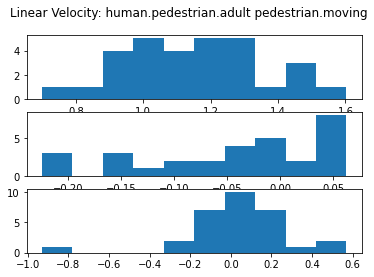

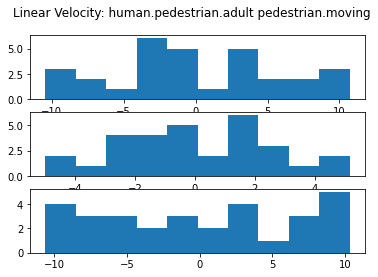

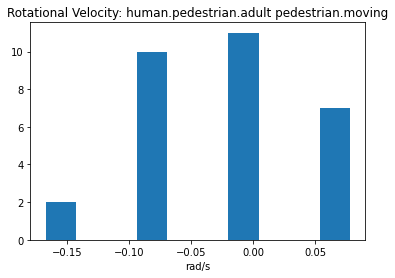

In [54]:
# TODO - enumerate classes and class attributes

class_type = 'human.pedestrian.adult'
attribute = 'pedestrian.moving'

def make_plots(class_type,att):
    # make vel plot
    vel_fig, vel_axs = plt.subplots(3)
    vel_fig.suptitle('Linear Velocity: ' + str(class_type) + " " + str(att))
    vel_axs[0].hist(variable_df.loc[variable_df['class']==class_type,'vel_x'])
    vel_axs[1].hist(variable_df.loc[variable_df['class']==class_type,'vel_y'])
    vel_axs[2].hist(variable_df.loc[variable_df['class']==class_type,'vel_z'])
    
    # make acc plot
    acc_fig, acc_axs = plt.subplots(3)
    acc_fig.suptitle('Linear Velocity: ' + str(class_type) + " " + str(att))
    acc_axs[0].hist(variable_df.loc[variable_df['class']==class_type,'acc_x'])
    acc_axs[1].hist(variable_df.loc[variable_df['class']==class_type,'acc_y'])
    acc_axs[2].hist(variable_df.loc[variable_df['class']==class_type,'acc_z'])
    
    # make omega plot
    omega_fig = plt.figure("Rotational Velocity")
    plt.hist(variable_df.loc[variable_df['class']==class_type,'omega_z'])
    plt.title("Rotational Velocity: " + str(class_type) + " " + str(att))
    plt.xlabel("rad/s")
    
    plt.show()
make_plots(class_type, attribute)

# Future work

In [ ]:
# TODO - get generic rotation angles from quaternion instead of just theta